<a href="https://colab.research.google.com/github/Keivanrahmani/KeivanRahmani/blob/main/Mildred_Lake_2_SO2_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import io 
from numpy import array
from numpy import hstack
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
#from tsmoothie.utils_func import sim_randomwalk
#from tsmoothie.smoother import *
import seaborn as sns
#import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import optuna
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import optuna
from optuna.integration import KerasPruningCallback
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import os
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras import initializers

In [ ]:
# pip install optuna 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Mildred Lake_Corrected.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True)
df1 =pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Mildred Lake_Corrected_outlier.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True)

In [ ]:
# df = pd.concat([df1,df2])
# df.index

In [ ]:
df1.drop(columns= ['score'], inplace = True)

In [ ]:
df1.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

In [ ]:
def wind (df, radius):
  dff = df.copy()
  a = 'sin'
  b =  'cos'
  dff[a]=np.sin(dff[radius]*np.pi/180)
  dff[b]=np.cos(dff[radius]*np.pi/180)
  #dff[a] = dff[a] * dff[speed]
  #dff[b] = dff[b] * dff[speed]
  # dff.drop(columns=[radius],inplace = True)
  return dff


def lag_maker(df,column, num):
    for i in  range(num):
        df[column+ '-lag' + str(i+1)] = df[column].shift(i+1)
        df[column+ '-lag' + str(i+1)] = df[column+ '-lag' + str(i+1)]

def lag(df_reg, num):
    for i in c:
        lag_maker(df_reg,i,num)
        
    df_reg = df_reg.iloc[num:]
    return df_reg        




# df2 = lag(df1,1)
df1_w = wind(df1,'Wind Direction')

In [ ]:
df1_w.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'sin', 'cos'],
      dtype='object')

In [ ]:
df1_w= df1_w[['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend' ]]


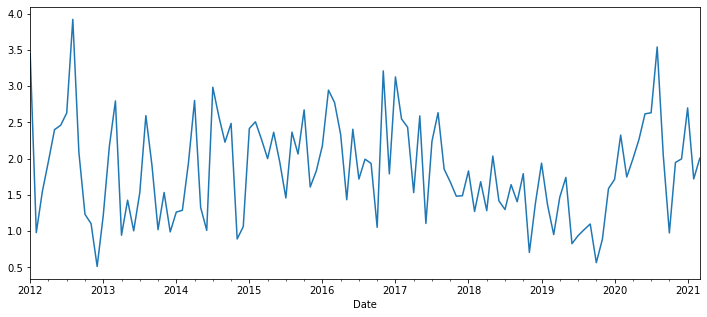

In [ ]:
df1_w['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5))

In [ ]:
df1_w.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

In [ ]:
df1_w_c = df1_w[['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend']].copy()  #.resample('D').mean()
df1_w_c.dropna(inplace = True)

Y = df1_w_c['SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
df1_w_c

SO2 (ppb)  T ( C)  ...  Day-year      trend
Date                                    ...                     
2012-01-01 00:00:00       39.0    -9.6  ...       1.0  12.000000
2012-01-01 03:00:00       11.0   -10.7  ...       1.0  12.000342
2012-01-01 04:00:00        7.0   -12.1  ...       1.0  12.000455
2012-01-01 05:00:00        6.0   -12.7  ...       1.0  12.000569
2012-01-01 06:00:00        2.0   -13.5  ...       1.0  12.000683
...                        ...     ...  ...       ...        ...
2021-03-31 19:00:00        0.1     4.2  ...      90.0  21.245332
2021-03-31 20:00:00        0.4     3.0  ...      90.0  21.245446
2021-03-31 21:00:00        0.3     4.4  ...      90.0  21.245560
2021-03-31 22:00:00        0.4     4.9  ...      90.0  21.245674
2021-03-31 23:00:00        0.3     3.7  ...      90.0  21.245788

[68443 rows x 14 columns]

In [ ]:
def objectivee(trial):    
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00001, random_state = 42)

        param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]), #",,""gblinear" , "dart"
        "lambda": trial.suggest_loguniform("lambda", 0.1, 1000000.0),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 1000000.0),
        
        }
        # if param["booster"] == "gbtree" :
        #     param["n_estimators"] =  trial.suggest_int("n_estimators" , 1, 10000)


        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
            param["eta"] = trial.suggest_loguniform("eta", 0.1, 100000.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 0.1, 100000.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-3, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)

        kf = KFold(n_splits=5)
        acc = 0 
        for train_index, test_index in kf.split(X_train):   
                X_tr, X_tes = X_train[train_index], X_train[test_index]
                y_tr, y_tes =  y_train[train_index],  y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state = 42)
    
                dtrain = xgb.DMatrix(X_tra, label=y_tra)
                dval = xgb.DMatrix(X_val, label=y_val)
                dtest = xgb.DMatrix(X_tes, label=y_tes)
                
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
                bst = xgb.train(param, dtrain, evals=[(dval, "validation")],  early_stopping_rounds=30,
                                callbacks=[pruning_callback],
                               # verbose_eval = False
                               )
                preds = bst.predict(dtest)
                accuracy = mean_squared_error(y_tes, preds)
                acc = acc + accuracy/5
                
        print(acc)
        return acc    

In [ ]:
study2 = optuna.create_study()
study2.optimize(objectivee, n_trials=5000)
print(study2.best_trial)

[I 2021-05-15 03:52:00,459] A new study created in memory with name: no-name-c10dc565-c8b5-42ce-8ba4-d987c607469a


[0]	validation-rmse:5.04093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04093
[2]	validation-rmse:5.04093
[3]	validation-rmse:5.04093
[4]	validation-rmse:5.04093
[5]	validation-rmse:5.04093
[6]	validation-rmse:5.04093
[7]	validation-rmse:5.04093
[8]	validation-rmse:5.04093
[9]	validation-rmse:5.04093
[0]	validation-rmse:4.96328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96328
[2]	validation-rmse:4.96328
[3]	validation-rmse:4.96328
[4]	validation-rmse:4.96328
[5]	validation-rmse:4.96328
[6]	validation-rmse:4.96328
[7]	validation-rmse:4.96328
[8]	validation-rmse:4.96328
[9]	validation-rmse:4.96328
[0]	validation-rmse:4.99024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99024
[2]	validation-rmse:4.99024
[3]	validation-rmse:4.99024
[4]	validation-rmse:4.99024
[5]	validation-rmse:4.99024
[6]	validation-rmse:4.99024
[7]	validation-rmse:4.99024
[8]	validation-rmse:4.99024

[I 2021-05-15 03:52:01,430] Trial 0 finished with value: 24.190480329268205 and parameters: {'booster': 'gbtree', 'lambda': 73.57454382255713, 'alpha': 65143.457517578434, 'max_depth': 3, 'eta': 24510.141032812815, 'gamma': 0.11281792306264792, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 24.190480329268205.


[0]	validation-rmse:1220.82
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:955223
[2]	validation-rmse:7.47399e+08
[3]	validation-rmse:5.84791e+11
[4]	validation-rmse:4.57561e+14
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:1214.37
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:950186
[2]	validation-rmse:7.43458e+08
[3]	validation-rmse:5.81707e+11
[4]	validation-rmse:4.55148e+14
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:1223.61
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:957422
[2]	validation-rmse:7.4912e+08
[3]	validation-rmse:5.86137e+11
[4]	validation-rmse:4.58614e+14
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf

[I 2021-05-15 03:52:02,054] Trial 1 finished with value: 1.3376828425404207e+58 and parameters: {'booster': 'gbtree', 'lambda': 0.27066392886738777, 'alpha': 0.1357172069802578, 'max_depth': 1, 'eta': 783.4410511705178, 'gamma': 1.075243860826519, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 24.190480329268205.


1.3376828425404207e+58
[0]	validation-rmse:5.04093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04093
[2]	validation-rmse:5.04093
[3]	validation-rmse:5.04093
[4]	validation-rmse:5.04093
[5]	validation-rmse:5.04093
[6]	validation-rmse:5.04093
[7]	validation-rmse:5.04093
[8]	validation-rmse:5.04093
[9]	validation-rmse:5.04093
[0]	validation-rmse:4.96328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96328
[2]	validation-rmse:4.96328
[3]	validation-rmse:4.96328
[4]	validation-rmse:4.96328
[5]	validation-rmse:4.96328
[6]	validation-rmse:4.96328
[7]	validation-rmse:4.96328
[8]	validation-rmse:4.96328
[9]	validation-rmse:4.96328
[0]	validation-rmse:4.99024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99024
[2]	validation-rmse:4.99024
[3]	validation-rmse:4.99024
[4]	validation-rmse:4.99024
[5]	validation-rmse:4.99024
[6]	validation-rmse:4.99024
[7]	validation-rmse:4.99024
[8]	

[I 2021-05-15 03:52:02,665] Trial 2 finished with value: 24.190480329268205 and parameters: {'booster': 'gbtree', 'lambda': 86.39402599241629, 'alpha': 300978.02148518694, 'max_depth': 2, 'eta': 804.2265666678826, 'gamma': 0.18012759728880262, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 24.190480329268205.


24.190480329268205
[0]	validation-rmse:5.04093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04093
[2]	validation-rmse:5.04093
[3]	validation-rmse:5.04093
[4]	validation-rmse:5.04093
[5]	validation-rmse:5.04093
[6]	validation-rmse:5.04093
[7]	validation-rmse:5.04093
[8]	validation-rmse:5.04093
[9]	validation-rmse:5.04093
[0]	validation-rmse:4.96328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96328
[2]	validation-rmse:4.96328
[3]	validation-rmse:4.96328
[4]	validation-rmse:4.96328
[5]	validation-rmse:4.96328
[6]	validation-rmse:4.96328
[7]	validation-rmse:4.96328
[8]	validation-rmse:4.96328
[9]	validation-rmse:4.96328
[0]	validation-rmse:4.99024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99024
[2]	validation-rmse:4.99024
[3]	validation-rmse:4.99024
[4]	validation-rmse:4.99024
[5]	validation-rmse:4.99024
[6]	validation-rmse:4.99024
[7]	validation-rmse:4.99024
[8]	vali

[I 2021-05-15 03:52:03,316] Trial 3 finished with value: 24.190480329268205 and parameters: {'booster': 'gbtree', 'lambda': 211937.8670771495, 'alpha': 398920.0216290353, 'max_depth': 1, 'eta': 113.18210146985108, 'gamma': 97999.09578131328, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 24.190480329268205.


24.190480329268205
[0]	validation-rmse:4.90534
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63712
[2]	validation-rmse:4.51099
[3]	validation-rmse:4.32145
[4]	validation-rmse:4.26272
[5]	validation-rmse:4.1573
[6]	validation-rmse:4.1253
[7]	validation-rmse:4.10069
[8]	validation-rmse:4.06791
[9]	validation-rmse:4.05718
[0]	validation-rmse:4.79879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.42027
[2]	validation-rmse:4.21888
[3]	validation-rmse:4.17578
[4]	validation-rmse:4.13437
[5]	validation-rmse:4.06366
[6]	validation-rmse:4.04901
[7]	validation-rmse:4.0302
[8]	validation-rmse:4.0177
[9]	validation-rmse:4.00084
[0]	validation-rmse:4.82898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55674
[2]	validation-rmse:4.31977
[3]	validation-rmse:4.14568
[4]	validation-rmse:4.11712
[5]	validation-rmse:4.09863
[6]	validation-rmse:4.06934
[7]	validation-rmse:4.03131
[8]	validati

[I 2021-05-15 03:52:06,112] Trial 4 finished with value: 15.520973753978971 and parameters: {'booster': 'gbtree', 'lambda': 2571.2463061790186, 'alpha': 22.85687624728014, 'max_depth': 9, 'eta': 2.2049674907521997, 'gamma': 0.9062242767981, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


15.520973753978971


[I 2021-05-15 03:52:06,213] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:52:06,285] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:52:06,357] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.04093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04093
[2]	validation-rmse:5.04093
[3]	validation-rmse:5.04093
[4]	validation-rmse:5.04093
[5]	validation-rmse:5.04093
[6]	validation-rmse:5.04093
[7]	validation-rmse:5.04093
[8]	validation-rmse:5.04093
[9]	validation-rmse:5.04093
[0]	validation-rmse:4.96328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96328
[2]	validation-rmse:4.96328
[3]	validation-rmse:4.96328
[4]	validation-rmse:4.96328
[5]	validation-rmse:4.96328
[6]	validation-rmse:4.96328
[7]	validation-rmse:4.96328
[8]	validation-rmse:4.96328
[9]	validation-rmse:4.96328
[0]	validation-rmse:4.99024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99024
[2]	validation-rmse:4.99024
[3]	validation-rmse:4.99024
[4]	validation-rmse:4.99024
[5]	validation-rmse:4.99024
[6]	validation-rmse:4.99024
[7]	validation-rmse:4.99024
[8]	validation-rmse:4.99024

[I 2021-05-15 03:52:07,034] Trial 8 finished with value: 24.190480329268205 and parameters: {'booster': 'gbtree', 'lambda': 14.315864989928324, 'alpha': 74991.71078157758, 'max_depth': 5, 'eta': 4772.064514262724, 'gamma': 0.9683870283380143, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


24.190480329268205


[I 2021-05-15 03:52:07,110] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.03522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02964
[2]	validation-rmse:5.02418
[3]	validation-rmse:5.01885
[4]	validation-rmse:5.01349
[5]	validation-rmse:5.00823
[6]	validation-rmse:5.00305
[7]	validation-rmse:4.99797
[8]	validation-rmse:4.99298
[9]	validation-rmse:4.98808
[0]	validation-rmse:4.9575
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.95184
[2]	validation-rmse:4.94632
[3]	validation-rmse:4.94092
[4]	validation-rmse:4.93554
[5]	validation-rmse:4.93025
[6]	validation-rmse:4.92506
[7]	validation-rmse:4.91995
[8]	validation-rmse:4.91493
[9]	validation-rmse:4.91001
[0]	validation-rmse:4.98441
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.97871
[2]	validation-rmse:4.97314
[3]	validation-rmse:4.96769
[4]	validation-rmse:4.96229
[5]	validation-rmse:4.957
[6]	validation-rmse:4.95186
[7]	validation-rmse:4.94676
[8]	validation-rmse:4.94175
[9

[I 2021-05-15 03:52:09,586] Trial 10 finished with value: 23.67077630017215 and parameters: {'booster': 'gbtree', 'lambda': 838639.1834294855, 'alpha': 46.4180161262777, 'max_depth': 10, 'eta': 0.3032947242131557, 'gamma': 76.72193094521214, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


23.67077630017215
[0]	validation-rmse:5.03611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.03136
[2]	validation-rmse:5.02668
[3]	validation-rmse:5.02207
[4]	validation-rmse:5.01753
[5]	validation-rmse:5.01304
[6]	validation-rmse:5.00863
[7]	validation-rmse:5.00428
[8]	validation-rmse:5
[9]	validation-rmse:4.99578
[0]	validation-rmse:4.95843
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.95365
[2]	validation-rmse:4.94894
[3]	validation-rmse:4.94431
[4]	validation-rmse:4.93975
[5]	validation-rmse:4.93524
[6]	validation-rmse:4.93081
[7]	validation-rmse:4.92644
[8]	validation-rmse:4.92213
[9]	validation-rmse:4.9179
[0]	validation-rmse:4.98537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.98058
[2]	validation-rmse:4.97586
[3]	validation-rmse:4.97121
[4]	validation-rmse:4.96664
[5]	validation-rmse:4.96214
[6]	validation-rmse:4.9577
[7]	validation-rmse:4.95334
[8]	validation-rm

[I 2021-05-15 03:52:12,068] Trial 11 finished with value: 23.74653905167184 and parameters: {'booster': 'gbtree', 'lambda': 357780.5468108009, 'alpha': 59.31602678768401, 'max_depth': 10, 'eta': 0.11310350569501826, 'gamma': 44.1988315228806, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


23.74653905167184
[0]	validation-rmse:4.99857
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96175
[2]	validation-rmse:4.92935
[3]	validation-rmse:4.90083
[4]	validation-rmse:4.87552
[5]	validation-rmse:4.85268
[6]	validation-rmse:4.83238
[7]	validation-rmse:4.81354
[8]	validation-rmse:4.79634
[9]	validation-rmse:4.78049
[0]	validation-rmse:4.92049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.88323
[2]	validation-rmse:4.8507
[3]	validation-rmse:4.82203
[4]	validation-rmse:4.79648
[5]	validation-rmse:4.77345
[6]	validation-rmse:4.7523
[7]	validation-rmse:4.73311
[8]	validation-rmse:4.71543
[9]	validation-rmse:4.69977
[0]	validation-rmse:4.94761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.91
[2]	validation-rmse:4.877
[3]	validation-rmse:4.84786
[4]	validation-rmse:4.8224
[5]	validation-rmse:4.79909
[6]	validation-rmse:4.77776
[7]	validation-rmse:4.75882
[8]	validation-rm

[I 2021-05-15 03:52:14,443] Trial 12 finished with value: 21.67894086639902 and parameters: {'booster': 'gbtree', 'lambda': 12497.992561600395, 'alpha': 11.336757312263746, 'max_depth': 8, 'eta': 0.10300727639625251, 'gamma': 35.41723241238418, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


21.67894086639902
[0]	validation-rmse:4.76483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67847
[2]	validation-rmse:4.60735
[3]	validation-rmse:4.55518
[4]	validation-rmse:4.50771
[5]	validation-rmse:4.46492
[6]	validation-rmse:4.42781
[7]	validation-rmse:4.41108
[8]	validation-rmse:4.38429
[9]	validation-rmse:4.35576
[0]	validation-rmse:4.68696
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59953
[2]	validation-rmse:4.51827
[3]	validation-rmse:4.46433
[4]	validation-rmse:4.43268
[5]	validation-rmse:4.3901
[6]	validation-rmse:4.34717
[7]	validation-rmse:4.31685
[8]	validation-rmse:4.28616
[9]	validation-rmse:4.2637
[0]	validation-rmse:4.71383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62691
[2]	validation-rmse:4.55402
[3]	validation-rmse:4.49678
[4]	validation-rmse:4.46192
[5]	validation-rmse:4.41081
[6]	validation-rmse:4.36841
[7]	validation-rmse:4.33537
[8]	validat

[I 2021-05-15 03:52:17,003] Trial 13 finished with value: 17.85687603538184 and parameters: {'booster': 'gbtree', 'lambda': 17643.71110709776, 'alpha': 3.45728276008407, 'max_depth': 8, 'eta': 1.0161057232614679, 'gamma': 5.394044475810883, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


[0]	validation-rmse:4.76225
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.68859
[2]	validation-rmse:4.63868
[3]	validation-rmse:4.60295
[4]	validation-rmse:4.57686
[5]	validation-rmse:4.53895
[6]	validation-rmse:4.50989
[7]	validation-rmse:4.49044
[8]	validation-rmse:4.47516
[9]	validation-rmse:4.4563
[0]	validation-rmse:4.68446
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61013
[2]	validation-rmse:4.56253
[3]	validation-rmse:4.53179
[4]	validation-rmse:4.48489
[5]	validation-rmse:4.46485
[6]	validation-rmse:4.43255
[7]	validation-rmse:4.40686
[8]	validation-rmse:4.38477
[9]	validation-rmse:4.3751
[0]	validation-rmse:4.71111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63728
[2]	validation-rmse:4.59944
[3]	validation-rmse:4.54508
[4]	validation-rmse:4.50411
[5]	validation-rmse:4.4697
[6]	validation-rmse:4.45366
[7]	validation-rmse:4.42917
[8]	validation-rmse:4.40576
[9

[I 2021-05-15 03:52:18,885] Trial 14 finished with value: 18.78233639890919 and parameters: {'booster': 'gbtree', 'lambda': 20497.052206094668, 'alpha': 3115.1152098893576, 'max_depth': 8, 'eta': 1.1751779509499536, 'gamma': 5.4048860614122045, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


18.78233639890919
[0]	validation-rmse:4.76249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.70123
[2]	validation-rmse:4.6597
[3]	validation-rmse:4.64227
[4]	validation-rmse:4.61219
[5]	validation-rmse:4.57601
[6]	validation-rmse:4.55913
[7]	validation-rmse:4.55107
[8]	validation-rmse:4.53506
[9]	validation-rmse:4.52283
[0]	validation-rmse:4.6822
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62503
[2]	validation-rmse:4.58156
[3]	validation-rmse:4.53041
[4]	validation-rmse:4.49563
[5]	validation-rmse:4.47677
[6]	validation-rmse:4.4616
[7]	validation-rmse:4.44628
[8]	validation-rmse:4.4223
[9]	validation-rmse:4.42005
[0]	validation-rmse:4.70971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64968
[2]	validation-rmse:4.61055
[3]	validation-rmse:4.55793
[4]	validation-rmse:4.52371
[5]	validation-rmse:4.51252
[6]	validation-rmse:4.48649
[7]	validation-rmse:4.46635
[8]	validatio

[I 2021-05-15 03:52:21,290] Trial 15 finished with value: 19.377626653506667 and parameters: {'booster': 'gbtree', 'lambda': 56761.11958235789, 'alpha': 1.1285252730331745, 'max_depth': 8, 'eta': 2.0349510819655547, 'gamma': 522.5694698326563, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


19.377626653506667


[I 2021-05-15 03:52:21,373] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49772
[2]	validation-rmse:4.37384
[3]	validation-rmse:4.2984
[4]	validation-rmse:4.2604
[5]	validation-rmse:4.212
[6]	validation-rmse:4.18557
[7]	validation-rmse:4.17049
[8]	validation-rmse:4.14038
[9]	validation-rmse:4.13165
[0]	validation-rmse:4.60201
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.42568
[2]	validation-rmse:4.28227
[3]	validation-rmse:4.20647
[4]	validation-rmse:4.15314
[5]	validation-rmse:4.12042
[6]	validation-rmse:4.09459
[7]	validation-rmse:4.06486
[8]	validation-rmse:4.04189
[9]	validation-rmse:4.0276
[0]	validation-rmse:4.63101
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.41319
[2]	validation-rmse:4.2932
[3]	validation-rmse:4.22255
[4]	validation-rmse:4.1699
[5]	validation-rmse:4.15091
[6]	validation-rmse:4.12329
[7]	validation-rmse:4.0937
[8]	validation-rmse:4.05825
[9]	val

[I 2021-05-15 03:52:24,205] Trial 17 finished with value: 15.95748456277385 and parameters: {'booster': 'gbtree', 'lambda': 445.892125306242, 'alpha': 1.5041373896809316, 'max_depth': 9, 'eta': 0.39828782035392457, 'gamma': 607.3983579771508, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 15.520973753978971.


15.95748456277385


[I 2021-05-15 03:52:24,307] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.44987
[2]	validation-rmse:4.34203
[3]	validation-rmse:4.26027
[4]	validation-rmse:4.19489
[5]	validation-rmse:4.15759
[6]	validation-rmse:4.13937
[7]	validation-rmse:4.12166
[8]	validation-rmse:4.09751
[9]	validation-rmse:4.06916
[0]	validation-rmse:4.5867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.355
[2]	validation-rmse:4.22896
[3]	validation-rmse:4.13633
[4]	validation-rmse:4.08476
[5]	validation-rmse:4.05743
[6]	validation-rmse:4.02624
[7]	validation-rmse:3.9983
[8]	validation-rmse:3.9847
[9]	validation-rmse:3.96338
[0]	validation-rmse:4.58285
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.3622
[2]	validation-rmse:4.2342
[3]	validation-rmse:4.1586
[4]	validation-rmse:4.0904
[5]	validation-rmse:4.05405
[6]	validation-rmse:4.01281
[7]	validation-rmse:3.99703
[8]	validation-rmse:3.95107
[9]	valid

[I 2021-05-15 03:52:27,138] Trial 19 finished with value: 15.33638733496785 and parameters: {'booster': 'gbtree', 'lambda': 84.69843802782893, 'alpha': 18.089096508155123, 'max_depth': 9, 'eta': 0.33734569430107986, 'gamma': 690.7575361049846, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 15.33638733496785.


15.33638733496785


[I 2021-05-15 03:52:27,221] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57593
[2]	validation-rmse:4.44442
[3]	validation-rmse:4.35488
[4]	validation-rmse:4.29512
[5]	validation-rmse:4.23725
[6]	validation-rmse:4.20965
[7]	validation-rmse:4.1849
[8]	validation-rmse:4.16446
[9]	validation-rmse:4.14328
[0]	validation-rmse:4.6828
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.48133
[2]	validation-rmse:4.35605
[3]	validation-rmse:4.27099
[4]	validation-rmse:4.205
[5]	validation-rmse:4.14977
[6]	validation-rmse:4.11296
[7]	validation-rmse:4.06632
[8]	validation-rmse:4.04776
[9]	validation-rmse:4.02696
[0]	validation-rmse:4.69286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49258
[2]	validation-rmse:4.34808
[3]	validation-rmse:4.25467
[4]	validation-rmse:4.18577
[5]	validation-rmse:4.1377
[6]	validation-rmse:4.09882
[7]	validation-rmse:4.07152
[8]	validation-rmse:4.03386
[9]	

[I 2021-05-15 03:52:29,992] Trial 21 finished with value: 15.914626096797184 and parameters: {'booster': 'gbtree', 'lambda': 137.20169712051222, 'alpha': 97.6738195090161, 'max_depth': 9, 'eta': 0.263070929220148, 'gamma': 571.2272042464308, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 15.33638733496785.


15.914626096797184
[0]	validation-rmse:4.71755
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.513
[2]	validation-rmse:4.3899
[3]	validation-rmse:4.30805
[4]	validation-rmse:4.25647
[5]	validation-rmse:4.21733
[6]	validation-rmse:4.17427
[7]	validation-rmse:4.14115
[8]	validation-rmse:4.11599
[9]	validation-rmse:4.10816
[0]	validation-rmse:4.63683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.4248
[2]	validation-rmse:4.31238
[3]	validation-rmse:4.22345
[4]	validation-rmse:4.16633
[5]	validation-rmse:4.12912
[6]	validation-rmse:4.0909
[7]	validation-rmse:4.06315
[8]	validation-rmse:4.01316
[9]	validation-rmse:4.00069
[0]	validation-rmse:4.64288
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.42266
[2]	validation-rmse:4.29013
[3]	validation-rmse:4.21014
[4]	validation-rmse:4.14871
[5]	validation-rmse:4.10997
[6]	validation-rmse:4.06523
[7]	validation-rmse:4.03084
[8]	validatio

[I 2021-05-15 03:52:32,625] Trial 22 finished with value: 15.580327930394674 and parameters: {'booster': 'gbtree', 'lambda': 54.756101655827, 'alpha': 341.78854760010023, 'max_depth': 9, 'eta': 0.30130967869228265, 'gamma': 281.6317567257308, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 15.33638733496785.


15.580327930394674
[0]	validation-rmse:4.92834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8309
[2]	validation-rmse:4.75025
[3]	validation-rmse:4.68119
[4]	validation-rmse:4.61667
[5]	validation-rmse:4.55823
[6]	validation-rmse:4.51548
[7]	validation-rmse:4.48344
[8]	validation-rmse:4.44194
[9]	validation-rmse:4.41036
[0]	validation-rmse:4.8502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75547
[2]	validation-rmse:4.66563
[3]	validation-rmse:4.59326
[4]	validation-rmse:4.52776
[5]	validation-rmse:4.4785
[6]	validation-rmse:4.42744
[7]	validation-rmse:4.39329
[8]	validation-rmse:4.35612
[9]	validation-rmse:4.32766
[0]	validation-rmse:4.87246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76675
[2]	validation-rmse:4.67631
[3]	validation-rmse:4.60043
[4]	validation-rmse:4.53554
[5]	validation-rmse:4.48213
[6]	validation-rmse:4.435
[7]	validation-rmse:4.39263
[8]	validatio

[I 2021-05-15 03:52:34,625] Trial 23 finished with value: 18.27469435492782 and parameters: {'booster': 'gbtree', 'lambda': 13.738239746720398, 'alpha': 741.0853857128888, 'max_depth': 7, 'eta': 0.10371394511582382, 'gamma': 151.99991942803223, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 15.33638733496785.


18.27469435492782
[0]	validation-rmse:4.6852
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53227
[2]	validation-rmse:4.45163
[3]	validation-rmse:4.39722
[4]	validation-rmse:4.34705
[5]	validation-rmse:4.34507
[6]	validation-rmse:4.34466
[7]	validation-rmse:4.34455
[8]	validation-rmse:4.31848
[9]	validation-rmse:4.31812
[0]	validation-rmse:4.59565
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49527
[2]	validation-rmse:4.39505
[3]	validation-rmse:4.33335
[4]	validation-rmse:4.32999
[5]	validation-rmse:4.32935
[6]	validation-rmse:4.32919
[7]	validation-rmse:4.32914
[8]	validation-rmse:4.32913
[9]	validation-rmse:4.32912
[0]	validation-rmse:4.62282
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.44677
[2]	validation-rmse:4.35809
[3]	validation-rmse:4.29974
[4]	validation-rmse:4.27401
[5]	validation-rmse:4.25098
[6]	validation-rmse:4.22523
[7]	validation-rmse:4.22462
[8]	valida

[I 2021-05-15 03:52:37,456] Trial 24 finished with value: 17.80860829012597 and parameters: {'booster': 'gbtree', 'lambda': 1751.6745811172834, 'alpha': 13.943741306104682, 'max_depth': 9, 'eta': 0.663429483229214, 'gamma': 3142.896823619159, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 15.33638733496785.


17.80860829012597


[I 2021-05-15 03:52:37,539] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:52:37,622] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.55014
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.29111
[2]	validation-rmse:4.14618
[3]	validation-rmse:4.06233
[4]	validation-rmse:4.01313
[5]	validation-rmse:3.97944
[6]	validation-rmse:3.94046
[7]	validation-rmse:3.93513
[8]	validation-rmse:3.92284
[9]	validation-rmse:3.91149
[0]	validation-rmse:4.46426
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.22374
[2]	validation-rmse:4.07584
[3]	validation-rmse:3.98703
[4]	validation-rmse:3.92494
[5]	validation-rmse:3.88378
[6]	validation-rmse:3.84711
[7]	validation-rmse:3.8318
[8]	validation-rmse:3.81403
[9]	validation-rmse:3.79088
[0]	validation-rmse:4.48539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.21063
[2]	validation-rmse:4.0804
[3]	validation-rmse:3.97754
[4]	validation-rmse:3.88566
[5]	validation-rmse:3.8506
[6]	validation-rmse:3.83721
[7]	validation-rmse:3.82464
[8]	validation-rmse:3.81354
[9

[I 2021-05-15 03:52:40,477] Trial 27 finished with value: 14.18477946664622 and parameters: {'booster': 'gbtree', 'lambda': 2.207190548489759, 'alpha': 34.93181490314131, 'max_depth': 9, 'eta': 0.3674875134553265, 'gamma': 176.91800935667564, 'grow_policy': 'depthwise'}. Best is trial 27 with value: 14.18477946664622.


14.18477946664622


[I 2021-05-15 03:52:40,588] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:52:40,675] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:52:40,753] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54877
[2]	validation-rmse:4.41843
[3]	validation-rmse:4.32757
[4]	validation-rmse:4.26224
[5]	validation-rmse:4.20955
[6]	validation-rmse:4.167
[7]	validation-rmse:4.12153
[8]	validation-rmse:4.09776
[9]	validation-rmse:4.07885
[0]	validation-rmse:4.66035
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46673
[2]	validation-rmse:4.32881
[3]	validation-rmse:4.22892
[4]	validation-rmse:4.15543
[5]	validation-rmse:4.09523
[6]	validation-rmse:4.06103
[7]	validation-rmse:4.02815
[8]	validation-rmse:3.99783
[9]	validation-rmse:3.97592
[0]	validation-rmse:4.67868
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46682
[2]	validation-rmse:4.33442
[3]	validation-rmse:4.22582
[4]	validation-rmse:4.1515
[5]	validation-rmse:4.09596
[6]	validation-rmse:4.05502
[7]	validation-rmse:3.999
[8]	validation-rmse:3.9667
[9]	v

[I 2021-05-15 03:52:43,521] Trial 31 finished with value: 15.411909233528029 and parameters: {'booster': 'gbtree', 'lambda': 35.44869918191812, 'alpha': 137.60422669272353, 'max_depth': 9, 'eta': 0.24452316918018996, 'gamma': 236.623922983732, 'grow_policy': 'depthwise'}. Best is trial 27 with value: 14.18477946664622.


15.411909233528029
[0]	validation-rmse:4.41436
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.31816
[2]	validation-rmse:4.28754
[3]	validation-rmse:4.26384
[4]	validation-rmse:4.27332
[5]	validation-rmse:4.26304
[6]	validation-rmse:4.27106
[7]	validation-rmse:4.25291
[8]	validation-rmse:4.26221
[9]	validation-rmse:4.2699
[0]	validation-rmse:4.35536
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.19224
[2]	validation-rmse:4.15509
[3]	validation-rmse:4.1747
[4]	validation-rmse:4.17768
[5]	validation-rmse:4.18142
[6]	validation-rmse:4.16804
[7]	validation-rmse:4.19039
[8]	validation-rmse:4.19153
[9]	validation-rmse:4.19215
[0]	validation-rmse:4.33711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.21725
[2]	validation-rmse:4.21495
[3]	validation-rmse:4.14246
[4]	validation-rmse:4.15712
[5]	validation-rmse:4.15404
[6]	validation-rmse:4.1296
[7]	validation-rmse:4.13796
[8]	validat

[I 2021-05-15 03:52:45,969] Trial 32 finished with value: 16.782805293615038 and parameters: {'booster': 'gbtree', 'lambda': 6.395286909113028, 'alpha': 122.30496502023925, 'max_depth': 8, 'eta': 1.4845638333867912, 'gamma': 80.90807536984093, 'grow_policy': 'depthwise'}. Best is trial 27 with value: 14.18477946664622.


16.782805293615038
[0]	validation-rmse:4.30326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09116
[2]	validation-rmse:4.05195
[3]	validation-rmse:4.05239
[4]	validation-rmse:4.0012
[5]	validation-rmse:3.9614
[6]	validation-rmse:3.96136
[7]	validation-rmse:3.96135
[8]	validation-rmse:3.96135
[9]	validation-rmse:3.96135
[0]	validation-rmse:4.24224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10477
[2]	validation-rmse:4.04938
[3]	validation-rmse:4.03486
[4]	validation-rmse:3.99724
[5]	validation-rmse:3.98654
[6]	validation-rmse:3.9865
[7]	validation-rmse:3.98649
[8]	validation-rmse:3.98648
[9]	validation-rmse:3.98648
[0]	validation-rmse:4.21611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06825
[2]	validation-rmse:3.96969
[3]	validation-rmse:3.95428
[4]	validation-rmse:3.93083
[5]	validation-rmse:3.93023
[6]	validation-rmse:3.92675
[7]	validation-rmse:3.91846
[8]	validat

[I 2021-05-15 03:52:48,676] Trial 33 finished with value: 15.10689997114757 and parameters: {'booster': 'gbtree', 'lambda': 0.7662318018052632, 'alpha': 5.147656851540922, 'max_depth': 9, 'eta': 0.6746926818205142, 'gamma': 1108.470460379184, 'grow_policy': 'depthwise'}. Best is trial 27 with value: 14.18477946664622.


15.10689997114757
[0]	validation-rmse:4.39709
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15888
[2]	validation-rmse:4.08192
[3]	validation-rmse:4.06093
[4]	validation-rmse:4.01449
[5]	validation-rmse:4.00834
[6]	validation-rmse:3.99723
[7]	validation-rmse:3.99426
[8]	validation-rmse:3.99139
[9]	validation-rmse:3.98666
[0]	validation-rmse:4.30603
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09658
[2]	validation-rmse:4.0028
[3]	validation-rmse:3.97227
[4]	validation-rmse:3.95669
[5]	validation-rmse:3.93998
[6]	validation-rmse:3.92572
[7]	validation-rmse:3.92269
[8]	validation-rmse:3.924
[9]	validation-rmse:3.92397
[0]	validation-rmse:4.3003
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08718
[2]	validation-rmse:4.00459
[3]	validation-rmse:3.93961
[4]	validation-rmse:3.92545
[5]	validation-rmse:3.92254
[6]	validation-rmse:3.93391
[7]	validation-rmse:3.91431
[8]	validatio

[I 2021-05-15 03:52:51,890] Trial 34 finished with value: 14.937159036986548 and parameters: {'booster': 'gbtree', 'lambda': 0.7381410065022486, 'alpha': 8.199521717387693, 'max_depth': 10, 'eta': 0.5318613495596876, 'gamma': 1065.620259678198, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 14.18477946664622.


14.937159036986548
[0]	validation-rmse:4.48639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.36376
[2]	validation-rmse:4.30767
[3]	validation-rmse:4.22618
[4]	validation-rmse:4.22595
[5]	validation-rmse:4.22588
[6]	validation-rmse:4.22586
[7]	validation-rmse:4.22585
[8]	validation-rmse:4.22584
[9]	validation-rmse:4.22584
[0]	validation-rmse:4.41576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.30923
[2]	validation-rmse:4.27543
[3]	validation-rmse:4.23408
[4]	validation-rmse:4.15996
[5]	validation-rmse:4.13601
[6]	validation-rmse:4.13599
[7]	validation-rmse:4.13598
[8]	validation-rmse:4.13598
[9]	validation-rmse:4.13598
[0]	validation-rmse:4.40679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.32769
[2]	validation-rmse:4.32348
[3]	validation-rmse:4.3227
[4]	validation-rmse:4.32251
[5]	validation-rmse:4.32245
[6]	validation-rmse:4.32244
[7]	validation-rmse:4.32243
[8]	valid

[I 2021-05-15 03:52:54,994] Trial 35 finished with value: 17.25472673793332 and parameters: {'booster': 'gbtree', 'lambda': 0.15588310903755545, 'alpha': 4.589442408999706, 'max_depth': 10, 'eta': 0.6354656425348496, 'gamma': 7429.934952073713, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 14.18477946664622.


17.25472673793332


[I 2021-05-15 03:52:55,101] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:52:55,192] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.34028
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.119
[2]	validation-rmse:4.09191
[3]	validation-rmse:4.05692
[4]	validation-rmse:4.04304
[5]	validation-rmse:4.0403
[6]	validation-rmse:4.04025
[7]	validation-rmse:4.04024
[8]	validation-rmse:4.04023
[9]	validation-rmse:4.04023
[0]	validation-rmse:4.28444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09027
[2]	validation-rmse:4.04049
[3]	validation-rmse:3.97912
[4]	validation-rmse:3.98422
[5]	validation-rmse:3.98396
[6]	validation-rmse:3.97051
[7]	validation-rmse:3.96976
[8]	validation-rmse:3.9781
[9]	validation-rmse:3.97569
[0]	validation-rmse:4.2073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00051
[2]	validation-rmse:3.96262
[3]	validation-rmse:3.93043
[4]	validation-rmse:3.92453
[5]	validation-rmse:3.90462
[6]	validation-rmse:3.91298
[7]	validation-rmse:3.91354
[8]	validation-rmse:3.89827
[9]	

[I 2021-05-15 03:52:57,890] Trial 38 finished with value: 15.523208219787545 and parameters: {'booster': 'gbtree', 'lambda': 0.22683702011413906, 'alpha': 0.9714815300069393, 'max_depth': 9, 'eta': 0.6089080229747704, 'gamma': 492.2651111875405, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 14.18477946664622.


15.523208219787545


[I 2021-05-15 03:52:58,002] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:52:58,068] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5342
[2]	validation-rmse:4.38943
[3]	validation-rmse:4.27426
[4]	validation-rmse:4.17221
[5]	validation-rmse:4.10507
[6]	validation-rmse:4.05779
[7]	validation-rmse:4.01963
[8]	validation-rmse:3.9821
[9]	validation-rmse:3.95936
[0]	validation-rmse:4.65933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.45243
[2]	validation-rmse:4.30218
[3]	validation-rmse:4.18915
[4]	validation-rmse:4.10861
[5]	validation-rmse:4.05298
[6]	validation-rmse:4.00002
[7]	validation-rmse:3.95912
[8]	validation-rmse:3.92729
[9]	validation-rmse:3.90442
[0]	validation-rmse:4.67574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46338
[2]	validation-rmse:4.30082
[3]	validation-rmse:4.18291
[4]	validation-rmse:4.10228
[5]	validation-rmse:4.03063
[6]	validation-rmse:3.97816
[7]	validation-rmse:3.92816
[8]	validation-rmse:3.89418
[

[I 2021-05-15 03:53:00,931] Trial 41 finished with value: 14.751032527746228 and parameters: {'booster': 'gbtree', 'lambda': 0.11279355520495302, 'alpha': 24.906002988073602, 'max_depth': 9, 'eta': 0.19806965422729989, 'gamma': 238.7972398938745, 'grow_policy': 'depthwise'}. Best is trial 27 with value: 14.18477946664622.


14.751032527746228
[0]	validation-rmse:4.31763
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10682
[2]	validation-rmse:4.0483
[3]	validation-rmse:3.98485
[4]	validation-rmse:3.94437
[5]	validation-rmse:3.95153
[6]	validation-rmse:3.91764
[7]	validation-rmse:3.9181
[8]	validation-rmse:3.90932
[9]	validation-rmse:3.91021
[0]	validation-rmse:4.22279
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02701
[2]	validation-rmse:3.92092
[3]	validation-rmse:3.89711
[4]	validation-rmse:3.87112
[5]	validation-rmse:3.85347
[6]	validation-rmse:3.84415
[7]	validation-rmse:3.85051
[8]	validation-rmse:3.8523
[9]	validation-rmse:3.84975
[0]	validation-rmse:4.21599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05772
[2]	validation-rmse:3.96406
[3]	validation-rmse:3.95595
[4]	validation-rmse:3.87867
[5]	validation-rmse:3.85971
[6]	validation-rmse:3.85288
[7]	validation-rmse:3.85017
[8]	validat

[I 2021-05-15 03:53:03,765] Trial 42 finished with value: 14.786993633545382 and parameters: {'booster': 'gbtree', 'lambda': 0.12145926564119623, 'alpha': 27.834621013354944, 'max_depth': 9, 'eta': 0.6182838255837556, 'gamma': 114.0053231391951, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 14.18477946664622.


14.786993633545382
[0]	validation-rmse:4.21974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0643
[2]	validation-rmse:4.05384
[3]	validation-rmse:4.0546
[4]	validation-rmse:4.05819
[5]	validation-rmse:4.06977
[6]	validation-rmse:4.07546
[7]	validation-rmse:4.07608
[8]	validation-rmse:4.07853
[9]	validation-rmse:4.08392
[0]	validation-rmse:4.15522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05206
[2]	validation-rmse:4.00426
[3]	validation-rmse:3.99878
[4]	validation-rmse:4.00506
[5]	validation-rmse:4.06284
[6]	validation-rmse:4.08654
[7]	validation-rmse:4.05623
[8]	validation-rmse:4.05561
[9]	validation-rmse:4.04941
[0]	validation-rmse:4.14216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06551
[2]	validation-rmse:4.06974
[3]	validation-rmse:4.04473
[4]	validation-rmse:4.043
[5]	validation-rmse:4.04216
[6]	validation-rmse:4.06332
[7]	validation-rmse:4.05354
[8]	validati

[I 2021-05-15 03:53:06,180] Trial 43 finished with value: 16.277401262500707 and parameters: {'booster': 'gbtree', 'lambda': 0.1287179664622121, 'alpha': 28.810704929949278, 'max_depth': 8, 'eta': 0.9584866278593711, 'gamma': 109.85595823668483, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 14.18477946664622.


16.277401262500707


[I 2021-05-15 03:53:06,288] Trial 44 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.37042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15733
[2]	validation-rmse:4.06816
[3]	validation-rmse:4.01122
[4]	validation-rmse:3.96698
[5]	validation-rmse:3.96277
[6]	validation-rmse:3.95011
[7]	validation-rmse:3.94998
[8]	validation-rmse:3.94993
[9]	validation-rmse:3.94991
[0]	validation-rmse:4.3024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09567
[2]	validation-rmse:4.0374
[3]	validation-rmse:3.98259
[4]	validation-rmse:3.94935
[5]	validation-rmse:3.92228
[6]	validation-rmse:3.91809
[7]	validation-rmse:3.90464
[8]	validation-rmse:3.88925
[9]	validation-rmse:3.88613
[0]	validation-rmse:4.30131
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09655
[2]	validation-rmse:4.00712
[3]	validation-rmse:3.92814
[4]	validation-rmse:3.93422
[5]	validation-rmse:3.90532
[6]	validation-rmse:3.89155
[7]	validation-rmse:3.88254
[8]	validation-rmse:3.87708
[

[I 2021-05-15 03:53:09,091] Trial 45 finished with value: 14.464300312461633 and parameters: {'booster': 'gbtree', 'lambda': 0.1047693004341993, 'alpha': 52.84067357880738, 'max_depth': 9, 'eta': 0.5590161154316756, 'gamma': 311.4391286864386, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 14.18477946664622.


14.464300312461633


[I 2021-05-15 03:53:09,190] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.45979
[2]	validation-rmse:4.38401


[I 2021-05-15 03:53:09,437] Trial 47 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:53:09,518] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.54233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.32144
[2]	validation-rmse:4.21487
[3]	validation-rmse:4.13452
[4]	validation-rmse:4.10033
[5]	validation-rmse:4.07913
[6]	validation-rmse:4.03202
[7]	validation-rmse:4.00248
[8]	validation-rmse:3.99046
[9]	validation-rmse:3.96577
[0]	validation-rmse:4.4497
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.23554
[2]	validation-rmse:4.13495
[3]	validation-rmse:4.06783
[4]	validation-rmse:4.02318
[5]	validation-rmse:3.95789
[6]	validation-rmse:3.93091
[7]	validation-rmse:3.90846
[8]	validation-rmse:3.88452
[9]	validation-rmse:3.87078
[0]	validation-rmse:4.46761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.22553
[2]	validation-rmse:4.11513
[3]	validation-rmse:4.0342
[4]	validation-rmse:3.99429
[5]	validation-rmse:3.93528
[6]	validation-rmse:3.90861
[7]	validation-rmse:3.87307
[8]	validation-rmse:3.86029
[

[I 2021-05-15 03:53:11,789] Trial 49 finished with value: 14.696031092091532 and parameters: {'booster': 'gbtree', 'lambda': 1.474469055970607, 'alpha': 171.5498060274372, 'max_depth': 7, 'eta': 0.4530676158714632, 'gamma': 117.20088436275405, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 14.18477946664622.


14.696031092091532
[0]	validation-rmse:4.28176
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14438
[2]	validation-rmse:4.09295
[3]	validation-rmse:4.08076
[4]	validation-rmse:4.0736
[5]	validation-rmse:4.02151
[6]	validation-rmse:4.0184
[7]	validation-rmse:4.00752
[8]	validation-rmse:3.99361
[9]	validation-rmse:3.95943
[0]	validation-rmse:4.19773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08349
[2]	validation-rmse:4.03075
[3]	validation-rmse:4.00622
[4]	validation-rmse:3.99697
[5]	validation-rmse:3.98355
[6]	validation-rmse:3.96793
[7]	validation-rmse:3.9543
[8]	validation-rmse:3.94888
[9]	validation-rmse:3.94646
[0]	validation-rmse:4.19336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03229
[2]	validation-rmse:3.99746
[3]	validation-rmse:3.95359
[4]	validation-rmse:3.92145
[5]	validation-rmse:3.92328
[6]	validation-rmse:3.91648
[7]	validation-rmse:3.90543
[8]	validat

[I 2021-05-15 03:53:13,991] Trial 50 finished with value: 15.168463685941324 and parameters: {'booster': 'gbtree', 'lambda': 1.6956343753503889, 'alpha': 177.4187492613217, 'max_depth': 7, 'eta': 1.0623766569276225, 'gamma': 2.5779705204762626, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 14.18477946664622.


15.168463685941324
[0]	validation-rmse:4.4532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.21337
[2]	validation-rmse:4.08354
[3]	validation-rmse:4.0306
[4]	validation-rmse:3.94902
[5]	validation-rmse:3.91622
[6]	validation-rmse:3.89692
[7]	validation-rmse:3.87153
[8]	validation-rmse:3.85439
[9]	validation-rmse:3.84861
[0]	validation-rmse:4.37917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14984
[2]	validation-rmse:4.02065
[3]	validation-rmse:3.94146
[4]	validation-rmse:3.91459
[5]	validation-rmse:3.86435
[6]	validation-rmse:3.84755
[7]	validation-rmse:3.83323
[8]	validation-rmse:3.82532
[9]	validation-rmse:3.82308
[0]	validation-rmse:4.39332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13378
[2]	validation-rmse:4.01495
[3]	validation-rmse:3.93918
[4]	validation-rmse:3.92598
[5]	validation-rmse:3.88291
[6]	validation-rmse:3.86752
[7]	validation-rmse:3.82294
[8]	valida

[I 2021-05-15 03:53:16,894] Trial 51 finished with value: 14.039917728412396 and parameters: {'booster': 'gbtree', 'lambda': 0.20971963582818745, 'alpha': 58.67324750564094, 'max_depth': 9, 'eta': 0.4582993130005742, 'gamma': 87.73327613385914, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.039917728412396


[I 2021-05-15 03:53:16,998] Trial 52 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.56478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.32363
[2]	validation-rmse:4.20087
[3]	validation-rmse:4.1225
[4]	validation-rmse:4.06627
[5]	validation-rmse:4.02543
[6]	validation-rmse:4.00704
[7]	validation-rmse:3.98847
[8]	validation-rmse:3.95041
[9]	validation-rmse:3.92218
[0]	validation-rmse:4.49092
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.26125
[2]	validation-rmse:4.10431
[3]	validation-rmse:4.01163
[4]	validation-rmse:3.9559
[5]	validation-rmse:3.91926
[6]	validation-rmse:3.88581
[7]	validation-rmse:3.86809
[8]	validation-rmse:3.84207
[9]	validation-rmse:3.82217
[0]	validation-rmse:4.51739
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.25341
[2]	validation-rmse:4.12876
[3]	validation-rmse:4.04307
[4]	validation-rmse:3.96495
[5]	validation-rmse:3.91925
[6]	validation-rmse:3.90188
[7]	validation-rmse:3.88095
[8]	validation-rmse:3.85475
[

[I 2021-05-15 03:53:19,846] Trial 53 finished with value: 14.181294116743114 and parameters: {'booster': 'gbtree', 'lambda': 0.3566602362725085, 'alpha': 73.53615855208643, 'max_depth': 9, 'eta': 0.3511761985452836, 'gamma': 128.60538045878346, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.181294116743114
[0]	validation-rmse:4.5815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.32794
[2]	validation-rmse:4.20017
[3]	validation-rmse:4.12364
[4]	validation-rmse:4.06019
[5]	validation-rmse:4.03041
[6]	validation-rmse:3.99271
[7]	validation-rmse:3.97042
[8]	validation-rmse:3.95183
[9]	validation-rmse:3.92655
[0]	validation-rmse:4.50105
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.24402
[2]	validation-rmse:4.11548
[3]	validation-rmse:4.02522
[4]	validation-rmse:3.9672
[5]	validation-rmse:3.92646
[6]	validation-rmse:3.88353
[7]	validation-rmse:3.85941
[8]	validation-rmse:3.84489
[9]	validation-rmse:3.82749
[0]	validation-rmse:4.53285
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.25551
[2]	validation-rmse:4.11657
[3]	validation-rmse:4.0348
[4]	validation-rmse:3.95908
[5]	validation-rmse:3.9344
[6]	validation-rmse:3.89281
[7]	validation-rmse:3.84054
[8]	validati

[I 2021-05-15 03:53:22,356] Trial 54 finished with value: 14.373380664268868 and parameters: {'booster': 'gbtree', 'lambda': 2.3549426300245995, 'alpha': 74.91574215441287, 'max_depth': 8, 'eta': 0.3587064805408557, 'gamma': 19.31794959499589, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.373380664268868
[0]	validation-rmse:4.65175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.44196
[2]	validation-rmse:4.32605
[3]	validation-rmse:4.25606
[4]	validation-rmse:4.19201
[5]	validation-rmse:4.16821
[6]	validation-rmse:4.13196
[7]	validation-rmse:4.09961
[8]	validation-rmse:4.08854
[9]	validation-rmse:4.07812
[0]	validation-rmse:4.57242
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.35077
[2]	validation-rmse:4.23624
[3]	validation-rmse:4.15937
[4]	validation-rmse:4.11334
[5]	validation-rmse:4.07568
[6]	validation-rmse:4.01176
[7]	validation-rmse:3.98856
[8]	validation-rmse:3.9734
[9]	validation-rmse:3.94007
[0]	validation-rmse:4.57529
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.34529
[2]	validation-rmse:4.22973
[3]	validation-rmse:4.16307
[4]	validation-rmse:4.11876
[5]	validation-rmse:4.081
[6]	validation-rmse:4.04012
[7]	validation-rmse:4.02553
[8]	validat

[I 2021-05-15 03:53:24,570] Trial 55 finished with value: 15.286597899848559 and parameters: {'booster': 'gbtree', 'lambda': 2.5310690949816776, 'alpha': 448.2668808831796, 'max_depth': 7, 'eta': 0.3676333591046742, 'gamma': 15.23243940147703, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


15.286597899848559


[I 2021-05-15 03:53:24,668] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:24,754] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65563
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.45972
[2]	validation-rmse:4.329
[3]	validation-rmse:4.27677
[4]	validation-rmse:4.24656


[I 2021-05-15 03:53:25,023] Trial 58 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:53:25,120] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.44328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.41641
[2]	validation-rmse:4.33382
[3]	validation-rmse:4.29482


[I 2021-05-15 03:53:25,355] Trial 60 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:53:25,465] Trial 61 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:25,575] Trial 62 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.55637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.31413
[2]	validation-rmse:4.20166
[3]	validation-rmse:4.11831
[4]	validation-rmse:4.07745
[5]	validation-rmse:4.03805
[6]	validation-rmse:4.00291
[7]	validation-rmse:3.98956
[8]	validation-rmse:3.96444
[9]	validation-rmse:3.94813
[0]	validation-rmse:4.48802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.25222
[2]	validation-rmse:4.12985
[3]	validation-rmse:4.05612
[4]	validation-rmse:4.02121
[5]	validation-rmse:3.97067
[6]	validation-rmse:3.93359
[7]	validation-rmse:3.92136
[8]	validation-rmse:3.91544
[9]	validation-rmse:3.89464
[0]	validation-rmse:4.5151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.24413
[2]	validation-rmse:4.10445
[3]	validation-rmse:4.02046
[4]	validation-rmse:3.97833
[5]	validation-rmse:3.91791
[6]	validation-rmse:3.89688
[7]	validation-rmse:3.87496
[8]	validation-rmse:3.85427


[I 2021-05-15 03:53:28,101] Trial 63 finished with value: 14.468842933862966 and parameters: {'booster': 'gbtree', 'lambda': 0.42237959002543984, 'alpha': 103.1056733621178, 'max_depth': 8, 'eta': 0.38644077770830987, 'gamma': 165.1964053767619, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.468842933862966
[0]	validation-rmse:4.6066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.39126
[2]	validation-rmse:4.27164
[3]	validation-rmse:4.19014
[4]	validation-rmse:4.15214
[5]	validation-rmse:4.10796
[6]	validation-rmse:4.07959
[7]	validation-rmse:4.05732
[8]	validation-rmse:4.02547
[9]	validation-rmse:4.01565
[0]	validation-rmse:4.52166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.29365
[2]	validation-rmse:4.17405
[3]	validation-rmse:4.05168
[4]	validation-rmse:3.98816
[5]	validation-rmse:3.95884
[6]	validation-rmse:3.9082
[7]	validation-rmse:3.88756
[8]	validation-rmse:3.87263
[9]	validation-rmse:3.8599
[0]	validation-rmse:4.53129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.30985
[2]	validation-rmse:4.18646
[3]	validation-rmse:4.11048
[4]	validation-rmse:4.05071
[5]	validation-rmse:4.01762
[6]	validation-rmse:3.96478
[7]	validation-rmse:3.94885
[8]	validat

[I 2021-05-15 03:53:30,623] Trial 64 finished with value: 14.815398456945791 and parameters: {'booster': 'gbtree', 'lambda': 21.016861429365132, 'alpha': 251.01496289876593, 'max_depth': 8, 'eta': 0.39563734985019877, 'gamma': 63.59145065459262, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.815398456945791
[0]	validation-rmse:4.26006
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16925
[2]	validation-rmse:4.09341
[3]	validation-rmse:4.02283
[4]	validation-rmse:4.01077
[5]	validation-rmse:4.00153
[6]	validation-rmse:3.99629
[7]	validation-rmse:3.97305
[8]	validation-rmse:3.96594
[9]	validation-rmse:3.95644
[0]	validation-rmse:4.19541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07535
[2]	validation-rmse:4.02518
[3]	validation-rmse:3.99936
[4]	validation-rmse:3.98201
[5]	validation-rmse:3.92638
[6]	validation-rmse:3.93377
[7]	validation-rmse:3.93764
[8]	validation-rmse:3.93788
[9]	validation-rmse:3.93865
[0]	validation-rmse:4.19937
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06241
[2]	validation-rmse:3.9666
[3]	validation-rmse:3.94988
[4]	validation-rmse:3.9574
[5]	validation-rmse:3.93824
[6]	validation-rmse:3.94466
[7]	validation-rmse:3.9414
[8]	validat

[I 2021-05-15 03:53:33,192] Trial 65 finished with value: 14.891149538233584 and parameters: {'booster': 'gbtree', 'lambda': 0.41921749191301644, 'alpha': 120.16654835526455, 'max_depth': 8, 'eta': 0.8117053403726883, 'gamma': 136.45981327760984, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.891149538233584


[I 2021-05-15 03:53:33,290] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.44165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.26953
[2]	validation-rmse:4.2399
[3]	validation-rmse:4.24575
[4]	validation-rmse:4.219


[I 2021-05-15 03:53:33,576] Trial 67 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:53:33,654] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.51759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.29995
[2]	validation-rmse:4.18503
[3]	validation-rmse:4.12348
[4]	validation-rmse:4.0704
[5]	validation-rmse:4.03497
[6]	validation-rmse:4.00121
[7]	validation-rmse:3.95592
[8]	validation-rmse:3.94812
[9]	validation-rmse:3.93158
[0]	validation-rmse:4.43208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.19774
[2]	validation-rmse:4.09094
[3]	validation-rmse:4.01154
[4]	validation-rmse:3.94621
[5]	validation-rmse:3.91138
[6]	validation-rmse:3.8868
[7]	validation-rmse:3.86136
[8]	validation-rmse:3.83585
[9]	validation-rmse:3.81263
[0]	validation-rmse:4.44083
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.2082
[2]	validation-rmse:4.10607
[3]	validation-rmse:4.02456
[4]	validation-rmse:3.94441
[5]	validation-rmse:3.90978
[6]	validation-rmse:3.87431
[7]	validation-rmse:3.82455
[8]	validation-rmse:3.80645
[9

[I 2021-05-15 03:53:36,510] Trial 69 finished with value: 14.353637949772413 and parameters: {'booster': 'gbtree', 'lambda': 8.78866774243318, 'alpha': 161.60061651609774, 'max_depth': 9, 'eta': 0.4534932799236342, 'gamma': 17.97457744418204, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.353637949772413


[I 2021-05-15 03:53:36,621] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:36,682] Trial 71 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:36,789] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:36,885] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:36,988] Trial 74 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.4036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.29
[2]	validation-rmse:4.1969
[3]	validation-rmse:4.16519
[4]	validation-rmse:4.14818
[5]	validation-rmse:4.12546
[6]	validation-rmse:4.11575
[7]	validation-rmse:4.10536
[8]	validation-rmse:4.09087


[I 2021-05-15 03:53:37,471] Trial 75 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 03:53:37,579] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.43322
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16789
[2]	validation-rmse:4.03985
[3]	validation-rmse:3.9933
[4]	validation-rmse:3.95461
[5]	validation-rmse:3.92786
[6]	validation-rmse:3.9005
[7]	validation-rmse:3.89062
[8]	validation-rmse:3.88416
[9]	validation-rmse:3.87565
[0]	validation-rmse:4.34786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11841
[2]	validation-rmse:3.99498
[3]	validation-rmse:3.94202
[4]	validation-rmse:3.91396
[5]	validation-rmse:3.88083
[6]	validation-rmse:3.85626
[7]	validation-rmse:3.84275
[8]	validation-rmse:3.84107
[9]	validation-rmse:3.8416
[0]	validation-rmse:4.36864
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08502
[2]	validation-rmse:3.96228
[3]	validation-rmse:3.92379
[4]	validation-rmse:3.8752
[5]	validation-rmse:3.85952
[6]	validation-rmse:3.84406
[7]	validation-rmse:3.81047
[8]	validation-rmse:3.79595
[9]

[I 2021-05-15 03:53:40,458] Trial 77 finished with value: 14.1430075200832 and parameters: {'booster': 'gbtree', 'lambda': 3.7560842356060653, 'alpha': 18.211921441228974, 'max_depth': 9, 'eta': 0.4782753261368938, 'gamma': 93.85351788835601, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.1430075200832
[0]	validation-rmse:4.26809
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.27227
[2]	validation-rmse:4.29442


[I 2021-05-15 03:53:40,746] Trial 78 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:53:40,850] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:40,967] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.47605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.25624
[2]	validation-rmse:4.1617
[3]	validation-rmse:4.10548
[4]	validation-rmse:4.06014
[5]	validation-rmse:4.04261
[6]	validation-rmse:4.02442
[7]	validation-rmse:4.01111
[8]	validation-rmse:3.98785
[9]	validation-rmse:3.96628
[0]	validation-rmse:4.39553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16283
[2]	validation-rmse:4.04807
[3]	validation-rmse:3.99588
[4]	validation-rmse:3.93081
[5]	validation-rmse:3.89787
[6]	validation-rmse:3.88472
[7]	validation-rmse:3.87873
[8]	validation-rmse:3.86146
[9]	validation-rmse:3.85384
[0]	validation-rmse:4.40512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16027
[2]	validation-rmse:4.06197
[3]	validation-rmse:3.97296
[4]	validation-rmse:3.92954
[5]	validation-rmse:3.87084
[6]	validation-rmse:3.85879
[7]	validation-rmse:3.82899
[8]	validation-rmse:3.81858


[I 2021-05-15 03:53:43,801] Trial 81 finished with value: 14.447631007703077 and parameters: {'booster': 'gbtree', 'lambda': 1.4521695753622148, 'alpha': 159.98558094724663, 'max_depth': 9, 'eta': 0.4899028347593186, 'gamma': 103.49210693881838, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.447631007703077
[0]	validation-rmse:4.42326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.21239
[2]	validation-rmse:4.10606
[3]	validation-rmse:4.06853
[4]	validation-rmse:4.05459
[5]	validation-rmse:4.02141
[6]	validation-rmse:3.99035
[7]	validation-rmse:3.97391
[8]	validation-rmse:3.9647
[9]	validation-rmse:3.95636
[0]	validation-rmse:4.34166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1075
[2]	validation-rmse:4.01142
[3]	validation-rmse:3.96929
[4]	validation-rmse:3.91399
[5]	validation-rmse:3.89771
[6]	validation-rmse:3.87671
[7]	validation-rmse:3.86308
[8]	validation-rmse:3.84917
[9]	validation-rmse:3.84204
[0]	validation-rmse:4.36119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11178
[2]	validation-rmse:4.04355
[3]	validation-rmse:3.96122
[4]	validation-rmse:3.90729
[5]	validation-rmse:3.87835
[6]	validation-rmse:3.86584
[7]	validation-rmse:3.85643
[8]	valida

[I 2021-05-15 03:53:46,756] Trial 82 finished with value: 14.33860902704966 and parameters: {'booster': 'gbtree', 'lambda': 9.023786952725912, 'alpha': 94.63294400281265, 'max_depth': 9, 'eta': 0.5446759906342894, 'gamma': 230.72694980668803, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.33860902704966
[0]	validation-rmse:4.2622
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12657
[2]	validation-rmse:4.07633
[3]	validation-rmse:4.00876
[4]	validation-rmse:3.97821
[5]	validation-rmse:3.95064
[6]	validation-rmse:3.93313
[7]	validation-rmse:3.92598
[8]	validation-rmse:3.91614
[9]	validation-rmse:3.9185
[0]	validation-rmse:4.20062
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05199
[2]	validation-rmse:3.96726
[3]	validation-rmse:3.92867
[4]	validation-rmse:3.92647
[5]	validation-rmse:3.92199
[6]	validation-rmse:3.92458
[7]	validation-rmse:3.9168
[8]	validation-rmse:3.9083
[9]	validation-rmse:3.90447
[0]	validation-rmse:4.21149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05715
[2]	validation-rmse:3.96191
[3]	validation-rmse:3.91563
[4]	validation-rmse:3.90424
[5]	validation-rmse:3.90315
[6]	validation-rmse:3.8877
[7]	validation-rmse:3.88692
[8]	validation

[I 2021-05-15 03:53:49,682] Trial 83 finished with value: 14.463450876952518 and parameters: {'booster': 'gbtree', 'lambda': 8.379189206162703, 'alpha': 32.61642626660015, 'max_depth': 9, 'eta': 0.7267508298728825, 'gamma': 257.6936146173814, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.463450876952518
[0]	validation-rmse:4.21507
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16171
[2]	validation-rmse:4.07224
[3]	validation-rmse:4.04841
[4]	validation-rmse:4.0102
[5]	validation-rmse:4.01012
[6]	validation-rmse:4.01012
[7]	validation-rmse:4.01012
[8]	validation-rmse:4.01012
[9]	validation-rmse:4.01012
[0]	validation-rmse:4.15358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07077
[2]	validation-rmse:4.01878
[3]	validation-rmse:4.02479
[4]	validation-rmse:4.02874
[5]	validation-rmse:4.01518
[6]	validation-rmse:4.01169
[7]	validation-rmse:3.99676
[8]	validation-rmse:4.0072
[9]	validation-rmse:4.00718
[0]	validation-rmse:4.15831
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02176
[2]	validation-rmse:4.01754
[3]	validation-rmse:3.98478
[4]	validation-rmse:3.95155
[5]	validation-rmse:3.94706
[6]	validation-rmse:3.95399
[7]	validation-rmse:3.96011
[8]	valida

[I 2021-05-15 03:53:52,603] Trial 84 finished with value: 15.542580842712548 and parameters: {'booster': 'gbtree', 'lambda': 9.911811659854969, 'alpha': 10.154394590648574, 'max_depth': 9, 'eta': 0.9240926231700538, 'gamma': 835.0340356644031, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


15.542580842712548
[0]	validation-rmse:4.32143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16237
[2]	validation-rmse:4.11643
[3]	validation-rmse:4.0981
[4]	validation-rmse:4.06137
[5]	validation-rmse:4.02708
[6]	validation-rmse:4.02104
[7]	validation-rmse:4.02095
[8]	validation-rmse:4.02092
[9]	validation-rmse:4.02092
[0]	validation-rmse:4.25022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06453
[2]	validation-rmse:3.99321
[3]	validation-rmse:3.96406
[4]	validation-rmse:3.95226
[5]	validation-rmse:3.92402
[6]	validation-rmse:3.91904
[7]	validation-rmse:3.91678
[8]	validation-rmse:3.91879
[9]	validation-rmse:3.91422
[0]	validation-rmse:4.2466
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00826
[2]	validation-rmse:3.92274
[3]	validation-rmse:3.91384
[4]	validation-rmse:3.90251
[5]	validation-rmse:3.89835
[6]	validation-rmse:3.8574
[7]	validation-rmse:3.85267
[8]	validat

[I 2021-05-15 03:53:55,890] Trial 85 finished with value: 14.702162449924339 and parameters: {'booster': 'gbtree', 'lambda': 19.71009153764136, 'alpha': 36.735567740205674, 'max_depth': 10, 'eta': 0.6858351127678914, 'gamma': 399.94925711984, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.702162449924339


[I 2021-05-15 03:53:56,007] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:56,107] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:56,214] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:56,329] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:53:56,402] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3727
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.17891
[2]	validation-rmse:4.08883
[3]	validation-rmse:4.05539
[4]	validation-rmse:4.04482
[5]	validation-rmse:4.03964
[6]	validation-rmse:3.99881
[7]	validation-rmse:3.9887
[8]	validation-rmse:3.9737
[9]	validation-rmse:3.97204
[0]	validation-rmse:4.30334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09505
[2]	validation-rmse:3.99351
[3]	validation-rmse:3.93909
[4]	validation-rmse:3.89897
[5]	validation-rmse:3.85848
[6]	validation-rmse:3.8612
[7]	validation-rmse:3.84885
[8]	validation-rmse:3.82754
[9]	validation-rmse:3.82813
[0]	validation-rmse:4.31994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08729
[2]	validation-rmse:3.99537
[3]	validation-rmse:3.9374
[4]	validation-rmse:3.9034
[5]	validation-rmse:3.87538
[6]	validation-rmse:3.87037
[7]	validation-rmse:3.83798
[8]	validation-rmse:3.80565
[9]	v

[I 2021-05-15 03:53:59,342] Trial 91 finished with value: 14.40465192838937 and parameters: {'booster': 'gbtree', 'lambda': 3.488210284740133, 'alpha': 71.37236541429446, 'max_depth': 9, 'eta': 0.5762986849761573, 'gamma': 310.66517343356304, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.40465192838937
[0]	validation-rmse:4.23137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12124
[2]	validation-rmse:4.0834
[3]	validation-rmse:4.04211
[4]	validation-rmse:4.03501
[5]	validation-rmse:4.00586
[6]	validation-rmse:4.00246
[7]	validation-rmse:3.98911
[8]	validation-rmse:3.96976
[9]	validation-rmse:3.96976
[0]	validation-rmse:4.18111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08206
[2]	validation-rmse:4.06075
[3]	validation-rmse:4.02352
[4]	validation-rmse:4.01925
[5]	validation-rmse:4.00695
[6]	validation-rmse:3.99914
[7]	validation-rmse:3.99086
[8]	validation-rmse:3.99295
[9]	validation-rmse:3.99324
[0]	validation-rmse:4.1831
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05919
[2]	validation-rmse:3.95462
[3]	validation-rmse:3.95556
[4]	validation-rmse:3.93633
[5]	validation-rmse:3.91896
[6]	validation-rmse:3.90672
[7]	validation-rmse:3.89853
[8]	validat

[I 2021-05-15 03:54:02,253] Trial 92 finished with value: 15.094092169535823 and parameters: {'booster': 'gbtree', 'lambda': 3.52566485208064, 'alpha': 72.4541771027424, 'max_depth': 9, 'eta': 0.8343672960056319, 'gamma': 477.22030611698324, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


15.094092169535823
[0]	validation-rmse:4.30776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.22387
[2]	validation-rmse:4.16991
[3]	validation-rmse:4.16112


[I 2021-05-15 03:54:02,584] Trial 93 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.36208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07756
[2]	validation-rmse:3.94972
[3]	validation-rmse:3.90319
[4]	validation-rmse:3.88897
[5]	validation-rmse:3.88428
[6]	validation-rmse:3.87836
[7]	validation-rmse:3.87814
[8]	validation-rmse:3.86204
[9]	validation-rmse:3.85665
[0]	validation-rmse:4.26409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02135
[2]	validation-rmse:3.91876
[3]	validation-rmse:3.89533
[4]	validation-rmse:3.87889
[5]	validation-rmse:3.8705
[6]	validation-rmse:3.87038
[7]	validation-rmse:3.85093
[8]	validation-rmse:3.8522
[9]	validation-rmse:3.84375
[0]	validation-rmse:4.3006
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02498
[2]	validation-rmse:3.94929
[3]	validation-rmse:3.84702
[4]	validation-rmse:3.82104
[5]	validation-rmse:3.79889
[6]	validation-rmse:3.79247
[7]	validation-rmse:3.80072
[8]	validation-rmse:3.80547
[9

[I 2021-05-15 03:54:05,806] Trial 94 finished with value: 14.103178061944089 and parameters: {'booster': 'gbtree', 'lambda': 1.8189429263110575, 'alpha': 18.388504616203516, 'max_depth': 10, 'eta': 0.5199641736945011, 'gamma': 53.39028318175098, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.103178061944089


[I 2021-05-15 03:54:05,914] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.37403
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14161
[2]	validation-rmse:4.03545
[3]	validation-rmse:3.94842
[4]	validation-rmse:3.92624
[5]	validation-rmse:3.8837
[6]	validation-rmse:3.88324
[7]	validation-rmse:3.88788
[8]	validation-rmse:3.87327
[9]	validation-rmse:3.87862
[0]	validation-rmse:4.26547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04543
[2]	validation-rmse:3.94572
[3]	validation-rmse:3.91764
[4]	validation-rmse:3.89458
[5]	validation-rmse:3.87309
[6]	validation-rmse:3.86563
[7]	validation-rmse:3.85616
[8]	validation-rmse:3.86219
[9]	validation-rmse:3.85901
[0]	validation-rmse:4.25941
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02716
[2]	validation-rmse:3.94783
[3]	validation-rmse:3.86003
[4]	validation-rmse:3.84764
[5]	validation-rmse:3.83176
[6]	validation-rmse:3.83272
[7]	validation-rmse:3.82455
[8]	validation-rmse:3.8165
[

[I 2021-05-15 03:54:09,210] Trial 96 finished with value: 14.34764615831499 and parameters: {'booster': 'gbtree', 'lambda': 0.8430963497792989, 'alpha': 14.902864456091558, 'max_depth': 10, 'eta': 0.5185731234562816, 'gamma': 21.129454460111674, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.34764615831499


[I 2021-05-15 03:54:09,325] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.44468
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:54:09,512] Trial 98 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.31434
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07951
[2]	validation-rmse:3.99481
[3]	validation-rmse:3.95615
[4]	validation-rmse:3.93929
[5]	validation-rmse:3.94106
[6]	validation-rmse:3.9271
[7]	validation-rmse:3.92602
[8]	validation-rmse:3.92427
[9]	validation-rmse:3.92406
[0]	validation-rmse:4.19968
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.95842
[2]	validation-rmse:3.87919
[3]	validation-rmse:3.84005
[4]	validation-rmse:3.84798
[5]	validation-rmse:3.82919
[6]	validation-rmse:3.82711
[7]	validation-rmse:3.81479
[8]	validation-rmse:3.81858
[9]	validation-rmse:3.83243
[0]	validation-rmse:4.25011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04053
[2]	validation-rmse:3.94736
[3]	validation-rmse:3.88903
[4]	validation-rmse:3.86381
[5]	validation-rmse:3.85703
[6]	validation-rmse:3.84016
[7]	validation-rmse:3.83581
[8]	validation-rmse:3.83501


[I 2021-05-15 03:54:12,834] Trial 99 finished with value: 14.546644239494569 and parameters: {'booster': 'gbtree', 'lambda': 2.281307656272202, 'alpha': 10.784299298610536, 'max_depth': 10, 'eta': 0.5865103518414, 'gamma': 6.755873162951688, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.
[I 2021-05-15 03:54:12,955] Trial 100 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.46228
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.22476
[2]	validation-rmse:4.10998
[3]	validation-rmse:4.0417
[4]	validation-rmse:3.99417
[5]	validation-rmse:3.96882
[6]	validation-rmse:3.95026
[7]	validation-rmse:3.92703
[8]	validation-rmse:3.92001
[9]	validation-rmse:3.91084
[0]	validation-rmse:4.39049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16939
[2]	validation-rmse:4.04795
[3]	validation-rmse:3.99447
[4]	validation-rmse:3.9433
[5]	validation-rmse:3.91529
[6]	validation-rmse:3.89405
[7]	validation-rmse:3.88005
[8]	validation-rmse:3.85367
[9]	validation-rmse:3.83321
[0]	validation-rmse:4.41357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1276
[2]	validation-rmse:4.02158
[3]	validation-rmse:3.96088
[4]	validation-rmse:3.9087
[5]	validation-rmse:3.88584
[6]	validation-rmse:3.83305
[7]	validation-rmse:3.81627
[8]	validation-rmse:3.81376
[9]

[I 2021-05-15 03:54:15,891] Trial 101 finished with value: 14.141402286025833 and parameters: {'booster': 'gbtree', 'lambda': 1.4290649431016627, 'alpha': 74.0119684868994, 'max_depth': 9, 'eta': 0.4473430061694298, 'gamma': 4.05171658952701, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.141402286025833
[0]	validation-rmse:4.49994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.2391
[2]	validation-rmse:4.11033
[3]	validation-rmse:4.0407
[4]	validation-rmse:4.00148
[5]	validation-rmse:3.97433
[6]	validation-rmse:3.96002
[7]	validation-rmse:3.94273
[8]	validation-rmse:3.93129
[9]	validation-rmse:3.92577
[0]	validation-rmse:4.40975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16585
[2]	validation-rmse:4.01334
[3]	validation-rmse:3.92726
[4]	validation-rmse:3.84936
[5]	validation-rmse:3.81386
[6]	validation-rmse:3.80957
[7]	validation-rmse:3.80037
[8]	validation-rmse:3.79381
[9]	validation-rmse:3.77885
[0]	validation-rmse:4.4074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14947
[2]	validation-rmse:4.00645
[3]	validation-rmse:3.92535
[4]	validation-rmse:3.90436
[5]	validation-rmse:3.85741
[6]	validation-rmse:3.84592
[7]	validation-rmse:3.82174
[8]	validat

[I 2021-05-15 03:54:18,776] Trial 102 finished with value: 14.317728087145039 and parameters: {'booster': 'gbtree', 'lambda': 1.1426529115754547, 'alpha': 7.156037060969358, 'max_depth': 9, 'eta': 0.39585905549427447, 'gamma': 3.817815315440156, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 14.039917728412396.


14.317728087145039


[I 2021-05-15 03:54:18,886] Trial 103 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:18,993] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.47572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.21979
[2]	validation-rmse:4.07132
[3]	validation-rmse:3.9938
[4]	validation-rmse:3.9324
[5]	validation-rmse:3.8991
[6]	validation-rmse:3.87908
[7]	validation-rmse:3.86996
[8]	validation-rmse:3.85868
[9]	validation-rmse:3.85564
[0]	validation-rmse:4.39077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13559
[2]	validation-rmse:4.01227
[3]	validation-rmse:3.93964
[4]	validation-rmse:3.89543
[5]	validation-rmse:3.86877
[6]	validation-rmse:3.83358
[7]	validation-rmse:3.80773
[8]	validation-rmse:3.79419
[9]	validation-rmse:3.79742
[0]	validation-rmse:4.41137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12849
[2]	validation-rmse:4.01937
[3]	validation-rmse:3.94538
[4]	validation-rmse:3.88587
[5]	validation-rmse:3.86442
[6]	validation-rmse:3.83002
[7]	validation-rmse:3.8168
[8]	validation-rmse:3.80607
[9]

[I 2021-05-15 03:54:21,935] Trial 105 finished with value: 13.9093322411732 and parameters: {'booster': 'gbtree', 'lambda': 1.0492575710583818, 'alpha': 46.51199984450595, 'max_depth': 9, 'eta': 0.4375269920552873, 'gamma': 1.6233817076659125, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


13.9093322411732
[0]	validation-rmse:4.46625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.22497
[2]	validation-rmse:4.12132
[3]	validation-rmse:4.05379
[4]	validation-rmse:4.04457
[5]	validation-rmse:4.03647


[I 2021-05-15 03:54:22,386] Trial 106 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.23486
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.20184


[I 2021-05-15 03:54:22,607] Trial 107 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:54:22,709] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:22,820] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:22,921] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:23,014] Trial 111 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1135
[2]	validation-rmse:4.03879
[3]	validation-rmse:4.02776
[4]	validation-rmse:3.99521
[5]	validation-rmse:3.98902
[6]	validation-rmse:3.98065
[7]	validation-rmse:3.98758
[8]	validation-rmse:3.98238
[9]	validation-rmse:3.979
[0]	validation-rmse:4.16088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04236
[2]	validation-rmse:3.96006
[3]	validation-rmse:3.98907
[4]	validation-rmse:3.98213
[5]	validation-rmse:3.97897
[6]	validation-rmse:3.96889
[7]	validation-rmse:3.96758
[8]	validation-rmse:3.94903
[9]	validation-rmse:3.95323
[0]	validation-rmse:4.18123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03289
[2]	validation-rmse:3.93485
[3]	validation-rmse:3.91248
[4]	validation-rmse:3.90989
[5]	validation-rmse:3.89315
[6]	validation-rmse:3.87543
[7]	validation-rmse:3.88615
[8]	validation-rmse:3.87515
[9

[I 2021-05-15 03:54:25,931] Trial 112 finished with value: 14.628470747594594 and parameters: {'booster': 'gbtree', 'lambda': 1.8421295304717045, 'alpha': 78.81626297754329, 'max_depth': 9, 'eta': 0.815250465813224, 'gamma': 9.865451135107765, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.628470747594594
[0]	validation-rmse:4.46498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.21714
[2]	validation-rmse:4.11263
[3]	validation-rmse:4.05202
[4]	validation-rmse:4.02149
[5]	validation-rmse:3.97963
[6]	validation-rmse:3.93229
[7]	validation-rmse:3.91856
[8]	validation-rmse:3.90244
[9]	validation-rmse:3.89049
[0]	validation-rmse:4.39123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16685
[2]	validation-rmse:4.03354
[3]	validation-rmse:3.95753
[4]	validation-rmse:3.91587
[5]	validation-rmse:3.89066
[6]	validation-rmse:3.86109
[7]	validation-rmse:3.8321
[8]	validation-rmse:3.81736
[9]	validation-rmse:3.80447
[0]	validation-rmse:4.41545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13577
[2]	validation-rmse:4.03318
[3]	validation-rmse:3.9613
[4]	validation-rmse:3.92562
[5]	validation-rmse:3.87913
[6]	validation-rmse:3.84981
[7]	validation-rmse:3.80944
[8]	valida

[I 2021-05-15 03:54:28,964] Trial 113 finished with value: 14.041374075221448 and parameters: {'booster': 'gbtree', 'lambda': 2.813081552146026, 'alpha': 95.10896406455527, 'max_depth': 9, 'eta': 0.4630527642522775, 'gamma': 4.064410042112389, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.041374075221448


[I 2021-05-15 03:54:29,069] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10156
[2]	validation-rmse:4.08507
[3]	validation-rmse:4.06007
[4]	validation-rmse:4.0432


[I 2021-05-15 03:54:29,466] Trial 115 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:54:29,571] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.46992
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.26289
[2]	validation-rmse:4.13819
[3]	validation-rmse:4.07381
[4]	validation-rmse:4.01787
[5]	validation-rmse:3.99707
[6]	validation-rmse:3.96295
[7]	validation-rmse:3.9484
[8]	validation-rmse:3.93762
[9]	validation-rmse:3.93548
[0]	validation-rmse:4.38136
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15826
[2]	validation-rmse:4.06314
[3]	validation-rmse:4.00783
[4]	validation-rmse:3.97356
[5]	validation-rmse:3.93044
[6]	validation-rmse:3.90739
[7]	validation-rmse:3.86998
[8]	validation-rmse:3.861
[9]	validation-rmse:3.85287
[0]	validation-rmse:4.39637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16567
[2]	validation-rmse:4.0537
[3]	validation-rmse:3.98366
[4]	validation-rmse:3.89412
[5]	validation-rmse:3.86926
[6]	validation-rmse:3.83182
[7]	validation-rmse:3.8236
[8]	validation-rmse:3.79949
[9]	

[I 2021-05-15 03:54:32,758] Trial 117 finished with value: 14.338009985361529 and parameters: {'booster': 'gbtree', 'lambda': 5.723082623714725, 'alpha': 179.57278101160642, 'max_depth': 10, 'eta': 0.49973289270135945, 'gamma': 135.73292051348346, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.338009985361529


[I 2021-05-15 03:54:32,865] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:32,930] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:33,051] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.46417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.27331
[2]	validation-rmse:4.16936
[3]	validation-rmse:4.10832


[I 2021-05-15 03:54:33,370] Trial 121 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:54:33,470] Trial 122 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09011
[2]	validation-rmse:4.03678
[3]	validation-rmse:3.99111
[4]	validation-rmse:3.96109
[5]	validation-rmse:3.96623
[6]	validation-rmse:3.94835
[7]	validation-rmse:3.95301
[8]	validation-rmse:3.95439
[9]	validation-rmse:3.95768
[0]	validation-rmse:4.16483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00675
[2]	validation-rmse:3.96714
[3]	validation-rmse:3.9629
[4]	validation-rmse:3.93929
[5]	validation-rmse:3.93671
[6]	validation-rmse:3.9354
[7]	validation-rmse:3.92953
[8]	validation-rmse:3.92527
[9]	validation-rmse:3.91486
[0]	validation-rmse:4.16121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99063
[2]	validation-rmse:3.92314
[3]	validation-rmse:3.93025
[4]	validation-rmse:3.93076
[5]	validation-rmse:3.91112
[6]	validation-rmse:3.9101
[7]	validation-rmse:3.9136
[8]	validation-rmse:3.92111
[9]

[I 2021-05-15 03:54:36,695] Trial 123 finished with value: 14.420572998473084 and parameters: {'booster': 'gbtree', 'lambda': 7.0223177643025725, 'alpha': 24.043402169889507, 'max_depth': 10, 'eta': 0.726244003602091, 'gamma': 13.03366561372277, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.420572998473084


[I 2021-05-15 03:54:36,793] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:36,898] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:37,021] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.45249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.26352
[2]	validation-rmse:4.17246
[3]	validation-rmse:4.10799


[I 2021-05-15 03:54:37,334] Trial 127 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.18641
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09709
[2]	validation-rmse:4.0791
[3]	validation-rmse:4.05496
[4]	validation-rmse:4.0702


[I 2021-05-15 03:54:37,701] Trial 128 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:54:37,807] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:37,905] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:38,010] Trial 131 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08125
[2]	validation-rmse:3.98993
[3]	validation-rmse:3.94482
[4]	validation-rmse:3.95054
[5]	validation-rmse:3.94846
[6]	validation-rmse:3.93068
[7]	validation-rmse:3.90718
[8]	validation-rmse:3.89162
[9]	validation-rmse:3.89113
[0]	validation-rmse:4.20676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04188
[2]	validation-rmse:3.94165
[3]	validation-rmse:3.88143
[4]	validation-rmse:3.86573
[5]	validation-rmse:3.87364
[6]	validation-rmse:3.87109
[7]	validation-rmse:3.86655
[8]	validation-rmse:3.84351
[9]	validation-rmse:3.84799
[0]	validation-rmse:4.22187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03552
[2]	validation-rmse:3.91912
[3]	validation-rmse:3.84903
[4]	validation-rmse:3.83685
[5]	validation-rmse:3.84265
[6]	validation-rmse:3.85964
[7]	validation-rmse:3.85592
[8]	validation-rmse:3.83978

[I 2021-05-15 03:54:41,040] Trial 132 finished with value: 14.40390285305837 and parameters: {'booster': 'gbtree', 'lambda': 2.494537631408166, 'alpha': 66.61115491350922, 'max_depth': 9, 'eta': 0.6937466243666927, 'gamma': 3.566369719178268, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.40390285305837
[0]	validation-rmse:4.45829
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.2677
[2]	validation-rmse:4.17209


[I 2021-05-15 03:54:41,306] Trial 133 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:54:41,401] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:41,504] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:41,617] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21012
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14553
[2]	validation-rmse:4.09532
[3]	validation-rmse:4.11438


[I 2021-05-15 03:54:41,926] Trial 137 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:54:41,992] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32243
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.22174


[I 2021-05-15 03:54:42,223] Trial 139 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.32407
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15685
[2]	validation-rmse:4.09871
[3]	validation-rmse:4.03041
[4]	validation-rmse:3.99179
[5]	validation-rmse:3.96351
[6]	validation-rmse:3.94012
[7]	validation-rmse:3.91202
[8]	validation-rmse:3.8941
[9]	validation-rmse:3.89756
[0]	validation-rmse:4.24518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06898
[2]	validation-rmse:3.96131
[3]	validation-rmse:3.92357
[4]	validation-rmse:3.89643
[5]	validation-rmse:3.87364
[6]	validation-rmse:3.85827
[7]	validation-rmse:3.84828
[8]	validation-rmse:3.83965
[9]	validation-rmse:3.83463
[0]	validation-rmse:4.26721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05424
[2]	validation-rmse:3.96853
[3]	validation-rmse:3.90244
[4]	validation-rmse:3.90491
[5]	validation-rmse:3.89013
[6]	validation-rmse:3.87258
[7]	validation-rmse:3.87013
[8]	validation-rmse:3.88241


[I 2021-05-15 03:54:44,853] Trial 140 finished with value: 14.362409383358754 and parameters: {'booster': 'gbtree', 'lambda': 1.2704536414873973, 'alpha': 63.16597252035359, 'max_depth': 8, 'eta': 0.6523338787052352, 'gamma': 5.543227119423494, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.362409383358754
[0]	validation-rmse:4.37527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16611
[2]	validation-rmse:4.07438
[3]	validation-rmse:4.023
[4]	validation-rmse:3.98368
[5]	validation-rmse:3.96399
[6]	validation-rmse:3.94812
[7]	validation-rmse:3.93956
[8]	validation-rmse:3.93608
[9]	validation-rmse:3.92459
[0]	validation-rmse:4.3093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10232
[2]	validation-rmse:4.01445
[3]	validation-rmse:3.95928
[4]	validation-rmse:3.92405
[5]	validation-rmse:3.90511
[6]	validation-rmse:3.87079
[7]	validation-rmse:3.85888
[8]	validation-rmse:3.8561
[9]	validation-rmse:3.8468
[0]	validation-rmse:4.32162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09621
[2]	validation-rmse:4.00712
[3]	validation-rmse:3.95704
[4]	validation-rmse:3.95016
[5]	validation-rmse:3.90191
[6]	validation-rmse:3.88937
[7]	validation-rmse:3.87063
[8]	validatio

[I 2021-05-15 03:54:47,441] Trial 141 finished with value: 14.411678259684486 and parameters: {'booster': 'gbtree', 'lambda': 2.006711993299421, 'alpha': 53.597747941704135, 'max_depth': 8, 'eta': 0.5724686399096153, 'gamma': 5.447547358467219, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.411678259684486


[I 2021-05-15 03:54:47,541] Trial 142 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11661
[2]	validation-rmse:4.05834
[3]	validation-rmse:4.0086
[4]	validation-rmse:3.98814
[5]	validation-rmse:3.97471
[6]	validation-rmse:3.95366
[7]	validation-rmse:3.94177
[8]	validation-rmse:3.93697
[9]	validation-rmse:3.93771
[0]	validation-rmse:4.19226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07593
[2]	validation-rmse:3.96773
[3]	validation-rmse:3.92247
[4]	validation-rmse:3.88433
[5]	validation-rmse:3.88731
[6]	validation-rmse:3.87015
[7]	validation-rmse:3.86501
[8]	validation-rmse:3.83802
[9]	validation-rmse:3.83433
[0]	validation-rmse:4.18562
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05817
[2]	validation-rmse:3.96777
[3]	validation-rmse:3.94473
[4]	validation-rmse:3.93571
[5]	validation-rmse:3.90903
[6]	validation-rmse:3.89367
[7]	validation-rmse:3.89676
[8]	validation-rmse:3.88225


[I 2021-05-15 03:54:50,476] Trial 143 finished with value: 14.528574891483094 and parameters: {'booster': 'gbtree', 'lambda': 1.0101463596645033, 'alpha': 126.88471496606093, 'max_depth': 9, 'eta': 0.7999711093305111, 'gamma': 12.642922437752837, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.528574891483094


[I 2021-05-15 03:54:50,583] Trial 144 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:50,680] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30824
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11524
[2]	validation-rmse:3.99617
[3]	validation-rmse:3.94971
[4]	validation-rmse:3.93829
[5]	validation-rmse:3.92168
[6]	validation-rmse:3.92181
[7]	validation-rmse:3.92388
[8]	validation-rmse:3.91774
[9]	validation-rmse:3.90437
[0]	validation-rmse:4.24116
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02111
[2]	validation-rmse:3.9319
[3]	validation-rmse:3.89046
[4]	validation-rmse:3.88179
[5]	validation-rmse:3.89426
[6]	validation-rmse:3.86615
[7]	validation-rmse:3.86795
[8]	validation-rmse:3.87366
[9]	validation-rmse:3.86247
[0]	validation-rmse:4.2505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05745
[2]	validation-rmse:3.93998
[3]	validation-rmse:3.91934
[4]	validation-rmse:3.90839
[5]	validation-rmse:3.88331
[6]	validation-rmse:3.88956
[7]	validation-rmse:3.87397
[8]	validation-rmse:3.8705
[9

[I 2021-05-15 03:54:53,669] Trial 146 finished with value: 14.477488448640393 and parameters: {'booster': 'gbtree', 'lambda': 2.949654900307028, 'alpha': 39.10175957588348, 'max_depth': 9, 'eta': 0.6262186854681586, 'gamma': 4.578336919082427, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.477488448640393


[I 2021-05-15 03:54:53,782] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:53,892] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:53,997] Trial 149 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:54:54,102] Trial 150 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07849
[2]	validation-rmse:4.03397
[3]	validation-rmse:4.0033
[4]	validation-rmse:3.95954
[5]	validation-rmse:3.97263
[6]	validation-rmse:3.97624
[7]	validation-rmse:3.97799
[8]	validation-rmse:3.96287
[9]	validation-rmse:3.96167
[0]	validation-rmse:4.15714
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07619
[2]	validation-rmse:4.01011
[3]	validation-rmse:3.9688
[4]	validation-rmse:3.98276
[5]	validation-rmse:3.95542
[6]	validation-rmse:3.95957
[7]	validation-rmse:3.96307
[8]	validation-rmse:3.95201
[9]	validation-rmse:3.94298
[0]	validation-rmse:4.16767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01935
[2]	validation-rmse:3.94911
[3]	validation-rmse:3.87342
[4]	validation-rmse:3.89628
[5]	validation-rmse:3.90036
[6]	validation-rmse:3.89138
[7]	validation-rmse:3.87065
[8]	validation-rmse:3.86944
[

[I 2021-05-15 03:54:57,139] Trial 151 finished with value: 14.719649392885593 and parameters: {'booster': 'gbtree', 'lambda': 2.538270305342103, 'alpha': 66.70570401286422, 'max_depth': 9, 'eta': 0.8098037883270247, 'gamma': 3.5339551438846017, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.719649392885593
[0]	validation-rmse:4.31759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1204
[2]	validation-rmse:4.04734
[3]	validation-rmse:3.98137
[4]	validation-rmse:3.95439
[5]	validation-rmse:3.89995
[6]	validation-rmse:3.88345
[7]	validation-rmse:3.86795
[8]	validation-rmse:3.83464
[9]	validation-rmse:3.84086
[0]	validation-rmse:4.25501
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05808
[2]	validation-rmse:4.00145
[3]	validation-rmse:3.94528
[4]	validation-rmse:3.92382
[5]	validation-rmse:3.87193
[6]	validation-rmse:3.86585
[7]	validation-rmse:3.85789
[8]	validation-rmse:3.85355
[9]	validation-rmse:3.84862
[0]	validation-rmse:4.27664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07578
[2]	validation-rmse:4.00051
[3]	validation-rmse:3.91411
[4]	validation-rmse:3.85017
[5]	validation-rmse:3.83399
[6]	validation-rmse:3.81464
[7]	validation-rmse:3.80355
[8]	valid

[I 2021-05-15 03:55:00,137] Trial 152 finished with value: 14.291766532154892 and parameters: {'booster': 'gbtree', 'lambda': 4.426077039123094, 'alpha': 77.96359102772367, 'max_depth': 9, 'eta': 0.6354750914968704, 'gamma': 2.548261182285227, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.291766532154892
[0]	validation-rmse:4.44328
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:55:00,307] Trial 153 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20991
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13451


[I 2021-05-15 03:55:00,540] Trial 154 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:55:00,654] Trial 155 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:00,757] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:00,864] Trial 157 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.37328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.2091
[2]	validation-rmse:4.10467


[I 2021-05-15 03:55:01,118] Trial 158 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:55:01,232] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.44431
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.21634
[2]	validation-rmse:4.12263
[3]	validation-rmse:4.06724
[4]	validation-rmse:4.02021
[5]	validation-rmse:3.99197
[6]	validation-rmse:3.96763
[7]	validation-rmse:3.95055
[8]	validation-rmse:3.94588
[9]	validation-rmse:3.90965
[0]	validation-rmse:4.36777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14173
[2]	validation-rmse:4.03151
[3]	validation-rmse:3.96914
[4]	validation-rmse:3.92039
[5]	validation-rmse:3.89173
[6]	validation-rmse:3.88282
[7]	validation-rmse:3.85957
[8]	validation-rmse:3.84472
[9]	validation-rmse:3.83374
[0]	validation-rmse:4.36313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12601
[2]	validation-rmse:4.03439
[3]	validation-rmse:3.97558
[4]	validation-rmse:3.93531
[5]	validation-rmse:3.91926
[6]	validation-rmse:3.8436
[7]	validation-rmse:3.83414
[8]	validation-rmse:3.80079


[I 2021-05-15 03:55:04,269] Trial 160 finished with value: 14.268258143209902 and parameters: {'booster': 'gbtree', 'lambda': 9.735028107918936, 'alpha': 56.7503505361949, 'max_depth': 9, 'eta': 0.5050941659300503, 'gamma': 89.97316827180644, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.268258143209902


[I 2021-05-15 03:55:04,381] Trial 161 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:04,488] Trial 162 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:04,595] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12411
[2]	validation-rmse:4.08128


[I 2021-05-15 03:55:04,882] Trial 164 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.42461
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.18265
[2]	validation-rmse:4.07188
[3]	validation-rmse:3.99669
[4]	validation-rmse:3.94971
[5]	validation-rmse:3.93561
[6]	validation-rmse:3.92337
[7]	validation-rmse:3.91243
[8]	validation-rmse:3.88559
[9]	validation-rmse:3.87822
[0]	validation-rmse:4.33941
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12903
[2]	validation-rmse:4.01862
[3]	validation-rmse:3.95627
[4]	validation-rmse:3.92012
[5]	validation-rmse:3.89588
[6]	validation-rmse:3.89085
[7]	validation-rmse:3.88015
[8]	validation-rmse:3.87838
[9]	validation-rmse:3.85931
[0]	validation-rmse:4.35583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11457
[2]	validation-rmse:4.00364
[3]	validation-rmse:3.95853
[4]	validation-rmse:3.92963
[5]	validation-rmse:3.87238
[6]	validation-rmse:3.85014
[7]	validation-rmse:3.84653
[8]	validation-rmse:3.83101

[I 2021-05-15 03:55:07,940] Trial 165 finished with value: 14.29614515097243 and parameters: {'booster': 'gbtree', 'lambda': 1.0085806404940885, 'alpha': 41.70521806754521, 'max_depth': 9, 'eta': 0.49570995040096544, 'gamma': 169.46349245341287, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.29614515097243
[0]	validation-rmse:4.40164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16537
[2]	validation-rmse:4.08042
[3]	validation-rmse:4.04629
[4]	validation-rmse:4.01986
[5]	validation-rmse:3.99279
[6]	validation-rmse:3.9872
[7]	validation-rmse:3.97198
[8]	validation-rmse:3.95034
[9]	validation-rmse:3.91139
[0]	validation-rmse:4.31532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06691
[2]	validation-rmse:3.99258
[3]	validation-rmse:3.92222
[4]	validation-rmse:3.90078
[5]	validation-rmse:3.87616
[6]	validation-rmse:3.8538
[7]	validation-rmse:3.85237
[8]	validation-rmse:3.84793
[9]	validation-rmse:3.84673
[0]	validation-rmse:4.31911
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07691
[2]	validation-rmse:3.97199
[3]	validation-rmse:3.92647
[4]	validation-rmse:3.91475
[5]	validation-rmse:3.85365
[6]	validation-rmse:3.85059
[7]	validation-rmse:3.84092
[8]	validat

[I 2021-05-15 03:55:10,968] Trial 166 finished with value: 14.317798308411227 and parameters: {'booster': 'gbtree', 'lambda': 0.8585963496067474, 'alpha': 35.04987806199117, 'max_depth': 9, 'eta': 0.5321669506448014, 'gamma': 370.74821709347015, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.317798308411227
[0]	validation-rmse:4.45304
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.20139
[2]	validation-rmse:4.1054
[3]	validation-rmse:4.0443
[4]	validation-rmse:4.00072
[5]	validation-rmse:3.95929
[6]	validation-rmse:3.92165
[7]	validation-rmse:3.90282
[8]	validation-rmse:3.90029
[9]	validation-rmse:3.89657
[0]	validation-rmse:4.37582
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14229
[2]	validation-rmse:4.0201
[3]	validation-rmse:3.97315
[4]	validation-rmse:3.94959
[5]	validation-rmse:3.91799
[6]	validation-rmse:3.9012
[7]	validation-rmse:3.89691
[8]	validation-rmse:3.89412
[9]	validation-rmse:3.90474
[0]	validation-rmse:4.35886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11494
[2]	validation-rmse:4.00016
[3]	validation-rmse:3.92075
[4]	validation-rmse:3.8947
[5]	validation-rmse:3.88242
[6]	validation-rmse:3.86061
[7]	validation-rmse:3.84686
[8]	validatio

[I 2021-05-15 03:55:13,952] Trial 167 finished with value: 14.48320135122286 and parameters: {'booster': 'gbtree', 'lambda': 0.247319943692103, 'alpha': 15.641494755451385, 'max_depth': 9, 'eta': 0.4525322879247484, 'gamma': 305.7285320994563, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.48320135122286
[0]	validation-rmse:4.24233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09406
[2]	validation-rmse:4.06032
[3]	validation-rmse:4.07327


[I 2021-05-15 03:55:14,266] Trial 168 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:55:14,369] Trial 169 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:14,436] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10987
[2]	validation-rmse:4.023
[3]	validation-rmse:3.95549
[4]	validation-rmse:3.91189
[5]	validation-rmse:3.90058
[6]	validation-rmse:3.90102
[7]	validation-rmse:3.89753
[8]	validation-rmse:3.89968
[9]	validation-rmse:3.90297
[0]	validation-rmse:4.24033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05408
[2]	validation-rmse:3.9643
[3]	validation-rmse:3.90528
[4]	validation-rmse:3.84106
[5]	validation-rmse:3.84312
[6]	validation-rmse:3.83288
[7]	validation-rmse:3.81653
[8]	validation-rmse:3.81262
[9]	validation-rmse:3.8132
[0]	validation-rmse:4.25387
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05641
[2]	validation-rmse:3.96677
[3]	validation-rmse:3.91106
[4]	validation-rmse:3.89293
[5]	validation-rmse:3.85221
[6]	validation-rmse:3.84396
[7]	validation-rmse:3.83972
[8]	validation-rmse:3.84765
[9]	

[I 2021-05-15 03:55:17,392] Trial 171 finished with value: 14.428199959712199 and parameters: {'booster': 'gbtree', 'lambda': 1.241949332856188, 'alpha': 61.412023661011084, 'max_depth': 9, 'eta': 0.6446399638433264, 'gamma': 259.7389319752771, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.428199959712199


[I 2021-05-15 03:55:17,504] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.40098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16427
[2]	validation-rmse:4.08024
[3]	validation-rmse:4.02186
[4]	validation-rmse:4.00335
[5]	validation-rmse:4.0097


[I 2021-05-15 03:55:18,017] Trial 173 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.22868
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15687
[2]	validation-rmse:4.06386
[3]	validation-rmse:4.0564


[I 2021-05-15 03:55:18,340] Trial 174 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.29252
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:55:18,506] Trial 175 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:55:18,610] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07416
[2]	validation-rmse:4.0177
[3]	validation-rmse:3.9827
[4]	validation-rmse:3.99483
[5]	validation-rmse:3.98852
[6]	validation-rmse:3.98872
[7]	validation-rmse:3.98144


[I 2021-05-15 03:55:19,226] Trial 177 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 03:55:19,339] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:19,457] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:19,561] Trial 180 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:19,668] Trial 181 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:19,768] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:19,868] Trial 183 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.37282
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11877
[2]	validation-rmse:4.01677
[3]	validation-rmse:3.97598
[4]	validation-rmse:3.92619
[5]	validation-rmse:3.90935
[6]	validation-rmse:3.91716
[7]	validation-rmse:3.89143
[8]	validation-rmse:3.88709
[9]	validation-rmse:3.87432
[0]	validation-rmse:4.27723
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04363
[2]	validation-rmse:3.96656
[3]	validation-rmse:3.91354
[4]	validation-rmse:3.9124
[5]	validation-rmse:3.87554
[6]	validation-rmse:3.87716
[7]	validation-rmse:3.87395
[8]	validation-rmse:3.89919
[9]	validation-rmse:3.88756
[0]	validation-rmse:4.3014
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07747
[2]	validation-rmse:3.98228
[3]	validation-rmse:3.92599
[4]	validation-rmse:3.87943
[5]	validation-rmse:3.8611
[6]	validation-rmse:3.8555
[7]	validation-rmse:3.85381
[8]	validation-rmse:3.82404
[9]

[I 2021-05-15 03:55:22,835] Trial 184 finished with value: 14.298735145705686 and parameters: {'booster': 'gbtree', 'lambda': 0.7526392584989177, 'alpha': 29.335519142460164, 'max_depth': 9, 'eta': 0.5551494535124109, 'gamma': 82.52236613660229, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.298735145705686
[0]	validation-rmse:4.32639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1258
[2]	validation-rmse:4.08157


[I 2021-05-15 03:55:23,120] Trial 185 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:55:23,229] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20719
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05493
[2]	validation-rmse:4.03483
[3]	validation-rmse:4.05179
[4]	validation-rmse:4.0565


[I 2021-05-15 03:55:23,609] Trial 187 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.39373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.18168
[2]	validation-rmse:4.08959
[3]	validation-rmse:4.00683
[4]	validation-rmse:3.95861
[5]	validation-rmse:3.9309
[6]	validation-rmse:3.92005
[7]	validation-rmse:3.91778
[8]	validation-rmse:3.90823
[9]	validation-rmse:3.8834
[0]	validation-rmse:4.32568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10422
[2]	validation-rmse:3.99659
[3]	validation-rmse:3.92287
[4]	validation-rmse:3.88832
[5]	validation-rmse:3.86722
[6]	validation-rmse:3.8413
[7]	validation-rmse:3.8479
[8]	validation-rmse:3.84044
[9]	validation-rmse:3.83283
[0]	validation-rmse:4.34547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09687
[2]	validation-rmse:4.00075
[3]	validation-rmse:3.93205
[4]	validation-rmse:3.87216
[5]	validation-rmse:3.85832
[6]	validation-rmse:3.83772
[7]	validation-rmse:3.82179
[8]	validation-rmse:3.83206
[9]

[I 2021-05-15 03:55:26,663] Trial 188 finished with value: 14.215094033231413 and parameters: {'booster': 'gbtree', 'lambda': 1.234242463258968, 'alpha': 67.97623907200463, 'max_depth': 9, 'eta': 0.5257801013070039, 'gamma': 188.64754879928043, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.215094033231413


[I 2021-05-15 03:55:26,768] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:26,890] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09596
[2]	validation-rmse:4.03897
[3]	validation-rmse:4.02781
[4]	validation-rmse:4.01024
[5]	validation-rmse:3.98912
[6]	validation-rmse:3.98524
[7]	validation-rmse:3.98804


[I 2021-05-15 03:55:27,432] Trial 191 pruned. Trial was pruned at iteration 8.


[0]	validation-rmse:4.39337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.19378
[2]	validation-rmse:4.1054
[3]	validation-rmse:4.03551
[4]	validation-rmse:4.01412
[5]	validation-rmse:4.00271
[6]	validation-rmse:3.99168
[7]	validation-rmse:3.97313
[8]	validation-rmse:3.95833
[9]	validation-rmse:3.95492
[0]	validation-rmse:4.33366
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11552
[2]	validation-rmse:4.0049
[3]	validation-rmse:3.95518
[4]	validation-rmse:3.93897
[5]	validation-rmse:3.93191
[6]	validation-rmse:3.91355
[7]	validation-rmse:3.87974
[8]	validation-rmse:3.87997
[9]	validation-rmse:3.87053
[0]	validation-rmse:4.35035
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11926
[2]	validation-rmse:4.00374
[3]	validation-rmse:3.94706
[4]	validation-rmse:3.9208
[5]	validation-rmse:3.90282
[6]	validation-rmse:3.89872
[7]	validation-rmse:3.8786
[8]	validation-rmse:3.87448
[9]

[I 2021-05-15 03:55:30,483] Trial 192 finished with value: 14.548083228687501 and parameters: {'booster': 'gbtree', 'lambda': 1.2429096224237433, 'alpha': 83.88809850524328, 'max_depth': 9, 'eta': 0.5396243424290722, 'gamma': 373.0483529517258, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.548083228687501


[I 2021-05-15 03:55:30,591] Trial 193 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:30,702] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18698
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14774
[2]	validation-rmse:4.10499


[I 2021-05-15 03:55:31,011] Trial 195 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:55:31,125] Trial 196 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31644
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13332
[2]	validation-rmse:4.06412
[3]	validation-rmse:4.00701
[4]	validation-rmse:3.99236
[5]	validation-rmse:3.989
[6]	validation-rmse:3.98917
[7]	validation-rmse:3.98062
[8]	validation-rmse:3.96514
[9]	validation-rmse:3.93555
[0]	validation-rmse:4.24097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06297
[2]	validation-rmse:4.003
[3]	validation-rmse:3.96683
[4]	validation-rmse:3.89535
[5]	validation-rmse:3.90395
[6]	validation-rmse:3.88847
[7]	validation-rmse:3.87367
[8]	validation-rmse:3.8628
[9]	validation-rmse:3.85969
[0]	validation-rmse:4.22795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04076
[2]	validation-rmse:3.95077
[3]	validation-rmse:3.92342
[4]	validation-rmse:3.84052
[5]	validation-rmse:3.83132
[6]	validation-rmse:3.83978
[7]	validation-rmse:3.8343
[8]	validation-rmse:3.8359
[9]	va

[I 2021-05-15 03:55:34,163] Trial 197 finished with value: 14.51235084115391 and parameters: {'booster': 'gbtree', 'lambda': 5.605633988204684, 'alpha': 95.83530655411626, 'max_depth': 9, 'eta': 0.6953827188051543, 'gamma': 103.50750050774165, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.51235084115391
[0]	validation-rmse:4.41066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.17451
[2]	validation-rmse:4.06874
[3]	validation-rmse:4.0002
[4]	validation-rmse:3.98091
[5]	validation-rmse:3.97334
[6]	validation-rmse:3.9344
[7]	validation-rmse:3.91684
[8]	validation-rmse:3.90524
[9]	validation-rmse:3.89423
[0]	validation-rmse:4.33036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09795
[2]	validation-rmse:3.99379
[3]	validation-rmse:3.91912
[4]	validation-rmse:3.88877
[5]	validation-rmse:3.87721
[6]	validation-rmse:3.87796
[7]	validation-rmse:3.85122
[8]	validation-rmse:3.85089
[9]	validation-rmse:3.84562
[0]	validation-rmse:4.33742
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07894
[2]	validation-rmse:3.97006
[3]	validation-rmse:3.89853
[4]	validation-rmse:3.87732
[5]	validation-rmse:3.87849
[6]	validation-rmse:3.85215
[7]	validation-rmse:3.83378
[8]	validat

[I 2021-05-15 03:55:37,273] Trial 198 finished with value: 14.327711653201948 and parameters: {'booster': 'gbtree', 'lambda': 3.1089669851268953, 'alpha': 28.808536834195255, 'max_depth': 9, 'eta': 0.5159011911797379, 'gamma': 288.43527335758586, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.327711653201948
[0]	validation-rmse:4.44293
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.17929
[2]	validation-rmse:4.05221
[3]	validation-rmse:3.9839
[4]	validation-rmse:3.96146
[5]	validation-rmse:3.90705
[6]	validation-rmse:3.89092
[7]	validation-rmse:3.88777
[8]	validation-rmse:3.8664
[9]	validation-rmse:3.86093
[0]	validation-rmse:4.35004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13581
[2]	validation-rmse:4.03122
[3]	validation-rmse:3.9375
[4]	validation-rmse:3.89898
[5]	validation-rmse:3.87222
[6]	validation-rmse:3.85947
[7]	validation-rmse:3.85059
[8]	validation-rmse:3.8433
[9]	validation-rmse:3.84317
[0]	validation-rmse:4.36522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09904
[2]	validation-rmse:3.96462
[3]	validation-rmse:3.91088
[4]	validation-rmse:3.87485
[5]	validation-rmse:3.84048
[6]	validation-rmse:3.82056
[7]	validation-rmse:3.81692
[8]	validati

[I 2021-05-15 03:55:40,308] Trial 199 finished with value: 14.221311359984165 and parameters: {'booster': 'gbtree', 'lambda': 2.911502053810375, 'alpha': 12.50396077733712, 'max_depth': 9, 'eta': 0.4725946693070705, 'gamma': 306.8629066443666, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.221311359984165


[I 2021-05-15 03:55:40,415] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.42836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15985
[2]	validation-rmse:4.04878
[3]	validation-rmse:3.99279
[4]	validation-rmse:3.95063
[5]	validation-rmse:3.92589
[6]	validation-rmse:3.89771
[7]	validation-rmse:3.88956
[8]	validation-rmse:3.86713
[9]	validation-rmse:3.85167
[0]	validation-rmse:4.34086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10614
[2]	validation-rmse:4.00176
[3]	validation-rmse:3.93641
[4]	validation-rmse:3.89589
[5]	validation-rmse:3.86042
[6]	validation-rmse:3.84751
[7]	validation-rmse:3.84621
[8]	validation-rmse:3.81106
[9]	validation-rmse:3.80427
[0]	validation-rmse:4.3528
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07979
[2]	validation-rmse:3.95827
[3]	validation-rmse:3.89419
[4]	validation-rmse:3.89314
[5]	validation-rmse:3.83796
[6]	validation-rmse:3.83442
[7]	validation-rmse:3.81487
[8]	validation-rmse:3.79786


[I 2021-05-15 03:55:43,403] Trial 201 finished with value: 14.372732877619992 and parameters: {'booster': 'gbtree', 'lambda': 3.600208653301087, 'alpha': 11.893166374240476, 'max_depth': 9, 'eta': 0.4873018084730896, 'gamma': 342.17537371524855, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.372732877619992


[I 2021-05-15 03:55:43,514] Trial 202 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:55:43,616] Trial 203 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.38401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16972
[2]	validation-rmse:4.06161
[3]	validation-rmse:4.00751
[4]	validation-rmse:3.99831
[5]	validation-rmse:3.97802
[6]	validation-rmse:3.9232
[7]	validation-rmse:3.91468
[8]	validation-rmse:3.91362
[9]	validation-rmse:3.90366
[0]	validation-rmse:4.3143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07838
[2]	validation-rmse:3.99433
[3]	validation-rmse:3.94638
[4]	validation-rmse:3.89672
[5]	validation-rmse:3.85964
[6]	validation-rmse:3.85343
[7]	validation-rmse:3.8345
[8]	validation-rmse:3.83016
[9]	validation-rmse:3.83812
[0]	validation-rmse:4.31985
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06268
[2]	validation-rmse:3.95814
[3]	validation-rmse:3.92692
[4]	validation-rmse:3.90728
[5]	validation-rmse:3.87048
[6]	validation-rmse:3.84312
[7]	validation-rmse:3.84246
[8]	validation-rmse:3.831
[9]	

[I 2021-05-15 03:55:46,648] Trial 204 finished with value: 14.345528802940784 and parameters: {'booster': 'gbtree', 'lambda': 4.678186893453072, 'alpha': 33.4698186049355, 'max_depth': 9, 'eta': 0.5412641356185841, 'gamma': 216.5739606385361, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.345528802940784
[0]	validation-rmse:4.38302
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14828
[2]	validation-rmse:4.0572
[3]	validation-rmse:4.00623
[4]	validation-rmse:3.96018
[5]	validation-rmse:3.9367
[6]	validation-rmse:3.92671
[7]	validation-rmse:3.90348
[8]	validation-rmse:3.89385
[9]	validation-rmse:3.89431
[0]	validation-rmse:4.30178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07728
[2]	validation-rmse:4.00929
[3]	validation-rmse:3.94163
[4]	validation-rmse:3.90715
[5]	validation-rmse:3.86063
[6]	validation-rmse:3.8566
[7]	validation-rmse:3.84922
[8]	validation-rmse:3.83944
[9]	validation-rmse:3.83832
[0]	validation-rmse:4.31017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05807
[2]	validation-rmse:3.95883
[3]	validation-rmse:3.87049
[4]	validation-rmse:3.84605
[5]	validation-rmse:3.84347
[6]	validation-rmse:3.84185
[7]	validation-rmse:3.83368
[8]	validat

[I 2021-05-15 03:55:49,693] Trial 205 finished with value: 14.278905872721406 and parameters: {'booster': 'gbtree', 'lambda': 2.6270854097652943, 'alpha': 32.363363133174566, 'max_depth': 9, 'eta': 0.5431049219002112, 'gamma': 218.5367910478776, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.278905872721406
[0]	validation-rmse:4.24307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09496
[2]	validation-rmse:4.03462
[3]	validation-rmse:3.99725
[4]	validation-rmse:3.94267
[5]	validation-rmse:3.92754
[6]	validation-rmse:3.91772
[7]	validation-rmse:3.91815
[8]	validation-rmse:3.92211
[9]	validation-rmse:3.92506
[0]	validation-rmse:4.16141
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02318
[2]	validation-rmse:3.97355
[3]	validation-rmse:3.93423
[4]	validation-rmse:3.93825
[5]	validation-rmse:3.91857
[6]	validation-rmse:3.92075
[7]	validation-rmse:3.92353
[8]	validation-rmse:3.94696
[9]	validation-rmse:3.93792
[0]	validation-rmse:4.16638
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00092
[2]	validation-rmse:3.92942
[3]	validation-rmse:3.92712
[4]	validation-rmse:3.90849
[5]	validation-rmse:3.90446
[6]	validation-rmse:3.90209
[7]	validation-rmse:3.89732
[8]	vali

[I 2021-05-15 03:55:52,666] Trial 206 finished with value: 14.847323471004819 and parameters: {'booster': 'gbtree', 'lambda': 2.6474511955338262, 'alpha': 28.640676101542077, 'max_depth': 9, 'eta': 0.7651527632754029, 'gamma': 229.90477908485374, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.847323471004819
[0]	validation-rmse:4.24676
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:55:52,838] Trial 207 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.36588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16722
[2]	validation-rmse:4.08342
[3]	validation-rmse:4.0245
[4]	validation-rmse:3.96346
[5]	validation-rmse:3.94748
[6]	validation-rmse:3.93369
[7]	validation-rmse:3.90565
[8]	validation-rmse:3.89919
[9]	validation-rmse:3.88876
[0]	validation-rmse:4.29919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10254
[2]	validation-rmse:3.99268
[3]	validation-rmse:3.94456
[4]	validation-rmse:3.89223
[5]	validation-rmse:3.87817
[6]	validation-rmse:3.85035
[7]	validation-rmse:3.82251
[8]	validation-rmse:3.81633
[9]	validation-rmse:3.80196
[0]	validation-rmse:4.31615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06049
[2]	validation-rmse:3.95553
[3]	validation-rmse:3.93061
[4]	validation-rmse:3.87624
[5]	validation-rmse:3.86553
[6]	validation-rmse:3.87006
[7]	validation-rmse:3.86501
[8]	validation-rmse:3.84673


[I 2021-05-15 03:55:55,861] Trial 208 finished with value: 14.152212983630289 and parameters: {'booster': 'gbtree', 'lambda': 4.21142164232286, 'alpha': 41.37475525147031, 'max_depth': 9, 'eta': 0.5495481434522355, 'gamma': 0.2738222400515244, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.152212983630289


[I 2021-05-15 03:55:55,972] Trial 209 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.41461
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:55:56,145] Trial 210 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:55:56,252] Trial 211 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10855
[2]	validation-rmse:4.01029
[3]	validation-rmse:3.99492
[4]	validation-rmse:3.95715
[5]	validation-rmse:3.95355
[6]	validation-rmse:3.93582
[7]	validation-rmse:3.93336
[8]	validation-rmse:3.93492
[9]	validation-rmse:3.92896
[0]	validation-rmse:4.25913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02335
[2]	validation-rmse:3.92631
[3]	validation-rmse:3.87412
[4]	validation-rmse:3.84286
[5]	validation-rmse:3.82781
[6]	validation-rmse:3.80295
[7]	validation-rmse:3.79344
[8]	validation-rmse:3.77715
[9]	validation-rmse:3.77733
[0]	validation-rmse:4.27459
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0458
[2]	validation-rmse:3.95746
[3]	validation-rmse:3.91021
[4]	validation-rmse:3.88145
[5]	validation-rmse:3.84093
[6]	validation-rmse:3.81921
[7]	validation-rmse:3.80926
[8]	validation-rmse:3.80203


[I 2021-05-15 03:55:59,218] Trial 212 finished with value: 14.123638274750927 and parameters: {'booster': 'gbtree', 'lambda': 4.18555610370705, 'alpha': 28.785924189820282, 'max_depth': 9, 'eta': 0.5877086653382873, 'gamma': 0.23690697175930395, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.123638274750927
[0]	validation-rmse:4.23536
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07873
[2]	validation-rmse:4.02909
[3]	validation-rmse:3.97619
[4]	validation-rmse:3.95525
[5]	validation-rmse:3.95251
[6]	validation-rmse:3.95499
[7]	validation-rmse:3.96687
[8]	validation-rmse:3.96402
[9]	validation-rmse:3.96391
[0]	validation-rmse:4.16014
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99924
[2]	validation-rmse:3.97844
[3]	validation-rmse:3.91557
[4]	validation-rmse:3.89187
[5]	validation-rmse:3.87375
[6]	validation-rmse:3.88875
[7]	validation-rmse:3.88185
[8]	validation-rmse:3.88516
[9]	validation-rmse:3.88361
[0]	validation-rmse:4.18227
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.97888
[2]	validation-rmse:3.90869
[3]	validation-rmse:3.9059
[4]	validation-rmse:3.88951
[5]	validation-rmse:3.89833
[6]	validation-rmse:3.90306
[7]	validation-rmse:3.91019
[8]	valid

[I 2021-05-15 03:56:02,214] Trial 213 finished with value: 14.945604789736176 and parameters: {'booster': 'gbtree', 'lambda': 3.4820613745159177, 'alpha': 22.616503436051328, 'max_depth': 9, 'eta': 0.7408063177754156, 'gamma': 0.5217982901780029, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.945604789736176


[I 2021-05-15 03:56:02,323] Trial 214 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32693
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09468
[2]	validation-rmse:4.01099
[3]	validation-rmse:3.98373
[4]	validation-rmse:3.95615
[5]	validation-rmse:3.93829
[6]	validation-rmse:3.89293
[7]	validation-rmse:3.89147
[8]	validation-rmse:3.86563
[9]	validation-rmse:3.85724
[0]	validation-rmse:4.23898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01756
[2]	validation-rmse:3.91018
[3]	validation-rmse:3.87252
[4]	validation-rmse:3.83995
[5]	validation-rmse:3.82159
[6]	validation-rmse:3.81607
[7]	validation-rmse:3.80903
[8]	validation-rmse:3.80882
[9]	validation-rmse:3.78513
[0]	validation-rmse:4.25682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06232
[2]	validation-rmse:3.94938
[3]	validation-rmse:3.94898
[4]	validation-rmse:3.90819
[5]	validation-rmse:3.89891
[6]	validation-rmse:3.87829
[7]	validation-rmse:3.87115
[8]	validation-rmse:3.87929

[I 2021-05-15 03:56:05,305] Trial 215 finished with value: 14.178316096586002 and parameters: {'booster': 'gbtree', 'lambda': 1.8265652492717672, 'alpha': 31.292475858822304, 'max_depth': 9, 'eta': 0.6078273125566087, 'gamma': 0.26426033940947247, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.178316096586002
[0]	validation-rmse:4.19499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09075
[2]	validation-rmse:4.0646
[3]	validation-rmse:4.016
[4]	validation-rmse:3.99801
[5]	validation-rmse:3.99272


[I 2021-05-15 03:56:05,755] Trial 216 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:56:05,870] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26645
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07697
[2]	validation-rmse:4.01098
[3]	validation-rmse:3.97429
[4]	validation-rmse:3.93873
[5]	validation-rmse:3.91934
[6]	validation-rmse:3.90367
[7]	validation-rmse:3.91287
[8]	validation-rmse:3.91539
[9]	validation-rmse:3.90628
[0]	validation-rmse:4.18458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00468
[2]	validation-rmse:3.92572
[3]	validation-rmse:3.88669
[4]	validation-rmse:3.86975
[5]	validation-rmse:3.86974
[6]	validation-rmse:3.85159
[7]	validation-rmse:3.86072
[8]	validation-rmse:3.86678
[9]	validation-rmse:3.85983
[0]	validation-rmse:4.21027
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02459
[2]	validation-rmse:3.87624
[3]	validation-rmse:3.87749
[4]	validation-rmse:3.88429
[5]	validation-rmse:3.88536
[6]	validation-rmse:3.87409
[7]	validation-rmse:3.87586
[8]	validation-rmse:3.8777


[I 2021-05-15 03:56:08,956] Trial 218 finished with value: 14.520010197600861 and parameters: {'booster': 'gbtree', 'lambda': 3.0855832053899657, 'alpha': 25.593400934953408, 'max_depth': 9, 'eta': 0.6846394645014215, 'gamma': 0.17955510021788681, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.520010197600861


[I 2021-05-15 03:56:09,068] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09687
[2]	validation-rmse:3.99626
[3]	validation-rmse:3.94821
[4]	validation-rmse:3.90028
[5]	validation-rmse:3.89441
[6]	validation-rmse:3.8683
[7]	validation-rmse:3.86821
[8]	validation-rmse:3.85485
[9]	validation-rmse:3.86405
[0]	validation-rmse:4.23967
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00377
[2]	validation-rmse:3.94636
[3]	validation-rmse:3.8895
[4]	validation-rmse:3.85241
[5]	validation-rmse:3.8082
[6]	validation-rmse:3.79702
[7]	validation-rmse:3.79098
[8]	validation-rmse:3.78544
[9]	validation-rmse:3.78028
[0]	validation-rmse:4.25768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06995
[2]	validation-rmse:3.96291
[3]	validation-rmse:3.93476
[4]	validation-rmse:3.90435
[5]	validation-rmse:3.90569
[6]	validation-rmse:3.89887
[7]	validation-rmse:3.87219
[8]	validation-rmse:3.88985
[9

[I 2021-05-15 03:56:12,123] Trial 220 finished with value: 14.336602327064103 and parameters: {'booster': 'gbtree', 'lambda': 1.0345659538543777, 'alpha': 36.364101461241695, 'max_depth': 9, 'eta': 0.603019565816106, 'gamma': 0.10987379024693568, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.336602327064103
[0]	validation-rmse:4.33809
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11768
[2]	validation-rmse:4.03452
[3]	validation-rmse:3.98962
[4]	validation-rmse:3.96838
[5]	validation-rmse:3.93052
[6]	validation-rmse:3.91676
[7]	validation-rmse:3.90631
[8]	validation-rmse:3.89366
[9]	validation-rmse:3.88585
[0]	validation-rmse:4.24354
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01608
[2]	validation-rmse:3.93815
[3]	validation-rmse:3.90435
[4]	validation-rmse:3.90429
[5]	validation-rmse:3.89679
[6]	validation-rmse:3.88167
[7]	validation-rmse:3.86927
[8]	validation-rmse:3.86856
[9]	validation-rmse:3.85649
[0]	validation-rmse:4.26666
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07296
[2]	validation-rmse:3.96058
[3]	validation-rmse:3.96345
[4]	validation-rmse:3.92519
[5]	validation-rmse:3.91674
[6]	validation-rmse:3.91845
[7]	validation-rmse:3.92307
[8]	vali

[I 2021-05-15 03:56:15,179] Trial 221 finished with value: 14.39277362677433 and parameters: {'booster': 'gbtree', 'lambda': 1.3361168789081137, 'alpha': 36.927869311963605, 'max_depth': 9, 'eta': 0.5978750018118524, 'gamma': 0.11295110701034802, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.39277362677433


[I 2021-05-15 03:56:15,290] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0869
[2]	validation-rmse:4.0607


[I 2021-05-15 03:56:15,562] Trial 223 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.35114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09766
[2]	validation-rmse:4.00729
[3]	validation-rmse:3.97547
[4]	validation-rmse:3.97165
[5]	validation-rmse:3.95852
[6]	validation-rmse:3.95236
[7]	validation-rmse:3.94723
[8]	validation-rmse:3.93629
[9]	validation-rmse:3.9332
[0]	validation-rmse:4.26479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02472
[2]	validation-rmse:3.96162
[3]	validation-rmse:3.90896
[4]	validation-rmse:3.92046
[5]	validation-rmse:3.88378
[6]	validation-rmse:3.86723
[7]	validation-rmse:3.84177
[8]	validation-rmse:3.83599
[9]	validation-rmse:3.82744
[0]	validation-rmse:4.2902
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08027
[2]	validation-rmse:3.98333
[3]	validation-rmse:3.88828
[4]	validation-rmse:3.88281
[5]	validation-rmse:3.85844
[6]	validation-rmse:3.85128
[7]	validation-rmse:3.8491
[8]	validation-rmse:3.83811
[9

[I 2021-05-15 03:56:18,589] Trial 224 finished with value: 14.172914968132588 and parameters: {'booster': 'gbtree', 'lambda': 3.365360806659312, 'alpha': 20.191500414454048, 'max_depth': 9, 'eta': 0.5718937575775913, 'gamma': 0.6978864151118781, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.172914968132588


[I 2021-05-15 03:56:18,697] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10492
[2]	validation-rmse:4.02395
[3]	validation-rmse:3.99478
[4]	validation-rmse:3.97947
[5]	validation-rmse:3.99122
[6]	validation-rmse:3.93956
[7]	validation-rmse:3.935
[8]	validation-rmse:3.93189
[9]	validation-rmse:3.9268
[0]	validation-rmse:4.20777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00792
[2]	validation-rmse:3.90305
[3]	validation-rmse:3.88317
[4]	validation-rmse:3.86409
[5]	validation-rmse:3.88951
[6]	validation-rmse:3.87974
[7]	validation-rmse:3.87211
[8]	validation-rmse:3.86222
[9]	validation-rmse:3.83861
[0]	validation-rmse:4.20484
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03191
[2]	validation-rmse:3.97687
[3]	validation-rmse:3.94312
[4]	validation-rmse:3.91078
[5]	validation-rmse:3.90161
[6]	validation-rmse:3.89039
[7]	validation-rmse:3.88584
[8]	validation-rmse:3.86827
[9

[I 2021-05-15 03:56:21,739] Trial 226 finished with value: 14.972242699014812 and parameters: {'booster': 'gbtree', 'lambda': 1.0192719975986506, 'alpha': 12.35501816401967, 'max_depth': 9, 'eta': 0.6201408978561102, 'gamma': 1.0594508912024652, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.972242699014812


[I 2021-05-15 03:56:21,860] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07665
[2]	validation-rmse:3.9959
[3]	validation-rmse:3.98868
[4]	validation-rmse:3.92861
[5]	validation-rmse:3.92223
[6]	validation-rmse:3.91891
[7]	validation-rmse:3.91554
[8]	validation-rmse:3.91625
[9]	validation-rmse:3.91772
[0]	validation-rmse:4.15532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03406
[2]	validation-rmse:3.93128
[3]	validation-rmse:3.94166
[4]	validation-rmse:3.9459
[5]	validation-rmse:3.92184
[6]	validation-rmse:3.91949
[7]	validation-rmse:3.91892
[8]	validation-rmse:3.92714
[9]	validation-rmse:3.91371
[0]	validation-rmse:4.16122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02697
[2]	validation-rmse:3.92537
[3]	validation-rmse:3.94449
[4]	validation-rmse:3.89474
[5]	validation-rmse:3.88438
[6]	validation-rmse:3.87373
[7]	validation-rmse:3.86781
[8]	validation-rmse:3.87676
[9

[I 2021-05-15 03:56:24,891] Trial 228 finished with value: 15.044516912046939 and parameters: {'booster': 'gbtree', 'lambda': 2.689088164165457, 'alpha': 42.92794494338773, 'max_depth': 9, 'eta': 0.8040944393778813, 'gamma': 0.21768115910727237, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


15.044516912046939
[0]	validation-rmse:4.37755
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10707
[2]	validation-rmse:3.98584
[3]	validation-rmse:3.94459
[4]	validation-rmse:3.92969
[5]	validation-rmse:3.89735
[6]	validation-rmse:3.86627
[7]	validation-rmse:3.8677
[8]	validation-rmse:3.86941
[9]	validation-rmse:3.86628
[0]	validation-rmse:4.28147
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03331
[2]	validation-rmse:3.94026
[3]	validation-rmse:3.88476
[4]	validation-rmse:3.86619
[5]	validation-rmse:3.84792
[6]	validation-rmse:3.82088
[7]	validation-rmse:3.79597
[8]	validation-rmse:3.79651
[9]	validation-rmse:3.79763
[0]	validation-rmse:4.30798
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07527
[2]	validation-rmse:3.97478
[3]	validation-rmse:3.91587
[4]	validation-rmse:3.88217
[5]	validation-rmse:3.87238
[6]	validation-rmse:3.8454
[7]	validation-rmse:3.83017
[8]	valida

[I 2021-05-15 03:56:27,933] Trial 229 finished with value: 14.361562063163458 and parameters: {'booster': 'gbtree', 'lambda': 1.4789944482446056, 'alpha': 26.778772965483956, 'max_depth': 9, 'eta': 0.5456136795669417, 'gamma': 0.12876020004659078, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.361562063163458
[0]	validation-rmse:4.20389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1402


[I 2021-05-15 03:56:28,160] Trial 230 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:56:28,272] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13906
[2]	validation-rmse:4.03835
[3]	validation-rmse:3.99201
[4]	validation-rmse:3.97329
[5]	validation-rmse:3.93397
[6]	validation-rmse:3.91457
[7]	validation-rmse:3.91391
[8]	validation-rmse:3.88811
[9]	validation-rmse:3.87997
[0]	validation-rmse:4.27331
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0652
[2]	validation-rmse:3.98326
[3]	validation-rmse:3.95107
[4]	validation-rmse:3.91746
[5]	validation-rmse:3.9226
[6]	validation-rmse:3.9199
[7]	validation-rmse:3.91391
[8]	validation-rmse:3.89601
[9]	validation-rmse:3.88162
[0]	validation-rmse:4.28128
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05903
[2]	validation-rmse:3.96123
[3]	validation-rmse:3.94641
[4]	validation-rmse:3.8976
[5]	validation-rmse:3.90996
[6]	validation-rmse:3.89314
[7]	validation-rmse:3.88768
[8]	validation-rmse:3.88038
[9]

[I 2021-05-15 03:56:31,369] Trial 232 finished with value: 14.236638308857788 and parameters: {'booster': 'gbtree', 'lambda': 3.4015436936529526, 'alpha': 49.68900125663665, 'max_depth': 9, 'eta': 0.5969740196090985, 'gamma': 0.4007024961209054, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.236638308857788
[0]	validation-rmse:4.30605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09791
[2]	validation-rmse:4.03978
[3]	validation-rmse:4.00103
[4]	validation-rmse:3.93751
[5]	validation-rmse:3.92381
[6]	validation-rmse:3.92854
[7]	validation-rmse:3.91647
[8]	validation-rmse:3.8853
[9]	validation-rmse:3.88413
[0]	validation-rmse:4.23988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04303
[2]	validation-rmse:3.98502
[3]	validation-rmse:3.93311
[4]	validation-rmse:3.89861
[5]	validation-rmse:3.87927
[6]	validation-rmse:3.87021
[7]	validation-rmse:3.85155
[8]	validation-rmse:3.86229
[9]	validation-rmse:3.8517
[0]	validation-rmse:4.25226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0532
[2]	validation-rmse:3.96707
[3]	validation-rmse:3.91841
[4]	validation-rmse:3.86965
[5]	validation-rmse:3.87053
[6]	validation-rmse:3.86813
[7]	validation-rmse:3.87004
[8]	validat

[I 2021-05-15 03:56:34,437] Trial 233 finished with value: 14.236077404951143 and parameters: {'booster': 'gbtree', 'lambda': 2.891269329697616, 'alpha': 45.838864470488254, 'max_depth': 9, 'eta': 0.6285008087488233, 'gamma': 0.24418786957067862, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.236077404951143
[0]	validation-rmse:4.23359
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09394
[2]	validation-rmse:4.0108
[3]	validation-rmse:3.97781
[4]	validation-rmse:3.96308
[5]	validation-rmse:3.9524
[6]	validation-rmse:3.94363
[7]	validation-rmse:3.94012
[8]	validation-rmse:3.93319
[9]	validation-rmse:3.92696
[0]	validation-rmse:4.16993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03358
[2]	validation-rmse:3.95313
[3]	validation-rmse:3.93683
[4]	validation-rmse:3.93488
[5]	validation-rmse:3.9155
[6]	validation-rmse:3.91758
[7]	validation-rmse:3.93736
[8]	validation-rmse:3.92584
[9]	validation-rmse:3.91182
[0]	validation-rmse:4.18461
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03568
[2]	validation-rmse:3.90042
[3]	validation-rmse:3.8892
[4]	validation-rmse:3.87211
[5]	validation-rmse:3.87374
[6]	validation-rmse:3.8464
[7]	validation-rmse:3.82772
[8]	validatio

[I 2021-05-15 03:56:37,472] Trial 234 finished with value: 14.71643411401371 and parameters: {'booster': 'gbtree', 'lambda': 4.031764167524786, 'alpha': 56.64813990338176, 'max_depth': 9, 'eta': 0.7764705492827143, 'gamma': 0.5015539663408534, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.71643411401371


[I 2021-05-15 03:56:37,586] Trial 235 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:37,696] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:37,810] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3099
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10785
[2]	validation-rmse:4.04971
[3]	validation-rmse:4.00201
[4]	validation-rmse:3.94636
[5]	validation-rmse:3.92485
[6]	validation-rmse:3.92034
[7]	validation-rmse:3.90781
[8]	validation-rmse:3.9038
[9]	validation-rmse:3.89229
[0]	validation-rmse:4.2372
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05143
[2]	validation-rmse:3.98822
[3]	validation-rmse:3.93758
[4]	validation-rmse:3.89506
[5]	validation-rmse:3.86643
[6]	validation-rmse:3.85493
[7]	validation-rmse:3.86894
[8]	validation-rmse:3.86057
[9]	validation-rmse:3.85224
[0]	validation-rmse:4.26144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06159
[2]	validation-rmse:3.98751
[3]	validation-rmse:3.93841
[4]	validation-rmse:3.90588
[5]	validation-rmse:3.88808
[6]	validation-rmse:3.88228
[7]	validation-rmse:3.88032
[8]	validation-rmse:3.88261
[9

[I 2021-05-15 03:56:40,937] Trial 238 finished with value: 14.435129097280164 and parameters: {'booster': 'gbtree', 'lambda': 2.504748879907038, 'alpha': 73.41331406625017, 'max_depth': 9, 'eta': 0.6458934768750483, 'gamma': 0.2588516837051932, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.435129097280164


[I 2021-05-15 03:56:41,050] Trial 239 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.37025
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11448
[2]	validation-rmse:4.0138
[3]	validation-rmse:3.97258
[4]	validation-rmse:3.92984
[5]	validation-rmse:3.90542
[6]	validation-rmse:3.86975
[7]	validation-rmse:3.83065
[8]	validation-rmse:3.82188
[9]	validation-rmse:3.81245
[0]	validation-rmse:4.28855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04313
[2]	validation-rmse:3.95114
[3]	validation-rmse:3.88106
[4]	validation-rmse:3.85478
[5]	validation-rmse:3.83962
[6]	validation-rmse:3.84125
[7]	validation-rmse:3.82802
[8]	validation-rmse:3.81051
[9]	validation-rmse:3.81634
[0]	validation-rmse:4.309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05329
[2]	validation-rmse:3.9635
[3]	validation-rmse:3.90929
[4]	validation-rmse:3.85613
[5]	validation-rmse:3.8716
[6]	validation-rmse:3.84988
[7]	validation-rmse:3.84111
[8]	validation-rmse:3.84458
[9]	

[I 2021-05-15 03:56:44,093] Trial 240 finished with value: 14.1849889086911 and parameters: {'booster': 'gbtree', 'lambda': 4.095298135772828, 'alpha': 15.464917746372665, 'max_depth': 9, 'eta': 0.546686921185732, 'gamma': 0.42050038114652055, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.1849889086911
[0]	validation-rmse:4.37955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11354
[2]	validation-rmse:4.02442
[3]	validation-rmse:3.97578
[4]	validation-rmse:3.98154
[5]	validation-rmse:3.96601


[I 2021-05-15 03:56:44,564] Trial 241 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:56:44,674] Trial 242 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:44,767] Trial 243 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32457
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08527
[2]	validation-rmse:4.0118
[3]	validation-rmse:3.98231
[4]	validation-rmse:3.96945
[5]	validation-rmse:3.96199
[6]	validation-rmse:3.94466
[7]	validation-rmse:3.92039
[8]	validation-rmse:3.91063
[9]	validation-rmse:3.91057
[0]	validation-rmse:4.23391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01179
[2]	validation-rmse:3.94127
[3]	validation-rmse:3.90207
[4]	validation-rmse:3.86887
[5]	validation-rmse:3.84917
[6]	validation-rmse:3.84117
[7]	validation-rmse:3.86174
[8]	validation-rmse:3.86679
[9]	validation-rmse:3.86499
[0]	validation-rmse:4.2576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05611
[2]	validation-rmse:3.90863
[3]	validation-rmse:3.86977
[4]	validation-rmse:3.86824
[5]	validation-rmse:3.86863
[6]	validation-rmse:3.83925
[7]	validation-rmse:3.8381
[8]	validation-rmse:3.81824
[9

[I 2021-05-15 03:56:47,767] Trial 244 finished with value: 14.58864509367173 and parameters: {'booster': 'gbtree', 'lambda': 1.6996625140617185, 'alpha': 23.674518421035767, 'max_depth': 9, 'eta': 0.6111158810188813, 'gamma': 0.7553815523713023, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.58864509367173


[I 2021-05-15 03:56:47,878] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:47,985] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0418
[2]	validation-rmse:4.00267
[3]	validation-rmse:3.96501
[4]	validation-rmse:3.99068
[5]	validation-rmse:3.96219


[I 2021-05-15 03:56:48,438] Trial 247 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:56:48,547] Trial 248 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14491


[I 2021-05-15 03:56:48,768] Trial 249 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:56:48,872] Trial 250 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.38147
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:56:49,037] Trial 251 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:56:49,144] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:49,268] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:49,371] Trial 254 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:49,451] Trial 255 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:49,555] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.35482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09711
[2]	validation-rmse:4.01913
[3]	validation-rmse:3.98662
[4]	validation-rmse:3.91231
[5]	validation-rmse:3.91193
[6]	validation-rmse:3.90961
[7]	validation-rmse:3.89205
[8]	validation-rmse:3.87352
[9]	validation-rmse:3.86637
[0]	validation-rmse:4.25918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0225
[2]	validation-rmse:3.95937
[3]	validation-rmse:3.89188
[4]	validation-rmse:3.8605
[5]	validation-rmse:3.83613
[6]	validation-rmse:3.81682
[7]	validation-rmse:3.8123
[8]	validation-rmse:3.80253
[9]	validation-rmse:3.79396
[0]	validation-rmse:4.28674
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08518
[2]	validation-rmse:3.9648
[3]	validation-rmse:3.88389
[4]	validation-rmse:3.87877
[5]	validation-rmse:3.88431
[6]	validation-rmse:3.8435
[7]	validation-rmse:3.83482
[8]	validation-rmse:3.84245
[9]	

[I 2021-05-15 03:56:52,632] Trial 257 finished with value: 14.322795994830049 and parameters: {'booster': 'gbtree', 'lambda': 2.2358234421356604, 'alpha': 24.86901196393078, 'max_depth': 9, 'eta': 0.572053160398647, 'gamma': 2.8801210394250916, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.322795994830049
[0]	validation-rmse:4.27134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1154
[2]	validation-rmse:4.05225
[3]	validation-rmse:3.97204
[4]	validation-rmse:3.95922
[5]	validation-rmse:3.94693
[6]	validation-rmse:3.93252
[7]	validation-rmse:3.93328
[8]	validation-rmse:3.91683
[9]	validation-rmse:3.9199
[0]	validation-rmse:4.17816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01175
[2]	validation-rmse:3.93042
[3]	validation-rmse:3.87709
[4]	validation-rmse:3.90958
[5]	validation-rmse:3.90171
[6]	validation-rmse:3.90035
[7]	validation-rmse:3.90349
[8]	validation-rmse:3.90257
[9]	validation-rmse:3.92002
[0]	validation-rmse:4.19419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01697
[2]	validation-rmse:3.89895
[3]	validation-rmse:3.881
[4]	validation-rmse:3.86225
[5]	validation-rmse:3.86663
[6]	validation-rmse:3.86159
[7]	validation-rmse:3.85381
[8]	validati

[I 2021-05-15 03:56:55,657] Trial 258 finished with value: 14.898031126251087 and parameters: {'booster': 'gbtree', 'lambda': 2.0877192988204283, 'alpha': 15.257070618621643, 'max_depth': 9, 'eta': 0.7011187432936699, 'gamma': 3.110325839234806, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.898031126251087


[I 2021-05-15 03:56:55,772] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15529
[2]	validation-rmse:4.06622


[I 2021-05-15 03:56:56,061] Trial 260 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.32896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10924
[2]	validation-rmse:4.04467
[3]	validation-rmse:3.98763
[4]	validation-rmse:3.97886
[5]	validation-rmse:3.96288


[I 2021-05-15 03:56:56,537] Trial 261 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:56:56,651] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20578
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0881


[I 2021-05-15 03:56:56,885] Trial 263 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:56:56,994] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31753
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12393
[2]	validation-rmse:4.05515
[3]	validation-rmse:4.00966
[4]	validation-rmse:3.98323


[I 2021-05-15 03:56:57,383] Trial 265 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:56:57,493] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0643
[2]	validation-rmse:4.01032
[3]	validation-rmse:3.98358
[4]	validation-rmse:3.96619
[5]	validation-rmse:3.98137


[I 2021-05-15 03:56:57,961] Trial 267 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:56:58,076] Trial 268 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:58,188] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13054


[I 2021-05-15 03:56:58,431] Trial 270 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:56:58,538] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:56:58,647] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12862
[2]	validation-rmse:4.01152
[3]	validation-rmse:3.9255
[4]	validation-rmse:3.93149
[5]	validation-rmse:3.90635
[6]	validation-rmse:3.91783
[7]	validation-rmse:3.9179
[8]	validation-rmse:3.91605
[9]	validation-rmse:3.91502
[0]	validation-rmse:4.24634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01798
[2]	validation-rmse:3.96049
[3]	validation-rmse:3.93913
[4]	validation-rmse:3.89543
[5]	validation-rmse:3.89127
[6]	validation-rmse:3.87166
[7]	validation-rmse:3.86849
[8]	validation-rmse:3.86327
[9]	validation-rmse:3.86213
[0]	validation-rmse:4.26968
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07401
[2]	validation-rmse:3.9647
[3]	validation-rmse:3.90149
[4]	validation-rmse:3.88108
[5]	validation-rmse:3.8843
[6]	validation-rmse:3.88321
[7]	validation-rmse:3.84572
[8]	validation-rmse:3.8456
[9]	

[I 2021-05-15 03:57:01,705] Trial 273 finished with value: 14.503901750651647 and parameters: {'booster': 'gbtree', 'lambda': 3.082489495487885, 'alpha': 21.76307933919786, 'max_depth': 9, 'eta': 0.5968283728212743, 'gamma': 1.8115031515663902, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.503901750651647
[0]	validation-rmse:4.22785
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:57:01,873] Trial 274 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.38168
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1471
[2]	validation-rmse:4.05149
[3]	validation-rmse:4.0033
[4]	validation-rmse:3.96159
[5]	validation-rmse:3.9326
[6]	validation-rmse:3.89789
[7]	validation-rmse:3.89887
[8]	validation-rmse:3.8955
[9]	validation-rmse:3.88758
[0]	validation-rmse:4.30475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09657
[2]	validation-rmse:3.99381
[3]	validation-rmse:3.94345
[4]	validation-rmse:3.90242
[5]	validation-rmse:3.9076
[6]	validation-rmse:3.90866
[7]	validation-rmse:3.88421
[8]	validation-rmse:3.88112
[9]	validation-rmse:3.8759
[0]	validation-rmse:4.30996
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06813
[2]	validation-rmse:3.95304
[3]	validation-rmse:3.90214
[4]	validation-rmse:3.88779
[5]	validation-rmse:3.85204
[6]	validation-rmse:3.85129
[7]	validation-rmse:3.82392
[8]	validation-rmse:3.82588
[9]	v

[I 2021-05-15 03:57:04,930] Trial 275 finished with value: 14.428989285879398 and parameters: {'booster': 'gbtree', 'lambda': 1.8206924922007433, 'alpha': 14.218316363631542, 'max_depth': 9, 'eta': 0.5255524644925622, 'gamma': 205.38972976788537, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.428989285879398


[I 2021-05-15 03:57:05,008] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08235
[2]	validation-rmse:4.03904
[3]	validation-rmse:4.00076


[I 2021-05-15 03:57:05,375] Trial 277 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:57:05,482] Trial 278 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:05,601] Trial 279 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:05,707] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12466
[2]	validation-rmse:4.02244
[3]	validation-rmse:4.0058


[I 2021-05-15 03:57:06,069] Trial 281 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:57:06,176] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.15845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13538


[I 2021-05-15 03:57:06,411] Trial 283 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:57:06,524] Trial 284 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:06,633] Trial 285 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.16162


[I 2021-05-15 03:57:06,850] Trial 286 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:57:06,962] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10928


[I 2021-05-15 03:57:07,231] Trial 288 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:57:07,342] Trial 289 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:07,453] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:07,591] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10688
[2]	validation-rmse:4.00916
[3]	validation-rmse:3.95917
[4]	validation-rmse:3.94353
[5]	validation-rmse:3.9123
[6]	validation-rmse:3.9064
[7]	validation-rmse:3.90753
[8]	validation-rmse:3.89867
[9]	validation-rmse:3.88957
[0]	validation-rmse:4.24602
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02999
[2]	validation-rmse:3.97722
[3]	validation-rmse:3.91432
[4]	validation-rmse:3.87494
[5]	validation-rmse:3.83601
[6]	validation-rmse:3.84029
[7]	validation-rmse:3.8356
[8]	validation-rmse:3.83234
[9]	validation-rmse:3.82782
[0]	validation-rmse:4.25654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04456
[2]	validation-rmse:3.94816
[3]	validation-rmse:3.88545
[4]	validation-rmse:3.83955
[5]	validation-rmse:3.8288
[6]	validation-rmse:3.82012
[7]	validation-rmse:3.83142
[8]	validation-rmse:3.82018
[9]

[I 2021-05-15 03:57:10,751] Trial 292 finished with value: 14.394486588669132 and parameters: {'booster': 'gbtree', 'lambda': 6.144352636407017, 'alpha': 24.962390207165576, 'max_depth': 9, 'eta': 0.6198620233739, 'gamma': 0.2743287696633331, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.394486588669132


[I 2021-05-15 03:57:10,864] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:10,972] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06007
[2]	validation-rmse:4.05409


[I 2021-05-15 03:57:11,242] Trial 295 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:57:11,355] Trial 296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06767
[2]	validation-rmse:3.9815
[3]	validation-rmse:3.96251
[4]	validation-rmse:3.93593
[5]	validation-rmse:3.92142
[6]	validation-rmse:3.90611
[7]	validation-rmse:3.90164
[8]	validation-rmse:3.9047
[9]	validation-rmse:3.89909
[0]	validation-rmse:4.21736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03218
[2]	validation-rmse:3.98443
[3]	validation-rmse:3.95003
[4]	validation-rmse:3.91961
[5]	validation-rmse:3.9254
[6]	validation-rmse:3.91134
[7]	validation-rmse:3.9004
[8]	validation-rmse:3.8921
[9]	validation-rmse:3.88913
[0]	validation-rmse:4.23262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02686
[2]	validation-rmse:3.91995
[3]	validation-rmse:3.89474
[4]	validation-rmse:3.87827
[5]	validation-rmse:3.88148
[6]	validation-rmse:3.8809
[7]	validation-rmse:3.86067
[8]	validation-rmse:3.85808
[9]	v

[I 2021-05-15 03:57:14,826] Trial 297 finished with value: 14.550830035804339 and parameters: {'booster': 'gbtree', 'lambda': 4.414027908895689, 'alpha': 11.035393804990672, 'max_depth': 10, 'eta': 0.6111815335303472, 'gamma': 268.30848750677745, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.550830035804339


[I 2021-05-15 03:57:14,941] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:15,049] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22809
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09027
[2]	validation-rmse:4.01595
[3]	validation-rmse:3.99159
[4]	validation-rmse:3.96795
[5]	validation-rmse:3.95123
[6]	validation-rmse:3.94432
[7]	validation-rmse:3.95026


[I 2021-05-15 03:57:15,623] Trial 300 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 03:57:15,708] Trial 301 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:15,822] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:15,944] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26947
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0665
[2]	validation-rmse:3.98001
[3]	validation-rmse:3.96734
[4]	validation-rmse:3.94602
[5]	validation-rmse:3.9447
[6]	validation-rmse:3.90394
[7]	validation-rmse:3.91107
[8]	validation-rmse:3.90888
[9]	validation-rmse:3.89107
[0]	validation-rmse:4.19113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01284
[2]	validation-rmse:3.94824
[3]	validation-rmse:3.92601
[4]	validation-rmse:3.87343
[5]	validation-rmse:3.86833
[6]	validation-rmse:3.87204
[7]	validation-rmse:3.85221
[8]	validation-rmse:3.8482
[9]	validation-rmse:3.85031
[0]	validation-rmse:4.20991
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02958
[2]	validation-rmse:3.98212
[3]	validation-rmse:3.95453
[4]	validation-rmse:3.97432
[5]	validation-rmse:3.96224
[6]	validation-rmse:3.9405
[7]	validation-rmse:3.94028
[8]	validation-rmse:3.92909
[9]

[I 2021-05-15 03:57:19,038] Trial 304 finished with value: 14.562180474679707 and parameters: {'booster': 'gbtree', 'lambda': 3.3049235697601156, 'alpha': 35.81848968857334, 'max_depth': 9, 'eta': 0.6881874870799722, 'gamma': 3.3167716569571706, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.562180474679707


[I 2021-05-15 03:57:19,156] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:19,274] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:19,386] Trial 307 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:19,491] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09785
[2]	validation-rmse:4.0304
[3]	validation-rmse:4.0106
[4]	validation-rmse:3.95954
[5]	validation-rmse:3.96048
[6]	validation-rmse:3.92953
[7]	validation-rmse:3.93282
[8]	validation-rmse:3.93426
[9]	validation-rmse:3.92549
[0]	validation-rmse:4.16052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00336
[2]	validation-rmse:3.96207
[3]	validation-rmse:3.94533
[4]	validation-rmse:3.92858
[5]	validation-rmse:3.92422
[6]	validation-rmse:3.90358
[7]	validation-rmse:3.91866
[8]	validation-rmse:3.90246
[9]	validation-rmse:3.89814
[0]	validation-rmse:4.1788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03318
[2]	validation-rmse:3.93706
[3]	validation-rmse:3.9214
[4]	validation-rmse:3.91753
[5]	validation-rmse:3.91302
[6]	validation-rmse:3.90295
[7]	validation-rmse:3.91071
[8]	validation-rmse:3.91025
[9]

[I 2021-05-15 03:57:22,564] Trial 309 finished with value: 14.854182566113622 and parameters: {'booster': 'gbtree', 'lambda': 2.6064263744282505, 'alpha': 28.445015175112644, 'max_depth': 9, 'eta': 0.7510645164445029, 'gamma': 138.62612068808534, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.854182566113622


[I 2021-05-15 03:57:22,681] Trial 310 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:22,792] Trial 311 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:22,904] Trial 312 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30633
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10593
[2]	validation-rmse:4.03378
[3]	validation-rmse:3.955
[4]	validation-rmse:3.94315
[5]	validation-rmse:3.93594
[6]	validation-rmse:3.91128
[7]	validation-rmse:3.90354
[8]	validation-rmse:3.89207
[9]	validation-rmse:3.89879
[0]	validation-rmse:4.23503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06247
[2]	validation-rmse:4.00322
[3]	validation-rmse:3.96874
[4]	validation-rmse:3.9398
[5]	validation-rmse:3.91208
[6]	validation-rmse:3.90711
[7]	validation-rmse:3.90108
[8]	validation-rmse:3.89094
[9]	validation-rmse:3.89089
[0]	validation-rmse:4.24863
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05469
[2]	validation-rmse:3.96591
[3]	validation-rmse:3.93799
[4]	validation-rmse:3.93347
[5]	validation-rmse:3.87439
[6]	validation-rmse:3.86205
[7]	validation-rmse:3.87171
[8]	validation-rmse:3.87014
[9

[I 2021-05-15 03:57:26,075] Trial 313 finished with value: 14.573549711433756 and parameters: {'booster': 'gbtree', 'lambda': 0.3999499142187411, 'alpha': 68.91136661454485, 'max_depth': 9, 'eta': 0.6501433064327843, 'gamma': 93.57477761613829, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.573549711433756
[0]	validation-rmse:4.26057
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:57:26,255] Trial 314 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:57:26,371] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:26,476] Trial 316 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:26,585] Trial 317 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05879
[2]	validation-rmse:4.01177
[3]	validation-rmse:3.99912
[4]	validation-rmse:3.95783
[5]	validation-rmse:3.97273


[I 2021-05-15 03:57:27,035] Trial 318 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.2834
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:57:27,215] Trial 319 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:57:27,323] Trial 320 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:27,441] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31234
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09844
[2]	validation-rmse:4.01188
[3]	validation-rmse:3.94186
[4]	validation-rmse:3.92875
[5]	validation-rmse:3.91066
[6]	validation-rmse:3.88984
[7]	validation-rmse:3.88793
[8]	validation-rmse:3.88863
[9]	validation-rmse:3.8891
[0]	validation-rmse:4.23412
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02705
[2]	validation-rmse:3.93783
[3]	validation-rmse:3.87656
[4]	validation-rmse:3.89109
[5]	validation-rmse:3.86311
[6]	validation-rmse:3.83408
[7]	validation-rmse:3.81387
[8]	validation-rmse:3.80925
[9]	validation-rmse:3.80268
[0]	validation-rmse:4.25032
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04473
[2]	validation-rmse:3.90482
[3]	validation-rmse:3.88137
[4]	validation-rmse:3.85466
[5]	validation-rmse:3.83219
[6]	validation-rmse:3.79944
[7]	validation-rmse:3.79731
[8]	validation-rmse:3.79397


[I 2021-05-15 03:57:30,507] Trial 322 finished with value: 14.096315445132163 and parameters: {'booster': 'gbtree', 'lambda': 3.1998354692964517, 'alpha': 33.12955232551961, 'max_depth': 9, 'eta': 0.6213796905371093, 'gamma': 0.22105097773826307, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.096315445132163
[0]	validation-rmse:4.30315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15482


[I 2021-05-15 03:57:30,761] Trial 323 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:57:30,873] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09817
[2]	validation-rmse:4.03063
[3]	validation-rmse:4.01749


[I 2021-05-15 03:57:31,240] Trial 325 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:57:31,344] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:31,454] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:31,562] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11317
[2]	validation-rmse:4.02366
[3]	validation-rmse:3.96434
[4]	validation-rmse:3.93263
[5]	validation-rmse:3.92831
[6]	validation-rmse:3.92637
[7]	validation-rmse:3.91391
[8]	validation-rmse:3.91452
[9]	validation-rmse:3.91709
[0]	validation-rmse:4.24796
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02571
[2]	validation-rmse:3.98366
[3]	validation-rmse:3.95063
[4]	validation-rmse:3.93147
[5]	validation-rmse:3.92294
[6]	validation-rmse:3.93092
[7]	validation-rmse:3.93844
[8]	validation-rmse:3.92633
[9]	validation-rmse:3.92165
[0]	validation-rmse:4.22736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0159
[2]	validation-rmse:3.94397
[3]	validation-rmse:3.85558
[4]	validation-rmse:3.84332
[5]	validation-rmse:3.81913
[6]	validation-rmse:3.81589
[7]	validation-rmse:3.81043
[8]	validation-rmse:3.80681


[I 2021-05-15 03:57:34,766] Trial 329 finished with value: 14.581388428418478 and parameters: {'booster': 'gbtree', 'lambda': 1.1529898713157563, 'alpha': 18.833965455507673, 'max_depth': 9, 'eta': 0.5854232579122036, 'gamma': 0.29190794257017666, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.581388428418478
[0]	validation-rmse:4.1772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10557
[2]	validation-rmse:4.02617


[I 2021-05-15 03:57:35,076] Trial 330 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:57:35,186] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:35,259] Trial 332 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:35,378] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:35,491] Trial 334 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:35,599] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:35,709] Trial 336 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14258
[2]	validation-rmse:4.06976


[I 2021-05-15 03:57:35,974] Trial 337 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.26473
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:57:36,153] Trial 338 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:57:36,260] Trial 339 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29516
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15905


[I 2021-05-15 03:57:36,496] Trial 340 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:57:36,613] Trial 341 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:36,738] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:36,848] Trial 343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:36,968] Trial 344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.34117
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:57:37,159] Trial 345 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:57:37,271] Trial 346 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28285
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13722
[2]	validation-rmse:4.03992
[3]	validation-rmse:4.02298
[4]	validation-rmse:3.98182


[I 2021-05-15 03:57:37,636] Trial 347 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:57:37,742] Trial 348 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:37,857] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20054
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13475


[I 2021-05-15 03:57:38,106] Trial 350 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:57:38,212] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:38,332] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31046
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10757
[2]	validation-rmse:4.03512
[3]	validation-rmse:3.98135
[4]	validation-rmse:3.97221
[5]	validation-rmse:3.9711
[6]	validation-rmse:3.93921
[7]	validation-rmse:3.92145
[8]	validation-rmse:3.91938
[9]	validation-rmse:3.91616
[0]	validation-rmse:4.21391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01518
[2]	validation-rmse:3.97728
[3]	validation-rmse:3.92324
[4]	validation-rmse:3.91195
[5]	validation-rmse:3.90027
[6]	validation-rmse:3.90795
[7]	validation-rmse:3.88812
[8]	validation-rmse:3.87099
[9]	validation-rmse:3.87409
[0]	validation-rmse:4.23904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05431
[2]	validation-rmse:3.99335
[3]	validation-rmse:3.9397
[4]	validation-rmse:3.92819
[5]	validation-rmse:3.90813
[6]	validation-rmse:3.87612
[7]	validation-rmse:3.84584
[8]	validation-rmse:3.84663
[

[I 2021-05-15 03:57:41,451] Trial 353 finished with value: 14.809132625899874 and parameters: {'booster': 'gbtree', 'lambda': 0.5553798092591992, 'alpha': 33.46186624715419, 'max_depth': 9, 'eta': 0.6394394822981306, 'gamma': 0.6621871563390507, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.809132625899874


[I 2021-05-15 03:57:41,567] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:41,680] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.34192
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12227
[2]	validation-rmse:4.04369
[3]	validation-rmse:4.00262
[4]	validation-rmse:3.9422
[5]	validation-rmse:3.91198
[6]	validation-rmse:3.89612
[7]	validation-rmse:3.86989
[8]	validation-rmse:3.86294
[9]	validation-rmse:3.85343
[0]	validation-rmse:4.27548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08084
[2]	validation-rmse:3.99068
[3]	validation-rmse:3.93593
[4]	validation-rmse:3.88115
[5]	validation-rmse:3.87717
[6]	validation-rmse:3.85743
[7]	validation-rmse:3.85205
[8]	validation-rmse:3.83552
[9]	validation-rmse:3.8262
[0]	validation-rmse:4.28906
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0401
[2]	validation-rmse:3.93279
[3]	validation-rmse:3.86282
[4]	validation-rmse:3.83568
[5]	validation-rmse:3.82724
[6]	validation-rmse:3.77783
[7]	validation-rmse:3.76673
[8]	validation-rmse:3.75807
[9

[I 2021-05-15 03:57:44,839] Trial 356 finished with value: 14.035531113989272 and parameters: {'booster': 'gbtree', 'lambda': 2.685422582544666, 'alpha': 69.72723013876943, 'max_depth': 9, 'eta': 0.5926942874455933, 'gamma': 0.1776278246783213, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.035531113989272
[0]	validation-rmse:4.28249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12881
[2]	validation-rmse:4.06492


[I 2021-05-15 03:57:45,104] Trial 357 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.23247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12831


[I 2021-05-15 03:57:45,358] Trial 358 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:57:45,470] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.34637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15103
[2]	validation-rmse:4.05405
[3]	validation-rmse:4.01328
[4]	validation-rmse:3.97571
[5]	validation-rmse:3.9558
[6]	validation-rmse:3.94569
[7]	validation-rmse:3.90862
[8]	validation-rmse:3.89602
[9]	validation-rmse:3.88922
[0]	validation-rmse:4.27324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05222
[2]	validation-rmse:3.94802
[3]	validation-rmse:3.89171
[4]	validation-rmse:3.86291
[5]	validation-rmse:3.84409
[6]	validation-rmse:3.83654
[7]	validation-rmse:3.82665
[8]	validation-rmse:3.81786
[9]	validation-rmse:3.82983
[0]	validation-rmse:4.28253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06771
[2]	validation-rmse:3.95059
[3]	validation-rmse:3.88811
[4]	validation-rmse:3.86277
[5]	validation-rmse:3.85311
[6]	validation-rmse:3.85067
[7]	validation-rmse:3.83021
[8]	validation-rmse:3.83491


[I 2021-05-15 03:57:49,004] Trial 360 finished with value: 14.027945955579765 and parameters: {'booster': 'gbtree', 'lambda': 1.8792452074917183, 'alpha': 61.89373062538367, 'max_depth': 10, 'eta': 0.5660192527489215, 'gamma': 0.1466143779132333, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.027945955579765
[0]	validation-rmse:4.22766
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:57:49,208] Trial 361 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.32226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13558
[2]	validation-rmse:4.04844
[3]	validation-rmse:3.96313
[4]	validation-rmse:3.94558
[5]	validation-rmse:3.91542
[6]	validation-rmse:3.90817
[7]	validation-rmse:3.90772
[8]	validation-rmse:3.89527
[9]	validation-rmse:3.89673
[0]	validation-rmse:4.25394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04345
[2]	validation-rmse:3.93706
[3]	validation-rmse:3.89977
[4]	validation-rmse:3.87188
[5]	validation-rmse:3.84936
[6]	validation-rmse:3.83823
[7]	validation-rmse:3.84247
[8]	validation-rmse:3.85231
[9]	validation-rmse:3.84479
[0]	validation-rmse:4.26889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0658
[2]	validation-rmse:3.94695
[3]	validation-rmse:3.85114
[4]	validation-rmse:3.84198
[5]	validation-rmse:3.82243
[6]	validation-rmse:3.82187
[7]	validation-rmse:3.80426
[8]	validation-rmse:3.79713


[I 2021-05-15 03:57:52,736] Trial 362 finished with value: 14.052946915452642 and parameters: {'booster': 'gbtree', 'lambda': 2.538948221133159, 'alpha': 63.856908421341075, 'max_depth': 10, 'eta': 0.590322670923452, 'gamma': 0.23023188266725467, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.052946915452642
[0]	validation-rmse:4.28894
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:57:52,929] Trial 363 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:57:53,063] Trial 364 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13871
[2]	validation-rmse:4.03809
[3]	validation-rmse:4.01215


[I 2021-05-15 03:57:53,454] Trial 365 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:57:53,571] Trial 366 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15716


[I 2021-05-15 03:57:53,842] Trial 367 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.2847
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1159
[2]	validation-rmse:4.0413
[3]	validation-rmse:3.99915
[4]	validation-rmse:3.96348
[5]	validation-rmse:3.94736
[6]	validation-rmse:3.96942


[I 2021-05-15 03:57:54,449] Trial 368 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 03:57:54,565] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:54,688] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:54,813] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31732
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13405
[2]	validation-rmse:4.03129
[3]	validation-rmse:3.99268
[4]	validation-rmse:3.96102
[5]	validation-rmse:3.95094
[6]	validation-rmse:3.9371
[7]	validation-rmse:3.93872


[I 2021-05-15 03:57:55,483] Trial 372 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 03:57:55,615] Trial 373 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32827
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:57:55,810] Trial 374 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.24441
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14473


[I 2021-05-15 03:57:56,045] Trial 375 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:57:56,166] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:56,278] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:56,393] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3355
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14594
[2]	validation-rmse:4.04915
[3]	validation-rmse:4.00181
[4]	validation-rmse:3.97406
[5]	validation-rmse:3.95603
[6]	validation-rmse:3.91853
[7]	validation-rmse:3.90412
[8]	validation-rmse:3.90111
[9]	validation-rmse:3.90517
[0]	validation-rmse:4.25759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0667
[2]	validation-rmse:3.9684
[3]	validation-rmse:3.91968
[4]	validation-rmse:3.87799
[5]	validation-rmse:3.87343
[6]	validation-rmse:3.85701
[7]	validation-rmse:3.85815
[8]	validation-rmse:3.85484
[9]	validation-rmse:3.84289
[0]	validation-rmse:4.24981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.055
[2]	validation-rmse:3.9435
[3]	validation-rmse:3.86975
[4]	validation-rmse:3.85962
[5]	validation-rmse:3.84484
[6]	validation-rmse:3.83495
[7]	validation-rmse:3.81712
[8]	validation-rmse:3.79063
[9]	v

[I 2021-05-15 03:57:59,548] Trial 379 finished with value: 14.314239486986498 and parameters: {'booster': 'gbtree', 'lambda': 4.043817905589246, 'alpha': 109.59931530665541, 'max_depth': 9, 'eta': 0.6599462550883313, 'gamma': 0.32330637097055037, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.314239486986498


[I 2021-05-15 03:57:59,653] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:59,791] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:57:59,901] Trial 382 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.37172
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14143
[2]	validation-rmse:4.06264


[I 2021-05-15 03:58:00,206] Trial 383 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:00,323] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09617
[2]	validation-rmse:4.03976


[I 2021-05-15 03:58:00,623] Trial 385 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:00,710] Trial 386 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:00,828] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2313
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:01,020] Trial 388 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.3029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0583
[2]	validation-rmse:3.98627
[3]	validation-rmse:3.96999
[4]	validation-rmse:3.95534
[5]	validation-rmse:3.92736
[6]	validation-rmse:3.91452
[7]	validation-rmse:3.90841
[8]	validation-rmse:3.90674
[9]	validation-rmse:3.89764
[0]	validation-rmse:4.21024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0214
[2]	validation-rmse:3.95804
[3]	validation-rmse:3.9401
[4]	validation-rmse:3.92474
[5]	validation-rmse:3.90105
[6]	validation-rmse:3.89639
[7]	validation-rmse:3.89203
[8]	validation-rmse:3.876
[9]	validation-rmse:3.86446
[0]	validation-rmse:4.22977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04469
[2]	validation-rmse:3.9767
[3]	validation-rmse:3.95386
[4]	validation-rmse:3.92522
[5]	validation-rmse:3.9263
[6]	validation-rmse:3.92402
[7]	validation-rmse:3.93484
[8]	validation-rmse:3.91517
[9]	val

[I 2021-05-15 03:58:04,161] Trial 389 finished with value: 14.552888223578123 and parameters: {'booster': 'gbtree', 'lambda': 1.538648985192368, 'alpha': 33.142672827537865, 'max_depth': 9, 'eta': 0.6437262361399078, 'gamma': 0.8088118301435571, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.552888223578123


[I 2021-05-15 03:58:04,282] Trial 390 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:04,392] Trial 391 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.34019
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:04,585] Trial 392 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:58:04,697] Trial 393 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12039
[2]	validation-rmse:4.06561


[I 2021-05-15 03:58:04,997] Trial 394 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:05,121] Trial 395 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:05,238] Trial 396 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21831
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09617
[2]	validation-rmse:4.03407
[3]	validation-rmse:3.99339
[4]	validation-rmse:3.9807


[I 2021-05-15 03:58:05,702] Trial 397 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:58:05,814] Trial 398 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:05,928] Trial 399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19228
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1286


[I 2021-05-15 03:58:06,167] Trial 400 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:06,291] Trial 401 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:06,403] Trial 402 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:06,520] Trial 403 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:06,633] Trial 404 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:06,709] Trial 405 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:06,816] Trial 406 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:06,935] Trial 407 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28118
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12755
[2]	validation-rmse:4.04497
[3]	validation-rmse:4.00413


[I 2021-05-15 03:58:07,280] Trial 408 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:58:07,373] Trial 409 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:07,485] Trial 410 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09734
[2]	validation-rmse:4.03219


[I 2021-05-15 03:58:07,817] Trial 411 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:07,938] Trial 412 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:08,065] Trial 413 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09542


[I 2021-05-15 03:58:08,312] Trial 414 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.20707
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09486


[I 2021-05-15 03:58:08,569] Trial 415 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:08,648] Trial 416 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:08,772] Trial 417 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:08,850] Trial 418 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33936
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13409
[2]	validation-rmse:4.04441
[3]	validation-rmse:3.9963
[4]	validation-rmse:3.96358
[5]	validation-rmse:3.93738
[6]	validation-rmse:3.92028
[7]	validation-rmse:3.8986
[8]	validation-rmse:3.86536
[9]	validation-rmse:3.85344
[0]	validation-rmse:4.26672
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07049
[2]	validation-rmse:3.95002
[3]	validation-rmse:3.9046
[4]	validation-rmse:3.87248
[5]	validation-rmse:3.84987
[6]	validation-rmse:3.84728
[7]	validation-rmse:3.83595
[8]	validation-rmse:3.83266
[9]	validation-rmse:3.82804
[0]	validation-rmse:4.28956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08422
[2]	validation-rmse:3.97593
[3]	validation-rmse:3.92798
[4]	validation-rmse:3.83732
[5]	validation-rmse:3.81403
[6]	validation-rmse:3.80551
[7]	validation-rmse:3.80011
[8]	validation-rmse:3.81084
[9

[I 2021-05-15 03:58:12,043] Trial 419 finished with value: 14.232849987529184 and parameters: {'booster': 'gbtree', 'lambda': 2.4941082382092308, 'alpha': 93.90754627653872, 'max_depth': 9, 'eta': 0.617547676134852, 'gamma': 0.272601028899517, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.232849987529184
[0]	validation-rmse:4.24181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10865


[I 2021-05-15 03:58:12,283] Trial 420 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:12,394] Trial 421 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:12,517] Trial 422 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:12,640] Trial 423 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12122


[I 2021-05-15 03:58:12,885] Trial 424 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:13,008] Trial 425 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33788
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:13,176] Trial 426 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.19462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06235
[2]	validation-rmse:4.03121


[I 2021-05-15 03:58:13,470] Trial 427 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:13,583] Trial 428 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.37144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13696
[2]	validation-rmse:4.03093
[3]	validation-rmse:3.96423
[4]	validation-rmse:3.94679
[5]	validation-rmse:3.9399
[6]	validation-rmse:3.92071
[7]	validation-rmse:3.90354
[8]	validation-rmse:3.90734
[9]	validation-rmse:3.90807
[0]	validation-rmse:4.27681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03705
[2]	validation-rmse:3.9338
[3]	validation-rmse:3.8736
[4]	validation-rmse:3.85218
[5]	validation-rmse:3.82703
[6]	validation-rmse:3.79993
[7]	validation-rmse:3.78603
[8]	validation-rmse:3.7945
[9]	validation-rmse:3.78348
[0]	validation-rmse:4.29737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05566
[2]	validation-rmse:3.93481
[3]	validation-rmse:3.84881
[4]	validation-rmse:3.81401
[5]	validation-rmse:3.80008
[6]	validation-rmse:3.79511
[7]	validation-rmse:3.76777
[8]	validation-rmse:3.75685
[9]

[I 2021-05-15 03:58:17,176] Trial 429 finished with value: 14.115056440276987 and parameters: {'booster': 'gbtree', 'lambda': 1.6504318456155427, 'alpha': 53.31443438726232, 'max_depth': 10, 'eta': 0.5376079901347992, 'gamma': 0.19599532011205156, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.115056440276987


[I 2021-05-15 03:58:17,306] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:17,428] Trial 431 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:17,543] Trial 432 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:17,665] Trial 433 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06293
[2]	validation-rmse:4.02249
[3]	validation-rmse:3.98047
[4]	validation-rmse:3.95713
[5]	validation-rmse:3.96435


[I 2021-05-15 03:58:18,206] Trial 434 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:58:18,335] Trial 435 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:18,458] Trial 436 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:18,579] Trial 437 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08659
[2]	validation-rmse:4.02544
[3]	validation-rmse:3.9777
[4]	validation-rmse:3.9687
[5]	validation-rmse:3.94887


[I 2021-05-15 03:58:19,131] Trial 438 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:58:19,249] Trial 439 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20762
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05907
[2]	validation-rmse:4.00899
[3]	validation-rmse:3.97669
[4]	validation-rmse:3.99853


[I 2021-05-15 03:58:19,682] Trial 440 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:58:19,813] Trial 441 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05847
[2]	validation-rmse:3.95501
[3]	validation-rmse:3.92568
[4]	validation-rmse:3.88599
[5]	validation-rmse:3.87395
[6]	validation-rmse:3.87367
[7]	validation-rmse:3.86487
[8]	validation-rmse:3.86379
[9]	validation-rmse:3.86793
[0]	validation-rmse:4.22616
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01269
[2]	validation-rmse:3.91589
[3]	validation-rmse:3.88244
[4]	validation-rmse:3.86513
[5]	validation-rmse:3.80912
[6]	validation-rmse:3.79019
[7]	validation-rmse:3.77554
[8]	validation-rmse:3.77654
[9]	validation-rmse:3.79162
[0]	validation-rmse:4.23744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04992
[2]	validation-rmse:3.95628
[3]	validation-rmse:3.95199
[4]	validation-rmse:3.91966
[5]	validation-rmse:3.91623
[6]	validation-rmse:3.87758
[7]	validation-rmse:3.87716
[8]	validation-rmse:3.87636

[I 2021-05-15 03:58:22,979] Trial 442 finished with value: 14.387088496381242 and parameters: {'booster': 'gbtree', 'lambda': 1.618553777302555, 'alpha': 47.241093106548654, 'max_depth': 9, 'eta': 0.651179858125682, 'gamma': 0.7435118644130748, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.
[I 2021-05-15 03:58:23,092] Trial 443 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:23,206] Trial 444 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:23,305] Trial 445 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22935
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:23,500] Trial 446 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.33039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10929
[2]	validation-rmse:4.02008
[3]	validation-rmse:3.98367
[4]	validation-rmse:3.96393
[5]	validation-rmse:3.96127


[I 2021-05-15 03:58:23,977] Trial 447 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.17305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06174
[2]	validation-rmse:4.06516


[I 2021-05-15 03:58:24,322] Trial 448 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:24,438] Trial 449 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:24,557] Trial 450 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24546
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09598
[2]	validation-rmse:4.00048
[3]	validation-rmse:3.97713
[4]	validation-rmse:3.97631


[I 2021-05-15 03:58:25,015] Trial 451 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:58:25,128] Trial 452 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:25,246] Trial 453 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:25,364] Trial 454 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06053
[2]	validation-rmse:3.9969
[3]	validation-rmse:3.9871
[4]	validation-rmse:3.97855
[5]	validation-rmse:3.94879


[I 2021-05-15 03:58:25,907] Trial 455 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:58:26,022] Trial 456 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:26,128] Trial 457 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:26,238] Trial 458 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:26,349] Trial 459 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33827
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10177
[2]	validation-rmse:4.02162
[3]	validation-rmse:3.95966
[4]	validation-rmse:3.91472
[5]	validation-rmse:3.90819
[6]	validation-rmse:3.89705
[7]	validation-rmse:3.89833
[8]	validation-rmse:3.89073
[9]	validation-rmse:3.88143
[0]	validation-rmse:4.24626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02938
[2]	validation-rmse:3.94656
[3]	validation-rmse:3.93124
[4]	validation-rmse:3.90083
[5]	validation-rmse:3.89152
[6]	validation-rmse:3.89646
[7]	validation-rmse:3.89448
[8]	validation-rmse:3.8846
[9]	validation-rmse:3.8797
[0]	validation-rmse:4.26456
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06549
[2]	validation-rmse:3.97523
[3]	validation-rmse:3.92481
[4]	validation-rmse:3.88673
[5]	validation-rmse:3.84712
[6]	validation-rmse:3.84228
[7]	validation-rmse:3.83296
[8]	validation-rmse:3.8271
[9

[I 2021-05-15 03:58:29,527] Trial 460 finished with value: 14.53847135998269 and parameters: {'booster': 'gbtree', 'lambda': 1.5595283934393955, 'alpha': 39.492374225409854, 'max_depth': 9, 'eta': 0.6057674445103417, 'gamma': 114.94946247212326, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.53847135998269


[I 2021-05-15 03:58:29,640] Trial 461 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10496
[2]	validation-rmse:4.02254


[I 2021-05-15 03:58:29,952] Trial 462 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:30,079] Trial 463 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:30,192] Trial 464 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09827
[2]	validation-rmse:4.01033
[3]	validation-rmse:3.94272
[4]	validation-rmse:3.92897
[5]	validation-rmse:3.91214
[6]	validation-rmse:3.91987
[7]	validation-rmse:3.9107
[8]	validation-rmse:3.90602
[9]	validation-rmse:3.9036
[0]	validation-rmse:4.22532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0302
[2]	validation-rmse:3.96594
[3]	validation-rmse:3.93141
[4]	validation-rmse:3.90616
[5]	validation-rmse:3.89426
[6]	validation-rmse:3.88449
[7]	validation-rmse:3.87611
[8]	validation-rmse:3.87139
[9]	validation-rmse:3.87645
[0]	validation-rmse:4.24129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04058
[2]	validation-rmse:3.9529
[3]	validation-rmse:3.95188
[4]	validation-rmse:3.90925
[5]	validation-rmse:3.87698
[6]	validation-rmse:3.86506
[7]	validation-rmse:3.84515
[8]	validation-rmse:3.83251
[9]

[I 2021-05-15 03:58:33,405] Trial 465 finished with value: 14.352593308600365 and parameters: {'booster': 'gbtree', 'lambda': 3.5712240908470325, 'alpha': 32.48515753219862, 'max_depth': 9, 'eta': 0.6361030338962644, 'gamma': 0.2670419345858163, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.352593308600365


[I 2021-05-15 03:58:33,517] Trial 466 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3671
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:33,708] Trial 467 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.16285
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13408


[I 2021-05-15 03:58:33,942] Trial 468 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:34,064] Trial 469 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27608
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06731
[2]	validation-rmse:3.98593
[3]	validation-rmse:3.96989
[4]	validation-rmse:3.95586
[5]	validation-rmse:3.93216
[6]	validation-rmse:3.93253
[7]	validation-rmse:3.92209
[8]	validation-rmse:3.91658
[9]	validation-rmse:3.91518
[0]	validation-rmse:4.2077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01987
[2]	validation-rmse:3.90555
[3]	validation-rmse:3.88761
[4]	validation-rmse:3.8815
[5]	validation-rmse:3.8978
[6]	validation-rmse:3.89013
[7]	validation-rmse:3.87079
[8]	validation-rmse:3.87503
[9]	validation-rmse:3.84208
[0]	validation-rmse:4.22288
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03908
[2]	validation-rmse:3.99386
[3]	validation-rmse:3.96159
[4]	validation-rmse:3.9103
[5]	validation-rmse:3.90811
[6]	validation-rmse:3.90125
[7]	validation-rmse:3.90207
[8]	validation-rmse:3.91598
[9]

[I 2021-05-15 03:58:37,261] Trial 470 finished with value: 14.396253194118447 and parameters: {'booster': 'gbtree', 'lambda': 0.7716876483133718, 'alpha': 51.62687618285543, 'max_depth': 9, 'eta': 0.6852612414886688, 'gamma': 0.31191536791982616, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.396253194118447


[I 2021-05-15 03:58:37,396] Trial 471 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:37,512] Trial 472 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:37,626] Trial 473 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12746
[2]	validation-rmse:4.0455


[I 2021-05-15 03:58:37,929] Trial 474 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.36354
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:38,115] Trial 475 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:58:38,229] Trial 476 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:38,353] Trial 477 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:38,485] Trial 478 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:38,608] Trial 479 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:38,726] Trial 480 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.16743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1109


[I 2021-05-15 03:58:38,988] Trial 481 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:39,075] Trial 482 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:39,200] Trial 483 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09774
[2]	validation-rmse:4.05063


[I 2021-05-15 03:58:39,531] Trial 484 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:39,659] Trial 485 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:39,785] Trial 486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25934
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09768
[2]	validation-rmse:4.0313


[I 2021-05-15 03:58:40,094] Trial 487 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:40,210] Trial 488 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:40,329] Trial 489 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:40,445] Trial 490 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:40,565] Trial 491 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30173
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:40,749] Trial 492 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.27328
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:40,955] Trial 493 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:58:41,074] Trial 494 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:41,198] Trial 495 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:41,325] Trial 496 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10044
[2]	validation-rmse:4.05285


[I 2021-05-15 03:58:41,614] Trial 497 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:41,728] Trial 498 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31604
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11395
[2]	validation-rmse:4.04858
[3]	validation-rmse:3.99905
[4]	validation-rmse:3.97087
[5]	validation-rmse:3.9274
[6]	validation-rmse:3.91339
[7]	validation-rmse:3.89586
[8]	validation-rmse:3.89342
[9]	validation-rmse:3.88194
[0]	validation-rmse:4.2516
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05611
[2]	validation-rmse:3.99539
[3]	validation-rmse:3.94076
[4]	validation-rmse:3.89767
[5]	validation-rmse:3.883
[6]	validation-rmse:3.87324
[7]	validation-rmse:3.86737
[8]	validation-rmse:3.86816
[9]	validation-rmse:3.87497
[0]	validation-rmse:4.24876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0447
[2]	validation-rmse:3.98171
[3]	validation-rmse:3.93115
[4]	validation-rmse:3.88228
[5]	validation-rmse:3.85904
[6]	validation-rmse:3.85127
[7]	validation-rmse:3.83133
[8]	validation-rmse:3.80926
[9]	

[I 2021-05-15 03:58:44,992] Trial 499 finished with value: 14.280949633756968 and parameters: {'booster': 'gbtree', 'lambda': 5.743744762854786, 'alpha': 75.40289583315689, 'max_depth': 9, 'eta': 0.6432539692753205, 'gamma': 0.12317837266685129, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.280949633756968


[I 2021-05-15 03:58:45,095] Trial 500 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:45,227] Trial 501 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:45,338] Trial 502 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04609
[2]	validation-rmse:4.00465
[3]	validation-rmse:3.97311
[4]	validation-rmse:3.96681


[I 2021-05-15 03:58:45,765] Trial 503 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.31664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13861
[2]	validation-rmse:4.04176


[I 2021-05-15 03:58:46,114] Trial 504 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:58:46,245] Trial 505 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:46,368] Trial 506 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11827
[2]	validation-rmse:4.03273
[3]	validation-rmse:4.0018


[I 2021-05-15 03:58:46,764] Trial 507 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:58:46,844] Trial 508 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09633


[I 2021-05-15 03:58:47,105] Trial 509 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:47,218] Trial 510 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:47,334] Trial 511 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21571
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:47,515] Trial 512 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:58:47,636] Trial 513 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27687
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13621


[I 2021-05-15 03:58:47,885] Trial 514 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:48,003] Trial 515 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:48,116] Trial 516 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:48,251] Trial 517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:48,373] Trial 518 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:48,462] Trial 519 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12777


[I 2021-05-15 03:58:48,692] Trial 520 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:48,806] Trial 521 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:48,930] Trial 522 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11749


[I 2021-05-15 03:58:49,182] Trial 523 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:49,310] Trial 524 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:49,414] Trial 525 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.35307
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:49,614] Trial 526 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:58:49,732] Trial 527 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:49,843] Trial 528 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:49,974] Trial 529 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:50,092] Trial 530 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:50,188] Trial 531 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:50,316] Trial 532 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31459
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:50,522] Trial 533 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:58:50,642] Trial 534 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08536
[2]	validation-rmse:4.00047
[3]	validation-rmse:3.95756
[4]	validation-rmse:3.94459
[5]	validation-rmse:3.95011
[6]	validation-rmse:3.93156
[7]	validation-rmse:3.92308
[8]	validation-rmse:3.90651
[9]	validation-rmse:3.89748
[0]	validation-rmse:4.22603
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01965
[2]	validation-rmse:3.94334
[3]	validation-rmse:3.91936
[4]	validation-rmse:3.89733
[5]	validation-rmse:3.88124
[6]	validation-rmse:3.86834
[7]	validation-rmse:3.86222
[8]	validation-rmse:3.85768
[9]	validation-rmse:3.86048
[0]	validation-rmse:4.24273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04776
[2]	validation-rmse:3.95513
[3]	validation-rmse:3.93094
[4]	validation-rmse:3.88181
[5]	validation-rmse:3.87969
[6]	validation-rmse:3.87342
[7]	validation-rmse:3.85916
[8]	validation-rmse:3.84818

[I 2021-05-15 03:58:53,791] Trial 535 finished with value: 14.439874960057054 and parameters: {'booster': 'gbtree', 'lambda': 2.1457436375327834, 'alpha': 21.285353639707427, 'max_depth': 9, 'eta': 0.6290169680507166, 'gamma': 204.13444434360758, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.439874960057054


[I 2021-05-15 03:58:53,927] Trial 536 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:54,067] Trial 537 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26906
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09209
[2]	validation-rmse:4.03626


[I 2021-05-15 03:58:54,411] Trial 538 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.24095
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:54,613] Trial 539 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:58:54,721] Trial 540 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:54,841] Trial 541 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32868
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07519
[2]	validation-rmse:4.00669
[3]	validation-rmse:3.97626
[4]	validation-rmse:3.92864
[5]	validation-rmse:3.91508
[6]	validation-rmse:3.90746
[7]	validation-rmse:3.90338
[8]	validation-rmse:3.89623
[9]	validation-rmse:3.90255
[0]	validation-rmse:4.23097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04558
[2]	validation-rmse:3.98126
[3]	validation-rmse:3.94305
[4]	validation-rmse:3.91044
[5]	validation-rmse:3.93343
[6]	validation-rmse:3.93703
[7]	validation-rmse:3.93369
[8]	validation-rmse:3.92136
[9]	validation-rmse:3.91298
[0]	validation-rmse:4.25914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02847
[2]	validation-rmse:3.9452
[3]	validation-rmse:3.89464
[4]	validation-rmse:3.86463
[5]	validation-rmse:3.82804
[6]	validation-rmse:3.82633
[7]	validation-rmse:3.80703
[8]	validation-rmse:3.79583


[I 2021-05-15 03:58:58,446] Trial 542 finished with value: 14.419587814890384 and parameters: {'booster': 'gbtree', 'lambda': 0.3774637733214207, 'alpha': 45.797423242490666, 'max_depth': 10, 'eta': 0.590619794598694, 'gamma': 98.49979286759934, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.419587814890384
[0]	validation-rmse:4.22954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14229


[I 2021-05-15 03:58:58,693] Trial 543 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:58:58,810] Trial 544 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:58,928] Trial 545 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:58:59,044] Trial 546 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24852
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:58:59,245] Trial 547 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07588
[2]	validation-rmse:4.01965
[3]	validation-rmse:3.956
[4]	validation-rmse:3.9537
[5]	validation-rmse:3.92116
[6]	validation-rmse:3.92366
[7]	validation-rmse:3.93232
[8]	validation-rmse:3.92783


[I 2021-05-15 03:58:59,948] Trial 548 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 03:59:00,070] Trial 549 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:00,170] Trial 550 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09833
[2]	validation-rmse:4.00188
[3]	validation-rmse:3.97388
[4]	validation-rmse:3.94412
[5]	validation-rmse:3.91949
[6]	validation-rmse:3.90492
[7]	validation-rmse:3.89045
[8]	validation-rmse:3.89328
[9]	validation-rmse:3.89075
[0]	validation-rmse:4.24852
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03408
[2]	validation-rmse:3.93073
[3]	validation-rmse:3.92086
[4]	validation-rmse:3.88172
[5]	validation-rmse:3.87662
[6]	validation-rmse:3.86552
[7]	validation-rmse:3.84803
[8]	validation-rmse:3.84173
[9]	validation-rmse:3.8316
[0]	validation-rmse:4.26298
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07446
[2]	validation-rmse:3.95996
[3]	validation-rmse:3.93307
[4]	validation-rmse:3.86983
[5]	validation-rmse:3.84339
[6]	validation-rmse:3.82819
[7]	validation-rmse:3.80865
[8]	validation-rmse:3.8072
[

[I 2021-05-15 03:59:03,365] Trial 551 finished with value: 14.20719910486296 and parameters: {'booster': 'gbtree', 'lambda': 1.5437495178202472, 'alpha': 45.659852386507325, 'max_depth': 9, 'eta': 0.6137095973634747, 'gamma': 0.30470439223606527, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.20719910486296
[0]	validation-rmse:4.18042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10612
[2]	validation-rmse:4.03784


[I 2021-05-15 03:59:03,682] Trial 552 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.33097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12685
[2]	validation-rmse:4.04449
[3]	validation-rmse:3.99469
[4]	validation-rmse:3.92774
[5]	validation-rmse:3.90447
[6]	validation-rmse:3.89292
[7]	validation-rmse:3.88355
[8]	validation-rmse:3.87762
[9]	validation-rmse:3.86919
[0]	validation-rmse:4.26001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07725
[2]	validation-rmse:3.98285
[3]	validation-rmse:3.92314
[4]	validation-rmse:3.89858
[5]	validation-rmse:3.88148
[6]	validation-rmse:3.86367
[7]	validation-rmse:3.8532
[8]	validation-rmse:3.80962
[9]	validation-rmse:3.80655
[0]	validation-rmse:4.27226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08069
[2]	validation-rmse:3.98435
[3]	validation-rmse:3.97629
[4]	validation-rmse:3.92186
[5]	validation-rmse:3.87742
[6]	validation-rmse:3.86726
[7]	validation-rmse:3.86127
[8]	validation-rmse:3.873
[9

[I 2021-05-15 03:59:06,976] Trial 553 finished with value: 14.258403230679141 and parameters: {'booster': 'gbtree', 'lambda': 1.2855993520571283, 'alpha': 106.6833344554127, 'max_depth': 9, 'eta': 0.6331317301751597, 'gamma': 0.4142806221184186, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


[0]	validation-rmse:4.24343
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:07,162] Trial 554 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.28018
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1439


[I 2021-05-15 03:59:07,415] Trial 555 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:07,538] Trial 556 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:07,661] Trial 557 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08445
[2]	validation-rmse:4.02429


[I 2021-05-15 03:59:07,990] Trial 558 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:08,115] Trial 559 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09296


[I 2021-05-15 03:59:08,354] Trial 560 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:08,478] Trial 561 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:08,597] Trial 562 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:08,712] Trial 563 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13773


[I 2021-05-15 03:59:08,957] Trial 564 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:09,078] Trial 565 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32443
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09148
[2]	validation-rmse:4.01039
[3]	validation-rmse:3.98433


[I 2021-05-15 03:59:09,484] Trial 566 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:59:09,610] Trial 567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10719


[I 2021-05-15 03:59:09,870] Trial 568 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:09,997] Trial 569 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:10,116] Trial 570 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10257
[2]	validation-rmse:4.03188
[3]	validation-rmse:3.99176
[4]	validation-rmse:3.95663
[5]	validation-rmse:3.96262
[6]	validation-rmse:3.93803


[I 2021-05-15 03:59:10,660] Trial 571 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 03:59:10,773] Trial 572 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:10,875] Trial 573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.334
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:11,055] Trial 574 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.19743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08202
[2]	validation-rmse:4.04058


[I 2021-05-15 03:59:11,379] Trial 575 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:11,509] Trial 576 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:11,645] Trial 577 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09073
[2]	validation-rmse:4.01707


[I 2021-05-15 03:59:11,954] Trial 578 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:12,089] Trial 579 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:12,220] Trial 580 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13745


[I 2021-05-15 03:59:12,462] Trial 581 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.35114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1451
[2]	validation-rmse:4.04142
[3]	validation-rmse:3.99775


[I 2021-05-15 03:59:12,846] Trial 582 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:59:12,980] Trial 583 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:13,110] Trial 584 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25853
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11611


[I 2021-05-15 03:59:13,337] Trial 585 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.35774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13158
[2]	validation-rmse:4.04578
[3]	validation-rmse:4.00027
[4]	validation-rmse:3.96612
[5]	validation-rmse:3.9071
[6]	validation-rmse:3.90158
[7]	validation-rmse:3.896
[8]	validation-rmse:3.87332
[9]	validation-rmse:3.85229
[0]	validation-rmse:4.29108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0596
[2]	validation-rmse:3.98025
[3]	validation-rmse:3.91697
[4]	validation-rmse:3.85447
[5]	validation-rmse:3.84703
[6]	validation-rmse:3.81579
[7]	validation-rmse:3.82105
[8]	validation-rmse:3.81357
[9]	validation-rmse:3.80191
[0]	validation-rmse:4.31002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07288
[2]	validation-rmse:3.96433
[3]	validation-rmse:3.89585
[4]	validation-rmse:3.85402
[5]	validation-rmse:3.83295
[6]	validation-rmse:3.80193
[7]	validation-rmse:3.80036
[8]	validation-rmse:3.79924
[9]

[I 2021-05-15 03:59:16,685] Trial 586 finished with value: 14.015239668091686 and parameters: {'booster': 'gbtree', 'lambda': 1.1535474262433427, 'alpha': 48.50227783117367, 'max_depth': 9, 'eta': 0.5562900587811997, 'gamma': 0.14070246016093899, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.015239668091686


[I 2021-05-15 03:59:16,811] Trial 587 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:16,930] Trial 588 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:17,018] Trial 589 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:17,109] Trial 590 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:17,227] Trial 591 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:17,356] Trial 592 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:17,475] Trial 593 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:17,588] Trial 594 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07234
[2]	validation-rmse:4.05241


[I 2021-05-15 03:59:17,932] Trial 595 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:18,045] Trial 596 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:18,166] Trial 597 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25833
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12364


[I 2021-05-15 03:59:18,416] Trial 598 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:18,540] Trial 599 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19934
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14072


[I 2021-05-15 03:59:18,804] Trial 600 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:18,933] Trial 601 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:19,060] Trial 602 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30466
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10941
[2]	validation-rmse:4.05083
[3]	validation-rmse:3.99396
[4]	validation-rmse:3.95642
[5]	validation-rmse:3.93553
[6]	validation-rmse:3.90884
[7]	validation-rmse:3.90559
[8]	validation-rmse:3.88587
[9]	validation-rmse:3.87859
[0]	validation-rmse:4.22547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02983
[2]	validation-rmse:3.96236
[3]	validation-rmse:3.95027
[4]	validation-rmse:3.92303
[5]	validation-rmse:3.91907
[6]	validation-rmse:3.91321
[7]	validation-rmse:3.90455
[8]	validation-rmse:3.88621
[9]	validation-rmse:3.87244
[0]	validation-rmse:4.24393
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05119
[2]	validation-rmse:3.9572
[3]	validation-rmse:3.9046
[4]	validation-rmse:3.88659
[5]	validation-rmse:3.8557
[6]	validation-rmse:3.8588
[7]	validation-rmse:3.83739
[8]	validation-rmse:3.82157
[9]

[I 2021-05-15 03:59:22,356] Trial 603 finished with value: 14.338797678172934 and parameters: {'booster': 'gbtree', 'lambda': 1.1642504991749716, 'alpha': 62.72574914579911, 'max_depth': 9, 'eta': 0.6476145049090437, 'gamma': 0.14802509185199206, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.338797678172934


[I 2021-05-15 03:59:22,475] Trial 604 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19146
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08515
[2]	validation-rmse:4.04031


[I 2021-05-15 03:59:22,770] Trial 605 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:22,893] Trial 606 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:23,012] Trial 607 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26223
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:23,203] Trial 608 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25406
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07236
[2]	validation-rmse:3.97675
[3]	validation-rmse:3.91692
[4]	validation-rmse:3.90791
[5]	validation-rmse:3.90975
[6]	validation-rmse:3.90367
[7]	validation-rmse:3.91104
[8]	validation-rmse:3.9018
[9]	validation-rmse:3.89202
[0]	validation-rmse:4.19174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04038
[2]	validation-rmse:3.95661
[3]	validation-rmse:3.94041
[4]	validation-rmse:3.90831
[5]	validation-rmse:3.9157
[6]	validation-rmse:3.87235
[7]	validation-rmse:3.87903
[8]	validation-rmse:3.89723
[9]	validation-rmse:3.89693
[0]	validation-rmse:4.20011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00128
[2]	validation-rmse:3.86793
[3]	validation-rmse:3.83436
[4]	validation-rmse:3.79578
[5]	validation-rmse:3.8105
[6]	validation-rmse:3.80149
[7]	validation-rmse:3.82591
[8]	validation-rmse:3.8204
[9]

[I 2021-05-15 03:59:26,504] Trial 609 finished with value: 14.588594477196533 and parameters: {'booster': 'gbtree', 'lambda': 2.576296139032104, 'alpha': 43.30452668437032, 'max_depth': 9, 'eta': 0.7142514738633908, 'gamma': 0.22828335096289257, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.588594477196533


[I 2021-05-15 03:59:26,627] Trial 610 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:26,759] Trial 611 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:26,883] Trial 612 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:27,005] Trial 613 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21276
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06469
[2]	validation-rmse:3.99581
[3]	validation-rmse:3.97721
[4]	validation-rmse:3.95768
[5]	validation-rmse:3.94437
[6]	validation-rmse:3.90355
[7]	validation-rmse:3.90688
[8]	validation-rmse:3.89841
[9]	validation-rmse:3.90273
[0]	validation-rmse:4.13971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.9911
[2]	validation-rmse:3.96056
[3]	validation-rmse:3.96288
[4]	validation-rmse:3.95806
[5]	validation-rmse:3.95162
[6]	validation-rmse:3.99346
[7]	validation-rmse:3.9758
[8]	validation-rmse:3.96571
[9]	validation-rmse:3.95187
[0]	validation-rmse:4.15986
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02094
[2]	validation-rmse:3.9408
[3]	validation-rmse:3.91825
[4]	validation-rmse:3.91347
[5]	validation-rmse:3.89954
[6]	validation-rmse:3.91052
[7]	validation-rmse:3.91103
[8]	validation-rmse:3.91336
[9

[I 2021-05-15 03:59:30,228] Trial 614 finished with value: 14.855274056689156 and parameters: {'booster': 'gbtree', 'lambda': 3.4456351551559803, 'alpha': 30.049996178345875, 'max_depth': 9, 'eta': 0.8001205227096193, 'gamma': 3.0906834906188205, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.855274056689156


[I 2021-05-15 03:59:30,351] Trial 615 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:30,470] Trial 616 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:30,590] Trial 617 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:30,718] Trial 618 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1191


[I 2021-05-15 03:59:30,978] Trial 619 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.33653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14016
[2]	validation-rmse:4.05197
[3]	validation-rmse:3.99978


[I 2021-05-15 03:59:31,402] Trial 620 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:59:31,534] Trial 621 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:31,620] Trial 622 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:31,734] Trial 623 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:31,868] Trial 624 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25216
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:32,066] Trial 625 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20989
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12998
[2]	validation-rmse:4.04766


[I 2021-05-15 03:59:32,396] Trial 626 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:32,522] Trial 627 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3414
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10691
[2]	validation-rmse:4.00497
[3]	validation-rmse:3.97236
[4]	validation-rmse:3.94036
[5]	validation-rmse:3.92469
[6]	validation-rmse:3.92198
[7]	validation-rmse:3.92388
[8]	validation-rmse:3.9033
[9]	validation-rmse:3.90756
[0]	validation-rmse:4.25877
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03985
[2]	validation-rmse:3.9861
[3]	validation-rmse:3.94437
[4]	validation-rmse:3.91122
[5]	validation-rmse:3.89147
[6]	validation-rmse:3.89248
[7]	validation-rmse:3.89028
[8]	validation-rmse:3.87262
[9]	validation-rmse:3.87675
[0]	validation-rmse:4.27151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05665
[2]	validation-rmse:3.94997
[3]	validation-rmse:3.87947
[4]	validation-rmse:3.84831
[5]	validation-rmse:3.8473
[6]	validation-rmse:3.84
[7]	validation-rmse:3.81264
[8]	validation-rmse:3.80607
[9]	va

[I 2021-05-15 03:59:35,711] Trial 628 finished with value: 14.44529979661164 and parameters: {'booster': 'gbtree', 'lambda': 2.4544061926572636, 'alpha': 7.053872036385399, 'max_depth': 9, 'eta': 0.5666648296650904, 'gamma': 0.39785971224618233, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.44529979661164


[I 2021-05-15 03:59:35,834] Trial 629 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:35,947] Trial 630 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25399
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10801


[I 2021-05-15 03:59:36,226] Trial 631 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:36,347] Trial 632 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.34177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11542
[2]	validation-rmse:4.04709


[I 2021-05-15 03:59:36,655] Trial 633 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:36,769] Trial 634 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:36,889] Trial 635 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:37,009] Trial 636 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:37,141] Trial 637 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11257
[2]	validation-rmse:4.0378


[I 2021-05-15 03:59:37,460] Trial 638 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:37,579] Trial 639 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:37,708] Trial 640 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:37,839] Trial 641 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10071
[2]	validation-rmse:4.04802
[3]	validation-rmse:4.0004
[4]	validation-rmse:3.96695


[I 2021-05-15 03:59:38,277] Trial 642 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:59:38,403] Trial 643 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08407
[2]	validation-rmse:4.03571


[I 2021-05-15 03:59:38,737] Trial 644 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:38,832] Trial 645 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:38,955] Trial 646 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27003
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08376
[2]	validation-rmse:4.0221


[I 2021-05-15 03:59:39,281] Trial 647 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:39,406] Trial 648 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:39,531] Trial 649 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:39,648] Trial 650 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09394
[2]	validation-rmse:4.03298
[3]	validation-rmse:3.98918
[4]	validation-rmse:3.95061
[5]	validation-rmse:3.93388
[6]	validation-rmse:3.93623


[I 2021-05-15 03:59:40,256] Trial 651 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:4.20754
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:40,447] Trial 652 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:59:40,563] Trial 653 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:40,684] Trial 654 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08288
[2]	validation-rmse:4.0005
[3]	validation-rmse:3.97962
[4]	validation-rmse:3.97003


[I 2021-05-15 03:59:41,181] Trial 655 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 03:59:41,310] Trial 656 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:41,439] Trial 657 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:41,555] Trial 658 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28806
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:41,724] Trial 659 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.31181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09358
[2]	validation-rmse:4.01235
[3]	validation-rmse:3.94304
[4]	validation-rmse:3.91567
[5]	validation-rmse:3.89344
[6]	validation-rmse:3.89332
[7]	validation-rmse:3.89204
[8]	validation-rmse:3.87751
[9]	validation-rmse:3.87695
[0]	validation-rmse:4.21283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99244
[2]	validation-rmse:3.91057
[3]	validation-rmse:3.86146
[4]	validation-rmse:3.85353
[5]	validation-rmse:3.82996
[6]	validation-rmse:3.82253
[7]	validation-rmse:3.82592
[8]	validation-rmse:3.83028
[9]	validation-rmse:3.83287
[0]	validation-rmse:4.25254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02489
[2]	validation-rmse:3.91771
[3]	validation-rmse:3.86329
[4]	validation-rmse:3.83494
[5]	validation-rmse:3.8405
[6]	validation-rmse:3.82201
[7]	validation-rmse:3.81474
[8]	validation-rmse:3.82714


[I 2021-05-15 03:59:45,375] Trial 660 finished with value: 14.338132091115432 and parameters: {'booster': 'gbtree', 'lambda': 3.420500366682495, 'alpha': 24.603149883066575, 'max_depth': 10, 'eta': 0.5901657111586003, 'gamma': 0.1451774960131995, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.338132091115432


[I 2021-05-15 03:59:45,505] Trial 661 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19817
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:45,699] Trial 662 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:59:45,825] Trial 663 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:45,944] Trial 664 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32803
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:46,153] Trial 665 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:59:46,285] Trial 666 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:46,410] Trial 667 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:46,530] Trial 668 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32058
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:46,678] Trial 669 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:59:46,803] Trial 670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:46,937] Trial 671 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25617
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11916
[2]	validation-rmse:4.04024
[3]	validation-rmse:3.97907


[I 2021-05-15 03:59:47,339] Trial 672 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 03:59:47,464] Trial 673 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:47,543] Trial 674 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:47,655] Trial 675 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:47,792] Trial 676 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:47,918] Trial 677 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06828
[2]	validation-rmse:4.00843


[I 2021-05-15 03:59:48,208] Trial 678 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:48,341] Trial 679 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31739
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12577
[2]	validation-rmse:4.04137
[3]	validation-rmse:3.97876
[4]	validation-rmse:3.96095
[5]	validation-rmse:3.9418
[6]	validation-rmse:3.91023
[7]	validation-rmse:3.92054
[8]	validation-rmse:3.91511
[9]	validation-rmse:3.90539
[0]	validation-rmse:4.22688
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00915
[2]	validation-rmse:3.9328
[3]	validation-rmse:3.91769
[4]	validation-rmse:3.92681
[5]	validation-rmse:3.9177
[6]	validation-rmse:3.91088
[7]	validation-rmse:3.88299
[8]	validation-rmse:3.8821
[9]	validation-rmse:3.87624
[0]	validation-rmse:4.21573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01851
[2]	validation-rmse:3.96117
[3]	validation-rmse:3.91638
[4]	validation-rmse:3.87292
[5]	validation-rmse:3.85462
[6]	validation-rmse:3.85017
[7]	validation-rmse:3.85703
[8]	validation-rmse:3.84206
[9]

[I 2021-05-15 03:59:51,596] Trial 680 finished with value: 14.79258012793097 and parameters: {'booster': 'gbtree', 'lambda': 1.4046134698004689, 'alpha': 7.978553627846533, 'max_depth': 9, 'eta': 0.604568664510531, 'gamma': 2.181621765961864, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.79258012793097


[I 2021-05-15 03:59:51,720] Trial 681 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:51,846] Trial 682 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:51,963] Trial 683 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09275


[I 2021-05-15 03:59:52,216] Trial 684 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:52,341] Trial 685 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29814
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09611
[2]	validation-rmse:3.99205
[3]	validation-rmse:3.94768
[4]	validation-rmse:3.96818
[5]	validation-rmse:3.96064


[I 2021-05-15 03:59:52,826] Trial 686 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.19689
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05021
[2]	validation-rmse:4.03138


[I 2021-05-15 03:59:53,116] Trial 687 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:53,258] Trial 688 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:53,385] Trial 689 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22222
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:53,577] Trial 690 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.28021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09309
[2]	validation-rmse:4.02809
[3]	validation-rmse:3.97891
[4]	validation-rmse:3.96418
[5]	validation-rmse:3.94755


[I 2021-05-15 03:59:54,064] Trial 691 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 03:59:54,182] Trial 692 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:54,321] Trial 693 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21358
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:54,531] Trial 694 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:59:54,651] Trial 695 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:54,770] Trial 696 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1196
[2]	validation-rmse:4.0496


[I 2021-05-15 03:59:55,101] Trial 697 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:55,235] Trial 698 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:55,359] Trial 699 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12325
[2]	validation-rmse:4.04872


[I 2021-05-15 03:59:55,660] Trial 700 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:55,784] Trial 701 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:55,916] Trial 702 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:56,036] Trial 703 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29891
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:56,241] Trial 704 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:59:56,376] Trial 705 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:56,506] Trial 706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33689
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1162


[I 2021-05-15 03:59:56,762] Trial 707 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:56,893] Trial 708 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2995
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:57,087] Trial 709 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.18342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10518


[I 2021-05-15 03:59:57,328] Trial 710 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:57,448] Trial 711 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:57,568] Trial 712 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:57,694] Trial 713 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12411


[I 2021-05-15 03:59:57,948] Trial 714 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 03:59:58,066] Trial 715 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:58,188] Trial 716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19979
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12101
[2]	validation-rmse:4.02375


[I 2021-05-15 03:59:58,577] Trial 717 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:58,708] Trial 718 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:58,859] Trial 719 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:58,994] Trial 720 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20638
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 03:59:59,208] Trial 721 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 03:59:59,332] Trial 722 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 03:59:59,464] Trial 723 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11268
[2]	validation-rmse:4.03938


[I 2021-05-15 03:59:59,781] Trial 724 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 03:59:59,914] Trial 725 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08185
[2]	validation-rmse:4.04811


[I 2021-05-15 04:00:00,227] Trial 726 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:00,355] Trial 727 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:00,484] Trial 728 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:00,599] Trial 729 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25083
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09066
[2]	validation-rmse:4.04757


[I 2021-05-15 04:00:00,908] Trial 730 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:01,036] Trial 731 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:01,160] Trial 732 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30091
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:01,343] Trial 733 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:01,478] Trial 734 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23071
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:01,670] Trial 735 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:01,796] Trial 736 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:01,921] Trial 737 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11525


[I 2021-05-15 04:00:02,199] Trial 738 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:02,319] Trial 739 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:02,460] Trial 740 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:02,585] Trial 741 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:02,709] Trial 742 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:02,902] Trial 743 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:03,027] Trial 744 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:03,121] Trial 745 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:03,259] Trial 746 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08055
[2]	validation-rmse:4.00063
[3]	validation-rmse:3.94476
[4]	validation-rmse:3.9251
[5]	validation-rmse:3.91027
[6]	validation-rmse:3.88936
[7]	validation-rmse:3.88413
[8]	validation-rmse:3.86419
[9]	validation-rmse:3.86137
[0]	validation-rmse:4.23392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03143
[2]	validation-rmse:3.97545
[3]	validation-rmse:3.92048
[4]	validation-rmse:3.90515
[5]	validation-rmse:3.8728
[6]	validation-rmse:3.84302
[7]	validation-rmse:3.84285
[8]	validation-rmse:3.83939
[9]	validation-rmse:3.835
[0]	validation-rmse:4.25351
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04329
[2]	validation-rmse:3.90526
[3]	validation-rmse:3.86606
[4]	validation-rmse:3.82916
[5]	validation-rmse:3.82795
[6]	validation-rmse:3.81645
[7]	validation-rmse:3.81038
[8]	validation-rmse:3.80596
[9]

[I 2021-05-15 04:00:06,578] Trial 747 finished with value: 14.233884557715657 and parameters: {'booster': 'gbtree', 'lambda': 2.8264484877955116, 'alpha': 62.32315814245014, 'max_depth': 9, 'eta': 0.6427846401830865, 'gamma': 0.3324993598427167, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.233884557715657
[0]	validation-rmse:4.20749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08792
[2]	validation-rmse:4.05093


[I 2021-05-15 04:00:06,891] Trial 748 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:07,014] Trial 749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33122
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:07,210] Trial 750 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:07,340] Trial 751 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27477
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:07,547] Trial 752 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:07,689] Trial 753 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:07,829] Trial 754 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32254
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:08,039] Trial 755 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:08,161] Trial 756 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21113
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:08,385] Trial 757 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:08,511] Trial 758 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:08,640] Trial 759 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:08,759] Trial 760 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31168
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:08,962] Trial 761 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:09,093] Trial 762 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:09,213] Trial 763 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06635
[2]	validation-rmse:4.02016


[I 2021-05-15 04:00:09,533] Trial 764 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:09,651] Trial 765 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:09,775] Trial 766 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:09,909] Trial 767 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:10,044] Trial 768 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:10,170] Trial 769 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:10,299] Trial 770 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09837


[I 2021-05-15 04:00:10,557] Trial 771 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:10,687] Trial 772 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31475
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:10,866] Trial 773 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:10,997] Trial 774 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:11,128] Trial 775 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:11,268] Trial 776 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3361
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:11,467] Trial 777 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12192


[I 2021-05-15 04:00:11,731] Trial 778 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:11,854] Trial 779 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:11,998] Trial 780 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3037
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10283
[2]	validation-rmse:4.01256
[3]	validation-rmse:3.98777


[I 2021-05-15 04:00:12,376] Trial 781 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:00:12,505] Trial 782 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19895
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:12,711] Trial 783 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:12,841] Trial 784 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31889
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:13,035] Trial 785 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:13,168] Trial 786 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:13,295] Trial 787 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10745


[I 2021-05-15 04:00:13,550] Trial 788 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:13,683] Trial 789 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:13,816] Trial 790 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:13,936] Trial 791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09926
[2]	validation-rmse:4.03383
[3]	validation-rmse:3.96679
[4]	validation-rmse:3.937
[5]	validation-rmse:3.92962
[6]	validation-rmse:3.91333
[7]	validation-rmse:3.92494
[8]	validation-rmse:3.92047


[I 2021-05-15 04:00:14,601] Trial 792 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:4.25988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08978
[2]	validation-rmse:4.02013


[I 2021-05-15 04:00:14,916] Trial 793 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:15,022] Trial 794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:15,167] Trial 795 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:15,315] Trial 796 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:15,437] Trial 797 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:15,564] Trial 798 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12478


[I 2021-05-15 04:00:15,811] Trial 799 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:15,940] Trial 800 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22204
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:16,133] Trial 801 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:16,263] Trial 802 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:16,394] Trial 803 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:16,535] Trial 804 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:16,674] Trial 805 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:16,802] Trial 806 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20509
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08121
[2]	validation-rmse:4.03887


[I 2021-05-15 04:00:17,147] Trial 807 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.29673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09031
[2]	validation-rmse:4.0025
[3]	validation-rmse:3.97988
[4]	validation-rmse:3.94797
[5]	validation-rmse:3.92957
[6]	validation-rmse:3.88997
[7]	validation-rmse:3.87703
[8]	validation-rmse:3.8655
[9]	validation-rmse:3.86411
[0]	validation-rmse:4.20646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02523
[2]	validation-rmse:3.98568
[3]	validation-rmse:3.90454
[4]	validation-rmse:3.91079
[5]	validation-rmse:3.89366
[6]	validation-rmse:3.91385
[7]	validation-rmse:3.91739
[8]	validation-rmse:3.91934
[9]	validation-rmse:3.9333
[0]	validation-rmse:4.22975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0305
[2]	validation-rmse:3.88947
[3]	validation-rmse:3.87096
[4]	validation-rmse:3.86674
[5]	validation-rmse:3.84573
[6]	validation-rmse:3.84546
[7]	validation-rmse:3.84068
[8]	validation-rmse:3.85156
[9]

[I 2021-05-15 04:00:20,374] Trial 808 finished with value: 14.48719031787798 and parameters: {'booster': 'gbtree', 'lambda': 1.399164737112674, 'alpha': 23.162749724553347, 'max_depth': 9, 'eta': 0.6543618378194295, 'gamma': 0.40290723151334684, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.48719031787798


[I 2021-05-15 04:00:20,504] Trial 809 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:20,631] Trial 810 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27802
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:20,849] Trial 811 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:20,995] Trial 812 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28293
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07433
[2]	validation-rmse:4.01719


[I 2021-05-15 04:00:21,326] Trial 813 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:21,459] Trial 814 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:21,590] Trial 815 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32314
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:21,813] Trial 816 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:21,938] Trial 817 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:22,072] Trial 818 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26925
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:22,282] Trial 819 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:22,417] Trial 820 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:22,552] Trial 821 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:22,681] Trial 822 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:22,805] Trial 823 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32106
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:23,018] Trial 824 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.18389
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:23,217] Trial 825 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:23,342] Trial 826 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:23,463] Trial 827 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:23,574] Trial 828 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:23,704] Trial 829 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:23,835] Trial 830 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:23,967] Trial 831 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1012
[2]	validation-rmse:4.0057
[3]	validation-rmse:3.99623


[I 2021-05-15 04:00:24,358] Trial 832 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:00:24,496] Trial 833 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20044
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:24,708] Trial 834 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:24,836] Trial 835 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1074


[I 2021-05-15 04:00:25,094] Trial 836 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:25,225] Trial 837 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:25,353] Trial 838 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:25,478] Trial 839 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:25,612] Trial 840 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:25,737] Trial 841 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:25,845] Trial 842 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:25,971] Trial 843 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22898
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:26,175] Trial 844 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:26,316] Trial 845 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:26,441] Trial 846 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:26,567] Trial 847 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:26,690] Trial 848 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:26,823] Trial 849 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2943
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11411


[I 2021-05-15 04:00:27,091] Trial 850 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:27,222] Trial 851 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12151


[I 2021-05-15 04:00:27,500] Trial 852 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:27,624] Trial 853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07561
[2]	validation-rmse:4.03585


[I 2021-05-15 04:00:27,997] Trial 854 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:28,130] Trial 855 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:28,261] Trial 856 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24356
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:28,469] Trial 857 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:28,591] Trial 858 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:28,720] Trial 859 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:28,854] Trial 860 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10654


[I 2021-05-15 04:00:29,158] Trial 861 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:29,286] Trial 862 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22079
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:29,494] Trial 863 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:29,622] Trial 864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:29,747] Trial 865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:29,882] Trial 866 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:30,010] Trial 867 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:30,145] Trial 868 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0869
[2]	validation-rmse:4.04751
[3]	validation-rmse:3.99105


[I 2021-05-15 04:00:30,554] Trial 869 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:00:30,690] Trial 870 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:30,827] Trial 871 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1165


[I 2021-05-15 04:00:31,092] Trial 872 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:31,245] Trial 873 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27987
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08351
[2]	validation-rmse:3.99958
[3]	validation-rmse:3.96067
[4]	validation-rmse:3.94093
[5]	validation-rmse:3.92762
[6]	validation-rmse:3.94137


[I 2021-05-15 04:00:31,834] Trial 874 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:00:31,975] Trial 875 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:32,111] Trial 876 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22457
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:32,316] Trial 877 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:32,447] Trial 878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:32,571] Trial 879 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:32,679] Trial 880 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:32,806] Trial 881 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04636
[2]	validation-rmse:3.96973
[3]	validation-rmse:3.96952


[I 2021-05-15 04:00:33,250] Trial 882 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:00:33,379] Trial 883 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10329


[I 2021-05-15 04:00:33,644] Trial 884 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.28401
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:33,859] Trial 885 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:34,000] Trial 886 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:34,142] Trial 887 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:34,270] Trial 888 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:34,360] Trial 889 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:34,497] Trial 890 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11313


[I 2021-05-15 04:00:34,766] Trial 891 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:34,899] Trial 892 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:35,039] Trial 893 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:35,174] Trial 894 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17991
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:35,403] Trial 895 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:35,528] Trial 896 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11036


[I 2021-05-15 04:00:35,798] Trial 897 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:35,928] Trial 898 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:36,052] Trial 899 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:36,190] Trial 900 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:36,321] Trial 901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08511
[2]	validation-rmse:4.01796
[3]	validation-rmse:3.9754
[4]	validation-rmse:3.94088
[5]	validation-rmse:3.93707


[I 2021-05-15 04:00:36,875] Trial 902 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:00:37,006] Trial 903 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:37,143] Trial 904 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:37,273] Trial 905 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:37,409] Trial 906 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2027
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:37,622] Trial 907 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:37,758] Trial 908 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31824
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12937


[I 2021-05-15 04:00:38,026] Trial 909 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:38,168] Trial 910 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12943


[I 2021-05-15 04:00:38,439] Trial 911 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:38,567] Trial 912 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:38,702] Trial 913 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:38,832] Trial 914 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31276
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05953
[2]	validation-rmse:3.9874
[3]	validation-rmse:3.94839
[4]	validation-rmse:3.9224
[5]	validation-rmse:3.90903
[6]	validation-rmse:3.88736
[7]	validation-rmse:3.88727
[8]	validation-rmse:3.87563
[9]	validation-rmse:3.88268
[0]	validation-rmse:4.21859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02451
[2]	validation-rmse:3.94667
[3]	validation-rmse:3.90836
[4]	validation-rmse:3.87962
[5]	validation-rmse:3.8673
[6]	validation-rmse:3.8228
[7]	validation-rmse:3.82207
[8]	validation-rmse:3.80957
[9]	validation-rmse:3.82579
[0]	validation-rmse:4.24059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04604
[2]	validation-rmse:3.95664
[3]	validation-rmse:3.901
[4]	validation-rmse:3.87961
[5]	validation-rmse:3.86217
[6]	validation-rmse:3.84882
[7]	validation-rmse:3.83762
[8]	validation-rmse:3.83111
[9]	v

[I 2021-05-15 04:00:42,159] Trial 915 finished with value: 14.34838621959778 and parameters: {'booster': 'gbtree', 'lambda': 0.9614989966532165, 'alpha': 41.547142971993026, 'max_depth': 9, 'eta': 0.6370297064031013, 'gamma': 4.581843439954932, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.34838621959778


[I 2021-05-15 04:00:42,285] Trial 916 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:42,412] Trial 917 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24978
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07816
[2]	validation-rmse:4.03475


[I 2021-05-15 04:00:42,725] Trial 918 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.18815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13387


[I 2021-05-15 04:00:42,996] Trial 919 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:43,138] Trial 920 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:43,265] Trial 921 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:43,392] Trial 922 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19698
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0934
[2]	validation-rmse:4.04617


[I 2021-05-15 04:00:43,712] Trial 923 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:43,841] Trial 924 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11698
[2]	validation-rmse:4.03909
[3]	validation-rmse:3.99908


[I 2021-05-15 04:00:44,240] Trial 925 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.30263
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:44,455] Trial 926 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:00:44,585] Trial 927 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:44,718] Trial 928 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:44,849] Trial 929 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:44,979] Trial 930 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07294
[2]	validation-rmse:4.04574
[3]	validation-rmse:3.99382


[I 2021-05-15 04:00:45,392] Trial 931 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:00:45,529] Trial 932 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:45,635] Trial 933 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:45,776] Trial 934 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10765
[2]	validation-rmse:4.02322
[3]	validation-rmse:3.9721
[4]	validation-rmse:3.94166
[5]	validation-rmse:3.92144
[6]	validation-rmse:3.91094
[7]	validation-rmse:3.89188
[8]	validation-rmse:3.86488
[9]	validation-rmse:3.86036
[0]	validation-rmse:4.26704
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08535
[2]	validation-rmse:3.98476
[3]	validation-rmse:3.93948
[4]	validation-rmse:3.92666
[5]	validation-rmse:3.9265
[6]	validation-rmse:3.89842
[7]	validation-rmse:3.88747
[8]	validation-rmse:3.87265
[9]	validation-rmse:3.86452
[0]	validation-rmse:4.28835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07583
[2]	validation-rmse:3.97893
[3]	validation-rmse:3.89027
[4]	validation-rmse:3.85622
[5]	validation-rmse:3.83975
[6]	validation-rmse:3.83662
[7]	validation-rmse:3.84526
[8]	validation-rmse:3.84531
[

[I 2021-05-15 04:00:49,167] Trial 935 finished with value: 14.316126686843916 and parameters: {'booster': 'gbtree', 'lambda': 2.293996971339369, 'alpha': 65.87531186790812, 'max_depth': 9, 'eta': 0.5995091273045956, 'gamma': 65.91190149147305, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.316126686843916
[0]	validation-rmse:4.24651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10795


[I 2021-05-15 04:00:49,443] Trial 936 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:00:49,579] Trial 937 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:49,700] Trial 938 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:49,827] Trial 939 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:49,958] Trial 940 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:50,097] Trial 941 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20331
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10369
[2]	validation-rmse:4.04907


[I 2021-05-15 04:00:50,441] Trial 942 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:50,574] Trial 943 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10466
[2]	validation-rmse:4.0398


[I 2021-05-15 04:00:50,933] Trial 944 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:00:51,062] Trial 945 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:51,191] Trial 946 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:51,316] Trial 947 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:51,438] Trial 948 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27467
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:00:51,641] Trial 949 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.29668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12228
[2]	validation-rmse:4.03547
[3]	validation-rmse:3.96497
[4]	validation-rmse:3.93793
[5]	validation-rmse:3.92081
[6]	validation-rmse:3.91315
[7]	validation-rmse:3.90407
[8]	validation-rmse:3.89932
[9]	validation-rmse:3.88634
[0]	validation-rmse:4.22345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02917
[2]	validation-rmse:3.97516
[3]	validation-rmse:3.93939
[4]	validation-rmse:3.88465
[5]	validation-rmse:3.89361
[6]	validation-rmse:3.89116
[7]	validation-rmse:3.89589
[8]	validation-rmse:3.88232
[9]	validation-rmse:3.87414
[0]	validation-rmse:4.22555
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01794
[2]	validation-rmse:3.92493
[3]	validation-rmse:3.91946
[4]	validation-rmse:3.83481
[5]	validation-rmse:3.83475
[6]	validation-rmse:3.83891
[7]	validation-rmse:3.83817
[8]	validation-rmse:3.83793

[I 2021-05-15 04:00:55,372] Trial 950 finished with value: 14.30658880323502 and parameters: {'booster': 'gbtree', 'lambda': 2.5045111208005277, 'alpha': 87.74408629831133, 'max_depth': 10, 'eta': 0.6683536406093508, 'gamma': 0.24076987214014092, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.30658880323502


[I 2021-05-15 04:00:55,510] Trial 951 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:55,643] Trial 952 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:55,776] Trial 953 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1329


[I 2021-05-15 04:00:56,047] Trial 954 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.29561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10197
[2]	validation-rmse:4.01111
[3]	validation-rmse:3.96004
[4]	validation-rmse:3.94957
[5]	validation-rmse:3.93183
[6]	validation-rmse:3.92081
[7]	validation-rmse:3.90779
[8]	validation-rmse:3.89847
[9]	validation-rmse:3.89069
[0]	validation-rmse:4.22783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02961
[2]	validation-rmse:3.97433
[3]	validation-rmse:3.91766
[4]	validation-rmse:3.8682
[5]	validation-rmse:3.8552
[6]	validation-rmse:3.85683
[7]	validation-rmse:3.85431
[8]	validation-rmse:3.86913
[9]	validation-rmse:3.86428
[0]	validation-rmse:4.2374
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04284
[2]	validation-rmse:3.99549
[3]	validation-rmse:3.92647
[4]	validation-rmse:3.91568
[5]	validation-rmse:3.90008
[6]	validation-rmse:3.88768
[7]	validation-rmse:3.87285
[8]	validation-rmse:3.8556
[9]

[I 2021-05-15 04:00:59,440] Trial 955 finished with value: 14.314619719353983 and parameters: {'booster': 'gbtree', 'lambda': 2.9931922477969723, 'alpha': 38.8836032172942, 'max_depth': 9, 'eta': 0.646039064125346, 'gamma': 5.495296260584011, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.314619719353983


[I 2021-05-15 04:00:59,561] Trial 956 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:59,699] Trial 957 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:00:59,840] Trial 958 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11436


[I 2021-05-15 04:01:00,116] Trial 959 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:00,238] Trial 960 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24674
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10418
[2]	validation-rmse:4.0345


[I 2021-05-15 04:01:00,597] Trial 961 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:01:00,726] Trial 962 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2787
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:00,931] Trial 963 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:01,069] Trial 964 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09267
[2]	validation-rmse:4.04993


[I 2021-05-15 04:01:01,401] Trial 965 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:01:01,536] Trial 966 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:01,663] Trial 967 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07799
[2]	validation-rmse:3.99708
[3]	validation-rmse:3.93833
[4]	validation-rmse:3.92369
[5]	validation-rmse:3.91398
[6]	validation-rmse:3.91963
[7]	validation-rmse:3.916
[8]	validation-rmse:3.89693
[9]	validation-rmse:3.8956
[0]	validation-rmse:4.17959
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01954
[2]	validation-rmse:3.96189
[3]	validation-rmse:3.91342
[4]	validation-rmse:3.8859
[5]	validation-rmse:3.87044
[6]	validation-rmse:3.86135
[7]	validation-rmse:3.87526
[8]	validation-rmse:3.87271
[9]	validation-rmse:3.9072
[0]	validation-rmse:4.19477
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99703
[2]	validation-rmse:3.87664
[3]	validation-rmse:3.86036
[4]	validation-rmse:3.85955
[5]	validation-rmse:3.86936
[6]	validation-rmse:3.87537
[7]	validation-rmse:3.88035
[8]	validation-rmse:3.87177
[9]	

[I 2021-05-15 04:01:05,168] Trial 968 finished with value: 14.49104526476124 and parameters: {'booster': 'gbtree', 'lambda': 3.9217754055879532, 'alpha': 28.9794063882793, 'max_depth': 9, 'eta': 0.7103871240048577, 'gamma': 0.28113432961837936, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.49104526476124


[I 2021-05-15 04:01:05,312] Trial 969 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:05,452] Trial 970 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:05,580] Trial 971 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:05,713] Trial 972 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19923
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11725


[I 2021-05-15 04:01:05,982] Trial 973 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.32055
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10084
[2]	validation-rmse:4.02685
[3]	validation-rmse:3.99953


[I 2021-05-15 04:01:06,372] Trial 974 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:01:06,524] Trial 975 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09033


[I 2021-05-15 04:01:06,829] Trial 976 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:06,966] Trial 977 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:07,103] Trial 978 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:07,245] Trial 979 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:07,381] Trial 980 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19285
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10779


[I 2021-05-15 04:01:07,671] Trial 981 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.2879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09151
[2]	validation-rmse:4.0461


[I 2021-05-15 04:01:08,003] Trial 982 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:01:08,152] Trial 983 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:08,286] Trial 984 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:08,436] Trial 985 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:08,581] Trial 986 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:08,720] Trial 987 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11223
[2]	validation-rmse:4.04569


[I 2021-05-15 04:01:09,077] Trial 988 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:01:09,200] Trial 989 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:09,339] Trial 990 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:09,475] Trial 991 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11702


[I 2021-05-15 04:01:09,741] Trial 992 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.20008
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:09,954] Trial 993 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:10,101] Trial 994 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:10,241] Trial 995 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33025
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.13193
[2]	validation-rmse:4.023
[3]	validation-rmse:3.96381
[4]	validation-rmse:3.92679
[5]	validation-rmse:3.91368
[6]	validation-rmse:3.89799
[7]	validation-rmse:3.88627
[8]	validation-rmse:3.84797
[9]	validation-rmse:3.83612
[0]	validation-rmse:4.2503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01797
[2]	validation-rmse:3.92481
[3]	validation-rmse:3.87194
[4]	validation-rmse:3.8565
[5]	validation-rmse:3.82741
[6]	validation-rmse:3.79907
[7]	validation-rmse:3.79579
[8]	validation-rmse:3.79968
[9]	validation-rmse:3.80742
[0]	validation-rmse:4.27179
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06922
[2]	validation-rmse:3.98088
[3]	validation-rmse:3.90987
[4]	validation-rmse:3.87813
[5]	validation-rmse:3.86442
[6]	validation-rmse:3.86177
[7]	validation-rmse:3.84719
[8]	validation-rmse:3.84308
[9]

[I 2021-05-15 04:01:13,684] Trial 996 finished with value: 14.190305952890807 and parameters: {'booster': 'gbtree', 'lambda': 4.459387273965807, 'alpha': 24.055282337508807, 'max_depth': 9, 'eta': 0.5955483680387854, 'gamma': 0.2060850556346096, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.190305952890807


[I 2021-05-15 04:01:13,827] Trial 997 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:13,963] Trial 998 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:14,101] Trial 999 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:14,253] Trial 1000 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33046
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:14,472] Trial 1001 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:14,597] Trial 1002 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11128


[I 2021-05-15 04:01:14,884] Trial 1003 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.31152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07723
[2]	validation-rmse:3.96303
[3]	validation-rmse:3.93755
[4]	validation-rmse:3.91059
[5]	validation-rmse:3.92045
[6]	validation-rmse:3.90655
[7]	validation-rmse:3.90524
[8]	validation-rmse:3.90671
[9]	validation-rmse:3.89244
[0]	validation-rmse:4.22794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0148
[2]	validation-rmse:3.92683
[3]	validation-rmse:3.88324
[4]	validation-rmse:3.87015
[5]	validation-rmse:3.87164
[6]	validation-rmse:3.86246
[7]	validation-rmse:3.86309
[8]	validation-rmse:3.85206
[9]	validation-rmse:3.84479
[0]	validation-rmse:4.24781
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01234
[2]	validation-rmse:3.92572
[3]	validation-rmse:3.84601
[4]	validation-rmse:3.83595
[5]	validation-rmse:3.84197
[6]	validation-rmse:3.84447
[7]	validation-rmse:3.84453
[8]	validation-rmse:3.84263


[I 2021-05-15 04:01:18,593] Trial 1004 finished with value: 14.445135866746128 and parameters: {'booster': 'gbtree', 'lambda': 3.5406199260496374, 'alpha': 14.584998713667815, 'max_depth': 10, 'eta': 0.5793969896827654, 'gamma': 102.93972191780716, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.445135866746128


[I 2021-05-15 04:01:18,736] Trial 1005 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:18,878] Trial 1006 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:19,009] Trial 1007 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.194
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08713


[I 2021-05-15 04:01:19,257] Trial 1008 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:19,391] Trial 1009 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:19,522] Trial 1010 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:19,647] Trial 1011 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0815
[2]	validation-rmse:4.02297
[3]	validation-rmse:3.9715
[4]	validation-rmse:3.95293
[5]	validation-rmse:3.93335
[6]	validation-rmse:3.9251


[I 2021-05-15 04:01:20,232] Trial 1012 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:01:20,383] Trial 1013 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:20,491] Trial 1014 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23338
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:20,695] Trial 1015 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1174


[I 2021-05-15 04:01:20,969] Trial 1016 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:21,098] Trial 1017 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1172
[2]	validation-rmse:4.0422


[I 2021-05-15 04:01:21,425] Trial 1018 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:01:21,562] Trial 1019 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19127
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:21,806] Trial 1020 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:21,945] Trial 1021 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27243
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10431
[2]	validation-rmse:4.02233
[3]	validation-rmse:3.99232


[I 2021-05-15 04:01:22,334] Trial 1022 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:01:22,470] Trial 1023 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:22,600] Trial 1024 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:22,750] Trial 1025 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:22,878] Trial 1026 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:23,003] Trial 1027 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29228
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:23,226] Trial 1028 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:23,360] Trial 1029 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:23,493] Trial 1030 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:23,626] Trial 1031 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08806
[2]	validation-rmse:4.03067
[3]	validation-rmse:3.98751


[I 2021-05-15 04:01:24,025] Trial 1032 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:01:24,157] Trial 1033 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:24,304] Trial 1034 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:24,404] Trial 1035 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:24,518] Trial 1036 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:24,660] Trial 1037 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:24,806] Trial 1038 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:24,944] Trial 1039 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18278
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0993


[I 2021-05-15 04:01:25,223] Trial 1040 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:25,357] Trial 1041 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:25,494] Trial 1042 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:25,634] Trial 1043 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2554
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:25,845] Trial 1044 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:25,980] Trial 1045 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:26,124] Trial 1046 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:26,283] Trial 1047 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08894
[2]	validation-rmse:4.03622


[I 2021-05-15 04:01:26,605] Trial 1048 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.32017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08407
[2]	validation-rmse:3.97059
[3]	validation-rmse:3.94352
[4]	validation-rmse:3.9098
[5]	validation-rmse:3.89859
[6]	validation-rmse:3.89437
[7]	validation-rmse:3.86729
[8]	validation-rmse:3.84295
[9]	validation-rmse:3.84397
[0]	validation-rmse:4.22346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00822
[2]	validation-rmse:3.90221
[3]	validation-rmse:3.87953
[4]	validation-rmse:3.83337
[5]	validation-rmse:3.82826
[6]	validation-rmse:3.81518
[7]	validation-rmse:3.79441
[8]	validation-rmse:3.79604
[9]	validation-rmse:3.79539
[0]	validation-rmse:4.25257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00724
[2]	validation-rmse:3.91125
[3]	validation-rmse:3.88371
[4]	validation-rmse:3.88391
[5]	validation-rmse:3.86008
[6]	validation-rmse:3.83704
[7]	validation-rmse:3.82816
[8]	validation-rmse:3.83495


[I 2021-05-15 04:01:30,419] Trial 1049 finished with value: 14.441918239708787 and parameters: {'booster': 'gbtree', 'lambda': 1.8026362726030147, 'alpha': 26.429358036995517, 'max_depth': 10, 'eta': 0.5802908510983702, 'gamma': 0.10271326724029327, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.441918239708787


[I 2021-05-15 04:01:30,558] Trial 1050 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:30,675] Trial 1051 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11301
[2]	validation-rmse:4.03802


[I 2021-05-15 04:01:31,027] Trial 1052 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.1861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07003


[I 2021-05-15 04:01:31,294] Trial 1053 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:31,431] Trial 1054 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:31,568] Trial 1055 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:31,710] Trial 1056 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23798
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0965
[2]	validation-rmse:4.01247
[3]	validation-rmse:3.97419


[I 2021-05-15 04:01:32,119] Trial 1057 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:01:32,254] Trial 1058 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:32,402] Trial 1059 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:32,535] Trial 1060 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:32,671] Trial 1061 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27801
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09059
[2]	validation-rmse:4.00366
[3]	validation-rmse:3.94263
[4]	validation-rmse:3.92258
[5]	validation-rmse:3.91167
[6]	validation-rmse:3.90526
[7]	validation-rmse:3.93528
[8]	validation-rmse:3.93189
[9]	validation-rmse:3.93634
[0]	validation-rmse:4.20904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02413
[2]	validation-rmse:3.96427
[3]	validation-rmse:3.91507
[4]	validation-rmse:3.88418
[5]	validation-rmse:3.86128
[6]	validation-rmse:3.85545
[7]	validation-rmse:3.84493
[8]	validation-rmse:3.83858
[9]	validation-rmse:3.83247
[0]	validation-rmse:4.21938
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02947
[2]	validation-rmse:3.96288
[3]	validation-rmse:3.92556
[4]	validation-rmse:3.9198
[5]	validation-rmse:3.92574
[6]	validation-rmse:3.90111
[7]	validation-rmse:3.89436
[8]	validation-rmse:3.88628


[I 2021-05-15 04:01:36,120] Trial 1062 finished with value: 14.438603308430952 and parameters: {'booster': 'gbtree', 'lambda': 2.981748660188801, 'alpha': 38.51076645101738, 'max_depth': 9, 'eta': 0.6741410046887744, 'gamma': 0.2631032173078793, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.438603308430952
[0]	validation-rmse:4.24909
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:36,349] Trial 1063 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:36,492] Trial 1064 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:36,634] Trial 1065 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11201


[I 2021-05-15 04:01:36,914] Trial 1066 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:37,054] Trial 1067 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:37,189] Trial 1068 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:37,296] Trial 1069 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:37,415] Trial 1070 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33202
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:37,614] Trial 1071 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:37,743] Trial 1072 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:37,880] Trial 1073 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:38,036] Trial 1074 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:38,205] Trial 1075 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:38,359] Trial 1076 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33853
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:38,586] Trial 1077 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.1741
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10719
[2]	validation-rmse:4.028


[I 2021-05-15 04:01:38,933] Trial 1078 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:01:39,081] Trial 1079 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:39,229] Trial 1080 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:39,363] Trial 1081 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11693


[I 2021-05-15 04:01:39,636] Trial 1082 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:39,769] Trial 1083 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22255
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:39,983] Trial 1084 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:40,115] Trial 1085 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11495


[I 2021-05-15 04:01:40,392] Trial 1086 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:40,534] Trial 1087 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12146


[I 2021-05-15 04:01:40,813] Trial 1088 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:40,958] Trial 1089 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1895
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11654


[I 2021-05-15 04:01:41,233] Trial 1090 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:41,367] Trial 1091 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:41,510] Trial 1092 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:41,645] Trial 1093 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05382
[2]	validation-rmse:3.98557
[3]	validation-rmse:3.94609
[4]	validation-rmse:3.92082
[5]	validation-rmse:3.87478
[6]	validation-rmse:3.87252
[7]	validation-rmse:3.87203
[8]	validation-rmse:3.85747
[9]	validation-rmse:3.85936
[0]	validation-rmse:4.17207
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03604
[2]	validation-rmse:3.97336
[3]	validation-rmse:3.95422
[4]	validation-rmse:3.93566
[5]	validation-rmse:3.90607
[6]	validation-rmse:3.89397
[7]	validation-rmse:3.88916
[8]	validation-rmse:3.87353
[9]	validation-rmse:3.87221
[0]	validation-rmse:4.19525
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02931
[2]	validation-rmse:3.91827
[3]	validation-rmse:3.93542
[4]	validation-rmse:3.93455
[5]	validation-rmse:3.93581
[6]	validation-rmse:3.9408
[7]	validation-rmse:3.93593
[8]	validation-rmse:3.92961


[I 2021-05-15 04:01:45,031] Trial 1094 finished with value: 14.546077724040279 and parameters: {'booster': 'gbtree', 'lambda': 2.0729665035846203, 'alpha': 31.581346169265963, 'max_depth': 9, 'eta': 0.7126966646624969, 'gamma': 0.22950968979910966, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.546077724040279
[0]	validation-rmse:4.27734
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:45,263] Trial 1095 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:45,402] Trial 1096 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:45,531] Trial 1097 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26634
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:45,747] Trial 1098 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:45,843] Trial 1099 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:45,986] Trial 1100 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08477
[2]	validation-rmse:3.99063
[3]	validation-rmse:3.97495
[4]	validation-rmse:3.95207
[5]	validation-rmse:3.94288


[I 2021-05-15 04:01:46,507] Trial 1101 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:01:46,643] Trial 1102 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0486
[2]	validation-rmse:4.08855


[I 2021-05-15 04:01:46,973] Trial 1103 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:01:47,094] Trial 1104 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:47,242] Trial 1105 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:47,381] Trial 1106 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:47,527] Trial 1107 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:47,662] Trial 1108 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:47,803] Trial 1109 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2256
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10345
[2]	validation-rmse:4.00786
[3]	validation-rmse:3.97136
[4]	validation-rmse:3.93479
[5]	validation-rmse:3.91605
[6]	validation-rmse:3.92946
[7]	validation-rmse:3.94176


[I 2021-05-15 04:01:48,454] Trial 1110 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 04:01:48,586] Trial 1111 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:48,729] Trial 1112 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:48,870] Trial 1113 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:49,017] Trial 1114 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12785
[2]	validation-rmse:4.01323


[I 2021-05-15 04:01:49,368] Trial 1115 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:01:49,502] Trial 1116 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:49,637] Trial 1117 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10096


[I 2021-05-15 04:01:49,922] Trial 1118 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:50,064] Trial 1119 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:50,220] Trial 1120 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:50,344] Trial 1121 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:50,481] Trial 1122 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27929
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10386
[2]	validation-rmse:4.00243
[3]	validation-rmse:3.97541
[4]	validation-rmse:3.94802
[5]	validation-rmse:3.93963


[I 2021-05-15 04:01:51,022] Trial 1123 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:01:51,154] Trial 1124 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24192
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:51,383] Trial 1125 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:51,533] Trial 1126 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21902
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11887


[I 2021-05-15 04:01:51,805] Trial 1127 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:01:51,954] Trial 1128 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08874
[2]	validation-rmse:3.99712
[3]	validation-rmse:3.92957
[4]	validation-rmse:3.94913
[5]	validation-rmse:3.91666
[6]	validation-rmse:3.91462
[7]	validation-rmse:3.86913
[8]	validation-rmse:3.86997
[9]	validation-rmse:3.85867
[0]	validation-rmse:4.2315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0395
[2]	validation-rmse:3.98117
[3]	validation-rmse:3.93199
[4]	validation-rmse:3.8877
[5]	validation-rmse:3.8798
[6]	validation-rmse:3.85798
[7]	validation-rmse:3.84418
[8]	validation-rmse:3.84159
[9]	validation-rmse:3.84907
[0]	validation-rmse:4.24153
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04984
[2]	validation-rmse:3.96881
[3]	validation-rmse:3.93029
[4]	validation-rmse:3.90401
[5]	validation-rmse:3.8586
[6]	validation-rmse:3.86683
[7]	validation-rmse:3.85067
[8]	validation-rmse:3.82417
[9]	

[I 2021-05-15 04:01:55,452] Trial 1129 finished with value: 14.31648608941289 and parameters: {'booster': 'gbtree', 'lambda': 1.7303641756697516, 'alpha': 48.88814867348512, 'max_depth': 9, 'eta': 0.6478161260171892, 'gamma': 2.3965209983518956, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.31648608941289


[I 2021-05-15 04:01:55,594] Trial 1130 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23209
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:01:55,815] Trial 1131 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:01:55,920] Trial 1132 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:56,059] Trial 1133 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:01:56,223] Trial 1134 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08283
[2]	validation-rmse:3.97539
[3]	validation-rmse:3.93912
[4]	validation-rmse:3.93444
[5]	validation-rmse:3.92507
[6]	validation-rmse:3.89284
[7]	validation-rmse:3.90841
[8]	validation-rmse:3.9005
[9]	validation-rmse:3.89975
[0]	validation-rmse:4.1603
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02914
[2]	validation-rmse:4.01227
[3]	validation-rmse:3.98451
[4]	validation-rmse:3.94804
[5]	validation-rmse:3.95357
[6]	validation-rmse:3.95562
[7]	validation-rmse:3.95655
[8]	validation-rmse:3.9558
[9]	validation-rmse:3.93116
[0]	validation-rmse:4.18164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.9934
[2]	validation-rmse:3.89894
[3]	validation-rmse:3.89937
[4]	validation-rmse:3.90936
[5]	validation-rmse:3.90226
[6]	validation-rmse:3.87548
[7]	validation-rmse:3.85803
[8]	validation-rmse:3.86456
[9]

[I 2021-05-15 04:01:59,678] Trial 1135 finished with value: 14.779017672397966 and parameters: {'booster': 'gbtree', 'lambda': 3.003321528782735, 'alpha': 27.840375961941717, 'max_depth': 9, 'eta': 0.73876239241438, 'gamma': 0.6032218829285062, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.779017672397966


[I 2021-05-15 04:01:59,822] Trial 1136 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.16441
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09556


[I 2021-05-15 04:02:00,117] Trial 1137 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:00,250] Trial 1138 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:00,392] Trial 1139 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:00,538] Trial 1140 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09568
[2]	validation-rmse:4.03684


[I 2021-05-15 04:02:00,881] Trial 1141 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:01,025] Trial 1142 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27639
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:01,229] Trial 1143 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:01,373] Trial 1144 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:01,512] Trial 1145 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:01,655] Trial 1146 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07683
[2]	validation-rmse:4.02586


[I 2021-05-15 04:02:02,033] Trial 1147 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.33802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10634
[2]	validation-rmse:4.04372
[3]	validation-rmse:3.9702
[4]	validation-rmse:3.94856
[5]	validation-rmse:3.95089


[I 2021-05-15 04:02:02,587] Trial 1148 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:02:02,720] Trial 1149 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:02,864] Trial 1150 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30439
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:03,087] Trial 1151 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:03,239] Trial 1152 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:03,377] Trial 1153 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:03,522] Trial 1154 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20169
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04873
[2]	validation-rmse:4.03196


[I 2021-05-15 04:02:03,827] Trial 1155 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.32122
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:04,060] Trial 1156 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:04,212] Trial 1157 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:04,350] Trial 1158 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2859
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:04,565] Trial 1159 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:04,711] Trial 1160 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:04,850] Trial 1161 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:05,002] Trial 1162 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:05,149] Trial 1163 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11511


[I 2021-05-15 04:02:05,424] Trial 1164 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:05,565] Trial 1165 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10434


[I 2021-05-15 04:02:05,837] Trial 1166 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:05,991] Trial 1167 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:06,149] Trial 1168 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24256
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11976


[I 2021-05-15 04:02:06,448] Trial 1169 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.33185
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:06,684] Trial 1170 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:06,820] Trial 1171 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:06,963] Trial 1172 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:07,105] Trial 1173 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:07,249] Trial 1174 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:07,397] Trial 1175 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2119
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:07,616] Trial 1176 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:07,760] Trial 1177 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31552
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12453
[2]	validation-rmse:4.03505
[3]	validation-rmse:3.99176


[I 2021-05-15 04:02:08,189] Trial 1178 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:02:08,344] Trial 1179 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24179
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10802


[I 2021-05-15 04:02:08,651] Trial 1180 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:08,801] Trial 1181 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:08,950] Trial 1182 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:09,076] Trial 1183 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22685
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:09,301] Trial 1184 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.32634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11243
[2]	validation-rmse:4.03953
[3]	validation-rmse:3.99569


[I 2021-05-15 04:02:09,762] Trial 1185 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:02:09,906] Trial 1186 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20983
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07813
[2]	validation-rmse:4.00766
[3]	validation-rmse:3.94776
[4]	validation-rmse:3.96079
[5]	validation-rmse:3.94176


[I 2021-05-15 04:02:10,476] Trial 1187 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:02:10,635] Trial 1188 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:10,776] Trial 1189 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11622
[2]	validation-rmse:4.02557


[I 2021-05-15 04:02:11,176] Trial 1190 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:11,319] Trial 1191 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:11,461] Trial 1192 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08725


[I 2021-05-15 04:02:11,750] Trial 1193 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:11,885] Trial 1194 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:12,020] Trial 1195 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21052
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:12,252] Trial 1196 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.26981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10095
[2]	validation-rmse:4.04611


[I 2021-05-15 04:02:12,606] Trial 1197 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:12,753] Trial 1198 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31698
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10363
[2]	validation-rmse:4.02545


[I 2021-05-15 04:02:13,142] Trial 1199 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:13,284] Trial 1200 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10774


[I 2021-05-15 04:02:13,569] Trial 1201 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:13,700] Trial 1202 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:13,861] Trial 1203 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09882
[2]	validation-rmse:4.00866
[3]	validation-rmse:3.9538
[4]	validation-rmse:3.93522
[5]	validation-rmse:3.91873
[6]	validation-rmse:3.90855
[7]	validation-rmse:3.89968
[8]	validation-rmse:3.88978
[9]	validation-rmse:3.88542
[0]	validation-rmse:4.20945
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05565
[2]	validation-rmse:4.00006
[3]	validation-rmse:3.94528
[4]	validation-rmse:3.92778
[5]	validation-rmse:3.89484
[6]	validation-rmse:3.89353
[7]	validation-rmse:3.86793
[8]	validation-rmse:3.8567
[9]	validation-rmse:3.84606
[0]	validation-rmse:4.24116
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06685
[2]	validation-rmse:3.96472
[3]	validation-rmse:3.93758
[4]	validation-rmse:3.92543
[5]	validation-rmse:3.90194
[6]	validation-rmse:3.88692
[7]	validation-rmse:3.8627
[8]	validation-rmse:3.86264
[9

[I 2021-05-15 04:02:17,392] Trial 1204 finished with value: 14.503399784390982 and parameters: {'booster': 'gbtree', 'lambda': 0.9622614495913807, 'alpha': 79.37733959586411, 'max_depth': 9, 'eta': 0.6911606554211918, 'gamma': 107.36920745659349, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.503399784390982


[I 2021-05-15 04:02:17,532] Trial 1205 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:17,673] Trial 1206 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:17,808] Trial 1207 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:17,955] Trial 1208 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27127
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:18,190] Trial 1209 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07996
[2]	validation-rmse:4.02841
[3]	validation-rmse:3.97896
[4]	validation-rmse:3.94167
[5]	validation-rmse:3.92193
[6]	validation-rmse:3.90153
[7]	validation-rmse:3.88551
[8]	validation-rmse:3.88073
[9]	validation-rmse:3.88241
[0]	validation-rmse:4.21412
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00619
[2]	validation-rmse:3.93786
[3]	validation-rmse:3.89924
[4]	validation-rmse:3.88543
[5]	validation-rmse:3.8888
[6]	validation-rmse:3.8896
[7]	validation-rmse:3.8838
[8]	validation-rmse:3.89073
[9]	validation-rmse:3.89552
[0]	validation-rmse:4.23512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02615
[2]	validation-rmse:3.89514
[3]	validation-rmse:3.87979
[4]	validation-rmse:3.89706
[5]	validation-rmse:3.89013
[6]	validation-rmse:3.87179
[7]	validation-rmse:3.87389
[8]	validation-rmse:3.86326
[9]

[I 2021-05-15 04:02:21,645] Trial 1210 finished with value: 14.185930067823172 and parameters: {'booster': 'gbtree', 'lambda': 3.836761464957572, 'alpha': 19.809819914102878, 'max_depth': 9, 'eta': 0.6468113217510083, 'gamma': 0.13133302345337894, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.185930067823172


[I 2021-05-15 04:02:21,797] Trial 1211 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:21,939] Trial 1212 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:22,094] Trial 1213 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:22,240] Trial 1214 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:22,379] Trial 1215 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05541
[2]	validation-rmse:3.99114
[3]	validation-rmse:4.01855


[I 2021-05-15 04:02:22,797] Trial 1216 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:02:22,938] Trial 1217 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28398
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07512
[2]	validation-rmse:4.00507


[I 2021-05-15 04:02:23,292] Trial 1218 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:23,442] Trial 1219 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:23,586] Trial 1220 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:23,734] Trial 1221 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29392
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:23,982] Trial 1222 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:24,089] Trial 1223 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10502
[2]	validation-rmse:4.0196


[I 2021-05-15 04:02:24,406] Trial 1224 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:24,544] Trial 1225 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:24,682] Trial 1226 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:24,826] Trial 1227 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30005
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11342


[I 2021-05-15 04:02:25,118] Trial 1228 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.18539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10054


[I 2021-05-15 04:02:25,387] Trial 1229 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.25562
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12596


[I 2021-05-15 04:02:25,673] Trial 1230 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:25,817] Trial 1231 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:25,955] Trial 1232 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:26,095] Trial 1233 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:26,227] Trial 1234 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:26,376] Trial 1235 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28312
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11849
[2]	validation-rmse:4.04394


[I 2021-05-15 04:02:26,739] Trial 1236 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.18615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11173


[I 2021-05-15 04:02:27,046] Trial 1237 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:27,193] Trial 1238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10808
[2]	validation-rmse:4.02086


[I 2021-05-15 04:02:27,556] Trial 1239 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:27,710] Trial 1240 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:27,850] Trial 1241 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:27,983] Trial 1242 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08707


[I 2021-05-15 04:02:28,269] Trial 1243 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:28,409] Trial 1244 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:28,559] Trial 1245 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10626


[I 2021-05-15 04:02:28,855] Trial 1246 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:28,994] Trial 1247 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33286
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:29,227] Trial 1248 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:29,366] Trial 1249 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:29,510] Trial 1250 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24437
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:29,711] Trial 1251 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:29,852] Trial 1252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11705


[I 2021-05-15 04:02:30,132] Trial 1253 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:30,296] Trial 1254 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:30,437] Trial 1255 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27463
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:30,649] Trial 1256 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:30,797] Trial 1257 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24633
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:31,028] Trial 1258 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:31,183] Trial 1259 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:31,329] Trial 1260 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25293
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06914
[2]	validation-rmse:4.0333


[I 2021-05-15 04:02:31,666] Trial 1261 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.19708
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06346


[I 2021-05-15 04:02:31,935] Trial 1262 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:32,056] Trial 1263 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:32,203] Trial 1264 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:32,332] Trial 1265 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09161
[2]	validation-rmse:4.04265
[3]	validation-rmse:3.97557


[I 2021-05-15 04:02:32,750] Trial 1266 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:02:32,892] Trial 1267 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:33,035] Trial 1268 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08717
[2]	validation-rmse:4.01135


[I 2021-05-15 04:02:33,387] Trial 1269 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:33,536] Trial 1270 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:33,680] Trial 1271 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:33,823] Trial 1272 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31555
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:34,057] Trial 1273 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:34,204] Trial 1274 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30497
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:34,424] Trial 1275 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.19364
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12427


[I 2021-05-15 04:02:34,705] Trial 1276 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:34,839] Trial 1277 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:34,985] Trial 1278 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:35,139] Trial 1279 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:35,291] Trial 1280 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11359


[I 2021-05-15 04:02:35,585] Trial 1281 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:35,722] Trial 1282 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2959
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11321


[I 2021-05-15 04:02:36,011] Trial 1283 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:36,157] Trial 1284 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:36,273] Trial 1285 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18568
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:36,500] Trial 1286 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:36,646] Trial 1287 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29333
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:36,886] Trial 1288 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:37,040] Trial 1289 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:37,173] Trial 1290 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08479
[2]	validation-rmse:4.01528


[I 2021-05-15 04:02:37,550] Trial 1291 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:37,694] Trial 1292 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:37,833] Trial 1293 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11874


[I 2021-05-15 04:02:38,118] Trial 1294 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.2866
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:38,341] Trial 1295 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:38,482] Trial 1296 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:38,625] Trial 1297 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:38,781] Trial 1298 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:38,939] Trial 1299 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07936
[2]	validation-rmse:4.0094
[3]	validation-rmse:3.96511
[4]	validation-rmse:3.93563
[5]	validation-rmse:3.92542
[6]	validation-rmse:3.93076
[7]	validation-rmse:3.91076
[8]	validation-rmse:3.91106
[9]	validation-rmse:3.90274
[0]	validation-rmse:4.19728
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03502
[2]	validation-rmse:3.93832
[3]	validation-rmse:3.89053
[4]	validation-rmse:3.87343
[5]	validation-rmse:3.8675
[6]	validation-rmse:3.83957
[7]	validation-rmse:3.82737
[8]	validation-rmse:3.82793
[9]	validation-rmse:3.82737
[0]	validation-rmse:4.2062
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02336
[2]	validation-rmse:3.89329
[3]	validation-rmse:3.87718
[4]	validation-rmse:3.8873
[5]	validation-rmse:3.87105
[6]	validation-rmse:3.87772
[7]	validation-rmse:3.88352
[8]	validation-rmse:3.87413
[9]

[I 2021-05-15 04:02:42,500] Trial 1300 finished with value: 14.620133167501864 and parameters: {'booster': 'gbtree', 'lambda': 4.327111725207482, 'alpha': 41.814404668942224, 'max_depth': 9, 'eta': 0.7177199143732779, 'gamma': 62.847648684536004, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.620133167501864


[I 2021-05-15 04:02:42,646] Trial 1301 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:42,797] Trial 1302 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:42,936] Trial 1303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10929


[I 2021-05-15 04:02:43,245] Trial 1304 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:43,398] Trial 1305 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:43,542] Trial 1306 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30533
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11467
[2]	validation-rmse:4.04359
[3]	validation-rmse:3.97393
[4]	validation-rmse:3.95679


[I 2021-05-15 04:02:44,048] Trial 1307 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:02:44,200] Trial 1308 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10133


[I 2021-05-15 04:02:44,519] Trial 1309 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:44,680] Trial 1310 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:44,833] Trial 1311 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:44,980] Trial 1312 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2892
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:45,207] Trial 1313 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12068
[2]	validation-rmse:4.03963


[I 2021-05-15 04:02:45,543] Trial 1314 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:45,692] Trial 1315 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:45,844] Trial 1316 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31792
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:46,095] Trial 1317 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:46,241] Trial 1318 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25025
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:46,465] Trial 1319 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:46,608] Trial 1320 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:46,761] Trial 1321 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:46,904] Trial 1322 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:47,063] Trial 1323 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:47,173] Trial 1324 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20488
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:47,422] Trial 1325 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:47,554] Trial 1326 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:47,698] Trial 1327 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:47,844] Trial 1328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09331
[2]	validation-rmse:4.02517


[I 2021-05-15 04:02:48,230] Trial 1329 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:48,385] Trial 1330 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20524
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1243


[I 2021-05-15 04:02:48,669] Trial 1331 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.31931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10233
[2]	validation-rmse:4.03081
[3]	validation-rmse:3.96902
[4]	validation-rmse:3.94539
[5]	validation-rmse:3.92966
[6]	validation-rmse:3.92773


[I 2021-05-15 04:02:49,331] Trial 1332 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:02:49,470] Trial 1333 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:49,620] Trial 1334 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:49,766] Trial 1335 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:49,914] Trial 1336 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:50,052] Trial 1337 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:50,191] Trial 1338 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25996
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:50,409] Trial 1339 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:50,562] Trial 1340 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:50,699] Trial 1341 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:50,842] Trial 1342 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:50,987] Trial 1343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:51,143] Trial 1344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08805
[2]	validation-rmse:4.02459
[3]	validation-rmse:3.97483
[4]	validation-rmse:3.95214
[5]	validation-rmse:3.9246
[6]	validation-rmse:3.91101
[7]	validation-rmse:3.91788
[8]	validation-rmse:3.91329


[I 2021-05-15 04:02:51,856] Trial 1345 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 04:02:52,010] Trial 1346 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20421
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11553


[I 2021-05-15 04:02:52,306] Trial 1347 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:52,429] Trial 1348 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:52,587] Trial 1349 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10892


[I 2021-05-15 04:02:52,880] Trial 1350 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:53,021] Trial 1351 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:53,176] Trial 1352 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:53,320] Trial 1353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32516
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:53,512] Trial 1354 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:53,651] Trial 1355 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08941


[I 2021-05-15 04:02:53,959] Trial 1356 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:54,103] Trial 1357 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:54,244] Trial 1358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:54,392] Trial 1359 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:54,539] Trial 1360 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27133
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06643
[2]	validation-rmse:4.00105
[3]	validation-rmse:3.98253


[I 2021-05-15 04:02:54,958] Trial 1361 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:02:55,094] Trial 1362 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:55,236] Trial 1363 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18877
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07869
[2]	validation-rmse:4.04409


[I 2021-05-15 04:02:55,589] Trial 1364 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:02:55,743] Trial 1365 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:55,890] Trial 1366 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21341
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11991


[I 2021-05-15 04:02:56,194] Trial 1367 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:56,337] Trial 1368 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11397


[I 2021-05-15 04:02:56,628] Trial 1369 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:56,789] Trial 1370 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:56,934] Trial 1371 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:57,075] Trial 1372 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07436
[2]	validation-rmse:4.0116
[3]	validation-rmse:3.98793
[4]	validation-rmse:3.95948


[I 2021-05-15 04:02:57,644] Trial 1373 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.19005
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11085


[I 2021-05-15 04:02:57,942] Trial 1374 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:58,099] Trial 1375 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:58,263] Trial 1376 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:58,406] Trial 1377 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:58,546] Trial 1378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2107
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08485


[I 2021-05-15 04:02:58,843] Trial 1379 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:02:58,991] Trial 1380 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:59,132] Trial 1381 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20088
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:02:59,361] Trial 1382 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:02:59,517] Trial 1383 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:59,677] Trial 1384 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:59,828] Trial 1385 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:02:59,970] Trial 1386 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:00,124] Trial 1387 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22672
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:00,369] Trial 1388 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:00,518] Trial 1389 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30613
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:00,753] Trial 1390 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:00,899] Trial 1391 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21194
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:01,142] Trial 1392 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:01,306] Trial 1393 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:01,464] Trial 1394 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32881
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:01,681] Trial 1395 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:01,819] Trial 1396 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:01,964] Trial 1397 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12284
[2]	validation-rmse:4.04185


[I 2021-05-15 04:03:02,356] Trial 1398 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:03:02,507] Trial 1399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30857
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12138
[2]	validation-rmse:4.04665
[3]	validation-rmse:3.99171


[I 2021-05-15 04:03:02,927] Trial 1400 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:03:03,082] Trial 1401 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20067
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:03,320] Trial 1402 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:03,460] Trial 1403 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:03,609] Trial 1404 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08971


[I 2021-05-15 04:03:03,891] Trial 1405 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:03:04,040] Trial 1406 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:04,191] Trial 1407 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12615
[2]	validation-rmse:4.03436


[I 2021-05-15 04:03:04,552] Trial 1408 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.30382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04175
[2]	validation-rmse:3.94675
[3]	validation-rmse:3.93607
[4]	validation-rmse:3.94054
[5]	validation-rmse:3.9301


[I 2021-05-15 04:03:05,139] Trial 1409 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:03:05,291] Trial 1410 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26357
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:05,526] Trial 1411 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:05,670] Trial 1412 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:05,818] Trial 1413 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:05,983] Trial 1414 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:06,140] Trial 1415 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09845
[2]	validation-rmse:4.0398
[3]	validation-rmse:3.99342


[I 2021-05-15 04:03:06,571] Trial 1416 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.21643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08713
[2]	validation-rmse:4.04395


[I 2021-05-15 04:03:06,935] Trial 1417 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:03:07,104] Trial 1418 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:07,258] Trial 1419 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:07,409] Trial 1420 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:07,550] Trial 1421 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10173
[2]	validation-rmse:4.01322
[3]	validation-rmse:3.96552
[4]	validation-rmse:3.95165
[5]	validation-rmse:3.94133


[I 2021-05-15 04:03:08,195] Trial 1422 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:03:08,346] Trial 1423 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:08,503] Trial 1424 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28586
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09962
[2]	validation-rmse:4.017
[3]	validation-rmse:3.98621
[4]	validation-rmse:3.95373


[I 2021-05-15 04:03:08,982] Trial 1425 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:03:09,140] Trial 1426 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10139


[I 2021-05-15 04:03:09,432] Trial 1427 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.32261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07996
[2]	validation-rmse:3.99019
[3]	validation-rmse:3.95465
[4]	validation-rmse:3.9493
[5]	validation-rmse:3.92726
[6]	validation-rmse:3.913
[7]	validation-rmse:3.90976
[8]	validation-rmse:3.89779
[9]	validation-rmse:3.88645
[0]	validation-rmse:4.23551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0083
[2]	validation-rmse:3.91619
[3]	validation-rmse:3.88513
[4]	validation-rmse:3.87107
[5]	validation-rmse:3.83595
[6]	validation-rmse:3.81748
[7]	validation-rmse:3.82041
[8]	validation-rmse:3.81846
[9]	validation-rmse:3.83627
[0]	validation-rmse:4.25164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04731
[2]	validation-rmse:3.96889
[3]	validation-rmse:3.90648
[4]	validation-rmse:3.89831
[5]	validation-rmse:3.89364
[6]	validation-rmse:3.86977
[7]	validation-rmse:3.84976
[8]	validation-rmse:3.85409
[9]

[I 2021-05-15 04:03:12,997] Trial 1428 finished with value: 14.437070850697511 and parameters: {'booster': 'gbtree', 'lambda': 1.1923370799596902, 'alpha': 32.99278734937677, 'max_depth': 9, 'eta': 0.6112959188623502, 'gamma': 0.10078759209504709, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.437070850697511


[I 2021-05-15 04:03:13,161] Trial 1429 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:13,315] Trial 1430 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10778


[I 2021-05-15 04:03:13,647] Trial 1431 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:03:13,792] Trial 1432 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:13,942] Trial 1433 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:14,093] Trial 1434 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:14,249] Trial 1435 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28431
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07577
[2]	validation-rmse:4.01803
[3]	validation-rmse:3.95383
[4]	validation-rmse:3.90557
[5]	validation-rmse:3.89174
[6]	validation-rmse:3.8863
[7]	validation-rmse:3.89377
[8]	validation-rmse:3.89292
[9]	validation-rmse:3.89012
[0]	validation-rmse:4.22474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05468
[2]	validation-rmse:3.96765
[3]	validation-rmse:3.93414
[4]	validation-rmse:3.89551
[5]	validation-rmse:3.88604
[6]	validation-rmse:3.87693
[7]	validation-rmse:3.86989
[8]	validation-rmse:3.85334
[9]	validation-rmse:3.86055
[0]	validation-rmse:4.23522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0333
[2]	validation-rmse:3.89924
[3]	validation-rmse:3.87378
[4]	validation-rmse:3.86327
[5]	validation-rmse:3.8525
[6]	validation-rmse:3.82874
[7]	validation-rmse:3.82005
[8]	validation-rmse:3.80383
[9

[I 2021-05-15 04:03:17,861] Trial 1436 finished with value: 14.347008173440905 and parameters: {'booster': 'gbtree', 'lambda': 0.8701877881522472, 'alpha': 71.76505032879531, 'max_depth': 9, 'eta': 0.6683295580707425, 'gamma': 0.16068993881728658, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.347008173440905


[I 2021-05-15 04:03:18,014] Trial 1437 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17421
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0915
[2]	validation-rmse:4.03504


[I 2021-05-15 04:03:18,385] Trial 1438 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:03:18,519] Trial 1439 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08706
[2]	validation-rmse:4.03047


[I 2021-05-15 04:03:18,898] Trial 1440 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:03:19,051] Trial 1441 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:19,207] Trial 1442 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:19,362] Trial 1443 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:19,508] Trial 1444 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:19,662] Trial 1445 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2717
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:19,906] Trial 1446 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:20,058] Trial 1447 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:20,201] Trial 1448 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:20,346] Trial 1449 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:20,457] Trial 1450 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:20,622] Trial 1451 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:20,758] Trial 1452 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:20,918] Trial 1453 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:21,065] Trial 1454 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21054
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:21,298] Trial 1455 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:21,431] Trial 1456 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:21,594] Trial 1457 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24687
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08899
[2]	validation-rmse:4.02098
[3]	validation-rmse:3.97789


[I 2021-05-15 04:03:22,021] Trial 1458 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.19723
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10069


[I 2021-05-15 04:03:22,314] Trial 1459 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:03:22,465] Trial 1460 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:22,625] Trial 1461 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:22,746] Trial 1462 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08828
[2]	validation-rmse:4.01157
[3]	validation-rmse:3.97553
[4]	validation-rmse:3.95227


[I 2021-05-15 04:03:23,299] Trial 1463 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:03:23,450] Trial 1464 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:23,600] Trial 1465 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:23,718] Trial 1466 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:23,851] Trial 1467 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:23,996] Trial 1468 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33028
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.12274
[2]	validation-rmse:4.03196


[I 2021-05-15 04:03:24,374] Trial 1469 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:03:24,528] Trial 1470 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:24,686] Trial 1471 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.33049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10794
[2]	validation-rmse:4.01479
[3]	validation-rmse:3.98974
[4]	validation-rmse:3.95686


[I 2021-05-15 04:03:25,193] Trial 1472 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.31422
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:25,382] Trial 1473 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:25,526] Trial 1474 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05817
[2]	validation-rmse:4.00899
[3]	validation-rmse:3.98389


[I 2021-05-15 04:03:25,984] Trial 1475 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:03:26,139] Trial 1476 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:26,303] Trial 1477 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:26,451] Trial 1478 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26128
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:26,706] Trial 1479 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10996


[I 2021-05-15 04:03:26,994] Trial 1480 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:03:27,138] Trial 1481 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:27,287] Trial 1482 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:27,436] Trial 1483 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:27,592] Trial 1484 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11108
[2]	validation-rmse:4.02027
[3]	validation-rmse:3.97499
[4]	validation-rmse:3.94851
[5]	validation-rmse:3.91836
[6]	validation-rmse:3.89254
[7]	validation-rmse:3.90414
[8]	validation-rmse:3.90066
[9]	validation-rmse:3.89944
[0]	validation-rmse:4.17222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02257
[2]	validation-rmse:3.95683
[3]	validation-rmse:3.90791
[4]	validation-rmse:3.8972
[5]	validation-rmse:3.89256
[6]	validation-rmse:3.901
[7]	validation-rmse:3.8891
[8]	validation-rmse:3.8801
[9]	validation-rmse:3.89295
[0]	validation-rmse:4.19662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02686
[2]	validation-rmse:3.89823
[3]	validation-rmse:3.9239
[4]	validation-rmse:3.91437
[5]	validation-rmse:3.90756
[6]	validation-rmse:3.89143
[7]	validation-rmse:3.89151
[8]	validation-rmse:3.89049
[9]	va

[I 2021-05-15 04:03:31,191] Trial 1485 finished with value: 14.779168938091708 and parameters: {'booster': 'gbtree', 'lambda': 2.0941993080807464, 'alpha': 28.709758682053575, 'max_depth': 9, 'eta': 0.7117936639544635, 'gamma': 0.23179087135689003, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.779168938091708


[I 2021-05-15 04:03:31,346] Trial 1486 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:31,500] Trial 1487 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05534


[I 2021-05-15 04:03:31,800] Trial 1488 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.21258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08654
[2]	validation-rmse:3.99874
[3]	validation-rmse:3.98008


[I 2021-05-15 04:03:32,230] Trial 1489 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:03:32,380] Trial 1490 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:32,535] Trial 1491 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:32,679] Trial 1492 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2819
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08268
[2]	validation-rmse:3.98789
[3]	validation-rmse:3.95935
[4]	validation-rmse:3.93949
[5]	validation-rmse:3.91717
[6]	validation-rmse:3.90262
[7]	validation-rmse:3.88271
[8]	validation-rmse:3.87328
[9]	validation-rmse:3.87779
[0]	validation-rmse:4.21521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04517
[2]	validation-rmse:3.95463
[3]	validation-rmse:3.92606
[4]	validation-rmse:3.90789
[5]	validation-rmse:3.87344
[6]	validation-rmse:3.87535
[7]	validation-rmse:3.87933
[8]	validation-rmse:3.87257
[9]	validation-rmse:3.87004
[0]	validation-rmse:4.22981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0392
[2]	validation-rmse:3.9515
[3]	validation-rmse:3.9248
[4]	validation-rmse:3.89789
[5]	validation-rmse:3.88567
[6]	validation-rmse:3.87859
[7]	validation-rmse:3.87974
[8]	validation-rmse:3.8813
[9]	

[I 2021-05-15 04:03:36,279] Trial 1493 finished with value: 14.41815273742085 and parameters: {'booster': 'gbtree', 'lambda': 3.4347964534907987, 'alpha': 57.038797544821165, 'max_depth': 9, 'eta': 0.6850198894527457, 'gamma': 0.18673939497675535, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.41815273742085


[I 2021-05-15 04:03:36,433] Trial 1494 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:36,581] Trial 1495 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:36,725] Trial 1496 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:36,886] Trial 1497 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08468
[2]	validation-rmse:4.02119


[I 2021-05-15 04:03:37,244] Trial 1498 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:03:37,389] Trial 1499 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:37,546] Trial 1500 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05724
[2]	validation-rmse:3.98095
[3]	validation-rmse:3.9827


[I 2021-05-15 04:03:38,019] Trial 1501 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:03:38,168] Trial 1502 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:38,327] Trial 1503 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20656
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08957


[I 2021-05-15 04:03:38,627] Trial 1504 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.29188
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:38,881] Trial 1505 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:39,037] Trial 1506 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:39,192] Trial 1507 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:39,349] Trial 1508 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:39,496] Trial 1509 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:39,646] Trial 1510 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10163


[I 2021-05-15 04:03:39,958] Trial 1511 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.3082
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:40,169] Trial 1512 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:40,317] Trial 1513 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:40,474] Trial 1514 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29614
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:40,711] Trial 1515 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:40,865] Trial 1516 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:41,012] Trial 1517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:41,168] Trial 1518 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:41,309] Trial 1519 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11635


[I 2021-05-15 04:03:41,611] Trial 1520 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:03:41,753] Trial 1521 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:41,918] Trial 1522 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:42,077] Trial 1523 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:42,225] Trial 1524 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10743


[I 2021-05-15 04:03:42,531] Trial 1525 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.27727
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11885


[I 2021-05-15 04:03:42,821] Trial 1526 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:03:42,978] Trial 1527 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:43,136] Trial 1528 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:43,284] Trial 1529 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:43,439] Trial 1530 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:43,590] Trial 1531 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:43,736] Trial 1532 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:43,891] Trial 1533 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23982
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:44,156] Trial 1534 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:44,306] Trial 1535 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21957
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:44,548] Trial 1536 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:44,707] Trial 1537 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:44,859] Trial 1538 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:45,016] Trial 1539 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09125
[2]	validation-rmse:4.0171
[3]	validation-rmse:3.9795
[4]	validation-rmse:3.95181
[5]	validation-rmse:3.93521
[6]	validation-rmse:3.91689
[7]	validation-rmse:3.90764
[8]	validation-rmse:3.88997
[9]	validation-rmse:3.88939
[0]	validation-rmse:4.18139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04014
[2]	validation-rmse:3.9922
[3]	validation-rmse:3.96886
[4]	validation-rmse:3.94903
[5]	validation-rmse:3.95141
[6]	validation-rmse:3.95712
[7]	validation-rmse:3.96227
[8]	validation-rmse:3.9492
[9]	validation-rmse:3.94008
[0]	validation-rmse:4.19022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00718
[2]	validation-rmse:3.8625
[3]	validation-rmse:3.81799
[4]	validation-rmse:3.81153
[5]	validation-rmse:3.82124
[6]	validation-rmse:3.82872
[7]	validation-rmse:3.8283
[8]	validation-rmse:3.82894
[9]	v

[I 2021-05-15 04:03:48,949] Trial 1540 finished with value: 14.390328533469045 and parameters: {'booster': 'gbtree', 'lambda': 1.9052778627246756, 'alpha': 71.42433403766826, 'max_depth': 10, 'eta': 0.7085523562694811, 'gamma': 8.979121702854549, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.390328533469045


[I 2021-05-15 04:03:49,106] Trial 1541 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:49,252] Trial 1542 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08231
[2]	validation-rmse:3.99005
[3]	validation-rmse:3.9642
[4]	validation-rmse:3.92865
[5]	validation-rmse:3.9198
[6]	validation-rmse:3.89271
[7]	validation-rmse:3.88721
[8]	validation-rmse:3.87921
[9]	validation-rmse:3.87786
[0]	validation-rmse:4.16236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.97094
[2]	validation-rmse:3.89408
[3]	validation-rmse:3.85387
[4]	validation-rmse:3.84631
[5]	validation-rmse:3.81985
[6]	validation-rmse:3.82039
[7]	validation-rmse:3.83119
[8]	validation-rmse:3.83316
[9]	validation-rmse:3.84004
[0]	validation-rmse:4.15035
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0171
[2]	validation-rmse:3.93646
[3]	validation-rmse:3.92279
[4]	validation-rmse:3.90513
[5]	validation-rmse:3.88887
[6]	validation-rmse:3.89847
[7]	validation-rmse:3.91353
[8]	validation-rmse:3.90479
[9

[I 2021-05-15 04:03:53,380] Trial 1543 finished with value: 14.722666148466656 and parameters: {'booster': 'gbtree', 'lambda': 3.5062960142030706, 'alpha': 109.4145762341714, 'max_depth': 10, 'eta': 0.8156166219536378, 'gamma': 64.7696583846384, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.722666148466656


[I 2021-05-15 04:03:53,538] Trial 1544 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:53,694] Trial 1545 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:53,817] Trial 1546 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:53,991] Trial 1547 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:54,147] Trial 1548 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:54,315] Trial 1549 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:54,469] Trial 1550 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:54,618] Trial 1551 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23921
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:54,853] Trial 1552 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:55,005] Trial 1553 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:55,175] Trial 1554 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:55,325] Trial 1555 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:55,476] Trial 1556 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32651
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:55,733] Trial 1557 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.21037
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:55,953] Trial 1558 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:56,102] Trial 1559 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:56,254] Trial 1560 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08973
[2]	validation-rmse:4.01339
[3]	validation-rmse:3.98421


[I 2021-05-15 04:03:56,710] Trial 1561 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:03:56,853] Trial 1562 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:57,008] Trial 1563 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:57,170] Trial 1564 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:57,324] Trial 1565 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24293
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:57,572] Trial 1566 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:57,724] Trial 1567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23745
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:03:57,955] Trial 1568 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:03:58,133] Trial 1569 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:58,292] Trial 1570 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:58,451] Trial 1571 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:58,597] Trial 1572 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08187
[2]	validation-rmse:4.02247


[I 2021-05-15 04:03:58,967] Trial 1573 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:03:59,131] Trial 1574 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:59,293] Trial 1575 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:59,451] Trial 1576 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:59,605] Trial 1577 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:03:59,761] Trial 1578 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26611
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:00,025] Trial 1579 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:00,186] Trial 1580 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27142
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:00,424] Trial 1581 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:00,577] Trial 1582 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:00,727] Trial 1583 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:00,845] Trial 1584 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:01,011] Trial 1585 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32308
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:01,208] Trial 1586 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:01,360] Trial 1587 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:01,515] Trial 1588 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:01,668] Trial 1589 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:01,813] Trial 1590 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10594


[I 2021-05-15 04:04:02,115] Trial 1591 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:02,285] Trial 1592 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:02,439] Trial 1593 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:02,589] Trial 1594 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18907
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:02,826] Trial 1595 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.30187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10336


[I 2021-05-15 04:04:03,129] Trial 1596 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:03,285] Trial 1597 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:03,441] Trial 1598 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3274
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:03,691] Trial 1599 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:03,829] Trial 1600 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:03,986] Trial 1601 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20972
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10778


[I 2021-05-15 04:04:04,310] Trial 1602 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:04,466] Trial 1603 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07668
[2]	validation-rmse:4.01331


[I 2021-05-15 04:04:04,867] Trial 1604 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:04:05,018] Trial 1605 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2323
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:05,261] Trial 1606 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:05,417] Trial 1607 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22788
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:05,654] Trial 1608 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:05,812] Trial 1609 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:05,969] Trial 1610 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05208
[2]	validation-rmse:3.92885
[3]	validation-rmse:3.9257
[4]	validation-rmse:3.9048
[5]	validation-rmse:3.91761
[6]	validation-rmse:3.9121
[7]	validation-rmse:3.90302
[8]	validation-rmse:3.89896
[9]	validation-rmse:3.89951
[0]	validation-rmse:4.14428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.98299
[2]	validation-rmse:3.91772
[3]	validation-rmse:3.91613
[4]	validation-rmse:3.91765
[5]	validation-rmse:3.93358
[6]	validation-rmse:3.9467
[7]	validation-rmse:3.93383
[8]	validation-rmse:3.93967
[9]	validation-rmse:3.94295
[0]	validation-rmse:4.16834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01486
[2]	validation-rmse:4.01026
[3]	validation-rmse:3.99612
[4]	validation-rmse:3.96609
[5]	validation-rmse:3.96257
[6]	validation-rmse:3.95875
[7]	validation-rmse:3.97874
[8]	validation-rmse:3.98405
[9]	

[I 2021-05-15 04:04:10,126] Trial 1611 finished with value: 15.00165407568812 and parameters: {'booster': 'gbtree', 'lambda': 1.9202489835614411, 'alpha': 20.211011458333783, 'max_depth': 10, 'eta': 0.6985130151736485, 'gamma': 0.10107913570582883, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


15.00165407568812


[I 2021-05-15 04:04:10,283] Trial 1612 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:10,442] Trial 1613 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21707
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06071
[2]	validation-rmse:4.00508
[3]	validation-rmse:3.98576


[I 2021-05-15 04:04:10,868] Trial 1614 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:04:11,034] Trial 1615 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:11,196] Trial 1616 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:11,361] Trial 1617 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:11,516] Trial 1618 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:11,664] Trial 1619 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.15462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07199


[I 2021-05-15 04:04:11,991] Trial 1620 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:12,162] Trial 1621 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28892
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:12,443] Trial 1622 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:12,611] Trial 1623 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:12,774] Trial 1624 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:12,949] Trial 1625 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:13,114] Trial 1626 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:13,278] Trial 1627 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25659
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:13,533] Trial 1628 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.28968
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:13,764] Trial 1629 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:13,918] Trial 1630 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:14,082] Trial 1631 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18898
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:14,322] Trial 1632 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:14,484] Trial 1633 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:14,641] Trial 1634 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:14,793] Trial 1635 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:14,958] Trial 1636 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:15,113] Trial 1637 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:15,273] Trial 1638 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22607
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08036
[2]	validation-rmse:4.01354
[3]	validation-rmse:3.98115


[I 2021-05-15 04:04:15,723] Trial 1639 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:04:15,887] Trial 1640 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:16,040] Trial 1641 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:16,201] Trial 1642 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25969
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:16,461] Trial 1643 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:16,612] Trial 1644 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:16,767] Trial 1645 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25027
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:17,005] Trial 1646 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:17,157] Trial 1647 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11285


[I 2021-05-15 04:04:17,472] Trial 1648 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:17,619] Trial 1649 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:17,782] Trial 1650 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:17,944] Trial 1651 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:18,103] Trial 1652 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:18,291] Trial 1653 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19862
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:18,569] Trial 1654 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:18,716] Trial 1655 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26395
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1115


[I 2021-05-15 04:04:19,026] Trial 1656 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:19,187] Trial 1657 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:19,343] Trial 1658 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:19,501] Trial 1659 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:19,652] Trial 1660 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:19,808] Trial 1661 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1034


[I 2021-05-15 04:04:20,128] Trial 1662 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:20,286] Trial 1663 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:20,454] Trial 1664 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:20,615] Trial 1665 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:20,780] Trial 1666 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:20,945] Trial 1667 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25871
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:21,200] Trial 1668 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:21,362] Trial 1669 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:21,522] Trial 1670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:21,688] Trial 1671 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:21,851] Trial 1672 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29431
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08176
[2]	validation-rmse:4.00595
[3]	validation-rmse:3.96626
[4]	validation-rmse:3.95821
[5]	validation-rmse:3.92881


[I 2021-05-15 04:04:22,429] Trial 1673 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:04:22,587] Trial 1674 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:22,744] Trial 1675 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:22,899] Trial 1676 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2457
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07184
[2]	validation-rmse:3.98989
[3]	validation-rmse:3.9618
[4]	validation-rmse:3.94093
[5]	validation-rmse:3.93321


[I 2021-05-15 04:04:23,476] Trial 1677 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:04:23,635] Trial 1678 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24883
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:23,882] Trial 1679 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:24,048] Trial 1680 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:24,224] Trial 1681 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:24,402] Trial 1682 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26602
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10729
[2]	validation-rmse:4.02378


[I 2021-05-15 04:04:24,802] Trial 1683 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:04:24,964] Trial 1684 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:25,120] Trial 1685 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:25,290] Trial 1686 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17426
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11055


[I 2021-05-15 04:04:25,589] Trial 1687 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.29953
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:25,823] Trial 1688 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:25,990] Trial 1689 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32696
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08357
[2]	validation-rmse:3.99931
[3]	validation-rmse:3.94558
[4]	validation-rmse:3.89848
[5]	validation-rmse:3.8838
[6]	validation-rmse:3.8818
[7]	validation-rmse:3.88251
[8]	validation-rmse:3.87179
[9]	validation-rmse:3.87091
[0]	validation-rmse:4.23009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01813
[2]	validation-rmse:3.9434
[3]	validation-rmse:3.89301
[4]	validation-rmse:3.87434
[5]	validation-rmse:3.85095
[6]	validation-rmse:3.82747
[7]	validation-rmse:3.81261
[8]	validation-rmse:3.80505
[9]	validation-rmse:3.79506
[0]	validation-rmse:4.2544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04657
[2]	validation-rmse:3.95476
[3]	validation-rmse:3.90701
[4]	validation-rmse:3.85856
[5]	validation-rmse:3.86629
[6]	validation-rmse:3.84194
[7]	validation-rmse:3.84621
[8]	validation-rmse:3.83652
[9]

[I 2021-05-15 04:04:29,712] Trial 1690 finished with value: 14.383351973790964 and parameters: {'booster': 'gbtree', 'lambda': 1.5263243087797949, 'alpha': 38.943318558620284, 'max_depth': 9, 'eta': 0.6167612473152468, 'gamma': 0.5030240653781143, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.383351973790964


[I 2021-05-15 04:04:29,891] Trial 1691 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:30,041] Trial 1692 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:30,196] Trial 1693 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:30,357] Trial 1694 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:30,493] Trial 1695 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:30,664] Trial 1696 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:30,823] Trial 1697 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:30,986] Trial 1698 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:31,155] Trial 1699 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.16765
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08154


[I 2021-05-15 04:04:31,473] Trial 1700 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:31,650] Trial 1701 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24852
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09313


[I 2021-05-15 04:04:31,978] Trial 1702 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:32,144] Trial 1703 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:32,293] Trial 1704 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:32,453] Trial 1705 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23774
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:32,709] Trial 1706 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:32,863] Trial 1707 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27446
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:33,119] Trial 1708 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.32071
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:33,384] Trial 1709 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:33,548] Trial 1710 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:33,726] Trial 1711 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:33,873] Trial 1712 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1878
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:34,123] Trial 1713 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:34,281] Trial 1714 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:34,445] Trial 1715 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:34,603] Trial 1716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08798
[2]	validation-rmse:4.02499
[3]	validation-rmse:3.98742


[I 2021-05-15 04:04:35,091] Trial 1717 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:04:35,254] Trial 1718 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20954
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:35,514] Trial 1719 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:35,668] Trial 1720 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:35,790] Trial 1721 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:35,945] Trial 1722 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03833
[2]	validation-rmse:3.98435
[3]	validation-rmse:3.92439
[4]	validation-rmse:3.88358
[5]	validation-rmse:3.87587
[6]	validation-rmse:3.89457
[7]	validation-rmse:3.89253
[8]	validation-rmse:3.8915
[9]	validation-rmse:3.90688
[0]	validation-rmse:4.11264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00477
[2]	validation-rmse:3.9542
[3]	validation-rmse:3.95765
[4]	validation-rmse:3.95715
[5]	validation-rmse:3.96867
[6]	validation-rmse:3.96176
[7]	validation-rmse:3.97089
[8]	validation-rmse:3.97448
[9]	validation-rmse:3.96517
[0]	validation-rmse:4.09049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.98018
[2]	validation-rmse:3.97671
[3]	validation-rmse:3.9521
[4]	validation-rmse:3.96396
[5]	validation-rmse:3.95456
[6]	validation-rmse:3.94315
[7]	validation-rmse:3.96365
[8]	validation-rmse:3.9645
[9]

[I 2021-05-15 04:04:40,070] Trial 1723 finished with value: 15.528166482228006 and parameters: {'booster': 'gbtree', 'lambda': 0.7559492087142119, 'alpha': 21.409704161004363, 'max_depth': 10, 'eta': 0.7657209264792596, 'gamma': 0.17783992302538112, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


15.528166482228006


[I 2021-05-15 04:04:40,237] Trial 1724 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:40,406] Trial 1725 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:40,566] Trial 1726 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30225
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11744
[2]	validation-rmse:4.01976
[3]	validation-rmse:3.99299


[I 2021-05-15 04:04:41,069] Trial 1727 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:04:41,236] Trial 1728 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:41,394] Trial 1729 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2649
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:41,633] Trial 1730 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:41,812] Trial 1731 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23461
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:42,068] Trial 1732 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:42,230] Trial 1733 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:42,393] Trial 1734 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31188
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0769
[2]	validation-rmse:4.0037
[3]	validation-rmse:3.95676
[4]	validation-rmse:3.93249
[5]	validation-rmse:3.94265


[I 2021-05-15 04:04:42,980] Trial 1735 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:04:43,150] Trial 1736 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23254
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:43,399] Trial 1737 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:43,554] Trial 1738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32577
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11856
[2]	validation-rmse:4.01818
[3]	validation-rmse:3.9865


[I 2021-05-15 04:04:44,010] Trial 1739 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:04:44,169] Trial 1740 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:44,327] Trial 1741 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:44,484] Trial 1742 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03716
[2]	validation-rmse:3.99618
[3]	validation-rmse:3.96401
[4]	validation-rmse:3.9514
[5]	validation-rmse:3.93602


[I 2021-05-15 04:04:45,096] Trial 1743 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.20009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11098


[I 2021-05-15 04:04:45,405] Trial 1744 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:45,568] Trial 1745 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:45,728] Trial 1746 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:45,896] Trial 1747 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:46,052] Trial 1748 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:46,212] Trial 1749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24757
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:46,455] Trial 1750 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:46,614] Trial 1751 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:46,771] Trial 1752 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:46,950] Trial 1753 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06252
[2]	validation-rmse:4.0243


[I 2021-05-15 04:04:47,334] Trial 1754 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.3077
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:47,572] Trial 1755 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:47,726] Trial 1756 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:47,908] Trial 1757 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:48,073] Trial 1758 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22394
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:48,316] Trial 1759 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:48,483] Trial 1760 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:48,611] Trial 1761 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2935
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:48,855] Trial 1762 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.21658
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:49,100] Trial 1763 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:49,257] Trial 1764 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:49,416] Trial 1765 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:49,580] Trial 1766 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29604
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09232
[2]	validation-rmse:3.9902
[3]	validation-rmse:3.96307


[I 2021-05-15 04:04:50,082] Trial 1767 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:04:50,247] Trial 1768 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:50,416] Trial 1769 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:50,576] Trial 1770 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27565
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:50,834] Trial 1771 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:51,008] Trial 1772 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23501
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:51,254] Trial 1773 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:51,410] Trial 1774 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:51,568] Trial 1775 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32613
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:51,817] Trial 1776 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:52,008] Trial 1777 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:52,176] Trial 1778 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:52,328] Trial 1779 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:52,485] Trial 1780 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:52,640] Trial 1781 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26505
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:52,900] Trial 1782 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:53,062] Trial 1783 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32061
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:53,301] Trial 1784 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:53,460] Trial 1785 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:53,614] Trial 1786 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18906
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0753


[I 2021-05-15 04:04:53,956] Trial 1787 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:04:54,114] Trial 1788 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31929
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08931
[2]	validation-rmse:4.02802
[3]	validation-rmse:3.99033
[4]	validation-rmse:3.94812


[I 2021-05-15 04:04:54,656] Trial 1789 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:04:54,827] Trial 1790 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:55,001] Trial 1791 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:55,168] Trial 1792 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26367
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:55,421] Trial 1793 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:55,587] Trial 1794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:55,768] Trial 1795 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26278
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05338
[2]	validation-rmse:3.99998


[I 2021-05-15 04:04:56,159] Trial 1796 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:04:56,325] Trial 1797 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:56,492] Trial 1798 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:56,652] Trial 1799 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10112
[2]	validation-rmse:4.02431


[I 2021-05-15 04:04:57,034] Trial 1800 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:04:57,198] Trial 1801 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:57,372] Trial 1802 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18061
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1021


[I 2021-05-15 04:04:57,688] Trial 1803 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.28362
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08828
[2]	validation-rmse:4.01072
[3]	validation-rmse:3.99155


[I 2021-05-15 04:04:58,151] Trial 1804 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:04:58,307] Trial 1805 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:58,467] Trial 1806 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:58,629] Trial 1807 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:58,798] Trial 1808 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22706
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:59,075] Trial 1809 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:04:59,233] Trial 1810 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:59,404] Trial 1811 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:59,560] Trial 1812 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:04:59,714] Trial 1813 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25486
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:04:59,954] Trial 1814 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.24146
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08174
[2]	validation-rmse:3.99685
[3]	validation-rmse:3.98571


[I 2021-05-15 04:05:00,418] Trial 1815 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:00,575] Trial 1816 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:00,760] Trial 1817 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:00,934] Trial 1818 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:01,088] Trial 1819 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:01,222] Trial 1820 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09218
[2]	validation-rmse:3.99773
[3]	validation-rmse:3.99297
[4]	validation-rmse:3.95025
[5]	validation-rmse:3.91803
[6]	validation-rmse:3.93573


[I 2021-05-15 04:05:01,880] Trial 1821 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:05:02,045] Trial 1822 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:02,210] Trial 1823 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18361
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:02,464] Trial 1824 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.27968
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10228
[2]	validation-rmse:4.01706
[3]	validation-rmse:3.96795


[I 2021-05-15 04:05:02,920] Trial 1825 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:03,085] Trial 1826 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:03,242] Trial 1827 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23803
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09273
[2]	validation-rmse:4.02538
[3]	validation-rmse:3.98625


[I 2021-05-15 04:05:03,697] Trial 1828 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:03,870] Trial 1829 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:04,035] Trial 1830 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23618
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:04,299] Trial 1831 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:04,470] Trial 1832 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:04,635] Trial 1833 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:04,793] Trial 1834 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:04,959] Trial 1835 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08776
[2]	validation-rmse:4.03123


[I 2021-05-15 04:05:05,360] Trial 1836 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:05:05,530] Trial 1837 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:05,694] Trial 1838 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11136


[I 2021-05-15 04:05:06,008] Trial 1839 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:06,181] Trial 1840 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:06,347] Trial 1841 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:06,505] Trial 1842 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:06,667] Trial 1843 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23354
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0581
[2]	validation-rmse:3.99685
[3]	validation-rmse:3.98076


[I 2021-05-15 04:05:07,148] Trial 1844 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:07,309] Trial 1845 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:07,480] Trial 1846 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:07,651] Trial 1847 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10464


[I 2021-05-15 04:05:07,978] Trial 1848 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:08,168] Trial 1849 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:08,349] Trial 1850 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0991
[2]	validation-rmse:3.99334
[3]	validation-rmse:3.9734
[4]	validation-rmse:3.95059
[5]	validation-rmse:3.9383
[6]	validation-rmse:3.9167
[7]	validation-rmse:3.91541
[8]	validation-rmse:3.88666
[9]	validation-rmse:3.89711
[0]	validation-rmse:4.1781
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04479
[2]	validation-rmse:3.99383
[3]	validation-rmse:3.96754
[4]	validation-rmse:3.97305
[5]	validation-rmse:3.96317
[6]	validation-rmse:3.97314
[7]	validation-rmse:3.97805
[8]	validation-rmse:3.97837
[9]	validation-rmse:3.97878
[0]	validation-rmse:4.17817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0123
[2]	validation-rmse:3.87369
[3]	validation-rmse:3.86747
[4]	validation-rmse:3.86193
[5]	validation-rmse:3.86666
[6]	validation-rmse:3.86985
[7]	validation-rmse:3.88016
[8]	validation-rmse:3.88477
[9]	v

[I 2021-05-15 04:05:12,139] Trial 1851 finished with value: 14.912242506489228 and parameters: {'booster': 'gbtree', 'lambda': 3.710272417100264, 'alpha': 47.19535156261818, 'max_depth': 9, 'eta': 0.7776115154220378, 'gamma': 0.1606883463249665, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.912242506489228


[I 2021-05-15 04:05:12,307] Trial 1852 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:12,433] Trial 1853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21526
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09413


[I 2021-05-15 04:05:12,741] Trial 1854 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:12,914] Trial 1855 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30644
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08731
[2]	validation-rmse:4.0024
[3]	validation-rmse:3.97894
[4]	validation-rmse:3.94742
[5]	validation-rmse:3.90663
[6]	validation-rmse:3.89574
[7]	validation-rmse:3.88827
[8]	validation-rmse:3.8791
[9]	validation-rmse:3.8695
[0]	validation-rmse:4.23541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05244
[2]	validation-rmse:4.01565
[3]	validation-rmse:3.93472
[4]	validation-rmse:3.91188
[5]	validation-rmse:3.88098
[6]	validation-rmse:3.88984
[7]	validation-rmse:3.87366
[8]	validation-rmse:3.85958
[9]	validation-rmse:3.84887
[0]	validation-rmse:4.25522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06131
[2]	validation-rmse:3.97795
[3]	validation-rmse:3.85951
[4]	validation-rmse:3.84033
[5]	validation-rmse:3.83641
[6]	validation-rmse:3.81426
[7]	validation-rmse:3.79249
[8]	validation-rmse:3.78462
[9

[I 2021-05-15 04:05:16,626] Trial 1856 finished with value: 14.263384235665178 and parameters: {'booster': 'gbtree', 'lambda': 0.7397845856527833, 'alpha': 78.22367415422706, 'max_depth': 9, 'eta': 0.6436757026347208, 'gamma': 1.197350112336852, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.263384235665178


[I 2021-05-15 04:05:16,791] Trial 1857 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23349
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:17,063] Trial 1858 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:17,237] Trial 1859 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31969
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:17,484] Trial 1860 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:17,647] Trial 1861 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:17,817] Trial 1862 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1083


[I 2021-05-15 04:05:18,140] Trial 1863 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:18,306] Trial 1864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:18,485] Trial 1865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:18,642] Trial 1866 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32259
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:18,909] Trial 1867 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:19,082] Trial 1868 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:19,247] Trial 1869 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:19,420] Trial 1870 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:19,585] Trial 1871 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32534
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:19,844] Trial 1872 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09833


[I 2021-05-15 04:05:20,170] Trial 1873 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:20,328] Trial 1874 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:20,493] Trial 1875 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:20,653] Trial 1876 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28972
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09332
[2]	validation-rmse:4.03043


[I 2021-05-15 04:05:21,051] Trial 1877 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:05:21,221] Trial 1878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:21,402] Trial 1879 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22617
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11736
[2]	validation-rmse:4.0405


[I 2021-05-15 04:05:21,783] Trial 1880 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:05:21,951] Trial 1881 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:22,119] Trial 1882 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:22,282] Trial 1883 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10432
[2]	validation-rmse:4.04027
[3]	validation-rmse:3.97431
[4]	validation-rmse:3.95763
[5]	validation-rmse:3.94102


[I 2021-05-15 04:05:22,871] Trial 1884 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:05:23,029] Trial 1885 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:23,190] Trial 1886 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10564


[I 2021-05-15 04:05:23,546] Trial 1887 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:23,705] Trial 1888 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10259


[I 2021-05-15 04:05:24,016] Trial 1889 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:24,180] Trial 1890 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:24,343] Trial 1891 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32919
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:24,591] Trial 1892 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:24,759] Trial 1893 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0914
[2]	validation-rmse:4.01038
[3]	validation-rmse:3.98857


[I 2021-05-15 04:05:25,209] Trial 1894 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:25,370] Trial 1895 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:25,540] Trial 1896 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09447


[I 2021-05-15 04:05:25,854] Trial 1897 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:26,023] Trial 1898 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10628


[I 2021-05-15 04:05:26,357] Trial 1899 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:26,526] Trial 1900 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:26,699] Trial 1901 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:26,875] Trial 1902 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2109
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:27,152] Trial 1903 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:27,316] Trial 1904 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11847
[2]	validation-rmse:4.02706


[I 2021-05-15 04:05:27,704] Trial 1905 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:05:27,870] Trial 1906 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06788
[2]	validation-rmse:3.9863
[3]	validation-rmse:3.94575
[4]	validation-rmse:3.94316


[I 2021-05-15 04:05:28,444] Trial 1907 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:05:28,621] Trial 1908 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:28,787] Trial 1909 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:28,925] Trial 1910 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:29,086] Trial 1911 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:29,256] Trial 1912 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29197
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10486
[2]	validation-rmse:4.04252


[I 2021-05-15 04:05:29,676] Trial 1913 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:05:29,849] Trial 1914 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19264
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:30,124] Trial 1915 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.30843
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:30,402] Trial 1916 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:30,563] Trial 1917 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:30,732] Trial 1918 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19831
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11187


[I 2021-05-15 04:05:31,058] Trial 1919 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:31,235] Trial 1920 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:31,397] Trial 1921 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:31,538] Trial 1922 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:31,698] Trial 1923 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:31,857] Trial 1924 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:32,030] Trial 1925 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07771


[I 2021-05-15 04:05:32,345] Trial 1926 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.27702
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10826
[2]	validation-rmse:4.03725
[3]	validation-rmse:3.9749


[I 2021-05-15 04:05:32,835] Trial 1927 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:33,005] Trial 1928 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:33,165] Trial 1929 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:33,326] Trial 1930 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25642
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08356
[2]	validation-rmse:4.01586
[3]	validation-rmse:3.98204


[I 2021-05-15 04:05:33,812] Trial 1931 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:33,981] Trial 1932 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25488
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:34,238] Trial 1933 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:34,366] Trial 1934 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:34,534] Trial 1935 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:34,697] Trial 1936 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:34,870] Trial 1937 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:35,047] Trial 1938 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:35,208] Trial 1939 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21686
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:35,465] Trial 1940 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:35,632] Trial 1941 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23292
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08987


[I 2021-05-15 04:05:35,965] Trial 1942 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:36,144] Trial 1943 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:36,312] Trial 1944 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:36,471] Trial 1945 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24833
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:36,726] Trial 1946 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:36,900] Trial 1947 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:37,073] Trial 1948 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30222
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:37,311] Trial 1949 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:37,476] Trial 1950 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:37,650] Trial 1951 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:37,828] Trial 1952 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27524
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:38,089] Trial 1953 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:38,247] Trial 1954 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17691
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0985


[I 2021-05-15 04:05:38,565] Trial 1955 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:38,729] Trial 1956 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:38,899] Trial 1957 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:39,066] Trial 1958 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:39,214] Trial 1959 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28689
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:39,490] Trial 1960 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.27349
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09618
[2]	validation-rmse:4.03214
[3]	validation-rmse:3.98326


[I 2021-05-15 04:05:39,934] Trial 1961 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:40,107] Trial 1962 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:40,290] Trial 1963 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:40,453] Trial 1964 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17864
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07044
[2]	validation-rmse:4.03306


[I 2021-05-15 04:05:40,845] Trial 1965 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.24621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11068
[2]	validation-rmse:4.03971


[I 2021-05-15 04:05:41,233] Trial 1966 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:05:41,396] Trial 1967 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:41,568] Trial 1968 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:41,742] Trial 1969 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2753
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06579
[2]	validation-rmse:3.9938
[3]	validation-rmse:4.00197


[I 2021-05-15 04:05:42,185] Trial 1970 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:42,353] Trial 1971 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:42,518] Trial 1972 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11873
[2]	validation-rmse:4.02946
[3]	validation-rmse:3.98154


[I 2021-05-15 04:05:43,051] Trial 1973 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:43,215] Trial 1974 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23176
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:43,470] Trial 1975 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:43,642] Trial 1976 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:43,806] Trial 1977 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:43,980] Trial 1978 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11095


[I 2021-05-15 04:05:44,277] Trial 1979 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:44,439] Trial 1980 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:44,608] Trial 1981 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:44,784] Trial 1982 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:44,955] Trial 1983 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:45,117] Trial 1984 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32083
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:45,374] Trial 1985 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:45,547] Trial 1986 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11345
[2]	validation-rmse:4.0371


[I 2021-05-15 04:05:45,959] Trial 1987 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.29639
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:46,215] Trial 1988 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:46,380] Trial 1989 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:46,541] Trial 1990 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:46,723] Trial 1991 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28621
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:46,952] Trial 1992 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:47,124] Trial 1993 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22857
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:47,375] Trial 1994 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:47,548] Trial 1995 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:47,717] Trial 1996 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:47,881] Trial 1997 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22333
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:48,146] Trial 1998 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:48,288] Trial 1999 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:48,457] Trial 2000 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09189
[2]	validation-rmse:4.02801


[I 2021-05-15 04:05:48,872] Trial 2001 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:05:49,030] Trial 2002 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23946
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:49,297] Trial 2003 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:49,464] Trial 2004 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28287
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04809
[2]	validation-rmse:3.99786


[I 2021-05-15 04:05:49,882] Trial 2005 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:05:50,052] Trial 2006 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:50,233] Trial 2007 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07701
[2]	validation-rmse:3.98662
[3]	validation-rmse:3.96574


[I 2021-05-15 04:05:50,695] Trial 2008 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:50,868] Trial 2009 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:51,045] Trial 2010 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:51,207] Trial 2011 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:51,381] Trial 2012 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26623
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:51,655] Trial 2013 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:51,828] Trial 2014 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08893
[2]	validation-rmse:4.01332


[I 2021-05-15 04:05:52,222] Trial 2015 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.16739
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08557


[I 2021-05-15 04:05:52,556] Trial 2016 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:52,740] Trial 2017 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:52,922] Trial 2018 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:53,090] Trial 2019 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:53,248] Trial 2020 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:53,424] Trial 2021 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08824
[2]	validation-rmse:4.01983
[3]	validation-rmse:3.97563


[I 2021-05-15 04:05:53,914] Trial 2022 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:54,084] Trial 2023 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:54,270] Trial 2024 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:54,436] Trial 2025 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18731
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:54,692] Trial 2026 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:54,874] Trial 2027 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:55,049] Trial 2028 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09428
[2]	validation-rmse:3.99606
[3]	validation-rmse:3.96783
[4]	validation-rmse:3.93359
[5]	validation-rmse:3.92949


[I 2021-05-15 04:05:55,638] Trial 2029 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:05:55,823] Trial 2030 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10718


[I 2021-05-15 04:05:56,152] Trial 2031 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:05:56,334] Trial 2032 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:56,506] Trial 2033 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21083
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:56,747] Trial 2034 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:56,915] Trial 2035 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22133
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:57,170] Trial 2036 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:57,340] Trial 2037 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:57,503] Trial 2038 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1001


[I 2021-05-15 04:05:57,870] Trial 2039 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.23007
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:58,131] Trial 2040 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:58,312] Trial 2041 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08931
[2]	validation-rmse:4.01307
[3]	validation-rmse:3.97519


[I 2021-05-15 04:05:58,767] Trial 2042 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:05:58,955] Trial 2043 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:59,123] Trial 2044 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:59,302] Trial 2045 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:05:59,477] Trial 2046 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21758
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:05:59,763] Trial 2047 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:05:59,943] Trial 2048 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29809
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:00,211] Trial 2049 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:00,391] Trial 2050 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:00,574] Trial 2051 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29109
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11802


[I 2021-05-15 04:06:00,891] Trial 2052 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:06:01,066] Trial 2053 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:01,233] Trial 2054 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:01,411] Trial 2055 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21319
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:01,701] Trial 2056 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:01,891] Trial 2057 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:02,067] Trial 2058 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:02,252] Trial 2059 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:02,429] Trial 2060 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:02,602] Trial 2061 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22929
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:02,851] Trial 2062 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.19334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06251
[2]	validation-rmse:4.01125
[3]	validation-rmse:3.99113


[I 2021-05-15 04:06:03,361] Trial 2063 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:06:03,538] Trial 2064 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:03,703] Trial 2065 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07259
[2]	validation-rmse:3.97166
[3]	validation-rmse:3.92917
[4]	validation-rmse:3.91256
[5]	validation-rmse:3.90622
[6]	validation-rmse:3.90403
[7]	validation-rmse:3.89938
[8]	validation-rmse:3.8991
[9]	validation-rmse:3.87399
[0]	validation-rmse:4.22648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01907
[2]	validation-rmse:3.91195
[3]	validation-rmse:3.86395
[4]	validation-rmse:3.8387
[5]	validation-rmse:3.83659
[6]	validation-rmse:3.8388
[7]	validation-rmse:3.83872
[8]	validation-rmse:3.84343
[9]	validation-rmse:3.83938
[0]	validation-rmse:4.24549
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01237
[2]	validation-rmse:3.88883
[3]	validation-rmse:3.84441
[4]	validation-rmse:3.84544
[5]	validation-rmse:3.85191
[6]	validation-rmse:3.84057
[7]	validation-rmse:3.82355
[8]	validation-rmse:3.83466
[9

[I 2021-05-15 04:06:07,845] Trial 2066 finished with value: 14.160549471422932 and parameters: {'booster': 'gbtree', 'lambda': 4.059782877261843, 'alpha': 12.635120911590443, 'max_depth': 10, 'eta': 0.5864074136958012, 'gamma': 0.9769585796250417, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.160549471422932


[I 2021-05-15 04:06:08,033] Trial 2067 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:08,231] Trial 2068 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07978
[2]	validation-rmse:3.98366
[3]	validation-rmse:3.96499
[4]	validation-rmse:3.95058
[5]	validation-rmse:3.94039


[I 2021-05-15 04:06:08,940] Trial 2069 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:06:09,150] Trial 2070 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:09,347] Trial 2071 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:09,526] Trial 2072 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20519
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08373
[2]	validation-rmse:4.02663
[3]	validation-rmse:3.98372


[I 2021-05-15 04:06:10,016] Trial 2073 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.2954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0963
[2]	validation-rmse:3.98836
[3]	validation-rmse:3.97982
[4]	validation-rmse:3.95532


[I 2021-05-15 04:06:10,580] Trial 2074 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:06:10,765] Trial 2075 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:10,955] Trial 2076 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.15625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0969


[I 2021-05-15 04:06:11,302] Trial 2077 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:06:11,489] Trial 2078 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:11,677] Trial 2079 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24335
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05202
[2]	validation-rmse:3.96686
[3]	validation-rmse:3.95084
[4]	validation-rmse:3.93484
[5]	validation-rmse:3.95547


[I 2021-05-15 04:06:12,330] Trial 2080 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:06:12,503] Trial 2081 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:12,675] Trial 2082 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:12,864] Trial 2083 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:13,040] Trial 2084 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09041


[I 2021-05-15 04:06:13,399] Trial 2085 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.25193
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:13,663] Trial 2086 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:13,833] Trial 2087 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:14,005] Trial 2088 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:14,185] Trial 2089 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17991
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11044


[I 2021-05-15 04:06:14,523] Trial 2090 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.28095
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10559


[I 2021-05-15 04:06:14,871] Trial 2091 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:06:15,063] Trial 2092 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:15,255] Trial 2093 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:15,436] Trial 2094 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:15,595] Trial 2095 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:15,777] Trial 2096 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:15,962] Trial 2097 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23623
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08397
[2]	validation-rmse:4.02051
[3]	validation-rmse:3.99034


[I 2021-05-15 04:06:16,478] Trial 2098 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:06:16,656] Trial 2099 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.16959
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:16,921] Trial 2100 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.32444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07253
[2]	validation-rmse:3.99643


[I 2021-05-15 04:06:17,349] Trial 2101 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:06:17,533] Trial 2102 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:17,707] Trial 2103 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06474


[I 2021-05-15 04:06:18,060] Trial 2104 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.30407
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:18,336] Trial 2105 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.29667
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07041
[2]	validation-rmse:4.01973
[3]	validation-rmse:3.96543


[I 2021-05-15 04:06:18,845] Trial 2106 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:06:19,026] Trial 2107 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:19,213] Trial 2108 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:19,360] Trial 2109 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:19,522] Trial 2110 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19091
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:19,800] Trial 2111 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:19,983] Trial 2112 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:20,176] Trial 2113 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:20,346] Trial 2114 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:20,495] Trial 2115 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:20,667] Trial 2116 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:20,859] Trial 2117 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06998
[2]	validation-rmse:4.02218


[I 2021-05-15 04:06:21,310] Trial 2118 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.2171
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:21,562] Trial 2119 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:21,728] Trial 2120 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:21,898] Trial 2121 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:22,054] Trial 2122 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:22,229] Trial 2123 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:22,391] Trial 2124 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:22,553] Trial 2125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21633
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:22,808] Trial 2126 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:22,980] Trial 2127 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:23,146] Trial 2128 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:23,283] Trial 2129 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:23,450] Trial 2130 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:23,625] Trial 2131 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29514
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:23,873] Trial 2132 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:24,038] Trial 2133 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19872
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:24,291] Trial 2134 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:24,460] Trial 2135 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:24,637] Trial 2136 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22499
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:24,885] Trial 2137 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:25,041] Trial 2138 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:25,214] Trial 2139 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30335
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:25,467] Trial 2140 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:25,642] Trial 2141 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:25,812] Trial 2142 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:25,988] Trial 2143 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10372
[2]	validation-rmse:4.03438


[I 2021-05-15 04:06:26,392] Trial 2144 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:06:26,561] Trial 2145 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:26,728] Trial 2146 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07718
[2]	validation-rmse:3.98701
[3]	validation-rmse:3.92863
[4]	validation-rmse:3.92645
[5]	validation-rmse:3.91528
[6]	validation-rmse:3.89699
[7]	validation-rmse:3.87966
[8]	validation-rmse:3.86372
[9]	validation-rmse:3.85244
[0]	validation-rmse:4.22559
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03936
[2]	validation-rmse:3.95423
[3]	validation-rmse:3.92171
[4]	validation-rmse:3.87142
[5]	validation-rmse:3.85895
[6]	validation-rmse:3.83464
[7]	validation-rmse:3.83557
[8]	validation-rmse:3.82219
[9]	validation-rmse:3.82604
[0]	validation-rmse:4.24211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05617
[2]	validation-rmse:3.99734
[3]	validation-rmse:3.94048
[4]	validation-rmse:3.90678
[5]	validation-rmse:3.85152
[6]	validation-rmse:3.84875
[7]	validation-rmse:3.84602
[8]	validation-rmse:3.83915

[I 2021-05-15 04:06:30,454] Trial 2147 finished with value: 14.368907891512954 and parameters: {'booster': 'gbtree', 'lambda': 4.778055968848386, 'alpha': 52.4808901489317, 'max_depth': 9, 'eta': 0.6668190423034884, 'gamma': 0.14920999045409236, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.368907891512954


[I 2021-05-15 04:06:30,629] Trial 2148 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:30,809] Trial 2149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28033
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:31,082] Trial 2150 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.24507
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08134
[2]	validation-rmse:4.00779


[I 2021-05-15 04:06:31,494] Trial 2151 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:06:31,667] Trial 2152 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17808
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.096


[I 2021-05-15 04:06:31,977] Trial 2153 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:06:32,159] Trial 2154 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:32,314] Trial 2155 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:32,484] Trial 2156 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:32,656] Trial 2157 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:32,826] Trial 2158 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:33,005] Trial 2159 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24308
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05533
[2]	validation-rmse:4.00594
[3]	validation-rmse:3.96414
[4]	validation-rmse:3.95333
[5]	validation-rmse:3.93645
[6]	validation-rmse:3.92181
[7]	validation-rmse:3.90919


[I 2021-05-15 04:06:33,696] Trial 2160 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 04:06:33,873] Trial 2161 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:34,049] Trial 2162 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1818
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11273


[I 2021-05-15 04:06:34,406] Trial 2163 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:06:34,590] Trial 2164 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:34,780] Trial 2165 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:34,970] Trial 2166 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:35,164] Trial 2167 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:35,340] Trial 2168 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06963
[2]	validation-rmse:4.00496
[3]	validation-rmse:3.97301
[4]	validation-rmse:3.93956
[5]	validation-rmse:3.91513
[6]	validation-rmse:3.9211
[7]	validation-rmse:3.91462
[8]	validation-rmse:3.90302
[9]	validation-rmse:3.91761
[0]	validation-rmse:4.14912
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02436
[2]	validation-rmse:3.99831
[3]	validation-rmse:4.00946
[4]	validation-rmse:4.02773
[5]	validation-rmse:4.00396
[6]	validation-rmse:3.99242
[7]	validation-rmse:3.97115
[8]	validation-rmse:3.95863
[9]	validation-rmse:3.95225
[0]	validation-rmse:4.16606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02285
[2]	validation-rmse:3.93478
[3]	validation-rmse:3.89526
[4]	validation-rmse:3.90715
[5]	validation-rmse:3.9026
[6]	validation-rmse:3.89201
[7]	validation-rmse:3.88626
[8]	validation-rmse:3.86018
[

[I 2021-05-15 04:06:39,130] Trial 2169 finished with value: 14.854645406664236 and parameters: {'booster': 'gbtree', 'lambda': 3.3127147395867835, 'alpha': 28.458026681033147, 'max_depth': 9, 'eta': 0.7732759646683374, 'gamma': 0.18233276364280185, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.854645406664236
[0]	validation-rmse:4.23692
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:39,397] Trial 2170 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:39,570] Trial 2171 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:39,739] Trial 2172 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:39,914] Trial 2173 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:40,084] Trial 2174 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09125
[2]	validation-rmse:4.02591


[I 2021-05-15 04:06:40,500] Trial 2175 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:06:40,658] Trial 2176 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:40,829] Trial 2177 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:41,005] Trial 2178 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20645
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:41,271] Trial 2179 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2912
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0954
[2]	validation-rmse:4.03817


[I 2021-05-15 04:06:41,670] Trial 2180 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:06:41,845] Trial 2181 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:42,013] Trial 2182 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27926
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:42,257] Trial 2183 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:42,388] Trial 2184 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:42,578] Trial 2185 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:42,758] Trial 2186 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:42,944] Trial 2187 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:43,126] Trial 2188 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2705
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:43,411] Trial 2189 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.24844
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06954
[2]	validation-rmse:3.99061
[3]	validation-rmse:4.0027


[I 2021-05-15 04:06:43,866] Trial 2190 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:06:44,040] Trial 2191 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:44,216] Trial 2192 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18147
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11179


[I 2021-05-15 04:06:44,575] Trial 2193 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:06:44,744] Trial 2194 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:44,920] Trial 2195 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31511
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:45,180] Trial 2196 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:45,346] Trial 2197 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20935
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:45,624] Trial 2198 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2835
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:45,926] Trial 2199 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:46,096] Trial 2200 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:46,273] Trial 2201 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11376


[I 2021-05-15 04:06:46,634] Trial 2202 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:06:46,804] Trial 2203 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06298
[2]	validation-rmse:3.99781
[3]	validation-rmse:3.91765
[4]	validation-rmse:3.91285
[5]	validation-rmse:3.91607
[6]	validation-rmse:3.91681
[7]	validation-rmse:3.91132


[I 2021-05-15 04:06:47,585] Trial 2204 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 04:06:47,762] Trial 2205 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:47,936] Trial 2206 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:48,118] Trial 2207 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27041
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06595
[2]	validation-rmse:3.99423
[3]	validation-rmse:3.93972
[4]	validation-rmse:3.94258
[5]	validation-rmse:3.92509
[6]	validation-rmse:3.89406
[7]	validation-rmse:3.88694
[8]	validation-rmse:3.87715
[9]	validation-rmse:3.87558
[0]	validation-rmse:4.20677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0244
[2]	validation-rmse:3.94998
[3]	validation-rmse:3.92328
[4]	validation-rmse:3.90583
[5]	validation-rmse:3.90411
[6]	validation-rmse:3.91155
[7]	validation-rmse:3.93731
[8]	validation-rmse:3.90563
[9]	validation-rmse:3.90339
[0]	validation-rmse:4.21397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0336
[2]	validation-rmse:3.9824
[3]	validation-rmse:3.96414
[4]	validation-rmse:3.91882
[5]	validation-rmse:3.90383
[6]	validation-rmse:3.92636
[7]	validation-rmse:3.92373
[8]	validation-rmse:3.91306
[9

[I 2021-05-15 04:06:52,008] Trial 2208 finished with value: 14.636153385136206 and parameters: {'booster': 'gbtree', 'lambda': 2.328343818371391, 'alpha': 43.11907544078178, 'max_depth': 9, 'eta': 0.6842865013562304, 'gamma': 0.12242702806684279, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.636153385136206
[0]	validation-rmse:4.18546
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:52,309] Trial 2209 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:06:52,486] Trial 2210 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:52,673] Trial 2211 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:52,851] Trial 2212 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:53,035] Trial 2213 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:53,217] Trial 2214 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2437
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:06:53,482] Trial 2215 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2623
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08723
[2]	validation-rmse:3.98974
[3]	validation-rmse:3.96727
[4]	validation-rmse:3.95544
[5]	validation-rmse:3.91365
[6]	validation-rmse:3.91011
[7]	validation-rmse:3.8982
[8]	validation-rmse:3.89877
[9]	validation-rmse:3.89211
[0]	validation-rmse:4.1963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05062
[2]	validation-rmse:3.98395
[3]	validation-rmse:3.9559
[4]	validation-rmse:3.93805
[5]	validation-rmse:3.92431
[6]	validation-rmse:3.91126
[7]	validation-rmse:3.91375
[8]	validation-rmse:3.91613
[9]	validation-rmse:3.90843
[0]	validation-rmse:4.21026
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04718
[2]	validation-rmse:3.96261
[3]	validation-rmse:3.89569
[4]	validation-rmse:3.86941
[5]	validation-rmse:3.85093
[6]	validation-rmse:3.82328
[7]	validation-rmse:3.83224
[8]	validation-rmse:3.84255
[9]

[I 2021-05-15 04:06:57,378] Trial 2216 finished with value: 14.797233403448 and parameters: {'booster': 'gbtree', 'lambda': 2.8685405057759272, 'alpha': 58.725858981030576, 'max_depth': 9, 'eta': 0.7206199027025716, 'gamma': 0.49651982889349977, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.797233403448


[I 2021-05-15 04:06:57,559] Trial 2217 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:57,753] Trial 2218 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:57,929] Trial 2219 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:58,109] Trial 2220 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:58,278] Trial 2221 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:58,454] Trial 2222 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:06:58,632] Trial 2223 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07573
[2]	validation-rmse:4.01189
[3]	validation-rmse:3.94879
[4]	validation-rmse:3.92623
[5]	validation-rmse:3.88681
[6]	validation-rmse:3.89709
[7]	validation-rmse:3.85797
[8]	validation-rmse:3.84773
[9]	validation-rmse:3.84659
[0]	validation-rmse:4.22867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0168
[2]	validation-rmse:3.92563
[3]	validation-rmse:3.87948
[4]	validation-rmse:3.84821
[5]	validation-rmse:3.83987
[6]	validation-rmse:3.82841
[7]	validation-rmse:3.84983
[8]	validation-rmse:3.85357
[9]	validation-rmse:3.8544
[0]	validation-rmse:4.24411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05836
[2]	validation-rmse:3.96662
[3]	validation-rmse:3.95951
[4]	validation-rmse:3.90676
[5]	validation-rmse:3.87312
[6]	validation-rmse:3.88678
[7]	validation-rmse:3.8683
[8]	validation-rmse:3.87
[9]	v

[I 2021-05-15 04:07:02,596] Trial 2224 finished with value: 14.49507228134341 and parameters: {'booster': 'gbtree', 'lambda': 0.10175276150078469, 'alpha': 53.431214265910064, 'max_depth': 9, 'eta': 0.6473426356966931, 'gamma': 0.12906326301740637, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.49507228134341


[I 2021-05-15 04:07:02,776] Trial 2225 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:02,961] Trial 2226 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11526


[I 2021-05-15 04:07:03,336] Trial 2227 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:03,509] Trial 2228 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:03,684] Trial 2229 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:03,870] Trial 2230 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:04,055] Trial 2231 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:04,220] Trial 2232 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:04,394] Trial 2233 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:04,581] Trial 2234 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:04,761] Trial 2235 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1127


[I 2021-05-15 04:07:05,079] Trial 2236 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:05,273] Trial 2237 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:05,451] Trial 2238 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:05,619] Trial 2239 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08575
[2]	validation-rmse:4.00461
[3]	validation-rmse:3.9765


[I 2021-05-15 04:07:06,166] Trial 2240 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:07:06,343] Trial 2241 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:06,522] Trial 2242 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:06,694] Trial 2243 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:06,869] Trial 2244 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2929
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10923
[2]	validation-rmse:4.03784


[I 2021-05-15 04:07:07,313] Trial 2245 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:07:07,502] Trial 2246 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19176
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:07,760] Trial 2247 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:07,952] Trial 2248 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:08,134] Trial 2249 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:08,335] Trial 2250 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28877
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:08,628] Trial 2251 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20501
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:08,939] Trial 2252 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:09,125] Trial 2253 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:09,324] Trial 2254 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:09,517] Trial 2255 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:09,712] Trial 2256 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:09,887] Trial 2257 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23344
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1076


[I 2021-05-15 04:07:10,247] Trial 2258 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.32362
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:10,520] Trial 2259 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:10,708] Trial 2260 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:10,882] Trial 2261 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06386


[I 2021-05-15 04:07:11,235] Trial 2262 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:11,424] Trial 2263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11303


[I 2021-05-15 04:07:11,769] Trial 2264 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:11,971] Trial 2265 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:12,147] Trial 2266 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:12,334] Trial 2267 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:12,505] Trial 2268 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:12,682] Trial 2269 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25183
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:12,934] Trial 2270 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:13,132] Trial 2271 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:13,322] Trial 2272 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09152
[2]	validation-rmse:4.02024


[I 2021-05-15 04:07:13,754] Trial 2273 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.18498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11604


[I 2021-05-15 04:07:14,100] Trial 2274 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:14,284] Trial 2275 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:14,460] Trial 2276 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20476
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10355


[I 2021-05-15 04:07:14,805] Trial 2277 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:15,010] Trial 2278 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:15,197] Trial 2279 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11199
[2]	validation-rmse:4.00986
[3]	validation-rmse:3.95399
[4]	validation-rmse:3.93291
[5]	validation-rmse:3.92161
[6]	validation-rmse:3.91909
[7]	validation-rmse:3.9038
[8]	validation-rmse:3.89296
[9]	validation-rmse:3.87326
[0]	validation-rmse:4.24234
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04365
[2]	validation-rmse:3.97556
[3]	validation-rmse:3.93828
[4]	validation-rmse:3.92328
[5]	validation-rmse:3.90807
[6]	validation-rmse:3.90786
[7]	validation-rmse:3.90332
[8]	validation-rmse:3.87369
[9]	validation-rmse:3.86964
[0]	validation-rmse:4.26341
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06983
[2]	validation-rmse:3.95867
[3]	validation-rmse:3.90375
[4]	validation-rmse:3.90457
[5]	validation-rmse:3.87726
[6]	validation-rmse:3.89126
[7]	validation-rmse:3.87083
[8]	validation-rmse:3.86795


[I 2021-05-15 04:07:19,187] Trial 2280 finished with value: 14.38949823208047 and parameters: {'booster': 'gbtree', 'lambda': 3.056470283645179, 'alpha': 23.684089214611667, 'max_depth': 9, 'eta': 0.6063478885607891, 'gamma': 125.41087265505196, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.38949823208047


[I 2021-05-15 04:07:19,375] Trial 2281 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:19,563] Trial 2282 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08338
[2]	validation-rmse:3.99855


[I 2021-05-15 04:07:19,991] Trial 2283 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:07:20,137] Trial 2284 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2937
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09026
[2]	validation-rmse:4.02243


[I 2021-05-15 04:07:20,574] Trial 2285 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.23873
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:20,836] Trial 2286 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:21,030] Trial 2287 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:21,202] Trial 2288 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:21,388] Trial 2289 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20497
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07371


[I 2021-05-15 04:07:21,738] Trial 2290 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:21,920] Trial 2291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05919
[2]	validation-rmse:4.03187
[3]	validation-rmse:3.97499
[4]	validation-rmse:3.9444
[5]	validation-rmse:3.92551
[6]	validation-rmse:3.91238
[7]	validation-rmse:3.90312
[8]	validation-rmse:3.88676
[9]	validation-rmse:3.89386
[0]	validation-rmse:4.21191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04962
[2]	validation-rmse:3.94833
[3]	validation-rmse:3.92963
[4]	validation-rmse:3.91455
[5]	validation-rmse:3.90742
[6]	validation-rmse:3.87768
[7]	validation-rmse:3.8635
[8]	validation-rmse:3.84843
[9]	validation-rmse:3.85358
[0]	validation-rmse:4.22888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0461
[2]	validation-rmse:3.97322
[3]	validation-rmse:3.9315
[4]	validation-rmse:3.90447
[5]	validation-rmse:3.88018
[6]	validation-rmse:3.84295
[7]	validation-rmse:3.83774
[8]	validation-rmse:3.83077
[9]

[I 2021-05-15 04:07:25,869] Trial 2292 finished with value: 14.533639717895257 and parameters: {'booster': 'gbtree', 'lambda': 0.7598298259376777, 'alpha': 50.07523799868527, 'max_depth': 9, 'eta': 0.6743436155559027, 'gamma': 0.14405930799901365, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.533639717895257


[I 2021-05-15 04:07:26,055] Trial 2293 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:26,252] Trial 2294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20487
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08317


[I 2021-05-15 04:07:26,578] Trial 2295 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:26,762] Trial 2296 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:26,951] Trial 2297 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29188
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08302
[2]	validation-rmse:3.99902
[3]	validation-rmse:3.96689
[4]	validation-rmse:3.95022
[5]	validation-rmse:3.91732
[6]	validation-rmse:3.90051
[7]	validation-rmse:3.90394
[8]	validation-rmse:3.89163
[9]	validation-rmse:3.88033
[0]	validation-rmse:4.2044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.9836
[2]	validation-rmse:3.86904
[3]	validation-rmse:3.82996
[4]	validation-rmse:3.82082
[5]	validation-rmse:3.82313
[6]	validation-rmse:3.81556
[7]	validation-rmse:3.82098
[8]	validation-rmse:3.80094
[9]	validation-rmse:3.78503
[0]	validation-rmse:4.22928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04742
[2]	validation-rmse:3.93961
[3]	validation-rmse:3.86857
[4]	validation-rmse:3.86172
[5]	validation-rmse:3.86508
[6]	validation-rmse:3.83867
[7]	validation-rmse:3.84285
[8]	validation-rmse:3.83658
[

[I 2021-05-15 04:07:31,249] Trial 2298 finished with value: 14.173887305022651 and parameters: {'booster': 'gbtree', 'lambda': 3.5820303166172636, 'alpha': 15.673317995376213, 'max_depth': 10, 'eta': 0.615920960830639, 'gamma': 0.10151104618274587, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.173887305022651
[0]	validation-rmse:4.22235
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:31,552] Trial 2299 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.17402
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:31,829] Trial 2300 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.18745
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09954


[I 2021-05-15 04:07:32,186] Trial 2301 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.23506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06373
[2]	validation-rmse:4.01776
[3]	validation-rmse:3.97544


[I 2021-05-15 04:07:32,706] Trial 2302 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:07:32,892] Trial 2303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24692
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:33,190] Trial 2304 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20576
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:33,478] Trial 2305 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:33,659] Trial 2306 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07201
[2]	validation-rmse:3.95346
[3]	validation-rmse:3.95855
[4]	validation-rmse:3.93548
[5]	validation-rmse:3.93217
[6]	validation-rmse:3.91555


[I 2021-05-15 04:07:34,409] Trial 2307 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:4.30256
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:34,714] Trial 2308 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.30148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06619
[2]	validation-rmse:3.98002
[3]	validation-rmse:3.94514
[4]	validation-rmse:3.95456
[5]	validation-rmse:3.89907
[6]	validation-rmse:3.90336
[7]	validation-rmse:3.8988
[8]	validation-rmse:3.88679
[9]	validation-rmse:3.89701
[0]	validation-rmse:4.20224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.98191
[2]	validation-rmse:3.89661
[3]	validation-rmse:3.8749
[4]	validation-rmse:3.84725
[5]	validation-rmse:3.84833
[6]	validation-rmse:3.85156
[7]	validation-rmse:3.84689
[8]	validation-rmse:3.83756
[9]	validation-rmse:3.83258
[0]	validation-rmse:4.18211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99646
[2]	validation-rmse:3.91779
[3]	validation-rmse:3.87865
[4]	validation-rmse:3.84143
[5]	validation-rmse:3.83041
[6]	validation-rmse:3.83863
[7]	validation-rmse:3.82618
[8]	validation-rmse:3.82383
[

[I 2021-05-15 04:07:38,934] Trial 2309 finished with value: 14.579017674694226 and parameters: {'booster': 'gbtree', 'lambda': 0.41694161059867435, 'alpha': 22.24599273776958, 'max_depth': 10, 'eta': 0.5897832090541933, 'gamma': 0.1596280712026135, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.579017674694226


[I 2021-05-15 04:07:39,122] Trial 2310 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19234
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:39,414] Trial 2311 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0919
[2]	validation-rmse:4.02629
[3]	validation-rmse:3.97613


[I 2021-05-15 04:07:39,929] Trial 2312 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:07:40,123] Trial 2313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10917


[I 2021-05-15 04:07:40,492] Trial 2314 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:40,679] Trial 2315 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10414


[I 2021-05-15 04:07:41,063] Trial 2316 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.21196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08638
[2]	validation-rmse:4.03826


[I 2021-05-15 04:07:41,534] Trial 2317 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:07:41,718] Trial 2318 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:41,903] Trial 2319 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:42,096] Trial 2320 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:42,280] Trial 2321 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:42,474] Trial 2322 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:42,653] Trial 2323 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21303
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:42,938] Trial 2324 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:43,139] Trial 2325 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:43,335] Trial 2326 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06314
[2]	validation-rmse:4.00293
[3]	validation-rmse:3.98612


[I 2021-05-15 04:07:43,860] Trial 2327 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:07:44,052] Trial 2328 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:44,232] Trial 2329 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:44,423] Trial 2330 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05718
[2]	validation-rmse:4.01653


[I 2021-05-15 04:07:44,876] Trial 2331 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:07:45,063] Trial 2332 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:45,256] Trial 2333 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1101


[I 2021-05-15 04:07:45,632] Trial 2334 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.31236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0651
[2]	validation-rmse:3.97706
[3]	validation-rmse:3.94176
[4]	validation-rmse:3.91457
[5]	validation-rmse:3.91378
[6]	validation-rmse:3.90566
[7]	validation-rmse:3.90502
[8]	validation-rmse:3.9037
[9]	validation-rmse:3.89796
[0]	validation-rmse:4.20982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99888
[2]	validation-rmse:3.90501
[3]	validation-rmse:3.87411
[4]	validation-rmse:3.84453
[5]	validation-rmse:3.7975
[6]	validation-rmse:3.79642
[7]	validation-rmse:3.79045
[8]	validation-rmse:3.78532
[9]	validation-rmse:3.79425
[0]	validation-rmse:4.23441
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.005
[2]	validation-rmse:3.91302
[3]	validation-rmse:3.84076
[4]	validation-rmse:3.8353
[5]	validation-rmse:3.83826
[6]	validation-rmse:3.81652
[7]	validation-rmse:3.79448
[8]	validation-rmse:3.78414
[9]	v

[I 2021-05-15 04:07:49,961] Trial 2335 finished with value: 14.477270735668695 and parameters: {'booster': 'gbtree', 'lambda': 0.8848358036655186, 'alpha': 39.170530431054246, 'max_depth': 10, 'eta': 0.6060974655885203, 'gamma': 1.3118719649058659, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.477270735668695


[I 2021-05-15 04:07:50,150] Trial 2336 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07985
[2]	validation-rmse:3.99135


[I 2021-05-15 04:07:50,602] Trial 2337 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:07:50,798] Trial 2338 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:50,995] Trial 2339 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:51,175] Trial 2340 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31698
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:51,442] Trial 2341 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.30291
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:51,721] Trial 2342 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:51,906] Trial 2343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:52,096] Trial 2344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08223
[2]	validation-rmse:4.00883


[I 2021-05-15 04:07:52,584] Trial 2345 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.2689
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:52,880] Trial 2346 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:53,061] Trial 2347 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:53,251] Trial 2348 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09727
[2]	validation-rmse:4.02109


[I 2021-05-15 04:07:53,696] Trial 2349 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:07:53,875] Trial 2350 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:54,051] Trial 2351 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18359
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09214


[I 2021-05-15 04:07:54,392] Trial 2352 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:54,564] Trial 2353 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:54,735] Trial 2354 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:54,882] Trial 2355 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07291
[2]	validation-rmse:4.01729


[I 2021-05-15 04:07:55,355] Trial 2356 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:07:55,534] Trial 2357 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:55,717] Trial 2358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:55,894] Trial 2359 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19012
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10466


[I 2021-05-15 04:07:56,245] Trial 2360 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:56,429] Trial 2361 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:56,585] Trial 2362 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31973
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:56,881] Trial 2363 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:57,062] Trial 2364 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:57,253] Trial 2365 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:57,445] Trial 2366 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:57,645] Trial 2367 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23045
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09816
[2]	validation-rmse:4.02757


[I 2021-05-15 04:07:58,082] Trial 2368 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.25993
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:07:58,353] Trial 2369 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:07:58,549] Trial 2370 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09697


[I 2021-05-15 04:07:58,917] Trial 2371 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:59,091] Trial 2372 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:59,281] Trial 2373 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:07:59,466] Trial 2374 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26399
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1094


[I 2021-05-15 04:07:59,810] Trial 2375 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:07:59,995] Trial 2376 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:00,188] Trial 2377 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:00,370] Trial 2378 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:00,548] Trial 2379 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22712
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08712
[2]	validation-rmse:4.01369


[I 2021-05-15 04:08:00,989] Trial 2380 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:08:01,171] Trial 2381 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:01,355] Trial 2382 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21644
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:01,624] Trial 2383 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.27541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07694
[2]	validation-rmse:3.99609
[3]	validation-rmse:3.92832
[4]	validation-rmse:3.92225
[5]	validation-rmse:3.92797
[6]	validation-rmse:3.91246
[7]	validation-rmse:3.90603
[8]	validation-rmse:3.89741
[9]	validation-rmse:3.87883
[0]	validation-rmse:4.16748
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.98864
[2]	validation-rmse:3.91095
[3]	validation-rmse:3.90264
[4]	validation-rmse:3.89199
[5]	validation-rmse:3.8957
[6]	validation-rmse:3.87839
[7]	validation-rmse:3.86962
[8]	validation-rmse:3.87053
[9]	validation-rmse:3.885
[0]	validation-rmse:4.15671
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.95801
[2]	validation-rmse:3.88168
[3]	validation-rmse:3.89902
[4]	validation-rmse:3.91952
[5]	validation-rmse:3.89519
[6]	validation-rmse:3.89698
[7]	validation-rmse:3.89314
[8]	validation-rmse:3.87032
[9

[I 2021-05-15 04:08:05,905] Trial 2384 finished with value: 14.87982949009153 and parameters: {'booster': 'gbtree', 'lambda': 0.5847355264408007, 'alpha': 19.76722638838727, 'max_depth': 10, 'eta': 0.643716476093484, 'gamma': 89.94810881572322, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.87982949009153


[I 2021-05-15 04:08:06,087] Trial 2385 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:06,284] Trial 2386 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09764
[2]	validation-rmse:4.02504


[I 2021-05-15 04:08:06,701] Trial 2387 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:08:06,860] Trial 2388 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:07,047] Trial 2389 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:07,226] Trial 2390 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:07,411] Trial 2391 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:07,589] Trial 2392 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20048
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:07,894] Trial 2393 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:08,077] Trial 2394 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:08,287] Trial 2395 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0857
[2]	validation-rmse:3.99866
[3]	validation-rmse:3.97837


[I 2021-05-15 04:08:08,824] Trial 2396 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:08:09,024] Trial 2397 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:09,214] Trial 2398 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:09,359] Trial 2399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21948
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:09,631] Trial 2400 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:09,831] Trial 2401 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:10,003] Trial 2402 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21434
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11266


[I 2021-05-15 04:08:10,367] Trial 2403 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:10,547] Trial 2404 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:10,725] Trial 2405 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:10,915] Trial 2406 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:11,101] Trial 2407 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:11,285] Trial 2408 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10192
[2]	validation-rmse:4.00612
[3]	validation-rmse:3.95645
[4]	validation-rmse:3.93109
[5]	validation-rmse:3.91751
[6]	validation-rmse:3.89674
[7]	validation-rmse:3.89303
[8]	validation-rmse:3.88274
[9]	validation-rmse:3.87927
[0]	validation-rmse:4.23648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04991
[2]	validation-rmse:3.9917
[3]	validation-rmse:3.96161
[4]	validation-rmse:3.93862
[5]	validation-rmse:3.92701
[6]	validation-rmse:3.90865
[7]	validation-rmse:3.9042
[8]	validation-rmse:3.90943
[9]	validation-rmse:3.91628
[0]	validation-rmse:4.2573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05691
[2]	validation-rmse:3.97019
[3]	validation-rmse:3.9449
[4]	validation-rmse:3.87686
[5]	validation-rmse:3.85758
[6]	validation-rmse:3.84927
[7]	validation-rmse:3.84099
[8]	validation-rmse:3.81288
[9]

[I 2021-05-15 04:08:15,358] Trial 2409 finished with value: 14.340543620497076 and parameters: {'booster': 'gbtree', 'lambda': 5.516331083797602, 'alpha': 57.89006210044743, 'max_depth': 9, 'eta': 0.6457879522439514, 'gamma': 0.6785645831947443, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.340543620497076


[I 2021-05-15 04:08:15,565] Trial 2410 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08881


[I 2021-05-15 04:08:15,918] Trial 2411 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:16,100] Trial 2412 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19702
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:16,392] Trial 2413 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:16,574] Trial 2414 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09896


[I 2021-05-15 04:08:16,963] Trial 2415 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:17,148] Trial 2416 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:17,339] Trial 2417 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31785
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:17,627] Trial 2418 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:17,804] Trial 2419 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32366
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:18,098] Trial 2420 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:18,279] Trial 2421 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17556
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05568


[I 2021-05-15 04:08:18,614] Trial 2422 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:18,802] Trial 2423 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:19,002] Trial 2424 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:19,184] Trial 2425 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:19,378] Trial 2426 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:19,564] Trial 2427 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:19,748] Trial 2428 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:19,939] Trial 2429 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:20,129] Trial 2430 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24268
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:20,409] Trial 2431 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:20,591] Trial 2432 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2847
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:20,870] Trial 2433 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:21,024] Trial 2434 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:21,216] Trial 2435 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:21,407] Trial 2436 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:21,627] Trial 2437 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20612
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:21,909] Trial 2438 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.28561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0646
[2]	validation-rmse:4.0218
[3]	validation-rmse:3.98186


[I 2021-05-15 04:08:22,435] Trial 2439 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:08:22,620] Trial 2440 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:22,804] Trial 2441 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10099


[I 2021-05-15 04:08:23,196] Trial 2442 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:23,375] Trial 2443 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:23,564] Trial 2444 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11026


[I 2021-05-15 04:08:23,902] Trial 2445 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:24,098] Trial 2446 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:24,282] Trial 2447 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29294
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:24,578] Trial 2448 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:24,764] Trial 2449 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:24,943] Trial 2450 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:25,119] Trial 2451 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:25,306] Trial 2452 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:25,486] Trial 2453 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:25,677] Trial 2454 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22884
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10291


[I 2021-05-15 04:08:26,056] Trial 2455 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:26,240] Trial 2456 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:26,426] Trial 2457 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:26,605] Trial 2458 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07444
[2]	validation-rmse:4.01015


[I 2021-05-15 04:08:27,089] Trial 2459 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:08:27,280] Trial 2460 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:27,474] Trial 2461 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21845
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:27,750] Trial 2462 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.31625
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:28,039] Trial 2463 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:28,230] Trial 2464 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:28,416] Trial 2465 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:28,572] Trial 2466 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30169
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:28,842] Trial 2467 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.21325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05352
[2]	validation-rmse:4.01225
[3]	validation-rmse:3.98285


[I 2021-05-15 04:08:29,371] Trial 2468 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:08:29,550] Trial 2469 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:29,725] Trial 2470 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:29,909] Trial 2471 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26036
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:30,214] Trial 2472 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.26282
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07969
[2]	validation-rmse:3.99914


[I 2021-05-15 04:08:30,662] Trial 2473 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:08:30,863] Trial 2474 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21054
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:31,174] Trial 2475 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:31,361] Trial 2476 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:31,544] Trial 2477 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30313
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:31,838] Trial 2478 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:32,024] Trial 2479 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:32,211] Trial 2480 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20699
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0918


[I 2021-05-15 04:08:32,561] Trial 2481 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:32,761] Trial 2482 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:32,945] Trial 2483 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:33,143] Trial 2484 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23857
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09192
[2]	validation-rmse:4.01444
[3]	validation-rmse:3.96458
[4]	validation-rmse:3.9157
[5]	validation-rmse:3.8996
[6]	validation-rmse:3.88919
[7]	validation-rmse:3.89561
[8]	validation-rmse:3.87487
[9]	validation-rmse:3.87232
[0]	validation-rmse:4.16216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00935
[2]	validation-rmse:3.9821
[3]	validation-rmse:3.91519
[4]	validation-rmse:3.90469
[5]	validation-rmse:3.87423
[6]	validation-rmse:3.87435
[7]	validation-rmse:3.86359
[8]	validation-rmse:3.86939
[9]	validation-rmse:3.87715
[0]	validation-rmse:4.18493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.98658
[2]	validation-rmse:3.91124
[3]	validation-rmse:3.89393
[4]	validation-rmse:3.87033
[5]	validation-rmse:3.86222
[6]	validation-rmse:3.87677
[7]	validation-rmse:3.86654
[8]	validation-rmse:3.86253
[9

[I 2021-05-15 04:08:37,190] Trial 2485 finished with value: 14.801529868782959 and parameters: {'booster': 'gbtree', 'lambda': 3.825474499169323, 'alpha': 22.723322076260793, 'max_depth': 9, 'eta': 0.7353926756841864, 'gamma': 0.10119385734157486, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.801529868782959


[I 2021-05-15 04:08:37,401] Trial 2486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1082


[I 2021-05-15 04:08:37,716] Trial 2487 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:37,922] Trial 2488 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:38,127] Trial 2489 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32374
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:38,389] Trial 2490 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.32146
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:38,666] Trial 2491 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:38,847] Trial 2492 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:39,030] Trial 2493 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:39,237] Trial 2494 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23997
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:39,527] Trial 2495 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.1807
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:39,812] Trial 2496 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:40,008] Trial 2497 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:40,199] Trial 2498 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:40,390] Trial 2499 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05999
[2]	validation-rmse:3.98301
[3]	validation-rmse:3.99352


[I 2021-05-15 04:08:40,921] Trial 2500 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:08:41,111] Trial 2501 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:41,311] Trial 2502 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21169
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09629


[I 2021-05-15 04:08:41,675] Trial 2503 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:41,864] Trial 2504 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:42,061] Trial 2505 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:42,262] Trial 2506 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23765
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10967


[I 2021-05-15 04:08:42,617] Trial 2507 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:42,809] Trial 2508 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:43,008] Trial 2509 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22431
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:43,308] Trial 2510 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:43,494] Trial 2511 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3137
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:43,772] Trial 2512 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:43,970] Trial 2513 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:44,170] Trial 2514 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:44,364] Trial 2515 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19979
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1117


[I 2021-05-15 04:08:44,726] Trial 2516 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:44,908] Trial 2517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:45,098] Trial 2518 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:45,289] Trial 2519 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:45,488] Trial 2520 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24754
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:45,760] Trial 2521 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:45,920] Trial 2522 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:46,100] Trial 2523 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:46,271] Trial 2524 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:46,464] Trial 2525 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0862


[I 2021-05-15 04:08:46,808] Trial 2526 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:47,014] Trial 2527 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:47,224] Trial 2528 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0675


[I 2021-05-15 04:08:47,612] Trial 2529 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:47,808] Trial 2530 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:48,002] Trial 2531 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08152
[2]	validation-rmse:4.01151
[3]	validation-rmse:3.98291
[4]	validation-rmse:3.92936
[5]	validation-rmse:3.92601


[I 2021-05-15 04:08:48,665] Trial 2532 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:08:48,859] Trial 2533 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:49,046] Trial 2534 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:49,226] Trial 2535 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:49,538] Trial 2536 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:49,725] Trial 2537 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:49,925] Trial 2538 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07526


[I 2021-05-15 04:08:50,301] Trial 2539 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:50,492] Trial 2540 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:50,682] Trial 2541 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:50,873] Trial 2542 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20061
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:51,166] Trial 2543 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:51,351] Trial 2544 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:51,509] Trial 2545 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:51,695] Trial 2546 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:51,878] Trial 2547 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06981
[2]	validation-rmse:4.01598
[3]	validation-rmse:3.95723
[4]	validation-rmse:3.95399


[I 2021-05-15 04:08:52,462] Trial 2548 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:08:52,663] Trial 2549 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:52,843] Trial 2550 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21918
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:08:53,116] Trial 2551 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:08:53,306] Trial 2552 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27365
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0716
[2]	validation-rmse:3.97587
[3]	validation-rmse:3.95364
[4]	validation-rmse:3.9183
[5]	validation-rmse:3.90419
[6]	validation-rmse:3.90105
[7]	validation-rmse:3.91218
[8]	validation-rmse:3.89796
[9]	validation-rmse:3.87869
[0]	validation-rmse:4.18132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99029
[2]	validation-rmse:3.89561
[3]	validation-rmse:3.89259
[4]	validation-rmse:3.88361
[5]	validation-rmse:3.87583
[6]	validation-rmse:3.86584
[7]	validation-rmse:3.87756
[8]	validation-rmse:3.8889
[9]	validation-rmse:3.8674
[0]	validation-rmse:4.20319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03874
[2]	validation-rmse:3.92817
[3]	validation-rmse:3.94541
[4]	validation-rmse:3.92517
[5]	validation-rmse:3.92265
[6]	validation-rmse:3.92864
[7]	validation-rmse:3.92655
[8]	validation-rmse:3.92106
[9]

[I 2021-05-15 04:08:57,592] Trial 2553 finished with value: 14.463106656931268 and parameters: {'booster': 'gbtree', 'lambda': 2.1643285096638367, 'alpha': 19.670171224666394, 'max_depth': 10, 'eta': 0.6403952667250599, 'gamma': 0.30809378268418536, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.463106656931268


[I 2021-05-15 04:08:57,777] Trial 2554 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:57,960] Trial 2555 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19752
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09354


[I 2021-05-15 04:08:58,328] Trial 2556 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:08:58,528] Trial 2557 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:58,696] Trial 2558 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:08:58,892] Trial 2559 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10336
[2]	validation-rmse:4.02092
[3]	validation-rmse:3.98611


[I 2021-05-15 04:08:59,419] Trial 2560 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.20043
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08883
[2]	validation-rmse:4.01177


[I 2021-05-15 04:08:59,847] Trial 2561 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:09:00,043] Trial 2562 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10647


[I 2021-05-15 04:09:00,427] Trial 2563 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:00,614] Trial 2564 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:00,804] Trial 2565 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:00,997] Trial 2566 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:01,200] Trial 2567 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:01,386] Trial 2568 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:01,585] Trial 2569 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24835
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:01,867] Trial 2570 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:02,046] Trial 2571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23195
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10125


[I 2021-05-15 04:09:02,437] Trial 2572 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:02,626] Trial 2573 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:02,810] Trial 2574 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:02,993] Trial 2575 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11097


[I 2021-05-15 04:09:03,364] Trial 2576 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:03,564] Trial 2577 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:03,759] Trial 2578 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:03,950] Trial 2579 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26619
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06941
[2]	validation-rmse:3.99181
[3]	validation-rmse:3.95411
[4]	validation-rmse:3.94176


[I 2021-05-15 04:09:04,551] Trial 2580 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:09:04,742] Trial 2581 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:04,947] Trial 2582 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0902


[I 2021-05-15 04:09:05,323] Trial 2583 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:05,499] Trial 2584 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10873


[I 2021-05-15 04:09:05,859] Trial 2585 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:06,066] Trial 2586 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32329
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09819
[2]	validation-rmse:4.02634
[3]	validation-rmse:3.96693


[I 2021-05-15 04:09:06,565] Trial 2587 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:09:06,752] Trial 2588 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:06,948] Trial 2589 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21526
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08474


[I 2021-05-15 04:09:07,307] Trial 2590 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:07,490] Trial 2591 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:07,683] Trial 2592 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:07,879] Trial 2593 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:08,071] Trial 2594 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:08,277] Trial 2595 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20863
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:08,601] Trial 2596 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:08,792] Trial 2597 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24624
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06623
[2]	validation-rmse:4.01628


[I 2021-05-15 04:09:09,200] Trial 2598 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:09:09,404] Trial 2599 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09212
[2]	validation-rmse:4.00947
[3]	validation-rmse:3.97614
[4]	validation-rmse:3.95048


[I 2021-05-15 04:09:09,995] Trial 2600 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:09:10,177] Trial 2601 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21185
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:10,472] Trial 2602 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:10,674] Trial 2603 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09053
[2]	validation-rmse:4.01824
[3]	validation-rmse:3.97848


[I 2021-05-15 04:09:11,177] Trial 2604 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:09:11,378] Trial 2605 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:11,560] Trial 2606 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:11,746] Trial 2607 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:11,941] Trial 2608 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20026
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:12,237] Trial 2609 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:12,437] Trial 2610 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27461
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09445


[I 2021-05-15 04:09:12,822] Trial 2611 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:13,041] Trial 2612 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:13,260] Trial 2613 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:13,457] Trial 2614 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19611
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:13,736] Trial 2615 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10254


[I 2021-05-15 04:09:14,107] Trial 2616 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:14,309] Trial 2617 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:14,461] Trial 2618 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1746
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:14,774] Trial 2619 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:14,969] Trial 2620 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09355


[I 2021-05-15 04:09:15,332] Trial 2621 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:15,533] Trial 2622 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:15,732] Trial 2623 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:15,916] Trial 2624 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:16,111] Trial 2625 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:16,294] Trial 2626 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:16,459] Trial 2627 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10125


[I 2021-05-15 04:09:16,844] Trial 2628 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.31654
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:17,124] Trial 2629 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:17,318] Trial 2630 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:17,505] Trial 2631 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:17,704] Trial 2632 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25662
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:17,987] Trial 2633 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:18,169] Trial 2634 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25929
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08311
[2]	validation-rmse:3.99913
[3]	validation-rmse:3.96947
[4]	validation-rmse:3.94964


[I 2021-05-15 04:09:18,751] Trial 2635 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:09:18,953] Trial 2636 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09352


[I 2021-05-15 04:09:19,337] Trial 2637 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:19,537] Trial 2638 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:19,736] Trial 2639 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30882
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:20,083] Trial 2640 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:20,293] Trial 2641 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:20,514] Trial 2642 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09837
[2]	validation-rmse:4.01114


[I 2021-05-15 04:09:21,061] Trial 2643 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:09:21,261] Trial 2644 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:21,451] Trial 2645 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:21,643] Trial 2646 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:21,853] Trial 2647 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:22,035] Trial 2648 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:22,220] Trial 2649 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:22,415] Trial 2650 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06037
[2]	validation-rmse:4.00806
[3]	validation-rmse:3.97873
[4]	validation-rmse:3.94577
[5]	validation-rmse:3.92465
[6]	validation-rmse:3.90638
[7]	validation-rmse:3.88784
[8]	validation-rmse:3.8887
[9]	validation-rmse:3.89361
[0]	validation-rmse:4.12044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.98937
[2]	validation-rmse:3.98727
[3]	validation-rmse:3.95502
[4]	validation-rmse:3.96879
[5]	validation-rmse:3.9691
[6]	validation-rmse:3.9581
[7]	validation-rmse:3.9628
[8]	validation-rmse:3.96605
[9]	validation-rmse:3.94504
[0]	validation-rmse:4.14403
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00473
[2]	validation-rmse:3.93836
[3]	validation-rmse:3.99817
[4]	validation-rmse:3.98901
[5]	validation-rmse:4.00206
[6]	validation-rmse:4.00087
[7]	validation-rmse:3.98779
[8]	validation-rmse:3.98093
[9]

[I 2021-05-15 04:09:26,376] Trial 2651 finished with value: 15.19274545248045 and parameters: {'booster': 'gbtree', 'lambda': 6.870103322576306, 'alpha': 8.4613203142843, 'max_depth': 9, 'eta': 0.8511459086714366, 'gamma': 0.10017164917835515, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


15.19274545248045


[I 2021-05-15 04:09:26,566] Trial 2652 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:26,759] Trial 2653 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:26,967] Trial 2654 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:27,167] Trial 2655 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29236
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:27,456] Trial 2656 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22831
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:27,735] Trial 2657 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:27,936] Trial 2658 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10473


[I 2021-05-15 04:09:28,328] Trial 2659 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:28,529] Trial 2660 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:28,729] Trial 2661 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03688
[2]	validation-rmse:3.96117
[3]	validation-rmse:3.92631
[4]	validation-rmse:3.91825
[5]	validation-rmse:3.91157
[6]	validation-rmse:3.91222
[7]	validation-rmse:3.90638


[I 2021-05-15 04:09:29,595] Trial 2662 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 04:09:29,792] Trial 2663 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:29,983] Trial 2664 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:30,180] Trial 2665 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:30,390] Trial 2666 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18252
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:30,672] Trial 2667 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.27322
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07812
[2]	validation-rmse:3.99909
[3]	validation-rmse:3.97521
[4]	validation-rmse:3.93309
[5]	validation-rmse:3.92593
[6]	validation-rmse:3.9201


[I 2021-05-15 04:09:31,527] Trial 2668 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:09:31,713] Trial 2669 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:31,889] Trial 2670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:32,089] Trial 2671 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07506
[2]	validation-rmse:4.01418


[I 2021-05-15 04:09:32,528] Trial 2672 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:09:32,721] Trial 2673 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:32,928] Trial 2674 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:33,119] Trial 2675 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24421
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:33,405] Trial 2676 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22437
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06148
[2]	validation-rmse:3.99902


[I 2021-05-15 04:09:33,858] Trial 2677 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:09:34,067] Trial 2678 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:34,278] Trial 2679 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29399
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:34,574] Trial 2680 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20293
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10401


[I 2021-05-15 04:09:34,946] Trial 2681 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:35,141] Trial 2682 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:35,323] Trial 2683 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:35,526] Trial 2684 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20617
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08002
[2]	validation-rmse:4.03458
[3]	validation-rmse:3.98257


[I 2021-05-15 04:09:36,016] Trial 2685 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:09:36,206] Trial 2686 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:36,396] Trial 2687 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:36,592] Trial 2688 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:36,785] Trial 2689 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:36,974] Trial 2690 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:37,172] Trial 2691 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19885
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:37,459] Trial 2692 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:37,659] Trial 2693 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32177
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:37,946] Trial 2694 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:38,142] Trial 2695 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18723
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0778


[I 2021-05-15 04:09:38,509] Trial 2696 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:38,675] Trial 2697 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:38,881] Trial 2698 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25162
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:39,195] Trial 2699 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:39,397] Trial 2700 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:39,587] Trial 2701 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:39,783] Trial 2702 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:39,975] Trial 2703 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:40,172] Trial 2704 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25236
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:40,467] Trial 2705 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:40,663] Trial 2706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.15636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05272
[2]	validation-rmse:4.01642


[I 2021-05-15 04:09:41,140] Trial 2707 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.30791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10482


[I 2021-05-15 04:09:41,520] Trial 2708 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:41,713] Trial 2709 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:41,905] Trial 2710 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30156
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:42,197] Trial 2711 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:42,386] Trial 2712 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:42,595] Trial 2713 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:42,837] Trial 2714 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:43,043] Trial 2715 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:43,240] Trial 2716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09174


[I 2021-05-15 04:09:43,602] Trial 2717 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:43,829] Trial 2718 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31258
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:44,113] Trial 2719 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:44,305] Trial 2720 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:44,505] Trial 2721 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:44,694] Trial 2722 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:44,898] Trial 2723 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07437


[I 2021-05-15 04:09:45,289] Trial 2724 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.27072
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:45,575] Trial 2725 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:45,796] Trial 2726 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:45,997] Trial 2727 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.32226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09845
[2]	validation-rmse:3.99683
[3]	validation-rmse:3.97275


[I 2021-05-15 04:09:46,528] Trial 2728 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:09:46,723] Trial 2729 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25363
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:47,016] Trial 2730 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:47,224] Trial 2731 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09494


[I 2021-05-15 04:09:47,598] Trial 2732 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:47,794] Trial 2733 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:48,004] Trial 2734 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:48,216] Trial 2735 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26597
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05598
[2]	validation-rmse:3.96637
[3]	validation-rmse:3.94233
[4]	validation-rmse:3.89021
[5]	validation-rmse:3.90089
[6]	validation-rmse:3.90741
[7]	validation-rmse:3.89566
[8]	validation-rmse:3.87983
[9]	validation-rmse:3.88995
[0]	validation-rmse:4.17347
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01697
[2]	validation-rmse:3.96577
[3]	validation-rmse:3.90334
[4]	validation-rmse:3.91334
[5]	validation-rmse:3.8757
[6]	validation-rmse:3.85579
[7]	validation-rmse:3.84068
[8]	validation-rmse:3.83435
[9]	validation-rmse:3.84363
[0]	validation-rmse:4.19252
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00694
[2]	validation-rmse:3.90986
[3]	validation-rmse:3.87246
[4]	validation-rmse:3.84816
[5]	validation-rmse:3.82282
[6]	validation-rmse:3.82737
[7]	validation-rmse:3.82251
[8]	validation-rmse:3.82139


[I 2021-05-15 04:09:52,455] Trial 2736 finished with value: 14.700565749152751 and parameters: {'booster': 'gbtree', 'lambda': 1.4921371006898214, 'alpha': 37.89306751703536, 'max_depth': 9, 'eta': 0.7191386556702489, 'gamma': 0.12405075181756907, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.700565749152751
[0]	validation-rmse:4.21856
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10947


[I 2021-05-15 04:09:52,851] Trial 2737 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:53,048] Trial 2738 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:53,264] Trial 2739 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09151


[I 2021-05-15 04:09:53,678] Trial 2740 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:09:53,889] Trial 2741 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:54,104] Trial 2742 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:54,324] Trial 2743 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10229
[2]	validation-rmse:4.01856
[3]	validation-rmse:3.96229


[I 2021-05-15 04:09:54,835] Trial 2744 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:09:55,037] Trial 2745 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:55,229] Trial 2746 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.249
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:55,521] Trial 2747 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.30882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09115


[I 2021-05-15 04:09:55,882] Trial 2748 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.24536
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:56,204] Trial 2749 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:56,409] Trial 2750 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:56,616] Trial 2751 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:56,818] Trial 2752 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:57,018] Trial 2753 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26708
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:09:57,314] Trial 2754 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:09:57,513] Trial 2755 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:57,719] Trial 2756 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:57,891] Trial 2757 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:09:58,095] Trial 2758 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08732
[2]	validation-rmse:4.01598
[3]	validation-rmse:3.93034
[4]	validation-rmse:3.91889
[5]	validation-rmse:3.90977
[6]	validation-rmse:3.89351
[7]	validation-rmse:3.89103
[8]	validation-rmse:3.85295
[9]	validation-rmse:3.85728
[0]	validation-rmse:4.17984
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04986
[2]	validation-rmse:3.99242
[3]	validation-rmse:3.9534
[4]	validation-rmse:3.93952
[5]	validation-rmse:3.93233
[6]	validation-rmse:3.92378
[7]	validation-rmse:3.92162
[8]	validation-rmse:3.91887
[9]	validation-rmse:3.92723
[0]	validation-rmse:4.20214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03281
[2]	validation-rmse:3.98676
[3]	validation-rmse:3.94232
[4]	validation-rmse:3.9329
[5]	validation-rmse:3.88858
[6]	validation-rmse:3.89231
[7]	validation-rmse:3.88756
[8]	validation-rmse:3.88265
[

[I 2021-05-15 04:10:02,270] Trial 2759 finished with value: 14.603692621239103 and parameters: {'booster': 'gbtree', 'lambda': 2.511003169458304, 'alpha': 75.11324265721812, 'max_depth': 9, 'eta': 0.7552985531924454, 'gamma': 0.21478812659546748, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.603692621239103


[I 2021-05-15 04:10:02,480] Trial 2760 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:02,681] Trial 2761 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:02,885] Trial 2762 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:03,047] Trial 2763 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:03,261] Trial 2764 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19991
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:03,559] Trial 2765 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:03,762] Trial 2766 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:03,982] Trial 2767 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3134
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:04,285] Trial 2768 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:04,486] Trial 2769 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31112
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:04,791] Trial 2770 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:04,998] Trial 2771 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:05,208] Trial 2772 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:05,411] Trial 2773 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:05,609] Trial 2774 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10171


[I 2021-05-15 04:10:05,967] Trial 2775 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:06,167] Trial 2776 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:06,361] Trial 2777 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09964
[2]	validation-rmse:4.00145
[3]	validation-rmse:3.97818
[4]	validation-rmse:3.94426
[5]	validation-rmse:3.90953
[6]	validation-rmse:3.90024
[7]	validation-rmse:3.87959
[8]	validation-rmse:3.87818
[9]	validation-rmse:3.87621
[0]	validation-rmse:4.22068
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03344
[2]	validation-rmse:3.96702
[3]	validation-rmse:3.96261
[4]	validation-rmse:3.89821
[5]	validation-rmse:3.88835
[6]	validation-rmse:3.90475
[7]	validation-rmse:3.91245
[8]	validation-rmse:3.90365
[9]	validation-rmse:3.89145
[0]	validation-rmse:4.22486
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06137
[2]	validation-rmse:3.98296
[3]	validation-rmse:3.94999
[4]	validation-rmse:3.90084
[5]	validation-rmse:3.89548
[6]	validation-rmse:3.85656
[7]	validation-rmse:3.87117
[8]	validation-rmse:3.8586


[I 2021-05-15 04:10:10,582] Trial 2778 finished with value: 14.659036133858397 and parameters: {'booster': 'gbtree', 'lambda': 1.1157396221412963, 'alpha': 50.76962473593517, 'max_depth': 9, 'eta': 0.6781890155841674, 'gamma': 143.72504491410604, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.659036133858397


[I 2021-05-15 04:10:10,795] Trial 2779 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:11,002] Trial 2780 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08712
[2]	validation-rmse:4.01509


[I 2021-05-15 04:10:11,438] Trial 2781 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:10:11,638] Trial 2782 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07997
[2]	validation-rmse:3.99683
[3]	validation-rmse:3.97513


[I 2021-05-15 04:10:12,199] Trial 2783 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:10:12,399] Trial 2784 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10724


[I 2021-05-15 04:10:12,769] Trial 2785 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:12,974] Trial 2786 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:13,175] Trial 2787 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:13,339] Trial 2788 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:13,526] Trial 2789 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:13,734] Trial 2790 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:13,952] Trial 2791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22097
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:14,252] Trial 2792 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.30842
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09927


[I 2021-05-15 04:10:14,633] Trial 2793 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:14,837] Trial 2794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:15,025] Trial 2795 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23431
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09479


[I 2021-05-15 04:10:15,417] Trial 2796 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:15,622] Trial 2797 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24753
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:15,939] Trial 2798 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:16,135] Trial 2799 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30983
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10916
[2]	validation-rmse:4.01219
[3]	validation-rmse:3.97393
[4]	validation-rmse:3.94485
[5]	validation-rmse:3.91807
[6]	validation-rmse:3.91695


[I 2021-05-15 04:10:16,921] Trial 2800 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:10:17,116] Trial 2801 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:17,316] Trial 2802 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09978


[I 2021-05-15 04:10:17,725] Trial 2803 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.18781
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06563


[I 2021-05-15 04:10:18,085] Trial 2804 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:18,292] Trial 2805 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27681
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:18,598] Trial 2806 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:18,792] Trial 2807 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:18,986] Trial 2808 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:19,193] Trial 2809 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:19,399] Trial 2810 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08925
[2]	validation-rmse:4.0088
[3]	validation-rmse:3.96766


[I 2021-05-15 04:10:19,913] Trial 2811 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:10:20,120] Trial 2812 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25655
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:20,445] Trial 2813 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:20,636] Trial 2814 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:20,837] Trial 2815 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26868
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0631
[2]	validation-rmse:3.97781
[3]	validation-rmse:3.95009
[4]	validation-rmse:3.9017
[5]	validation-rmse:3.90488
[6]	validation-rmse:3.91689
[7]	validation-rmse:3.90467
[8]	validation-rmse:3.90706
[9]	validation-rmse:3.88507
[0]	validation-rmse:4.16499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.97262
[2]	validation-rmse:3.90154
[3]	validation-rmse:3.88234
[4]	validation-rmse:3.89922
[5]	validation-rmse:3.87105
[6]	validation-rmse:3.87344
[7]	validation-rmse:3.8614
[8]	validation-rmse:3.85438
[9]	validation-rmse:3.83443
[0]	validation-rmse:4.20226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00216
[2]	validation-rmse:3.92293
[3]	validation-rmse:3.8993
[4]	validation-rmse:3.90611
[5]	validation-rmse:3.86071
[6]	validation-rmse:3.84912
[7]	validation-rmse:3.86199
[8]	validation-rmse:3.87233
[9]

[I 2021-05-15 04:10:25,294] Trial 2816 finished with value: 14.447527565847867 and parameters: {'booster': 'gbtree', 'lambda': 1.4904549977047186, 'alpha': 34.49396496224843, 'max_depth': 10, 'eta': 0.6676417644182908, 'gamma': 4.205734945944342, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.447527565847867
[0]	validation-rmse:4.18836
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:25,612] Trial 2817 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:25,815] Trial 2818 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:26,035] Trial 2819 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:26,252] Trial 2820 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:26,443] Trial 2821 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:26,645] Trial 2822 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:26,855] Trial 2823 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:27,060] Trial 2824 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31142
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:27,372] Trial 2825 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25379
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:27,670] Trial 2826 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:27,874] Trial 2827 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08129
[2]	validation-rmse:3.97107
[3]	validation-rmse:3.93924
[4]	validation-rmse:3.89094
[5]	validation-rmse:3.89386
[6]	validation-rmse:3.90372
[7]	validation-rmse:3.89675
[8]	validation-rmse:3.89716
[9]	validation-rmse:3.90098
[0]	validation-rmse:4.1915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99407
[2]	validation-rmse:3.90695
[3]	validation-rmse:3.87053
[4]	validation-rmse:3.86277
[5]	validation-rmse:3.87664
[6]	validation-rmse:3.86874
[7]	validation-rmse:3.87019
[8]	validation-rmse:3.87095
[9]	validation-rmse:3.87465
[0]	validation-rmse:4.21017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01265
[2]	validation-rmse:3.9303
[3]	validation-rmse:3.91612
[4]	validation-rmse:3.89592
[5]	validation-rmse:3.86677
[6]	validation-rmse:3.86962
[7]	validation-rmse:3.86673
[8]	validation-rmse:3.86347
[

[I 2021-05-15 04:10:32,379] Trial 2828 finished with value: 14.423212034189572 and parameters: {'booster': 'gbtree', 'lambda': 2.628141019377959, 'alpha': 16.712033534600796, 'max_depth': 10, 'eta': 0.6284209134330817, 'gamma': 72.94150926246425, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.423212034189572
[0]	validation-rmse:4.18416
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:32,705] Trial 2829 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:32,909] Trial 2830 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:33,106] Trial 2831 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:33,310] Trial 2832 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:33,497] Trial 2833 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28837
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07052
[2]	validation-rmse:4.0168
[3]	validation-rmse:3.9694


[I 2021-05-15 04:10:34,022] Trial 2834 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:10:34,229] Trial 2835 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19603
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09771


[I 2021-05-15 04:10:34,623] Trial 2836 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:34,818] Trial 2837 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:35,023] Trial 2838 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:35,222] Trial 2839 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:35,424] Trial 2840 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:35,600] Trial 2841 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:35,785] Trial 2842 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:35,992] Trial 2843 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:36,188] Trial 2844 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25456
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06966
[2]	validation-rmse:4.01299


[I 2021-05-15 04:10:36,616] Trial 2845 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:10:36,826] Trial 2846 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:37,036] Trial 2847 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:37,240] Trial 2848 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21198
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:37,556] Trial 2849 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:37,752] Trial 2850 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30329
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:38,066] Trial 2851 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25645
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08099
[2]	validation-rmse:3.99579
[3]	validation-rmse:3.94033
[4]	validation-rmse:3.91559
[5]	validation-rmse:3.90343
[6]	validation-rmse:3.90655
[7]	validation-rmse:3.90085
[8]	validation-rmse:3.89684
[9]	validation-rmse:3.88834
[0]	validation-rmse:4.18762
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04544
[2]	validation-rmse:3.96751
[3]	validation-rmse:3.93242
[4]	validation-rmse:3.9178
[5]	validation-rmse:3.92066
[6]	validation-rmse:3.90731
[7]	validation-rmse:3.89048
[8]	validation-rmse:3.89329
[9]	validation-rmse:3.88939
[0]	validation-rmse:4.1965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00768
[2]	validation-rmse:3.87759
[3]	validation-rmse:3.83685
[4]	validation-rmse:3.83856
[5]	validation-rmse:3.84469
[6]	validation-rmse:3.84987
[7]	validation-rmse:3.81617
[8]	validation-rmse:3.81141
[

[I 2021-05-15 04:10:42,253] Trial 2852 finished with value: 14.620197762024802 and parameters: {'booster': 'gbtree', 'lambda': 1.7471573538442895, 'alpha': 44.13691783776716, 'max_depth': 9, 'eta': 0.7146656824968801, 'gamma': 2.0652568602326897, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.620197762024802


[I 2021-05-15 04:10:42,460] Trial 2853 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:42,670] Trial 2854 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:42,882] Trial 2855 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24036
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:43,203] Trial 2856 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:43,408] Trial 2857 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:43,601] Trial 2858 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09063
[2]	validation-rmse:4.01617


[I 2021-05-15 04:10:44,049] Trial 2859 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:10:44,258] Trial 2860 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31945
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:44,562] Trial 2861 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:44,747] Trial 2862 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10816


[I 2021-05-15 04:10:45,160] Trial 2863 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:45,360] Trial 2864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:45,561] Trial 2865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:45,750] Trial 2866 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:45,958] Trial 2867 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:46,148] Trial 2868 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:46,325] Trial 2869 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:46,532] Trial 2870 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19733
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06111
[2]	validation-rmse:4.02613


[I 2021-05-15 04:10:46,981] Trial 2871 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.27343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06735
[2]	validation-rmse:3.99691
[3]	validation-rmse:3.98026


[I 2021-05-15 04:10:47,544] Trial 2872 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:10:47,744] Trial 2873 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:47,944] Trial 2874 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24255
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:48,261] Trial 2875 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.237
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:48,584] Trial 2876 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:48,781] Trial 2877 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:48,985] Trial 2878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:49,192] Trial 2879 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:49,403] Trial 2880 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29276
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08193
[2]	validation-rmse:4.00958
[3]	validation-rmse:3.95575
[4]	validation-rmse:3.92989
[5]	validation-rmse:3.92998


[I 2021-05-15 04:10:50,056] Trial 2881 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:10:50,262] Trial 2882 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:50,452] Trial 2883 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18919
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:50,738] Trial 2884 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:50,936] Trial 2885 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:51,137] Trial 2886 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:51,374] Trial 2887 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19949
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:51,660] Trial 2888 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:51,857] Trial 2889 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2444
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:52,180] Trial 2890 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:52,381] Trial 2891 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:52,562] Trial 2892 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:52,757] Trial 2893 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:52,972] Trial 2894 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:53,184] Trial 2895 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:53,384] Trial 2896 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09945


[I 2021-05-15 04:10:53,760] Trial 2897 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:53,975] Trial 2898 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24701
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:54,289] Trial 2899 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:54,491] Trial 2900 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:54,716] Trial 2901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20952
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:55,020] Trial 2902 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:55,236] Trial 2903 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:55,441] Trial 2904 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26748
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07313


[I 2021-05-15 04:10:55,821] Trial 2905 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:56,030] Trial 2906 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:56,250] Trial 2907 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:56,446] Trial 2908 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09376


[I 2021-05-15 04:10:56,801] Trial 2909 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:57,010] Trial 2910 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:57,233] Trial 2911 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:57,428] Trial 2912 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27055
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10159


[I 2021-05-15 04:10:57,799] Trial 2913 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:10:58,002] Trial 2914 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:58,223] Trial 2915 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:58,436] Trial 2916 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:58,646] Trial 2917 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20527
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:10:58,949] Trial 2918 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:10:59,134] Trial 2919 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:59,323] Trial 2920 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:10:59,528] Trial 2921 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09771
[2]	validation-rmse:3.98349
[3]	validation-rmse:3.96595


[I 2021-05-15 04:11:00,086] Trial 2922 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:11:00,298] Trial 2923 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06485
[2]	validation-rmse:3.99942


[I 2021-05-15 04:11:00,748] Trial 2924 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:11:00,952] Trial 2925 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:01,166] Trial 2926 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:01,371] Trial 2927 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23449
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:01,711] Trial 2928 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:01,921] Trial 2929 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:02,117] Trial 2930 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:02,333] Trial 2931 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19067
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:02,640] Trial 2932 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:02,825] Trial 2933 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:03,029] Trial 2934 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:03,234] Trial 2935 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09268


[I 2021-05-15 04:11:03,613] Trial 2936 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:03,827] Trial 2937 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:04,071] Trial 2938 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08571


[I 2021-05-15 04:11:04,482] Trial 2939 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:04,678] Trial 2940 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:04,886] Trial 2941 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:05,099] Trial 2942 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:05,407] Trial 2943 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:05,612] Trial 2944 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25915
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:05,925] Trial 2945 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:06,126] Trial 2946 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:06,332] Trial 2947 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:06,543] Trial 2948 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09807


[I 2021-05-15 04:11:06,943] Trial 2949 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:07,148] Trial 2950 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:07,354] Trial 2951 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10439


[I 2021-05-15 04:11:07,766] Trial 2952 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.29898
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:08,077] Trial 2953 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:08,281] Trial 2954 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:08,501] Trial 2955 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26599
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:08,854] Trial 2956 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:09,075] Trial 2957 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21695
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:09,421] Trial 2958 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:09,618] Trial 2959 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08911
[2]	validation-rmse:4.01725


[I 2021-05-15 04:11:10,062] Trial 2960 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:11:10,263] Trial 2961 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:10,473] Trial 2962 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:10,678] Trial 2963 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:10,886] Trial 2964 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:11,094] Trial 2965 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:11,315] Trial 2966 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:11,536] Trial 2967 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10093


[I 2021-05-15 04:11:11,909] Trial 2968 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:12,121] Trial 2969 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:12,323] Trial 2970 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25176
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:12,628] Trial 2971 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:12,827] Trial 2972 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31524
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:13,144] Trial 2973 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.17378
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:13,470] Trial 2974 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:13,662] Trial 2975 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:13,861] Trial 2976 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:14,077] Trial 2977 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23112
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:14,381] Trial 2978 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:14,588] Trial 2979 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:14,793] Trial 2980 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:15,007] Trial 2981 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26611
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:15,325] Trial 2982 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:15,526] Trial 2983 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:15,736] Trial 2984 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:15,945] Trial 2985 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20652
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:16,274] Trial 2986 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:16,496] Trial 2987 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:16,724] Trial 2988 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:16,944] Trial 2989 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08076
[2]	validation-rmse:4.03184


[I 2021-05-15 04:11:17,401] Trial 2990 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:11:17,613] Trial 2991 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:17,813] Trial 2992 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22834
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:18,138] Trial 2993 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:18,356] Trial 2994 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26172
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09237
[2]	validation-rmse:4.03308


[I 2021-05-15 04:11:18,845] Trial 2995 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:11:19,051] Trial 2996 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:19,253] Trial 2997 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20754
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:19,565] Trial 2998 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:19,768] Trial 2999 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09587


[I 2021-05-15 04:11:20,186] Trial 3000 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:20,403] Trial 3001 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:20,606] Trial 3002 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:20,812] Trial 3003 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:21,013] Trial 3004 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:21,209] Trial 3005 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23694
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:21,484] Trial 3006 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:21,696] Trial 3007 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:21,911] Trial 3008 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:22,121] Trial 3009 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08394


[I 2021-05-15 04:11:22,499] Trial 3010 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:22,719] Trial 3011 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:22,930] Trial 3012 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:23,143] Trial 3013 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:23,352] Trial 3014 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24351
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08952


[I 2021-05-15 04:11:23,775] Trial 3015 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:23,982] Trial 3016 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:24,192] Trial 3017 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:24,402] Trial 3018 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.16683
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:24,725] Trial 3019 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:24,940] Trial 3020 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:25,151] Trial 3021 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06537
[2]	validation-rmse:3.99573
[3]	validation-rmse:3.93968
[4]	validation-rmse:3.9439
[5]	validation-rmse:3.91598
[6]	validation-rmse:3.89177
[7]	validation-rmse:3.89255
[8]	validation-rmse:3.8937
[9]	validation-rmse:3.88702
[0]	validation-rmse:4.22738
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00784
[2]	validation-rmse:3.97784
[3]	validation-rmse:3.95292
[4]	validation-rmse:3.92178
[5]	validation-rmse:3.9148
[6]	validation-rmse:3.91726
[7]	validation-rmse:3.89411
[8]	validation-rmse:3.88884
[9]	validation-rmse:3.88572
[0]	validation-rmse:4.24613
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05935
[2]	validation-rmse:3.96905
[3]	validation-rmse:3.92232
[4]	validation-rmse:3.91609
[5]	validation-rmse:3.89836
[6]	validation-rmse:3.86367
[7]	validation-rmse:3.86201
[8]	validation-rmse:3.84815
[9

[I 2021-05-15 04:11:29,353] Trial 3022 finished with value: 14.359484316317452 and parameters: {'booster': 'gbtree', 'lambda': 3.942612815309092, 'alpha': 20.010541568017594, 'max_depth': 9, 'eta': 0.63088923086176, 'gamma': 0.308083746576578, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.359484316317452
[0]	validation-rmse:4.18999
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:29,690] Trial 3023 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:29,917] Trial 3024 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:30,130] Trial 3025 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:30,342] Trial 3026 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:30,553] Trial 3027 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:30,779] Trial 3028 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:30,988] Trial 3029 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:31,198] Trial 3030 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21257
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:31,490] Trial 3031 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:31,681] Trial 3032 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28223
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:32,024] Trial 3033 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:32,277] Trial 3034 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:32,496] Trial 3035 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:32,726] Trial 3036 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07709


[I 2021-05-15 04:11:33,155] Trial 3037 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:33,366] Trial 3038 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07146
[2]	validation-rmse:4.02296


[I 2021-05-15 04:11:33,835] Trial 3039 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:11:34,048] Trial 3040 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:34,270] Trial 3041 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:34,485] Trial 3042 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:34,684] Trial 3043 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:34,892] Trial 3044 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0716
[2]	validation-rmse:4.01942
[3]	validation-rmse:3.98262
[4]	validation-rmse:3.94574


[I 2021-05-15 04:11:35,498] Trial 3045 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:11:35,710] Trial 3046 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18092
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08085
[2]	validation-rmse:4.0168


[I 2021-05-15 04:11:36,196] Trial 3047 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:11:36,395] Trial 3048 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10694
[2]	validation-rmse:4.03001
[3]	validation-rmse:3.97549


[I 2021-05-15 04:11:36,933] Trial 3049 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:11:37,139] Trial 3050 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:37,352] Trial 3051 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:37,557] Trial 3052 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07749


[I 2021-05-15 04:11:37,941] Trial 3053 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:38,131] Trial 3054 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:38,345] Trial 3055 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23045
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10094


[I 2021-05-15 04:11:38,719] Trial 3056 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:38,935] Trial 3057 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:39,143] Trial 3058 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:39,342] Trial 3059 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:39,575] Trial 3060 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25353
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:39,863] Trial 3061 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:40,064] Trial 3062 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:40,275] Trial 3063 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:40,486] Trial 3064 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26016
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:40,796] Trial 3065 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.24972
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:41,109] Trial 3066 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:41,330] Trial 3067 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:41,534] Trial 3068 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25243
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10916


[I 2021-05-15 04:11:41,937] Trial 3069 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:42,141] Trial 3070 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:42,358] Trial 3071 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24539
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:42,661] Trial 3072 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:42,881] Trial 3073 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:43,109] Trial 3074 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10862


[I 2021-05-15 04:11:43,505] Trial 3075 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:43,716] Trial 3076 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:43,924] Trial 3077 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:44,139] Trial 3078 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08917
[2]	validation-rmse:4.02843


[I 2021-05-15 04:11:44,559] Trial 3079 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:11:44,781] Trial 3080 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:44,986] Trial 3081 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:45,194] Trial 3082 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:45,405] Trial 3083 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:45,609] Trial 3084 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:45,811] Trial 3085 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18389
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:46,141] Trial 3086 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.27325
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:46,453] Trial 3087 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:46,672] Trial 3088 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:46,890] Trial 3089 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:47,088] Trial 3090 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:47,254] Trial 3091 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19204
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:47,576] Trial 3092 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:47,777] Trial 3093 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:47,962] Trial 3094 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:48,158] Trial 3095 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:48,368] Trial 3096 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:48,576] Trial 3097 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06808
[2]	validation-rmse:4.02717


[I 2021-05-15 04:11:49,057] Trial 3098 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:11:49,256] Trial 3099 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:49,463] Trial 3100 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:49,672] Trial 3101 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28036
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:49,986] Trial 3102 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:50,196] Trial 3103 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09959


[I 2021-05-15 04:11:50,560] Trial 3104 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:50,763] Trial 3105 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08494


[I 2021-05-15 04:11:51,198] Trial 3106 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:51,406] Trial 3107 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:51,603] Trial 3108 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08804
[2]	validation-rmse:4.00183
[3]	validation-rmse:3.94935
[4]	validation-rmse:3.93189
[5]	validation-rmse:3.91159
[6]	validation-rmse:3.88703
[7]	validation-rmse:3.8836
[8]	validation-rmse:3.85545
[9]	validation-rmse:3.85401
[0]	validation-rmse:4.23768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02775
[2]	validation-rmse:3.97079
[3]	validation-rmse:3.91052
[4]	validation-rmse:3.88875
[5]	validation-rmse:3.88888
[6]	validation-rmse:3.87821
[7]	validation-rmse:3.86096
[8]	validation-rmse:3.85279
[9]	validation-rmse:3.84045
[0]	validation-rmse:4.24401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04458
[2]	validation-rmse:3.97074
[3]	validation-rmse:3.92649
[4]	validation-rmse:3.91639
[5]	validation-rmse:3.87815
[6]	validation-rmse:3.87855
[7]	validation-rmse:3.83719
[8]	validation-rmse:3.83496


[I 2021-05-15 04:11:55,789] Trial 3109 finished with value: 14.356587717724025 and parameters: {'booster': 'gbtree', 'lambda': 3.707877019661552, 'alpha': 47.42449604396636, 'max_depth': 9, 'eta': 0.6512472073480904, 'gamma': 0.2410709730151328, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.356587717724025


[I 2021-05-15 04:11:56,012] Trial 3110 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:56,227] Trial 3111 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:56,442] Trial 3112 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27717
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:56,768] Trial 3113 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.19108
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:57,097] Trial 3114 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:57,316] Trial 3115 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:57,528] Trial 3116 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:57,736] Trial 3117 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07327


[I 2021-05-15 04:11:58,131] Trial 3118 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:11:58,340] Trial 3119 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22809
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:11:58,642] Trial 3120 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:11:58,859] Trial 3121 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:59,074] Trial 3122 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:59,278] Trial 3123 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:59,493] Trial 3124 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:11:59,704] Trial 3125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29535
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:00,026] Trial 3126 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:00,230] Trial 3127 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:00,453] Trial 3128 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21476
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:00,779] Trial 3129 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:00,987] Trial 3130 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23227
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:01,291] Trial 3131 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:01,501] Trial 3132 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08943
[2]	validation-rmse:3.99065
[3]	validation-rmse:3.96485
[4]	validation-rmse:3.91388
[5]	validation-rmse:3.8975
[6]	validation-rmse:3.88724
[7]	validation-rmse:3.86781
[8]	validation-rmse:3.86784
[9]	validation-rmse:3.85101
[0]	validation-rmse:4.25139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05357
[2]	validation-rmse:3.99194
[3]	validation-rmse:3.95121
[4]	validation-rmse:3.91375
[5]	validation-rmse:3.90523
[6]	validation-rmse:3.8844
[7]	validation-rmse:3.88124
[8]	validation-rmse:3.8786
[9]	validation-rmse:3.86163
[0]	validation-rmse:4.26389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04976
[2]	validation-rmse:3.94819
[3]	validation-rmse:3.92739
[4]	validation-rmse:3.8829
[5]	validation-rmse:3.86853
[6]	validation-rmse:3.854
[7]	validation-rmse:3.842
[8]	validation-rmse:3.82045
[9]	valid

[I 2021-05-15 04:12:05,770] Trial 3133 finished with value: 14.453998854215754 and parameters: {'booster': 'gbtree', 'lambda': 0.7949288364759428, 'alpha': 71.24930401320732, 'max_depth': 9, 'eta': 0.6233490370343168, 'gamma': 0.10041991976247427, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.453998854215754


[I 2021-05-15 04:12:05,988] Trial 3134 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19318
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07221


[I 2021-05-15 04:12:06,397] Trial 3135 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:12:06,593] Trial 3136 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:06,796] Trial 3137 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:07,007] Trial 3138 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09265
[2]	validation-rmse:4.01301


[I 2021-05-15 04:12:07,456] Trial 3139 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:12:07,685] Trial 3140 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:07,900] Trial 3141 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:08,127] Trial 3142 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20724
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:08,448] Trial 3143 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:08,666] Trial 3144 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:08,905] Trial 3145 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17901
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:09,228] Trial 3146 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.29895
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:09,571] Trial 3147 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:09,800] Trial 3148 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:10,008] Trial 3149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03543
[2]	validation-rmse:3.96223
[3]	validation-rmse:3.93043
[4]	validation-rmse:3.91008
[5]	validation-rmse:3.9106
[6]	validation-rmse:3.8732
[7]	validation-rmse:3.87424
[8]	validation-rmse:3.8739
[9]	validation-rmse:3.87882
[0]	validation-rmse:4.21318
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.9982
[2]	validation-rmse:3.90237
[3]	validation-rmse:3.84045
[4]	validation-rmse:3.85189
[5]	validation-rmse:3.84895
[6]	validation-rmse:3.83059
[7]	validation-rmse:3.81082
[8]	validation-rmse:3.80258
[9]	validation-rmse:3.80108
[0]	validation-rmse:4.24317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00504
[2]	validation-rmse:3.91736
[3]	validation-rmse:3.89716
[4]	validation-rmse:3.86767
[5]	validation-rmse:3.88092
[6]	validation-rmse:3.8697
[7]	validation-rmse:3.8618
[8]	validation-rmse:3.83467
[9]	v

[I 2021-05-15 04:12:14,665] Trial 3150 finished with value: 14.411206809789226 and parameters: {'booster': 'gbtree', 'lambda': 1.292606092024105, 'alpha': 22.800415329400916, 'max_depth': 10, 'eta': 0.5801139288609939, 'gamma': 0.5028928398272845, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.411206809789226


[I 2021-05-15 04:12:14,884] Trial 3151 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:15,110] Trial 3152 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:15,330] Trial 3153 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:15,555] Trial 3154 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09557


[I 2021-05-15 04:12:15,926] Trial 3155 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.19269
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:16,251] Trial 3156 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:16,473] Trial 3157 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3156
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:16,777] Trial 3158 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:16,994] Trial 3159 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:17,160] Trial 3160 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:17,394] Trial 3161 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:17,591] Trial 3162 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:17,800] Trial 3163 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:17,987] Trial 3164 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26824
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09233
[2]	validation-rmse:4.00026
[3]	validation-rmse:3.96863
[4]	validation-rmse:3.93584


[I 2021-05-15 04:12:18,616] Trial 3165 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:12:18,830] Trial 3166 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:19,040] Trial 3167 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:19,260] Trial 3168 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26445
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:19,551] Trial 3169 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25555
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07657
[2]	validation-rmse:4.02832
[3]	validation-rmse:3.96376
[4]	validation-rmse:3.94645


[I 2021-05-15 04:12:20,160] Trial 3170 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:12:20,391] Trial 3171 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:20,602] Trial 3172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20462
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:20,903] Trial 3173 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:21,115] Trial 3174 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21582
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:21,428] Trial 3175 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.30909
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:21,732] Trial 3176 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:21,948] Trial 3177 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:22,170] Trial 3178 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:22,373] Trial 3179 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:22,576] Trial 3180 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:22,755] Trial 3181 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29827
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:23,077] Trial 3182 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:23,289] Trial 3183 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:23,513] Trial 3184 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08721
[2]	validation-rmse:3.9725
[3]	validation-rmse:3.92991
[4]	validation-rmse:3.91327
[5]	validation-rmse:3.92662
[6]	validation-rmse:3.91333


[I 2021-05-15 04:12:24,269] Trial 3185 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:4.29255
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:24,598] Trial 3186 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.17185
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:24,973] Trial 3187 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:25,200] Trial 3188 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:25,429] Trial 3189 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:25,658] Trial 3190 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09803
[2]	validation-rmse:4.01858
[3]	validation-rmse:3.97437


[I 2021-05-15 04:12:26,214] Trial 3191 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:12:26,421] Trial 3192 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:26,629] Trial 3193 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2473
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:26,963] Trial 3194 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:27,180] Trial 3195 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:27,383] Trial 3196 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:27,589] Trial 3197 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06015
[2]	validation-rmse:3.99181


[I 2021-05-15 04:12:28,081] Trial 3198 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:12:28,285] Trial 3199 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22758
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:28,598] Trial 3200 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:28,814] Trial 3201 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09239


[I 2021-05-15 04:12:29,225] Trial 3202 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:12:29,432] Trial 3203 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:29,651] Trial 3204 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22305
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:29,959] Trial 3205 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:30,175] Trial 3206 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:30,386] Trial 3207 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:30,605] Trial 3208 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:30,819] Trial 3209 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:31,030] Trial 3210 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:31,241] Trial 3211 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25403
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07137
[2]	validation-rmse:4.00027
[3]	validation-rmse:3.97104


[I 2021-05-15 04:12:31,794] Trial 3212 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.2177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10775


[I 2021-05-15 04:12:32,210] Trial 3213 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:12:32,417] Trial 3214 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:32,623] Trial 3215 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:32,841] Trial 3216 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2156
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:33,148] Trial 3217 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:33,375] Trial 3218 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06694
[2]	validation-rmse:3.99534
[3]	validation-rmse:3.98029


[I 2021-05-15 04:12:33,954] Trial 3219 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:12:34,168] Trial 3220 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:34,384] Trial 3221 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:34,597] Trial 3222 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07681
[2]	validation-rmse:4.02599


[I 2021-05-15 04:12:35,078] Trial 3223 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:12:35,301] Trial 3224 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08375
[2]	validation-rmse:3.97873
[3]	validation-rmse:3.93087
[4]	validation-rmse:3.86684
[5]	validation-rmse:3.84693
[6]	validation-rmse:3.84092
[7]	validation-rmse:3.84058
[8]	validation-rmse:3.8322
[9]	validation-rmse:3.83296
[0]	validation-rmse:4.23429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00949
[2]	validation-rmse:3.94459
[3]	validation-rmse:3.88869
[4]	validation-rmse:3.85521
[5]	validation-rmse:3.83336
[6]	validation-rmse:3.81086
[7]	validation-rmse:3.81979
[8]	validation-rmse:3.80995
[9]	validation-rmse:3.80159
[0]	validation-rmse:4.25519
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05411
[2]	validation-rmse:3.95083
[3]	validation-rmse:3.93392
[4]	validation-rmse:3.90992
[5]	validation-rmse:3.88928
[6]	validation-rmse:3.85096
[7]	validation-rmse:3.84581
[8]	validation-rmse:3.84151
[

[I 2021-05-15 04:12:39,636] Trial 3225 finished with value: 14.248452864394002 and parameters: {'booster': 'gbtree', 'lambda': 2.809704614381261, 'alpha': 29.281595253095784, 'max_depth': 9, 'eta': 0.6132892654070116, 'gamma': 0.215398518027507, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.248452864394002


[I 2021-05-15 04:12:39,862] Trial 3226 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20029
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:40,206] Trial 3227 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:40,429] Trial 3228 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24865
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10027
[2]	validation-rmse:4.0251


[I 2021-05-15 04:12:40,885] Trial 3229 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:12:41,106] Trial 3230 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:41,331] Trial 3231 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:41,538] Trial 3232 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30832
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:41,860] Trial 3233 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25667
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:42,192] Trial 3234 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:42,405] Trial 3235 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:42,614] Trial 3236 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:42,842] Trial 3237 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:43,064] Trial 3238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24663
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:43,380] Trial 3239 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:43,597] Trial 3240 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:43,799] Trial 3241 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09049


[I 2021-05-15 04:12:44,199] Trial 3242 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:12:44,426] Trial 3243 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:44,643] Trial 3244 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:44,873] Trial 3245 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23133
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:45,188] Trial 3246 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:45,396] Trial 3247 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:45,602] Trial 3248 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19539
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:45,947] Trial 3249 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:46,173] Trial 3250 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:46,396] Trial 3251 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:46,605] Trial 3252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27234
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:46,927] Trial 3253 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:47,134] Trial 3254 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:47,336] Trial 3255 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30646
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:47,661] Trial 3256 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:47,886] Trial 3257 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:48,100] Trial 3258 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:48,322] Trial 3259 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:48,533] Trial 3260 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:48,750] Trial 3261 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22658
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:49,061] Trial 3262 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2667
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08429
[2]	validation-rmse:4.02707


[I 2021-05-15 04:12:49,583] Trial 3263 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:12:49,802] Trial 3264 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:50,010] Trial 3265 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:50,223] Trial 3266 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:50,441] Trial 3267 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21509
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:50,754] Trial 3268 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25871
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.086


[I 2021-05-15 04:12:51,158] Trial 3269 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:12:51,364] Trial 3270 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:51,585] Trial 3271 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:51,804] Trial 3272 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:52,020] Trial 3273 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25558
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:52,346] Trial 3274 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:52,564] Trial 3275 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:52,775] Trial 3276 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:52,990] Trial 3277 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30215
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:53,308] Trial 3278 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:53,531] Trial 3279 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24701
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:53,849] Trial 3280 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:54,067] Trial 3281 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19327
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:54,381] Trial 3282 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:54,608] Trial 3283 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:54,822] Trial 3284 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:55,057] Trial 3285 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:55,269] Trial 3286 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2297
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:55,600] Trial 3287 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:55,808] Trial 3288 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:56,040] Trial 3289 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:56,229] Trial 3290 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31391
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:12:56,541] Trial 3291 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:12:56,752] Trial 3292 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:56,970] Trial 3293 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:57,189] Trial 3294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10411


[I 2021-05-15 04:12:57,589] Trial 3295 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:12:57,803] Trial 3296 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:58,029] Trial 3297 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1051


[I 2021-05-15 04:12:58,437] Trial 3298 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:12:58,648] Trial 3299 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:58,867] Trial 3300 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:59,087] Trial 3301 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:12:59,304] Trial 3302 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25243
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08835
[2]	validation-rmse:3.99129
[3]	validation-rmse:3.97083


[I 2021-05-15 04:12:59,873] Trial 3303 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:13:00,099] Trial 3304 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:00,314] Trial 3305 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09357


[I 2021-05-15 04:13:00,734] Trial 3306 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:00,969] Trial 3307 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:01,197] Trial 3308 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:01,418] Trial 3309 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:01,619] Trial 3310 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:01,842] Trial 3311 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20756
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:02,178] Trial 3312 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:02,415] Trial 3313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20265
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:02,727] Trial 3314 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:02,964] Trial 3315 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:03,180] Trial 3316 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:03,406] Trial 3317 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:03,630] Trial 3318 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:03,858] Trial 3319 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31018
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:04,163] Trial 3320 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:04,382] Trial 3321 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20336
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:04,700] Trial 3322 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:04,927] Trial 3323 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:05,149] Trial 3324 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:05,382] Trial 3325 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:05,589] Trial 3326 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:05,813] Trial 3327 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:06,035] Trial 3328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09052


[I 2021-05-15 04:13:06,438] Trial 3329 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:06,651] Trial 3330 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:06,886] Trial 3331 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:07,109] Trial 3332 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17438
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10463


[I 2021-05-15 04:13:07,512] Trial 3333 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.23729
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:07,824] Trial 3334 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:08,055] Trial 3335 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:08,289] Trial 3336 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:08,492] Trial 3337 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:08,704] Trial 3338 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24444
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:09,075] Trial 3339 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:09,307] Trial 3340 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:09,523] Trial 3341 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:09,752] Trial 3342 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:09,994] Trial 3343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:10,221] Trial 3344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10581


[I 2021-05-15 04:13:10,623] Trial 3345 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:10,840] Trial 3346 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26888
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:11,164] Trial 3347 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:11,413] Trial 3348 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:11,626] Trial 3349 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07999


[I 2021-05-15 04:13:12,047] Trial 3350 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.29306
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:12,386] Trial 3351 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:12,569] Trial 3352 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:12,776] Trial 3353 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:13,000] Trial 3354 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27481
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:13,325] Trial 3355 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20072
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:13,676] Trial 3356 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:13,890] Trial 3357 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:14,122] Trial 3358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:14,336] Trial 3359 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:14,551] Trial 3360 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1835
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:14,867] Trial 3361 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2829
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:15,183] Trial 3362 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:15,412] Trial 3363 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:15,642] Trial 3364 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:15,846] Trial 3365 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:16,079] Trial 3366 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:16,307] Trial 3367 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09075


[I 2021-05-15 04:13:16,690] Trial 3368 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:16,901] Trial 3369 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:17,120] Trial 3370 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:17,347] Trial 3371 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:17,566] Trial 3372 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:17,786] Trial 3373 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31635
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09883
[2]	validation-rmse:4.01232
[3]	validation-rmse:3.96853
[4]	validation-rmse:3.9288
[5]	validation-rmse:3.91797
[6]	validation-rmse:3.89433
[7]	validation-rmse:3.90109
[8]	validation-rmse:3.90753
[9]	validation-rmse:3.89438
[0]	validation-rmse:4.23391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00829
[2]	validation-rmse:3.95717
[3]	validation-rmse:3.9023
[4]	validation-rmse:3.88015
[5]	validation-rmse:3.86047
[6]	validation-rmse:3.84717
[7]	validation-rmse:3.84326
[8]	validation-rmse:3.83081
[9]	validation-rmse:3.81777
[0]	validation-rmse:4.25612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05899
[2]	validation-rmse:3.9906
[3]	validation-rmse:3.93274
[4]	validation-rmse:3.91589
[5]	validation-rmse:3.9186
[6]	validation-rmse:3.893
[7]	validation-rmse:3.88531
[8]	validation-rmse:3.89457
[9]	v

[I 2021-05-15 04:13:22,140] Trial 3374 finished with value: 14.497146627988663 and parameters: {'booster': 'gbtree', 'lambda': 2.859560557935255, 'alpha': 27.39787278506133, 'max_depth': 9, 'eta': 0.6105911296518686, 'gamma': 0.43996893096786344, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.497146627988663


[I 2021-05-15 04:13:22,349] Trial 3375 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:22,561] Trial 3376 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10507


[I 2021-05-15 04:13:22,959] Trial 3377 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:23,174] Trial 3378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08317
[2]	validation-rmse:3.99902
[3]	validation-rmse:3.94952
[4]	validation-rmse:3.95001


[I 2021-05-15 04:13:23,807] Trial 3379 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:13:24,009] Trial 3380 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:24,246] Trial 3381 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:24,461] Trial 3382 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:24,683] Trial 3383 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06731


[I 2021-05-15 04:13:25,074] Trial 3384 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:25,303] Trial 3385 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:25,527] Trial 3386 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:25,744] Trial 3387 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:25,932] Trial 3388 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:26,146] Trial 3389 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05445
[2]	validation-rmse:4.01543


[I 2021-05-15 04:13:26,601] Trial 3390 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:13:26,832] Trial 3391 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0682
[2]	validation-rmse:3.99216
[3]	validation-rmse:3.96215
[4]	validation-rmse:3.92768
[5]	validation-rmse:3.90686
[6]	validation-rmse:3.89365
[7]	validation-rmse:3.88278
[8]	validation-rmse:3.86648
[9]	validation-rmse:3.86117
[0]	validation-rmse:4.19979
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02183
[2]	validation-rmse:3.91991
[3]	validation-rmse:3.87804
[4]	validation-rmse:3.8377
[5]	validation-rmse:3.82948
[6]	validation-rmse:3.8272
[7]	validation-rmse:3.82031
[8]	validation-rmse:3.81314
[9]	validation-rmse:3.82621
[0]	validation-rmse:4.21558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02558
[2]	validation-rmse:3.97448
[3]	validation-rmse:3.9496
[4]	validation-rmse:3.8954
[5]	validation-rmse:3.89356
[6]	validation-rmse:3.88474
[7]	validation-rmse:3.87589
[8]	validation-rmse:3.87321
[9]	

[I 2021-05-15 04:13:31,172] Trial 3392 finished with value: 14.39450198482461 and parameters: {'booster': 'gbtree', 'lambda': 3.6633524057699693, 'alpha': 31.466795473847032, 'max_depth': 9, 'eta': 0.6764413021723377, 'gamma': 0.12685611277813139, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


[I 2021-05-15 04:13:31,409] Trial 3393 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:31,629] Trial 3394 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2723
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:31,965] Trial 3395 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:32,180] Trial 3396 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:32,396] Trial 3397 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:32,621] Trial 3398 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:32,860] Trial 3399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18474
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:33,192] Trial 3400 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:33,422] Trial 3401 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:33,639] Trial 3402 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19808
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10257


[I 2021-05-15 04:13:34,066] Trial 3403 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:34,292] Trial 3404 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30124
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:34,618] Trial 3405 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:34,851] Trial 3406 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:35,066] Trial 3407 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1888
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:35,382] Trial 3408 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:35,602] Trial 3409 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:35,822] Trial 3410 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:36,054] Trial 3411 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:36,274] Trial 3412 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10245


[I 2021-05-15 04:13:36,705] Trial 3413 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:36,921] Trial 3414 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:37,143] Trial 3415 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:37,362] Trial 3416 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09889


[I 2021-05-15 04:13:37,774] Trial 3417 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.30454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08231
[2]	validation-rmse:3.99492
[3]	validation-rmse:3.96312


[I 2021-05-15 04:13:38,343] Trial 3418 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:13:38,561] Trial 3419 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:38,783] Trial 3420 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:39,013] Trial 3421 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:39,243] Trial 3422 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25385
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:39,581] Trial 3423 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:39,809] Trial 3424 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19995
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:40,162] Trial 3425 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:40,385] Trial 3426 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:40,607] Trial 3427 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24115
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:40,940] Trial 3428 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:41,151] Trial 3429 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:41,366] Trial 3430 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:41,589] Trial 3431 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:41,809] Trial 3432 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08936


[I 2021-05-15 04:13:42,249] Trial 3433 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:42,464] Trial 3434 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28663
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0383
[2]	validation-rmse:3.9495
[3]	validation-rmse:3.92466
[4]	validation-rmse:3.91257
[5]	validation-rmse:3.90857
[6]	validation-rmse:3.9055
[7]	validation-rmse:3.89938
[8]	validation-rmse:3.89878
[9]	validation-rmse:3.89545
[0]	validation-rmse:4.19164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02145
[2]	validation-rmse:3.96997
[3]	validation-rmse:3.94129
[4]	validation-rmse:3.94082
[5]	validation-rmse:3.91368
[6]	validation-rmse:3.91172
[7]	validation-rmse:3.91782
[8]	validation-rmse:3.93332
[9]	validation-rmse:3.93332
[0]	validation-rmse:4.19439
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01616
[2]	validation-rmse:3.94831
[3]	validation-rmse:3.95578
[4]	validation-rmse:3.94011
[5]	validation-rmse:3.93325
[6]	validation-rmse:3.90432
[7]	validation-rmse:3.89591
[8]	validation-rmse:3.88261
[9

[I 2021-05-15 04:13:47,341] Trial 3435 finished with value: 14.755627288097092 and parameters: {'booster': 'gbtree', 'lambda': 0.32924773788914247, 'alpha': 29.07318132375697, 'max_depth': 10, 'eta': 0.6259048135228732, 'gamma': 243.70069781125505, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.755627288097092


[I 2021-05-15 04:13:47,574] Trial 3436 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:47,792] Trial 3437 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:48,022] Trial 3438 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07761


[I 2021-05-15 04:13:48,411] Trial 3439 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:48,639] Trial 3440 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:48,826] Trial 3441 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:49,047] Trial 3442 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10502
[2]	validation-rmse:4.01656


[I 2021-05-15 04:13:49,522] Trial 3443 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:13:49,752] Trial 3444 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19847
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:50,070] Trial 3445 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:50,296] Trial 3446 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:50,520] Trial 3447 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:50,721] Trial 3448 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23045
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:51,043] Trial 3449 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:51,262] Trial 3450 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:51,494] Trial 3451 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:51,686] Trial 3452 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08355


[I 2021-05-15 04:13:52,095] Trial 3453 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:52,323] Trial 3454 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23672
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:13:52,654] Trial 3455 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:13:52,879] Trial 3456 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:53,092] Trial 3457 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08943
[2]	validation-rmse:4.00777


[I 2021-05-15 04:13:53,573] Trial 3458 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:13:53,804] Trial 3459 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2526
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06779
[2]	validation-rmse:3.99801
[3]	validation-rmse:3.96939


[I 2021-05-15 04:13:54,403] Trial 3460 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:13:54,626] Trial 3461 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:54,850] Trial 3462 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09499


[I 2021-05-15 04:13:55,275] Trial 3463 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:13:55,499] Trial 3464 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:13:55,716] Trial 3465 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2881
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0862
[2]	validation-rmse:4.01456
[3]	validation-rmse:3.95706
[4]	validation-rmse:3.94387
[5]	validation-rmse:3.9247
[6]	validation-rmse:3.89979
[7]	validation-rmse:3.87229
[8]	validation-rmse:3.88187
[9]	validation-rmse:3.88264
[0]	validation-rmse:4.19239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00765
[2]	validation-rmse:3.94367
[3]	validation-rmse:3.9187
[4]	validation-rmse:3.88143
[5]	validation-rmse:3.87542
[6]	validation-rmse:3.86849
[7]	validation-rmse:3.85621
[8]	validation-rmse:3.86176
[9]	validation-rmse:3.85726
[0]	validation-rmse:4.21363
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03526
[2]	validation-rmse:3.93745
[3]	validation-rmse:3.89368
[4]	validation-rmse:3.89631
[5]	validation-rmse:3.85691
[6]	validation-rmse:3.85278
[7]	validation-rmse:3.84718
[8]	validation-rmse:3.83782
[9]

[I 2021-05-15 04:14:00,007] Trial 3466 finished with value: 14.584833628641832 and parameters: {'booster': 'gbtree', 'lambda': 2.513156491270949, 'alpha': 15.601246397151993, 'max_depth': 9, 'eta': 0.6660671254613808, 'gamma': 67.7552827063234, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.584833628641832
[0]	validation-rmse:4.23724
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:00,345] Trial 3467 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:00,577] Trial 3468 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:00,818] Trial 3469 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:01,036] Trial 3470 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22074
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:01,386] Trial 3471 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:01,613] Trial 3472 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:01,837] Trial 3473 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:02,057] Trial 3474 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20409
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:02,382] Trial 3475 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:02,601] Trial 3476 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:02,837] Trial 3477 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:03,065] Trial 3478 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:03,299] Trial 3479 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:03,493] Trial 3480 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:03,722] Trial 3481 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:03,954] Trial 3482 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:04,189] Trial 3483 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:04,422] Trial 3484 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.218
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:04,752] Trial 3485 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:04,988] Trial 3486 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:05,217] Trial 3487 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20057
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:05,536] Trial 3488 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:05,766] Trial 3489 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:06,012] Trial 3490 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27529
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08412


[I 2021-05-15 04:14:06,427] Trial 3491 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:06,647] Trial 3492 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20969
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:07,001] Trial 3493 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:07,227] Trial 3494 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:07,452] Trial 3495 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:07,687] Trial 3496 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23629
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09999


[I 2021-05-15 04:14:08,095] Trial 3497 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:08,320] Trial 3498 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:08,535] Trial 3499 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:08,769] Trial 3500 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29793
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:09,128] Trial 3501 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:09,369] Trial 3502 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:09,597] Trial 3503 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24016
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:09,923] Trial 3504 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:10,144] Trial 3505 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:10,367] Trial 3506 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:10,588] Trial 3507 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30083
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:10,917] Trial 3508 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:11,147] Trial 3509 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:11,383] Trial 3510 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21838
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:11,707] Trial 3511 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:11,941] Trial 3512 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26018
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0999


[I 2021-05-15 04:14:12,370] Trial 3513 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:12,598] Trial 3514 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:12,838] Trial 3515 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10452


[I 2021-05-15 04:14:13,281] Trial 3516 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:13,536] Trial 3517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:13,759] Trial 3518 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25442
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07661
[2]	validation-rmse:4.0012


[I 2021-05-15 04:14:14,249] Trial 3519 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:14:14,492] Trial 3520 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:14,716] Trial 3521 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1915
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:15,052] Trial 3522 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:15,280] Trial 3523 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:15,513] Trial 3524 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25272
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:15,827] Trial 3525 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:16,025] Trial 3526 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:16,260] Trial 3527 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:16,479] Trial 3528 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24597
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05349
[2]	validation-rmse:3.95814
[3]	validation-rmse:3.92926
[4]	validation-rmse:3.91313
[5]	validation-rmse:3.91332
[6]	validation-rmse:3.90413
[7]	validation-rmse:3.92185


[I 2021-05-15 04:14:17,419] Trial 3529 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 04:14:17,644] Trial 3530 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21386
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:17,999] Trial 3531 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:18,250] Trial 3532 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:18,492] Trial 3533 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:18,741] Trial 3534 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:19,000] Trial 3535 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:19,247] Trial 3536 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19982
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:19,580] Trial 3537 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:19,795] Trial 3538 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03867
[2]	validation-rmse:3.97727
[3]	validation-rmse:3.92426
[4]	validation-rmse:3.91953
[5]	validation-rmse:3.92493


[I 2021-05-15 04:14:20,600] Trial 3539 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:14:20,820] Trial 3540 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10257


[I 2021-05-15 04:14:21,241] Trial 3541 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.23878
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:21,569] Trial 3542 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:21,801] Trial 3543 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:22,035] Trial 3544 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:22,265] Trial 3545 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:22,487] Trial 3546 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:22,717] Trial 3547 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:22,958] Trial 3548 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:23,189] Trial 3549 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19292
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09554


[I 2021-05-15 04:14:23,598] Trial 3550 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:23,825] Trial 3551 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:24,069] Trial 3552 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:24,311] Trial 3553 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:24,535] Trial 3554 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:24,755] Trial 3555 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21501
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08421


[I 2021-05-15 04:14:25,175] Trial 3556 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:25,404] Trial 3557 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:25,648] Trial 3558 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:25,873] Trial 3559 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:26,122] Trial 3560 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:26,352] Trial 3561 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27046
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:26,670] Trial 3562 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.17631
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:27,018] Trial 3563 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.29339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09735


[I 2021-05-15 04:14:27,449] Trial 3564 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:27,680] Trial 3565 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:27,917] Trial 3566 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:28,150] Trial 3567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25202
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09319
[2]	validation-rmse:3.99546
[3]	validation-rmse:3.93017
[4]	validation-rmse:3.94075


[I 2021-05-15 04:14:28,826] Trial 3568 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:14:29,047] Trial 3569 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:29,284] Trial 3570 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:29,517] Trial 3571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23868
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:29,871] Trial 3572 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:30,093] Trial 3573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19348
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:30,690] Trial 3574 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:30,917] Trial 3575 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:31,136] Trial 3576 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:31,366] Trial 3577 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:31,592] Trial 3578 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:31,811] Trial 3579 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:32,034] Trial 3580 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04303
[2]	validation-rmse:3.96162
[3]	validation-rmse:3.95372
[4]	validation-rmse:3.94883


[I 2021-05-15 04:14:32,702] Trial 3581 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.19642
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:33,057] Trial 3582 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:33,297] Trial 3583 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29047
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:33,650] Trial 3584 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:33,873] Trial 3585 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:34,102] Trial 3586 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23473
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:34,448] Trial 3587 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:34,681] Trial 3588 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:34,901] Trial 3589 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:35,127] Trial 3590 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:35,362] Trial 3591 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3023
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:35,687] Trial 3592 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:35,912] Trial 3593 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:36,128] Trial 3594 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:36,358] Trial 3595 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:36,594] Trial 3596 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:36,819] Trial 3597 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08627
[2]	validation-rmse:4.0142


[I 2021-05-15 04:14:37,340] Trial 3598 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.22573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03201
[2]	validation-rmse:4.01713


[I 2021-05-15 04:14:37,793] Trial 3599 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:14:38,016] Trial 3600 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:38,267] Trial 3601 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04422


[I 2021-05-15 04:14:38,675] Trial 3602 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:38,916] Trial 3603 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:39,141] Trial 3604 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:39,372] Trial 3605 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:39,603] Trial 3606 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:39,845] Trial 3607 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19936
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05469
[2]	validation-rmse:4.01382


[I 2021-05-15 04:14:40,395] Trial 3608 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:14:40,631] Trial 3609 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:40,860] Trial 3610 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10469


[I 2021-05-15 04:14:41,327] Trial 3611 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:41,552] Trial 3612 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:41,786] Trial 3613 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:42,021] Trial 3614 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19309
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:42,363] Trial 3615 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:42,597] Trial 3616 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28868
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08438


[I 2021-05-15 04:14:43,016] Trial 3617 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:43,254] Trial 3618 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:43,486] Trial 3619 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:43,727] Trial 3620 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28674
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:44,078] Trial 3621 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10768
[2]	validation-rmse:4.01655
[3]	validation-rmse:3.97852


[I 2021-05-15 04:14:44,653] Trial 3622 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:14:44,902] Trial 3623 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:45,154] Trial 3624 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19733
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:45,525] Trial 3625 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:45,753] Trial 3626 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:45,991] Trial 3627 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:46,229] Trial 3628 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05369
[2]	validation-rmse:3.99961
[3]	validation-rmse:3.96376
[4]	validation-rmse:3.94184


[I 2021-05-15 04:14:46,904] Trial 3629 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:14:47,144] Trial 3630 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07826


[I 2021-05-15 04:14:47,559] Trial 3631 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:47,796] Trial 3632 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:48,038] Trial 3633 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:48,263] Trial 3634 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28037
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0825
[2]	validation-rmse:4.00789


[I 2021-05-15 04:14:48,789] Trial 3635 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:14:49,026] Trial 3636 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:49,264] Trial 3637 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:49,480] Trial 3638 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:49,700] Trial 3639 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08442


[I 2021-05-15 04:14:50,117] Trial 3640 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:50,350] Trial 3641 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21694
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:50,697] Trial 3642 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:50,944] Trial 3643 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:51,180] Trial 3644 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:51,412] Trial 3645 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25028
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:51,766] Trial 3646 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:52,008] Trial 3647 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05737
[2]	validation-rmse:3.98816


[I 2021-05-15 04:14:52,546] Trial 3648 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:14:52,774] Trial 3649 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:53,034] Trial 3650 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:53,247] Trial 3651 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:53,475] Trial 3652 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:53,689] Trial 3653 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:53,895] Trial 3654 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27395
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:54,246] Trial 3655 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.27041
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:54,603] Trial 3656 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:54,839] Trial 3657 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:55,078] Trial 3658 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21439
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09946


[I 2021-05-15 04:14:55,503] Trial 3659 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:14:55,758] Trial 3660 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19786
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:56,100] Trial 3661 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:56,335] Trial 3662 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:56,571] Trial 3663 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:56,807] Trial 3664 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:57,040] Trial 3665 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27239
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:14:57,370] Trial 3666 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:14:57,602] Trial 3667 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:57,830] Trial 3668 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05948
[2]	validation-rmse:3.9787
[3]	validation-rmse:3.96865


[I 2021-05-15 04:14:58,430] Trial 3669 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:14:58,664] Trial 3670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:14:58,903] Trial 3671 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08183
[2]	validation-rmse:4.00114
[3]	validation-rmse:3.9293
[4]	validation-rmse:3.90961
[5]	validation-rmse:3.88862
[6]	validation-rmse:3.8782
[7]	validation-rmse:3.88474
[8]	validation-rmse:3.87489
[9]	validation-rmse:3.87853
[0]	validation-rmse:4.20584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02772
[2]	validation-rmse:3.9442
[3]	validation-rmse:3.87956
[4]	validation-rmse:3.86911
[5]	validation-rmse:3.83834
[6]	validation-rmse:3.82502
[7]	validation-rmse:3.81277
[8]	validation-rmse:3.81788
[9]	validation-rmse:3.82175
[0]	validation-rmse:4.22069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07518
[2]	validation-rmse:4.01818
[3]	validation-rmse:3.89944
[4]	validation-rmse:3.92383
[5]	validation-rmse:3.92712
[6]	validation-rmse:3.93753
[7]	validation-rmse:3.94278
[8]	validation-rmse:3.93835
[9

[I 2021-05-15 04:15:03,333] Trial 3672 finished with value: 14.45377619411346 and parameters: {'booster': 'gbtree', 'lambda': 0.30752278489636753, 'alpha': 47.036965550331416, 'max_depth': 9, 'eta': 0.6706080611202669, 'gamma': 0.37149809636162234, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.45377619411346
[0]	validation-rmse:4.1768
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:03,697] Trial 3673 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:03,937] Trial 3674 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:04,184] Trial 3675 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:04,425] Trial 3676 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:04,678] Trial 3677 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22087
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:05,019] Trial 3678 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:05,262] Trial 3679 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:05,489] Trial 3680 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19449
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08616


[I 2021-05-15 04:15:05,914] Trial 3681 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:06,163] Trial 3682 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:06,394] Trial 3683 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09203
[2]	validation-rmse:4.02688


[I 2021-05-15 04:15:06,919] Trial 3684 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:15:07,190] Trial 3685 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:07,433] Trial 3686 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10315
[2]	validation-rmse:3.98755
[3]	validation-rmse:3.96387
[4]	validation-rmse:3.94486


[I 2021-05-15 04:15:08,105] Trial 3687 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:15:08,327] Trial 3688 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18234
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:08,670] Trial 3689 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:08,929] Trial 3690 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:09,186] Trial 3691 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26757
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:09,530] Trial 3692 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:09,772] Trial 3693 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22735
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:10,132] Trial 3694 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:10,368] Trial 3695 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:10,607] Trial 3696 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:10,842] Trial 3697 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28395
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10069
[2]	validation-rmse:4.00642
[3]	validation-rmse:3.97445
[4]	validation-rmse:3.91305
[5]	validation-rmse:3.88916
[6]	validation-rmse:3.86799
[7]	validation-rmse:3.86659
[8]	validation-rmse:3.85767
[9]	validation-rmse:3.8622
[0]	validation-rmse:4.20495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00797
[2]	validation-rmse:3.94194
[3]	validation-rmse:3.93087
[4]	validation-rmse:3.90311
[5]	validation-rmse:3.89354
[6]	validation-rmse:3.88734
[7]	validation-rmse:3.90783
[8]	validation-rmse:3.90997
[9]	validation-rmse:3.89695
[0]	validation-rmse:4.22046
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01551
[2]	validation-rmse:3.93214
[3]	validation-rmse:3.92105
[4]	validation-rmse:3.91231
[5]	validation-rmse:3.89367
[6]	validation-rmse:3.8958
[7]	validation-rmse:3.90271
[8]	validation-rmse:3.90235
[

[I 2021-05-15 04:15:15,243] Trial 3698 finished with value: 14.48224027750069 and parameters: {'booster': 'gbtree', 'lambda': 5.143223637944761, 'alpha': 12.919406827806705, 'max_depth': 9, 'eta': 0.6689456351871574, 'gamma': 0.10065179164639039, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.48224027750069
[0]	validation-rmse:4.19397
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:15,598] Trial 3699 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:15,842] Trial 3700 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:16,079] Trial 3701 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:16,316] Trial 3702 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:16,551] Trial 3703 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24507
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:16,895] Trial 3704 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:17,138] Trial 3705 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:17,376] Trial 3706 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:17,615] Trial 3707 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29151
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:17,953] Trial 3708 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:18,193] Trial 3709 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06026
[2]	validation-rmse:3.99177


[I 2021-05-15 04:15:18,720] Trial 3710 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:15:18,963] Trial 3711 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:19,197] Trial 3712 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:19,424] Trial 3713 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23938
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07354
[2]	validation-rmse:4.00648
[3]	validation-rmse:3.9559
[4]	validation-rmse:3.94225


[I 2021-05-15 04:15:20,065] Trial 3714 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:15:20,287] Trial 3715 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:20,527] Trial 3716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1052


[I 2021-05-15 04:15:20,951] Trial 3717 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:21,182] Trial 3718 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:21,422] Trial 3719 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:21,673] Trial 3720 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23563
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:22,043] Trial 3721 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:22,276] Trial 3722 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09115
[2]	validation-rmse:4.01106


[I 2021-05-15 04:15:22,767] Trial 3723 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:15:23,004] Trial 3724 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:23,250] Trial 3725 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21449
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0549


[I 2021-05-15 04:15:23,661] Trial 3726 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:23,916] Trial 3727 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:24,172] Trial 3728 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:24,405] Trial 3729 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29052
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:24,765] Trial 3730 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:25,020] Trial 3731 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:25,271] Trial 3732 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:25,513] Trial 3733 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:25,763] Trial 3734 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20767
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:26,135] Trial 3735 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:26,377] Trial 3736 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:26,621] Trial 3737 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:26,866] Trial 3738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19868
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09028
[2]	validation-rmse:4.02099


[I 2021-05-15 04:15:27,346] Trial 3739 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:15:27,585] Trial 3740 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:27,815] Trial 3741 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:28,058] Trial 3742 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08949


[I 2021-05-15 04:15:28,518] Trial 3743 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:28,756] Trial 3744 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:29,004] Trial 3745 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:29,235] Trial 3746 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08503


[I 2021-05-15 04:15:29,663] Trial 3747 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.23507
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:29,996] Trial 3748 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:30,232] Trial 3749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26968
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:30,580] Trial 3750 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:30,831] Trial 3751 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:31,073] Trial 3752 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:31,304] Trial 3753 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20682
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:31,643] Trial 3754 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:31,877] Trial 3755 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:32,119] Trial 3756 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21564
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:32,481] Trial 3757 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:32,717] Trial 3758 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:32,964] Trial 3759 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:33,194] Trial 3760 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0869


[I 2021-05-15 04:15:33,629] Trial 3761 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:33,876] Trial 3762 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:34,117] Trial 3763 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:34,357] Trial 3764 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08397
[2]	validation-rmse:4.01796


[I 2021-05-15 04:15:34,887] Trial 3765 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.31052
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:35,242] Trial 3766 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:35,488] Trial 3767 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:35,725] Trial 3768 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:35,960] Trial 3769 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:36,214] Trial 3770 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:36,451] Trial 3771 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27447
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:36,794] Trial 3772 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:37,039] Trial 3773 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:37,282] Trial 3774 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07518


[I 2021-05-15 04:15:37,702] Trial 3775 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.30499
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:38,088] Trial 3776 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:38,329] Trial 3777 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:38,570] Trial 3778 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:38,800] Trial 3779 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30253
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:39,178] Trial 3780 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05629


[I 2021-05-15 04:15:39,577] Trial 3781 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:39,821] Trial 3782 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:40,064] Trial 3783 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:40,314] Trial 3784 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:40,552] Trial 3785 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29002
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:40,914] Trial 3786 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:41,170] Trial 3787 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:41,401] Trial 3788 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:41,648] Trial 3789 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:41,889] Trial 3790 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22666
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:42,230] Trial 3791 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:42,482] Trial 3792 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:42,690] Trial 3793 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:42,928] Trial 3794 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08661
[2]	validation-rmse:4.01541
[3]	validation-rmse:3.95295
[4]	validation-rmse:3.93747
[5]	validation-rmse:3.92447
[6]	validation-rmse:3.91375


[I 2021-05-15 04:15:43,768] Trial 3795 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:15:44,021] Trial 3796 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:44,248] Trial 3797 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:44,459] Trial 3798 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:44,724] Trial 3799 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:44,966] Trial 3800 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19363
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:45,348] Trial 3801 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:45,585] Trial 3802 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07842
[2]	validation-rmse:4.01804


[I 2021-05-15 04:15:46,112] Trial 3803 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:15:46,352] Trial 3804 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:46,599] Trial 3805 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30272
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08724
[2]	validation-rmse:4.00328


[I 2021-05-15 04:15:47,115] Trial 3806 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:15:47,362] Trial 3807 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2257
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:47,720] Trial 3808 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:47,957] Trial 3809 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:48,183] Trial 3810 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:48,427] Trial 3811 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08317


[I 2021-05-15 04:15:48,844] Trial 3812 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:49,092] Trial 3813 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:49,330] Trial 3814 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:49,559] Trial 3815 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27752
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:49,892] Trial 3816 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:50,121] Trial 3817 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:50,370] Trial 3818 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08791


[I 2021-05-15 04:15:50,806] Trial 3819 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:51,052] Trial 3820 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:51,297] Trial 3821 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:51,521] Trial 3822 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:51,748] Trial 3823 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:52,011] Trial 3824 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09241


[I 2021-05-15 04:15:52,467] Trial 3825 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:52,709] Trial 3826 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26311
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:53,074] Trial 3827 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:53,314] Trial 3828 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:53,551] Trial 3829 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:53,803] Trial 3830 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0895


[I 2021-05-15 04:15:54,233] Trial 3831 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:54,474] Trial 3832 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:54,720] Trial 3833 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26134
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:55,042] Trial 3834 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:55,289] Trial 3835 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:55,535] Trial 3836 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20246
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:55,918] Trial 3837 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:56,168] Trial 3838 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:56,389] Trial 3839 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:56,621] Trial 3840 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09118


[I 2021-05-15 04:15:57,112] Trial 3841 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:15:57,381] Trial 3842 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:57,644] Trial 3843 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:57,878] Trial 3844 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:58,114] Trial 3845 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:58,367] Trial 3846 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:58,616] Trial 3847 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:58,849] Trial 3848 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:59,093] Trial 3849 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21671
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:15:59,456] Trial 3850 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:15:59,694] Trial 3851 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:15:59,939] Trial 3852 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:00,175] Trial 3853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08924


[I 2021-05-15 04:16:00,631] Trial 3854 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:00,873] Trial 3855 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:01,127] Trial 3856 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23072
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0864


[I 2021-05-15 04:16:01,603] Trial 3857 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:01,811] Trial 3858 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10346


[I 2021-05-15 04:16:02,259] Trial 3859 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:02,491] Trial 3860 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:02,738] Trial 3861 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09213


[I 2021-05-15 04:16:03,173] Trial 3862 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.26619
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:03,534] Trial 3863 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:03,777] Trial 3864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:04,021] Trial 3865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:04,263] Trial 3866 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:04,514] Trial 3867 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19048
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:04,871] Trial 3868 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:05,114] Trial 3869 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04935
[2]	validation-rmse:3.97218
[3]	validation-rmse:3.9259
[4]	validation-rmse:3.89393
[5]	validation-rmse:3.88027
[6]	validation-rmse:3.88205
[7]	validation-rmse:3.87653
[8]	validation-rmse:3.85808
[9]	validation-rmse:3.84004
[0]	validation-rmse:4.216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01485
[2]	validation-rmse:3.95743
[3]	validation-rmse:3.91326
[4]	validation-rmse:3.89188
[5]	validation-rmse:3.89636
[6]	validation-rmse:3.89601
[7]	validation-rmse:3.87428
[8]	validation-rmse:3.87377
[9]	validation-rmse:3.88481
[0]	validation-rmse:4.22699
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04182
[2]	validation-rmse:3.90024
[3]	validation-rmse:3.89087
[4]	validation-rmse:3.88046
[5]	validation-rmse:3.85364
[6]	validation-rmse:3.85098
[7]	validation-rmse:3.83748
[8]	validation-rmse:3.84275
[9

[I 2021-05-15 04:16:09,722] Trial 3870 finished with value: 14.595798915399765 and parameters: {'booster': 'gbtree', 'lambda': 2.0878329529476134, 'alpha': 45.87580789275236, 'max_depth': 9, 'eta': 0.6693807797040302, 'gamma': 0.2921367979883652, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.595798915399765


[I 2021-05-15 04:16:09,975] Trial 3871 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:10,215] Trial 3872 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10657


[I 2021-05-15 04:16:10,664] Trial 3873 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:10,910] Trial 3874 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:11,163] Trial 3875 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21382
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:11,522] Trial 3876 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:11,780] Trial 3877 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:12,037] Trial 3878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:12,282] Trial 3879 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06905
[2]	validation-rmse:4.00215
[3]	validation-rmse:3.96044
[4]	validation-rmse:3.94682


[I 2021-05-15 04:16:12,994] Trial 3880 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:16:13,215] Trial 3881 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:13,461] Trial 3882 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20013
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:13,818] Trial 3883 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:14,072] Trial 3884 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:14,304] Trial 3885 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:14,499] Trial 3886 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:14,744] Trial 3887 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27684
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08477


[I 2021-05-15 04:16:15,177] Trial 3888 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:15,429] Trial 3889 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10196


[I 2021-05-15 04:16:15,877] Trial 3890 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:16,120] Trial 3891 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:16,376] Trial 3892 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23069
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:16,745] Trial 3893 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:16,973] Trial 3894 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30302
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10064


[I 2021-05-15 04:16:17,404] Trial 3895 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:17,652] Trial 3896 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21101
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:18,021] Trial 3897 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:18,267] Trial 3898 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:18,529] Trial 3899 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31061
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:18,884] Trial 3900 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:19,118] Trial 3901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31689
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:19,474] Trial 3902 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:19,729] Trial 3903 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22455
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:20,107] Trial 3904 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:20,355] Trial 3905 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:20,596] Trial 3906 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09087
[2]	validation-rmse:3.99907
[3]	validation-rmse:3.95361
[4]	validation-rmse:3.94166
[5]	validation-rmse:3.9172
[6]	validation-rmse:3.89958
[7]	validation-rmse:3.89758
[8]	validation-rmse:3.89581
[9]	validation-rmse:3.89246
[0]	validation-rmse:4.23811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02707
[2]	validation-rmse:3.92779
[3]	validation-rmse:3.9049
[4]	validation-rmse:3.87642
[5]	validation-rmse:3.88107
[6]	validation-rmse:3.85576
[7]	validation-rmse:3.83818
[8]	validation-rmse:3.8467
[9]	validation-rmse:3.83918
[0]	validation-rmse:4.25236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06859
[2]	validation-rmse:3.96462
[3]	validation-rmse:3.94137
[4]	validation-rmse:3.88483
[5]	validation-rmse:3.87809
[6]	validation-rmse:3.85844
[7]	validation-rmse:3.83308
[8]	validation-rmse:3.80186
[9

[I 2021-05-15 04:16:25,124] Trial 3907 finished with value: 14.182749058920624 and parameters: {'booster': 'gbtree', 'lambda': 1.5118581653048522, 'alpha': 45.9219928851512, 'max_depth': 9, 'eta': 0.6294742382728373, 'gamma': 0.31461502935275043, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.182749058920624


[I 2021-05-15 04:16:25,369] Trial 3908 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23201
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:25,751] Trial 3909 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.17891
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09205


[I 2021-05-15 04:16:26,185] Trial 3910 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.2162
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:26,527] Trial 3911 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:26,766] Trial 3912 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20517
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:27,155] Trial 3913 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:27,411] Trial 3914 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20596
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07451
[2]	validation-rmse:3.99695


[I 2021-05-15 04:16:27,950] Trial 3915 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.18575
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:28,356] Trial 3916 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.24097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07795


[I 2021-05-15 04:16:28,836] Trial 3917 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.28969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07034
[2]	validation-rmse:4.01837


[I 2021-05-15 04:16:29,387] Trial 3918 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.19703
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:29,767] Trial 3919 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06935
[2]	validation-rmse:4.01073
[3]	validation-rmse:3.97381


[I 2021-05-15 04:16:30,458] Trial 3920 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.23582
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:30,850] Trial 3921 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:31,108] Trial 3922 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23107
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.057


[I 2021-05-15 04:16:31,526] Trial 3923 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:31,776] Trial 3924 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18808
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:32,143] Trial 3925 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:32,381] Trial 3926 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21712
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09528
[2]	validation-rmse:4.01476


[I 2021-05-15 04:16:32,887] Trial 3927 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:16:33,147] Trial 3928 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:33,399] Trial 3929 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1001


[I 2021-05-15 04:16:33,844] Trial 3930 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.31528
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08216
[2]	validation-rmse:3.98708
[3]	validation-rmse:3.95249
[4]	validation-rmse:3.916
[5]	validation-rmse:3.8974
[6]	validation-rmse:3.89697
[7]	validation-rmse:3.8804
[8]	validation-rmse:3.87278
[9]	validation-rmse:3.87752
[0]	validation-rmse:4.24474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02418
[2]	validation-rmse:3.98571
[3]	validation-rmse:3.94924
[4]	validation-rmse:3.93292
[5]	validation-rmse:3.92668
[6]	validation-rmse:3.90808
[7]	validation-rmse:3.90537
[8]	validation-rmse:3.89536
[9]	validation-rmse:3.90429
[0]	validation-rmse:4.2601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05469
[2]	validation-rmse:3.94904
[3]	validation-rmse:3.86256
[4]	validation-rmse:3.86564
[5]	validation-rmse:3.83129
[6]	validation-rmse:3.81316
[7]	validation-rmse:3.8174
[8]	validation-rmse:3.82778
[9]	v

[I 2021-05-15 04:16:38,316] Trial 3931 finished with value: 14.231655510924142 and parameters: {'booster': 'gbtree', 'lambda': 5.3866480921307724, 'alpha': 33.24184935355518, 'max_depth': 9, 'eta': 0.6182178350892834, 'gamma': 0.239417945822449, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.231655510924142


[I 2021-05-15 04:16:38,570] Trial 3932 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09791
[2]	validation-rmse:4.00414


[I 2021-05-15 04:16:39,135] Trial 3933 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:16:39,392] Trial 3934 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09288
[2]	validation-rmse:4.0014
[3]	validation-rmse:3.96269
[4]	validation-rmse:3.92388
[5]	validation-rmse:3.91514
[6]	validation-rmse:3.91301
[7]	validation-rmse:3.89347
[8]	validation-rmse:3.89469
[9]	validation-rmse:3.88868
[0]	validation-rmse:4.22004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.98213
[2]	validation-rmse:3.90529
[3]	validation-rmse:3.86079
[4]	validation-rmse:3.84184
[5]	validation-rmse:3.82646
[6]	validation-rmse:3.82926
[7]	validation-rmse:3.81588
[8]	validation-rmse:3.81326
[9]	validation-rmse:3.81712
[0]	validation-rmse:4.25859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02574
[2]	validation-rmse:3.93009
[3]	validation-rmse:3.85877
[4]	validation-rmse:3.85934
[5]	validation-rmse:3.82032
[6]	validation-rmse:3.82843
[7]	validation-rmse:3.81529
[8]	validation-rmse:3.78083


[I 2021-05-15 04:16:44,373] Trial 3935 finished with value: 14.315426655390542 and parameters: {'booster': 'gbtree', 'lambda': 3.759823668165988, 'alpha': 23.827414146348787, 'max_depth': 10, 'eta': 0.5836121232523466, 'gamma': 0.42101590724249477, 'grow_policy': 'depthwise'}. Best is trial 105 with value: 13.9093322411732.


14.315426655390542


[I 2021-05-15 04:16:44,628] Trial 3936 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27916
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:45,001] Trial 3937 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.23644
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06215


[I 2021-05-15 04:16:45,452] Trial 3938 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:45,708] Trial 3939 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:45,951] Trial 3940 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:46,203] Trial 3941 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:46,466] Trial 3942 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:46,678] Trial 3943 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27286
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:47,029] Trial 3944 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:47,279] Trial 3945 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:47,537] Trial 3946 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:47,782] Trial 3947 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10153
[2]	validation-rmse:4.02051
[3]	validation-rmse:3.97875


[I 2021-05-15 04:16:48,379] Trial 3948 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:16:48,626] Trial 3949 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20662
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:48,981] Trial 3950 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:49,234] Trial 3951 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:49,477] Trial 3952 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:49,706] Trial 3953 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:49,909] Trial 3954 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:50,172] Trial 3955 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:50,418] Trial 3956 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26172
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09921
[2]	validation-rmse:4.02594
[3]	validation-rmse:3.96833
[4]	validation-rmse:3.93309


[I 2021-05-15 04:16:51,092] Trial 3957 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.19527
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:51,455] Trial 3958 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:51,715] Trial 3959 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:51,967] Trial 3960 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:52,218] Trial 3961 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:52,471] Trial 3962 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21039
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:52,824] Trial 3963 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:53,074] Trial 3964 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:53,321] Trial 3965 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:53,577] Trial 3966 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:53,820] Trial 3967 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:54,063] Trial 3968 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08533
[2]	validation-rmse:3.99313
[3]	validation-rmse:3.95887


[I 2021-05-15 04:16:54,673] Trial 3969 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:16:54,933] Trial 3970 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09338


[I 2021-05-15 04:16:55,385] Trial 3971 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:55,630] Trial 3972 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:55,883] Trial 3973 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27695
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:56,256] Trial 3974 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:56,497] Trial 3975 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:56,751] Trial 3976 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:56,991] Trial 3977 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19519
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:16:57,349] Trial 3978 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:16:57,589] Trial 3979 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08596
[2]	validation-rmse:4.02358


[I 2021-05-15 04:16:58,115] Trial 3980 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:16:58,361] Trial 3981 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:58,615] Trial 3982 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09312


[I 2021-05-15 04:16:59,049] Trial 3983 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:16:59,302] Trial 3984 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:59,562] Trial 3985 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:16:59,813] Trial 3986 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:00,068] Trial 3987 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18778
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:00,422] Trial 3988 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:00,671] Trial 3989 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09027
[2]	validation-rmse:4.02497


[I 2021-05-15 04:17:01,218] Trial 3990 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:17:01,460] Trial 3991 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18438
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09666


[I 2021-05-15 04:17:01,899] Trial 3992 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:17:02,145] Trial 3993 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:02,386] Trial 3994 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:02,634] Trial 3995 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29033
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:02,978] Trial 3996 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:03,254] Trial 3997 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:03,523] Trial 3998 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20992
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10115


[I 2021-05-15 04:17:03,958] Trial 3999 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:17:04,204] Trial 4000 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:04,467] Trial 4001 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:04,709] Trial 4002 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21544
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:05,076] Trial 4003 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:05,296] Trial 4004 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:05,557] Trial 4005 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:05,807] Trial 4006 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:06,065] Trial 4007 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10373


[I 2021-05-15 04:17:06,538] Trial 4008 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:17:06,800] Trial 4009 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:07,061] Trial 4010 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:07,314] Trial 4011 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:07,572] Trial 4012 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21084
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:07,921] Trial 4013 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:08,173] Trial 4014 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:08,429] Trial 4015 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:08,671] Trial 4016 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:08,931] Trial 4017 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25006
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10199


[I 2021-05-15 04:17:09,440] Trial 4018 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:17:09,687] Trial 4019 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08901
[2]	validation-rmse:3.99094
[3]	validation-rmse:3.9597
[4]	validation-rmse:3.89582
[5]	validation-rmse:3.89623
[6]	validation-rmse:3.88762
[7]	validation-rmse:3.88595
[8]	validation-rmse:3.87898
[9]	validation-rmse:3.86412
[0]	validation-rmse:4.21196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03247
[2]	validation-rmse:3.96064
[3]	validation-rmse:3.9142
[4]	validation-rmse:3.89925
[5]	validation-rmse:3.90236
[6]	validation-rmse:3.89052
[7]	validation-rmse:3.89943
[8]	validation-rmse:3.89737
[9]	validation-rmse:3.89535
[0]	validation-rmse:4.20584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0129
[2]	validation-rmse:3.94044
[3]	validation-rmse:3.86773
[4]	validation-rmse:3.84839
[5]	validation-rmse:3.85053
[6]	validation-rmse:3.84144
[7]	validation-rmse:3.84105
[8]	validation-rmse:3.8425
[9]

[I 2021-05-15 04:17:14,266] Trial 4020 finished with value: 14.637012823115981 and parameters: {'booster': 'gbtree', 'lambda': 0.5307261785506996, 'alpha': 25.276534733161725, 'max_depth': 9, 'eta': 0.6168286821135213, 'gamma': 0.2440763931957529, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.637012823115981
[0]	validation-rmse:4.2603
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:14,642] Trial 4021 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:14,888] Trial 4022 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:15,149] Trial 4023 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09896


[I 2021-05-15 04:17:15,629] Trial 4024 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:17:15,875] Trial 4025 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:16,122] Trial 4026 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:16,367] Trial 4027 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2334
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:16,735] Trial 4028 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:16,973] Trial 4029 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25596
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:17,329] Trial 4030 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:17,575] Trial 4031 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:17,839] Trial 4032 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27856
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:18,189] Trial 4033 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:18,451] Trial 4034 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:18,697] Trial 4035 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28966
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:19,052] Trial 4036 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:19,300] Trial 4037 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:19,557] Trial 4038 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10389
[2]	validation-rmse:4.00698


[I 2021-05-15 04:17:20,104] Trial 4039 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:17:20,347] Trial 4040 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:20,613] Trial 4041 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29037
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:20,972] Trial 4042 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:21,226] Trial 4043 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0945
[2]	validation-rmse:4.00656
[3]	validation-rmse:3.95176
[4]	validation-rmse:3.941
[5]	validation-rmse:3.92283


[I 2021-05-15 04:17:22,056] Trial 4044 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:17:22,326] Trial 4045 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:22,572] Trial 4046 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22076
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10382
[2]	validation-rmse:4.00901


[I 2021-05-15 04:17:23,114] Trial 4047 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:17:23,355] Trial 4048 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:23,631] Trial 4049 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:23,884] Trial 4050 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:24,132] Trial 4051 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:24,382] Trial 4052 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03647
[2]	validation-rmse:3.98594


[I 2021-05-15 04:17:24,964] Trial 4053 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:17:25,220] Trial 4054 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21606
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:25,594] Trial 4055 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:25,839] Trial 4056 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:26,094] Trial 4057 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:26,339] Trial 4058 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08823
[2]	validation-rmse:3.99809


[I 2021-05-15 04:17:26,829] Trial 4059 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:17:27,083] Trial 4060 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19628
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:27,462] Trial 4061 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:27,711] Trial 4062 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04664
[2]	validation-rmse:3.95301
[3]	validation-rmse:3.92395
[4]	validation-rmse:3.91536
[5]	validation-rmse:3.89468
[6]	validation-rmse:3.89177
[7]	validation-rmse:3.88304
[8]	validation-rmse:3.88069
[9]	validation-rmse:3.87757
[0]	validation-rmse:4.18151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.97828
[2]	validation-rmse:3.89406
[3]	validation-rmse:3.84528
[4]	validation-rmse:3.83945
[5]	validation-rmse:3.84348
[6]	validation-rmse:3.86136
[7]	validation-rmse:3.86218
[8]	validation-rmse:3.86453
[9]	validation-rmse:3.87115
[0]	validation-rmse:4.23775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04028
[2]	validation-rmse:3.96599
[3]	validation-rmse:3.93357
[4]	validation-rmse:3.93146
[5]	validation-rmse:3.93803
[6]	validation-rmse:3.93054
[7]	validation-rmse:3.92316
[8]	validation-rmse:3.91156

[I 2021-05-15 04:17:32,570] Trial 4063 finished with value: 14.542084222372122 and parameters: {'booster': 'gbtree', 'lambda': 2.419727437239298, 'alpha': 8.257008991532826, 'max_depth': 10, 'eta': 0.6046217420941293, 'gamma': 1.6161661766232096, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.542084222372122
[0]	validation-rmse:4.22714
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09909
[2]	validation-rmse:4.01611


[I 2021-05-15 04:17:33,116] Trial 4064 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:17:33,371] Trial 4065 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:33,627] Trial 4066 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:33,876] Trial 4067 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:34,141] Trial 4068 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21161
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:34,509] Trial 4069 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:34,767] Trial 4070 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:35,030] Trial 4071 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29851
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:35,388] Trial 4072 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:35,633] Trial 4073 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21293
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:36,012] Trial 4074 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:36,293] Trial 4075 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:36,564] Trial 4076 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26748
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:36,929] Trial 4077 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:37,183] Trial 4078 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:37,431] Trial 4079 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07705
[2]	validation-rmse:4.01207
[3]	validation-rmse:3.95384
[4]	validation-rmse:3.9199
[5]	validation-rmse:3.8923
[6]	validation-rmse:3.89077
[7]	validation-rmse:3.88192
[8]	validation-rmse:3.87024
[9]	validation-rmse:3.86226
[0]	validation-rmse:4.24131
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03362
[2]	validation-rmse:3.93573
[3]	validation-rmse:3.91272
[4]	validation-rmse:3.89611
[5]	validation-rmse:3.88256
[6]	validation-rmse:3.86438
[7]	validation-rmse:3.85851
[8]	validation-rmse:3.87603
[9]	validation-rmse:3.8643
[0]	validation-rmse:4.25804
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07016
[2]	validation-rmse:3.97529
[3]	validation-rmse:3.92277
[4]	validation-rmse:3.8834
[5]	validation-rmse:3.87786
[6]	validation-rmse:3.85486
[7]	validation-rmse:3.85418
[8]	validation-rmse:3.83574
[9]

[I 2021-05-15 04:17:42,121] Trial 4080 finished with value: 14.23908918061335 and parameters: {'booster': 'gbtree', 'lambda': 0.7174941478131391, 'alpha': 51.1387637353866, 'max_depth': 9, 'eta': 0.6277101000696778, 'gamma': 0.4003636249314083, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.23908918061335


[I 2021-05-15 04:17:42,357] Trial 4081 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18627
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10157
[2]	validation-rmse:4.01664


[I 2021-05-15 04:17:42,924] Trial 4082 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:17:43,164] Trial 4083 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:43,396] Trial 4084 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06876
[2]	validation-rmse:3.99976
[3]	validation-rmse:3.94958
[4]	validation-rmse:3.94239


[I 2021-05-15 04:17:44,141] Trial 4085 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:17:44,404] Trial 4086 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27091
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:44,780] Trial 4087 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.21436
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09293


[I 2021-05-15 04:17:45,219] Trial 4088 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:17:45,468] Trial 4089 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:45,711] Trial 4090 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:45,980] Trial 4091 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:46,222] Trial 4092 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21115
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06611
[2]	validation-rmse:3.99166
[3]	validation-rmse:3.95681
[4]	validation-rmse:3.92883


[I 2021-05-15 04:17:46,901] Trial 4093 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:17:47,156] Trial 4094 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20852
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:47,533] Trial 4095 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2902
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09769
[2]	validation-rmse:4.01638


[I 2021-05-15 04:17:48,081] Trial 4096 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:17:48,302] Trial 4097 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:48,537] Trial 4098 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:48,783] Trial 4099 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:49,052] Trial 4100 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:49,317] Trial 4101 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:49,572] Trial 4102 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:49,823] Trial 4103 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17934
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:50,178] Trial 4104 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:50,448] Trial 4105 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23235
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0956
[2]	validation-rmse:3.98498
[3]	validation-rmse:3.93136
[4]	validation-rmse:3.91063
[5]	validation-rmse:3.90114
[6]	validation-rmse:3.88443
[7]	validation-rmse:3.9068
[8]	validation-rmse:3.89672
[9]	validation-rmse:3.91506
[0]	validation-rmse:4.16946
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.02226
[2]	validation-rmse:3.96042
[3]	validation-rmse:3.94448
[4]	validation-rmse:3.9513
[5]	validation-rmse:3.93403
[6]	validation-rmse:3.92117
[7]	validation-rmse:3.91914
[8]	validation-rmse:3.91165
[9]	validation-rmse:3.91804
[0]	validation-rmse:4.1809
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.013
[2]	validation-rmse:3.88205
[3]	validation-rmse:3.89475
[4]	validation-rmse:3.88908
[5]	validation-rmse:3.88878
[6]	validation-rmse:3.88541
[7]	validation-rmse:3.8672
[8]	validation-rmse:3.84923
[9]	va

[I 2021-05-15 04:17:55,149] Trial 4106 finished with value: 14.77025728059111 and parameters: {'booster': 'gbtree', 'lambda': 2.5288440832858576, 'alpha': 52.84964090067148, 'max_depth': 9, 'eta': 0.7657498771546638, 'gamma': 12.426341428994157, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.77025728059111


[I 2021-05-15 04:17:55,418] Trial 4107 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:55,681] Trial 4108 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:55,948] Trial 4109 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:56,206] Trial 4110 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20133
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:56,588] Trial 4111 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:56,830] Trial 4112 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:57,100] Trial 4113 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23339
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:17:57,459] Trial 4114 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:17:57,691] Trial 4115 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:57,956] Trial 4116 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08969
[2]	validation-rmse:4.00855
[3]	validation-rmse:3.97016


[I 2021-05-15 04:17:58,561] Trial 4117 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:17:58,813] Trial 4118 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:59,070] Trial 4119 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:17:59,321] Trial 4120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19752
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10005


[I 2021-05-15 04:17:59,765] Trial 4121 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:00,005] Trial 4122 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:00,262] Trial 4123 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27779
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:00,648] Trial 4124 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:00,914] Trial 4125 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:01,193] Trial 4126 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28127
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0609
[2]	validation-rmse:3.9862
[3]	validation-rmse:3.94287
[4]	validation-rmse:3.9322
[5]	validation-rmse:3.91714


[I 2021-05-15 04:18:02,005] Trial 4127 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:18:02,268] Trial 4128 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:02,517] Trial 4129 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08003


[I 2021-05-15 04:18:02,978] Trial 4130 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.30189
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:03,361] Trial 4131 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:03,602] Trial 4132 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:03,871] Trial 4133 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1068


[I 2021-05-15 04:18:04,328] Trial 4134 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:04,602] Trial 4135 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1872
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09861


[I 2021-05-15 04:18:05,061] Trial 4136 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:05,323] Trial 4137 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:05,581] Trial 4138 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20446
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10373


[I 2021-05-15 04:18:06,068] Trial 4139 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:06,333] Trial 4140 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:06,607] Trial 4141 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:06,854] Trial 4142 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:07,108] Trial 4143 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:07,360] Trial 4144 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10516


[I 2021-05-15 04:18:07,811] Trial 4145 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:08,083] Trial 4146 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:08,348] Trial 4147 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2238
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:08,725] Trial 4148 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:08,957] Trial 4149 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:09,227] Trial 4150 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:09,480] Trial 4151 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:09,746] Trial 4152 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24237
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:10,117] Trial 4153 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.1913
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:10,494] Trial 4154 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:10,743] Trial 4155 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:10,996] Trial 4156 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08093


[I 2021-05-15 04:18:11,471] Trial 4157 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:11,728] Trial 4158 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20865
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:12,102] Trial 4159 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:12,356] Trial 4160 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:12,616] Trial 4161 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2956
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:12,991] Trial 4162 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22284
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10307
[2]	validation-rmse:4.01463


[I 2021-05-15 04:18:13,529] Trial 4163 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:18:13,791] Trial 4164 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:14,042] Trial 4165 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06118
[2]	validation-rmse:3.98449
[3]	validation-rmse:3.95654
[4]	validation-rmse:3.94303


[I 2021-05-15 04:18:14,768] Trial 4166 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:18:15,031] Trial 4167 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:15,297] Trial 4168 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08395


[I 2021-05-15 04:18:15,739] Trial 4169 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:16,007] Trial 4170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07989


[I 2021-05-15 04:18:16,467] Trial 4171 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:16,723] Trial 4172 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:16,972] Trial 4173 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28719
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:17,331] Trial 4174 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:17,574] Trial 4175 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:17,816] Trial 4176 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2815
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:18,193] Trial 4177 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:18,436] Trial 4178 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:18,704] Trial 4179 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20614
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:19,066] Trial 4180 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:19,317] Trial 4181 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:19,590] Trial 4182 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27357
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:19,947] Trial 4183 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:20,213] Trial 4184 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:20,478] Trial 4185 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:20,724] Trial 4186 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10517


[I 2021-05-15 04:18:21,202] Trial 4187 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:21,457] Trial 4188 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09226


[I 2021-05-15 04:18:21,904] Trial 4189 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:22,174] Trial 4190 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07084
[2]	validation-rmse:3.98055
[3]	validation-rmse:3.94765
[4]	validation-rmse:3.92165
[5]	validation-rmse:3.9113
[6]	validation-rmse:3.89621
[7]	validation-rmse:3.87874
[8]	validation-rmse:3.88352
[9]	validation-rmse:3.87666
[0]	validation-rmse:4.226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03765
[2]	validation-rmse:3.972
[3]	validation-rmse:3.9416
[4]	validation-rmse:3.9313
[5]	validation-rmse:3.91841
[6]	validation-rmse:3.91569
[7]	validation-rmse:3.90503
[8]	validation-rmse:3.87963
[9]	validation-rmse:3.8448
[0]	validation-rmse:4.23564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01914
[2]	validation-rmse:3.91027
[3]	validation-rmse:3.80338
[4]	validation-rmse:3.8294
[5]	validation-rmse:3.82764
[6]	validation-rmse:3.80171
[7]	validation-rmse:3.79698
[8]	validation-rmse:3.78492
[9]	vali

[I 2021-05-15 04:18:27,150] Trial 4191 finished with value: 14.15952601073826 and parameters: {'booster': 'gbtree', 'lambda': 5.401310775269013, 'alpha': 49.08718891392191, 'max_depth': 10, 'eta': 0.6369069901688716, 'gamma': 0.16495115785137787, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.15952601073826
[0]	validation-rmse:4.2846
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:27,551] Trial 4192 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22863
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:27,938] Trial 4193 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.31077
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:28,316] Trial 4194 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:28,544] Trial 4195 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08957


[I 2021-05-15 04:18:29,029] Trial 4196 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:29,302] Trial 4197 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:29,571] Trial 4198 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:29,839] Trial 4199 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.219
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08962


[I 2021-05-15 04:18:30,307] Trial 4200 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:30,566] Trial 4201 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28891
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:30,962] Trial 4202 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:31,219] Trial 4203 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:31,473] Trial 4204 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:31,734] Trial 4205 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:31,990] Trial 4206 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21771
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:32,385] Trial 4207 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.24721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09695


[I 2021-05-15 04:18:32,873] Trial 4208 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:33,132] Trial 4209 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:33,394] Trial 4210 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:33,659] Trial 4211 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22408
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07345


[I 2021-05-15 04:18:34,122] Trial 4212 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:34,379] Trial 4213 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:34,651] Trial 4214 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:34,906] Trial 4215 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:35,165] Trial 4216 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:35,392] Trial 4217 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:35,658] Trial 4218 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10619


[I 2021-05-15 04:18:36,129] Trial 4219 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.25764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09802


[I 2021-05-15 04:18:36,614] Trial 4220 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:36,869] Trial 4221 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:37,146] Trial 4222 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:37,403] Trial 4223 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:37,668] Trial 4224 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07743


[I 2021-05-15 04:18:38,164] Trial 4225 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:38,435] Trial 4226 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:38,721] Trial 4227 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:38,989] Trial 4228 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23964
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:39,377] Trial 4229 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.21766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07079
[2]	validation-rmse:3.99229
[3]	validation-rmse:3.96517


[I 2021-05-15 04:18:40,025] Trial 4230 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:18:40,286] Trial 4231 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:40,545] Trial 4232 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:40,814] Trial 4233 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:41,097] Trial 4234 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:41,384] Trial 4235 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29058
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:41,781] Trial 4236 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:42,038] Trial 4237 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07514
[2]	validation-rmse:4.0005
[3]	validation-rmse:3.97463


[I 2021-05-15 04:18:42,699] Trial 4238 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:18:42,966] Trial 4239 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:43,226] Trial 4240 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:43,488] Trial 4241 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:43,748] Trial 4242 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20985
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0948


[I 2021-05-15 04:18:44,230] Trial 4243 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:44,500] Trial 4244 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:44,778] Trial 4245 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21245
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07606


[I 2021-05-15 04:18:45,245] Trial 4246 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:45,506] Trial 4247 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:45,759] Trial 4248 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18084
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08301


[I 2021-05-15 04:18:46,224] Trial 4249 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:46,491] Trial 4250 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31339
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:46,872] Trial 4251 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:47,134] Trial 4252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2135
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08083


[I 2021-05-15 04:18:47,589] Trial 4253 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.24719
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:47,978] Trial 4254 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:48,243] Trial 4255 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:48,496] Trial 4256 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:48,754] Trial 4257 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:49,023] Trial 4258 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27658
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:49,411] Trial 4259 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:49,665] Trial 4260 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:49,942] Trial 4261 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31133
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:50,318] Trial 4262 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:50,583] Trial 4263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18715
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:50,949] Trial 4264 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.23401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07089
[2]	validation-rmse:4.00505
[3]	validation-rmse:3.96476


[I 2021-05-15 04:18:51,607] Trial 4265 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:18:51,872] Trial 4266 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:52,146] Trial 4267 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:52,416] Trial 4268 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20487
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:52,795] Trial 4269 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:53,080] Trial 4270 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:53,330] Trial 4271 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:53,586] Trial 4272 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:53,835] Trial 4273 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:54,090] Trial 4274 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:54,361] Trial 4275 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:54,588] Trial 4276 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:54,820] Trial 4277 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:55,091] Trial 4278 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10005
[2]	validation-rmse:4.00334


[I 2021-05-15 04:18:55,651] Trial 4279 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:18:55,913] Trial 4280 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:56,140] Trial 4281 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:56,413] Trial 4282 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:56,677] Trial 4283 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:18:56,947] Trial 4284 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29736
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:18:57,338] Trial 4285 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:18:57,598] Trial 4286 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07746


[I 2021-05-15 04:18:58,082] Trial 4287 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:18:58,346] Trial 4288 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2894
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.03905
[2]	validation-rmse:3.98246
[3]	validation-rmse:3.93383
[4]	validation-rmse:3.9236
[5]	validation-rmse:3.91466
[6]	validation-rmse:3.92221
[7]	validation-rmse:3.89353
[8]	validation-rmse:3.8757
[9]	validation-rmse:3.85418
[0]	validation-rmse:4.19605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.97283
[2]	validation-rmse:3.87648
[3]	validation-rmse:3.85108
[4]	validation-rmse:3.83819
[5]	validation-rmse:3.82697
[6]	validation-rmse:3.82276
[7]	validation-rmse:3.81424
[8]	validation-rmse:3.79659
[9]	validation-rmse:3.795
[0]	validation-rmse:4.20421
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.98437
[2]	validation-rmse:3.90279
[3]	validation-rmse:3.86904
[4]	validation-rmse:3.84317
[5]	validation-rmse:3.83143
[6]	validation-rmse:3.82572
[7]	validation-rmse:3.79296
[8]	validation-rmse:3.79622
[9]	

[I 2021-05-15 04:19:03,447] Trial 4289 finished with value: 14.725789664862408 and parameters: {'booster': 'gbtree', 'lambda': 0.3391652027638922, 'alpha': 28.039956986462368, 'max_depth': 10, 'eta': 0.6002111740907274, 'gamma': 0.26446309100603743, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.725789664862408


[I 2021-05-15 04:19:03,711] Trial 4290 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:03,980] Trial 4291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09097


[I 2021-05-15 04:19:04,456] Trial 4292 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:04,731] Trial 4293 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2724
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:05,125] Trial 4294 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:05,403] Trial 4295 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:05,662] Trial 4296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31053
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:06,042] Trial 4297 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.21027
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:06,415] Trial 4298 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:06,668] Trial 4299 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:06,924] Trial 4300 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08594
[2]	validation-rmse:4.00584


[I 2021-05-15 04:19:07,479] Trial 4301 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:19:07,746] Trial 4302 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:07,997] Trial 4303 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:08,258] Trial 4304 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:08,516] Trial 4305 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24457
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:08,885] Trial 4306 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:09,169] Trial 4307 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:09,445] Trial 4308 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:09,703] Trial 4309 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:09,962] Trial 4310 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:10,240] Trial 4311 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:10,524] Trial 4312 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29948
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:10,913] Trial 4313 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.18739
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:11,336] Trial 4314 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:11,593] Trial 4315 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:11,839] Trial 4316 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:12,116] Trial 4317 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04453
[2]	validation-rmse:3.97982


[I 2021-05-15 04:19:12,750] Trial 4318 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:19:13,038] Trial 4319 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07248


[I 2021-05-15 04:19:13,534] Trial 4320 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:13,793] Trial 4321 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:14,040] Trial 4322 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:14,311] Trial 4323 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06748
[2]	validation-rmse:4.00663
[3]	validation-rmse:3.95598


[I 2021-05-15 04:19:14,997] Trial 4324 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:19:15,275] Trial 4325 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19358
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:15,680] Trial 4326 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:15,937] Trial 4327 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:16,193] Trial 4328 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:16,439] Trial 4329 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:16,691] Trial 4330 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09478


[I 2021-05-15 04:19:17,136] Trial 4331 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:17,395] Trial 4332 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:17,653] Trial 4333 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:17,909] Trial 4334 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24827
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:18,300] Trial 4335 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:18,553] Trial 4336 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:18,811] Trial 4337 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:19,074] Trial 4338 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:19,352] Trial 4339 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20505
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:19,733] Trial 4340 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:20,001] Trial 4341 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:20,272] Trial 4342 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:20,473] Trial 4343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:20,687] Trial 4344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09274


[I 2021-05-15 04:19:21,177] Trial 4345 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:21,446] Trial 4346 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:21,714] Trial 4347 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09132


[I 2021-05-15 04:19:22,252] Trial 4348 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:22,523] Trial 4349 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:22,794] Trial 4350 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:23,061] Trial 4351 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:23,332] Trial 4352 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:23,583] Trial 4353 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:23,840] Trial 4354 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07617
[2]	validation-rmse:4.00325


[I 2021-05-15 04:19:24,443] Trial 4355 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:19:24,705] Trial 4356 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18008
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:25,097] Trial 4357 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:25,367] Trial 4358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:25,635] Trial 4359 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:25,897] Trial 4360 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27192
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07348
[2]	validation-rmse:3.99669
[3]	validation-rmse:3.96311
[4]	validation-rmse:3.92847
[5]	validation-rmse:3.9158
[6]	validation-rmse:3.91462


[I 2021-05-15 04:19:26,854] Trial 4361 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:19:27,135] Trial 4362 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:27,405] Trial 4363 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21221
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0762
[2]	validation-rmse:3.98533


[I 2021-05-15 04:19:27,961] Trial 4364 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:19:28,234] Trial 4365 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:28,495] Trial 4366 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:28,762] Trial 4367 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22265
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0966


[I 2021-05-15 04:19:29,225] Trial 4368 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.28978
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:29,621] Trial 4369 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:29,893] Trial 4370 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20063
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:30,281] Trial 4371 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:30,537] Trial 4372 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:30,815] Trial 4373 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:31,086] Trial 4374 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:31,345] Trial 4375 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05437
[2]	validation-rmse:3.98841


[I 2021-05-15 04:19:31,918] Trial 4376 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:19:32,188] Trial 4377 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:32,455] Trial 4378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20044
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:32,836] Trial 4379 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:33,102] Trial 4380 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:33,375] Trial 4381 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:33,640] Trial 4382 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:33,917] Trial 4383 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28027
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:34,312] Trial 4384 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22514
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:34,693] Trial 4385 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:34,954] Trial 4386 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:35,203] Trial 4387 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23635
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:35,579] Trial 4388 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:35,855] Trial 4389 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:36,110] Trial 4390 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:36,372] Trial 4391 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28777
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:36,767] Trial 4392 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:37,024] Trial 4393 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:37,302] Trial 4394 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:37,565] Trial 4395 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:37,850] Trial 4396 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:38,106] Trial 4397 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:38,473] Trial 4398 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:38,739] Trial 4399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27703
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:39,128] Trial 4400 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:39,379] Trial 4401 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:39,646] Trial 4402 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:39,905] Trial 4403 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24946
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06423


[I 2021-05-15 04:19:40,339] Trial 4404 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:40,604] Trial 4405 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:40,872] Trial 4406 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:41,163] Trial 4407 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:41,453] Trial 4408 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:41,721] Trial 4409 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:41,989] Trial 4410 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:42,235] Trial 4411 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20937
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07563


[I 2021-05-15 04:19:42,726] Trial 4412 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:42,989] Trial 4413 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:43,248] Trial 4414 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:43,502] Trial 4415 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21434
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:43,876] Trial 4416 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:44,149] Trial 4417 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:44,434] Trial 4418 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:44,705] Trial 4419 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29912
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09879
[2]	validation-rmse:3.99979


[I 2021-05-15 04:19:45,250] Trial 4420 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:19:45,518] Trial 4421 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23701
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:45,907] Trial 4422 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:46,181] Trial 4423 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:46,442] Trial 4424 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:46,698] Trial 4425 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.16899
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08528


[I 2021-05-15 04:19:47,159] Trial 4426 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:47,465] Trial 4427 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:47,752] Trial 4428 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:47,991] Trial 4429 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23003
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07956


[I 2021-05-15 04:19:48,453] Trial 4430 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:48,714] Trial 4431 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:48,989] Trial 4432 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:49,259] Trial 4433 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:49,538] Trial 4434 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:49,812] Trial 4435 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10492


[I 2021-05-15 04:19:50,291] Trial 4436 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:50,560] Trial 4437 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17356
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0666


[I 2021-05-15 04:19:51,034] Trial 4438 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.31266
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:51,413] Trial 4439 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:51,684] Trial 4440 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09448
[2]	validation-rmse:4.0032


[I 2021-05-15 04:19:52,225] Trial 4441 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:19:52,500] Trial 4442 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2978
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:52,903] Trial 4443 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:53,175] Trial 4444 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:53,448] Trial 4445 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:53,716] Trial 4446 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:53,989] Trial 4447 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0763


[I 2021-05-15 04:19:54,450] Trial 4448 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:19:54,729] Trial 4449 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:54,999] Trial 4450 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:55,254] Trial 4451 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:55,509] Trial 4452 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:55,789] Trial 4453 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19687
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:56,181] Trial 4454 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:56,464] Trial 4455 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30827
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:56,858] Trial 4456 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2103
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:57,227] Trial 4457 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:57,493] Trial 4458 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:57,769] Trial 4459 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06629
[2]	validation-rmse:3.99988
[3]	validation-rmse:3.96021
[4]	validation-rmse:3.93153
[5]	validation-rmse:3.92511
[6]	validation-rmse:3.91093


[I 2021-05-15 04:19:58,701] Trial 4460 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:19:58,967] Trial 4461 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:19:59,239] Trial 4462 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20676
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:19:59,647] Trial 4463 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:19:59,920] Trial 4464 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09722


[I 2021-05-15 04:20:00,382] Trial 4465 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:00,648] Trial 4466 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:00,925] Trial 4467 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20493
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:01,331] Trial 4468 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.17072
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:01,724] Trial 4469 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:01,986] Trial 4470 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:02,257] Trial 4471 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:02,524] Trial 4472 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26473
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:02,922] Trial 4473 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:03,197] Trial 4474 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:03,474] Trial 4475 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:03,725] Trial 4476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07124


[I 2021-05-15 04:20:04,210] Trial 4477 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:04,472] Trial 4478 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:04,739] Trial 4479 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31226
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:05,124] Trial 4480 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:05,397] Trial 4481 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08758
[2]	validation-rmse:4.0011
[3]	validation-rmse:3.95951
[4]	validation-rmse:3.93983


[I 2021-05-15 04:20:06,128] Trial 4482 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:20:06,389] Trial 4483 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:06,650] Trial 4484 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20289
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:07,059] Trial 4485 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:07,324] Trial 4486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08272
[2]	validation-rmse:3.99693
[3]	validation-rmse:3.97462
[4]	validation-rmse:3.94394


[I 2021-05-15 04:20:08,067] Trial 4487 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:20:08,341] Trial 4488 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:08,609] Trial 4489 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23848
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08128


[I 2021-05-15 04:20:09,099] Trial 4490 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:09,390] Trial 4491 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:09,654] Trial 4492 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21375
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:10,076] Trial 4493 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:10,354] Trial 4494 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08433
[2]	validation-rmse:4.01419
[3]	validation-rmse:3.97695


[I 2021-05-15 04:20:11,037] Trial 4495 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:20:11,300] Trial 4496 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:11,569] Trial 4497 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:11,826] Trial 4498 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20549
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09033


[I 2021-05-15 04:20:12,310] Trial 4499 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:12,587] Trial 4500 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:12,849] Trial 4501 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2691
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:13,218] Trial 4502 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:13,495] Trial 4503 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:13,757] Trial 4504 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26956
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:14,149] Trial 4505 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:14,399] Trial 4506 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:14,664] Trial 4507 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:14,925] Trial 4508 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19415
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08428


[I 2021-05-15 04:20:15,382] Trial 4509 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:15,655] Trial 4510 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10503


[I 2021-05-15 04:20:16,144] Trial 4511 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:16,399] Trial 4512 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:16,645] Trial 4513 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:16,910] Trial 4514 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:17,154] Trial 4515 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29641
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06349
[2]	validation-rmse:3.97651
[3]	validation-rmse:3.96271
[4]	validation-rmse:3.93579
[5]	validation-rmse:3.92258


[I 2021-05-15 04:20:18,009] Trial 4516 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 04:20:18,275] Trial 4517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:18,545] Trial 4518 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1865
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09938


[I 2021-05-15 04:20:19,023] Trial 4519 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:19,295] Trial 4520 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09074


[I 2021-05-15 04:20:19,781] Trial 4521 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:20,048] Trial 4522 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10138


[I 2021-05-15 04:20:20,526] Trial 4523 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:20,797] Trial 4524 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:21,091] Trial 4525 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:21,377] Trial 4526 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:21,658] Trial 4527 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:21,942] Trial 4528 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21259
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:22,338] Trial 4529 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22328
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:22,742] Trial 4530 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:23,012] Trial 4531 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:23,281] Trial 4532 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:23,560] Trial 4533 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23769
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06555
[2]	validation-rmse:4.00729


[I 2021-05-15 04:20:24,158] Trial 4534 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:20:24,427] Trial 4535 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:24,702] Trial 4536 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28136
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:25,116] Trial 4537 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:25,386] Trial 4538 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:25,657] Trial 4539 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:25,947] Trial 4540 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:26,226] Trial 4541 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23247
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:26,596] Trial 4542 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:26,871] Trial 4543 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27996
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07617
[2]	validation-rmse:3.99109
[3]	validation-rmse:3.94917
[4]	validation-rmse:3.93221


[I 2021-05-15 04:20:27,604] Trial 4544 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:20:27,864] Trial 4545 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24513
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0822


[I 2021-05-15 04:20:28,330] Trial 4546 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:28,618] Trial 4547 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:28,884] Trial 4548 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:29,151] Trial 4549 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17162
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:29,536] Trial 4550 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.27504
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:29,925] Trial 4551 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:30,213] Trial 4552 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:30,496] Trial 4553 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:30,764] Trial 4554 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:31,031] Trial 4555 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25263
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:31,480] Trial 4556 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.30489
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:31,871] Trial 4557 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:32,151] Trial 4558 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:32,419] Trial 4559 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:32,696] Trial 4560 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:32,972] Trial 4561 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19135
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:33,380] Trial 4562 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.28393
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05838
[2]	validation-rmse:3.97076
[3]	validation-rmse:3.92118
[4]	validation-rmse:3.92562
[5]	validation-rmse:3.91522
[6]	validation-rmse:3.90701
[7]	validation-rmse:3.90229
[8]	validation-rmse:3.88011
[9]	validation-rmse:3.87313
[0]	validation-rmse:4.19108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04279
[2]	validation-rmse:3.97268
[3]	validation-rmse:3.96923
[4]	validation-rmse:3.93812
[5]	validation-rmse:3.92841
[6]	validation-rmse:3.90761
[7]	validation-rmse:3.87857
[8]	validation-rmse:3.89909
[9]	validation-rmse:3.89851
[0]	validation-rmse:4.2107
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05908
[2]	validation-rmse:3.99718
[3]	validation-rmse:3.97367
[4]	validation-rmse:3.94252
[5]	validation-rmse:3.96326
[6]	validation-rmse:3.96548
[7]	validation-rmse:3.94012
[8]	validation-rmse:3.93425


[I 2021-05-15 04:20:38,144] Trial 4563 finished with value: 14.528847404866804 and parameters: {'booster': 'gbtree', 'lambda': 1.3192258681753404, 'alpha': 37.50225819425666, 'max_depth': 9, 'eta': 0.6833270675923299, 'gamma': 0.10027232052965496, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.528847404866804


[I 2021-05-15 04:20:38,425] Trial 4564 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:38,699] Trial 4565 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0878


[I 2021-05-15 04:20:39,174] Trial 4566 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:39,449] Trial 4567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30206
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05133
[2]	validation-rmse:3.98066
[3]	validation-rmse:3.94123
[4]	validation-rmse:3.90909
[5]	validation-rmse:3.90967
[6]	validation-rmse:3.91065


[I 2021-05-15 04:20:40,384] Trial 4568 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:4.18452
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:40,766] Trial 4569 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:41,049] Trial 4570 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:41,332] Trial 4571 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:41,599] Trial 4572 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08676
[2]	validation-rmse:4.02181


[I 2021-05-15 04:20:42,147] Trial 4573 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:20:42,440] Trial 4574 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28866
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07278
[2]	validation-rmse:4.01134


[I 2021-05-15 04:20:42,993] Trial 4575 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:20:43,266] Trial 4576 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:43,542] Trial 4577 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:43,806] Trial 4578 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2127
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:44,207] Trial 4579 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:44,464] Trial 4580 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29484
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07981
[2]	validation-rmse:4.02196
[3]	validation-rmse:3.97436


[I 2021-05-15 04:20:45,087] Trial 4581 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:20:45,372] Trial 4582 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22332
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:45,758] Trial 4583 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:46,040] Trial 4584 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09412


[I 2021-05-15 04:20:46,542] Trial 4585 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:46,815] Trial 4586 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:47,067] Trial 4587 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:47,358] Trial 4588 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:47,625] Trial 4589 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:47,897] Trial 4590 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0485


[I 2021-05-15 04:20:48,381] Trial 4591 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:20:48,657] Trial 4592 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27658
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:49,056] Trial 4593 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:49,321] Trial 4594 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:49,599] Trial 4595 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:49,876] Trial 4596 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:50,151] Trial 4597 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:50,429] Trial 4598 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07648
[2]	validation-rmse:4.01448


[I 2021-05-15 04:20:50,995] Trial 4599 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.30212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06524
[2]	validation-rmse:3.99561
[3]	validation-rmse:3.97736


[I 2021-05-15 04:20:51,674] Trial 4600 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:20:51,955] Trial 4601 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:52,219] Trial 4602 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:52,511] Trial 4603 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20594
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:52,914] Trial 4604 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:53,176] Trial 4605 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:53,441] Trial 4606 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:53,731] Trial 4607 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2415
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:54,156] Trial 4608 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:54,427] Trial 4609 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:54,697] Trial 4610 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27528
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:55,108] Trial 4611 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.28687
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:55,492] Trial 4612 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:55,774] Trial 4613 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:56,057] Trial 4614 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:56,319] Trial 4615 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:56,589] Trial 4616 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:56,861] Trial 4617 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28021
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:57,292] Trial 4618 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:57,538] Trial 4619 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20475
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:57,930] Trial 4620 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:58,201] Trial 4621 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:58,462] Trial 4622 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24536
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:20:58,858] Trial 4623 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:20:59,153] Trial 4624 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:59,434] Trial 4625 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:59,713] Trial 4626 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:20:59,983] Trial 4627 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:00,265] Trial 4628 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20386
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:00,645] Trial 4629 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:00,951] Trial 4630 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:01,228] Trial 4631 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:01,485] Trial 4632 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25839
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:01,862] Trial 4633 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05355


[I 2021-05-15 04:21:02,377] Trial 4634 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:02,664] Trial 4635 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:02,934] Trial 4636 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30765
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:03,325] Trial 4637 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:03,572] Trial 4638 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09115


[I 2021-05-15 04:21:04,049] Trial 4639 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:04,336] Trial 4640 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:04,598] Trial 4641 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:04,882] Trial 4642 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:05,151] Trial 4643 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1891
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09341


[I 2021-05-15 04:21:05,626] Trial 4644 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:05,909] Trial 4645 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:06,183] Trial 4646 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06744


[I 2021-05-15 04:21:06,706] Trial 4647 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:06,975] Trial 4648 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:07,257] Trial 4649 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27663
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:07,665] Trial 4650 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:07,929] Trial 4651 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20487
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:08,301] Trial 4652 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:08,568] Trial 4653 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:08,843] Trial 4654 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:09,104] Trial 4655 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:09,388] Trial 4656 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:09,683] Trial 4657 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20899
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06418


[I 2021-05-15 04:21:10,151] Trial 4658 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.31313
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:10,540] Trial 4659 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:10,825] Trial 4660 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:11,091] Trial 4661 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0502


[I 2021-05-15 04:21:11,580] Trial 4662 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:11,840] Trial 4663 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:12,105] Trial 4664 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:12,355] Trial 4665 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23095
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10341


[I 2021-05-15 04:21:12,855] Trial 4666 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:13,129] Trial 4667 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24417
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:13,509] Trial 4668 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:13,782] Trial 4669 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:14,047] Trial 4670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:14,321] Trial 4671 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:14,602] Trial 4672 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18167
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08856


[I 2021-05-15 04:21:15,057] Trial 4673 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:15,322] Trial 4674 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:15,576] Trial 4675 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:15,848] Trial 4676 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:16,123] Trial 4677 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30519
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:16,501] Trial 4678 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:16,756] Trial 4679 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23294
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:17,152] Trial 4680 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:17,415] Trial 4681 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:17,677] Trial 4682 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30509
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07914
[2]	validation-rmse:4.00066
[3]	validation-rmse:3.96781


[I 2021-05-15 04:21:18,363] Trial 4683 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.19056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07124


[I 2021-05-15 04:21:18,859] Trial 4684 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:19,126] Trial 4685 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:19,383] Trial 4686 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:19,646] Trial 4687 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3057
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:20,024] Trial 4688 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:20,289] Trial 4689 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:20,558] Trial 4690 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26059
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:20,958] Trial 4691 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:21,232] Trial 4692 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:21,511] Trial 4693 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:21,786] Trial 4694 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30284
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10223
[2]	validation-rmse:4.00521
[3]	validation-rmse:3.977


[I 2021-05-15 04:21:22,437] Trial 4695 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.17058
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:22,846] Trial 4696 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:23,113] Trial 4697 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09419
[2]	validation-rmse:4.00764


[I 2021-05-15 04:21:23,704] Trial 4698 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:21:23,970] Trial 4699 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:24,228] Trial 4700 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:24,479] Trial 4701 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:24,709] Trial 4702 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25068
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08846


[I 2021-05-15 04:21:25,177] Trial 4703 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:25,446] Trial 4704 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:25,703] Trial 4705 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:25,980] Trial 4706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0925


[I 2021-05-15 04:21:26,440] Trial 4707 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.30308
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:26,861] Trial 4708 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:27,152] Trial 4709 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:27,437] Trial 4710 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:27,710] Trial 4711 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:27,978] Trial 4712 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26179
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:28,360] Trial 4713 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:28,617] Trial 4714 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24165
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:29,004] Trial 4715 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:29,284] Trial 4716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09607


[I 2021-05-15 04:21:29,734] Trial 4717 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:29,997] Trial 4718 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:30,264] Trial 4719 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:30,525] Trial 4720 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08773
[2]	validation-rmse:4.01255
[3]	validation-rmse:3.97253


[I 2021-05-15 04:21:31,224] Trial 4721 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:21:31,490] Trial 4722 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:31,754] Trial 4723 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0795
[2]	validation-rmse:3.98995
[3]	validation-rmse:3.95888
[4]	validation-rmse:3.93583
[5]	validation-rmse:3.91242
[6]	validation-rmse:3.90903
[7]	validation-rmse:3.89366
[8]	validation-rmse:3.90257
[9]	validation-rmse:3.91753
[0]	validation-rmse:4.19955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.00127
[2]	validation-rmse:3.93097
[3]	validation-rmse:3.89283
[4]	validation-rmse:3.86691
[5]	validation-rmse:3.89824
[6]	validation-rmse:3.8841
[7]	validation-rmse:3.88488
[8]	validation-rmse:3.88594
[9]	validation-rmse:3.883
[0]	validation-rmse:4.22429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01332
[2]	validation-rmse:3.88065
[3]	validation-rmse:3.86066
[4]	validation-rmse:3.86345
[5]	validation-rmse:3.85702
[6]	validation-rmse:3.83697
[7]	validation-rmse:3.83316
[8]	validation-rmse:3.8325
[9]	

[I 2021-05-15 04:21:36,377] Trial 4724 finished with value: 14.54089729099569 and parameters: {'booster': 'gbtree', 'lambda': 2.8929054462176036, 'alpha': 21.60847912943325, 'max_depth': 9, 'eta': 0.6670178256117243, 'gamma': 0.17957068487610556, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.54089729099569
[0]	validation-rmse:4.18829
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:36,772] Trial 4725 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:37,041] Trial 4726 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:37,306] Trial 4727 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23271
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:37,699] Trial 4728 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:37,964] Trial 4729 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:38,238] Trial 4730 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:38,492] Trial 4731 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:38,750] Trial 4732 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:39,028] Trial 4733 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29559
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:39,389] Trial 4734 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:39,644] Trial 4735 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:39,904] Trial 4736 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:40,188] Trial 4737 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:40,441] Trial 4738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19181
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:40,864] Trial 4739 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:41,112] Trial 4740 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:41,388] Trial 4741 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21351
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:41,766] Trial 4742 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:42,032] Trial 4743 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:42,323] Trial 4744 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28657
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10007
[2]	validation-rmse:4.01518
[3]	validation-rmse:3.97329


[I 2021-05-15 04:21:42,957] Trial 4745 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.22269
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:43,361] Trial 4746 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:43,645] Trial 4747 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:43,930] Trial 4748 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:44,218] Trial 4749 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:44,494] Trial 4750 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10198


[I 2021-05-15 04:21:44,973] Trial 4751 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:45,263] Trial 4752 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:45,533] Trial 4753 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22591
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:45,903] Trial 4754 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:46,164] Trial 4755 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:46,430] Trial 4756 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24644
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:46,816] Trial 4757 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:47,097] Trial 4758 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:47,362] Trial 4759 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:47,643] Trial 4760 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:47,910] Trial 4761 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08963


[I 2021-05-15 04:21:48,381] Trial 4762 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:48,675] Trial 4763 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:48,958] Trial 4764 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:49,241] Trial 4765 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0846
[2]	validation-rmse:3.99901
[3]	validation-rmse:3.96695
[4]	validation-rmse:3.94131


[I 2021-05-15 04:21:49,965] Trial 4766 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:21:50,250] Trial 4767 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:50,533] Trial 4768 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26175
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:50,940] Trial 4769 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.15629
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.04688


[I 2021-05-15 04:21:51,456] Trial 4770 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:51,737] Trial 4771 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28378
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:52,145] Trial 4772 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:52,459] Trial 4773 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29815
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:52,877] Trial 4774 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:53,149] Trial 4775 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:53,434] Trial 4776 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08988


[I 2021-05-15 04:21:53,904] Trial 4777 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:54,185] Trial 4778 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:54,484] Trial 4779 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:54,755] Trial 4780 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20335
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:55,167] Trial 4781 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.23112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08659
[2]	validation-rmse:4.01495


[I 2021-05-15 04:21:55,749] Trial 4782 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:21:56,039] Trial 4783 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:56,324] Trial 4784 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:56,599] Trial 4785 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:56,877] Trial 4786 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28919
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:21:57,292] Trial 4787 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:21:57,569] Trial 4788 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:57,858] Trial 4789 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20857
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08844


[I 2021-05-15 04:21:58,336] Trial 4790 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:58,615] Trial 4791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29838
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09556


[I 2021-05-15 04:21:59,114] Trial 4792 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:21:59,391] Trial 4793 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:21:59,706] Trial 4794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:00,007] Trial 4795 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:00,301] Trial 4796 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:00,585] Trial 4797 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:00,866] Trial 4798 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2163
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1047


[I 2021-05-15 04:22:01,364] Trial 4799 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:22:01,652] Trial 4800 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:01,931] Trial 4801 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:02,215] Trial 4802 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:02,487] Trial 4803 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.18134
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:02,912] Trial 4804 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:03,203] Trial 4805 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:03,478] Trial 4806 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27337
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:03,887] Trial 4807 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:04,166] Trial 4808 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:04,462] Trial 4809 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17965
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:04,855] Trial 4810 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:05,155] Trial 4811 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25282
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:05,562] Trial 4812 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:05,837] Trial 4813 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:06,121] Trial 4814 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:06,412] Trial 4815 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29693
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:06,835] Trial 4816 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.19486
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:07,241] Trial 4817 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:07,545] Trial 4818 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:07,826] Trial 4819 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:08,105] Trial 4820 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:08,393] Trial 4821 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30624
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:08,807] Trial 4822 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.2947
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0973
[2]	validation-rmse:4.01895


[I 2021-05-15 04:22:09,385] Trial 4823 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:22:09,673] Trial 4824 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:09,962] Trial 4825 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:10,240] Trial 4826 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:10,516] Trial 4827 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:10,799] Trial 4828 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:11,067] Trial 4829 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:11,326] Trial 4830 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:11,601] Trial 4831 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:11,892] Trial 4832 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:12,183] Trial 4833 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1889
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:12,584] Trial 4834 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.29648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09296


[I 2021-05-15 04:22:13,129] Trial 4835 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:22:13,423] Trial 4836 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:13,715] Trial 4837 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:13,969] Trial 4838 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:14,230] Trial 4839 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:14,504] Trial 4840 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:14,796] Trial 4841 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:15,092] Trial 4842 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28616
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:15,514] Trial 4843 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.20849
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:15,938] Trial 4844 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:16,204] Trial 4845 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:16,500] Trial 4846 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30273
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:16,896] Trial 4847 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:17,175] Trial 4848 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:17,472] Trial 4849 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20146
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09014
[2]	validation-rmse:4.01885


[I 2021-05-15 04:22:18,042] Trial 4850 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.30291
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:18,459] Trial 4851 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:18,750] Trial 4852 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:19,056] Trial 4853 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:19,344] Trial 4854 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09728


[I 2021-05-15 04:22:19,837] Trial 4855 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:22:20,138] Trial 4856 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:20,413] Trial 4857 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:20,721] Trial 4858 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:21,002] Trial 4859 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20424
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:21,421] Trial 4860 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.29873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09602


[I 2021-05-15 04:22:21,910] Trial 4861 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:22:22,206] Trial 4862 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21521
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:22,646] Trial 4863 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:22,929] Trial 4864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:23,201] Trial 4865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:23,471] Trial 4866 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:23,740] Trial 4867 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:24,038] Trial 4868 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:24,325] Trial 4869 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27507
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:24,723] Trial 4870 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:25,014] Trial 4871 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.22398
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:25,452] Trial 4872 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:25,732] Trial 4873 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:26,020] Trial 4874 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:26,309] Trial 4875 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:26,589] Trial 4876 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:26,877] Trial 4877 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:27,175] Trial 4878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:27,468] Trial 4879 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:27,747] Trial 4880 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20008
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:28,151] Trial 4881 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22724
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:28,573] Trial 4882 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:28,862] Trial 4883 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:29,146] Trial 4884 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:29,386] Trial 4885 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:29,661] Trial 4886 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07815
[2]	validation-rmse:4.01088


[I 2021-05-15 04:22:30,220] Trial 4887 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:22:30,516] Trial 4888 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17568
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:30,959] Trial 4889 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.21183
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:31,367] Trial 4890 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:31,653] Trial 4891 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:31,950] Trial 4892 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:32,239] Trial 4893 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.05687


[I 2021-05-15 04:22:32,773] Trial 4894 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:22:33,085] Trial 4895 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.27114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09724


[I 2021-05-15 04:22:33,604] Trial 4896 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:22:33,899] Trial 4897 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:34,169] Trial 4898 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:34,456] Trial 4899 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.17959
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:34,858] Trial 4900 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:35,147] Trial 4901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.30269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10387
[2]	validation-rmse:4.00687
[3]	validation-rmse:3.96884


[I 2021-05-15 04:22:35,846] Trial 4902 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:22:36,137] Trial 4903 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:36,409] Trial 4904 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24701
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:36,833] Trial 4905 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:37,118] Trial 4906 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:37,419] Trial 4907 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:37,698] Trial 4908 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1765
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:38,108] Trial 4909 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:38,377] Trial 4910 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.23681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0654
[2]	validation-rmse:4.00423


[I 2021-05-15 04:22:39,003] Trial 4911 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:22:39,293] Trial 4912 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:39,575] Trial 4913 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07048
[2]	validation-rmse:3.98645
[3]	validation-rmse:3.95495
[4]	validation-rmse:3.93042


[I 2021-05-15 04:22:40,333] Trial 4914 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 04:22:40,626] Trial 4915 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:40,918] Trial 4916 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.3016
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:41,330] Trial 4917 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.29839
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09576


[I 2021-05-15 04:22:41,833] Trial 4918 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:22:42,131] Trial 4919 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:42,428] Trial 4920 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:42,704] Trial 4921 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:43,000] Trial 4922 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19038
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:43,414] Trial 4923 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:43,696] Trial 4924 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.26767
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:44,091] Trial 4925 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:44,385] Trial 4926 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:44,665] Trial 4927 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31035
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:45,073] Trial 4928 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:45,359] Trial 4929 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.25911
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:45,777] Trial 4930 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.22058
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:46,206] Trial 4931 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:46,484] Trial 4932 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:46,772] Trial 4933 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:47,077] Trial 4934 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.31267
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:47,488] Trial 4935 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:47,792] Trial 4936 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:48,090] Trial 4937 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:48,366] Trial 4938 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:48,648] Trial 4939 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.1957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08153


[I 2021-05-15 04:22:49,132] Trial 4940 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:22:49,437] Trial 4941 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09457
[2]	validation-rmse:4.01418


[I 2021-05-15 04:22:50,012] Trial 4942 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 04:22:50,293] Trial 4943 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:50,590] Trial 4944 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:50,873] Trial 4945 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:51,126] Trial 4946 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:51,424] Trial 4947 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20171
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:51,833] Trial 4948 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:52,121] Trial 4949 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:52,405] Trial 4950 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:52,693] Trial 4951 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:52,972] Trial 4952 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2534
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.0733
[2]	validation-rmse:3.98843
[3]	validation-rmse:3.9578
[4]	validation-rmse:3.93289
[5]	validation-rmse:3.88961
[6]	validation-rmse:3.8937
[7]	validation-rmse:3.89298
[8]	validation-rmse:3.88341
[9]	validation-rmse:3.88004
[0]	validation-rmse:4.18609
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.01982
[2]	validation-rmse:3.94349
[3]	validation-rmse:3.92867
[4]	validation-rmse:3.90597
[5]	validation-rmse:3.8724
[6]	validation-rmse:3.88313
[7]	validation-rmse:3.87279
[8]	validation-rmse:3.87332
[9]	validation-rmse:3.87548
[0]	validation-rmse:4.1958
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:3.99753
[2]	validation-rmse:3.85779
[3]	validation-rmse:3.85398
[4]	validation-rmse:3.82229
[5]	validation-rmse:3.81448
[6]	validation-rmse:3.81011
[7]	validation-rmse:3.78473
[8]	validation-rmse:3.78231
[9]	v

[I 2021-05-15 04:22:57,842] Trial 4953 finished with value: 14.574645260734714 and parameters: {'booster': 'gbtree', 'lambda': 3.038104863118265, 'alpha': 38.29298398636735, 'max_depth': 9, 'eta': 0.7167517435680606, 'gamma': 0.17928800198045194, 'grow_policy': 'lossguide'}. Best is trial 105 with value: 13.9093322411732.


14.574645260734714


[I 2021-05-15 04:22:58,158] Trial 4954 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2317
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:58,565] Trial 4955 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:58,835] Trial 4956 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:22:59,130] Trial 4957 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.15292
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:22:59,561] Trial 4958 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:22:59,849] Trial 4959 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:00,134] Trial 4960 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29248
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:23:00,550] Trial 4961 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:23:00,826] Trial 4962 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:01,109] Trial 4963 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2758
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:23:01,518] Trial 4964 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:23:01,827] Trial 4965 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:02,116] Trial 4966 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.16164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09641


[I 2021-05-15 04:23:02,654] Trial 4967 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.25208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.06949
[2]	validation-rmse:3.99097
[3]	validation-rmse:3.97441


[I 2021-05-15 04:23:03,353] Trial 4968 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:23:03,634] Trial 4969 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:03,928] Trial 4970 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:04,218] Trial 4971 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21964
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:23:04,621] Trial 4972 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:23:04,901] Trial 4973 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.29824
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:23:05,329] Trial 4974 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:23:05,637] Trial 4975 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:05,937] Trial 4976 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:06,229] Trial 4977 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.19894
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:23:06,651] Trial 4978 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.25526
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:23:07,081] Trial 4979 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:23:07,381] Trial 4980 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.2669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.07439
[2]	validation-rmse:4.00404
[3]	validation-rmse:3.95241


[I 2021-05-15 04:23:08,095] Trial 4981 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 04:23:08,389] Trial 4982 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:08,687] Trial 4983 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.28319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.10385
[2]	validation-rmse:4.01394
[3]	validation-rmse:3.95297
[4]	validation-rmse:3.92332
[5]	validation-rmse:3.91581
[6]	validation-rmse:3.93223


[I 2021-05-15 04:23:09,651] Trial 4984 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 04:23:09,946] Trial 4985 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.20075
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:23:10,389] Trial 4986 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 04:23:10,679] Trial 4987 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:10,978] Trial 4988 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:11,255] Trial 4989 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:11,538] Trial 4990 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:11,786] Trial 4991 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.21671
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.09992


[I 2021-05-15 04:23:12,302] Trial 4992 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 04:23:12,603] Trial 4993 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:12,882] Trial 4994 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:13,184] Trial 4995 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:13,487] Trial 4996 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 04:23:13,770] Trial 4997 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.24884
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 04:23:14,193] Trial 4998 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.08753


[I 2021-05-15 04:23:14,722] Trial 4999 pruned. Trial was pruned at iteration 2.


FrozenTrial(number=105, values=[13.9093322411732], datetime_start=datetime.datetime(2021, 5, 15, 3, 54, 18, 995119), datetime_complete=datetime.datetime(2021, 5, 15, 3, 54, 21, 934745), params={'booster': 'gbtree', 'lambda': 1.0492575710583818, 'alpha': 46.51199984450595, 'max_depth': 9, 'eta': 0.4375269920552873, 'gamma': 1.6233817076659125, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=1000000.0, low=0.1), 'alpha': LogUniformDistribution(high=1000000.0, low=0.1), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=100000.0, low=0.1), 'gamma': LogUniformDistribution(high=100000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 4.475722, 1: 4.219788, 2: 4.071321, 3: 3.993798, 4: 3.932403, 5: 3.899096, 6: 3.879078, 7: 3.869955, 8: 3.858682, 9: 3.85564}, tria

In [ ]:
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/XGB_Mildred_Lake_OUTL_SO2_2013_HP_hourly.csv')

In [ ]:
study2.best_params

{'alpha': 46.51199984450595,
 'booster': 'gbtree',
 'eta': 0.4375269920552873,
 'gamma': 1.6233817076659125,
 'grow_policy': 'lossguide',
 'lambda': 1.0492575710583818,
 'max_depth': 9}

In [ ]:
study2.best_trials

[FrozenTrial(number=105, values=[13.9093322411732], datetime_start=datetime.datetime(2021, 5, 15, 3, 54, 18, 995119), datetime_complete=datetime.datetime(2021, 5, 15, 3, 54, 21, 934745), params={'booster': 'gbtree', 'lambda': 1.0492575710583818, 'alpha': 46.51199984450595, 'max_depth': 9, 'eta': 0.4375269920552873, 'gamma': 1.6233817076659125, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=1000000.0, low=0.1), 'alpha': LogUniformDistribution(high=1000000.0, low=0.1), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=100000.0, low=0.1), 'gamma': LogUniformDistribution(high=100000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 4.475722, 1: 4.219788, 2: 4.071321, 3: 3.993798, 4: 3.932403, 5: 3.899096, 6: 3.879078, 7: 3.869955, 8: 3.858682, 9: 3.85564}, tri

In [ ]:
# best_params = {'alpha': 3.502892517569676,
#  'booster': 'gbtree',
#  'eta': 0.4702308749429434,
#  'gamma': 137.67396661028684,
#  'grow_policy': 'depthwise',
#  'lambda': 12.483025386887826,
#  'max_depth': 10}
# #non edited



best_params = {'alpha': 46.51199984450595,
 'booster': 'gbtree',
 'eta': 0.4375269920552873,
 'gamma': 1.6233817076659125,
 'grow_policy': 'lossguide',
 'lambda': 1.0492575710583818,
 'max_depth': 9}  #edited 13.9093322411732


booster = best_params['booster']
lambdaa =best_params['lambda']
alpha = best_params['alpha']
# n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']

eta = best_params['eta']
gamma=best_params['gamma']
grow_policy= best_params['grow_policy']
#sample_type=study.best_params['sample_type']
#normalize_type= study.best_params['normalize_type']
#rate_drop=study.best_params['rate_drop']
#skip_drop=study.best_params['skip_drop']
Y = df1_w_c['SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


[0]	validation_0-rmse:4.98626
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:4.83965
[2]	validation_0-rmse:4.71992
[3]	validation_0-rmse:4.61731
[4]	validation_0-rmse:4.53032
[5]	validation_0-rmse:4.45799
[6]	validation_0-rmse:4.39153
[7]	validation_0-rmse:4.3398
[8]	validation_0-rmse:4.28739
[9]	validation_0-rmse:4.24181
[10]	validation_0-rmse:4.20708
[11]	validation_0-rmse:4.17792
[12]	validation_0-rmse:4.15617
[13]	validation_0-rmse:4.13521
[14]	validation_0-rmse:4.117
[15]	validation_0-rmse:4.09119
[16]	validation_0-rmse:4.07291
[17]	validation_0-rmse:4.05266
[18]	validation_0-rmse:4.03517
[19]	validation_0-rmse:4.02509
[20]	validation_0-rmse:4.01269
[21]	validation_0-rmse:4.00008
[22]	validation_0-rmse:3.9874
[23]	validation_0-rmse:3.97657
[24]	validation_0-rmse:3.96591
[25]	validation_0-rmse:3.96015
[26]	validation_0-rmse:3.95517
[27]	validation_0-rmse:3.94928
[28]	validation_0-rmse:3.943
[29]	validation_0-rmse:3.93832
[30]	validation_0-rms

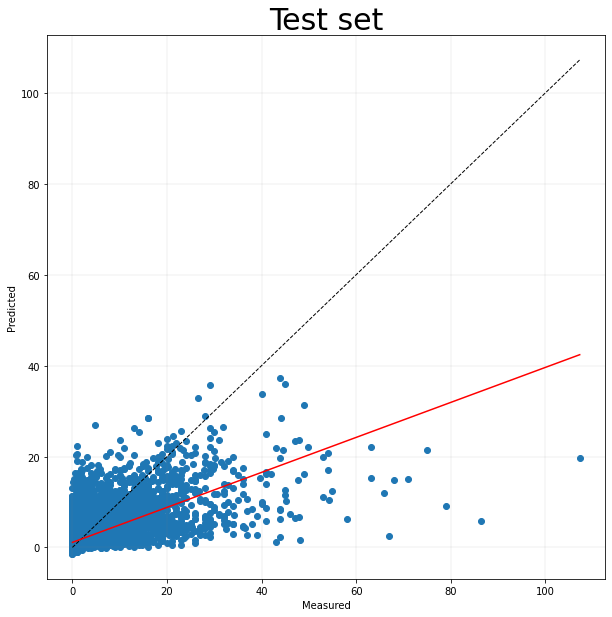

[0.3849277  1.11033488]
RMSE
[3.61665567]
R2
0.410525615628321


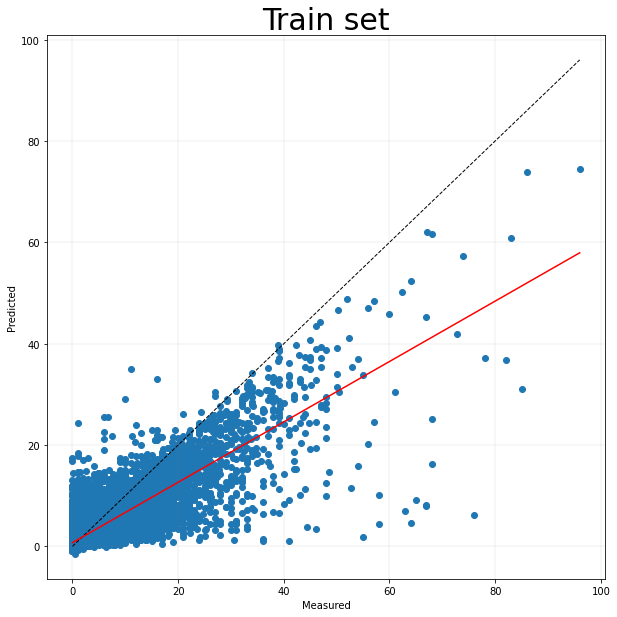

[0.59582174 0.7354507 ]
RMSE
[2.61853953]
R2
0.6948176034372289


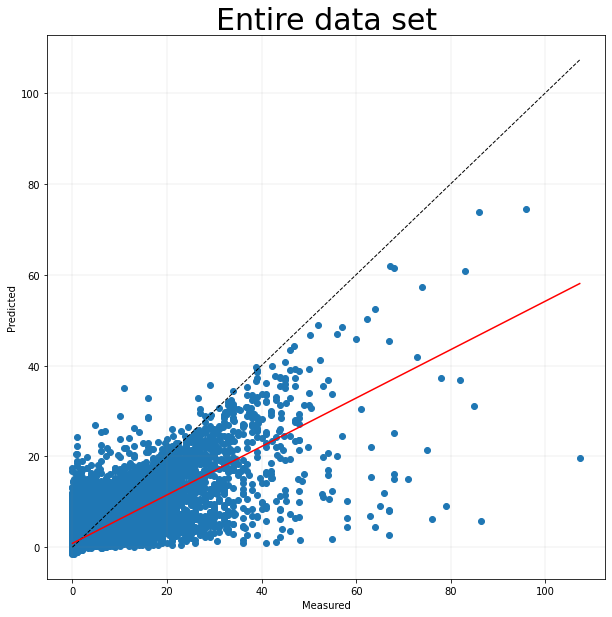

[0.5331062  0.84798113]
RMSE
[2.95360679]
R2
0.6102735436152836


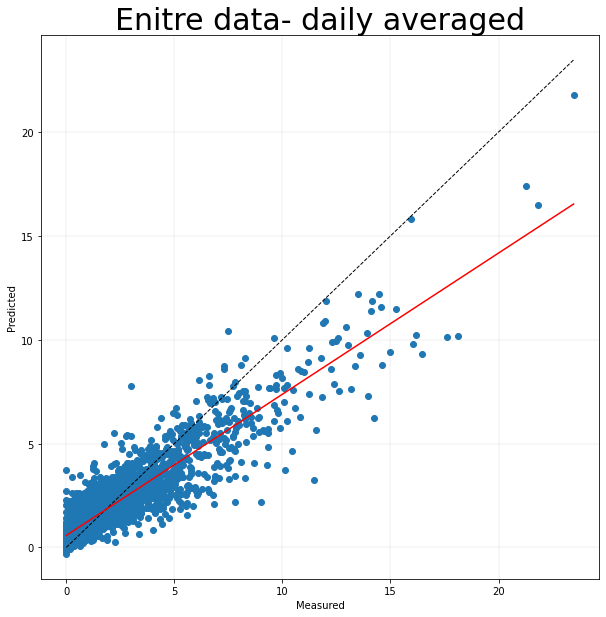

[0.67969596 0.57882899]
RMSE
[1.08442992]
R2
0.8003089201668007


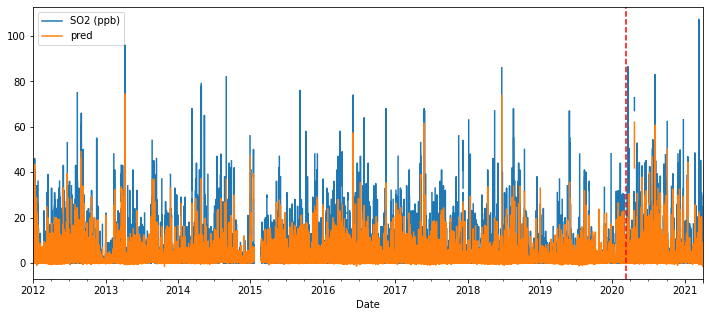

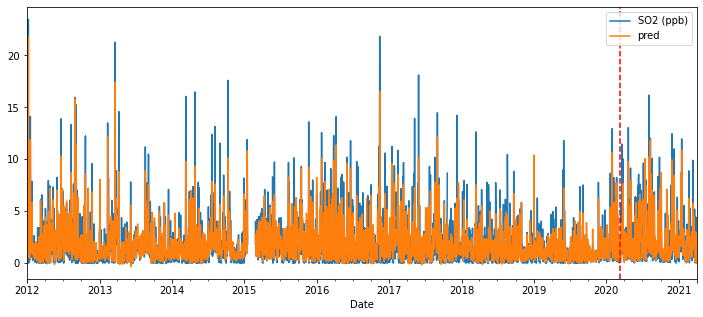

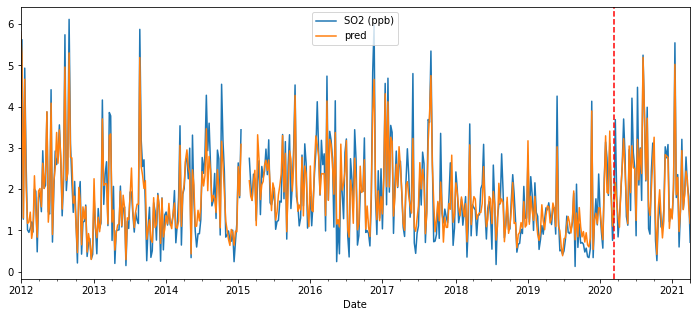

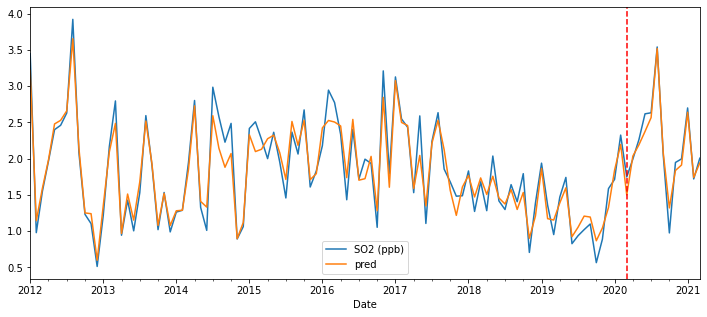

In [ ]:
model= xgb.XGBRegressor(booster = booster, reg_lambda=lambdaa, alpha=alpha,  
                          max_depth = max_depth, eta = eta, gamma = gamma,
                          grow_policy = grow_policy,
                          # n_estimators=n_estimators,
                          objective ='reg:squarederror', 
                          #normalize_type=normalize_type,sample_type=sample_type,rate_drop=rate_drop,skip_drop=skip_drop,
                          random_state=42)

eval_set = [(X_val, y_val)]
model.fit(X_traine, y_traine, early_stopping_rounds=20, eval_metric="rmse", eval_set=eval_set)


preds = model.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))


# df3= df3.copy()
df4 = df1_w_c.copy() #hereee
df4['pred'] = model.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean().copy()
df10.dropna(inplace= True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(df10['SO2 (ppb)']).reshape(-1,1)
y_pred = np.array(df10['pred']).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Enitre data- daily averaged',fontsize=30)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()
print(par)
print('RMSE')
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))



df4['SO2 (ppb)'].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = ['T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend']
test_col = ['SO2 (ppb)']


df1_w_c = df1_w[['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ 'SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2['SO2 (ppb)'] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 ['SO2 (ppb)'] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_OT_XG_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_OT_XG__Test.csv')


[2.61853953]
0.6948176034372289
[3.61665567]
0.410525615628321


In [ ]:
df4_h.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
225
1.955804467201233
2021-01-11 09:00:00
229
1.890505075454712
2021-01-11 10:00:00
211
2.1754257678985596
2021-01-11 12:00:00
211
2.5199766159057617
2021-01-11 13:00:00
213
2.5676074028015137
2021-01-11 14:00:00
211
2.717930316925049
2021-01-11 15:00:00
217
2.7153916358947754
2021-01-11 16:00:00
220
2.3243324756622314
2021-01-11 17:00:00
231
2.2888996601104736
2021-01-11 18:00:00
236
2.894345998764038
2021-01-11 19:00:00
234
2.6961514949798584
2021-01-11 20:00:00
233
2.3965110778808594
2021-01-11 21:00:00
231
2.4820339679718018
2021-01-11 22:00:00
230
2.375399589538574
2021-01-11 23:00:00
231
2.4265193939208984
2021-01-12 01:00:00
94
1.990675449371338
2021-01-12 02:00:00
94
2.3193228244781494
2021-01-12 03:00:00
192
2.133228302001953
2021-01-12 04:00:00
197
2.23591947555542
2021-01-12 06:00:00
223
2.12292218208313
2021-01-12 07:00:00
240
2.2042925357818604
2021-01-12 08:00:00
234
2.007606029510498
2021-01-12 09:00:00
238
1.92960143089

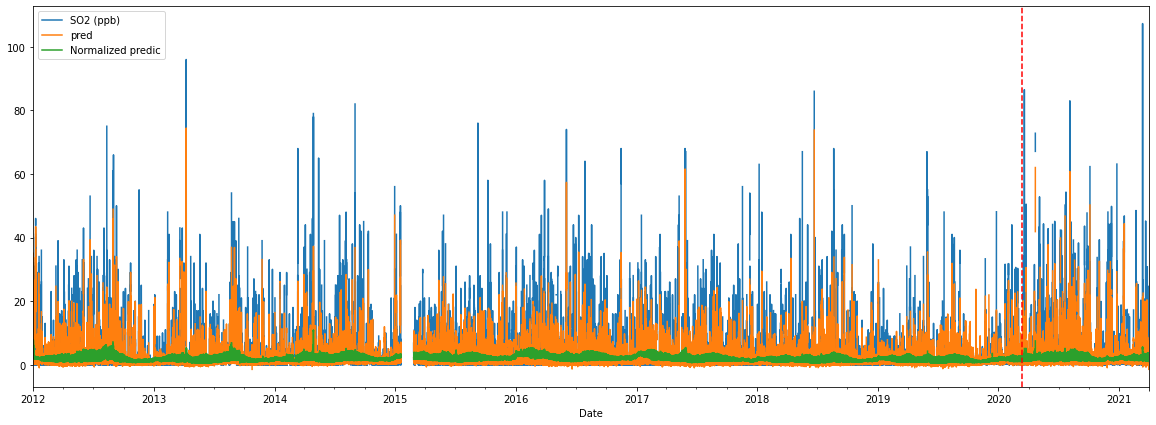

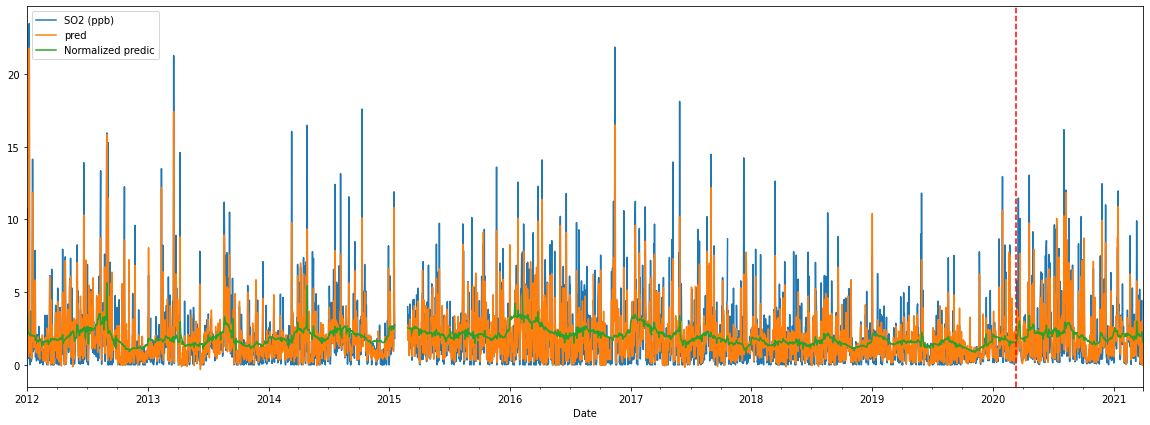

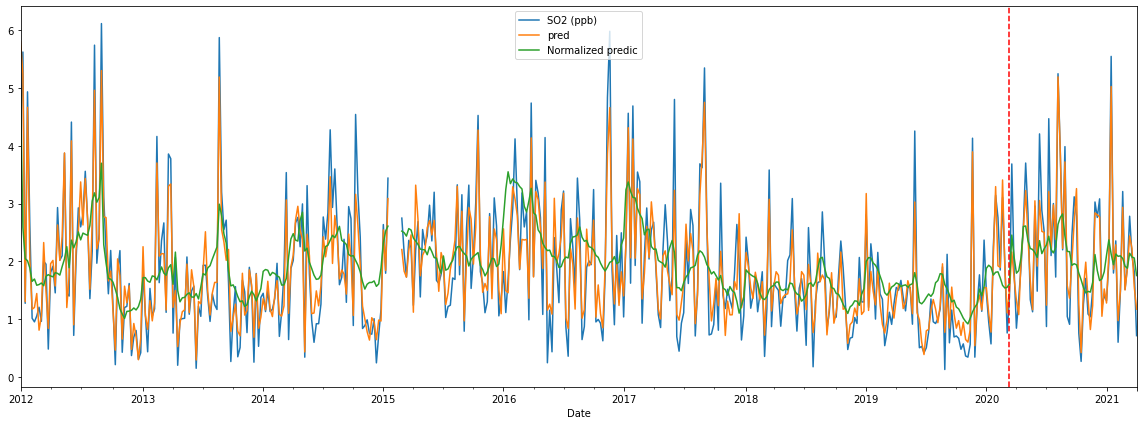

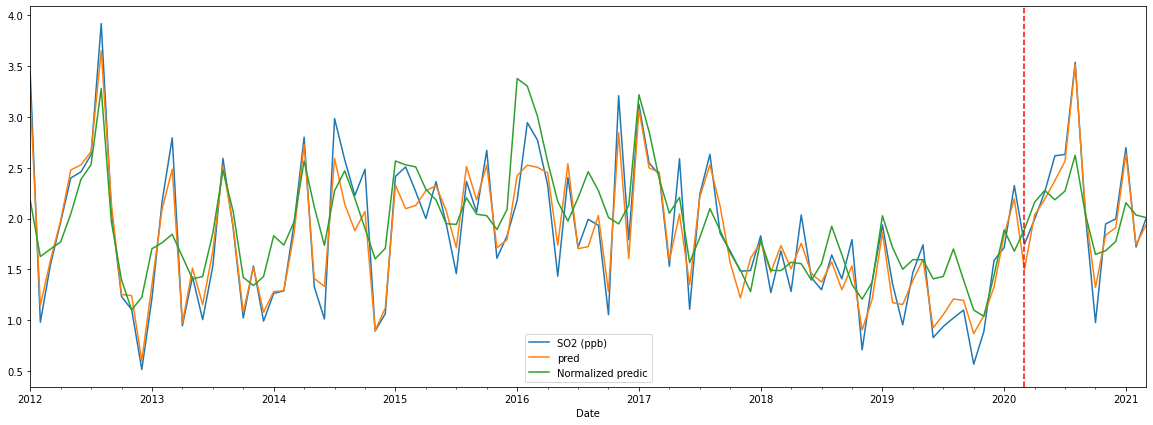

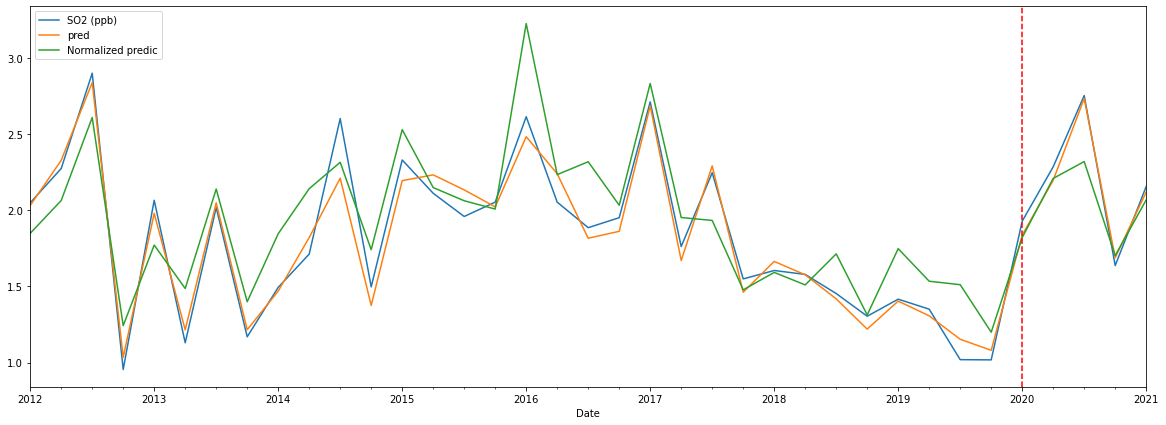

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_SO2_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_SO2_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_SO2_Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
############

In [ ]:
class Objective(object):
    def __init__(self, X, Y_scaler, max_epochs, learn_rate_epochs,
                  ):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y_scaler, test_size=0.001, random_state=42)
        # self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.11, random_state=42)
        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        self.n_features = np.shape(self.X_train)[1]

    def __call__(self, trial):        
        dict_params = {
                        'layers': trial.suggest_int('layers', 2,3),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                        'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,5000,500)),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 20,40),
                        # 'delta': trial.suggest_float(  'delta',40, 100),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                       'drop_out1': trial.suggest_float('drop_out1',0.05, 0.3)}  
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        dict_params['num_dense_nodes2'] = trial.suggest_int('num_dense_nodes2', 20,40)
        dict_params['drop_out2'] =trial.suggest_float('drop_out2',0.05, 0.5)

        if dict_params['layers'] == 3:
            dict_params['num_dense_nodes3'] = trial.suggest_int('num_dense_nodes3', 5,40)
            dict_params['drop_out3'] = trial.suggest_float('drop_out3',0.05, 0.5)
          
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(dict_params['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha= dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out1']))
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        model.add(Dense(dict_params['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out2']))
        if dict_params['layers'] == 3 :
            model.add(Dense(dict_params['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
            model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
            model.add(Dropout(dict_params['drop_out3']))
        model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params[ 'learning_rate'])
        model.compile(loss='mse',
                      # tf.keras.losses.Huber( delta=dict_params[ 'delta']),
                      # 'mse'
                          optimizer=opt)
        fn = "gdrive/My Drive/Colab Notebooks/Stations/Mildred_Lake_SO2" +str(trial.number) + ".ckpt" 
        fnn = os.path.dirname(fn)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]

        n_f = 5
        kf = KFold(n_splits=n_f )
        acc = 0 
        for train_index, test_index in kf.split( self.X_train):   
                X_tr, X_tes =  self.X_train[train_index],  self.X_train[test_index]
                y_tr, y_tes =   self.y_train[train_index],   self.y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state = 42)
                h = model.fit(x=X_tra, y=y_tra,
                                  validation_data=(X_val, y_val),
                                  batch_size=dict_params['batchsize'],
                                  epochs=self.max_epochs,
                                  shuffle=True, verbose=0,
                                  callbacks=callbacks_list)
                model.load_weights(fn)
                preds = model.predict(X_tes)
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 


        print(acc)
        return acc    

In [ ]:
objective = Objective(X,Y,maximum_epochs,learning_rate_epochs)
study = optuna.create_study(direction=optimizer_direction, study_name='Mildred_Lake__NN', storage='sqlite:///Mildred__Lake__NN.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=500)
df_results = study.trials_dataframe()
df_results.to_csv('gdrive/My Drive/Colab Notebooks/results/NN_out_Mildred_Lake_SO2_2013_HP_HUBer.csv')
#df_results.to_pickle('Desktop\heel\df_optuna_results.pkl')

[I 2021-05-14 05:01:47,903] Using an existing study with name 'Mildred_Lake__NN' instead of creating a new one.
[I 2021-05-14 05:04:44,306] Trial 19 finished with value: 14.817321140247119 and parameters: {'layers': 2, 'alpha': 0.12745539085732224, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.07161153176760525, 'drop_out1': 0.053404390428800866, 'num_dense_nodes2': 36, 'drop_out2': 0.12346223426629267}. Best is trial 16 with value: 14.537333496261152.


14.817321140247119


[I 2021-05-14 05:07:39,327] Trial 20 finished with value: 17.605670850249233 and parameters: {'layers': 2, 'alpha': 0.327308864883451, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.0804403739829242, 'drop_out1': 0.09552061702122204, 'num_dense_nodes2': 35, 'drop_out2': 0.3354110032344896}. Best is trial 16 with value: 14.537333496261152.


17.605670850249233


[I 2021-05-14 05:10:36,439] Trial 21 finished with value: 20.670560751352923 and parameters: {'layers': 2, 'alpha': 0.8553505769577274, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.07795819181774251, 'drop_out1': 0.06306046405695893, 'num_dense_nodes2': 34, 'drop_out2': 0.13137781549445643}. Best is trial 16 with value: 14.537333496261152.


20.670560751352923


[I 2021-05-14 05:12:30,368] Trial 22 finished with value: 14.338290203438 and parameters: {'layers': 2, 'alpha': 0.12410150818029629, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.06165076961433188, 'drop_out1': 0.08518185158823464, 'num_dense_nodes2': 38, 'drop_out2': 0.10806159284301207}. Best is trial 22 with value: 14.338290203438.


14.338290203438


[I 2021-05-14 05:33:25,674] Trial 23 finished with value: 16.667141740390495 and parameters: {'layers': 2, 'alpha': 0.09441860797661232, 'batchsize': 100.0, 'num_dense_nodes1': 34, 'learning_rate': 0.058727884111618806, 'drop_out1': 0.10178723815319635, 'num_dense_nodes2': 38, 'drop_out2': 0.21599235182890159}. Best is trial 22 with value: 14.338290203438.


16.667141740390495


[I 2021-05-14 05:35:47,414] Trial 24 finished with value: 15.995420190526247 and parameters: {'layers': 2, 'alpha': 0.2773064593762784, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.056334437409665705, 'drop_out1': 0.11566272128560048, 'num_dense_nodes2': 38, 'drop_out2': 0.09663025002549558}. Best is trial 22 with value: 14.338290203438.


15.995420190526247


[I 2021-05-14 05:37:39,123] Trial 25 finished with value: 14.172445146689629 and parameters: {'layers': 2, 'alpha': 0.11198309369287185, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.07430755832919826, 'drop_out1': 0.05111463774909724, 'num_dense_nodes2': 34, 'drop_out2': 0.16731158580645222}. Best is trial 25 with value: 14.172445146689629.


14.172445146689629


[I 2021-05-14 05:39:31,300] Trial 26 finished with value: 14.413362097261452 and parameters: {'layers': 2, 'alpha': 0.10317597627330526, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'learning_rate': 0.08784499979512148, 'drop_out1': 0.07712841776705626, 'num_dense_nodes2': 34, 'drop_out2': 0.1713336545431671}. Best is trial 25 with value: 14.172445146689629.


14.413362097261452


[I 2021-05-14 05:41:22,265] Trial 27 finished with value: 15.297443493154333 and parameters: {'layers': 2, 'alpha': 0.1929371103546872, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'learning_rate': 0.0877860031386989, 'drop_out1': 0.07399378037281584, 'num_dense_nodes2': 34, 'drop_out2': 0.17328752842518197}. Best is trial 25 with value: 14.172445146689629.


15.297443493154333


[I 2021-05-14 05:43:10,544] Trial 28 finished with value: 17.44792381564862 and parameters: {'layers': 2, 'alpha': 0.29856589306316567, 'batchsize': 2600.0, 'num_dense_nodes1': 30, 'learning_rate': 0.08685532343297271, 'drop_out1': 0.1388957142646739, 'num_dense_nodes2': 30, 'drop_out2': 0.2938530034382081}. Best is trial 25 with value: 14.172445146689629.


17.44792381564862


[I 2021-05-14 05:45:27,796] Trial 29 finished with value: 17.50366899493242 and parameters: {'layers': 2, 'alpha': 0.3971093998108761, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.07257194925164426, 'drop_out1': 0.05062916418785839, 'num_dense_nodes2': 33, 'drop_out2': 0.22308208528379905}. Best is trial 25 with value: 14.172445146689629.


17.50366899493242


[I 2021-05-14 05:47:45,922] Trial 30 finished with value: 14.41242457547995 and parameters: {'layers': 2, 'alpha': 0.06735450768940525, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.08775086338028044, 'drop_out1': 0.10048229548833118, 'num_dense_nodes2': 28, 'drop_out2': 0.0879610739761208}. Best is trial 25 with value: 14.172445146689629.


14.41242457547995


[I 2021-05-14 05:50:04,276] Trial 31 finished with value: 17.791785067131464 and parameters: {'layers': 2, 'alpha': 0.4355538958756946, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.056942345150125806, 'drop_out1': 0.10411946982313568, 'num_dense_nodes2': 28, 'drop_out2': 0.08374961731531883}. Best is trial 25 with value: 14.172445146689629.


17.791785067131464


[I 2021-05-14 05:52:02,754] Trial 32 finished with value: 14.248034194646362 and parameters: {'layers': 2, 'alpha': 0.07762242210944136, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.08724993262396681, 'drop_out1': 0.08879380624664335, 'num_dense_nodes2': 28, 'drop_out2': 0.1588422800714785}. Best is trial 25 with value: 14.172445146689629.


14.248034194646362


[I 2021-05-14 05:54:02,314] Trial 33 finished with value: 16.284120527340765 and parameters: {'layers': 2, 'alpha': 0.21921449852312272, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.08342297609816984, 'drop_out1': 0.14709858693676386, 'num_dense_nodes2': 28, 'drop_out2': 0.14857972494085597}. Best is trial 25 with value: 14.172445146689629.


16.284120527340765


[I 2021-05-14 05:58:20,355] Trial 34 finished with value: 15.615379013774312 and parameters: {'layers': 2, 'alpha': 0.06376552687170275, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.07443426757092393, 'drop_out1': 0.12567645084248003, 'num_dense_nodes2': 26, 'drop_out2': 0.20652753131388396}. Best is trial 25 with value: 14.172445146689629.


15.615379013774312


[I 2021-05-14 06:00:19,811] Trial 35 finished with value: 15.085806724421623 and parameters: {'layers': 2, 'alpha': 0.17065848983300014, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.09100775962390462, 'drop_out1': 0.08947741032918254, 'num_dense_nodes2': 29, 'drop_out2': 0.09827321539451826}. Best is trial 25 with value: 14.172445146689629.


15.085806724421623


[I 2021-05-14 06:02:37,304] Trial 36 finished with value: 15.39036336341996 and parameters: {'layers': 2, 'alpha': 0.08065143093987992, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.09957279888213566, 'drop_out1': 0.1168947927308846, 'num_dense_nodes2': 24, 'drop_out2': 0.23912014560490338}. Best is trial 25 with value: 14.172445146689629.


15.39036336341996


[I 2021-05-14 06:04:20,677] Trial 37 finished with value: 14.980919136110233 and parameters: {'layers': 2, 'alpha': 0.15535787301679055, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.07644762594080279, 'drop_out1': 0.06510394584009863, 'num_dense_nodes2': 32, 'drop_out2': 0.15933061538029472}. Best is trial 25 with value: 14.172445146689629.


14.980919136110233


[I 2021-05-14 06:06:09,357] Trial 38 finished with value: 16.155384049851065 and parameters: {'layers': 2, 'alpha': 0.24144633750156352, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.0925533407856012, 'drop_out1': 0.1628452033907985, 'num_dense_nodes2': 26, 'drop_out2': 0.0900633117983616}. Best is trial 25 with value: 14.172445146689629.


16.155384049851065


[I 2021-05-14 06:08:08,626] Trial 39 finished with value: 14.23919244025285 and parameters: {'layers': 2, 'alpha': 0.012770827988867417, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'learning_rate': 0.08345513790072673, 'drop_out1': 0.10798268803779096, 'num_dense_nodes2': 24, 'drop_out2': 0.2767695004540964}. Best is trial 25 with value: 14.172445146689629.


14.23919244025285


[I 2021-05-14 06:10:11,441] Trial 40 finished with value: 15.104108586775606 and parameters: {'layers': 3, 'alpha': 0.016393593850658146, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0701540840412385, 'drop_out1': 0.11102188604520156, 'num_dense_nodes2': 24, 'drop_out2': 0.3003880601028058, 'num_dense_nodes3': 40, 'drop_out3': 0.13938115483610786}. Best is trial 25 with value: 14.172445146689629.


15.104108586775606


[I 2021-05-14 06:11:49,048] Trial 41 finished with value: 19.018148029027444 and parameters: {'layers': 2, 'alpha': 0.615762123829389, 'batchsize': 3600.0, 'num_dense_nodes1': 32, 'learning_rate': 0.06063090966352711, 'drop_out1': 0.08905890066033094, 'num_dense_nodes2': 31, 'drop_out2': 0.2567429290849222}. Best is trial 25 with value: 14.172445146689629.


19.018148029027444


[I 2021-05-14 06:14:05,588] Trial 42 finished with value: 20.3871388644064 and parameters: {'layers': 2, 'alpha': 0.7770653528911604, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.08267024732037867, 'drop_out1': 0.1355816529558013, 'num_dense_nodes2': 22, 'drop_out2': 0.3192871633728608}. Best is trial 25 with value: 14.172445146689629.


20.3871388644064


[I 2021-05-14 06:16:05,600] Trial 43 finished with value: 15.375863692666256 and parameters: {'layers': 2, 'alpha': 0.06860599818702545, 'batchsize': 2100.0, 'num_dense_nodes1': 20, 'learning_rate': 0.09685971521668207, 'drop_out1': 0.06690691579979564, 'num_dense_nodes2': 27, 'drop_out2': 0.345903603339833}. Best is trial 25 with value: 14.172445146689629.


15.375863692666256


[I 2021-05-14 06:18:05,613] Trial 44 finished with value: 14.97367467051473 and parameters: {'layers': 2, 'alpha': 0.14666743049936234, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'learning_rate': 0.08380156286004313, 'drop_out1': 0.09430389322079999, 'num_dense_nodes2': 24, 'drop_out2': 0.1924696317371516}. Best is trial 25 with value: 14.172445146689629.


14.97367467051473


[I 2021-05-14 06:19:55,451] Trial 45 finished with value: 16.075798344373197 and parameters: {'layers': 2, 'alpha': 0.20154574596198283, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.09371337778006096, 'drop_out1': 0.12643706689449347, 'num_dense_nodes2': 29, 'drop_out2': 0.24068032330144046}. Best is trial 25 with value: 14.172445146689629.


16.075798344373197


[I 2021-05-14 06:22:14,184] Trial 46 finished with value: 14.866919111988196 and parameters: {'layers': 2, 'alpha': 0.01018174110885394, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.07584303875223264, 'drop_out1': 0.10628013925980843, 'num_dense_nodes2': 20, 'drop_out2': 0.27209747827589575}. Best is trial 25 with value: 14.172445146689629.


14.866919111988196


[I 2021-05-14 06:23:57,979] Trial 47 finished with value: 14.526613482853872 and parameters: {'layers': 2, 'alpha': 0.05890890137429931, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.0791183202755334, 'drop_out1': 0.08514664366376978, 'num_dense_nodes2': 25, 'drop_out2': 0.3940415956073651}. Best is trial 25 with value: 14.172445146689629.


14.526613482853872


[I 2021-05-14 06:28:30,848] Trial 48 finished with value: 15.935063849752929 and parameters: {'layers': 3, 'alpha': 0.2653051186389453, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.053640763684964565, 'drop_out1': 0.16219910354717879, 'num_dense_nodes2': 27, 'drop_out2': 0.07646351381611334, 'num_dense_nodes3': 40, 'drop_out3': 0.19104159939625037}. Best is trial 25 with value: 14.172445146689629.


15.935063849752929


[I 2021-05-14 06:30:30,419] Trial 49 finished with value: 14.122223717878768 and parameters: {'layers': 2, 'alpha': 0.10752743043181703, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.08933310611736288, 'drop_out1': 0.07154943250951884, 'num_dense_nodes2': 22, 'drop_out2': 0.051365400031446524}. Best is trial 49 with value: 14.122223717878768.


14.122223717878768


[I 2021-05-14 06:32:19,916] Trial 50 finished with value: 13.930948061560711 and parameters: {'layers': 2, 'alpha': 0.012588258365282184, 'batchsize': 2600.0, 'num_dense_nodes1': 32, 'learning_rate': 0.07065113912060617, 'drop_out1': 0.052722867907738946, 'num_dense_nodes2': 22, 'drop_out2': 0.2874576524345749}. Best is trial 50 with value: 13.930948061560711.


13.930948061560711


[I 2021-05-14 06:34:20,282] Trial 51 finished with value: 15.142780915645186 and parameters: {'layers': 2, 'alpha': 0.013448160238354413, 'batchsize': 2100.0, 'num_dense_nodes1': 28, 'learning_rate': 0.09521409057198593, 'drop_out1': 0.0695315815614698, 'num_dense_nodes2': 22, 'drop_out2': 0.2912309146211369}. Best is trial 50 with value: 13.930948061560711.


15.142780915645186


[I 2021-05-14 06:36:10,508] Trial 52 finished with value: 14.219293484610722 and parameters: {'layers': 2, 'alpha': 0.1007841543499759, 'batchsize': 2600.0, 'num_dense_nodes1': 32, 'learning_rate': 0.06298977621956958, 'drop_out1': 0.05034154606282632, 'num_dense_nodes2': 20, 'drop_out2': 0.05184391441456798}. Best is trial 50 with value: 13.930948061560711.


14.219293484610722


[I 2021-05-14 06:37:54,053] Trial 53 finished with value: 14.862101436338046 and parameters: {'layers': 2, 'alpha': 0.09660694145312065, 'batchsize': 3100.0, 'num_dense_nodes1': 32, 'learning_rate': 0.0678169289887515, 'drop_out1': 0.052792518962894254, 'num_dense_nodes2': 20, 'drop_out2': 0.35210133663718346}. Best is trial 50 with value: 13.930948061560711.


14.862101436338046


[I 2021-05-14 06:39:43,518] Trial 54 finished with value: 14.281780287750445 and parameters: {'layers': 2, 'alpha': 0.03245368263353523, 'batchsize': 2600.0, 'num_dense_nodes1': 30, 'learning_rate': 0.08132074130551109, 'drop_out1': 0.05843975043979381, 'num_dense_nodes2': 21, 'drop_out2': 0.25420251397297255}. Best is trial 50 with value: 13.930948061560711.


14.281780287750445


[I 2021-05-14 06:41:43,584] Trial 55 finished with value: 15.26947665629559 and parameters: {'layers': 2, 'alpha': 0.1536451445892685, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'learning_rate': 0.07052383105947606, 'drop_out1': 0.05047909269932511, 'num_dense_nodes2': 23, 'drop_out2': 0.3229821486664633}. Best is trial 50 with value: 13.930948061560711.


15.26947665629559


[I 2021-05-14 06:43:25,967] Trial 56 finished with value: 17.143535465226897 and parameters: {'layers': 2, 'alpha': 0.1905745659721512, 'batchsize': 3100.0, 'num_dense_nodes1': 31, 'learning_rate': 0.07484871644956578, 'drop_out1': 0.21663913005220586, 'num_dense_nodes2': 21, 'drop_out2': 0.27922424193724266}. Best is trial 50 with value: 13.930948061560711.


17.143535465226897


[I 2021-05-14 06:45:15,471] Trial 57 finished with value: 18.075758079304165 and parameters: {'layers': 2, 'alpha': 0.5303358568543094, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.06312549373869278, 'drop_out1': 0.07354901660733937, 'num_dense_nodes2': 23, 'drop_out2': 0.06109740209262446}. Best is trial 50 with value: 13.930948061560711.


18.075758079304165


[I 2021-05-14 06:46:54,751] Trial 58 finished with value: 14.984412242758568 and parameters: {'layers': 2, 'alpha': 0.10974565445515448, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'learning_rate': 0.04516500166306643, 'drop_out1': 0.05944775072608884, 'num_dense_nodes2': 23, 'drop_out2': 0.2277221002555675}. Best is trial 50 with value: 13.930948061560711.


14.984412242758568


[I 2021-05-14 06:49:02,373] Trial 59 finished with value: 15.074335856843074 and parameters: {'layers': 2, 'alpha': 0.04277666497022832, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'learning_rate': 0.004766055831817655, 'drop_out1': 0.05068345252578231, 'num_dense_nodes2': 21, 'drop_out2': 0.48576640359160217}. Best is trial 50 with value: 13.930948061560711.


15.074335856843074


[I 2021-05-14 06:50:51,391] Trial 60 finished with value: 19.82522242319052 and parameters: {'layers': 2, 'alpha': 0.7710119886942886, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.08561814931892477, 'drop_out1': 0.0816302884436388, 'num_dense_nodes2': 25, 'drop_out2': 0.36559361340469165}. Best is trial 50 with value: 13.930948061560711.


19.82522242319052


[I 2021-05-14 06:52:28,832] Trial 61 finished with value: 15.851526219975433 and parameters: {'layers': 2, 'alpha': 0.011051116654209547, 'batchsize': 3600.0, 'num_dense_nodes1': 33, 'learning_rate': 0.0680171157113756, 'drop_out1': 0.25787656761121763, 'num_dense_nodes2': 20, 'drop_out2': 0.19795662117878354}. Best is trial 50 with value: 13.930948061560711.


15.851526219975433


[I 2021-05-14 06:54:18,333] Trial 62 finished with value: 14.75602779711323 and parameters: {'layers': 2, 'alpha': 0.04271253166550669, 'batchsize': 2600.0, 'num_dense_nodes1': 26, 'learning_rate': 0.07968180586897777, 'drop_out1': 0.0637864314067444, 'num_dense_nodes2': 21, 'drop_out2': 0.25529555349973}. Best is trial 50 with value: 13.930948061560711.


14.75602779711323


[I 2021-05-14 06:56:02,149] Trial 63 finished with value: 14.10550033837707 and parameters: {'layers': 2, 'alpha': 0.08644316290447357, 'batchsize': 3100.0, 'num_dense_nodes1': 30, 'learning_rate': 0.0909493732063491, 'drop_out1': 0.058095811151916456, 'num_dense_nodes2': 22, 'drop_out2': 0.0504046283675584}. Best is trial 50 with value: 13.930948061560711.


14.10550033837707


[I 2021-05-14 06:57:45,784] Trial 64 finished with value: 14.375469819555832 and parameters: {'layers': 2, 'alpha': 0.09137594018008091, 'batchsize': 3100.0, 'num_dense_nodes1': 30, 'learning_rate': 0.0898042831067013, 'drop_out1': 0.0705591664914855, 'num_dense_nodes2': 22, 'drop_out2': 0.05109593475440571}. Best is trial 50 with value: 13.930948061560711.


14.375469819555832


[I 2021-05-14 06:59:21,349] Trial 65 finished with value: 14.426062225385419 and parameters: {'layers': 2, 'alpha': 0.11030216260468037, 'batchsize': 4100.0, 'num_dense_nodes1': 28, 'learning_rate': 0.09012872588789148, 'drop_out1': 0.05016530914063884, 'num_dense_nodes2': 23, 'drop_out2': 0.06900267631881918}. Best is trial 50 with value: 13.930948061560711.


14.426062225385419


[I 2021-05-14 07:01:21,406] Trial 66 finished with value: 16.078774993817227 and parameters: {'layers': 2, 'alpha': 0.18015517183311996, 'batchsize': 2100.0, 'num_dense_nodes1': 31, 'learning_rate': 0.09964816855371673, 'drop_out1': 0.07752188012595104, 'num_dense_nodes2': 22, 'drop_out2': 0.3129575666020299}. Best is trial 50 with value: 13.930948061560711.


16.078774993817227


[I 2021-05-14 07:03:04,472] Trial 67 finished with value: 15.097701942832089 and parameters: {'layers': 2, 'alpha': 0.13582277339085264, 'batchsize': 3100.0, 'num_dense_nodes1': 29, 'learning_rate': 0.08459182761462711, 'drop_out1': 0.059712000383831274, 'num_dense_nodes2': 25, 'drop_out2': 0.28285708868905435}. Best is trial 50 with value: 13.930948061560711.


15.097701942832089


[I 2021-05-14 07:04:55,377] Trial 68 finished with value: 15.69213399283114 and parameters: {'layers': 2, 'alpha': 0.22236090384500443, 'batchsize': 2600.0, 'num_dense_nodes1': 32, 'learning_rate': 0.0777277647024372, 'drop_out1': 0.09267843268139528, 'num_dense_nodes2': 21, 'drop_out2': 0.13516043435327815}. Best is trial 50 with value: 13.930948061560711.


15.69213399283114


[I 2021-05-14 07:06:57,432] Trial 69 finished with value: 15.293176218853379 and parameters: {'layers': 2, 'alpha': 0.0763193493427445, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.07360006363612721, 'drop_out1': 0.19749001276108452, 'num_dense_nodes2': 20, 'drop_out2': 0.10301854452924672}. Best is trial 50 with value: 13.930948061560711.


15.293176218853379


[I 2021-05-14 07:08:47,739] Trial 70 finished with value: 14.299503553914178 and parameters: {'layers': 2, 'alpha': 0.05005523817400395, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'learning_rate': 0.05208441895058679, 'drop_out1': 0.07946097871129801, 'num_dense_nodes2': 31, 'drop_out2': 0.3083249009705854}. Best is trial 50 with value: 13.930948061560711.


14.299503553914178


[I 2021-05-14 07:10:31,859] Trial 71 finished with value: 15.08896810285518 and parameters: {'layers': 2, 'alpha': 0.13822759576010377, 'batchsize': 3100.0, 'num_dense_nodes1': 31, 'learning_rate': 0.09282781753405647, 'drop_out1': 0.07024272509762923, 'num_dense_nodes2': 24, 'drop_out2': 0.17987800337945825}. Best is trial 50 with value: 13.930948061560711.


15.08896810285518


[I 2021-05-14 07:12:22,490] Trial 72 finished with value: 14.067195621335706 and parameters: {'layers': 2, 'alpha': 0.03447329860724995, 'batchsize': 2600.0, 'num_dense_nodes1': 30, 'learning_rate': 0.08259194013992903, 'drop_out1': 0.056818567033849667, 'num_dense_nodes2': 21, 'drop_out2': 0.12006277278658138}. Best is trial 50 with value: 13.930948061560711.


14.067195621335706


[I 2021-05-14 07:14:11,714] Trial 73 finished with value: 14.540780064293754 and parameters: {'layers': 2, 'alpha': 0.09240063004262505, 'batchsize': 2600.0, 'num_dense_nodes1': 27, 'learning_rate': 0.08679670848174714, 'drop_out1': 0.056167022410468635, 'num_dense_nodes2': 22, 'drop_out2': 0.12049370050758093}. Best is trial 50 with value: 13.930948061560711.


14.540780064293754


[I 2021-05-14 07:16:12,587] Trial 74 finished with value: 14.344113971503235 and parameters: {'layers': 2, 'alpha': 0.04458289987116958, 'batchsize': 2100.0, 'num_dense_nodes1': 29, 'learning_rate': 0.08147947511439614, 'drop_out1': 0.06352191874824749, 'num_dense_nodes2': 23, 'drop_out2': 0.14541986280101177}. Best is trial 50 with value: 13.930948061560711.


14.344113971503235


[I 2021-05-14 07:18:03,071] Trial 75 finished with value: 13.690269640030827 and parameters: {'layers': 2, 'alpha': 0.010007616712389145, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.06533201221489313, 'drop_out1': 0.0501616059762174, 'num_dense_nodes2': 20, 'drop_out2': 0.07679424432183873}. Best is trial 75 with value: 13.690269640030827.


13.690269640030827


[I 2021-05-14 07:19:54,143] Trial 76 finished with value: 13.524476827924875 and parameters: {'layers': 2, 'alpha': 0.015463303693347585, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.06458868565631623, 'drop_out1': 0.056801716589419356, 'num_dense_nodes2': 20, 'drop_out2': 0.050910074792240995}. Best is trial 76 with value: 13.524476827924875.


13.524476827924875


[I 2021-05-14 07:21:39,741] Trial 77 finished with value: 14.214863267104544 and parameters: {'layers': 2, 'alpha': 0.11749998994940644, 'batchsize': 3100.0, 'num_dense_nodes1': 34, 'learning_rate': 0.06504421156617077, 'drop_out1': 0.051230341758493884, 'num_dense_nodes2': 20, 'drop_out2': 0.05136729387734562}. Best is trial 76 with value: 13.524476827924875.


14.214863267104544


[I 2021-05-14 07:23:24,706] Trial 78 finished with value: 13.670325753947976 and parameters: {'layers': 2, 'alpha': 0.030093929078130945, 'batchsize': 3100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.05766410084653329, 'drop_out1': 0.0565271041192491, 'num_dense_nodes2': 21, 'drop_out2': 0.07453339955216326}. Best is trial 76 with value: 13.524476827924875.


13.670325753947976


[I 2021-05-14 07:25:08,023] Trial 79 finished with value: 13.519748272546686 and parameters: {'layers': 2, 'alpha': 0.031215868359977528, 'batchsize': 3100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.058584307943997396, 'drop_out1': 0.06512124985579174, 'num_dense_nodes2': 21, 'drop_out2': 0.07138685481710681}. Best is trial 79 with value: 13.519748272546686.


13.519748272546686


[I 2021-05-14 07:26:47,746] Trial 80 finished with value: 13.6062363835345 and parameters: {'layers': 2, 'alpha': 0.030063340333241838, 'batchsize': 3600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.055706477877017394, 'drop_out1': 0.0590116558340413, 'num_dense_nodes2': 21, 'drop_out2': 0.07626777752631109}. Best is trial 79 with value: 13.519748272546686.


13.6062363835345


[I 2021-05-14 07:28:26,621] Trial 81 finished with value: 13.381957765245724 and parameters: {'layers': 2, 'alpha': 0.031442471273776085, 'batchsize': 3600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.04628712051272936, 'drop_out1': 0.05660757245623354, 'num_dense_nodes2': 21, 'drop_out2': 0.07490243089374807}. Best is trial 81 with value: 13.381957765245724.


13.381957765245724


[I 2021-05-14 07:30:00,729] Trial 82 finished with value: 13.514067709750679 and parameters: {'layers': 2, 'alpha': 0.03454013220866363, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.04555737253886184, 'drop_out1': 0.05862191512053152, 'num_dense_nodes2': 21, 'drop_out2': 0.07359085409695165}. Best is trial 81 with value: 13.381957765245724.


13.514067709750679


[I 2021-05-14 07:31:36,544] Trial 83 finished with value: 13.421153014629144 and parameters: {'layers': 2, 'alpha': 0.02192261182428394, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02991427444810677, 'drop_out1': 0.06311003698222716, 'num_dense_nodes2': 21, 'drop_out2': 0.07592615944157678}. Best is trial 81 with value: 13.381957765245724.


13.421153014629144


[I 2021-05-14 07:33:10,559] Trial 84 finished with value: 13.796488171751419 and parameters: {'layers': 2, 'alpha': 0.01105828012933904, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.03548106936592426, 'drop_out1': 0.06456156392533915, 'num_dense_nodes2': 21, 'drop_out2': 0.07361520352104085}. Best is trial 81 with value: 13.381957765245724.


13.796488171751419


[I 2021-05-14 07:34:46,157] Trial 85 finished with value: 13.46363163260628 and parameters: {'layers': 2, 'alpha': 0.05969098685419778, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.03203647145270451, 'drop_out1': 0.06614821529976607, 'num_dense_nodes2': 21, 'drop_out2': 0.07709105739659473}. Best is trial 81 with value: 13.381957765245724.


13.46363163260628


[I 2021-05-14 07:36:22,437] Trial 86 finished with value: 13.538876156180805 and parameters: {'layers': 2, 'alpha': 0.050513340584370736, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02734942750870869, 'drop_out1': 0.07658470193004434, 'num_dense_nodes2': 20, 'drop_out2': 0.08240146187748588}. Best is trial 81 with value: 13.381957765245724.


13.538876156180805


[I 2021-05-14 07:37:59,186] Trial 87 finished with value: 13.839642447328934 and parameters: {'layers': 2, 'alpha': 0.060254870648079245, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02749758415187056, 'drop_out1': 0.07789261815344849, 'num_dense_nodes2': 20, 'drop_out2': 0.08846620070931349}. Best is trial 81 with value: 13.381957765245724.


13.839642447328934


[I 2021-05-14 07:39:32,203] Trial 88 finished with value: 13.848003188367613 and parameters: {'layers': 2, 'alpha': 0.060589924134155274, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.026123907563604144, 'drop_out1': 0.08428732599918774, 'num_dense_nodes2': 21, 'drop_out2': 0.10069200190743906}. Best is trial 81 with value: 13.381957765245724.


13.848003188367613


[I 2021-05-14 07:41:09,092] Trial 89 finished with value: 13.847893037588712 and parameters: {'layers': 2, 'alpha': 0.042222899715420883, 'batchsize': 4100.0, 'num_dense_nodes1': 34, 'learning_rate': 0.01929340783097997, 'drop_out1': 0.06524487141688337, 'num_dense_nodes2': 20, 'drop_out2': 0.06375285904898392}. Best is trial 81 with value: 13.381957765245724.


13.847893037588712


[I 2021-05-14 07:42:48,730] Trial 90 finished with value: 13.403212114334856 and parameters: {'layers': 2, 'alpha': 0.028423262677871874, 'batchsize': 3600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.033098685461781525, 'drop_out1': 0.07289446835992236, 'num_dense_nodes2': 21, 'drop_out2': 0.111516962097999}. Best is trial 81 with value: 13.381957765245724.


13.403212114334856


[I 2021-05-14 07:44:29,072] Trial 91 finished with value: 14.048929706836539 and parameters: {'layers': 2, 'alpha': 0.07442402039588633, 'batchsize': 3600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03130497604548044, 'drop_out1': 0.07426819724447714, 'num_dense_nodes2': 23, 'drop_out2': 0.09365876075777532}. Best is trial 81 with value: 13.381957765245724.


14.048929706836539


[I 2021-05-14 07:46:04,872] Trial 92 finished with value: 13.462113846869215 and parameters: {'layers': 2, 'alpha': 0.027599857083634584, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.0452840172965343, 'drop_out1': 0.09634069039127291, 'num_dense_nodes2': 21, 'drop_out2': 0.08192859087677062}. Best is trial 81 with value: 13.381957765245724.


13.462113846869215


[I 2021-05-14 07:47:39,851] Trial 93 finished with value: 14.177350317277604 and parameters: {'layers': 2, 'alpha': 0.026396664784782652, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.044410002888141974, 'drop_out1': 0.09769439503758931, 'num_dense_nodes2': 21, 'drop_out2': 0.10697839046804533}. Best is trial 81 with value: 13.381957765245724.


14.177350317277604


[I 2021-05-14 07:49:20,406] Trial 94 finished with value: 13.912125835791539 and parameters: {'layers': 2, 'alpha': 0.05676867540503076, 'batchsize': 3600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.03992112421957433, 'drop_out1': 0.08698196518097022, 'num_dense_nodes2': 20, 'drop_out2': 0.0807173020983525}. Best is trial 81 with value: 13.381957765245724.


13.912125835791539


[I 2021-05-14 07:50:55,788] Trial 95 finished with value: 13.39726541349053 and parameters: {'layers': 2, 'alpha': 0.025866978352362853, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03666020606884044, 'drop_out1': 0.06894562923719547, 'num_dense_nodes2': 21, 'drop_out2': 0.06240100677832091}. Best is trial 81 with value: 13.381957765245724.


13.39726541349053


[I 2021-05-14 07:52:29,607] Trial 96 finished with value: 13.599395626482137 and parameters: {'layers': 2, 'alpha': 0.0786128785530055, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03681595290972549, 'drop_out1': 0.06951955475397391, 'num_dense_nodes2': 22, 'drop_out2': 0.06002096919730213}. Best is trial 81 with value: 13.381957765245724.


13.599395626482137


[I 2021-05-14 07:54:05,973] Trial 97 finished with value: 13.48814237619571 and parameters: {'layers': 2, 'alpha': 0.01116317605387997, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.032271449526833224, 'drop_out1': 0.08330026326557882, 'num_dense_nodes2': 20, 'drop_out2': 0.11025037231644025}. Best is trial 81 with value: 13.381957765245724.


13.48814237619571


[I 2021-05-14 07:55:42,440] Trial 98 finished with value: 13.414356204879448 and parameters: {'layers': 2, 'alpha': 0.01434179319966582, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.04276656589389541, 'drop_out1': 0.08159090623228733, 'num_dense_nodes2': 22, 'drop_out2': 0.11292064135861218}. Best is trial 81 with value: 13.381957765245724.


13.414356204879448


[I 2021-05-14 07:57:13,808] Trial 99 finished with value: 19.210399117331587 and parameters: {'layers': 2, 'alpha': 0.66940699487264, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.04300457505485089, 'drop_out1': 0.09200495827022179, 'num_dense_nodes2': 22, 'drop_out2': 0.11107772187979621}. Best is trial 81 with value: 13.381957765245724.


19.210399117331587


[I 2021-05-14 07:58:47,937] Trial 100 finished with value: 13.848953154380677 and parameters: {'layers': 2, 'alpha': 0.010135665433257918, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'learning_rate': 0.048493107046354865, 'drop_out1': 0.10002661648204328, 'num_dense_nodes2': 23, 'drop_out2': 0.13174288584326316}. Best is trial 81 with value: 13.381957765245724.


13.848953154380677


[I 2021-05-14 08:00:26,368] Trial 101 finished with value: 12.97379159191192 and parameters: {'layers': 3, 'alpha': 0.028288432463230175, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.0337818210529203, 'drop_out1': 0.08281471852866154, 'num_dense_nodes2': 21, 'drop_out2': 0.09412464395157459, 'num_dense_nodes3': 7, 'drop_out3': 0.06080678225087863}. Best is trial 101 with value: 12.97379159191192.


12.97379159191192


[I 2021-05-14 08:02:04,243] Trial 102 finished with value: 13.182592524805294 and parameters: {'layers': 3, 'alpha': 0.030196451565452274, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03211232644003685, 'drop_out1': 0.08278242577639111, 'num_dense_nodes2': 21, 'drop_out2': 0.0931027973285084, 'num_dense_nodes3': 5, 'drop_out3': 0.07226882623556558}. Best is trial 101 with value: 12.97379159191192.


13.182592524805294


[I 2021-05-14 08:03:42,657] Trial 103 finished with value: 13.296419804582031 and parameters: {'layers': 3, 'alpha': 0.06740611215344428, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03254405066155826, 'drop_out1': 0.08451406775929317, 'num_dense_nodes2': 21, 'drop_out2': 0.12488402674237425, 'num_dense_nodes3': 7, 'drop_out3': 0.05698782599618851}. Best is trial 101 with value: 12.97379159191192.


13.296419804582031


[I 2021-05-14 08:05:20,529] Trial 104 finished with value: 13.269702489799696 and parameters: {'layers': 3, 'alpha': 0.06508614838407577, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03186848522213582, 'drop_out1': 0.08614110378014114, 'num_dense_nodes2': 22, 'drop_out2': 0.11571322035779025, 'num_dense_nodes3': 5, 'drop_out3': 0.053433224994026106}. Best is trial 101 with value: 12.97379159191192.


13.269702489799696


[I 2021-05-14 08:07:00,403] Trial 105 finished with value: 13.752337980491475 and parameters: {'layers': 3, 'alpha': 0.06423571562164525, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.022032801949166684, 'drop_out1': 0.11348206866364609, 'num_dense_nodes2': 22, 'drop_out2': 0.12485246248565704, 'num_dense_nodes3': 5, 'drop_out3': 0.05551807516114276}. Best is trial 101 with value: 12.97379159191192.


13.752337980491475


[I 2021-05-14 08:08:37,000] Trial 106 finished with value: 14.020221570606063 and parameters: {'layers': 3, 'alpha': 0.13188814459596365, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.033800722091471426, 'drop_out1': 0.09727509343841606, 'num_dense_nodes2': 22, 'drop_out2': 0.09397549456289042, 'num_dense_nodes3': 5, 'drop_out3': 0.07080801873661575}. Best is trial 101 with value: 12.97379159191192.


14.020221570606063


[I 2021-05-14 08:10:12,987] Trial 107 finished with value: 13.746328121404144 and parameters: {'layers': 3, 'alpha': 0.08420413961200296, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.037460613272046854, 'drop_out1': 0.12053668292475242, 'num_dense_nodes2': 23, 'drop_out2': 0.11630792184254887, 'num_dense_nodes3': 7, 'drop_out3': 0.11161068330600023}. Best is trial 101 with value: 12.97379159191192.


13.746328121404144


[I 2021-05-14 08:11:51,268] Trial 108 finished with value: 13.963605716675737 and parameters: {'layers': 3, 'alpha': 0.06844483089981884, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04170104496735795, 'drop_out1': 0.10492662049065501, 'num_dense_nodes2': 22, 'drop_out2': 0.14435964945926283, 'num_dense_nodes3': 5, 'drop_out3': 0.05257706348335485}. Best is trial 101 with value: 12.97379159191192.


13.963605716675737


[I 2021-05-14 08:13:30,608] Trial 109 finished with value: 13.67845429220004 and parameters: {'layers': 3, 'alpha': 0.12048751238957581, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.030494065358301934, 'drop_out1': 0.091452815638412, 'num_dense_nodes2': 21, 'drop_out2': 0.09956262242874964, 'num_dense_nodes3': 9, 'drop_out3': 0.11376591403076187}. Best is trial 101 with value: 12.97379159191192.


13.67845429220004


[I 2021-05-14 08:15:12,571] Trial 110 finished with value: 13.753526418563844 and parameters: {'layers': 3, 'alpha': 0.09640291250129024, 'batchsize': 3600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.029195277727629237, 'drop_out1': 0.08206263157918024, 'num_dense_nodes2': 23, 'drop_out2': 0.08670358476984508, 'num_dense_nodes3': 5, 'drop_out3': 0.053412669730715095}. Best is trial 101 with value: 12.97379159191192.


13.753526418563844


[I 2021-05-14 08:16:55,688] Trial 111 finished with value: 13.401143338878498 and parameters: {'layers': 3, 'alpha': 0.051676597641087854, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.022803684467812273, 'drop_out1': 0.07462599336324495, 'num_dense_nodes2': 21, 'drop_out2': 0.1275802313103995, 'num_dense_nodes3': 16, 'drop_out3': 0.09909181903330663}. Best is trial 101 with value: 12.97379159191192.


13.401143338878498


[I 2021-05-14 08:18:39,074] Trial 112 finished with value: 13.32327834109821 and parameters: {'layers': 3, 'alpha': 0.05128018330441017, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.023696224054178122, 'drop_out1': 0.08686457052740075, 'num_dense_nodes2': 21, 'drop_out2': 0.1282151608565666, 'num_dense_nodes3': 19, 'drop_out3': 0.10652873008225981}. Best is trial 101 with value: 12.97379159191192.


13.32327834109821


[I 2021-05-14 08:20:22,758] Trial 113 finished with value: 13.261106005514918 and parameters: {'layers': 3, 'alpha': 0.04338225976887021, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.016691894742652695, 'drop_out1': 0.08965191456368989, 'num_dense_nodes2': 22, 'drop_out2': 0.12579552399705435, 'num_dense_nodes3': 17, 'drop_out3': 0.09892594459524386}. Best is trial 101 with value: 12.97379159191192.


13.261106005514918


[I 2021-05-14 08:22:06,564] Trial 114 finished with value: 13.617517089693921 and parameters: {'layers': 3, 'alpha': 0.04600427462213908, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.01548459360825151, 'drop_out1': 0.08617621065030628, 'num_dense_nodes2': 22, 'drop_out2': 0.16285870209744996, 'num_dense_nodes3': 16, 'drop_out3': 0.09649589174825363}. Best is trial 101 with value: 12.97379159191192.


13.617517089693921


[I 2021-05-14 08:23:49,330] Trial 115 finished with value: 13.33298899902102 and parameters: {'layers': 3, 'alpha': 0.07586877706798993, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.022884784005387918, 'drop_out1': 0.07420520211429614, 'num_dense_nodes2': 22, 'drop_out2': 0.12759980794841308, 'num_dense_nodes3': 20, 'drop_out3': 0.09442362928011669}. Best is trial 101 with value: 12.97379159191192.


13.33298899902102


[I 2021-05-14 08:25:33,158] Trial 116 finished with value: 13.901849666498833 and parameters: {'layers': 3, 'alpha': 0.15734327312110646, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.02260089711110327, 'drop_out1': 0.07985950315817911, 'num_dense_nodes2': 23, 'drop_out2': 0.14035403962167356, 'num_dense_nodes3': 20, 'drop_out3': 0.09241092746165325}. Best is trial 101 with value: 12.97379159191192.


13.901849666498833


[I 2021-05-14 08:27:18,647] Trial 117 finished with value: 13.350570945499982 and parameters: {'layers': 3, 'alpha': 0.0798209138724594, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.018953009157108763, 'drop_out1': 0.0722148525570682, 'num_dense_nodes2': 22, 'drop_out2': 0.1306031993515476, 'num_dense_nodes3': 21, 'drop_out3': 0.1384256123072296}. Best is trial 101 with value: 12.97379159191192.


13.350570945499982


[I 2021-05-14 08:29:06,134] Trial 118 finished with value: 13.603159067438902 and parameters: {'layers': 3, 'alpha': 0.10899881996506633, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.01034202665286532, 'drop_out1': 0.07561437031028542, 'num_dense_nodes2': 24, 'drop_out2': 0.15071444983367688, 'num_dense_nodes3': 21, 'drop_out3': 0.13062538903956583}. Best is trial 101 with value: 12.97379159191192.


13.603159067438902


[I 2021-05-14 08:30:52,216] Trial 119 finished with value: 13.319416554757566 and parameters: {'layers': 3, 'alpha': 0.0758723535606339, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.019052734471586102, 'drop_out1': 0.08946409493873653, 'num_dense_nodes2': 22, 'drop_out2': 0.13318339851464445, 'num_dense_nodes3': 24, 'drop_out3': 0.0775222710356535}. Best is trial 101 with value: 12.97379159191192.


13.319416554757566


[I 2021-05-14 08:32:37,487] Trial 120 finished with value: 13.506803418084404 and parameters: {'layers': 3, 'alpha': 0.08503095046757962, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.01851849570289449, 'drop_out1': 0.08744429655342939, 'num_dense_nodes2': 22, 'drop_out2': 0.12687980169411658, 'num_dense_nodes3': 24, 'drop_out3': 0.08864240691407757}. Best is trial 101 with value: 12.97379159191192.


13.506803418084404


[I 2021-05-14 08:34:24,173] Trial 121 finished with value: 14.30542611427643 and parameters: {'layers': 3, 'alpha': 0.17109847584390342, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.011661999374683086, 'drop_out1': 0.10179174127855095, 'num_dense_nodes2': 23, 'drop_out2': 0.15659327598453343, 'num_dense_nodes3': 17, 'drop_out3': 0.0812763081371385}. Best is trial 101 with value: 12.97379159191192.


14.30542611427643


[I 2021-05-14 08:36:07,730] Trial 122 finished with value: 13.583284147759727 and parameters: {'layers': 3, 'alpha': 0.07846699268127269, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.02423653983371583, 'drop_out1': 0.09098350730355634, 'num_dense_nodes2': 21, 'drop_out2': 0.13573720638434253, 'num_dense_nodes3': 22, 'drop_out3': 0.052016166321970154}. Best is trial 101 with value: 12.97379159191192.


13.583284147759727


[I 2021-05-14 08:37:52,300] Trial 123 finished with value: 13.374252784863653 and parameters: {'layers': 3, 'alpha': 0.10027341336973263, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.01980067151281195, 'drop_out1': 0.07149350590614911, 'num_dense_nodes2': 22, 'drop_out2': 0.12870326459542764, 'num_dense_nodes3': 20, 'drop_out3': 0.09664984676120046}. Best is trial 101 with value: 12.97379159191192.


13.374252784863653


[I 2021-05-14 08:39:36,185] Trial 124 finished with value: 13.981491498622827 and parameters: {'layers': 3, 'alpha': 0.10256033592417249, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.019267571758077084, 'drop_out1': 0.10794452540237943, 'num_dense_nodes2': 22, 'drop_out2': 0.12727395967372937, 'num_dense_nodes3': 19, 'drop_out3': 0.09343459127919604}. Best is trial 101 with value: 12.97379159191192.


13.981491498622827


[I 2021-05-14 08:41:21,983] Trial 125 finished with value: 13.845825899110773 and parameters: {'layers': 3, 'alpha': 0.14073459385289377, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.015965603181426043, 'drop_out1': 0.0714163198517828, 'num_dense_nodes2': 22, 'drop_out2': 0.13673151812657633, 'num_dense_nodes3': 22, 'drop_out3': 0.12290751067076139}. Best is trial 101 with value: 12.97379159191192.


13.845825899110773


[I 2021-05-14 08:43:04,767] Trial 126 finished with value: 13.578242519218904 and parameters: {'layers': 3, 'alpha': 0.12317870650594079, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.02527866067506209, 'drop_out1': 0.07928425056213909, 'num_dense_nodes2': 24, 'drop_out2': 0.11988795484109245, 'num_dense_nodes3': 16, 'drop_out3': 0.0807088146921444}. Best is trial 101 with value: 12.97379159191192.


13.578242519218904


[I 2021-05-14 08:44:51,788] Trial 127 finished with value: 13.119033826747426 and parameters: {'layers': 3, 'alpha': 0.056277925583022734, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.007704294151482738, 'drop_out1': 0.09479701580361326, 'num_dense_nodes2': 23, 'drop_out2': 0.10107347107754347, 'num_dense_nodes3': 26, 'drop_out3': 0.0515338309260451}. Best is trial 101 with value: 12.97379159191192.


13.119033826747426


[I 2021-05-14 08:46:41,956] Trial 128 finished with value: 13.573676060904901 and parameters: {'layers': 3, 'alpha': 0.07085462010647856, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.006617735780520927, 'drop_out1': 0.09526224731702021, 'num_dense_nodes2': 23, 'drop_out2': 0.10100337069715555, 'num_dense_nodes3': 25, 'drop_out3': 0.05520156629334622}. Best is trial 101 with value: 12.97379159191192.


13.573676060904901


[I 2021-05-14 08:48:28,953] Trial 129 finished with value: 13.651046990435589 and parameters: {'layers': 3, 'alpha': 0.09617884917451387, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.013617906240299727, 'drop_out1': 0.08679611941426436, 'num_dense_nodes2': 23, 'drop_out2': 0.17332143938422398, 'num_dense_nodes3': 27, 'drop_out3': 0.14967040847817908}. Best is trial 101 with value: 12.97379159191192.


13.651046990435589


[I 2021-05-14 08:50:11,578] Trial 130 finished with value: 13.285696071812621 and parameters: {'layers': 3, 'alpha': 0.04637962461113468, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.020935438263319606, 'drop_out1': 0.09005651799198164, 'num_dense_nodes2': 24, 'drop_out2': 0.1534920396823787, 'num_dense_nodes3': 8, 'drop_out3': 0.07800232303657566}. Best is trial 101 with value: 12.97379159191192.


13.285696071812621


[I 2021-05-14 08:51:52,612] Trial 131 finished with value: 13.382700258996291 and parameters: {'layers': 3, 'alpha': 0.0500786891835608, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'learning_rate': 0.021081127104263724, 'drop_out1': 0.10359937610378017, 'num_dense_nodes2': 24, 'drop_out2': 0.15336210700896058, 'num_dense_nodes3': 8, 'drop_out3': 0.08089672568326081}. Best is trial 101 with value: 12.97379159191192.


13.382700258996291


[I 2021-05-14 08:53:32,606] Trial 132 finished with value: 13.275430750998165 and parameters: {'layers': 3, 'alpha': 0.0554934191785202, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'learning_rate': 0.01719162770731976, 'drop_out1': 0.09266694908165791, 'num_dense_nodes2': 25, 'drop_out2': 0.15074805131201038, 'num_dense_nodes3': 8, 'drop_out3': 0.07272522319920317}. Best is trial 101 with value: 12.97379159191192.


13.275430750998165


[I 2021-05-14 08:55:12,749] Trial 133 finished with value: 13.599369705187215 and parameters: {'layers': 3, 'alpha': 0.07080211329932204, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.017671115211939013, 'drop_out1': 0.09039841984608597, 'num_dense_nodes2': 26, 'drop_out2': 0.14330006854142052, 'num_dense_nodes3': 7, 'drop_out3': 0.05279499645765309}. Best is trial 101 with value: 12.97379159191192.


13.599369705187215


[I 2021-05-14 08:57:00,743] Trial 134 finished with value: 14.013966363865233 and parameters: {'layers': 3, 'alpha': 0.09178749866125196, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.009483287124323586, 'drop_out1': 0.11012856283591252, 'num_dense_nodes2': 22, 'drop_out2': 0.11808315739642451, 'num_dense_nodes3': 20, 'drop_out3': 0.07191802735036762}. Best is trial 101 with value: 12.97379159191192.


14.013966363865233


[I 2021-05-14 08:58:38,523] Trial 135 finished with value: 13.511361937071214 and parameters: {'layers': 3, 'alpha': 0.04709855605408826, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.01514953748823179, 'drop_out1': 0.09771810842646382, 'num_dense_nodes2': 24, 'drop_out2': 0.18374607383083097, 'num_dense_nodes3': 10, 'drop_out3': 0.07526353540499867}. Best is trial 101 with value: 12.97379159191192.


13.511361937071214


[I 2021-05-14 09:00:19,728] Trial 136 finished with value: 13.45819693229695 and parameters: {'layers': 3, 'alpha': 0.11002953736442501, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'learning_rate': 0.020645392014202534, 'drop_out1': 0.08383330715150443, 'num_dense_nodes2': 25, 'drop_out2': 0.16314812072418838, 'num_dense_nodes3': 27, 'drop_out3': 0.10964102685891647}. Best is trial 101 with value: 12.97379159191192.


13.45819693229695


[I 2021-05-14 09:02:35,523] Trial 137 finished with value: 16.156717671916944 and parameters: {'layers': 3, 'alpha': 0.06251430929999859, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.001343291342534355, 'drop_out1': 0.09335471865971591, 'num_dense_nodes2': 23, 'drop_out2': 0.13170048717101446, 'num_dense_nodes3': 7, 'drop_out3': 0.05222752669433636}. Best is trial 101 with value: 12.97379159191192.


16.156717671916944


[I 2021-05-14 09:04:15,640] Trial 138 finished with value: 13.318028287635027 and parameters: {'layers': 3, 'alpha': 0.0871296278074523, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.017265220346778624, 'drop_out1': 0.08739833175613086, 'num_dense_nodes2': 24, 'drop_out2': 0.10481488929511992, 'num_dense_nodes3': 24, 'drop_out3': 0.21008763261332875}. Best is trial 101 with value: 12.97379159191192.


13.318028287635027


[I 2021-05-14 09:06:01,095] Trial 139 finished with value: 13.997345116591024 and parameters: {'layers': 3, 'alpha': 0.14843299861119894, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.0177450501237096, 'drop_out1': 0.0874214315915666, 'num_dense_nodes2': 25, 'drop_out2': 0.1472626769985515, 'num_dense_nodes3': 24, 'drop_out3': 0.21978877842473432}. Best is trial 101 with value: 12.97379159191192.


13.997345116591024


[I 2021-05-14 09:07:44,051] Trial 140 finished with value: 13.673568213395844 and parameters: {'layers': 3, 'alpha': 0.12296937562035995, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.01346923067870383, 'drop_out1': 0.10015830813085608, 'num_dense_nodes2': 24, 'drop_out2': 0.10605308259546598, 'num_dense_nodes3': 26, 'drop_out3': 0.07423568064773942}. Best is trial 101 with value: 12.97379159191192.


13.673568213395844


[I 2021-05-14 09:09:22,857] Trial 141 finished with value: 13.568200314310934 and parameters: {'layers': 3, 'alpha': 0.08698264662183697, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.027600598121627695, 'drop_out1': 0.11824818822521724, 'num_dense_nodes2': 25, 'drop_out2': 0.09542329062621899, 'num_dense_nodes3': 23, 'drop_out3': 0.10379808291042096}. Best is trial 101 with value: 12.97379159191192.


13.568200314310934


[I 2021-05-14 09:11:04,149] Trial 142 finished with value: 13.308174161493664 and parameters: {'layers': 3, 'alpha': 0.044142551351158285, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.02407218323479627, 'drop_out1': 0.07896188709167128, 'num_dense_nodes2': 23, 'drop_out2': 0.12026655883690136, 'num_dense_nodes3': 21, 'drop_out3': 0.21007167144639818}. Best is trial 101 with value: 12.97379159191192.


13.308174161493664


[I 2021-05-14 09:12:43,394] Trial 143 finished with value: 13.27951383674459 and parameters: {'layers': 3, 'alpha': 0.07344038699755057, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.023819042283107807, 'drop_out1': 0.07897835999202603, 'num_dense_nodes2': 23, 'drop_out2': 0.12083499973544422, 'num_dense_nodes3': 19, 'drop_out3': 0.2472414157914921}. Best is trial 101 with value: 12.97379159191192.


13.27951383674459


[I 2021-05-14 09:14:22,737] Trial 144 finished with value: 13.213127101266144 and parameters: {'layers': 3, 'alpha': 0.044687331806788605, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.024973094036407094, 'drop_out1': 0.07934436608742626, 'num_dense_nodes2': 24, 'drop_out2': 0.12039518718793207, 'num_dense_nodes3': 18, 'drop_out3': 0.25099772550061583}. Best is trial 101 with value: 12.97379159191192.


13.213127101266144


[I 2021-05-14 09:16:02,543] Trial 145 finished with value: 13.558533781474605 and parameters: {'layers': 3, 'alpha': 0.04155190648957778, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.024385112823674983, 'drop_out1': 0.08048559171239188, 'num_dense_nodes2': 24, 'drop_out2': 0.1069621846256987, 'num_dense_nodes3': 18, 'drop_out3': 0.24869710945794793}. Best is trial 101 with value: 12.97379159191192.


13.558533781474605


[I 2021-05-14 09:17:44,124] Trial 146 finished with value: 14.711303478019625 and parameters: {'layers': 3, 'alpha': 0.05380958316671794, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.02582741690314461, 'drop_out1': 0.09484942443004186, 'num_dense_nodes2': 24, 'drop_out2': 0.44860991582028664, 'num_dense_nodes3': 13, 'drop_out3': 0.2629595938657519}. Best is trial 101 with value: 12.97379159191192.


14.711303478019625


[I 2021-05-14 09:19:23,613] Trial 147 finished with value: 13.58579838018563 and parameters: {'layers': 3, 'alpha': 0.06873037111185154, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.028920996039169936, 'drop_out1': 0.09007572906857693, 'num_dense_nodes2': 25, 'drop_out2': 0.1193518880643983, 'num_dense_nodes3': 6, 'drop_out3': 0.22803865016395114}. Best is trial 101 with value: 12.97379159191192.


13.58579838018563


[I 2021-05-14 09:21:00,912] Trial 148 finished with value: 13.084881398363805 and parameters: {'layers': 3, 'alpha': 0.010968732805085923, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.02361775499976898, 'drop_out1': 0.0784692498320971, 'num_dense_nodes2': 23, 'drop_out2': 0.13906382931713773, 'num_dense_nodes3': 18, 'drop_out3': 0.3108039949573715}. Best is trial 101 with value: 12.97379159191192.


13.084881398363805


[I 2021-05-14 09:22:41,611] Trial 149 finished with value: 13.591366118540764 and parameters: {'layers': 3, 'alpha': 0.010283253494249883, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.008699625756067322, 'drop_out1': 0.08199512194061481, 'num_dense_nodes2': 23, 'drop_out2': 0.16941812755739571, 'num_dense_nodes3': 18, 'drop_out3': 0.27918702633635145}. Best is trial 101 with value: 12.97379159191192.


13.591366118540764


[I 2021-05-14 09:24:18,383] Trial 150 finished with value: 13.162598888272987 and parameters: {'layers': 3, 'alpha': 0.028856606230237693, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.034850263604095176, 'drop_out1': 0.08650850035357226, 'num_dense_nodes2': 24, 'drop_out2': 0.13984744589628567, 'num_dense_nodes3': 9, 'drop_out3': 0.3237885467257831}. Best is trial 101 with value: 12.97379159191192.


13.162598888272987


[I 2021-05-14 09:25:53,961] Trial 151 finished with value: 13.898716186342952 and parameters: {'layers': 3, 'alpha': 0.030611301854423508, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03483144984473916, 'drop_out1': 0.07741735335333028, 'num_dense_nodes2': 24, 'drop_out2': 0.14219766504004208, 'num_dense_nodes3': 9, 'drop_out3': 0.33708892177705274}. Best is trial 101 with value: 12.97379159191192.


13.898716186342952


[I 2021-05-14 09:27:34,287] Trial 152 finished with value: 13.91543937659353 and parameters: {'layers': 3, 'alpha': 0.05399806411674588, 'batchsize': 4600.0, 'num_dense_nodes1': 23, 'learning_rate': 0.016295817573925786, 'drop_out1': 0.08544162956062365, 'num_dense_nodes2': 25, 'drop_out2': 0.11307402397759106, 'num_dense_nodes3': 8, 'drop_out3': 0.32464726656480464}. Best is trial 101 with value: 12.97379159191192.


13.91543937659353


[I 2021-05-14 09:29:10,185] Trial 153 finished with value: 13.736841261067317 and parameters: {'layers': 3, 'alpha': 0.010235893714261026, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03868349530357286, 'drop_out1': 0.09339960392907391, 'num_dense_nodes2': 23, 'drop_out2': 0.15361832935108277, 'num_dense_nodes3': 6, 'drop_out3': 0.20366394962981973}. Best is trial 101 with value: 12.97379159191192.


13.736841261067317


[I 2021-05-14 09:30:50,631] Trial 154 finished with value: 13.78201724897849 and parameters: {'layers': 3, 'alpha': 0.03587669049830239, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.02740133890740547, 'drop_out1': 0.08530816942924044, 'num_dense_nodes2': 24, 'drop_out2': 0.12018390060907104, 'num_dense_nodes3': 5, 'drop_out3': 0.3091516786882653}. Best is trial 101 with value: 12.97379159191192.


13.78201724897849


[I 2021-05-14 09:32:28,655] Trial 155 finished with value: 13.456471349707876 and parameters: {'layers': 3, 'alpha': 0.011106100010278841, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.02162823765134554, 'drop_out1': 0.10337801511722178, 'num_dense_nodes2': 26, 'drop_out2': 0.13901219492581612, 'num_dense_nodes3': 18, 'drop_out3': 0.3611977413419079}. Best is trial 101 with value: 12.97379159191192.


13.456471349707876


[I 2021-05-14 09:34:08,493] Trial 156 finished with value: 13.1069533608086 and parameters: {'layers': 3, 'alpha': 0.042303653445147804, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.024225602340486357, 'drop_out1': 0.08906584200935563, 'num_dense_nodes2': 23, 'drop_out2': 0.09211097774523458, 'num_dense_nodes3': 29, 'drop_out3': 0.3003384770476516}. Best is trial 101 with value: 12.97379159191192.


13.1069533608086


[I 2021-05-14 09:35:48,054] Trial 157 finished with value: 13.237346304614109 and parameters: {'layers': 3, 'alpha': 0.03539354102269448, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.030051534270513033, 'drop_out1': 0.07955795999820918, 'num_dense_nodes2': 23, 'drop_out2': 0.09965889563281122, 'num_dense_nodes3': 30, 'drop_out3': 0.24712344514959078}. Best is trial 101 with value: 12.97379159191192.


13.237346304614109


[I 2021-05-14 09:37:26,683] Trial 158 finished with value: 13.565438403012 and parameters: {'layers': 3, 'alpha': 0.029862113901686766, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.029279820303549992, 'drop_out1': 0.07884321205983812, 'num_dense_nodes2': 23, 'drop_out2': 0.09134687689415229, 'num_dense_nodes3': 30, 'drop_out3': 0.2943804434285367}. Best is trial 101 with value: 12.97379159191192.


13.565438403012


[I 2021-05-14 09:39:04,100] Trial 159 finished with value: 13.553629863397731 and parameters: {'layers': 3, 'alpha': 0.03775355348825978, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.031042877204508906, 'drop_out1': 0.09713145480503475, 'num_dense_nodes2': 24, 'drop_out2': 0.10320461483008884, 'num_dense_nodes3': 30, 'drop_out3': 0.24889479389698604}. Best is trial 101 with value: 12.97379159191192.


13.553629863397731


[I 2021-05-14 09:40:39,753] Trial 160 finished with value: 13.994282532179131 and parameters: {'layers': 3, 'alpha': 0.011402734852385597, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.03426565886718119, 'drop_out1': 0.234390419878469, 'num_dense_nodes2': 23, 'drop_out2': 0.08944427267565323, 'num_dense_nodes3': 33, 'drop_out3': 0.24115583707783755}. Best is trial 101 with value: 12.97379159191192.


13.994282532179131


[I 2021-05-14 09:42:18,218] Trial 161 finished with value: 13.416683621099857 and parameters: {'layers': 3, 'alpha': 0.05974168224764688, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.026024495468661264, 'drop_out1': 0.0804062806922947, 'num_dense_nodes2': 24, 'drop_out2': 0.10153253194869538, 'num_dense_nodes3': 33, 'drop_out3': 0.30205623742115106}. Best is trial 101 with value: 12.97379159191192.


13.416683621099857


[I 2021-05-14 09:43:56,655] Trial 162 finished with value: 13.448692594590426 and parameters: {'layers': 3, 'alpha': 0.0431341185086178, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.032633711378028396, 'drop_out1': 0.09003294470407108, 'num_dense_nodes2': 23, 'drop_out2': 0.11103978775863028, 'num_dense_nodes3': 30, 'drop_out3': 0.2729340928480044}. Best is trial 101 with value: 12.97379159191192.


13.448692594590426


[I 2021-05-14 09:45:35,323] Trial 163 finished with value: 17.662071782710832 and parameters: {'layers': 3, 'alpha': 0.5245024317908795, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.024941444132112783, 'drop_out1': 0.09091444722793035, 'num_dense_nodes2': 23, 'drop_out2': 0.1176496837896899, 'num_dense_nodes3': 28, 'drop_out3': 0.16496303517210587}. Best is trial 101 with value: 12.97379159191192.


17.662071782710832


[I 2021-05-14 09:47:14,757] Trial 164 finished with value: 20.637218343710813 and parameters: {'layers': 3, 'alpha': 0.8962600027243941, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.020559800260252944, 'drop_out1': 0.08146344085223009, 'num_dense_nodes2': 25, 'drop_out2': 0.09401578718156643, 'num_dense_nodes3': 8, 'drop_out3': 0.3294112473776894}. Best is trial 101 with value: 12.97379159191192.


20.637218343710813


[I 2021-05-14 09:48:51,369] Trial 165 finished with value: 17.553006236210486 and parameters: {'layers': 3, 'alpha': 0.4849627977001433, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.027682210177759663, 'drop_out1': 0.07658885609999092, 'num_dense_nodes2': 23, 'drop_out2': 0.13826614941561974, 'num_dense_nodes3': 11, 'drop_out3': 0.26144181630266466}. Best is trial 101 with value: 12.97379159191192.


17.553006236210486


[I 2021-05-14 09:50:35,977] Trial 166 finished with value: 14.320038088936967 and parameters: {'layers': 3, 'alpha': 0.021661124619829566, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'learning_rate': 0.02352371233025389, 'drop_out1': 0.2884729802055792, 'num_dense_nodes2': 24, 'drop_out2': 0.10269711168354152, 'num_dense_nodes3': 6, 'drop_out3': 0.0630692662571386}. Best is trial 101 with value: 12.97379159191192.


14.320038088936967


[I 2021-05-14 09:52:16,904] Trial 167 finished with value: 14.026230534803574 and parameters: {'layers': 3, 'alpha': 0.07782894199574392, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.0292605331638994, 'drop_out1': 0.09921256308468922, 'num_dense_nodes2': 23, 'drop_out2': 0.14858233381875313, 'num_dense_nodes3': 24, 'drop_out3': 0.3179663094934735}. Best is trial 101 with value: 12.97379159191192.


14.026230534803574


[I 2021-05-14 09:53:56,844] Trial 168 finished with value: 13.480928718834063 and parameters: {'layers': 3, 'alpha': 0.05901069917588369, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.01698583609236753, 'drop_out1': 0.08576659765546575, 'num_dense_nodes2': 24, 'drop_out2': 0.11238021180121041, 'num_dense_nodes3': 14, 'drop_out3': 0.3578894554893311}. Best is trial 101 with value: 12.97379159191192.


13.480928718834063


[I 2021-05-14 09:55:38,801] Trial 169 finished with value: 13.622627020771631 and parameters: {'layers': 3, 'alpha': 0.08938955827998188, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.013435301175232329, 'drop_out1': 0.06819747447237626, 'num_dense_nodes2': 22, 'drop_out2': 0.12196656586852722, 'num_dense_nodes3': 9, 'drop_out3': 0.0646033531856373}. Best is trial 101 with value: 12.97379159191192.


13.622627020771631


[I 2021-05-14 09:57:18,722] Trial 170 finished with value: 13.60910177736359 and parameters: {'layers': 3, 'alpha': 0.01071755155811728, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030687546686524205, 'drop_out1': 0.09389876462398467, 'num_dense_nodes2': 23, 'drop_out2': 0.08536505182183331, 'num_dense_nodes3': 7, 'drop_out3': 0.1978589782304025}. Best is trial 101 with value: 12.97379159191192.


13.60910177736359


[I 2021-05-14 09:58:55,324] Trial 171 finished with value: 13.081418169873057 and parameters: {'layers': 3, 'alpha': 0.03867381400735521, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.02531280288046998, 'drop_out1': 0.07612426704931094, 'num_dense_nodes2': 23, 'drop_out2': 0.1362238068726247, 'num_dense_nodes3': 25, 'drop_out3': 0.2360135086169525}. Best is trial 101 with value: 12.97379159191192.


13.081418169873057


[I 2021-05-14 10:00:30,957] Trial 172 finished with value: 13.366406781946768 and parameters: {'layers': 3, 'alpha': 0.04176852314964805, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.021965635569499497, 'drop_out1': 0.07629073823567951, 'num_dense_nodes2': 23, 'drop_out2': 0.1341834674441525, 'num_dense_nodes3': 23, 'drop_out3': 0.22582635809052343}. Best is trial 101 with value: 12.97379159191192.


13.366406781946768


[I 2021-05-14 10:02:09,591] Trial 173 finished with value: 13.290365774243442 and parameters: {'layers': 3, 'alpha': 0.07018763373776121, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.02518190341979887, 'drop_out1': 0.08259363797879103, 'num_dense_nodes2': 22, 'drop_out2': 0.12076168767289734, 'num_dense_nodes3': 26, 'drop_out3': 0.23597005560365267}. Best is trial 101 with value: 12.97379159191192.


13.290365774243442


[I 2021-05-14 10:03:46,531] Trial 174 finished with value: 12.928318329637538 and parameters: {'layers': 3, 'alpha': 0.03157622564045067, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.025695575423849815, 'drop_out1': 0.08015384857997, 'num_dense_nodes2': 24, 'drop_out2': 0.1098963573664838, 'num_dense_nodes3': 26, 'drop_out3': 0.2348214646346333}. Best is trial 174 with value: 12.928318329637538.


12.928318329637538


[I 2021-05-14 10:05:22,130] Trial 175 finished with value: 13.366599650102156 and parameters: {'layers': 3, 'alpha': 0.026177206850341674, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.02639632398952252, 'drop_out1': 0.08274561083405105, 'num_dense_nodes2': 23, 'drop_out2': 0.12066496394741676, 'num_dense_nodes3': 26, 'drop_out3': 0.2337803633231043}. Best is trial 174 with value: 12.928318329637538.


13.366599650102156


[I 2021-05-14 10:06:59,388] Trial 176 finished with value: 13.410491643570236 and parameters: {'layers': 3, 'alpha': 0.04304262541649742, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.023960955656036724, 'drop_out1': 0.07369458092653906, 'num_dense_nodes2': 22, 'drop_out2': 0.09640427368709188, 'num_dense_nodes3': 29, 'drop_out3': 0.256296218364142}. Best is trial 174 with value: 12.928318329637538.


13.410491643570236


[I 2021-05-14 10:08:38,886] Trial 177 finished with value: 13.11483961009731 and parameters: {'layers': 3, 'alpha': 0.061647293370584, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.032409910869150876, 'drop_out1': 0.06669522725569384, 'num_dense_nodes2': 24, 'drop_out2': 0.1603129388325526, 'num_dense_nodes3': 26, 'drop_out3': 0.23635428762652305}. Best is trial 174 with value: 12.928318329637538.


13.11483961009731


[I 2021-05-14 10:10:16,830] Trial 178 finished with value: 13.064169865827685 and parameters: {'layers': 3, 'alpha': 0.010070531810454865, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03356687700015375, 'drop_out1': 0.06748351439347344, 'num_dense_nodes2': 25, 'drop_out2': 0.15705347486212864, 'num_dense_nodes3': 28, 'drop_out3': 0.23988148793271807}. Best is trial 174 with value: 12.928318329637538.


13.064169865827685


[I 2021-05-14 10:11:53,680] Trial 179 finished with value: 13.18794704180689 and parameters: {'layers': 3, 'alpha': 0.02507312931811792, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.033976581192296, 'drop_out1': 0.06717742606385081, 'num_dense_nodes2': 26, 'drop_out2': 0.15584580209978433, 'num_dense_nodes3': 27, 'drop_out3': 0.23651001520063783}. Best is trial 174 with value: 12.928318329637538.


13.18794704180689


[I 2021-05-14 10:13:28,781] Trial 180 finished with value: 13.312707728173118 and parameters: {'layers': 3, 'alpha': 0.011795682370727058, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.0358374167464949, 'drop_out1': 0.06316901948951531, 'num_dense_nodes2': 25, 'drop_out2': 0.1623626353385872, 'num_dense_nodes3': 28, 'drop_out3': 0.27447509657720776}. Best is trial 174 with value: 12.928318329637538.


13.312707728173118


[I 2021-05-14 10:15:03,817] Trial 181 finished with value: 13.078635085530209 and parameters: {'layers': 3, 'alpha': 0.024050448550897947, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03375542072559613, 'drop_out1': 0.06998829402777006, 'num_dense_nodes2': 25, 'drop_out2': 0.17030784527937953, 'num_dense_nodes3': 27, 'drop_out3': 0.24216239062034414}. Best is trial 174 with value: 12.928318329637538.


13.078635085530209


[I 2021-05-14 10:16:39,101] Trial 182 finished with value: 12.891925222395338 and parameters: {'layers': 3, 'alpha': 0.024829329776336215, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.038160088161047434, 'drop_out1': 0.06782634838884899, 'num_dense_nodes2': 26, 'drop_out2': 0.18038752578647418, 'num_dense_nodes3': 27, 'drop_out3': 0.24765813775254775}. Best is trial 182 with value: 12.891925222395338.


12.891925222395338


[I 2021-05-14 10:18:16,576] Trial 183 finished with value: 13.35575484880054 and parameters: {'layers': 3, 'alpha': 0.010357452193892239, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03411009445596352, 'drop_out1': 0.06866776556385999, 'num_dense_nodes2': 27, 'drop_out2': 0.1957360501987818, 'num_dense_nodes3': 27, 'drop_out3': 0.24824477079728302}. Best is trial 182 with value: 12.891925222395338.


13.35575484880054


[I 2021-05-14 10:19:56,523] Trial 184 finished with value: 12.885854588729831 and parameters: {'layers': 3, 'alpha': 0.02769179979088361, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.038255607070122565, 'drop_out1': 0.06824651589002903, 'num_dense_nodes2': 26, 'drop_out2': 0.17658547563026794, 'num_dense_nodes3': 28, 'drop_out3': 0.24413305892871034}. Best is trial 184 with value: 12.885854588729831.


12.885854588729831


[I 2021-05-14 10:21:33,403] Trial 185 finished with value: 13.76758294979027 and parameters: {'layers': 3, 'alpha': 0.02511645596698915, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.037911028990899376, 'drop_out1': 0.06665660041845822, 'num_dense_nodes2': 26, 'drop_out2': 0.17834032128474023, 'num_dense_nodes3': 28, 'drop_out3': 0.23657753561614558}. Best is trial 184 with value: 12.885854588729831.


13.76758294979027


[I 2021-05-14 10:23:09,184] Trial 186 finished with value: 13.194142141899999 and parameters: {'layers': 3, 'alpha': 0.010034078493399835, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04016466345827059, 'drop_out1': 0.06174970133343844, 'num_dense_nodes2': 26, 'drop_out2': 0.18789166753713055, 'num_dense_nodes3': 29, 'drop_out3': 0.2234010680672885}. Best is trial 184 with value: 12.885854588729831.


13.194142141899999


[I 2021-05-14 10:24:43,159] Trial 187 finished with value: 12.690892234937872 and parameters: {'layers': 3, 'alpha': 0.018765905511135657, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03900605158049486, 'drop_out1': 0.06195372770699684, 'num_dense_nodes2': 27, 'drop_out2': 0.1728653338429193, 'num_dense_nodes3': 29, 'drop_out3': 0.222701589785515}. Best is trial 187 with value: 12.690892234937872.


12.690892234937872


[I 2021-05-14 10:26:17,129] Trial 188 finished with value: 13.781510980272959 and parameters: {'layers': 3, 'alpha': 0.020569973980160014, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04067468615202105, 'drop_out1': 0.06067542171996768, 'num_dense_nodes2': 27, 'drop_out2': 0.19201182380083867, 'num_dense_nodes3': 29, 'drop_out3': 0.2205668880262824}. Best is trial 187 with value: 12.690892234937872.


13.781510980272959


[I 2021-05-14 10:27:51,533] Trial 189 finished with value: 13.61426460041817 and parameters: {'layers': 3, 'alpha': 0.011298568337660516, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03691835297011096, 'drop_out1': 0.06266902859252921, 'num_dense_nodes2': 27, 'drop_out2': 0.1757998731514007, 'num_dense_nodes3': 29, 'drop_out3': 0.2566484377500956}. Best is trial 187 with value: 12.690892234937872.


13.61426460041817


[I 2021-05-14 10:29:27,027] Trial 190 finished with value: 12.962442641124607 and parameters: {'layers': 3, 'alpha': 0.01016835252352859, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.039709917904481466, 'drop_out1': 0.0698548086008709, 'num_dense_nodes2': 26, 'drop_out2': 0.18365254407522774, 'num_dense_nodes3': 27, 'drop_out3': 0.21875536324777214}. Best is trial 187 with value: 12.690892234937872.


12.962442641124607


[I 2021-05-14 10:31:07,723] Trial 191 finished with value: 13.170676182664527 and parameters: {'layers': 3, 'alpha': 0.011419460027443797, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04052871169004878, 'drop_out1': 0.06770017361569258, 'num_dense_nodes2': 26, 'drop_out2': 0.1705381673054616, 'num_dense_nodes3': 31, 'drop_out3': 0.2160660253061996}. Best is trial 187 with value: 12.690892234937872.


13.170676182664527


[I 2021-05-14 10:32:42,722] Trial 192 finished with value: 12.88682864842471 and parameters: {'layers': 3, 'alpha': 0.025776842515511607, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03995160782141019, 'drop_out1': 0.0679053164543121, 'num_dense_nodes2': 26, 'drop_out2': 0.20376614943185117, 'num_dense_nodes3': 31, 'drop_out3': 0.2187952926580468}. Best is trial 187 with value: 12.690892234937872.


12.88682864842471


[I 2021-05-14 10:34:20,169] Trial 193 finished with value: 13.016841752780827 and parameters: {'layers': 3, 'alpha': 0.025189191566472494, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03963406506605781, 'drop_out1': 0.06850798593443687, 'num_dense_nodes2': 26, 'drop_out2': 0.20156065600108367, 'num_dense_nodes3': 31, 'drop_out3': 0.2143234800857801}. Best is trial 187 with value: 12.690892234937872.


13.016841752780827


[I 2021-05-14 10:35:56,019] Trial 194 finished with value: 13.01653701392696 and parameters: {'layers': 3, 'alpha': 0.012104072986295148, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03919315598538807, 'drop_out1': 0.06848267901860798, 'num_dense_nodes2': 26, 'drop_out2': 0.20615880066269765, 'num_dense_nodes3': 31, 'drop_out3': 0.21474950819438604}. Best is trial 187 with value: 12.690892234937872.


13.01653701392696


[I 2021-05-14 10:37:32,015] Trial 195 finished with value: 13.002039663404648 and parameters: {'layers': 3, 'alpha': 0.010493672560941537, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.039106743330326, 'drop_out1': 0.06829462267954339, 'num_dense_nodes2': 27, 'drop_out2': 0.22328390694473846, 'num_dense_nodes3': 31, 'drop_out3': 0.21606644771349798}. Best is trial 187 with value: 12.690892234937872.


13.002039663404648


[I 2021-05-14 10:39:08,746] Trial 196 finished with value: 13.20159991854833 and parameters: {'layers': 3, 'alpha': 0.012887208077074337, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04327132803801527, 'drop_out1': 0.07038630976171659, 'num_dense_nodes2': 27, 'drop_out2': 0.2101771703599831, 'num_dense_nodes3': 32, 'drop_out3': 0.21170022560658966}. Best is trial 187 with value: 12.690892234937872.


13.20159991854833


[I 2021-05-14 10:40:43,805] Trial 197 finished with value: 12.858719724441123 and parameters: {'layers': 3, 'alpha': 0.010365731081352882, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03890193175985992, 'drop_out1': 0.05596951040536048, 'num_dense_nodes2': 26, 'drop_out2': 0.2004504103539824, 'num_dense_nodes3': 33, 'drop_out3': 0.17558781954843683}. Best is trial 187 with value: 12.690892234937872.


12.858719724441123


[I 2021-05-14 10:42:21,331] Trial 198 finished with value: 13.660605363066491 and parameters: {'layers': 3, 'alpha': 0.011084656440498875, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03898197425559679, 'drop_out1': 0.053705927816116994, 'num_dense_nodes2': 26, 'drop_out2': 0.2208891784759297, 'num_dense_nodes3': 32, 'drop_out3': 0.18036759133530733}. Best is trial 187 with value: 12.690892234937872.


13.660605363066491


[I 2021-05-14 10:43:57,358] Trial 199 finished with value: 13.034961235781513 and parameters: {'layers': 3, 'alpha': 0.011677967373660298, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.039942834598735225, 'drop_out1': 0.05981595814348418, 'num_dense_nodes2': 26, 'drop_out2': 0.20428645172932813, 'num_dense_nodes3': 31, 'drop_out3': 0.19299930635734128}. Best is trial 187 with value: 12.690892234937872.


13.034961235781513


[I 2021-05-14 10:45:35,128] Trial 200 finished with value: 13.038222103630266 and parameters: {'layers': 3, 'alpha': 0.027411724101569786, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03854566478612098, 'drop_out1': 0.059009191578351924, 'num_dense_nodes2': 28, 'drop_out2': 0.20108307504785922, 'num_dense_nodes3': 31, 'drop_out3': 0.19015947781664216}. Best is trial 187 with value: 12.690892234937872.


13.038222103630266


[I 2021-05-14 10:47:12,257] Trial 201 finished with value: 12.987433665908679 and parameters: {'layers': 3, 'alpha': 0.027039287332371584, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04138219525050796, 'drop_out1': 0.0607926564064989, 'num_dense_nodes2': 28, 'drop_out2': 0.2014486249672193, 'num_dense_nodes3': 35, 'drop_out3': 0.188328006708915}. Best is trial 187 with value: 12.690892234937872.


12.987433665908679


[I 2021-05-14 10:48:48,194] Trial 202 finished with value: 13.60893953498984 and parameters: {'layers': 3, 'alpha': 0.011002737870891293, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0389004906031837, 'drop_out1': 0.05726314865400314, 'num_dense_nodes2': 28, 'drop_out2': 0.2060257018141237, 'num_dense_nodes3': 34, 'drop_out3': 0.1835955090093344}. Best is trial 187 with value: 12.690892234937872.


13.60893953498984


[I 2021-05-14 10:50:24,379] Trial 203 finished with value: 13.026059102772873 and parameters: {'layers': 3, 'alpha': 0.023030635140915003, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.042000161196393285, 'drop_out1': 0.06151813519771219, 'num_dense_nodes2': 27, 'drop_out2': 0.20191728860702313, 'num_dense_nodes3': 31, 'drop_out3': 0.19906005579240607}. Best is trial 187 with value: 12.690892234937872.


13.026059102772873


[I 2021-05-14 10:51:59,003] Trial 204 finished with value: 13.4842667996352 and parameters: {'layers': 3, 'alpha': 0.025294182787050826, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.041615949149267514, 'drop_out1': 0.054262470289360376, 'num_dense_nodes2': 28, 'drop_out2': 0.23264645312471213, 'num_dense_nodes3': 38, 'drop_out3': 0.1942697081429408}. Best is trial 187 with value: 12.690892234937872.


13.4842667996352


[I 2021-05-14 10:53:33,855] Trial 205 finished with value: 13.155673681886082 and parameters: {'layers': 3, 'alpha': 0.028392877932070616, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04288590859230632, 'drop_out1': 0.06139475774312798, 'num_dense_nodes2': 29, 'drop_out2': 0.20275155658835897, 'num_dense_nodes3': 36, 'drop_out3': 0.20203071137620493}. Best is trial 187 with value: 12.690892234937872.


13.155673681886082


[I 2021-05-14 10:55:09,672] Trial 206 finished with value: 13.766137666330309 and parameters: {'layers': 3, 'alpha': 0.010872927806417214, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.047423528535011084, 'drop_out1': 0.06409048321404422, 'num_dense_nodes2': 27, 'drop_out2': 0.2146479784637782, 'num_dense_nodes3': 33, 'drop_out3': 0.19192498660032725}. Best is trial 187 with value: 12.690892234937872.


13.766137666330309


[I 2021-05-14 10:56:44,430] Trial 207 finished with value: 12.773895542407246 and parameters: {'layers': 3, 'alpha': 0.031609511312589225, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.037402733262166754, 'drop_out1': 0.05087528143815677, 'num_dense_nodes2': 27, 'drop_out2': 0.20006615627925892, 'num_dense_nodes3': 31, 'drop_out3': 0.16672558936016169}. Best is trial 187 with value: 12.690892234937872.


12.773895542407246


[I 2021-05-14 10:58:23,545] Trial 208 finished with value: 12.973182323461518 and parameters: {'layers': 3, 'alpha': 0.01128961123027197, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.037705085041940596, 'drop_out1': 0.051162299073650136, 'num_dense_nodes2': 27, 'drop_out2': 0.20012506236942115, 'num_dense_nodes3': 31, 'drop_out3': 0.18508579829427774}. Best is trial 187 with value: 12.690892234937872.


12.973182323461518


[I 2021-05-14 11:00:03,430] Trial 209 finished with value: 15.37101235140976 and parameters: {'layers': 3, 'alpha': 0.3487102899690572, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03772495346507059, 'drop_out1': 0.051364427163575505, 'num_dense_nodes2': 27, 'drop_out2': 0.199729385484537, 'num_dense_nodes3': 31, 'drop_out3': 0.16637856968473275}. Best is trial 187 with value: 12.690892234937872.


15.37101235140976


[I 2021-05-14 11:01:42,047] Trial 210 finished with value: 12.813453880111727 and parameters: {'layers': 3, 'alpha': 0.011672630616963369, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04139753810183238, 'drop_out1': 0.05762315701138783, 'num_dense_nodes2': 28, 'drop_out2': 0.1840781287939916, 'num_dense_nodes3': 31, 'drop_out3': 0.18181412977994643}. Best is trial 187 with value: 12.690892234937872.


12.813453880111727


[I 2021-05-14 11:03:21,780] Trial 211 finished with value: 12.87261023509459 and parameters: {'layers': 3, 'alpha': 0.027539138493733434, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.041338966277750355, 'drop_out1': 0.057380351168083335, 'num_dense_nodes2': 28, 'drop_out2': 0.18957970166834806, 'num_dense_nodes3': 31, 'drop_out3': 0.18238820679684611}. Best is trial 187 with value: 12.690892234937872.


12.87261023509459


[I 2021-05-14 11:05:01,580] Trial 212 finished with value: 12.754603993591306 and parameters: {'layers': 3, 'alpha': 0.02721749349374403, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04184829528852067, 'drop_out1': 0.05030573393980569, 'num_dense_nodes2': 28, 'drop_out2': 0.1894741305109901, 'num_dense_nodes3': 31, 'drop_out3': 0.17671630315943035}. Best is trial 187 with value: 12.690892234937872.


12.754603993591306


[I 2021-05-14 11:06:42,556] Trial 213 finished with value: 13.133137275356608 and parameters: {'layers': 3, 'alpha': 0.010308788738660382, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0444131410404984, 'drop_out1': 0.05510978741029845, 'num_dense_nodes2': 28, 'drop_out2': 0.18510424272105913, 'num_dense_nodes3': 31, 'drop_out3': 0.18315535519949905}. Best is trial 187 with value: 12.690892234937872.


13.133137275356608


[I 2021-05-14 11:08:22,070] Trial 214 finished with value: 12.656535357457575 and parameters: {'layers': 3, 'alpha': 0.028155286940921877, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.041229709485668974, 'drop_out1': 0.0501078602237713, 'num_dense_nodes2': 28, 'drop_out2': 0.19373000167854743, 'num_dense_nodes3': 31, 'drop_out3': 0.16964267925225884}. Best is trial 214 with value: 12.656535357457575.


12.656535357457575


[I 2021-05-14 11:10:01,688] Trial 215 finished with value: 13.07208316562632 and parameters: {'layers': 3, 'alpha': 0.027848032137307313, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04166630657683775, 'drop_out1': 0.05203749300827419, 'num_dense_nodes2': 28, 'drop_out2': 0.2147743760980682, 'num_dense_nodes3': 31, 'drop_out3': 0.17282081963715282}. Best is trial 214 with value: 12.656535357457575.


13.07208316562632


[I 2021-05-14 11:11:40,763] Trial 216 finished with value: 12.90641025949113 and parameters: {'layers': 3, 'alpha': 0.027293893026432273, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0391724193693234, 'drop_out1': 0.05002737482640586, 'num_dense_nodes2': 28, 'drop_out2': 0.197288321002195, 'num_dense_nodes3': 32, 'drop_out3': 0.1708171087338473}. Best is trial 214 with value: 12.656535357457575.


12.90641025949113


[I 2021-05-14 11:13:17,846] Trial 217 finished with value: 13.110573705015842 and parameters: {'layers': 3, 'alpha': 0.032596955811133616, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.039675487603310626, 'drop_out1': 0.05101715549765213, 'num_dense_nodes2': 29, 'drop_out2': 0.19251770850802127, 'num_dense_nodes3': 32, 'drop_out3': 0.1577486948633365}. Best is trial 214 with value: 12.656535357457575.


13.110573705015842


[I 2021-05-14 11:14:52,911] Trial 218 finished with value: 13.580505885305639 and parameters: {'layers': 3, 'alpha': 0.010908185565033656, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.041593946657313786, 'drop_out1': 0.05856738402567593, 'num_dense_nodes2': 29, 'drop_out2': 0.20378674100723534, 'num_dense_nodes3': 31, 'drop_out3': 0.17797527509991234}. Best is trial 214 with value: 12.656535357457575.


13.580505885305639


[I 2021-05-14 11:16:30,404] Trial 219 finished with value: 12.818399820475154 and parameters: {'layers': 3, 'alpha': 0.029106774416823293, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03675993275310795, 'drop_out1': 0.05866865134687861, 'num_dense_nodes2': 27, 'drop_out2': 0.22532465534230298, 'num_dense_nodes3': 34, 'drop_out3': 0.18671689158680665}. Best is trial 214 with value: 12.656535357457575.


12.818399820475154


[I 2021-05-14 11:18:07,361] Trial 220 finished with value: 13.048265310110882 and parameters: {'layers': 3, 'alpha': 0.04485891114111272, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.044372666744707474, 'drop_out1': 0.05123597267441324, 'num_dense_nodes2': 27, 'drop_out2': 0.21832869294453186, 'num_dense_nodes3': 33, 'drop_out3': 0.15265698453062698}. Best is trial 214 with value: 12.656535357457575.


13.048265310110882


[I 2021-05-14 11:19:45,154] Trial 221 finished with value: 13.223671536343716 and parameters: {'layers': 3, 'alpha': 0.011177891589840398, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03616078897837063, 'drop_out1': 0.05004647940837944, 'num_dense_nodes2': 27, 'drop_out2': 0.23097241022912993, 'num_dense_nodes3': 30, 'drop_out3': 0.2042882836547997}. Best is trial 214 with value: 12.656535357457575.


13.223671536343716


[I 2021-05-14 11:21:21,619] Trial 222 finished with value: 13.298824318822039 and parameters: {'layers': 3, 'alpha': 0.0286750196758309, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03841974099006292, 'drop_out1': 0.058752908202140415, 'num_dense_nodes2': 28, 'drop_out2': 0.1973304078275022, 'num_dense_nodes3': 32, 'drop_out3': 0.18828935736344532}. Best is trial 214 with value: 12.656535357457575.


13.298824318822039


[I 2021-05-14 11:22:57,935] Trial 223 finished with value: 13.035173034182478 and parameters: {'layers': 3, 'alpha': 0.025674397822969215, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03992397074111263, 'drop_out1': 0.05640363000987068, 'num_dense_nodes2': 28, 'drop_out2': 0.18297682466345483, 'num_dense_nodes3': 35, 'drop_out3': 0.171344018508173}. Best is trial 214 with value: 12.656535357457575.


13.035173034182478


[I 2021-05-14 11:24:34,036] Trial 224 finished with value: 13.203737986636808 and parameters: {'layers': 3, 'alpha': 0.04109767700488948, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04029114235421021, 'drop_out1': 0.054048175762969594, 'num_dense_nodes2': 27, 'drop_out2': 0.18835508945657156, 'num_dense_nodes3': 35, 'drop_out3': 0.17056503450116284}. Best is trial 214 with value: 12.656535357457575.


13.203737986636808


[I 2021-05-14 11:26:11,900] Trial 225 finished with value: 12.830559260733818 and parameters: {'layers': 3, 'alpha': 0.025751060915665647, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04267757899256111, 'drop_out1': 0.06305507709128827, 'num_dense_nodes2': 28, 'drop_out2': 0.20944937970253907, 'num_dense_nodes3': 35, 'drop_out3': 0.16291861264887197}. Best is trial 214 with value: 12.656535357457575.


12.830559260733818


[I 2021-05-14 11:27:48,824] Trial 226 finished with value: 13.240495163107784 and parameters: {'layers': 3, 'alpha': 0.010273423759987233, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04990663624806033, 'drop_out1': 0.06219911480598257, 'num_dense_nodes2': 26, 'drop_out2': 0.2094861163883384, 'num_dense_nodes3': 32, 'drop_out3': 0.15859150736036418}. Best is trial 214 with value: 12.656535357457575.


13.240495163107784


[I 2021-05-14 11:29:27,312] Trial 227 finished with value: 13.43578686857079 and parameters: {'layers': 3, 'alpha': 0.051379584499388134, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04197312989811527, 'drop_out1': 0.06188564896997137, 'num_dense_nodes2': 26, 'drop_out2': 0.2473380442571072, 'num_dense_nodes3': 34, 'drop_out3': 0.20022826455052484}. Best is trial 214 with value: 12.656535357457575.


13.43578686857079


[I 2021-05-14 11:31:05,441] Trial 228 finished with value: 12.982581753559566 and parameters: {'layers': 3, 'alpha': 0.03170525341549108, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03671128010882145, 'drop_out1': 0.058670485869399575, 'num_dense_nodes2': 29, 'drop_out2': 0.2252856648097689, 'num_dense_nodes3': 30, 'drop_out3': 0.20966759185182454}. Best is trial 214 with value: 12.656535357457575.


12.982581753559566


[I 2021-05-14 11:32:41,938] Trial 229 finished with value: 13.577456679315619 and parameters: {'layers': 3, 'alpha': 0.0366083817274252, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03708413910174943, 'drop_out1': 0.05491355523009963, 'num_dense_nodes2': 29, 'drop_out2': 0.224785507214967, 'num_dense_nodes3': 30, 'drop_out3': 0.20828669068613048}. Best is trial 214 with value: 12.656535357457575.


13.577456679315619


[I 2021-05-14 11:34:20,158] Trial 230 finished with value: 13.056048950303373 and parameters: {'layers': 3, 'alpha': 0.05266054161547125, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.0463624619393376, 'drop_out1': 0.05050592311661862, 'num_dense_nodes2': 28, 'drop_out2': 0.19344784580894442, 'num_dense_nodes3': 34, 'drop_out3': 0.14290153369041803}. Best is trial 214 with value: 12.656535357457575.


13.056048950303373


[I 2021-05-14 11:35:56,671] Trial 231 finished with value: 13.001325835202493 and parameters: {'layers': 3, 'alpha': 0.031403197848436516, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04251920051798861, 'drop_out1': 0.06443098747367111, 'num_dense_nodes2': 30, 'drop_out2': 0.21299630612799086, 'num_dense_nodes3': 30, 'drop_out3': 0.21326921915680064}. Best is trial 214 with value: 12.656535357457575.


13.001325835202493


[I 2021-05-14 11:37:33,478] Trial 232 finished with value: 12.877535222531316 and parameters: {'layers': 3, 'alpha': 0.028934747050325366, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04358411387646348, 'drop_out1': 0.06429411592271383, 'num_dense_nodes2': 31, 'drop_out2': 0.2146240362718778, 'num_dense_nodes3': 30, 'drop_out3': 0.21839269444937365}. Best is trial 214 with value: 12.656535357457575.


12.877535222531316


[I 2021-05-14 11:39:08,803] Trial 233 finished with value: 13.139320191959111 and parameters: {'layers': 3, 'alpha': 0.03346397680947869, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04293853256588817, 'drop_out1': 0.063524207428388, 'num_dense_nodes2': 31, 'drop_out2': 0.21372259914305483, 'num_dense_nodes3': 30, 'drop_out3': 0.21217398351654745}. Best is trial 214 with value: 12.656535357457575.


13.139320191959111


[I 2021-05-14 11:40:46,209] Trial 234 finished with value: 13.11111504554497 and parameters: {'layers': 3, 'alpha': 0.05458336837876201, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03617366576638033, 'drop_out1': 0.05637999047782478, 'num_dense_nodes2': 30, 'drop_out2': 0.22198636433250202, 'num_dense_nodes3': 30, 'drop_out3': 0.22609434080439}. Best is trial 214 with value: 12.656535357457575.


13.11111504554497


[I 2021-05-14 11:42:22,038] Trial 235 finished with value: 12.940922168960311 and parameters: {'layers': 3, 'alpha': 0.010767019008635484, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.044150270366024216, 'drop_out1': 0.06542288902844469, 'num_dense_nodes2': 30, 'drop_out2': 0.18404304810232752, 'num_dense_nodes3': 32, 'drop_out3': 0.1762262486225715}. Best is trial 214 with value: 12.656535357457575.


12.940922168960311


[I 2021-05-14 11:43:56,424] Trial 236 finished with value: 13.497014826250616 and parameters: {'layers': 3, 'alpha': 0.040768483987269816, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04432910222289221, 'drop_out1': 0.0649392760406198, 'num_dense_nodes2': 31, 'drop_out2': 0.1821017916498556, 'num_dense_nodes3': 33, 'drop_out3': 0.16534247455667292}. Best is trial 214 with value: 12.656535357457575.


13.497014826250616


[I 2021-05-14 11:45:31,393] Trial 237 finished with value: 12.67877451744921 and parameters: {'layers': 3, 'alpha': 0.010390213793394488, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.036867585424384855, 'drop_out1': 0.05566240771268073, 'num_dense_nodes2': 30, 'drop_out2': 0.23421253713773973, 'num_dense_nodes3': 36, 'drop_out3': 0.17775477896554118}. Best is trial 214 with value: 12.656535357457575.


12.67877451744921


[I 2021-05-14 11:47:07,029] Trial 238 finished with value: 12.97309009443977 and parameters: {'layers': 3, 'alpha': 0.02545174662713475, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03735332270531976, 'drop_out1': 0.05059595748400374, 'num_dense_nodes2': 30, 'drop_out2': 0.23757275648189718, 'num_dense_nodes3': 37, 'drop_out3': 0.17911714599912146}. Best is trial 214 with value: 12.656535357457575.


12.97309009443977


[I 2021-05-14 11:48:43,092] Trial 239 finished with value: 13.537768352411906 and parameters: {'layers': 3, 'alpha': 0.010273525154571294, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03638666240246085, 'drop_out1': 0.051379319767574747, 'num_dense_nodes2': 30, 'drop_out2': 0.24377712683250977, 'num_dense_nodes3': 37, 'drop_out3': 0.17803084988371956}. Best is trial 214 with value: 12.656535357457575.


13.537768352411906


[I 2021-05-14 11:50:19,846] Trial 240 finished with value: 12.928561876028299 and parameters: {'layers': 3, 'alpha': 0.05565303360997865, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04646610689124745, 'drop_out1': 0.05588275649754634, 'num_dense_nodes2': 30, 'drop_out2': 0.18949727063679786, 'num_dense_nodes3': 36, 'drop_out3': 0.17841291934836306}. Best is trial 214 with value: 12.656535357457575.


12.928561876028299


[I 2021-05-14 11:51:57,539] Trial 241 finished with value: 17.900382187060355 and parameters: {'layers': 3, 'alpha': 0.5646740274779236, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.047716233333862754, 'drop_out1': 0.05540591652307979, 'num_dense_nodes2': 29, 'drop_out2': 0.18991228659743936, 'num_dense_nodes3': 37, 'drop_out3': 0.18314418011594985}. Best is trial 214 with value: 12.656535357457575.


17.900382187060355


[I 2021-05-14 11:53:34,226] Trial 242 finished with value: 12.955888778644198 and parameters: {'layers': 3, 'alpha': 0.03817481254648292, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04585944358184985, 'drop_out1': 0.0501531975418551, 'num_dense_nodes2': 30, 'drop_out2': 0.23837866859790796, 'num_dense_nodes3': 37, 'drop_out3': 0.16099761378138075}. Best is trial 214 with value: 12.656535357457575.


12.955888778644198


[I 2021-05-14 11:55:11,843] Trial 243 finished with value: 12.899621373911202 and parameters: {'layers': 3, 'alpha': 0.05318286368164111, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.0513847316562111, 'drop_out1': 0.05001426123403269, 'num_dense_nodes2': 30, 'drop_out2': 0.23466376117818322, 'num_dense_nodes3': 36, 'drop_out3': 0.1602418643007655}. Best is trial 214 with value: 12.656535357457575.


12.899621373911202


[I 2021-05-14 11:56:46,324] Trial 244 finished with value: 13.42460839400655 and parameters: {'layers': 3, 'alpha': 0.057071700035889225, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.045743222935721715, 'drop_out1': 0.05085808868215896, 'num_dense_nodes2': 30, 'drop_out2': 0.23560347771493323, 'num_dense_nodes3': 37, 'drop_out3': 0.16367713599688158}. Best is trial 214 with value: 12.656535357457575.


13.42460839400655


[I 2021-05-14 11:58:23,055] Trial 245 finished with value: 13.410234252396107 and parameters: {'layers': 3, 'alpha': 0.04818521286554176, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.05155991108896979, 'drop_out1': 0.050347752218501476, 'num_dense_nodes2': 31, 'drop_out2': 0.24829270740613707, 'num_dense_nodes3': 36, 'drop_out3': 0.1494082016665607}. Best is trial 214 with value: 12.656535357457575.


13.410234252396107


[I 2021-05-14 11:59:57,627] Trial 246 finished with value: 13.216173269312431 and parameters: {'layers': 3, 'alpha': 0.0434087011951788, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.048446267219650695, 'drop_out1': 0.0504491336470129, 'num_dense_nodes2': 30, 'drop_out2': 0.23452308807814248, 'num_dense_nodes3': 38, 'drop_out3': 0.17458907415392136}. Best is trial 214 with value: 12.656535357457575.


13.216173269312431


[I 2021-05-14 12:01:33,089] Trial 247 finished with value: 13.513023914593845 and parameters: {'layers': 3, 'alpha': 0.06398993345628812, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.045845867808925946, 'drop_out1': 0.05668131655731037, 'num_dense_nodes2': 32, 'drop_out2': 0.26571710877347154, 'num_dense_nodes3': 36, 'drop_out3': 0.16193304172675227}. Best is trial 214 with value: 12.656535357457575.


13.513023914593845


[I 2021-05-14 12:03:08,044] Trial 248 finished with value: 13.972241359417128 and parameters: {'layers': 3, 'alpha': 0.010720366349116573, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.0540478930225697, 'drop_out1': 0.05555373412549279, 'num_dense_nodes2': 30, 'drop_out2': 0.18094470322916728, 'num_dense_nodes3': 32, 'drop_out3': 0.1751974548295199}. Best is trial 214 with value: 12.656535357457575.


13.972241359417128


[I 2021-05-14 12:04:44,038] Trial 249 finished with value: 15.846245468893787 and parameters: {'layers': 3, 'alpha': 0.41290673740565614, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03762070457711335, 'drop_out1': 0.05804595791620605, 'num_dense_nodes2': 29, 'drop_out2': 0.2258879495904022, 'num_dense_nodes3': 38, 'drop_out3': 0.1558770565426949}. Best is trial 214 with value: 12.656535357457575.


15.846245468893787


[I 2021-05-14 12:06:18,456] Trial 250 finished with value: 13.533788958047376 and parameters: {'layers': 3, 'alpha': 0.03701911646637929, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04337870896669722, 'drop_out1': 0.05010600790911718, 'num_dense_nodes2': 30, 'drop_out2': 0.1762051723183672, 'num_dense_nodes3': 37, 'drop_out3': 0.17188822371178045}. Best is trial 214 with value: 12.656535357457575.


13.533788958047376


[I 2021-05-14 12:07:58,058] Trial 251 finished with value: 14.760447811293064 and parameters: {'layers': 3, 'alpha': 0.2937241022072945, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.035546242990711185, 'drop_out1': 0.05027246109926036, 'num_dense_nodes2': 29, 'drop_out2': 0.19213404658674996, 'num_dense_nodes3': 36, 'drop_out3': 0.1284012478666165}. Best is trial 214 with value: 12.656535357457575.


14.760447811293064


[I 2021-05-14 12:09:33,396] Trial 252 finished with value: 12.637313449329753 and parameters: {'layers': 3, 'alpha': 0.02534903544577224, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03745344984435302, 'drop_out1': 0.05895233087302396, 'num_dense_nodes2': 31, 'drop_out2': 0.1828183020302996, 'num_dense_nodes3': 35, 'drop_out3': 0.1817714467123364}. Best is trial 252 with value: 12.637313449329753.


12.637313449329753


[I 2021-05-14 12:11:09,172] Trial 253 finished with value: 13.857053041651044 and parameters: {'layers': 3, 'alpha': 0.05358202683845366, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04960943241211723, 'drop_out1': 0.17163743667950454, 'num_dense_nodes2': 31, 'drop_out2': 0.187807452783406, 'num_dense_nodes3': 35, 'drop_out3': 0.14220975504111352}. Best is trial 252 with value: 12.637313449329753.


13.857053041651044


[I 2021-05-14 12:12:43,295] Trial 254 finished with value: 13.086386849228019 and parameters: {'layers': 3, 'alpha': 0.023526527272721934, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04463707838371557, 'drop_out1': 0.05405471991773147, 'num_dense_nodes2': 31, 'drop_out2': 0.1754380254402017, 'num_dense_nodes3': 34, 'drop_out3': 0.18258563391034233}. Best is trial 252 with value: 12.637313449329753.


13.086386849228019


[I 2021-05-14 12:14:21,195] Trial 255 finished with value: 12.711178109215382 and parameters: {'layers': 3, 'alpha': 0.011939553192982186, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.038086829521820395, 'drop_out1': 0.061588673485966, 'num_dense_nodes2': 32, 'drop_out2': 0.18609075792978844, 'num_dense_nodes3': 35, 'drop_out3': 0.1707472012269538}. Best is trial 252 with value: 12.637313449329753.


12.711178109215382


[I 2021-05-14 12:15:58,740] Trial 256 finished with value: 13.69156475634183 and parameters: {'layers': 3, 'alpha': 0.010052807477346305, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04077983999573298, 'drop_out1': 0.061267096999395615, 'num_dense_nodes2': 32, 'drop_out2': 0.1867534458251279, 'num_dense_nodes3': 35, 'drop_out3': 0.1661773653132482}. Best is trial 252 with value: 12.637313449329753.


13.69156475634183


[I 2021-05-14 12:17:34,061] Trial 257 finished with value: 12.831488119491953 and parameters: {'layers': 3, 'alpha': 0.011103897325086699, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0381085759055457, 'drop_out1': 0.05033870156405834, 'num_dense_nodes2': 30, 'drop_out2': 0.19556404444134656, 'num_dense_nodes3': 34, 'drop_out3': 0.4861450250333949}. Best is trial 252 with value: 12.637313449329753.


12.831488119491953


[I 2021-05-14 12:19:10,432] Trial 258 finished with value: 12.928638922905423 and parameters: {'layers': 3, 'alpha': 0.04415425977484501, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04707607953574063, 'drop_out1': 0.05624556525484134, 'num_dense_nodes2': 30, 'drop_out2': 0.17968978520249307, 'num_dense_nodes3': 34, 'drop_out3': 0.15769313512102545}. Best is trial 252 with value: 12.637313449329753.


12.928638922905423


[I 2021-05-14 12:20:45,586] Trial 259 finished with value: 12.909299384128335 and parameters: {'layers': 3, 'alpha': 0.0575530984180386, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.047362908441325104, 'drop_out1': 0.05916637917632975, 'num_dense_nodes2': 32, 'drop_out2': 0.18047147469395225, 'num_dense_nodes3': 34, 'drop_out3': 0.15133616978032857}. Best is trial 252 with value: 12.637313449329753.


12.909299384128335


[I 2021-05-14 12:22:21,895] Trial 260 finished with value: 13.264673361650392 and parameters: {'layers': 3, 'alpha': 0.06507128850208936, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.047585441316742146, 'drop_out1': 0.058050032362006676, 'num_dense_nodes2': 33, 'drop_out2': 0.17326651224036813, 'num_dense_nodes3': 33, 'drop_out3': 0.4831791742282112}. Best is trial 252 with value: 12.637313449329753.


13.264673361650392


[I 2021-05-14 12:23:58,731] Trial 261 finished with value: 13.755632506267784 and parameters: {'layers': 3, 'alpha': 0.056818423302242266, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.05120199297788231, 'drop_out1': 0.06364880053930567, 'num_dense_nodes2': 32, 'drop_out2': 0.16824120695981554, 'num_dense_nodes3': 34, 'drop_out3': 0.43450685717258497}. Best is trial 252 with value: 12.637313449329753.


13.755632506267784


[I 2021-05-14 12:25:34,252] Trial 262 finished with value: 13.867978328002811 and parameters: {'layers': 3, 'alpha': 0.04039200988510556, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04723965612312223, 'drop_out1': 0.05584340332765028, 'num_dense_nodes2': 31, 'drop_out2': 0.19198195149932984, 'num_dense_nodes3': 35, 'drop_out3': 0.15261858515542165}. Best is trial 252 with value: 12.637313449329753.


13.867978328002811


[I 2021-05-14 12:27:10,973] Trial 263 finished with value: 12.859906786752873 and parameters: {'layers': 3, 'alpha': 0.06629720346134765, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04456562522014872, 'drop_out1': 0.060850569550382816, 'num_dense_nodes2': 32, 'drop_out2': 0.1795577081442168, 'num_dense_nodes3': 34, 'drop_out3': 0.1418530959123727}. Best is trial 252 with value: 12.637313449329753.


12.859906786752873


[I 2021-05-14 12:28:46,715] Trial 264 finished with value: 13.071480849881443 and parameters: {'layers': 3, 'alpha': 0.0702631708567581, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04354298576186225, 'drop_out1': 0.06100807377540836, 'num_dense_nodes2': 33, 'drop_out2': 0.1779013553012122, 'num_dense_nodes3': 34, 'drop_out3': 0.13838408593725723}. Best is trial 252 with value: 12.637313449329753.


13.071480849881443


[I 2021-05-14 12:30:25,475] Trial 265 finished with value: 13.179433120700274 and parameters: {'layers': 3, 'alpha': 0.05733338882899325, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.05353656702915748, 'drop_out1': 0.06406637632531169, 'num_dense_nodes2': 33, 'drop_out2': 0.17979150719174336, 'num_dense_nodes3': 33, 'drop_out3': 0.1461725154246084}. Best is trial 252 with value: 12.637313449329753.


13.179433120700274


[I 2021-05-14 12:32:01,269] Trial 266 finished with value: 12.873232952726847 and parameters: {'layers': 3, 'alpha': 0.07197280786333185, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.049652803883435404, 'drop_out1': 0.05593803879671036, 'num_dense_nodes2': 32, 'drop_out2': 0.1941702168417552, 'num_dense_nodes3': 34, 'drop_out3': 0.16936993015271815}. Best is trial 252 with value: 12.637313449329753.


12.873232952726847


[I 2021-05-14 12:33:36,759] Trial 267 finished with value: 12.945517561492652 and parameters: {'layers': 3, 'alpha': 0.06792420219763355, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.050442589282551124, 'drop_out1': 0.055506930120826144, 'num_dense_nodes2': 32, 'drop_out2': 0.19277750601944854, 'num_dense_nodes3': 34, 'drop_out3': 0.16000657690119655}. Best is trial 252 with value: 12.637313449329753.


12.945517561492652


[I 2021-05-14 12:35:11,684] Trial 268 finished with value: 13.135677024370098 and parameters: {'layers': 3, 'alpha': 0.08032943070112561, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04830287336297694, 'drop_out1': 0.057893890908982115, 'num_dense_nodes2': 31, 'drop_out2': 0.212771210070902, 'num_dense_nodes3': 35, 'drop_out3': 0.13251406092275342}. Best is trial 252 with value: 12.637313449329753.


13.135677024370098


[I 2021-05-14 12:36:49,278] Trial 269 finished with value: 12.959498913631773 and parameters: {'layers': 3, 'alpha': 0.04989271296045125, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04139752982234895, 'drop_out1': 0.060066655270203176, 'num_dense_nodes2': 32, 'drop_out2': 0.19523880257412524, 'num_dense_nodes3': 36, 'drop_out3': 0.16969085974266399}. Best is trial 252 with value: 12.637313449329753.


12.959498913631773


[I 2021-05-14 12:38:27,787] Trial 270 finished with value: 13.047791488252864 and parameters: {'layers': 3, 'alpha': 0.0862783555316663, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.053120055511804105, 'drop_out1': 0.05461571823009111, 'num_dense_nodes2': 31, 'drop_out2': 0.16874064251118354, 'num_dense_nodes3': 33, 'drop_out3': 0.15314589316832936}. Best is trial 252 with value: 12.637313449329753.


13.047791488252864


[I 2021-05-14 12:40:06,259] Trial 271 finished with value: 13.727893127902696 and parameters: {'layers': 3, 'alpha': 0.046214828485436246, 'batchsize': 4600.0, 'num_dense_nodes1': 20, 'learning_rate': 0.045938142930279195, 'drop_out1': 0.06016462744468892, 'num_dense_nodes2': 32, 'drop_out2': 0.20607315564061682, 'num_dense_nodes3': 34, 'drop_out3': 0.16725300689401176}. Best is trial 252 with value: 12.637313449329753.


13.727893127902696


[I 2021-05-14 12:41:43,770] Trial 272 finished with value: 13.163827444172643 and parameters: {'layers': 3, 'alpha': 0.06536041723719327, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04267602108337259, 'drop_out1': 0.05025865902929233, 'num_dense_nodes2': 28, 'drop_out2': 0.19672628995989916, 'num_dense_nodes3': 35, 'drop_out3': 0.19099575129517815}. Best is trial 252 with value: 12.637313449329753.


13.163827444172643


[I 2021-05-14 12:43:23,956] Trial 273 finished with value: 12.833971529581532 and parameters: {'layers': 3, 'alpha': 0.03779459241103485, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.038335383357340755, 'drop_out1': 0.05525567304480111, 'num_dense_nodes2': 29, 'drop_out2': 0.18471584531852903, 'num_dense_nodes3': 28, 'drop_out3': 0.11972400538650411}. Best is trial 252 with value: 12.637313449329753.


12.833971529581532


[I 2021-05-14 12:45:00,354] Trial 274 finished with value: 13.46925402709094 and parameters: {'layers': 3, 'alpha': 0.02610892031214926, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03844223100167401, 'drop_out1': 0.05005471026730979, 'num_dense_nodes2': 28, 'drop_out2': 0.20882906634970466, 'num_dense_nodes3': 36, 'drop_out3': 0.1261674953749836}. Best is trial 252 with value: 12.637313449329753.


13.46925402709094


[I 2021-05-14 12:46:36,525] Trial 275 finished with value: 12.996465784927643 and parameters: {'layers': 3, 'alpha': 0.029305700689843894, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04058855431785506, 'drop_out1': 0.06427909168017377, 'num_dense_nodes2': 29, 'drop_out2': 0.18765465299979409, 'num_dense_nodes3': 28, 'drop_out3': 0.11971546641085912}. Best is trial 252 with value: 12.637313449329753.


12.996465784927643


[I 2021-05-14 12:48:13,403] Trial 276 finished with value: 13.039454037846728 and parameters: {'layers': 3, 'alpha': 0.07674245188486975, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03552325280460554, 'drop_out1': 0.07214182246395302, 'num_dense_nodes2': 32, 'drop_out2': 0.19489445048187048, 'num_dense_nodes3': 29, 'drop_out3': 0.177622497437189}. Best is trial 252 with value: 12.637313449329753.


13.039454037846728


[I 2021-05-14 12:49:49,202] Trial 277 finished with value: 12.95001591195524 and parameters: {'layers': 3, 'alpha': 0.010095726171338793, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.037663791531525, 'drop_out1': 0.05418534166941562, 'num_dense_nodes2': 33, 'drop_out2': 0.2170865533020953, 'num_dense_nodes3': 28, 'drop_out3': 0.18690591364556852}. Best is trial 252 with value: 12.637313449329753.


12.95001591195524


[I 2021-05-14 12:51:23,881] Trial 278 finished with value: 13.182458175559212 and parameters: {'layers': 3, 'alpha': 0.05818955148923472, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.041025879732024394, 'drop_out1': 0.06556404243272544, 'num_dense_nodes2': 28, 'drop_out2': 0.16578757354338097, 'num_dense_nodes3': 32, 'drop_out3': 0.16959561345962976}. Best is trial 252 with value: 12.637313449329753.


13.182458175559212


[I 2021-05-14 12:53:00,018] Trial 279 finished with value: 13.07936985304081 and parameters: {'layers': 3, 'alpha': 0.03807824122109349, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03856012542668455, 'drop_out1': 0.060779056655142806, 'num_dense_nodes2': 28, 'drop_out2': 0.18451119375742964, 'num_dense_nodes3': 29, 'drop_out3': 0.1455866736249458}. Best is trial 252 with value: 12.637313449329753.


13.07936985304081


[I 2021-05-14 12:54:34,864] Trial 280 finished with value: 19.132697411053385 and parameters: {'layers': 3, 'alpha': 0.739802002479035, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04343042031646212, 'drop_out1': 0.0539294206545135, 'num_dense_nodes2': 29, 'drop_out2': 0.19883729476258238, 'num_dense_nodes3': 33, 'drop_out3': 0.2676576211884775}. Best is trial 252 with value: 12.637313449329753.


19.132697411053385


[I 2021-05-14 12:56:10,515] Trial 281 finished with value: 13.030993353238784 and parameters: {'layers': 3, 'alpha': 0.02571480186676107, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0354510590062807, 'drop_out1': 0.06014625871618637, 'num_dense_nodes2': 27, 'drop_out2': 0.20720340437457554, 'num_dense_nodes3': 35, 'drop_out3': 0.19157627592868354}. Best is trial 252 with value: 12.637313449329753.


13.030993353238784


[I 2021-05-14 12:57:47,220] Trial 282 finished with value: 12.675536471444085 and parameters: {'layers': 3, 'alpha': 0.049276480254593594, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0394266549758273, 'drop_out1': 0.07113536267971914, 'num_dense_nodes2': 31, 'drop_out2': 0.17273871585560555, 'num_dense_nodes3': 32, 'drop_out3': 0.13632724946758742}. Best is trial 252 with value: 12.637313449329753.


12.675536471444085


[I 2021-05-14 12:59:24,277] Trial 283 finished with value: 12.941956956377435 and parameters: {'layers': 3, 'alpha': 0.0228654266064756, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.039442544914971595, 'drop_out1': 0.0710780283483323, 'num_dense_nodes2': 31, 'drop_out2': 0.17311706432878976, 'num_dense_nodes3': 32, 'drop_out3': 0.1166225646861041}. Best is trial 252 with value: 12.637313449329753.


12.941956956377435


[I 2021-05-14 13:00:59,099] Trial 284 finished with value: 12.894622080663906 and parameters: {'layers': 3, 'alpha': 0.010210693113907234, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0412789327852866, 'drop_out1': 0.06695544553827235, 'num_dense_nodes2': 32, 'drop_out2': 0.1768129598418627, 'num_dense_nodes3': 32, 'drop_out3': 0.137633385880365}. Best is trial 252 with value: 12.637313449329753.


12.894622080663906


[I 2021-05-14 13:05:35,189] Trial 285 finished with value: 14.619946633252631 and parameters: {'layers': 3, 'alpha': 0.04367810101291821, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04146622353151552, 'drop_out1': 0.06677107634269616, 'num_dense_nodes2': 32, 'drop_out2': 0.16789672539090125, 'num_dense_nodes3': 32, 'drop_out3': 0.13201330362128796}. Best is trial 252 with value: 12.637313449329753.


14.619946633252631


[I 2021-05-14 13:07:12,481] Trial 286 finished with value: 13.55214106446067 and parameters: {'layers': 3, 'alpha': 0.02386561116765586, 'batchsize': 4600.0, 'num_dense_nodes1': 21, 'learning_rate': 0.03883794233517961, 'drop_out1': 0.07033052133207153, 'num_dense_nodes2': 32, 'drop_out2': 0.17855279561072418, 'num_dense_nodes3': 33, 'drop_out3': 0.1377887347116642}. Best is trial 252 with value: 12.637313449329753.


13.55214106446067


[I 2021-05-14 13:08:48,374] Trial 287 finished with value: 12.72936832257383 and parameters: {'layers': 3, 'alpha': 0.011083710836037016, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.036247089878256485, 'drop_out1': 0.06385741085090112, 'num_dense_nodes2': 33, 'drop_out2': 0.16362723965431097, 'num_dense_nodes3': 32, 'drop_out3': 0.1492289405980852}. Best is trial 252 with value: 12.637313449329753.


12.72936832257383


[I 2021-05-14 13:10:22,021] Trial 288 finished with value: 13.333709195924573 and parameters: {'layers': 3, 'alpha': 0.011197864633514645, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03605712058765015, 'drop_out1': 0.065293189779043, 'num_dense_nodes2': 34, 'drop_out2': 0.17036797229496756, 'num_dense_nodes3': 32, 'drop_out3': 0.2834479394491435}. Best is trial 252 with value: 12.637313449329753.


13.333709195924573


[I 2021-05-14 13:11:57,273] Trial 289 finished with value: 13.066685128214857 and parameters: {'layers': 3, 'alpha': 0.010765147874322988, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03743054896579829, 'drop_out1': 0.07274577975098229, 'num_dense_nodes2': 33, 'drop_out2': 0.19789817945874605, 'num_dense_nodes3': 31, 'drop_out3': 0.1373428377617086}. Best is trial 252 with value: 12.637313449329753.


13.066685128214857


[I 2021-05-14 13:13:33,125] Trial 290 finished with value: 13.113965774789008 and parameters: {'layers': 3, 'alpha': 0.010210543936968595, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04028847868668739, 'drop_out1': 0.0644800495066035, 'num_dense_nodes2': 31, 'drop_out2': 0.1629519536879179, 'num_dense_nodes3': 29, 'drop_out3': 0.14543287395339283}. Best is trial 252 with value: 12.637313449329753.


13.113965774789008


[I 2021-05-14 13:15:08,051] Trial 291 finished with value: 12.955615923799861 and parameters: {'layers': 3, 'alpha': 0.011678497983898934, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03517805594920993, 'drop_out1': 0.05066775124944453, 'num_dense_nodes2': 33, 'drop_out2': 0.18689676001559022, 'num_dense_nodes3': 32, 'drop_out3': 0.15937079348406719}. Best is trial 252 with value: 12.637313449329753.


12.955615923799861


[I 2021-05-14 13:16:43,637] Trial 292 finished with value: 13.583300346806869 and parameters: {'layers': 3, 'alpha': 0.04031493855482854, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03907420757064896, 'drop_out1': 0.07248420139135499, 'num_dense_nodes2': 34, 'drop_out2': 0.2131160859670625, 'num_dense_nodes3': 33, 'drop_out3': 0.19856751971992723}. Best is trial 252 with value: 12.637313449329753.


13.583300346806869


[I 2021-05-14 13:18:22,076] Trial 293 finished with value: 12.84587446081283 and parameters: {'layers': 3, 'alpha': 0.026045398411744414, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04176842750443612, 'drop_out1': 0.06181680416311558, 'num_dense_nodes2': 27, 'drop_out2': 0.17547567040511003, 'num_dense_nodes3': 30, 'drop_out3': 0.1689079580851286}. Best is trial 252 with value: 12.637313449329753.


12.84587446081283


[I 2021-05-14 13:19:57,300] Trial 294 finished with value: 13.07016393930346 and parameters: {'layers': 3, 'alpha': 0.010001104591134022, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04172669640043561, 'drop_out1': 0.06685287323759043, 'num_dense_nodes2': 27, 'drop_out2': 0.17240548274079012, 'num_dense_nodes3': 30, 'drop_out3': 0.166067599581966}. Best is trial 252 with value: 12.637313449329753.


13.07016393930346


[I 2021-05-14 13:21:33,390] Trial 295 finished with value: 13.107912520223563 and parameters: {'layers': 3, 'alpha': 0.03889456443425077, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.042140157059212445, 'drop_out1': 0.06151134208894736, 'num_dense_nodes2': 27, 'drop_out2': 0.16393690663307353, 'num_dense_nodes3': 31, 'drop_out3': 0.12445930135224179}. Best is trial 252 with value: 12.637313449329753.


13.107912520223563


[I 2021-05-14 13:23:10,313] Trial 296 finished with value: 12.307551668360464 and parameters: {'layers': 3, 'alpha': 0.010354614694968118, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03679590269638145, 'drop_out1': 0.060237044947920045, 'num_dense_nodes2': 31, 'drop_out2': 0.17790162070404023, 'num_dense_nodes3': 30, 'drop_out3': 0.11135243845223988}. Best is trial 296 with value: 12.307551668360464.


12.307551668360464


[I 2021-05-14 13:24:46,197] Trial 297 finished with value: 13.554067171955033 and parameters: {'layers': 3, 'alpha': 0.011194615626470976, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.0369735611448762, 'drop_out1': 0.06691021070952188, 'num_dense_nodes2': 31, 'drop_out2': 0.17522396299354487, 'num_dense_nodes3': 30, 'drop_out3': 0.11692281225927434}. Best is trial 296 with value: 12.307551668360464.


13.554067171955033


[I 2021-05-14 13:26:21,239] Trial 298 finished with value: 13.11191137934392 and parameters: {'layers': 3, 'alpha': 0.02593207347486933, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.034006516310808636, 'drop_out1': 0.06280544107625542, 'num_dense_nodes2': 31, 'drop_out2': 0.16062683455728183, 'num_dense_nodes3': 29, 'drop_out3': 0.10517085457697803}. Best is trial 296 with value: 12.307551668360464.


13.11191137934392


[I 2021-05-14 13:28:00,075] Trial 299 finished with value: 12.828079971170547 and parameters: {'layers': 3, 'alpha': 0.010599490239520342, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03745622061989618, 'drop_out1': 0.07259054216338455, 'num_dense_nodes2': 27, 'drop_out2': 0.18289675201160502, 'num_dense_nodes3': 30, 'drop_out3': 0.10778587322857486}. Best is trial 296 with value: 12.307551668360464.


12.828079971170547


[I 2021-05-14 13:29:38,549] Trial 300 finished with value: 13.025622705977188 and parameters: {'layers': 3, 'alpha': 0.011196907878155497, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03692393113682008, 'drop_out1': 0.05826978002773991, 'num_dense_nodes2': 27, 'drop_out2': 0.18677231307618108, 'num_dense_nodes3': 30, 'drop_out3': 0.10391729268059388}. Best is trial 296 with value: 12.307551668360464.


13.025622705977188


[I 2021-05-14 13:31:16,130] Trial 301 finished with value: 13.371131596878472 and parameters: {'layers': 3, 'alpha': 0.026135624369774683, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.035071194491318736, 'drop_out1': 0.07095798620816371, 'num_dense_nodes2': 26, 'drop_out2': 0.18662081133751332, 'num_dense_nodes3': 29, 'drop_out3': 0.0924311550293836}. Best is trial 296 with value: 12.307551668360464.


13.371131596878472


[I 2021-05-14 13:32:54,959] Trial 302 finished with value: 12.893229776461496 and parameters: {'layers': 3, 'alpha': 0.03387245700755091, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03805974418823541, 'drop_out1': 0.07380602366314631, 'num_dense_nodes2': 28, 'drop_out2': 0.19422854402003648, 'num_dense_nodes3': 30, 'drop_out3': 0.11201095118995735}. Best is trial 296 with value: 12.307551668360464.


12.893229776461496


[I 2021-05-14 13:34:30,980] Trial 303 finished with value: 13.820709347125929 and parameters: {'layers': 3, 'alpha': 0.04172049555029617, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03942748248576641, 'drop_out1': 0.14156443068857205, 'num_dense_nodes2': 27, 'drop_out2': 0.18011418393609765, 'num_dense_nodes3': 31, 'drop_out3': 0.22675496626517322}. Best is trial 296 with value: 12.307551668360464.


13.820709347125929


[I 2021-05-14 13:36:08,809] Trial 304 finished with value: 13.559900472939042 and parameters: {'layers': 3, 'alpha': 0.010491031924199767, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.035768105434987145, 'drop_out1': 0.06147101574964183, 'num_dense_nodes2': 26, 'drop_out2': 0.20569497049680213, 'num_dense_nodes3': 28, 'drop_out3': 0.17970390104850908}. Best is trial 296 with value: 12.307551668360464.


13.559900472939042


[I 2021-05-14 13:37:45,160] Trial 305 finished with value: 13.041042450913697 and parameters: {'layers': 3, 'alpha': 0.02662086649655216, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04340161023842603, 'drop_out1': 0.055703924043646796, 'num_dense_nodes2': 28, 'drop_out2': 0.16492402001517428, 'num_dense_nodes3': 30, 'drop_out3': 0.18560282954115132}. Best is trial 296 with value: 12.307551668360464.


13.041042450913697


[I 2021-05-14 13:39:23,691] Trial 306 finished with value: 13.040743172182106 and parameters: {'layers': 3, 'alpha': 0.046623167655679476, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.037966976609121114, 'drop_out1': 0.060349308861215534, 'num_dense_nodes2': 27, 'drop_out2': 0.18171754117990646, 'num_dense_nodes3': 31, 'drop_out3': 0.19913165909357375}. Best is trial 296 with value: 12.307551668360464.


13.040743172182106


[I 2021-05-14 13:41:05,752] Trial 307 finished with value: 13.59709592427435 and parameters: {'layers': 3, 'alpha': 0.010636825247566956, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03340748131857895, 'drop_out1': 0.06851866154769333, 'num_dense_nodes2': 27, 'drop_out2': 0.1930074444548616, 'num_dense_nodes3': 29, 'drop_out3': 0.17050306181476982}. Best is trial 296 with value: 12.307551668360464.


13.59709592427435


[I 2021-05-14 13:42:48,269] Trial 308 finished with value: 13.243947423726421 and parameters: {'layers': 3, 'alpha': 0.01006331562782721, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04059040251559439, 'drop_out1': 0.056366507379687555, 'num_dense_nodes2': 29, 'drop_out2': 0.17418271254361922, 'num_dense_nodes3': 31, 'drop_out3': 0.15122034363081552}. Best is trial 296 with value: 12.307551668360464.


13.243947423726421


[I 2021-05-14 13:44:28,677] Trial 309 finished with value: 12.78698890694585 and parameters: {'layers': 3, 'alpha': 0.010008353304989389, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03687451416504146, 'drop_out1': 0.06346225054390431, 'num_dense_nodes2': 26, 'drop_out2': 0.204045300702446, 'num_dense_nodes3': 33, 'drop_out3': 0.11098618916652257}. Best is trial 296 with value: 12.307551668360464.


12.78698890694585


[I 2021-05-14 13:46:05,328] Trial 310 finished with value: 13.25610229350825 and parameters: {'layers': 3, 'alpha': 0.010608269086335609, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03563455038286664, 'drop_out1': 0.05558040560931185, 'num_dense_nodes2': 28, 'drop_out2': 0.2066759312127304, 'num_dense_nodes3': 33, 'drop_out3': 0.11212598951974867}. Best is trial 296 with value: 12.307551668360464.


13.25610229350825


[I 2021-05-14 13:47:40,832] Trial 311 finished with value: 12.896557280883975 and parameters: {'layers': 3, 'alpha': 0.06403711215657117, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.044231774391248126, 'drop_out1': 0.06310941187182634, 'num_dense_nodes2': 31, 'drop_out2': 0.2009676838351477, 'num_dense_nodes3': 34, 'drop_out3': 0.09946299142149354}. Best is trial 296 with value: 12.307551668360464.


12.896557280883975


[I 2021-05-14 13:49:22,573] Trial 312 finished with value: 13.52354419486028 and parameters: {'layers': 3, 'alpha': 0.03788494676324772, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03984492345222641, 'drop_out1': 0.05998760167311338, 'num_dense_nodes2': 26, 'drop_out2': 0.19328402762211497, 'num_dense_nodes3': 33, 'drop_out3': 0.12452897449555296}. Best is trial 296 with value: 12.307551668360464.


13.52354419486028


[I 2021-05-14 13:51:01,323] Trial 313 finished with value: 13.327830400220936 and parameters: {'layers': 3, 'alpha': 0.026204976303968393, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03695831415215155, 'drop_out1': 0.0544744026754928, 'num_dense_nodes2': 27, 'drop_out2': 0.21855062545115292, 'num_dense_nodes3': 34, 'drop_out3': 0.18467704138501712}. Best is trial 296 with value: 12.307551668360464.


13.327830400220936


[I 2021-05-14 13:52:39,732] Trial 314 finished with value: 13.25580947848216 and parameters: {'layers': 3, 'alpha': 0.07106856314832141, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03415216262161576, 'drop_out1': 0.06400972327027561, 'num_dense_nodes2': 28, 'drop_out2': 0.21527341969122651, 'num_dense_nodes3': 35, 'drop_out3': 0.17533383004011913}. Best is trial 296 with value: 12.307551668360464.


13.25580947848216


[I 2021-05-14 13:54:23,458] Trial 315 finished with value: 14.167902352226282 and parameters: {'layers': 3, 'alpha': 0.010899981298715394, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04258171924568075, 'drop_out1': 0.19930558730752457, 'num_dense_nodes2': 26, 'drop_out2': 0.20235141861596612, 'num_dense_nodes3': 30, 'drop_out3': 0.10829946471469246}. Best is trial 296 with value: 12.307551668360464.


14.167902352226282


[I 2021-05-14 13:56:07,516] Trial 316 finished with value: 12.586494435094874 and parameters: {'layers': 3, 'alpha': 0.010199342962257312, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04039468717397555, 'drop_out1': 0.07423697134681242, 'num_dense_nodes2': 27, 'drop_out2': 0.18707221103648167, 'num_dense_nodes3': 32, 'drop_out3': 0.1640291822863256}. Best is trial 296 with value: 12.307551668360464.


12.586494435094874


[I 2021-05-14 13:57:45,391] Trial 317 finished with value: 13.296323532622939 and parameters: {'layers': 3, 'alpha': 0.01067893062166474, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.037839287833475885, 'drop_out1': 0.07417839972250487, 'num_dense_nodes2': 27, 'drop_out2': 0.18747591483153173, 'num_dense_nodes3': 33, 'drop_out3': 0.0851588445968575}. Best is trial 296 with value: 12.307551668360464.


13.296323532622939


[I 2021-05-14 13:59:21,582] Trial 318 finished with value: 13.018044480868628 and parameters: {'layers': 3, 'alpha': 0.0469604028490808, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.032309617190373965, 'drop_out1': 0.05029422579420537, 'num_dense_nodes2': 27, 'drop_out2': 0.1610071427544504, 'num_dense_nodes3': 32, 'drop_out3': 0.16111030657856149}. Best is trial 296 with value: 12.307551668360464.


13.018044480868628


[I 2021-05-14 14:00:58,585] Trial 319 finished with value: 13.063874842266369 and parameters: {'layers': 3, 'alpha': 0.010128328903995794, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.041042535384594216, 'drop_out1': 0.058893738388234085, 'num_dense_nodes2': 29, 'drop_out2': 0.17019314262513263, 'num_dense_nodes3': 34, 'drop_out3': 0.16624014320560326}. Best is trial 296 with value: 12.307551668360464.


13.063874842266369


[I 2021-05-14 14:02:38,496] Trial 320 finished with value: 12.969466899897025 and parameters: {'layers': 3, 'alpha': 0.036781077749922356, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03530892914601233, 'drop_out1': 0.054306309708343777, 'num_dense_nodes2': 28, 'drop_out2': 0.18564434616634934, 'num_dense_nodes3': 32, 'drop_out3': 0.15104343719731317}. Best is trial 296 with value: 12.307551668360464.


12.969466899897025


[I 2021-05-14 14:04:13,973] Trial 321 finished with value: 12.986210335183568 and parameters: {'layers': 3, 'alpha': 0.02735710703786151, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.04436700278044301, 'drop_out1': 0.07308140785484601, 'num_dense_nodes2': 28, 'drop_out2': 0.17645323919439, 'num_dense_nodes3': 35, 'drop_out3': 0.1747097022306962}. Best is trial 296 with value: 12.307551668360464.


12.986210335183568


[I 2021-05-14 14:05:52,399] Trial 322 finished with value: 13.849752621086944 and parameters: {'layers': 3, 'alpha': 0.055853924268480626, 'batchsize': 4600.0, 'num_dense_nodes1': 25, 'learning_rate': 0.03892552545949066, 'drop_out1': 0.06353986801328546, 'num_dense_nodes2': 31, 'drop_out2': 0.19650042883272378, 'num_dense_nodes3': 31, 'drop_out3': 0.19365256525743973}. Best is trial 296 with value: 12.307551668360464.


13.849752621086944


[I 2021-05-14 14:07:30,475] Trial 323 finished with value: 12.936070053713568 and parameters: {'layers': 3, 'alpha': 0.08766271489802935, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.042547490828251176, 'drop_out1': 0.05041048475489861, 'num_dense_nodes2': 35, 'drop_out2': 0.188860962076556, 'num_dense_nodes3': 33, 'drop_out3': 0.1320600838467164}. Best is trial 296 with value: 12.307551668360464.


12.936070053713568


[I 2021-05-14 14:09:08,581] Trial 324 finished with value: 13.047903042692841 and parameters: {'layers': 3, 'alpha': 0.010364963141829513, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03670104300570165, 'drop_out1': 0.05905285612310083, 'num_dense_nodes2': 32, 'drop_out2': 0.16826883663898087, 'num_dense_nodes3': 30, 'drop_out3': 0.15539286705239938}. Best is trial 296 with value: 12.307551668360464.


13.047903042692841


[I 2021-05-14 14:10:45,376] Trial 325 finished with value: 13.131964708062238 and parameters: {'layers': 3, 'alpha': 0.04130209796604071, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.03968887642809362, 'drop_out1': 0.0690060372611695, 'num_dense_nodes2': 27, 'drop_out2': 0.20974801194177867, 'num_dense_nodes3': 34, 'drop_out3': 0.1839379218977618}. Best is trial 296 with value: 12.307551668360464.


13.131964708062238


[I 2021-05-14 14:12:22,899] Trial 326 finished with value: 12.559875017907366 and parameters: {'layers': 3, 'alpha': 0.026022647623693867, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04076587966979155, 'drop_out1': 0.05431327657993208, 'num_dense_nodes2': 31, 'drop_out2': 0.18076613458624122, 'num_dense_nodes3': 32, 'drop_out3': 0.12087603838627826}. Best is trial 296 with value: 12.307551668360464.


12.559875017907366


[I 2021-05-14 14:13:58,897] Trial 327 finished with value: 13.61544889063802 and parameters: {'layers': 3, 'alpha': 0.010181903937128499, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'learning_rate': 0.042289984770003834, 'drop_out1': 0.05550434271043451, 'num_dense_nodes2': 29, 'drop_out2': 0.19167698623778173, 'num_dense_nodes3': 31, 'drop_out3': 0.12067719596276728}. Best is trial 296 with value: 12.307551668360464.


13.61544889063802


[I 2021-05-14 14:15:33,859] Trial 328 finished with value: 12.834001541323158 and parameters: {'layers': 3, 'alpha': 0.0730996213357016, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.04056176599285016, 'drop_out1': 0.053231743890459045, 'num_dense_nodes2': 31, 'drop_out2': 0.18255153931307047, 'num_dense_nodes3': 32, 'drop_out3': 0.11116845799267046}. Best is trial 296 with value: 12.307551668360464.


12.834001541323158


[I 2021-05-14 14:17:11,894] Trial 329 finished with value: 13.105633044632533 and parameters: {'layers': 3, 'alpha': 0.0804400640629519, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.040443690627970694, 'drop_out1': 0.0528535063783606, 'num_dense_nodes2': 31, 'drop_out2': 0.18147175838865823, 'num_dense_nodes3': 32, 'drop_out3': 0.10790753506581996}. Best is trial 296 with value: 12.307551668360464.


13.105633044632533


[I 2021-05-14 14:18:50,076] Trial 330 finished with value: 12.70103042515007 and parameters: {'layers': 3, 'alpha': 0.09524037830595933, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.036870219872987636, 'drop_out1': 0.050082974690498466, 'num_dense_nodes2': 32, 'drop_out2': 0.16069002272929647, 'num_dense_nodes3': 33, 'drop_out3': 0.11610625905382915}. Best is trial 296 with value: 12.307551668360464.


12.70103042515007


[I 2021-05-14 14:20:31,510] Trial 331 finished with value: 12.940131885762005 and parameters: {'layers': 3, 'alpha': 0.10150661744932776, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03382152432832502, 'drop_out1': 0.05053360609359962, 'num_dense_nodes2': 33, 'drop_out2': 0.15600481475118833, 'num_dense_nodes3': 32, 'drop_out3': 0.12303184852670097}. Best is trial 296 with value: 12.307551668360464.


12.940131885762005


[I 2021-05-14 14:22:10,078] Trial 332 finished with value: 12.852137050992006 and parameters: {'layers': 3, 'alpha': 0.056013190375572744, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03675472998533761, 'drop_out1': 0.05089049121896173, 'num_dense_nodes2': 31, 'drop_out2': 0.15463397958189756, 'num_dense_nodes3': 33, 'drop_out3': 0.11042860211050451}. Best is trial 296 with value: 12.307551668360464.


12.852137050992006


[I 2021-05-14 14:23:47,873] Trial 333 finished with value: 13.603861069774352 and parameters: {'layers': 3, 'alpha': 0.08442870837976556, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03588437323705691, 'drop_out1': 0.15700646518639344, 'num_dense_nodes2': 31, 'drop_out2': 0.16571497140567454, 'num_dense_nodes3': 33, 'drop_out3': 0.09603590366584379}. Best is trial 296 with value: 12.307551668360464.


13.603861069774352


[I 2021-05-14 14:25:25,945] Trial 334 finished with value: 13.071488196638441 and parameters: {'layers': 3, 'alpha': 0.09396810740107898, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03734200554855697, 'drop_out1': 0.05010025653744653, 'num_dense_nodes2': 31, 'drop_out2': 0.15237194896446168, 'num_dense_nodes3': 33, 'drop_out3': 0.11528409754016035}. Best is trial 296 with value: 12.307551668360464.


13.071488196638441


[I 2021-05-14 14:27:06,751] Trial 335 finished with value: 14.229682436494954 and parameters: {'layers': 3, 'alpha': 0.26126214304383977, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03426399008736489, 'drop_out1': 0.05013463965422209, 'num_dense_nodes2': 32, 'drop_out2': 0.15719775223090432, 'num_dense_nodes3': 33, 'drop_out3': 0.10223608910885583}. Best is trial 296 with value: 12.307551668360464.


14.229682436494954


[I 2021-05-14 14:28:45,178] Trial 336 finished with value: 13.058475062651741 and parameters: {'layers': 3, 'alpha': 0.06625634179961927, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03800122528576916, 'drop_out1': 0.05410421846391089, 'num_dense_nodes2': 30, 'drop_out2': 0.17149306353394037, 'num_dense_nodes3': 32, 'drop_out3': 0.11502123021954988}. Best is trial 296 with value: 12.307551668360464.


13.058475062651741


[I 2021-05-14 14:30:28,641] Trial 337 finished with value: 14.284167760798441 and parameters: {'layers': 3, 'alpha': 0.05836905406323831, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03141591140159085, 'drop_out1': 0.28052008868171613, 'num_dense_nodes2': 31, 'drop_out2': 0.1493166845164955, 'num_dense_nodes3': 35, 'drop_out3': 0.12483449767888033}. Best is trial 296 with value: 12.307551668360464.


14.284167760798441


[I 2021-05-14 14:32:07,128] Trial 338 finished with value: 12.758964069666362 and parameters: {'layers': 3, 'alpha': 0.05477149672715629, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03593645730621084, 'drop_out1': 0.05024333302246165, 'num_dense_nodes2': 31, 'drop_out2': 0.16363790569586625, 'num_dense_nodes3': 32, 'drop_out3': 0.1311699178094142}. Best is trial 296 with value: 12.307551668360464.


12.758964069666362


[I 2021-05-14 14:33:45,256] Trial 339 finished with value: 12.379795259099343 and parameters: {'layers': 3, 'alpha': 0.04963454659248004, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'learning_rate': 0.03540962875895717, 'drop_out1': 0.05019087243308606, 'num_dense_nodes2': 31, 'drop_out2': 0.16767047130406565, 'num_dense_nodes3': 32, 'drop_out3': 0.09111276273780826}. Best is trial 296 with value: 12.307551668360464.


12.379795259099343


[I 2021-05-14 14:35:22,669] Trial 340 finished with value: 12.39634321991403 and parameters: {'layers': 3, 'alpha': 0.05962794461524612, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03361852818194277, 'drop_out1': 0.050041409270261114, 'num_dense_nodes2': 31, 'drop_out2': 0.15956196265151004, 'num_dense_nodes3': 32, 'drop_out3': 0.10190683768687722}. Best is trial 296 with value: 12.307551668360464.


12.39634321991403


[I 2021-05-14 14:37:02,810] Trial 341 finished with value: 12.892933671857776 and parameters: {'layers': 3, 'alpha': 0.07859909832466758, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.0322290998621279, 'drop_out1': 0.05024108575085404, 'num_dense_nodes2': 30, 'drop_out2': 0.1623388743886061, 'num_dense_nodes3': 32, 'drop_out3': 0.08769224618704535}. Best is trial 296 with value: 12.307551668360464.


12.892933671857776


[I 2021-05-14 14:38:41,749] Trial 342 finished with value: 12.688163435940087 and parameters: {'layers': 3, 'alpha': 0.04664203426555895, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03325135708263358, 'drop_out1': 0.05034870903898338, 'num_dense_nodes2': 31, 'drop_out2': 0.16599690382232624, 'num_dense_nodes3': 31, 'drop_out3': 0.0907991090311498}. Best is trial 296 with value: 12.307551668360464.


12.688163435940087


[I 2021-05-14 14:40:20,734] Trial 343 finished with value: 12.77072548383168 and parameters: {'layers': 3, 'alpha': 0.050270850172739065, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.032712602678864035, 'drop_out1': 0.05123859061495232, 'num_dense_nodes2': 31, 'drop_out2': 0.1608104374137928, 'num_dense_nodes3': 31, 'drop_out3': 0.09324273397149908}. Best is trial 296 with value: 12.307551668360464.


12.77072548383168


[I 2021-05-14 14:41:59,406] Trial 344 finished with value: 12.73581434085908 and parameters: {'layers': 3, 'alpha': 0.04917605548314314, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030665910875054214, 'drop_out1': 0.05008846906445028, 'num_dense_nodes2': 30, 'drop_out2': 0.14614645621410668, 'num_dense_nodes3': 31, 'drop_out3': 0.07725992284192665}. Best is trial 296 with value: 12.307551668360464.


12.73581434085908


[I 2021-05-14 14:43:40,297] Trial 345 finished with value: 12.40538817850698 and parameters: {'layers': 3, 'alpha': 0.050807985226894475, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030139813433891435, 'drop_out1': 0.05118946517949058, 'num_dense_nodes2': 30, 'drop_out2': 0.1474453347401521, 'num_dense_nodes3': 31, 'drop_out3': 0.07806929195985196}. Best is trial 296 with value: 12.307551668360464.


12.40538817850698


[I 2021-05-14 14:45:18,457] Trial 346 finished with value: 12.554163095071955 and parameters: {'layers': 3, 'alpha': 0.051099990476482504, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.0303777814108351, 'drop_out1': 0.05003599531782948, 'num_dense_nodes2': 31, 'drop_out2': 0.148028065152591, 'num_dense_nodes3': 31, 'drop_out3': 0.08029350251135338}. Best is trial 296 with value: 12.307551668360464.


12.554163095071955


[I 2021-05-14 14:46:57,293] Trial 347 finished with value: 13.182158610433401 and parameters: {'layers': 3, 'alpha': 0.10409276293676561, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.0296449573491684, 'drop_out1': 0.05000481736350697, 'num_dense_nodes2': 31, 'drop_out2': 0.14464709079439583, 'num_dense_nodes3': 31, 'drop_out3': 0.07391451730165427}. Best is trial 296 with value: 12.307551668360464.


13.182158610433401


[I 2021-05-14 14:48:35,111] Trial 348 finished with value: 12.581711704609557 and parameters: {'layers': 3, 'alpha': 0.053464205487796006, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030888456965620495, 'drop_out1': 0.053133475224873876, 'num_dense_nodes2': 30, 'drop_out2': 0.14386209657623322, 'num_dense_nodes3': 31, 'drop_out3': 0.06594743869461073}. Best is trial 296 with value: 12.307551668360464.


12.581711704609557


[I 2021-05-14 14:50:13,257] Trial 349 finished with value: 13.016585915733991 and parameters: {'layers': 3, 'alpha': 0.09195132212455717, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030833112593494416, 'drop_out1': 0.050490622437267055, 'num_dense_nodes2': 30, 'drop_out2': 0.15978504010732889, 'num_dense_nodes3': 31, 'drop_out3': 0.06550351026709982}. Best is trial 296 with value: 12.307551668360464.


13.016585915733991


[I 2021-05-14 14:51:51,226] Trial 350 finished with value: 12.351950341056952 and parameters: {'layers': 3, 'alpha': 0.05738882113191799, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.028748042483755176, 'drop_out1': 0.05001673827967592, 'num_dense_nodes2': 30, 'drop_out2': 0.1460892257266293, 'num_dense_nodes3': 31, 'drop_out3': 0.08040381107514821}. Best is trial 296 with value: 12.307551668360464.


12.351950341056952


[I 2021-05-14 14:53:32,811] Trial 351 finished with value: 12.886457388581398 and parameters: {'layers': 3, 'alpha': 0.07270031299541327, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.02897428093515161, 'drop_out1': 0.050811310137492655, 'num_dense_nodes2': 30, 'drop_out2': 0.1472320467258366, 'num_dense_nodes3': 31, 'drop_out3': 0.08192862300423978}. Best is trial 296 with value: 12.307551668360464.


12.886457388581398


[I 2021-05-14 14:55:10,941] Trial 352 finished with value: 13.02537971997977 and parameters: {'layers': 3, 'alpha': 0.11815334070594376, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.028146201244589324, 'drop_out1': 0.05438675140108975, 'num_dense_nodes2': 31, 'drop_out2': 0.14749072851324935, 'num_dense_nodes3': 31, 'drop_out3': 0.08078577134365264}. Best is trial 296 with value: 12.307551668360464.


13.02537971997977


[I 2021-05-14 14:56:49,295] Trial 353 finished with value: 13.245968725162633 and parameters: {'layers': 3, 'alpha': 0.060001655062928455, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030890732868028972, 'drop_out1': 0.05009115591163901, 'num_dense_nodes2': 30, 'drop_out2': 0.1457773275413389, 'num_dense_nodes3': 32, 'drop_out3': 0.08701424168362558}. Best is trial 296 with value: 12.307551668360464.


13.245968725162633


[I 2021-05-14 14:58:26,572] Trial 354 finished with value: 12.879039164768077 and parameters: {'layers': 3, 'alpha': 0.08649072059912054, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.032282585623179504, 'drop_out1': 0.05020308176050092, 'num_dense_nodes2': 31, 'drop_out2': 0.15370938425947592, 'num_dense_nodes3': 31, 'drop_out3': 0.06174538857246081}. Best is trial 296 with value: 12.307551668360464.


12.879039164768077


[I 2021-05-14 15:00:04,237] Trial 355 finished with value: 13.346192589606876 and parameters: {'layers': 3, 'alpha': 0.05463582222223495, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.031388589659901836, 'drop_out1': 0.050610307312854805, 'num_dense_nodes2': 30, 'drop_out2': 0.14284037856562243, 'num_dense_nodes3': 32, 'drop_out3': 0.09175135076960764}. Best is trial 296 with value: 12.307551668360464.


13.346192589606876


[I 2021-05-14 15:01:45,442] Trial 356 finished with value: 12.636957349597118 and parameters: {'layers': 3, 'alpha': 0.07139727108948579, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.029594627762764912, 'drop_out1': 0.05025415499820718, 'num_dense_nodes2': 31, 'drop_out2': 0.1523236288452115, 'num_dense_nodes3': 31, 'drop_out3': 0.07037434583337279}. Best is trial 296 with value: 12.307551668360464.


12.636957349597118


[I 2021-05-14 15:03:25,032] Trial 357 finished with value: 13.036339263922615 and parameters: {'layers': 3, 'alpha': 0.08263350654311803, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.028890552351601866, 'drop_out1': 0.05420376904951982, 'num_dense_nodes2': 31, 'drop_out2': 0.15306926015410005, 'num_dense_nodes3': 31, 'drop_out3': 0.05568684808115694}. Best is trial 296 with value: 12.307551668360464.


13.036339263922615


[I 2021-05-14 15:05:05,348] Trial 358 finished with value: 12.792699573754327 and parameters: {'layers': 3, 'alpha': 0.06998884114406696, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030286451410120957, 'drop_out1': 0.05072533637315726, 'num_dense_nodes2': 31, 'drop_out2': 0.14024034213674208, 'num_dense_nodes3': 32, 'drop_out3': 0.07806064292533235}. Best is trial 296 with value: 12.307551668360464.


12.792699573754327


[I 2021-05-14 15:06:44,555] Trial 359 finished with value: 12.963267893290595 and parameters: {'layers': 3, 'alpha': 0.053103600728752025, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.032701296787933244, 'drop_out1': 0.0500927746847862, 'num_dense_nodes2': 30, 'drop_out2': 0.15915484718033754, 'num_dense_nodes3': 31, 'drop_out3': 0.06965748789636758}. Best is trial 296 with value: 12.307551668360464.


12.963267893290595


[I 2021-05-14 15:08:24,445] Trial 360 finished with value: 13.11588180933739 and parameters: {'layers': 3, 'alpha': 0.09533456500449136, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.0283676760936068, 'drop_out1': 0.05557355840280387, 'num_dense_nodes2': 31, 'drop_out2': 0.1497679335322885, 'num_dense_nodes3': 32, 'drop_out3': 0.09624336654330454}. Best is trial 296 with value: 12.307551668360464.


13.11588180933739


[I 2021-05-14 15:10:03,930] Trial 361 finished with value: 12.654129991635454 and parameters: {'layers': 3, 'alpha': 0.07012465476537025, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03308094083381522, 'drop_out1': 0.05002535100268261, 'num_dense_nodes2': 32, 'drop_out2': 0.16256072126305154, 'num_dense_nodes3': 30, 'drop_out3': 0.07668378188661434}. Best is trial 296 with value: 12.307551668360464.


12.654129991635454


[I 2021-05-14 15:11:43,424] Trial 362 finished with value: 12.816768954195354 and parameters: {'layers': 3, 'alpha': 0.09699247423891025, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030368911208387167, 'drop_out1': 0.05013734463745358, 'num_dense_nodes2': 32, 'drop_out2': 0.16008449698206162, 'num_dense_nodes3': 30, 'drop_out3': 0.06700748747101866}. Best is trial 296 with value: 12.307551668360464.


12.816768954195354


[I 2021-05-14 15:13:22,924] Trial 363 finished with value: 13.082826009422865 and parameters: {'layers': 3, 'alpha': 0.11867171293674136, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03283256209177675, 'drop_out1': 0.05003945750985858, 'num_dense_nodes2': 32, 'drop_out2': 0.15477100045788225, 'num_dense_nodes3': 30, 'drop_out3': 0.08222304763821892}. Best is trial 296 with value: 12.307551668360464.


13.082826009422865


[I 2021-05-14 15:15:02,809] Trial 364 finished with value: 13.666842004209537 and parameters: {'layers': 3, 'alpha': 0.10872746999504074, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.027497257389959964, 'drop_out1': 0.12702027288575135, 'num_dense_nodes2': 31, 'drop_out2': 0.1630793340250916, 'num_dense_nodes3': 31, 'drop_out3': 0.07939764990331069}. Best is trial 296 with value: 12.307551668360464.


13.666842004209537


[I 2021-05-14 15:16:43,263] Trial 365 finished with value: 13.819027560204702 and parameters: {'layers': 3, 'alpha': 0.06795234429335359, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03299630679899263, 'drop_out1': 0.22735628408145397, 'num_dense_nodes2': 30, 'drop_out2': 0.1346427533591669, 'num_dense_nodes3': 30, 'drop_out3': 0.07145923310932392}. Best is trial 296 with value: 12.307551668360464.


13.819027560204702


[I 2021-05-14 15:18:21,824] Trial 366 finished with value: 12.854219925224054 and parameters: {'layers': 3, 'alpha': 0.08417779488332566, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.031047282117715343, 'drop_out1': 0.05480662750766352, 'num_dense_nodes2': 32, 'drop_out2': 0.14401622455446297, 'num_dense_nodes3': 31, 'drop_out3': 0.09082943424732519}. Best is trial 296 with value: 12.307551668360464.


12.854219925224054


[I 2021-05-14 15:20:00,640] Trial 367 finished with value: 12.576427475582928 and parameters: {'layers': 3, 'alpha': 0.0676566292212957, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03417341209602452, 'drop_out1': 0.05672753832057567, 'num_dense_nodes2': 31, 'drop_out2': 0.16642339306840132, 'num_dense_nodes3': 32, 'drop_out3': 0.0596255941867343}. Best is trial 296 with value: 12.307551668360464.


12.576427475582928


[I 2021-05-14 15:21:40,109] Trial 368 finished with value: 13.06276477222389 and parameters: {'layers': 3, 'alpha': 0.07722293810903774, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.033458877312335954, 'drop_out1': 0.05697394715675499, 'num_dense_nodes2': 31, 'drop_out2': 0.16428849958686426, 'num_dense_nodes3': 32, 'drop_out3': 0.07419122238121818}. Best is trial 296 with value: 12.307551668360464.


13.06276477222389


[I 2021-05-14 15:23:21,236] Trial 369 finished with value: 12.753645234260546 and parameters: {'layers': 3, 'alpha': 0.10079774287097501, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.029280833233137835, 'drop_out1': 0.05842859329904852, 'num_dense_nodes2': 30, 'drop_out2': 0.15187604828898496, 'num_dense_nodes3': 32, 'drop_out3': 0.05056509196935939}. Best is trial 296 with value: 12.307551668360464.


12.753645234260546


[I 2021-05-14 15:24:59,310] Trial 370 finished with value: 13.648971441784536 and parameters: {'layers': 3, 'alpha': 0.10303799771885672, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.02724606449558828, 'drop_out1': 0.0576938064436318, 'num_dense_nodes2': 30, 'drop_out2': 0.1465343391903252, 'num_dense_nodes3': 32, 'drop_out3': 0.051972974271503256}. Best is trial 296 with value: 12.307551668360464.


13.648971441784536


[I 2021-05-14 15:26:37,843] Trial 371 finished with value: 13.08072400913856 and parameters: {'layers': 3, 'alpha': 0.09133406512455422, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.029863049074123148, 'drop_out1': 0.05015749376650084, 'num_dense_nodes2': 30, 'drop_out2': 0.1509706713466577, 'num_dense_nodes3': 32, 'drop_out3': 0.06232555959316061}. Best is trial 296 with value: 12.307551668360464.


13.08072400913856


[I 2021-05-14 15:28:17,827] Trial 372 finished with value: 12.946588652525234 and parameters: {'layers': 3, 'alpha': 0.12633711164199443, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.029777332917421805, 'drop_out1': 0.05811998852827805, 'num_dense_nodes2': 32, 'drop_out2': 0.13574635646677383, 'num_dense_nodes3': 40, 'drop_out3': 0.05288246316935931}. Best is trial 296 with value: 12.307551668360464.


12.946588652525234


[I 2021-05-14 15:29:55,663] Trial 373 finished with value: 12.734909800881082 and parameters: {'layers': 3, 'alpha': 0.07784331934565981, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.034398939085041345, 'drop_out1': 0.05824178379457298, 'num_dense_nodes2': 30, 'drop_out2': 0.15793593090768643, 'num_dense_nodes3': 31, 'drop_out3': 0.0725863916204436}. Best is trial 296 with value: 12.307551668360464.


12.734909800881082


[I 2021-05-14 15:31:36,013] Trial 374 finished with value: 12.671817272022196 and parameters: {'layers': 3, 'alpha': 0.07830850782626388, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03400164285513847, 'drop_out1': 0.05792914834155294, 'num_dense_nodes2': 30, 'drop_out2': 0.15435931296195202, 'num_dense_nodes3': 30, 'drop_out3': 0.05985299742490917}. Best is trial 296 with value: 12.307551668360464.


12.671817272022196


[I 2021-05-14 15:33:16,694] Trial 375 finished with value: 12.974859904032112 and parameters: {'layers': 3, 'alpha': 0.10922404384373385, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03167112149774288, 'drop_out1': 0.05932144708385076, 'num_dense_nodes2': 30, 'drop_out2': 0.15361781501150032, 'num_dense_nodes3': 29, 'drop_out3': 0.062276466652619614}. Best is trial 296 with value: 12.307551668360464.


12.974859904032112


[I 2021-05-14 15:34:55,776] Trial 376 finished with value: 12.921561820788492 and parameters: {'layers': 3, 'alpha': 0.10658671878148807, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03460696604429334, 'drop_out1': 0.06016301654815253, 'num_dense_nodes2': 30, 'drop_out2': 0.1467191809230101, 'num_dense_nodes3': 30, 'drop_out3': 0.0506750644388055}. Best is trial 296 with value: 12.307551668360464.


12.921561820788492


[I 2021-05-14 15:36:38,262] Trial 377 finished with value: 12.805989146243022 and parameters: {'layers': 3, 'alpha': 0.08294950246549945, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.02752512023038329, 'drop_out1': 0.055746638207490214, 'num_dense_nodes2': 30, 'drop_out2': 0.1403689157999778, 'num_dense_nodes3': 31, 'drop_out3': 0.07227012283246641}. Best is trial 296 with value: 12.307551668360464.


12.805989146243022


[I 2021-05-14 15:38:16,424] Trial 378 finished with value: 13.33880083156108 and parameters: {'layers': 3, 'alpha': 0.1459085113735829, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03388940018599828, 'drop_out1': 0.06058364443115229, 'num_dense_nodes2': 30, 'drop_out2': 0.16870201072920143, 'num_dense_nodes3': 30, 'drop_out3': 0.059765392410659986}. Best is trial 296 with value: 12.307551668360464.


13.33880083156108


[I 2021-05-14 15:39:57,940] Trial 379 finished with value: 13.160948254550972 and parameters: {'layers': 3, 'alpha': 0.0750925982680533, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.031109440806917403, 'drop_out1': 0.055256121402377366, 'num_dense_nodes2': 31, 'drop_out2': 0.15316037400169666, 'num_dense_nodes3': 29, 'drop_out3': 0.08363319982147628}. Best is trial 296 with value: 12.307551668360464.


13.160948254550972


[I 2021-05-14 15:41:39,254] Trial 380 finished with value: 13.016791961057576 and parameters: {'layers': 3, 'alpha': 0.10011495843893922, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03412556768099902, 'drop_out1': 0.05890680154603387, 'num_dense_nodes2': 30, 'drop_out2': 0.1326876818140348, 'num_dense_nodes3': 30, 'drop_out3': 0.06645972114586739}. Best is trial 296 with value: 12.307551668360464.


13.016791961057576


[I 2021-05-14 15:43:19,276] Trial 381 finished with value: 13.371888423147444 and parameters: {'layers': 3, 'alpha': 0.127665810282807, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.030039923020971953, 'drop_out1': 0.06410231511888317, 'num_dense_nodes2': 31, 'drop_out2': 0.15741099937273648, 'num_dense_nodes3': 32, 'drop_out3': 0.07473632590107357}. Best is trial 296 with value: 12.307551668360464.


13.371888423147444


[I 2021-05-14 15:44:58,522] Trial 382 finished with value: 12.86015047829549 and parameters: {'layers': 3, 'alpha': 0.08194875508619281, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03241110594337173, 'drop_out1': 0.055019738190932165, 'num_dense_nodes2': 33, 'drop_out2': 0.16763405236047568, 'num_dense_nodes3': 31, 'drop_out3': 0.08790328898800169}. Best is trial 296 with value: 12.307551668360464.


12.86015047829549


[I 2021-05-14 15:46:36,971] Trial 383 finished with value: 18.421688647109594 and parameters: {'layers': 3, 'alpha': 0.6551182499335568, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.02781836682004665, 'drop_out1': 0.05969517838291322, 'num_dense_nodes2': 30, 'drop_out2': 0.14083445890534016, 'num_dense_nodes3': 31, 'drop_out3': 0.05663905351791113}. Best is trial 296 with value: 12.307551668360464.


18.421688647109594


[I 2021-05-14 15:48:16,082] Trial 384 finished with value: 12.975288778362557 and parameters: {'layers': 3, 'alpha': 0.06279302368085508, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03426290281171749, 'drop_out1': 0.05454760272270885, 'num_dense_nodes2': 32, 'drop_out2': 0.15715008340504433, 'num_dense_nodes3': 32, 'drop_out3': 0.07360361567648993}. Best is trial 296 with value: 12.307551668360464.


12.975288778362557


[I 2021-05-14 15:49:54,471] Trial 385 finished with value: 13.008086234532268 and parameters: {'layers': 3, 'alpha': 0.07116622391890176, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.029473014454052534, 'drop_out1': 0.06495677854911316, 'num_dense_nodes2': 31, 'drop_out2': 0.16596222743036693, 'num_dense_nodes3': 30, 'drop_out3': 0.09927359877241577}. Best is trial 296 with value: 12.307551668360464.


13.008086234532268


[I 2021-05-14 15:52:57,824] Trial 386 finished with value: 13.379177838082343 and parameters: {'layers': 3, 'alpha': 0.08936375604749577, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03176622092433057, 'drop_out1': 0.059887867603051315, 'num_dense_nodes2': 30, 'drop_out2': 0.148823432330378, 'num_dense_nodes3': 29, 'drop_out3': 0.06709152185952882}. Best is trial 296 with value: 12.307551668360464.


13.379177838082343


[I 2021-05-14 15:54:36,962] Trial 387 finished with value: 12.921265601210466 and parameters: {'layers': 3, 'alpha': 0.06689730772046705, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.034837196825592866, 'drop_out1': 0.05390288147001457, 'num_dense_nodes2': 32, 'drop_out2': 0.17080298060674004, 'num_dense_nodes3': 33, 'drop_out3': 0.083699741372768}. Best is trial 296 with value: 12.307551668360464.


12.921265601210466


[I 2021-05-14 15:56:15,635] Trial 388 finished with value: 13.418366941236274 and parameters: {'layers': 3, 'alpha': 0.10461159379028309, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03303921064127823, 'drop_out1': 0.050096375737844055, 'num_dense_nodes2': 31, 'drop_out2': 0.15597186644660202, 'num_dense_nodes3': 31, 'drop_out3': 0.05017700361210939}. Best is trial 296 with value: 12.307551668360464.


13.418366941236274


[I 2021-05-14 15:57:54,890] Trial 389 finished with value: 13.068435903430068 and parameters: {'layers': 3, 'alpha': 0.06484313419454191, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.027005434229615197, 'drop_out1': 0.0642235242865277, 'num_dense_nodes2': 29, 'drop_out2': 0.14029881319081486, 'num_dense_nodes3': 32, 'drop_out3': 0.10061025508008783}. Best is trial 296 with value: 12.307551668360464.


13.068435903430068


[I 2021-05-14 15:59:32,704] Trial 390 finished with value: 14.1309438635317 and parameters: {'layers': 3, 'alpha': 0.08786350711157512, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03102775116264141, 'drop_out1': 0.1836785040661149, 'num_dense_nodes2': 31, 'drop_out2': 0.16679290955526122, 'num_dense_nodes3': 30, 'drop_out3': 0.07814783434929895}. Best is trial 296 with value: 12.307551668360464.


14.1309438635317


[I 2021-05-14 16:01:09,891] Trial 391 finished with value: 12.665812310568288 and parameters: {'layers': 3, 'alpha': 0.052222948459201474, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03492965568360048, 'drop_out1': 0.055074615256100364, 'num_dense_nodes2': 30, 'drop_out2': 0.149069831842314, 'num_dense_nodes3': 31, 'drop_out3': 0.06040086591296316}. Best is trial 296 with value: 12.307551668360464.


12.665812310568288


[I 2021-05-14 16:02:48,950] Trial 392 finished with value: 13.076493867197007 and parameters: {'layers': 3, 'alpha': 0.04787538218492854, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03474606251988656, 'drop_out1': 0.0545550588460902, 'num_dense_nodes2': 31, 'drop_out2': 0.16022368252677843, 'num_dense_nodes3': 31, 'drop_out3': 0.06422625203275525}. Best is trial 296 with value: 12.307551668360464.


13.076493867197007


[I 2021-05-14 16:04:27,790] Trial 393 finished with value: 12.837583559858608 and parameters: {'layers': 3, 'alpha': 0.05175316614048821, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03475384739066741, 'drop_out1': 0.05460423988974446, 'num_dense_nodes2': 33, 'drop_out2': 0.13246489072025, 'num_dense_nodes3': 29, 'drop_out3': 0.09051830912509683}. Best is trial 296 with value: 12.307551668360464.


12.837583559858608


[I 2021-05-14 16:06:08,358] Trial 394 finished with value: 12.813421019519108 and parameters: {'layers': 3, 'alpha': 0.06301003980983769, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.032490705279763187, 'drop_out1': 0.06135287242436577, 'num_dense_nodes2': 31, 'drop_out2': 0.1711952364568333, 'num_dense_nodes3': 31, 'drop_out3': 0.0761683915504365}. Best is trial 296 with value: 12.307551668360464.


12.813421019519108


[I 2021-05-14 16:28:09,283] Trial 395 finished with value: 15.798460117875923 and parameters: {'layers': 3, 'alpha': 0.04973100135242261, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.035433491880208424, 'drop_out1': 0.05460506854641273, 'num_dense_nodes2': 30, 'drop_out2': 0.14323387730803674, 'num_dense_nodes3': 30, 'drop_out3': 0.06835375375387612}. Best is trial 296 with value: 12.307551668360464.


15.798460117875923


[I 2021-05-14 16:29:58,945] Trial 396 finished with value: 16.150079233388688 and parameters: {'layers': 3, 'alpha': 0.4729686947200045, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'learning_rate': 0.0331501971504536, 'drop_out1': 0.06459157454066626, 'num_dense_nodes2': 32, 'drop_out2': 0.16317916225027246, 'num_dense_nodes3': 33, 'drop_out3': 0.05893338029162207}. Best is trial 296 with value: 12.307551668360464.


16.150079233388688


[I 2021-05-14 16:31:41,843] Trial 397 finished with value: 14.262518320329447 and parameters: {'layers': 3, 'alpha': 0.07068703790964247, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'learning_rate': 0.03504732174860999, 'drop_out1': 0.25538820971252807, 'num_dense_nodes2': 30, 'drop_out2': 0.1496681841130118, 'num_dense_nodes3': 31, 'drop_out3': 0.09637764239839967}. Best is trial 296 with value: 12.307551668360464.


14.262518320329447


[I 2021-05-14 16:33:23,248] Trial 398 finished with value: 12.4782546902889 and parameters: {'layers': 3, 'alpha': 0.04811596372500163, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.031658439009982685, 'drop_out1': 0.05042984363687177, 'num_dense_nodes2': 29, 'drop_out2': 0.17112071023898323, 'num_dense_nodes3': 32, 'drop_out3': 0.08693776472029431}. Best is trial 296 with value: 12.307551668360464.


12.4782546902889


[I 2021-05-14 16:35:04,711] Trial 399 finished with value: 12.600043057082281 and parameters: {'layers': 3, 'alpha': 0.07143437574408916, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.033075564350785076, 'drop_out1': 0.05069025569436887, 'num_dense_nodes2': 39, 'drop_out2': 0.17212593318867697, 'num_dense_nodes3': 33, 'drop_out3': 0.08736962737586838}. Best is trial 296 with value: 12.307551668360464.


12.600043057082281


[I 2021-05-14 16:36:43,994] Trial 400 finished with value: 12.967840720561242 and parameters: {'layers': 3, 'alpha': 0.045970614739210686, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03146795711846561, 'drop_out1': 0.0505730244799005, 'num_dense_nodes2': 38, 'drop_out2': 0.17399453358849554, 'num_dense_nodes3': 33, 'drop_out3': 0.09081142944728096}. Best is trial 296 with value: 12.307551668360464.


12.967840720561242


[I 2021-05-14 16:38:27,378] Trial 401 finished with value: 12.792637967908428 and parameters: {'layers': 3, 'alpha': 0.06373379804669273, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.035807009601505034, 'drop_out1': 0.05391856479338218, 'num_dense_nodes2': 29, 'drop_out2': 0.16723845400277768, 'num_dense_nodes3': 33, 'drop_out3': 0.10248206139273801}. Best is trial 296 with value: 12.307551668360464.


12.792637967908428


[I 2021-05-14 16:40:11,605] Trial 402 finished with value: 12.679299671404738 and parameters: {'layers': 3, 'alpha': 0.049160342342327176, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03280111183353533, 'drop_out1': 0.0500264911780652, 'num_dense_nodes2': 39, 'drop_out2': 0.16982036989107555, 'num_dense_nodes3': 32, 'drop_out3': 0.08713426436374448}. Best is trial 296 with value: 12.307551668360464.


12.679299671404738


[I 2021-05-14 16:41:52,363] Trial 403 finished with value: 12.48897223407825 and parameters: {'layers': 3, 'alpha': 0.049425512666970255, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.03239060285356225, 'drop_out1': 0.050738918918969825, 'num_dense_nodes2': 40, 'drop_out2': 0.17295095173329386, 'num_dense_nodes3': 33, 'drop_out3': 0.0861016334070865}. Best is trial 296 with value: 12.307551668360464.


12.48897223407825


[I 2021-05-14 16:43:34,818] Trial 404 finished with value: 12.92474836736256 and parameters: {'layers': 3, 'alpha': 0.06994104979892025, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.029042362485644478, 'drop_out1': 0.05094501322854275, 'num_dense_nodes2': 40, 'drop_out2': 0.2601233390442558, 'num_dense_nodes3': 33, 'drop_out3': 0.08925666903429247}. Best is trial 296 with value: 12.307551668360464.


12.92474836736256


[I 2021-05-14 16:45:17,059] Trial 405 finished with value: 12.912392411996024 and parameters: {'layers': 3, 'alpha': 0.04941307895382449, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.03267187962517736, 'drop_out1': 0.050388406812460325, 'num_dense_nodes2': 40, 'drop_out2': 0.17355033064783215, 'num_dense_nodes3': 32, 'drop_out3': 0.08422105701110591}. Best is trial 296 with value: 12.307551668360464.


12.912392411996024


[I 2021-05-14 16:47:01,272] Trial 406 finished with value: 13.300397446469878 and parameters: {'layers': 3, 'alpha': 0.08469608652795005, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.03132213142893761, 'drop_out1': 0.051356840926531595, 'num_dense_nodes2': 37, 'drop_out2': 0.1728925789390306, 'num_dense_nodes3': 32, 'drop_out3': 0.09694255351965937}. Best is trial 296 with value: 12.307551668360464.


13.300397446469878


[I 2021-05-14 16:48:43,622] Trial 407 finished with value: 12.249678226386106 and parameters: {'layers': 3, 'alpha': 0.059297936665498534, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.026452966738803076, 'drop_out1': 0.05084255357651206, 'num_dense_nodes2': 39, 'drop_out2': 0.1716498458623886, 'num_dense_nodes3': 33, 'drop_out3': 0.08549982839398289}. Best is trial 407 with value: 12.249678226386106.


12.249678226386106


[I 2021-05-14 16:50:26,022] Trial 408 finished with value: 12.506956660924786 and parameters: {'layers': 3, 'alpha': 0.04792473489345332, 'batchsize': 4600.0, 'num_dense_nodes1': 37, 'learning_rate': 0.026652475433187776, 'drop_out1': 0.05002011423814627, 'num_dense_nodes2': 39, 'drop_out2': 0.1736508666339246, 'num_dense_nodes3': 32, 'drop_out3': 0.08494840260102184}. Best is trial 407 with value: 12.249678226386106.


12.506956660924786


[I 2021-05-14 16:52:12,774] Trial 409 finished with value: 12.437183063624872 and parameters: {'layers': 3, 'alpha': 0.059731622581763774, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.025961376494870687, 'drop_out1': 0.05446782377190921, 'num_dense_nodes2': 39, 'drop_out2': 0.17428260157455683, 'num_dense_nodes3': 33, 'drop_out3': 0.08458238890018943}. Best is trial 407 with value: 12.249678226386106.


12.437183063624872


[I 2021-05-14 16:53:57,552] Trial 410 finished with value: 12.527957540316166 and parameters: {'layers': 3, 'alpha': 0.06350995907168962, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.025959298159528903, 'drop_out1': 0.05033559752679951, 'num_dense_nodes2': 39, 'drop_out2': 0.17624656256971516, 'num_dense_nodes3': 33, 'drop_out3': 0.08353024744128835}. Best is trial 407 with value: 12.249678226386106.


12.527957540316166


[I 2021-05-14 16:55:43,666] Trial 411 finished with value: 12.596632573789043 and parameters: {'layers': 3, 'alpha': 0.07340237671245198, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02545296060468966, 'drop_out1': 0.05503485280099019, 'num_dense_nodes2': 39, 'drop_out2': 0.17801631273934307, 'num_dense_nodes3': 33, 'drop_out3': 0.07913778572738814}. Best is trial 407 with value: 12.249678226386106.


12.596632573789043


[I 2021-05-14 16:57:28,618] Trial 412 finished with value: 12.39762845447494 and parameters: {'layers': 3, 'alpha': 0.06978642347937239, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.02521793741460946, 'drop_out1': 0.050626155339922874, 'num_dense_nodes2': 39, 'drop_out2': 0.17072805770075525, 'num_dense_nodes3': 33, 'drop_out3': 0.07977465115776046}. Best is trial 407 with value: 12.249678226386106.


12.39762845447494


[I 2021-05-14 16:59:10,695] Trial 413 finished with value: 12.46767893822852 and parameters: {'layers': 3, 'alpha': 0.0796561588374897, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.026540181608797585, 'drop_out1': 0.050458946398234256, 'num_dense_nodes2': 39, 'drop_out2': 0.17199972310767903, 'num_dense_nodes3': 33, 'drop_out3': 0.07820875882275846}. Best is trial 407 with value: 12.249678226386106.


12.46767893822852


[I 2021-05-14 17:00:58,015] Trial 414 finished with value: 13.75693741789245 and parameters: {'layers': 3, 'alpha': 0.21011738023369225, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.025384329136482878, 'drop_out1': 0.050637106728696604, 'num_dense_nodes2': 39, 'drop_out2': 0.17903604711141677, 'num_dense_nodes3': 34, 'drop_out3': 0.08283051655616241}. Best is trial 407 with value: 12.249678226386106.


13.75693741789245


[I 2021-05-14 17:02:48,470] Trial 415 finished with value: 12.600030730439359 and parameters: {'layers': 3, 'alpha': 0.07536237013100107, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.026418517192475025, 'drop_out1': 0.05017408923397888, 'num_dense_nodes2': 39, 'drop_out2': 0.1769898341905215, 'num_dense_nodes3': 33, 'drop_out3': 0.0800809610277172}. Best is trial 407 with value: 12.249678226386106.


12.600030730439359


[I 2021-05-14 17:04:37,845] Trial 416 finished with value: 12.704824375701222 and parameters: {'layers': 3, 'alpha': 0.11490292907096791, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.027355696058642763, 'drop_out1': 0.05023733462998997, 'num_dense_nodes2': 39, 'drop_out2': 0.17511289804940808, 'num_dense_nodes3': 34, 'drop_out3': 0.08137282709466681}. Best is trial 407 with value: 12.249678226386106.


12.704824375701222


[I 2021-05-14 17:06:25,626] Trial 417 finished with value: 12.87655308435696 and parameters: {'layers': 3, 'alpha': 0.08965179709070255, 'batchsize': 4100.0, 'num_dense_nodes1': 34, 'learning_rate': 0.025900457861697448, 'drop_out1': 0.05007807010648092, 'num_dense_nodes2': 39, 'drop_out2': 0.1798380034648757, 'num_dense_nodes3': 33, 'drop_out3': 0.07829701047804992}. Best is trial 407 with value: 12.249678226386106.


12.87655308435696


[I 2021-05-14 17:08:12,579] Trial 418 finished with value: 12.637638960965454 and parameters: {'layers': 3, 'alpha': 0.07332697858559044, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.022830179428270786, 'drop_out1': 0.050174872602404136, 'num_dense_nodes2': 38, 'drop_out2': 0.17808543877143537, 'num_dense_nodes3': 33, 'drop_out3': 0.09719735753568105}. Best is trial 407 with value: 12.249678226386106.


12.637638960965454


[I 2021-05-14 17:10:02,596] Trial 419 finished with value: 12.781023377171028 and parameters: {'layers': 3, 'alpha': 0.07899914140456955, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.02241050777090689, 'drop_out1': 0.05063152009441376, 'num_dense_nodes2': 38, 'drop_out2': 0.17478215288449417, 'num_dense_nodes3': 33, 'drop_out3': 0.09782235279992835}. Best is trial 407 with value: 12.249678226386106.


12.781023377171028


[I 2021-05-14 17:11:52,868] Trial 420 finished with value: 13.143099648523043 and parameters: {'layers': 3, 'alpha': 0.11608539249887809, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.025504344090507947, 'drop_out1': 0.050334189082392115, 'num_dense_nodes2': 39, 'drop_out2': 0.1759627285969963, 'num_dense_nodes3': 33, 'drop_out3': 0.08656811834481223}. Best is trial 407 with value: 12.249678226386106.


13.143099648523043


[I 2021-05-14 17:13:41,989] Trial 421 finished with value: 12.752791511217616 and parameters: {'layers': 3, 'alpha': 0.07273871710846089, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.023963341115018355, 'drop_out1': 0.05032157484242846, 'num_dense_nodes2': 38, 'drop_out2': 0.1671195614829122, 'num_dense_nodes3': 34, 'drop_out3': 0.0732948873600905}. Best is trial 407 with value: 12.249678226386106.


12.752791511217616


[I 2021-05-14 17:15:29,937] Trial 422 finished with value: 12.839599248090522 and parameters: {'layers': 3, 'alpha': 0.0971220843991937, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.023314118142664524, 'drop_out1': 0.05015444862034427, 'num_dense_nodes2': 39, 'drop_out2': 0.17960304388086898, 'num_dense_nodes3': 34, 'drop_out3': 0.09811212378580919}. Best is trial 407 with value: 12.249678226386106.


12.839599248090522


[I 2021-05-14 17:17:14,613] Trial 423 finished with value: 12.443470944416003 and parameters: {'layers': 3, 'alpha': 0.06774633355358939, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02628017627820307, 'drop_out1': 0.05481944039601445, 'num_dense_nodes2': 40, 'drop_out2': 0.16547536567348275, 'num_dense_nodes3': 33, 'drop_out3': 0.08060499747688125}. Best is trial 407 with value: 12.249678226386106.


12.443470944416003


[I 2021-05-14 17:19:01,352] Trial 424 finished with value: 12.595628772470405 and parameters: {'layers': 3, 'alpha': 0.09309852279592126, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02621618797273914, 'drop_out1': 0.05517753861139547, 'num_dense_nodes2': 40, 'drop_out2': 0.17160888188637904, 'num_dense_nodes3': 33, 'drop_out3': 0.08872276922040508}. Best is trial 407 with value: 12.249678226386106.


12.595628772470405


[I 2021-05-14 17:20:46,331] Trial 425 finished with value: 13.378242027871515 and parameters: {'layers': 3, 'alpha': 0.13559175832028236, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.026076720042963807, 'drop_out1': 0.05566088935422709, 'num_dense_nodes2': 40, 'drop_out2': 0.16857098696705616, 'num_dense_nodes3': 33, 'drop_out3': 0.08850074820740303}. Best is trial 407 with value: 12.249678226386106.


13.378242027871515


[I 2021-05-14 17:22:33,284] Trial 426 finished with value: 12.601248696663713 and parameters: {'layers': 3, 'alpha': 0.09719165003343008, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.025233997196068315, 'drop_out1': 0.05546213277742323, 'num_dense_nodes2': 40, 'drop_out2': 0.16148975053302322, 'num_dense_nodes3': 34, 'drop_out3': 0.0691310515739374}. Best is trial 407 with value: 12.249678226386106.


12.601248696663713


[I 2021-05-14 17:24:16,363] Trial 427 finished with value: 13.145349589170515 and parameters: {'layers': 3, 'alpha': 0.11182725518221995, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.026242388379291586, 'drop_out1': 0.05483823278218517, 'num_dense_nodes2': 40, 'drop_out2': 0.160467490817288, 'num_dense_nodes3': 34, 'drop_out3': 0.06768591862053949}. Best is trial 407 with value: 12.249678226386106.


13.145349589170515


[I 2021-05-14 17:26:04,504] Trial 428 finished with value: 12.712112989792267 and parameters: {'layers': 3, 'alpha': 0.09086919040217431, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.020650216061987157, 'drop_out1': 0.050194313490706834, 'num_dense_nodes2': 39, 'drop_out2': 0.1678113122872585, 'num_dense_nodes3': 33, 'drop_out3': 0.08244471788250339}. Best is trial 407 with value: 12.249678226386106.


12.712112989792267


[I 2021-05-14 17:27:49,175] Trial 429 finished with value: 12.546693100495112 and parameters: {'layers': 3, 'alpha': 0.10364005869638596, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.024919482970882586, 'drop_out1': 0.05549431698436792, 'num_dense_nodes2': 40, 'drop_out2': 0.15811503774888028, 'num_dense_nodes3': 34, 'drop_out3': 0.0707685525922442}. Best is trial 407 with value: 12.249678226386106.


12.546693100495112


[I 2021-05-14 17:29:33,563] Trial 430 finished with value: 12.992055598366504 and parameters: {'layers': 3, 'alpha': 0.11666622893854242, 'batchsize': 4600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.024700041174370062, 'drop_out1': 0.0556700129477129, 'num_dense_nodes2': 40, 'drop_out2': 0.15945375452141686, 'num_dense_nodes3': 34, 'drop_out3': 0.08907061246810215}. Best is trial 407 with value: 12.249678226386106.


12.992055598366504


[I 2021-05-14 17:31:15,028] Trial 431 finished with value: 13.165310294571903 and parameters: {'layers': 3, 'alpha': 0.12399855226932922, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02651397443105815, 'drop_out1': 0.05648765023087162, 'num_dense_nodes2': 40, 'drop_out2': 0.17301972911000157, 'num_dense_nodes3': 33, 'drop_out3': 0.07732427233554338}. Best is trial 407 with value: 12.249678226386106.


13.165310294571903


[I 2021-05-14 17:32:58,368] Trial 432 finished with value: 13.042392863466057 and parameters: {'layers': 3, 'alpha': 0.09913078626825447, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02159847523348462, 'drop_out1': 0.056258672754375565, 'num_dense_nodes2': 39, 'drop_out2': 0.16669854175618334, 'num_dense_nodes3': 34, 'drop_out3': 0.08157109074011148}. Best is trial 407 with value: 12.249678226386106.


13.042392863466057


[I 2021-05-14 17:34:37,060] Trial 433 finished with value: 12.703347900395894 and parameters: {'layers': 3, 'alpha': 0.09603728958297886, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.023946699173352525, 'drop_out1': 0.054976816195084294, 'num_dense_nodes2': 39, 'drop_out2': 0.1583113546322777, 'num_dense_nodes3': 33, 'drop_out3': 0.10383729583152172}. Best is trial 407 with value: 12.249678226386106.


12.703347900395894


[I 2021-05-14 17:36:16,811] Trial 434 finished with value: 13.558604107371863 and parameters: {'layers': 3, 'alpha': 0.14315394661450775, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.027405456458215495, 'drop_out1': 0.05022186011426053, 'num_dense_nodes2': 40, 'drop_out2': 0.17647631850235243, 'num_dense_nodes3': 34, 'drop_out3': 0.06794717497471038}. Best is trial 407 with value: 12.249678226386106.


13.558604107371863


[I 2021-05-14 17:37:56,016] Trial 435 finished with value: 12.99487874458043 and parameters: {'layers': 3, 'alpha': 0.08577863781671069, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.025932092832368525, 'drop_out1': 0.05939495703789702, 'num_dense_nodes2': 40, 'drop_out2': 0.16763357015571262, 'num_dense_nodes3': 33, 'drop_out3': 0.09235094286110306}. Best is trial 407 with value: 12.249678226386106.


12.99487874458043


[I 2021-05-14 17:39:36,930] Trial 436 finished with value: 13.351613962583997 and parameters: {'layers': 3, 'alpha': 0.16792445802376293, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.02784302497625876, 'drop_out1': 0.05504549874659053, 'num_dense_nodes2': 39, 'drop_out2': 0.15679694388853052, 'num_dense_nodes3': 34, 'drop_out3': 0.08017700775992674}. Best is trial 407 with value: 12.249678226386106.


13.351613962583997


[I 2021-05-14 17:41:18,319] Trial 437 finished with value: 13.145310037163668 and parameters: {'layers': 3, 'alpha': 0.11004435762720483, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.024435946458419802, 'drop_out1': 0.050221707952819175, 'num_dense_nodes2': 38, 'drop_out2': 0.2997433289364199, 'num_dense_nodes3': 33, 'drop_out3': 0.0692778505361758}. Best is trial 407 with value: 12.249678226386106.


13.145310037163668


[I 2021-05-14 17:42:58,699] Trial 438 finished with value: 12.769797073260378 and parameters: {'layers': 3, 'alpha': 0.08601051690459463, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02196274861378489, 'drop_out1': 0.05898381089640614, 'num_dense_nodes2': 39, 'drop_out2': 0.17939811566474492, 'num_dense_nodes3': 33, 'drop_out3': 0.10309310459868137}. Best is trial 407 with value: 12.249678226386106.


12.769797073260378


[I 2021-05-14 17:44:38,035] Trial 439 finished with value: 13.257097422495686 and parameters: {'layers': 3, 'alpha': 0.0676471032189642, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02600312953387273, 'drop_out1': 0.05454187667195713, 'num_dense_nodes2': 39, 'drop_out2': 0.16450620401579866, 'num_dense_nodes3': 32, 'drop_out3': 0.08736074853515043}. Best is trial 407 with value: 12.249678226386106.


13.257097422495686


[I 2021-05-14 17:46:21,580] Trial 440 finished with value: 14.770917447169099 and parameters: {'layers': 3, 'alpha': 0.3750698610798976, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.028306771738824933, 'drop_out1': 0.05005272980399592, 'num_dense_nodes2': 40, 'drop_out2': 0.17266310249410016, 'num_dense_nodes3': 34, 'drop_out3': 0.07449528904938237}. Best is trial 407 with value: 12.249678226386106.


14.770917447169099


[I 2021-05-14 17:48:02,099] Trial 441 finished with value: 12.808186555365657 and parameters: {'layers': 3, 'alpha': 0.09794689263044026, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.023983061303521937, 'drop_out1': 0.05006477243035588, 'num_dense_nodes2': 40, 'drop_out2': 0.18260832112249634, 'num_dense_nodes3': 33, 'drop_out3': 0.09321676894316724}. Best is trial 407 with value: 12.249678226386106.


12.808186555365657


[I 2021-05-14 17:49:40,811] Trial 442 finished with value: 13.597208073070107 and parameters: {'layers': 3, 'alpha': 0.06576781348665503, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.027819067585907065, 'drop_out1': 0.05893593543738401, 'num_dense_nodes2': 38, 'drop_out2': 0.40846165689249947, 'num_dense_nodes3': 32, 'drop_out3': 0.08251059380480112}. Best is trial 407 with value: 12.249678226386106.


13.597208073070107


[I 2021-05-14 17:51:23,868] Trial 443 finished with value: 12.92408317603608 and parameters: {'layers': 3, 'alpha': 0.08748493092925667, 'batchsize': 4600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.025604037273820622, 'drop_out1': 0.054822312774823086, 'num_dense_nodes2': 39, 'drop_out2': 0.15793075456432062, 'num_dense_nodes3': 35, 'drop_out3': 0.06421334593503455}. Best is trial 407 with value: 12.249678226386106.


12.92408317603608


[I 2021-05-14 17:56:11,951] Trial 444 finished with value: 13.598380079521618 and parameters: {'layers': 3, 'alpha': 0.13065914832681885, 'batchsize': 600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02323863776729858, 'drop_out1': 0.05007368516865025, 'num_dense_nodes2': 40, 'drop_out2': 0.1702195109542153, 'num_dense_nodes3': 33, 'drop_out3': 0.09426162851886932}. Best is trial 407 with value: 12.249678226386106.


13.598380079521618


[I 2021-05-14 17:58:05,486] Trial 445 finished with value: 14.10365239468434 and parameters: {'layers': 3, 'alpha': 0.06518880562749393, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.0272257291770115, 'drop_out1': 0.05914848677753238, 'num_dense_nodes2': 37, 'drop_out2': 0.494339229065996, 'num_dense_nodes3': 34, 'drop_out3': 0.07406170330173331}. Best is trial 407 with value: 12.249678226386106.


14.10365239468434


[I 2021-05-14 17:59:53,554] Trial 446 finished with value: 12.507562021913408 and parameters: {'layers': 3, 'alpha': 0.05954946902146466, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02045182916113257, 'drop_out1': 0.054852357521090314, 'num_dense_nodes2': 39, 'drop_out2': 0.14917494637561993, 'num_dense_nodes3': 33, 'drop_out3': 0.10275321137394346}. Best is trial 407 with value: 12.249678226386106.


12.507562021913408


[I 2021-05-14 18:01:39,601] Trial 447 finished with value: 12.681731365911364 and parameters: {'layers': 3, 'alpha': 0.06469134890025295, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.020580400550171803, 'drop_out1': 0.05004977797294236, 'num_dense_nodes2': 39, 'drop_out2': 0.14949620694777283, 'num_dense_nodes3': 32, 'drop_out3': 0.10389680572658477}. Best is trial 407 with value: 12.249678226386106.


12.681731365911364


[I 2021-05-14 18:03:25,310] Trial 448 finished with value: 12.62055142103798 and parameters: {'layers': 3, 'alpha': 0.06375647384886224, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.029183016258969924, 'drop_out1': 0.05469919700750452, 'num_dense_nodes2': 39, 'drop_out2': 0.1407422537361102, 'num_dense_nodes3': 32, 'drop_out3': 0.09848226946452852}. Best is trial 407 with value: 12.249678226386106.


12.62055142103798


[I 2021-05-14 18:05:14,248] Trial 449 finished with value: 12.342131576634308 and parameters: {'layers': 3, 'alpha': 0.05580390417172929, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.01970843388902992, 'drop_out1': 0.06117914053323057, 'num_dense_nodes2': 38, 'drop_out2': 0.128311024901108, 'num_dense_nodes3': 33, 'drop_out3': 0.08814755520351378}. Best is trial 407 with value: 12.249678226386106.


12.342131576634308


[I 2021-05-14 18:07:05,036] Trial 450 finished with value: 12.60474380070104 and parameters: {'layers': 3, 'alpha': 0.04987464265826036, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.01937740473435132, 'drop_out1': 0.06260302215355457, 'num_dense_nodes2': 38, 'drop_out2': 0.12735702446235023, 'num_dense_nodes3': 33, 'drop_out3': 0.10511849478599197}. Best is trial 407 with value: 12.249678226386106.


12.60474380070104


[I 2021-05-14 18:09:00,040] Trial 451 finished with value: 12.209992355603418 and parameters: {'layers': 3, 'alpha': 0.0526980274446888, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.018484616832439602, 'drop_out1': 0.05996259416109538, 'num_dense_nodes2': 39, 'drop_out2': 0.1405312487713208, 'num_dense_nodes3': 32, 'drop_out3': 0.0817600247911929}. Best is trial 451 with value: 12.209992355603418.


12.209992355603418


[I 2021-05-14 18:10:49,136] Trial 452 finished with value: 12.447340252394895 and parameters: {'layers': 3, 'alpha': 0.05016970274137681, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.019998381670431928, 'drop_out1': 0.06137247376267103, 'num_dense_nodes2': 40, 'drop_out2': 0.12545626655598943, 'num_dense_nodes3': 32, 'drop_out3': 0.09028010835337591}. Best is trial 451 with value: 12.209992355603418.


12.447340252394895


[I 2021-05-14 18:12:38,019] Trial 453 finished with value: 13.197868981425028 and parameters: {'layers': 3, 'alpha': 0.05126578573108348, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.016185923461060577, 'drop_out1': 0.06266461767233734, 'num_dense_nodes2': 40, 'drop_out2': 0.1269759707759443, 'num_dense_nodes3': 32, 'drop_out3': 0.09330464206708387}. Best is trial 451 with value: 12.209992355603418.


13.197868981425028


[I 2021-05-14 18:14:22,924] Trial 454 finished with value: 12.336270598065601 and parameters: {'layers': 3, 'alpha': 0.04255921108377391, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.017165573378917713, 'drop_out1': 0.06759833874240462, 'num_dense_nodes2': 40, 'drop_out2': 0.13177265247556855, 'num_dense_nodes3': 32, 'drop_out3': 0.10256567237298964}. Best is trial 451 with value: 12.209992355603418.


12.336270598065601


[I 2021-05-14 18:16:10,068] Trial 455 finished with value: 12.493216983418852 and parameters: {'layers': 3, 'alpha': 0.045109861275966015, 'batchsize': 4600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.018373966783151827, 'drop_out1': 0.06878600411763247, 'num_dense_nodes2': 38, 'drop_out2': 0.1308943038229377, 'num_dense_nodes3': 32, 'drop_out3': 0.10460107278922777}. Best is trial 451 with value: 12.209992355603418.


12.493216983418852


[I 2021-05-14 18:18:44,790] Trial 456 finished with value: 12.319001899274358 and parameters: {'layers': 3, 'alpha': 0.03993483481127902, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.014883478884764953, 'drop_out1': 0.06553369927103181, 'num_dense_nodes2': 38, 'drop_out2': 0.13183538945475512, 'num_dense_nodes3': 32, 'drop_out3': 0.11192485776079099}. Best is trial 451 with value: 12.209992355603418.


12.319001899274358


[I 2021-05-14 18:21:21,074] Trial 457 finished with value: 12.927602209816541 and parameters: {'layers': 3, 'alpha': 0.04123229626874799, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.017997673806067024, 'drop_out1': 0.06529094083484403, 'num_dense_nodes2': 38, 'drop_out2': 0.11701780398297056, 'num_dense_nodes3': 32, 'drop_out3': 0.10179474189614893}. Best is trial 451 with value: 12.209992355603418.


12.927602209816541


[I 2021-05-14 18:24:29,095] Trial 458 finished with value: 12.65893827273425 and parameters: {'layers': 3, 'alpha': 0.04279514128177068, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.018203886944166265, 'drop_out1': 0.06775769883770613, 'num_dense_nodes2': 37, 'drop_out2': 0.13019558915528806, 'num_dense_nodes3': 32, 'drop_out3': 0.11057124886200287}. Best is trial 451 with value: 12.209992355603418.


12.65893827273425


[I 2021-05-14 18:26:41,484] Trial 459 finished with value: 12.716193226461687 and parameters: {'layers': 3, 'alpha': 0.04210878511366928, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.01554780214101363, 'drop_out1': 0.07023654217867514, 'num_dense_nodes2': 38, 'drop_out2': 0.12636951676915167, 'num_dense_nodes3': 32, 'drop_out3': 0.10725416661153797}. Best is trial 451 with value: 12.209992355603418.


12.716193226461687


[I 2021-05-14 18:29:11,616] Trial 460 finished with value: 12.547178831426113 and parameters: {'layers': 3, 'alpha': 0.059112581217493035, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.01474518564029541, 'drop_out1': 0.06666352779677924, 'num_dense_nodes2': 37, 'drop_out2': 0.12951735530823605, 'num_dense_nodes3': 32, 'drop_out3': 0.11480696414232305}. Best is trial 451 with value: 12.209992355603418.


12.547178831426113


[I 2021-05-14 18:32:17,877] Trial 461 finished with value: 12.905075039421956 and parameters: {'layers': 3, 'alpha': 0.05369451021416714, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.010981383784280395, 'drop_out1': 0.06746620545684193, 'num_dense_nodes2': 38, 'drop_out2': 0.13469928055898314, 'num_dense_nodes3': 32, 'drop_out3': 0.11349506563327974}. Best is trial 451 with value: 12.209992355603418.


12.905075039421956


[I 2021-05-14 18:34:48,141] Trial 462 finished with value: 12.710147622626167 and parameters: {'layers': 3, 'alpha': 0.0408833783436507, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.01823459578669649, 'drop_out1': 0.06281468127456387, 'num_dense_nodes2': 38, 'drop_out2': 0.12600826047606048, 'num_dense_nodes3': 32, 'drop_out3': 0.11904001613247199}. Best is trial 451 with value: 12.209992355603418.


12.710147622626167


[I 2021-05-14 18:36:32,296] Trial 463 finished with value: 12.880818894080024 and parameters: {'layers': 3, 'alpha': 0.05603972570317861, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.014320928382342552, 'drop_out1': 0.06713940738632465, 'num_dense_nodes2': 39, 'drop_out2': 0.13719768914708616, 'num_dense_nodes3': 33, 'drop_out3': 0.1033694967046236}. Best is trial 451 with value: 12.209992355603418.


12.880818894080024


[I 2021-05-14 18:39:06,170] Trial 464 finished with value: 12.523904605006216 and parameters: {'layers': 3, 'alpha': 0.038271909285772746, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.015081725225553448, 'drop_out1': 0.06854659127092579, 'num_dense_nodes2': 38, 'drop_out2': 0.12173784574790669, 'num_dense_nodes3': 32, 'drop_out3': 0.09685556582214593}. Best is trial 451 with value: 12.209992355603418.


12.523904605006216


[I 2021-05-14 18:41:39,385] Trial 465 finished with value: 12.423611182245317 and parameters: {'layers': 3, 'alpha': 0.0404608383230218, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.0120020410649027, 'drop_out1': 0.07239759547658964, 'num_dense_nodes2': 38, 'drop_out2': 0.1208268671973087, 'num_dense_nodes3': 34, 'drop_out3': 0.09628665359830679}. Best is trial 451 with value: 12.209992355603418.


12.423611182245317


[I 2021-05-14 18:44:16,775] Trial 466 finished with value: 12.368920786548763 and parameters: {'layers': 3, 'alpha': 0.03758092454809463, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.01601480091908318, 'drop_out1': 0.07457904468154733, 'num_dense_nodes2': 38, 'drop_out2': 0.11511797137682403, 'num_dense_nodes3': 34, 'drop_out3': 0.09765571478045056}. Best is trial 451 with value: 12.209992355603418.


12.368920786548763


[I 2021-05-14 18:46:54,451] Trial 467 finished with value: 13.106722804025008 and parameters: {'layers': 3, 'alpha': 0.038834128935755344, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.012086017007409623, 'drop_out1': 0.0769533824459664, 'num_dense_nodes2': 37, 'drop_out2': 0.1095036105712818, 'num_dense_nodes3': 35, 'drop_out3': 0.09403581030648804}. Best is trial 451 with value: 12.209992355603418.


13.106722804025008


[I 2021-05-14 18:49:31,757] Trial 468 finished with value: 12.868257467367044 and parameters: {'layers': 3, 'alpha': 0.0366864336057901, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.013772984804167838, 'drop_out1': 0.07291882646140856, 'num_dense_nodes2': 38, 'drop_out2': 0.14895201351498988, 'num_dense_nodes3': 34, 'drop_out3': 0.09952697514159703}. Best is trial 451 with value: 12.209992355603418.


12.868257467367044


[I 2021-05-14 18:52:05,230] Trial 469 finished with value: 12.365369400157986 and parameters: {'layers': 3, 'alpha': 0.038436766668202726, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.016690663871484088, 'drop_out1': 0.0734554645902674, 'num_dense_nodes2': 38, 'drop_out2': 0.11556791870911097, 'num_dense_nodes3': 34, 'drop_out3': 0.09613805675300957}. Best is trial 451 with value: 12.209992355603418.


12.365369400157986


[I 2021-05-14 18:54:33,817] Trial 470 finished with value: 13.020173673138686 and parameters: {'layers': 3, 'alpha': 0.034657228497095585, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.016391711594554523, 'drop_out1': 0.07026311972442938, 'num_dense_nodes2': 38, 'drop_out2': 0.1241879301951255, 'num_dense_nodes3': 35, 'drop_out3': 0.10680494039487536}. Best is trial 451 with value: 12.209992355603418.


13.020173673138686


[I 2021-05-14 18:57:05,196] Trial 471 finished with value: 12.53486980881629 and parameters: {'layers': 3, 'alpha': 0.04072297911815856, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.012481844704986847, 'drop_out1': 0.06878510888044416, 'num_dense_nodes2': 37, 'drop_out2': 0.1144318144150267, 'num_dense_nodes3': 34, 'drop_out3': 0.09613769460623332}. Best is trial 451 with value: 12.209992355603418.


12.53486980881629


[I 2021-05-14 18:59:35,283] Trial 472 finished with value: 12.421363270919612 and parameters: {'layers': 3, 'alpha': 0.03673572827452226, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.019757253696851287, 'drop_out1': 0.07617175569211665, 'num_dense_nodes2': 38, 'drop_out2': 0.10371166722289103, 'num_dense_nodes3': 35, 'drop_out3': 0.09322342387060428}. Best is trial 451 with value: 12.209992355603418.


12.421363270919612


[I 2021-05-14 19:02:06,406] Trial 473 finished with value: 12.651232002465457 and parameters: {'layers': 3, 'alpha': 0.0368689132957631, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.015147391310701171, 'drop_out1': 0.07449023384534281, 'num_dense_nodes2': 36, 'drop_out2': 0.11541465656864999, 'num_dense_nodes3': 35, 'drop_out3': 0.10348557932727592}. Best is trial 451 with value: 12.209992355603418.


12.651232002465457


[I 2021-05-14 19:04:35,760] Trial 474 finished with value: 12.65135008797754 and parameters: {'layers': 3, 'alpha': 0.04417772400304397, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'learning_rate': 0.01918820348196106, 'drop_out1': 0.07373086506167939, 'num_dense_nodes2': 38, 'drop_out2': 0.10784214997705381, 'num_dense_nodes3': 35, 'drop_out3': 0.09563867877082911}. Best is trial 451 with value: 12.209992355603418.


12.65135008797754


[I 2021-05-14 19:07:03,592] Trial 475 finished with value: 12.951359156408198 and parameters: {'layers': 3, 'alpha': 0.0371852024006923, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.0167195707684744, 'drop_out1': 0.07334361568923584, 'num_dense_nodes2': 38, 'drop_out2': 0.11907536419748296, 'num_dense_nodes3': 36, 'drop_out3': 0.10768240063199573}. Best is trial 451 with value: 12.209992355603418.


12.951359156408198


[I 2021-05-14 19:09:33,734] Trial 476 finished with value: 12.895107442035702 and parameters: {'layers': 3, 'alpha': 0.05567868408929387, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.009272942016905567, 'drop_out1': 0.07786484348997966, 'num_dense_nodes2': 37, 'drop_out2': 0.10341142232049469, 'num_dense_nodes3': 34, 'drop_out3': 0.08970518279180978}. Best is trial 451 with value: 12.209992355603418.


12.895107442035702


[I 2021-05-14 19:12:00,247] Trial 477 finished with value: 12.441075443005639 and parameters: {'layers': 3, 'alpha': 0.034065885734514065, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.019943863867891164, 'drop_out1': 0.07593843429415718, 'num_dense_nodes2': 38, 'drop_out2': 0.11361212949197036, 'num_dense_nodes3': 34, 'drop_out3': 0.09673467087165771}. Best is trial 451 with value: 12.209992355603418.


12.441075443005639


[I 2021-05-14 19:14:30,349] Trial 478 finished with value: 12.752414054089382 and parameters: {'layers': 3, 'alpha': 0.055974383590944046, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.019886757689544038, 'drop_out1': 0.08020199866122868, 'num_dense_nodes2': 38, 'drop_out2': 0.11191264935618568, 'num_dense_nodes3': 35, 'drop_out3': 0.1112003993259677}. Best is trial 451 with value: 12.209992355603418.


12.752414054089382


[I 2021-05-14 19:16:58,853] Trial 479 finished with value: 12.799065312378204 and parameters: {'layers': 3, 'alpha': 0.03853432154867291, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.01999719719251664, 'drop_out1': 0.07155339168470516, 'num_dense_nodes2': 39, 'drop_out2': 0.10262077021834495, 'num_dense_nodes3': 34, 'drop_out3': 0.3939036088001441}. Best is trial 451 with value: 12.209992355603418.


12.799065312378204


[I 2021-05-14 19:19:26,222] Trial 480 finished with value: 12.643107424796186 and parameters: {'layers': 3, 'alpha': 0.05573580448174719, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.018201739529282068, 'drop_out1': 0.07626167196371299, 'num_dense_nodes2': 39, 'drop_out2': 0.11585687468382978, 'num_dense_nodes3': 34, 'drop_out3': 0.08794237570214752}. Best is trial 451 with value: 12.209992355603418.


12.643107424796186


[I 2021-05-14 19:21:57,071] Trial 481 finished with value: 12.924496033795595 and parameters: {'layers': 3, 'alpha': 0.03307115335224822, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.02112550121975616, 'drop_out1': 0.07768072551558508, 'num_dense_nodes2': 38, 'drop_out2': 0.13011730493500437, 'num_dense_nodes3': 35, 'drop_out3': 0.09718104961893129}. Best is trial 451 with value: 12.209992355603418.


12.924496033795595


[I 2021-05-14 19:24:09,813] Trial 482 finished with value: 13.094366993271255 and parameters: {'layers': 3, 'alpha': 0.05793390217940651, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'learning_rate': 0.006639316376968091, 'drop_out1': 0.08228223381199197, 'num_dense_nodes2': 36, 'drop_out2': 0.10921840288568875, 'num_dense_nodes3': 33, 'drop_out3': 0.10151653505702138}. Best is trial 451 with value: 12.209992355603418.


13.094366993271255


[I 2021-05-14 19:26:38,327] Trial 483 finished with value: 12.58009787632309 and parameters: {'layers': 3, 'alpha': 0.03838035851309678, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.019469687055937643, 'drop_out1': 0.07747404761251575, 'num_dense_nodes2': 38, 'drop_out2': 0.12269204264747638, 'num_dense_nodes3': 36, 'drop_out3': 0.08833198835335306}. Best is trial 451 with value: 12.209992355603418.


12.58009787632309


[I 2021-05-14 19:29:04,571] Trial 484 finished with value: 12.940906304942597 and parameters: {'layers': 3, 'alpha': 0.05817637056597561, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.01738817649351648, 'drop_out1': 0.07489002281887959, 'num_dense_nodes2': 37, 'drop_out2': 0.1353577268682332, 'num_dense_nodes3': 34, 'drop_out3': 0.1082264510837081}. Best is trial 451 with value: 12.209992355603418.


12.940906304942597


[I 2021-05-14 19:31:36,259] Trial 485 finished with value: 12.461986781332357 and parameters: {'layers': 3, 'alpha': 0.03025959734257669, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.012917000143159718, 'drop_out1': 0.07668757964386315, 'num_dense_nodes2': 39, 'drop_out2': 0.13245051955215287, 'num_dense_nodes3': 33, 'drop_out3': 0.09073816534555323}. Best is trial 451 with value: 12.209992355603418.


12.461986781332357


[I 2021-05-14 19:34:05,860] Trial 486 finished with value: 12.78139330016745 and parameters: {'layers': 3, 'alpha': 0.031227930311136052, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.012488482424396777, 'drop_out1': 0.0827161406857929, 'num_dense_nodes2': 38, 'drop_out2': 0.12099605439690125, 'num_dense_nodes3': 34, 'drop_out3': 0.08711573044303311}. Best is trial 451 with value: 12.209992355603418.


12.78139330016745


[I 2021-05-14 19:37:10,062] Trial 487 finished with value: 19.61203301012809 and parameters: {'layers': 3, 'alpha': 0.8233570486050099, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.010846364541419571, 'drop_out1': 0.07829824092403434, 'num_dense_nodes2': 39, 'drop_out2': 0.09740931670129796, 'num_dense_nodes3': 35, 'drop_out3': 0.09195835652546108}. Best is trial 451 with value: 12.209992355603418.


19.61203301012809


[I 2021-05-14 19:39:41,057] Trial 488 finished with value: 14.65354006843682 and parameters: {'layers': 3, 'alpha': 0.3211479130466399, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.013573941281084901, 'drop_out1': 0.07215967934956183, 'num_dense_nodes2': 38, 'drop_out2': 0.13467335072656972, 'num_dense_nodes3': 33, 'drop_out3': 0.08790454975582475}. Best is trial 451 with value: 12.209992355603418.


14.65354006843682


[I 2021-05-14 19:42:11,734] Trial 489 finished with value: 12.447521303581844 and parameters: {'layers': 3, 'alpha': 0.027429645611962112, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.01567535909081894, 'drop_out1': 0.07733587532994093, 'num_dense_nodes2': 40, 'drop_out2': 0.11127687189695015, 'num_dense_nodes3': 33, 'drop_out3': 0.0809956095358667}. Best is trial 451 with value: 12.209992355603418.


12.447521303581844


[I 2021-05-14 19:44:43,888] Trial 490 finished with value: 13.213222918221835 and parameters: {'layers': 3, 'alpha': 0.02505036261433155, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.016082619042282198, 'drop_out1': 0.08278668402669362, 'num_dense_nodes2': 40, 'drop_out2': 0.08808574633532086, 'num_dense_nodes3': 34, 'drop_out3': 0.07941999264510423}. Best is trial 451 with value: 12.209992355603418.


13.213222918221835


[I 2021-05-14 19:47:14,209] Trial 491 finished with value: 12.45230440970487 and parameters: {'layers': 3, 'alpha': 0.026664856936619248, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.017059240547818228, 'drop_out1': 0.07591070990620609, 'num_dense_nodes2': 37, 'drop_out2': 0.11115626773055513, 'num_dense_nodes3': 33, 'drop_out3': 0.09584913449257375}. Best is trial 451 with value: 12.209992355603418.


12.45230440970487


[I 2021-05-14 19:49:47,925] Trial 492 finished with value: 12.651251071049803 and parameters: {'layers': 3, 'alpha': 0.027824541377217297, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.013056453500377409, 'drop_out1': 0.07840669193483568, 'num_dense_nodes2': 40, 'drop_out2': 0.11770064083834268, 'num_dense_nodes3': 34, 'drop_out3': 0.09316265999708806}. Best is trial 451 with value: 12.209992355603418.


12.651251071049803


[I 2021-05-14 19:52:20,585] Trial 493 finished with value: 12.661206897449258 and parameters: {'layers': 3, 'alpha': 0.025670052764386206, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.010000935933467762, 'drop_out1': 0.08573261667882674, 'num_dense_nodes2': 37, 'drop_out2': 0.10774115778250423, 'num_dense_nodes3': 35, 'drop_out3': 0.07964979460057386}. Best is trial 451 with value: 12.209992355603418.


12.661206897449258


[I 2021-05-14 19:54:51,369] Trial 494 finished with value: 12.941001125799435 and parameters: {'layers': 3, 'alpha': 0.025738396175076728, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.01516554508253572, 'drop_out1': 0.0831530488870974, 'num_dense_nodes2': 40, 'drop_out2': 0.10180662861701537, 'num_dense_nodes3': 33, 'drop_out3': 0.09473739889249942}. Best is trial 451 with value: 12.209992355603418.


12.941001125799435


[I 2021-05-14 19:57:22,757] Trial 495 finished with value: 13.05941967566851 and parameters: {'layers': 3, 'alpha': 0.025499602680079357, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.017012518882324083, 'drop_out1': 0.07860873441883874, 'num_dense_nodes2': 39, 'drop_out2': 0.11177337163813139, 'num_dense_nodes3': 33, 'drop_out3': 0.08203661448171223}. Best is trial 451 with value: 12.209992355603418.


13.05941967566851


[I 2021-05-14 19:59:53,986] Trial 496 finished with value: 12.615916656497555 and parameters: {'layers': 3, 'alpha': 0.03911145823353675, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.01634258830343075, 'drop_out1': 0.07759449281280835, 'num_dense_nodes2': 40, 'drop_out2': 0.09886145409855292, 'num_dense_nodes3': 34, 'drop_out3': 0.09425064347196907}. Best is trial 451 with value: 12.209992355603418.


12.615916656497555


[I 2021-05-14 20:02:28,331] Trial 497 finished with value: 12.976393159580592 and parameters: {'layers': 3, 'alpha': 0.0734738261517556, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.013797371682812792, 'drop_out1': 0.07392220147136298, 'num_dense_nodes2': 37, 'drop_out2': 0.12435345700788271, 'num_dense_nodes3': 33, 'drop_out3': 0.07850263113445502}. Best is trial 451 with value: 12.209992355603418.


12.976393159580592


[I 2021-05-14 20:05:00,328] Trial 498 finished with value: 12.437228681643624 and parameters: {'layers': 3, 'alpha': 0.02638611450230602, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.01804673894474204, 'drop_out1': 0.07715330237761249, 'num_dense_nodes2': 39, 'drop_out2': 0.11606240265753154, 'num_dense_nodes3': 34, 'drop_out3': 0.11405909195925684}. Best is trial 451 with value: 12.209992355603418.


12.437228681643624


[I 2021-05-14 20:07:33,563] Trial 499 finished with value: 12.83542875464234 and parameters: {'layers': 3, 'alpha': 0.02541267710659679, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.018660352394221303, 'drop_out1': 0.08285723239835621, 'num_dense_nodes2': 39, 'drop_out2': 0.1113742785484467, 'num_dense_nodes3': 36, 'drop_out3': 0.11504104683016066}. Best is trial 451 with value: 12.209992355603418.


12.83542875464234


[I 2021-05-14 20:10:08,884] Trial 500 finished with value: 12.319163634049737 and parameters: {'layers': 3, 'alpha': 0.02454827100044818, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.011462777654352843, 'drop_out1': 0.07529502581042422, 'num_dense_nodes2': 38, 'drop_out2': 0.11673072347529606, 'num_dense_nodes3': 35, 'drop_out3': 0.12072082808505116}. Best is trial 451 with value: 12.209992355603418.


12.319163634049737


[I 2021-05-14 20:12:41,300] Trial 501 finished with value: 12.70446941274341 and parameters: {'layers': 3, 'alpha': 0.021314664300107946, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'learning_rate': 0.011261738142422489, 'drop_out1': 0.07690368554195041, 'num_dense_nodes2': 35, 'drop_out2': 0.09196609741585401, 'num_dense_nodes3': 36, 'drop_out3': 0.12348460263561513}. Best is trial 451 with value: 12.209992355603418.


12.70446941274341


[I 2021-05-14 20:15:11,319] Trial 502 finished with value: 12.293270190261502 and parameters: {'layers': 3, 'alpha': 0.023198404849271728, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.009150742588094523, 'drop_out1': 0.07470423662432597, 'num_dense_nodes2': 38, 'drop_out2': 0.11642596622581416, 'num_dense_nodes3': 35, 'drop_out3': 0.11516759485840435}. Best is trial 451 with value: 12.209992355603418.


12.293270190261502


[I 2021-05-14 20:17:45,313] Trial 503 finished with value: 17.772107759128122 and parameters: {'layers': 3, 'alpha': 0.5841940027760785, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.007489292140954942, 'drop_out1': 0.07481185286087581, 'num_dense_nodes2': 38, 'drop_out2': 0.1154376421313957, 'num_dense_nodes3': 35, 'drop_out3': 0.11999128866426564}. Best is trial 451 with value: 12.209992355603418.


17.772107759128122


[I 2021-05-14 20:19:59,665] Trial 504 finished with value: 13.293565808968928 and parameters: {'layers': 3, 'alpha': 0.010785374102084883, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.004366158867560518, 'drop_out1': 0.08229232195510208, 'num_dense_nodes2': 36, 'drop_out2': 0.10214287100043529, 'num_dense_nodes3': 36, 'drop_out3': 0.11500405627312424}. Best is trial 451 with value: 12.209992355603418.


13.293565808968928


[I 2021-05-14 20:22:29,606] Trial 505 finished with value: 12.790134856894745 and parameters: {'layers': 3, 'alpha': 0.026074314681945113, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.008401134048839493, 'drop_out1': 0.0863943566767571, 'num_dense_nodes2': 38, 'drop_out2': 0.12150034100988917, 'num_dense_nodes3': 35, 'drop_out3': 0.12897583983077637}. Best is trial 451 with value: 12.209992355603418.


12.790134856894745


[I 2021-05-14 20:25:28,772] Trial 506 finished with value: 13.779667966182858 and parameters: {'layers': 3, 'alpha': 0.022631431055200723, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.012119301007539406, 'drop_out1': 0.0738883000832504, 'num_dense_nodes2': 38, 'drop_out2': 0.11216735616205918, 'num_dense_nodes3': 35, 'drop_out3': 0.11088387322505705}. Best is trial 451 with value: 12.209992355603418.


13.779667966182858


[I 2021-05-14 20:27:56,467] Trial 507 finished with value: 12.848945638388534 and parameters: {'layers': 3, 'alpha': 0.02730629823015618, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.014566355121012583, 'drop_out1': 0.07823513122801976, 'num_dense_nodes2': 37, 'drop_out2': 0.1248227319782973, 'num_dense_nodes3': 35, 'drop_out3': 0.11170302414400061}. Best is trial 451 with value: 12.209992355603418.


12.848945638388534


[I 2021-05-14 20:30:28,400] Trial 508 finished with value: 12.58245085538382 and parameters: {'layers': 3, 'alpha': 0.03647314954174108, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.008935814693645343, 'drop_out1': 0.07032616829504965, 'num_dense_nodes2': 38, 'drop_out2': 0.10904977257884489, 'num_dense_nodes3': 35, 'drop_out3': 0.10374514144637983}. Best is trial 451 with value: 12.209992355603418.


12.58245085538382


[I 2021-05-14 20:32:38,791] Trial 509 finished with value: 13.090622153153321 and parameters: {'layers': 3, 'alpha': 0.02210509266363629, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'learning_rate': 0.01086579614662641, 'drop_out1': 0.08096451339937753, 'num_dense_nodes2': 37, 'drop_out2': 0.13095486784033078, 'num_dense_nodes3': 36, 'drop_out3': 0.12684841860020168}. Best is trial 451 with value: 12.209992355603418.


13.090622153153321


[I 2021-05-14 20:35:41,717] Trial 510 finished with value: 12.970458653917545 and parameters: {'layers': 3, 'alpha': 0.013369630996094057, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'learning_rate': 0.013362309204682288, 'drop_out1': 0.08766984699575786, 'num_dense_nodes2': 39, 'drop_out2': 0.10499807303201969, 'num_dense_nodes3': 15, 'drop_out3': 0.11757928515392405}. Best is trial 451 with value: 12.209992355603418.


12.970458653917545


[I 2021-05-14 20:38:09,428] Trial 511 finished with value: 13.162434958867255 and parameters: {'layers': 3, 'alpha': 0.04065134783825769, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'learning_rate': 0.017509431439485457, 'drop_out1': 0.07648227297474815, 'num_dense_nodes2': 38, 'drop_out2': 0.08457566760075577, 'num_dense_nodes3': 34, 'drop_out3': 0.10420257874409475}. Best is trial 451 with value: 12.209992355603418.


13.162434958867255


[I 2021-05-14 20:40:38,141] Trial 512 finished with value: 12.720915516487242 and parameters: {'layers': 3, 'alpha': 0.039807681894954546, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.021303124330712252, 'drop_out1': 0.07268753733932415, 'num_dense_nodes2': 38, 'drop_out2': 0.11953132654516174, 'num_dense_nodes3': 34, 'drop_out3': 0.10376423001382888}. Best is trial 451 with value: 12.209992355603418.


12.720915516487242


[I 2021-05-14 20:43:08,483] Trial 513 finished with value: 12.743684544763905 and parameters: {'layers': 3, 'alpha': 0.012115633209765768, 'batchsize': 1600.0, 'num_dense_nodes1': 28, 'learning_rate': 0.015768796330839205, 'drop_out1': 0.07096285879262643, 'num_dense_nodes2': 39, 'drop_out2': 0.09424975877865696, 'num_dense_nodes3': 22, 'drop_out3': 0.0962681022558672}. Best is trial 451 with value: 12.209992355603418.


12.743684544763905


[I 2021-05-14 20:45:36,550] Trial 514 finished with value: 12.613582478373852 and parameters: {'layers': 3, 'alpha': 0.010698347328449768, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.017426182184936467, 'drop_out1': 0.07555432505018515, 'num_dense_nodes2': 38, 'drop_out2': 0.11604882257601594, 'num_dense_nodes3': 36, 'drop_out3': 0.11123403062765157}. Best is trial 451 with value: 12.209992355603418.


12.613582478373852


[I 2021-05-14 20:48:06,026] Trial 515 finished with value: 12.860704990289467 and parameters: {'layers': 3, 'alpha': 0.05624056160531596, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'learning_rate': 0.019279700323089576, 'drop_out1': 0.08490290710395403, 'num_dense_nodes2': 39, 'drop_out2': 0.13030371171749416, 'num_dense_nodes3': 34, 'drop_out3': 0.09831283147216532}. Best is trial 451 with value: 12.209992355603418.


12.860704990289467


[I 2021-05-14 20:50:34,659] Trial 516 finished with value: 12.907354846289792 and parameters: {'layers': 3, 'alpha': 0.03821290960212978, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.013496143031499106, 'drop_out1': 0.06959296769685125, 'num_dense_nodes2': 37, 'drop_out2': 0.1237656224639884, 'num_dense_nodes3': 35, 'drop_out3': 0.12117492964190008}. Best is trial 451 with value: 12.209992355603418.


12.907354846289792


[I 2021-05-14 20:52:43,267] Trial 517 finished with value: 12.915630798871312 and parameters: {'layers': 3, 'alpha': 0.05741639658423551, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'learning_rate': 0.02187636526059782, 'drop_out1': 0.07945496720515771, 'num_dense_nodes2': 39, 'drop_out2': 0.10707465659639714, 'num_dense_nodes3': 34, 'drop_out3': 0.10918005077829879}. Best is trial 451 with value: 12.209992355603418.


12.915630798871312


[I 2021-05-14 20:55:12,322] Trial 518 finished with value: 14.08927349733223 and parameters: {'layers': 3, 'alpha': 0.2369561116355044, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'learning_rate': 0.011581320438631472, 'drop_out1': 0.07154390537113224, 'num_dense_nodes2': 38, 'drop_out2': 0.13373243551073186, 'num_dense_nodes3': 34, 'drop_out3': 0.09684407997016839}. Best is trial 451 with value: 12.209992355603418.


14.08927349733223


In [ ]:
 Trial 188 finished with value: 12.124119446110827 and parameters: {'alpha': 0.054775855197306135, 'batchsize': 4100.0, 'num_dense_nodes1': 33, 'delta': 97.8755613111738, 'learning_rate': 0.013444959457443043, 'drop_out1': 0.051398386872805894, 'num_dense_nodes2': 33, 'drop_out2': 0.06119848291132699, 'num_dense_nodes3': 38, 'drop_out3': 0.17876528650589243}. Best is trial 188 with value: 12.124119446110827.

In [ ]:
Trial 243 finished with value: 13.123492428033781 and parameters: {'layers': 3, 'alpha': 0.029824286582465206, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 46.41143349182145, 'learning_rate': 0.00517669200188732, 'drop_out1': 0.05617055404279359, 'num_dense_nodes2': 22, 'drop_out2': 0.2079307175288454, 'num_dense_nodes3': 32, 'drop_out3': 0.1789477516621616}. Best is trial 243 with value: 13.123492428033781.

In [ ]:
study.best_trials

NameError: ignored

In [ ]:
study.best_params

{'alpha': 0.010026964771790553,
 'batchsize': 4600.0,
 'drop_out1': 0.11982723470887874,
 'drop_out2': 0.07229072584647446,
 'drop_out3': 0.33236972835617606,
 'layers': 3,
 'learning_rate': 0.034336486279251996,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 40,
 'num_dense_nodes3': 23}

In [ ]:
# best_params ={'layers': 3, 
#  'alpha': 0.0526980274446888, 
#  'batchsize': 4600.0, 
#  'num_dense_nodes1': 36, 
#  'learning_rate': 0.018484616832439602,
#  'drop_out1': 0.05996259416109538,
#  'num_dense_nodes2': 39, 
#  'drop_out2': 0.1405312487713208, 
#  'num_dense_nodes3': 32, 
#  'drop_out3': 0.0817600247911929} #Best is trial 451 with value: 12.209992355603418. opt1



best_params ={'layers': 3, 
              'alpha': 0.029824286582465206,
              'batchsize': 600.0, 'num_dense_nodes1': 39, 
              'delta': 46.41143349182145, 
              'learning_rate': 0.00517669200188732, 
              'drop_out1': 0.05617055404279359, 
              'num_dense_nodes2': 22, 'drop_out2': 0.2079307175288454, 
              'num_dense_nodes3': 32, 'drop_out3': 0.1789477516621616}. #best

SyntaxError: ignored

In [ ]:
best_params 

{'alpha': 0.029824286582465206,
 'batchsize': 600.0,
 'delta': 46.41143349182145,
 'drop_out1': 0.05617055404279359,
 'drop_out2': 0.2079307175288454,
 'drop_out3': 0.1789477516621616,
 'layers': 3,
 'learning_rate': 0.00517669200188732,
 'num_dense_nodes1': 39,
 'num_dense_nodes2': 22,
 'num_dense_nodes3': 32}

In [ ]:
df1_w_c.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

In [ ]:
df1_w_c.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_outlier_Dataset.csv')
Y = df1_w_c['SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)

maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds
best_params

{'alpha': 0.029824286582465206,
 'batchsize': 600.0,
 'delta': 46.41143349182145,
 'drop_out1': 0.05617055404279359,
 'drop_out2': 0.2079307175288454,
 'drop_out3': 0.1789477516621616,
 'layers': 3,
 'learning_rate': 0.00517669200188732,
 'num_dense_nodes1': 39,
 'num_dense_nodes2': 22,
 'num_dense_nodes3': 32}

In [ ]:
df1_w_c.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

Epoch 1/250
60/60 - 1s - loss: 10.8584 - val_loss: 11.4763
Epoch 2/250
60/60 - 0s - loss: 10.0953 - val_loss: 11.0361
Epoch 3/250
60/60 - 0s - loss: 9.9146 - val_loss: 10.8695
Epoch 4/250
60/60 - 0s - loss: 9.8090 - val_loss: 10.8321
Epoch 5/250
60/60 - 0s - loss: 9.6837 - val_loss: 10.7212
Epoch 6/250
60/60 - 0s - loss: 9.6763 - val_loss: 10.5743
Epoch 7/250
60/60 - 0s - loss: 9.6151 - val_loss: 10.6376
Epoch 8/250
60/60 - 0s - loss: 9.6252 - val_loss: 10.7038
Epoch 9/250
60/60 - 0s - loss: 9.6091 - val_loss: 10.5054
Epoch 10/250
60/60 - 0s - loss: 9.5276 - val_loss: 10.5282
Epoch 11/250
60/60 - 0s - loss: 9.4140 - val_loss: 10.2895
Epoch 12/250
60/60 - 0s - loss: 9.2438 - val_loss: 9.9448
Epoch 13/250
60/60 - 0s - loss: 8.9852 - val_loss: 9.8148
Epoch 14/250
60/60 - 0s - loss: 8.8443 - val_loss: 9.5303
Epoch 15/250
60/60 - 0s - loss: 8.7993 - val_loss: 9.5527
Epoch 16/250
60/60 - 0s - loss: 8.7541 - val_loss: 9.5960
Epoch 17/250
60/60 - 0s - loss: 8.6956 - val_loss: 9.3499
Epoch 18/2

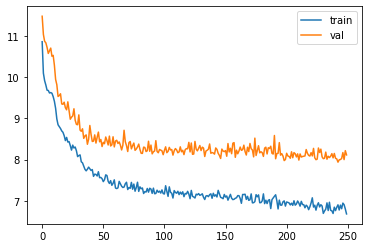

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 13)                52        
_________________________________________________________________
dense_24 (Dense)             (None, 39)                546       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 39)                0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 39)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 22)                880       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 22)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 22)               

In [ ]:
model_NN = Sequential()
model_NN.add(BatchNormalization())
model_NN.add(Dense(best_params ['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha= best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out1']))
# if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
model_NN.add(Dense(best_params ['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out2']))
if best_params ['layers'] == 3 :
    model_NN.add(Dense(best_params ['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
    model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
    model_NN.add(Dropout(best_params ['drop_out3']))
model_NN.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
# instantiate and compile model
opt = keras.optimizers.Adam(learning_rate=best_params [ 'learning_rate'])
model_NN.compile(loss=
                #  'mse',
              tf.keras.losses.Huber( delta=best_params[ 'delta']),
              # 'mse'
                  optimizer=opt)
fn = "gdrive/My Drive/Colab Notebooks/Stations/Training_SO2_Maildlake_OUT.ckpt" 
fnn = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model_NN.fit(x=X_traine, y= y_traine,
                  validation_data=(X_val, y_val),
                  batch_size=int(best_params['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
model_NN.summary()

In [ ]:
model_NN.load_weights(fn)
precovid_model = 'gdrive/My Drive/Colab Notebooks/Milkdlake_SO2_OUT.h5'
model_NN.save(precovid_model )

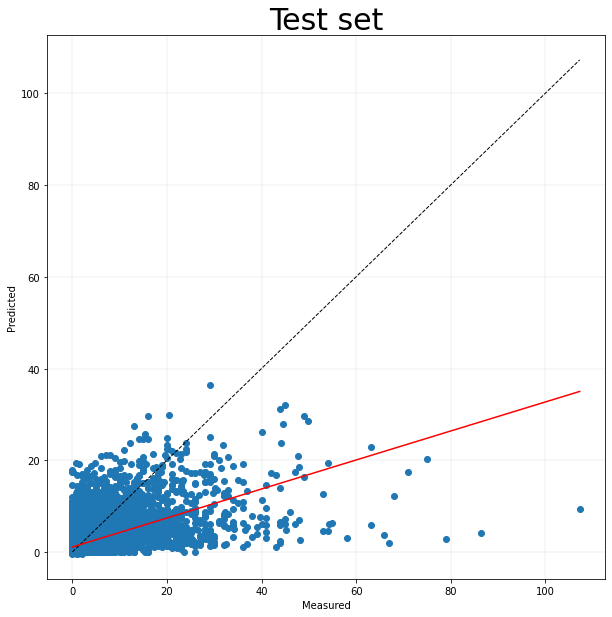

[0.3161367  1.08138476]
RMSE
[3.85796383]
R2
0.3292403742837593


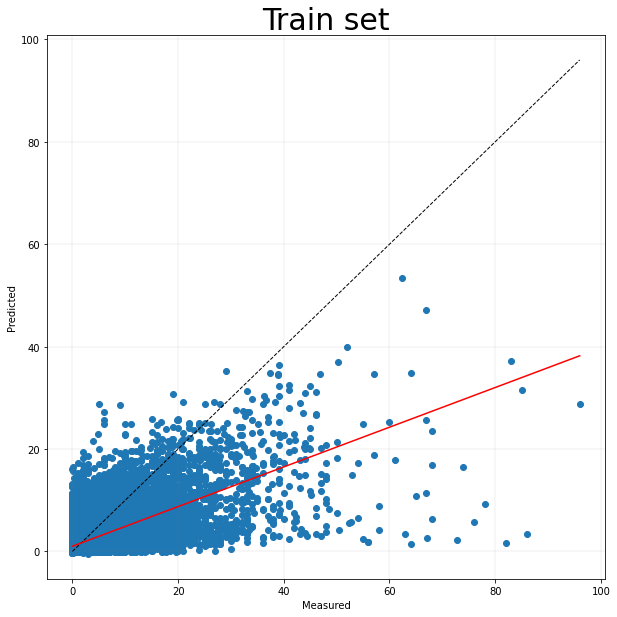

[0.38753534 1.00331146]
RMSE
[3.58459234]
R2
0.42809913053873083


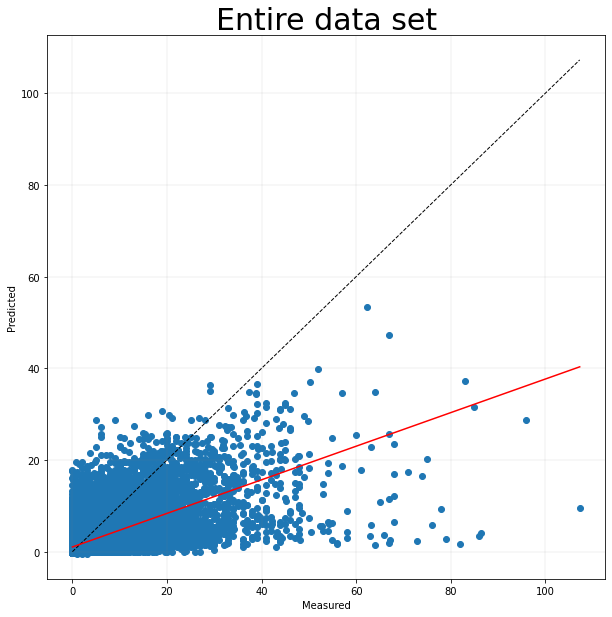

[0.36631408 1.02673476]
RMSE
[3.66874366]
R2
0.3987026774124599


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model_NN.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model_NN.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 13)                52        
_________________________________________________________________
dense_24 (Dense)             (None, 39)                546       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 39)                0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 39)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 22)                880       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 22)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 22)               

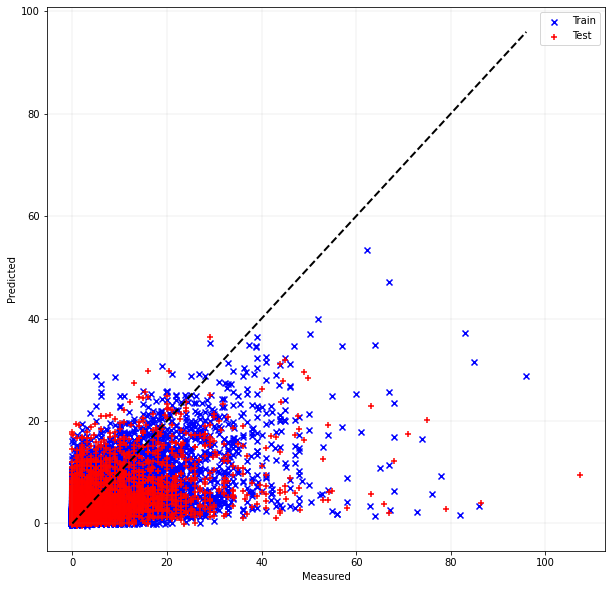

In [ ]:
model_NN = load_model(precovid_model )
model_NN.summary()
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.5], [0,0.5], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [ ]:
# df3= df3.copy()
df4 = df1_w_c.copy()
df4['pred'] = model_NN.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

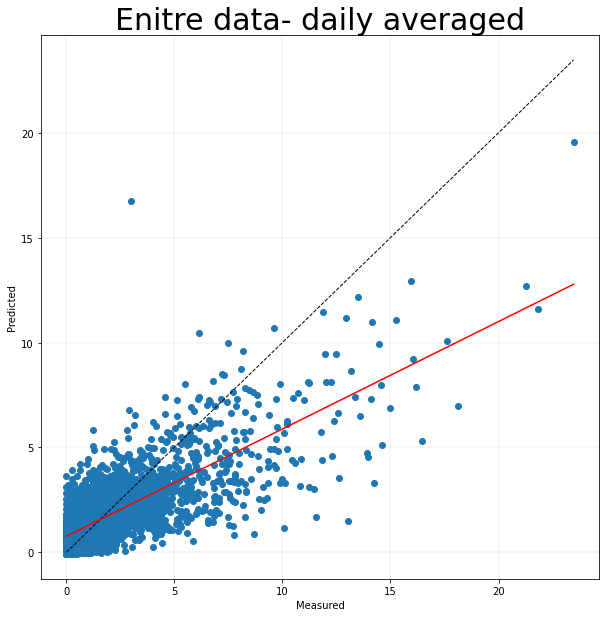

[0.51199839 0.75974635]
RMSE
[1.60179443]
R2
0.5643183771864706


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10['SO2 (ppb)']).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

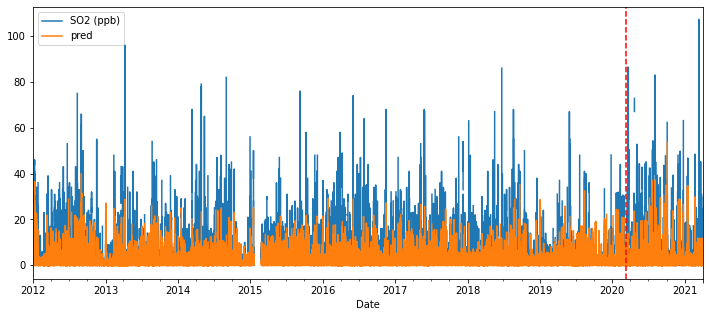

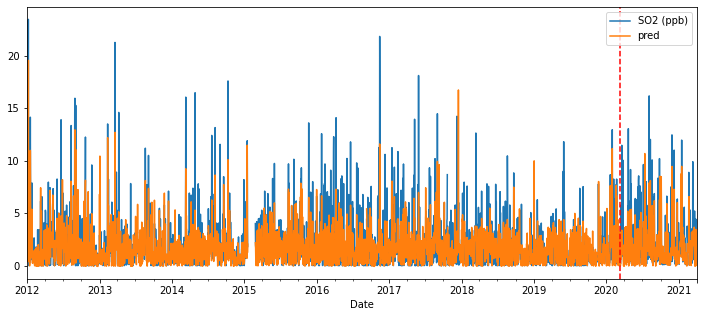

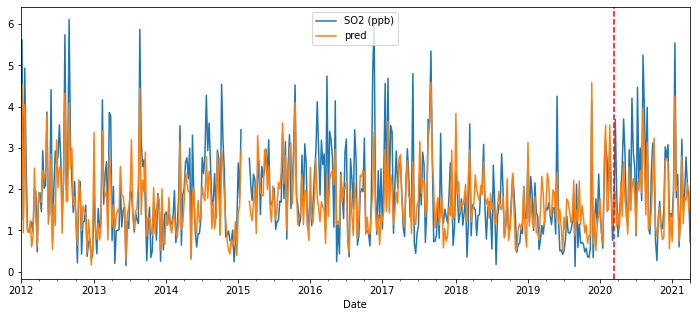

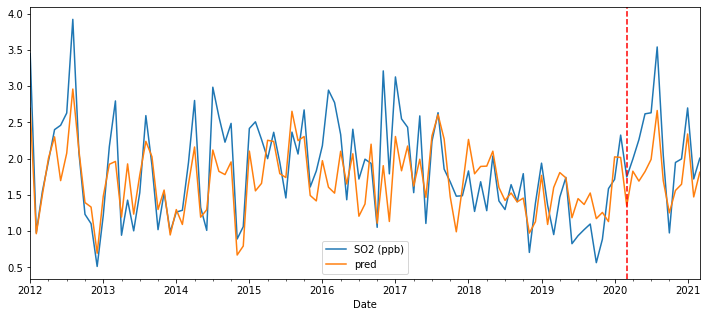

In [ ]:
df4['SO2 (ppb)'].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
preds1 = model_NN.predict(X_train) 
y_real1 = y_train.reshape(-1,1)
y_pred1 = preds1.reshape(-1,1)
print(rmse(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))

[3.58459234]
0.42809913053873083


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

[3.85796383]
0.3292403742837593


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model_NN.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model_NN.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend']
test_col = ['SO2 (ppb)']


df1_w_c = df1_w[['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ 'SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2['SO2 (ppb)'] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 ['SO2 (ppb)'] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_NN_OR_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_NN_OR_Test.csv')

[3.58459234]
0.42809913053873083
[3.85796383]
0.3292403742837593


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)

In [ ]:
# df4_D = df4_h.resample('D').mean()
# df4_M = df4_h.resample('M').mean()
# df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO2_hourly_pred.csv')
# df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO_monthly_pred.csv')

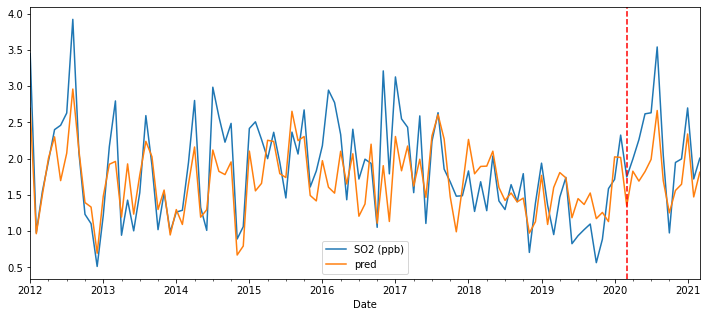

In [ ]:
df4_h['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5), legend = True)
df4_h['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df4

SO2 (ppb)  T ( C)  ...  Day-year      trend
Date                                    ...                     
2012-01-01 00:00:00       39.0    -9.6  ...       1.0  12.000000
2012-01-01 03:00:00       11.0   -10.7  ...       1.0  12.000342
2012-01-01 04:00:00        7.0   -12.1  ...       1.0  12.000455
2012-01-01 05:00:00        6.0   -12.7  ...       1.0  12.000569
2012-01-01 06:00:00        2.0   -13.5  ...       1.0  12.000683
...                        ...     ...  ...       ...        ...
2021-03-31 19:00:00        0.1     4.2  ...      90.0  21.245332
2021-03-31 20:00:00        0.4     3.0  ...      90.0  21.245446
2021-03-31 21:00:00        0.3     4.4  ...      90.0  21.245560
2021-03-31 22:00:00        0.4     4.9  ...      90.0  21.245674
2021-03-31 23:00:00        0.3     3.7  ...      90.0  21.245788

[68443 rows x 14 columns]

In [ ]:
df4_h

SO2 (ppb)  T ( C)  ...      trend       pred
Date                                    ...                      
2012-01-01 00:00:00       39.0    -9.6  ...  12.000000  25.306244
2012-01-01 03:00:00       11.0   -10.7  ...  12.000342  24.881445
2012-01-01 04:00:00        7.0   -12.1  ...  12.000455   4.806237
2012-01-01 05:00:00        6.0   -12.7  ...  12.000569   5.298855
2012-01-01 06:00:00        2.0   -13.5  ...  12.000683   1.318628
...                        ...     ...  ...        ...        ...
2021-03-31 19:00:00        0.1     4.2  ...  21.245332   1.547847
2021-03-31 20:00:00        0.4     3.0  ...  21.245446   1.303448
2021-03-31 21:00:00        0.3     4.4  ...  21.245560   2.128119
2021-03-31 22:00:00        0.4     4.9  ...  21.245674   3.039878
2021-03-31 23:00:00        0.3     3.7  ...  21.245788   0.925715

[68443 rows x 15 columns]

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model_NN.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
225
1.560396432876587
2021-01-11 09:00:00
229
1.5463595390319824
2021-01-11 10:00:00
211
1.8514320850372314
2021-01-11 12:00:00
211
2.0801665782928467
2021-01-11 13:00:00
213
1.972387433052063
2021-01-11 14:00:00
211
2.080157995223999
2021-01-11 15:00:00
217
1.9373515844345093
2021-01-11 16:00:00
220
1.8203855752944946
2021-01-11 17:00:00
231
1.5972977876663208
2021-01-11 18:00:00
236
2.1417629718780518
2021-01-11 19:00:00
234
1.9803436994552612
2021-01-11 20:00:00
233
1.8249728679656982
2021-01-11 21:00:00
231
1.8306264877319336
2021-01-11 22:00:00
230
1.9736359119415283
2021-01-11 23:00:00
231
1.924904465675354
2021-01-12 01:00:00
94
1.7081568241119385
2021-01-12 02:00:00
94
2.0247397422790527
2021-01-12 03:00:00
192
1.72219979763031
2021-01-12 04:00:00
197
1.8618531227111816
2021-01-12 06:00:00
223
1.6304482221603394
2021-01-12 07:00:00
240
1.639586329460144
2021-01-12 08:00:00
234
1.5526959896087646
2021-01-12 09:00:00
238
1.535702

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_SO2_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_SO2_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_SO2_Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

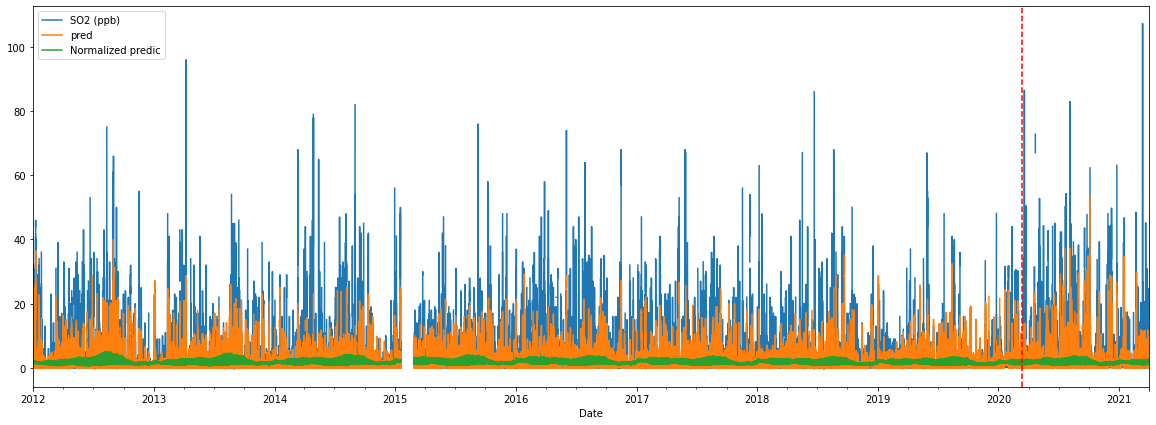

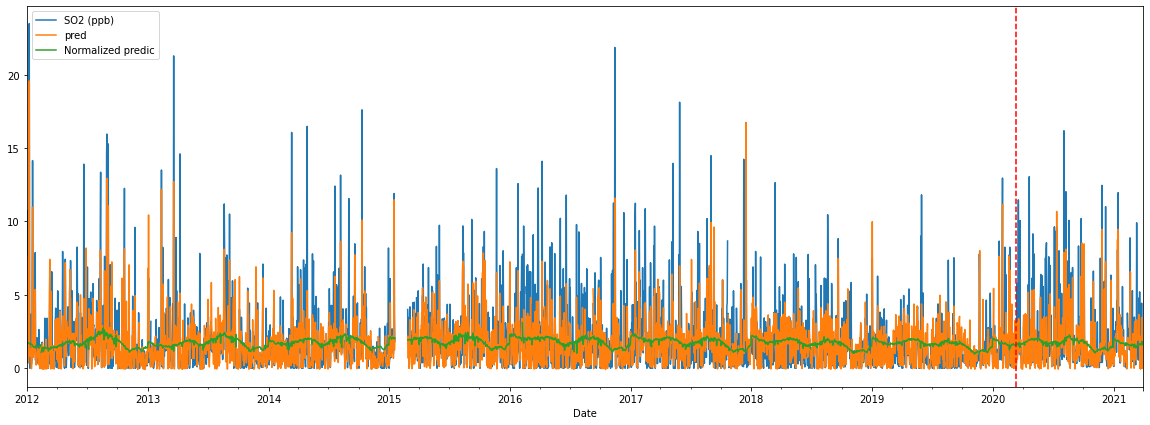

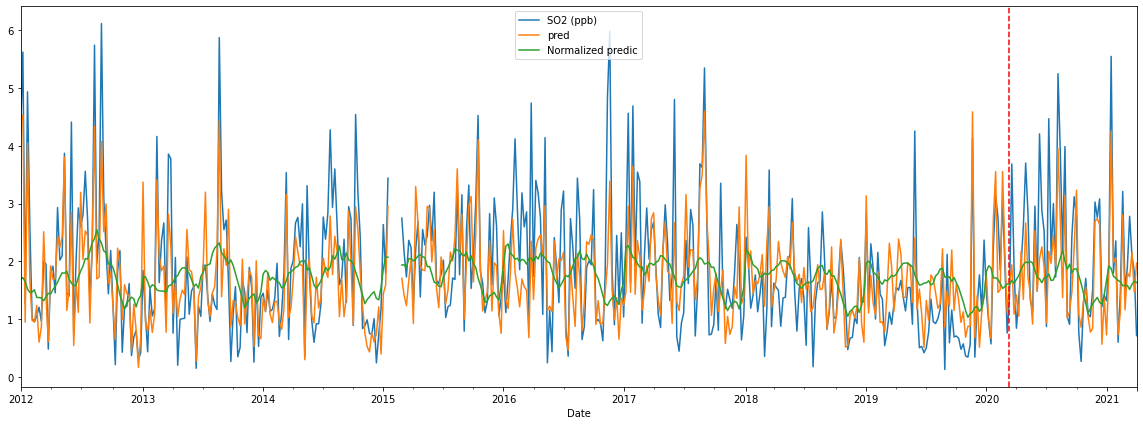

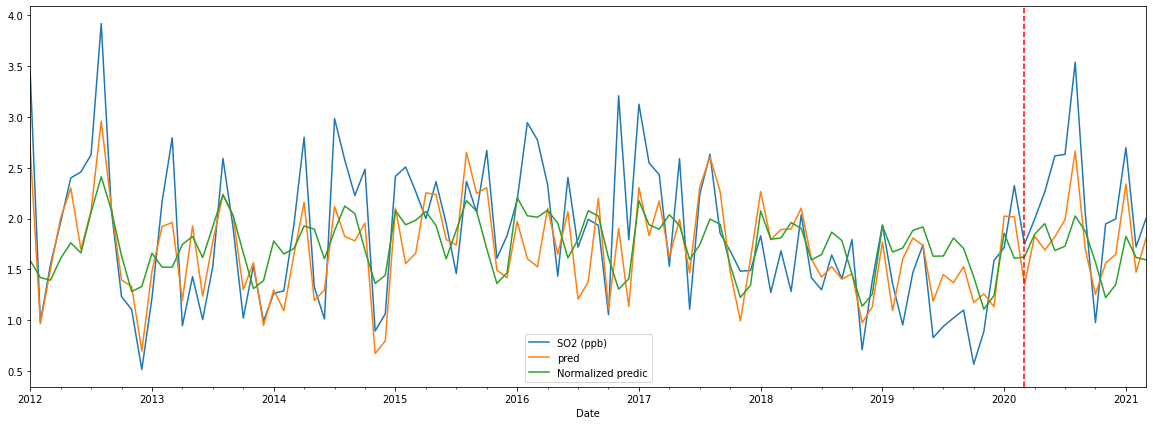

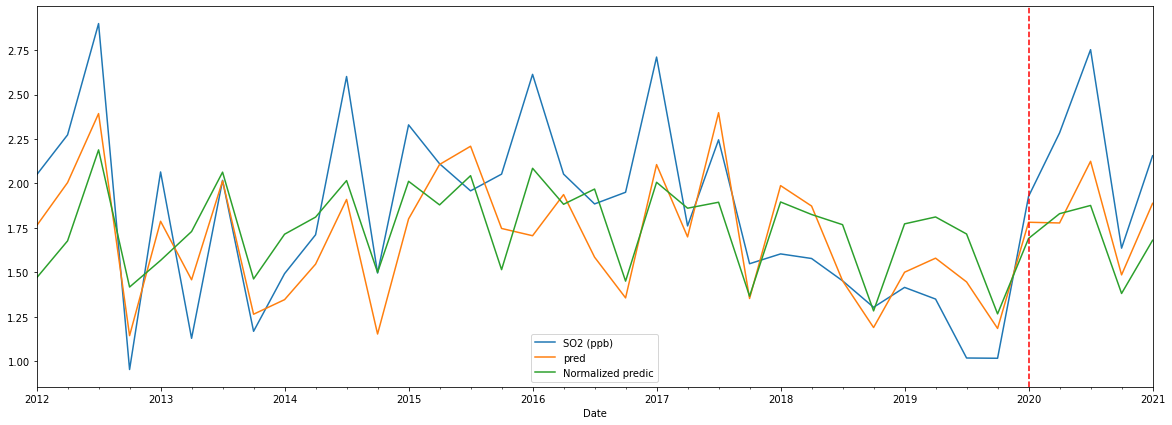

In [ ]:
for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

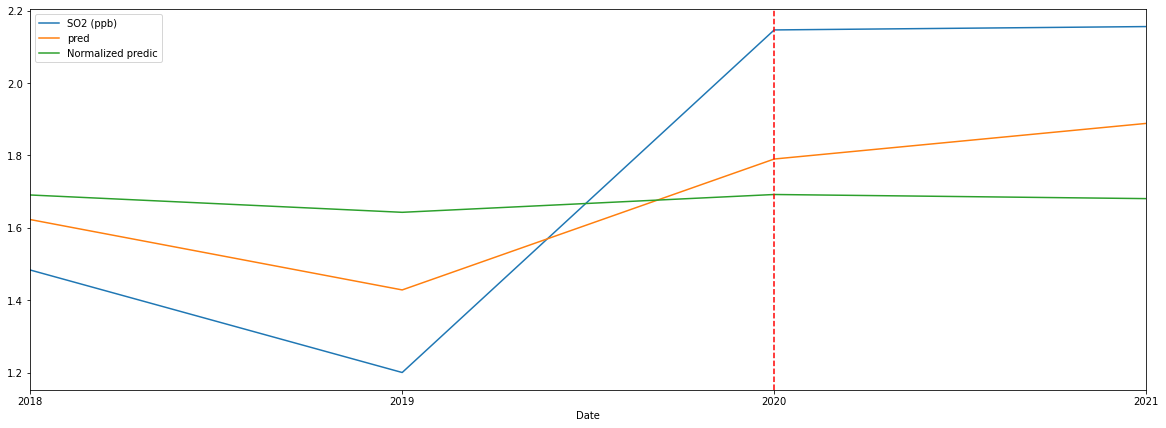

In [ ]:
df4_h['SO2 (ppb)'].resample('Y').mean().loc['2018':].plot(legend= True)
df4_h['pred'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
df4_h['Normalized predic'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
####

In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate


df2_w_c = df2_w[[ 'CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend',
       'driving', 'transit','walking',
]]
df2_w_c.columns

Index(['CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'driving', 'transit',
       'walking'],
      dtype='object')

In [ ]:
df2_w_c[['driving', 'transit', 'walking']]=df2_w_c[['driving', 'transit', 'walking']]/100

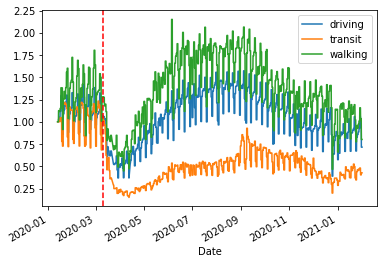

In [ ]:
df2_w_c[['driving', 'transit', 'walking']].plot()
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
a = df2_w_c[['driving', 'transit', 'walking']].loc[:'2020-03-11'].copy()
a.mean()

driving    1.124019
transit    1.025378
walking    1.331329
dtype: float64

In [ ]:
Y_a = df2_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df2_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df2_w_c[ ['driving', 'transit', 'walking']])


X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
print(np.shape(X_a),np.shape(X_b),np.shape(Y_a))

(9075, 12) (9075, 3) (9075, 1)


In [ ]:
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [ ]:
print(np.shape(X_train_a),np.shape(X_train_b))
print(np.shape(X_traine_a),np.shape(X_traine_b))
print(np.shape(X_val_a),np.shape(X_val_b))

(7260, 12) (7260, 3)
(5445, 12) (5445, 3)
(1815, 12) (1815, 3)


In [ ]:
best_params

{'batchsize': 2500.0,
 'drop_out1': 0.0057066589968766,
 'drop_out2': 0.008999530008727568,
 'drop_out3': 0.0006990849923195847,
 'layers': 3,
 'num_dense_nodes1': 35,
 'num_dense_nodes2': 24,
 'num_dense_nodes3': 28}

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense (Dense)                (None, 35)                455       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 35)                0         
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                864       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24)                0

In [ ]:
class Objective2(object):
    def __init__(self, X_a,X_b, Y, max_epochs, learn_rate_epochs,
                  ):
        self.X_train_a, self.X_test_a, self.y_train_a, self.y_test_a = train_test_split(X_a, Y, test_size=0.001, random_state=42)
        self.X_train_b, self.X_test_b, self.y_train_b, self.y_test_b = train_test_split(X_b, Y, test_size=0.001, random_state=42)

        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.model_fixed = load_model(precovid_model)
        for i in range(0,len(self.model_fixed.layers)):
            self.model_fixed.layers[i].trainable = False

    def __call__(self, trial):        
        dict_params = { 
                        'last_layer' :trial.suggest_int('last_layer',0,1),
                        'two_layer' :trial.suggest_int('two_layer',0,1),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 1,3),
                       'num_dense_nodes2': trial.suggest_int('num_dense_nodes2', 1,8),
                        # 'layers': trial.suggest_int('layers', 2,3),
                       'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,2000,100)),
                      #  'drop_out1': trial.suggest_float('drop_out1',0.0, 0.2),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                       'layer_back' :-(trial.suggest_int('layer_back', 1,2)),
                       }  
        # print(dict_params[ 'layer_back'])
        l1 = Input(shape=(3,))
        l1_2 = BatchNormalization()(l1)
        l2 = Dense(dict_params['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
        l2_2 = LeakyReLU(alpha=dict_params['alpha'])(l2)
        if dict_params['two_layer'] ==1 :
             l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_3])
        else :
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_2])
        merged2 = BatchNormalization()(merged)

        if dict_params['last_layer'] == 0:
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)

        if dict_params['last_layer'] == 1:
            l5 = Dense(dict_params['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
            l5_1 = LeakyReLU(alpha=dict_params['alpha'])(l5)
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)          
        
        model = Model(inputs=[self.model_fixed.input,l1], outputs=l5_3)

        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params['learning_rate'])
        model.compile(loss='mse',optimizer=opt)
        fn2 = "gdrive/My Drive/Colab Notebooks/Stations/East_ED_NOX_apple" +str(trial.number) + ".ckpt" 
        fnn2 = os.path.dirname(fn2)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn2, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 5
        kf = KFold(n_splits=n_f )
        acc = 0 

        for train_index, test_index in kf.split( self.X_train_a):   
                X_tr_a, X_tes_a =  self.X_train_a[train_index],  self.X_train_a[test_index]
                X_tr_b, X_tes_b =  self.X_train_b[train_index],  self.X_train_b[test_index]
                y_tr, y_tes =   self.y_train_a[train_index],   self.y_train_a[test_index]    
                # fit the model
                X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split( X_tr_a,  y_tr, test_size=0.12, random_state = 42)
                X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split( X_tr_b,  y_tr, test_size=0.12, random_state = 42)


                model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=dict_params['batchsize'],
                  epochs=self.max_epochs,
                  shuffle=True, verbose=0,
                  callbacks=callbacks_list)
                
                model.load_weights(fn2)
                preds = model.predict([X_tes_a,X_tes_b]) 
                # print(np.shape(y_tes),np.shape( preds))
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 
        print(acc)
        return acc    

In [ ]:
objective2 = Objective2(X_a, X_b ,Y_a ,maximum_epochs, learning_rate_epochs)
study2 = optuna.create_study(direction=optimizer_direction, study_name='east_edm_CO_p2',storage='sqlite:///east_edm_CO_p2.db',load_if_exists=True)
study2.optimize(objective2, n_trials=300)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/CO_Edmonton_east_Hyperparams_Stations.csv')
study2.best_trial

[I 2021-04-18 06:37:44,453] A new study created in RDB with name: east_edm_CO_p2
[I 2021-04-18 06:40:22,320] Trial 0 finished with value: 0.0047897337392556185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 3, 'batchsize': 1300.0, 'learning_rate': 0.08684742896034063, 'alpha': 0.47486431649895633, 'layer_back': 1}. Best is trial 0 with value: 0.0047897337392556185.


0.0047897337392556185


[I 2021-04-18 06:46:17,741] Trial 1 finished with value: 0.0037995427144006185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 200.0, 'learning_rate': 0.026645640165432177, 'alpha': 0.2464432589680267, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0037995427144006185


[I 2021-04-18 06:49:06,028] Trial 2 finished with value: 0.004990117939045318 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1200.0, 'learning_rate': 0.04246052710121524, 'alpha': 0.14036321226448864, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.004990117939045318


[I 2021-04-18 06:51:38,749] Trial 3 finished with value: 0.004435081840883617 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.08019349670014007, 'alpha': 0.801795208357617, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004435081840883617


[I 2021-04-18 06:55:41,325] Trial 4 finished with value: 0.004397006773851628 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 400.0, 'learning_rate': 0.0922021495386216, 'alpha': 0.8714206976745991, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004397006773851628


[I 2021-04-18 06:58:39,803] Trial 5 finished with value: 0.004472224808431502 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 1, 'batchsize': 900.0, 'learning_rate': 0.054032085513753485, 'alpha': 0.36356263089297863, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004472224808431502


[I 2021-04-18 07:02:19,968] Trial 6 finished with value: 0.004032658481373844 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 500.0, 'learning_rate': 0.0034103388646587085, 'alpha': 0.8298599523597091, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004032658481373844


[I 2021-04-18 07:04:57,913] Trial 7 finished with value: 0.004412881161440907 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1400.0, 'learning_rate': 0.024560851403922612, 'alpha': 0.8657303593335849, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004412881161440907


[I 2021-04-18 07:07:33,362] Trial 8 finished with value: 0.003962766007027832 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1600.0, 'learning_rate': 0.0387484515918348, 'alpha': 0.5935061142207385, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.003962766007027832


[I 2021-04-18 07:10:45,080] Trial 9 finished with value: 0.004464174746733434 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 700.0, 'learning_rate': 0.07156430296741274, 'alpha': 0.6837562117270939, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004464174746733434


[I 2021-04-18 07:20:10,927] Trial 10 finished with value: 0.0047593223285363065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.006393597974084786, 'alpha': 0.09784392044369339, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.0047593223285363065


[I 2021-04-18 07:22:40,517] Trial 11 finished with value: 0.0038559859859853907 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 4, 'batchsize': 1900.0, 'learning_rate': 0.029641261114048665, 'alpha': 0.3455488342982123, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0038559859859853907


[I 2021-04-18 07:25:12,650] Trial 12 finished with value: 0.0037802072596256108 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 2000.0, 'learning_rate': 0.021318248161901757, 'alpha': 0.27421676161966496, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.0037802072596256108


[I 2021-04-18 07:34:39,100] Trial 13 finished with value: 0.003838305552608133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.01618259930894679, 'alpha': 0.2237909588852787, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.003838305552608133


[I 2021-04-18 07:37:13,171] Trial 14 finished with value: 0.0037727934709037452 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 1600.0, 'learning_rate': 0.05463156741271952, 'alpha': 0.023432883667647286, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.0037727934709037452


[I 2021-04-18 07:39:46,194] Trial 15 finished with value: 0.004717376020706112 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.057774493852787316, 'alpha': 0.013468966566860257, 'layer_back': 1}. Best is trial 14 with value: 0.0037727934709037452.


0.004717376020706112


[I 2021-04-18 07:42:17,141] Trial 16 finished with value: 0.003891606393255513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 4, 'batchsize': 1600.0, 'learning_rate': 0.06483099406582218, 'alpha': 0.048701457819810334, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.003891606393255513


[I 2021-04-18 07:44:50,068] Trial 17 finished with value: 0.003705317767648349 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.042981081545902175, 'alpha': 0.17151924705879706, 'layer_back': 2}. Best is trial 17 with value: 0.003705317767648349.


0.003705317767648349


[I 2021-04-18 07:47:22,992] Trial 18 finished with value: 0.003652074267837431 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043120594200074316, 'alpha': 0.15356515832757994, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003652074267837431


[I 2021-04-18 07:49:56,748] Trial 19 finished with value: 0.004855364207538971 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.03948108446690251, 'alpha': 0.1731767923827432, 'layer_back': 1}. Best is trial 18 with value: 0.003652074267837431.


0.004855364207538971


[I 2021-04-18 07:52:46,818] Trial 20 finished with value: 0.0036661417054684184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.045596783441498825, 'alpha': 0.46487314129271234, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0036661417054684184


[I 2021-04-18 07:55:47,695] Trial 21 finished with value: 0.003772814522212643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.04376219782019011, 'alpha': 0.495381372771252, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003772814522212643


[I 2021-04-18 07:58:33,572] Trial 22 finished with value: 0.0037000579251144777 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03235269324681574, 'alpha': 0.40139723428257024, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037000579251144777


[I 2021-04-18 08:01:16,242] Trial 23 finished with value: 0.0037201394146138406 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.0335829823820747, 'alpha': 0.561915944028579, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037201394146138406


[I 2021-04-18 08:04:15,280] Trial 24 finished with value: 0.0037030372913319023 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.01268992251227287, 'alpha': 0.3938061003278891, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037030372913319023


[I 2021-04-18 08:07:38,080] Trial 25 finished with value: 0.003918046517575021 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.04897050026188292, 'alpha': 0.6753399284001078, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003918046517575021


[I 2021-04-18 08:10:15,782] Trial 26 finished with value: 0.0038008433695184197 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.06522149016140043, 'alpha': 0.42163733919230845, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0038008433695184197


[I 2021-04-18 08:13:05,072] Trial 27 finished with value: 0.0036111388857046787 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.03298839085103375, 'alpha': 0.3150552800923347, 'layer_back': 2}. Best is trial 27 with value: 0.0036111388857046787.


0.0036111388857046787


[I 2021-04-18 08:16:08,056] Trial 28 finished with value: 0.003597443791057043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.04885615301916258, 'alpha': 0.29269304131799223, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.003597443791057043


[I 2021-04-18 08:19:12,662] Trial 29 finished with value: 0.0046809329310916956 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.05995146156015323, 'alpha': 0.30446311601011683, 'layer_back': 1}. Best is trial 28 with value: 0.003597443791057043.


0.0046809329310916956


[I 2021-04-18 08:21:45,673] Trial 30 finished with value: 0.004425357656736 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.0759352310855712, 'alpha': 0.21269011576180244, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.004425357656736


[I 2021-04-18 08:24:37,569] Trial 31 finished with value: 0.0036547160400316313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.049811468875869416, 'alpha': 0.510738346787994, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0036547160400316313


[I 2021-04-18 08:27:52,823] Trial 32 finished with value: 0.0037521087301732345 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.049503947678833926, 'alpha': 0.31735277463906175, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037521087301732345


[I 2021-04-18 08:30:36,307] Trial 33 finished with value: 0.0037683419447327986 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.03290226547777786, 'alpha': 0.5286190169685012, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037683419447327986


[I 2021-04-18 08:33:27,324] Trial 34 finished with value: 0.003597358919918322 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.036818841872599595, 'alpha': 0.12570513379804832, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003597358919918322


[I 2021-04-18 08:37:26,272] Trial 35 finished with value: 0.003661138596451478 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 400.0, 'learning_rate': 0.03671876888449163, 'alpha': 0.08397801305678194, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003661138596451478


[I 2021-04-18 08:40:27,101] Trial 36 finished with value: 0.00359203525150731 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.02437141103670945, 'alpha': 0.12749087727003588, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00359203525150731


[I 2021-04-18 08:43:26,782] Trial 37 finished with value: 0.0036756314419160397 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.018931547569790746, 'alpha': 0.2516407308762111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036756314419160397


[I 2021-04-18 08:48:02,902] Trial 38 finished with value: 0.0036545643870157882 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 300.0, 'learning_rate': 0.02603462599572944, 'alpha': 0.14443719906111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036545643870157882


[I 2021-04-18 08:51:18,641] Trial 39 finished with value: 0.004398658143913983 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.02412418866542985, 'alpha': 0.09261962247455818, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.004398658143913983


[I 2021-04-18 08:54:03,235] Trial 40 finished with value: 0.00366032853048446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 1200.0, 'learning_rate': 0.028075997597257207, 'alpha': 0.20259126107498393, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00366032853048446


[I 2021-04-18 08:57:05,594] Trial 41 finished with value: 0.003674477629447893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.03773808729024592, 'alpha': 0.13311556018712936, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.003674477629447893


[I 2021-04-18 08:59:59,665] Trial 42 finished with value: 0.0036705861586692643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.014115297813961467, 'alpha': 0.28611068588955, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036705861586692643


[I 2021-04-18 09:03:13,164] Trial 43 finished with value: 0.0036713389468197555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.04560695580139573, 'alpha': 0.3437569312771207, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036713389468197555


[I 2021-04-18 09:06:35,814] Trial 44 finished with value: 0.0035783836209078556 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.009070889461271204, 'alpha': 0.13887248911600195, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035783836209078556


[I 2021-04-18 09:09:57,729] Trial 45 finished with value: 0.003673148714195081 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 600.0, 'learning_rate': 0.009253166791610645, 'alpha': 0.2451607156425593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003673148714195081


[I 2021-04-18 09:14:01,355] Trial 46 finished with value: 0.004344271113195811 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 400.0, 'learning_rate': 0.001551960808838477, 'alpha': 0.10569886410992255, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004344271113195811


[I 2021-04-18 09:17:39,621] Trial 47 finished with value: 0.0037050254039840223 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.021082510170567333, 'alpha': 0.0668001215058446, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037050254039840223


[I 2021-04-18 09:20:38,142] Trial 48 finished with value: 0.0036692619534721047 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.007585468046031375, 'alpha': 0.2061475495973082, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036692619534721047


[I 2021-04-18 09:23:49,174] Trial 49 finished with value: 0.004457879746783033 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.03483835282389286, 'alpha': 0.018344801879960376, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004457879746783033


[I 2021-04-18 09:26:34,895] Trial 50 finished with value: 0.0035807581552902102 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03005652498704963, 'alpha': 0.11696356203274105, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035807581552902102


[I 2021-04-18 09:29:21,811] Trial 51 finished with value: 0.0036236342891670654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.09983893132352316, 'alpha': 0.11957067974916365, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036236342891670654


[I 2021-04-18 09:32:02,631] Trial 52 finished with value: 0.0036302435793163423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.02754867420830222, 'alpha': 0.05647608660638647, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036302435793163423


[I 2021-04-18 09:34:44,744] Trial 53 finished with value: 0.003627053068071688 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04005811816852655, 'alpha': 0.17080808493297003, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003627053068071688


[I 2021-04-18 09:37:45,884] Trial 54 finished with value: 0.0036920503523068266 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.017979831294330218, 'alpha': 0.2570823577331828, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036920503523068266


[I 2021-04-18 09:40:36,692] Trial 55 finished with value: 0.003612690295076574 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1000.0, 'learning_rate': 0.029552755284063505, 'alpha': 0.18039366495456732, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003612690295076574


[I 2021-04-18 09:43:40,566] Trial 56 finished with value: 0.004012695527376038 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 800.0, 'learning_rate': 0.022565925713046567, 'alpha': 0.03734236499524329, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004012695527376038


[I 2021-04-18 09:47:16,794] Trial 57 finished with value: 0.003698018600704401 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 500.0, 'learning_rate': 0.05338960509962787, 'alpha': 0.35126328332328843, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003698018600704401


[I 2021-04-18 09:50:04,725] Trial 58 finished with value: 0.003619003598112455 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.011669376031158469, 'alpha': 0.2338658479883975, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003619003598112455


[I 2021-04-18 09:53:02,416] Trial 59 finished with value: 0.0036054917675212707 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.031117560438016202, 'alpha': 0.12690434404626497, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036054917675212707


[I 2021-04-18 09:56:06,738] Trial 60 finished with value: 0.003886966241395085 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.003565187588275332, 'alpha': 0.12617304287730674, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003886966241395085


[I 2021-04-18 09:59:11,214] Trial 61 finished with value: 0.003618826532739045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.03119470670070372, 'alpha': 0.06717581966642143, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003618826532739045


[I 2021-04-18 10:02:02,407] Trial 62 finished with value: 0.0037632189106060355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1000.0, 'learning_rate': 0.04059941279624269, 'alpha': 0.16862336495408595, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037632189106060355


[I 2021-04-18 10:05:19,179] Trial 63 finished with value: 0.003794832132947586 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 700.0, 'learning_rate': 0.036734160746832493, 'alpha': 0.01101319432018788, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003794832132947586


[I 2021-04-18 10:08:20,419] Trial 64 finished with value: 0.003758988776972788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.029855268948976825, 'alpha': 0.4386976096021802, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003758988776972788


[I 2021-04-18 10:11:42,186] Trial 65 finished with value: 0.0035876522982958357 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.024552341120126213, 'alpha': 0.20134794489311997, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035876522982958357


[I 2021-04-18 10:15:04,777] Trial 66 finished with value: 0.0036155628523736184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.016447401975405944, 'alpha': 0.14664495950811754, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036155628523736184


[I 2021-04-18 10:18:40,103] Trial 67 finished with value: 0.0037361543406670638 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.02482879535124779, 'alpha': 0.18911509071408622, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037361543406670638


[I 2021-04-18 10:23:14,465] Trial 68 finished with value: 0.004737399253546576 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 300.0, 'learning_rate': 0.045839207163365064, 'alpha': 0.11572139542681772, 'layer_back': 1}. Best is trial 44 with value: 0.0035783836209078556.


0.004737399253546576


[I 2021-04-18 10:26:17,521] Trial 69 finished with value: 0.0035844609162026856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.021759460493932996, 'alpha': 0.08938362393003896, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035844609162026856


[I 2021-04-18 10:29:40,721] Trial 70 finished with value: 0.003647474821726536 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.020584896822209618, 'alpha': 0.08688700495047245, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003647474821726536


[I 2021-04-18 10:32:40,862] Trial 71 finished with value: 0.0036240235360119194 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.026636013810065286, 'alpha': 0.04460753701062606, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036240235360119194


[I 2021-04-18 10:35:57,924] Trial 72 finished with value: 0.003678997217185063 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 700.0, 'learning_rate': 0.02380154186526011, 'alpha': 0.15140441320203327, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003678997217185063


[I 2021-04-18 10:39:01,596] Trial 73 finished with value: 0.003659856745198834 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.015277005770461548, 'alpha': 0.2178303763286192, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003659856745198834


[I 2021-04-18 10:42:16,571] Trial 74 finished with value: 0.0036399907750272265 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.011408912622706538, 'alpha': 0.10321869296892679, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036399907750272265


[I 2021-04-18 10:45:19,285] Trial 75 finished with value: 0.0037281104148537535 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.035323452421033984, 'alpha': 0.2846749869393032, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037281104148537535


[I 2021-04-18 10:48:06,701] Trial 76 finished with value: 0.00361764726075232 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.018785055346852722, 'alpha': 0.08247223174383175, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.00361764726075232


[I 2021-04-18 10:51:06,829] Trial 77 finished with value: 0.0036951690746862827 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.030036815811613576, 'alpha': 0.15370233117847767, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036951690746862827


[I 2021-04-18 10:53:48,194] Trial 78 finished with value: 0.003591197553125669 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.021596734858180668, 'alpha': 0.19705749126102656, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003591197553125669


[I 2021-04-18 10:56:31,899] Trial 79 finished with value: 0.0036875580454355968 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.004996727049177942, 'alpha': 0.19630957319700593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036875580454355968


[I 2021-04-18 10:59:15,173] Trial 80 finished with value: 0.003672630637413495 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.009725768873874269, 'alpha': 0.23904793658858925, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003672630637413495


[I 2021-04-18 11:02:33,338] Trial 81 finished with value: 0.003608277041588192 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.021177055101469718, 'alpha': 0.13273475258504627, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003608277041588192


[I 2021-04-18 11:05:23,493] Trial 82 finished with value: 0.0035357134156083006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03251063586877488, 'alpha': 0.16601335847048496, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035357134156083006


[I 2021-04-18 11:08:10,650] Trial 83 finished with value: 0.0035800395220561315 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027507014638668944, 'alpha': 0.26952999743969175, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035800395220561315


[I 2021-04-18 11:10:53,530] Trial 84 finished with value: 0.003641285084880817 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.024468913257262442, 'alpha': 0.26941083528596615, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003641285084880817


[I 2021-04-18 11:13:33,120] Trial 85 finished with value: 0.003613639352689042 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.027506935493900007, 'alpha': 0.16554636650660334, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003613639352689042


[I 2021-04-18 11:16:13,848] Trial 86 finished with value: 0.0035454609704569555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034075180962035656, 'alpha': 0.19205737194876213, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035454609704569555


[I 2021-04-18 11:18:54,396] Trial 87 finished with value: 0.0036217548071173097 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.018105506543334197, 'alpha': 0.2172761829124636, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036217548071173097


[I 2021-04-18 11:21:32,202] Trial 88 finished with value: 0.0036196131119005967 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.013644839043071016, 'alpha': 0.18554443324755185, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036196131119005967


[I 2021-04-18 11:24:10,911] Trial 89 finished with value: 0.003572944589854708 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02174303974596932, 'alpha': 0.06885902281378707, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003572944589854708


[I 2021-04-18 11:26:50,606] Trial 90 finished with value: 0.003906346283951516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1500.0, 'learning_rate': 0.03323653174387488, 'alpha': 0.03163285232628042, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003906346283951516


[I 2021-04-18 11:29:31,353] Trial 91 finished with value: 0.003578888868218704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.022580602914511808, 'alpha': 0.06713185538847133, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003578888868218704


[I 2021-04-18 11:32:08,581] Trial 92 finished with value: 0.0035789263141083713 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.021256605621501615, 'alpha': 0.06634621015162126, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035789263141083713


[I 2021-04-18 11:34:49,916] Trial 93 finished with value: 0.003544189206426239 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02748340529865124, 'alpha': 0.07868991239964429, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003544189206426239


[I 2021-04-18 11:37:33,179] Trial 94 finished with value: 0.0035499476797488643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02892486834145689, 'alpha': 0.07221984870581319, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035499476797488643


[I 2021-04-18 11:40:14,572] Trial 95 finished with value: 0.0035273632980514285 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.027834554447690413, 'alpha': 0.06732285000688103, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035273632980514285


[I 2021-04-18 11:42:52,853] Trial 96 finished with value: 0.0036086771352365947 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02637530840203316, 'alpha': 0.05953489610216768, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036086771352365947


[I 2021-04-18 11:45:38,794] Trial 97 finished with value: 0.0035684357428775186 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027517728652115728, 'alpha': 0.07593898838347986, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035684357428775186


[I 2021-04-18 11:48:20,507] Trial 98 finished with value: 0.003583852513729412 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03367874759681739, 'alpha': 0.06942447131849512, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003583852513729412


[I 2021-04-18 11:50:57,066] Trial 99 finished with value: 0.003541288425685317 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.041358766423868744, 'alpha': 0.021920382234198947, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003541288425685317


[I 2021-04-18 11:53:42,845] Trial 100 finished with value: 0.0036243488752047467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04030568364072326, 'alpha': 0.02384229949250582, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036243488752047467


[I 2021-04-18 11:56:21,539] Trial 101 finished with value: 0.003627937411450544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.035398043970041676, 'alpha': 0.03950052041260174, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627937411450544


[I 2021-04-18 11:59:00,418] Trial 102 finished with value: 0.003627126043875543 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03832592467033967, 'alpha': 0.10048283220351684, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627126043875543


[I 2021-04-18 12:01:36,789] Trial 103 finished with value: 0.0035408315369076784 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032256016881253326, 'alpha': 0.07030089565296588, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035408315369076784


[I 2021-04-18 12:04:17,971] Trial 104 finished with value: 0.003566082616285739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04262395762710679, 'alpha': 0.01173160141920479, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003566082616285739


[I 2021-04-18 12:06:58,238] Trial 105 finished with value: 0.0035737931205732376 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04227819138674002, 'alpha': 0.010660044984515019, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035737931205732376


[I 2021-04-18 12:09:32,119] Trial 106 finished with value: 0.0035184089995725617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043629287038235834, 'alpha': 0.010426390915745402, 'layer_back': 2}. Best is trial 106 with value: 0.0035184089995725617.


0.0035184089995725617


[I 2021-04-18 12:12:07,413] Trial 107 finished with value: 0.0034912184906821125 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04304162747051637, 'alpha': 0.044280753511746956, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0034912184906821125


[I 2021-04-18 12:14:44,123] Trial 108 finished with value: 0.0036380100736029142 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046899784330746694, 'alpha': 0.011423731168029368, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036380100736029142


[I 2021-04-18 12:17:20,619] Trial 109 finished with value: 0.0035930917231830005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05312662202242775, 'alpha': 0.04766526633420203, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035930917231830005


[I 2021-04-18 12:19:56,882] Trial 110 finished with value: 0.0035019395412586403 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04297554301809757, 'alpha': 0.03108575464071467, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035019395412586403


[I 2021-04-18 12:22:26,683] Trial 111 finished with value: 0.0035799057324392095 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.042791521010711986, 'alpha': 0.033242351358857565, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035799057324392095


[I 2021-04-18 12:25:01,093] Trial 112 finished with value: 0.003567586631908924 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04188075691123601, 'alpha': 0.012902457195305648, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567586631908924


[I 2021-04-18 12:27:37,137] Trial 113 finished with value: 0.003552786707766206 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04705313553365665, 'alpha': 0.024024393886675065, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003552786707766206


[I 2021-04-18 12:30:14,683] Trial 114 finished with value: 0.0035491374611036066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04792414670441766, 'alpha': 0.04942912887788908, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035491374611036066


[I 2021-04-18 12:32:47,942] Trial 115 finished with value: 0.003934744163417141 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.05138779832449931, 'alpha': 0.7678284116404237, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003934744163417141


[I 2021-04-18 12:35:21,813] Trial 116 finished with value: 0.0035480745063304685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04672929967596791, 'alpha': 0.0543681486748597, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035480745063304685


[I 2021-04-18 12:37:57,950] Trial 117 finished with value: 0.003645209428448006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.058597540974892046, 'alpha': 0.054075814336391005, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003645209428448006


[I 2021-04-18 12:40:31,646] Trial 118 finished with value: 0.003635834268763575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04497558570260886, 'alpha': 0.10395749038880057, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003635834268763575


[I 2021-04-18 12:43:09,338] Trial 119 finished with value: 0.0036447334704852665 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1800.0, 'learning_rate': 0.04781462434994531, 'alpha': 0.04268750205527756, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036447334704852665


[I 2021-04-18 12:45:44,270] Trial 120 finished with value: 0.003567690380984065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.037831602089136926, 'alpha': 0.0894939850401166, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567690380984065


[I 2021-04-18 12:48:19,955] Trial 121 finished with value: 0.0036418865284299482 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.049910163797960434, 'alpha': 0.02265761100617698, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036418865284299482


[I 2021-04-18 12:50:50,152] Trial 122 finished with value: 0.003626350371093418 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04409374352769631, 'alpha': 0.04839758470877351, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003626350371093418


[I 2021-04-18 12:53:25,935] Trial 123 finished with value: 0.004068899031879057 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 1900.0, 'learning_rate': 0.04692551724599392, 'alpha': 0.027164865650236767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004068899031879057


[I 2021-04-18 12:56:09,582] Trial 124 finished with value: 0.003549524306460534 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.05601252997839943, 'alpha': 0.08216270418670965, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003549524306460534


[I 2021-04-18 12:58:52,986] Trial 125 finished with value: 0.0036022166677025626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.051026693295636215, 'alpha': 0.08169432284004574, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036022166677025626


[I 2021-04-18 13:01:25,923] Trial 126 finished with value: 0.0036323884269265395 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05755736475611723, 'alpha': 0.10764012747900042, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036323884269265395


[I 2021-04-18 13:04:06,681] Trial 127 finished with value: 0.0035868803510106743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.06484074739859898, 'alpha': 0.04916233098402338, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035868803510106743


[I 2021-04-18 13:06:48,784] Trial 128 finished with value: 0.003632038891645508 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.05481967090549042, 'alpha': 0.09493718561374137, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632038891645508


[I 2021-04-18 13:09:24,704] Trial 129 finished with value: 0.0036332687347207073 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.06164699827462552, 'alpha': 0.11368639196612304, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036332687347207073


[I 2021-04-18 13:12:02,225] Trial 130 finished with value: 0.0036107090038871685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.031913432524153476, 'alpha': 0.07944764608488178, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036107090038871685


[I 2021-04-18 13:14:37,997] Trial 131 finished with value: 0.003543857849946714 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04047866711207972, 'alpha': 0.03334890991576665, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003543857849946714


[I 2021-04-18 13:17:10,956] Trial 132 finished with value: 0.003614544482168527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03927975006627224, 'alpha': 0.05750478466882326, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003614544482168527


[I 2021-04-18 13:19:52,496] Trial 133 finished with value: 0.0036289459230039846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03602600147397279, 'alpha': 0.03879102885756539, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036289459230039846


[I 2021-04-18 13:22:21,926] Trial 134 finished with value: 0.004397730627210862 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04121745337090514, 'alpha': 0.07727507999023213, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004397730627210862


[I 2021-04-18 13:25:09,682] Trial 135 finished with value: 0.0035954891884910044 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.05591938878661566, 'alpha': 0.011489115255243473, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035954891884910044


[I 2021-04-18 13:27:46,099] Trial 136 finished with value: 0.003632190940638184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04473961188420494, 'alpha': 0.05883472932516892, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632190940638184


[I 2021-04-18 13:30:22,676] Trial 137 finished with value: 0.004797824764292689 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03394020855741806, 'alpha': 0.6177230050734727, 'layer_back': 1}. Best is trial 107 with value: 0.0034912184906821125.


0.004797824764292689


[I 2021-04-18 13:32:54,827] Trial 138 finished with value: 0.0035575625191086686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03925631108791122, 'alpha': 0.02976577533102045, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035575625191086686


[I 2021-04-18 13:35:35,526] Trial 139 finished with value: 0.0037383972180743746 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.02925391477758371, 'alpha': 0.13393207397187767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037383972180743746


[I 2021-04-18 13:38:16,882] Trial 140 finished with value: 0.003617621733455551 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03195637257591547, 'alpha': 0.0947751465706642, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003617621733455551


[I 2021-04-18 13:40:50,663] Trial 141 finished with value: 0.003579242154278799 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0485447382823182, 'alpha': 0.01176858180870248, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003579242154278799


[I 2021-04-18 13:43:25,476] Trial 142 finished with value: 0.0035750086655864273 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.046567743860348884, 'alpha': 0.026818371099279946, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035750086655864273


[I 2021-04-18 13:46:00,498] Trial 143 finished with value: 0.003623829402881311 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03742158374219033, 'alpha': 0.04975293319513799, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003623829402881311


[I 2021-04-18 13:48:38,218] Trial 144 finished with value: 0.0036066806414085484 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05148602571649974, 'alpha': 0.010300864640383572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036066806414085484


[I 2021-04-18 13:51:09,839] Trial 145 finished with value: 0.003610979298586066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.043772802510158214, 'alpha': 0.07001141819525372, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003610979298586066


[I 2021-04-18 13:53:44,355] Trial 146 finished with value: 0.0035619962671982527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04082403791540483, 'alpha': 0.035248606443724864, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035619962671982527


[I 2021-04-18 13:56:26,877] Trial 147 finished with value: 0.003548864702878114 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04862893209367515, 'alpha': 0.11504554485639235, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003548864702878114


[I 2021-04-18 13:59:07,487] Trial 148 finished with value: 0.0036127803252306075 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034866037784612974, 'alpha': 0.15803031484071783, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036127803252306075


[I 2021-04-18 14:01:52,630] Trial 149 finished with value: 0.0035717142472204513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04905384303207223, 'alpha': 0.11415311920269179, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035717142472204513


[I 2021-04-18 14:04:32,812] Trial 150 finished with value: 0.0035749882689068164 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04526973875676865, 'alpha': 0.14572957071712894, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035749882689068164


[I 2021-04-18 14:07:16,399] Trial 151 finished with value: 0.0035993304069324022 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.052491361045237814, 'alpha': 0.08397349335013253, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035993304069324022


[I 2021-04-18 14:09:58,621] Trial 152 finished with value: 0.0035685056911281127 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04837346606791395, 'alpha': 0.06310254703879091, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035685056911281127


[I 2021-04-18 14:12:29,525] Trial 153 finished with value: 0.003629879513305761 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0438214208862195, 'alpha': 0.10403865238259322, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003629879513305761


[I 2021-04-18 14:15:14,227] Trial 154 finished with value: 0.0036221795403482207 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03029487512047642, 'alpha': 0.04348614544060133, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036221795403482207


[I 2021-04-18 14:17:57,080] Trial 155 finished with value: 0.0035922583407074988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.03843837268200991, 'alpha': 0.08433177217864488, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035922583407074988


[I 2021-04-18 14:20:36,152] Trial 156 finished with value: 0.003578072413719791 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.046367859672450995, 'alpha': 0.12254720867272155, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003578072413719791


[I 2021-04-18 14:23:15,649] Trial 157 finished with value: 0.0038583845758324883 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0871450624590979, 'alpha': 0.056755344230540905, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0038583845758324883


[I 2021-04-18 14:25:52,255] Trial 158 finished with value: 0.003580582397543033 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.041182684797758676, 'alpha': 0.031335914276621774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003580582397543033


[I 2021-04-18 14:28:31,244] Trial 159 finished with value: 0.003571554999049949 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.050511120203456654, 'alpha': 0.011355553310716315, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003571554999049949


[I 2021-04-18 14:31:10,768] Trial 160 finished with value: 0.0035740442082979025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1300.0, 'learning_rate': 0.054629022232272034, 'alpha': 0.09769506994297086, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035740442082979025


[I 2021-04-18 14:33:46,785] Trial 161 finished with value: 0.0035316717327896836 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03947842688021926, 'alpha': 0.02587334876105694, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035316717327896836


[I 2021-04-18 14:36:22,973] Trial 162 finished with value: 0.003583261784611461 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0426931007941171, 'alpha': 0.06941424492182441, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003583261784611461


[I 2021-04-18 14:38:56,920] Trial 163 finished with value: 0.0035638605296477717 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03698103592588202, 'alpha': 0.02604575458608599, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035638605296477717


[I 2021-04-18 14:41:34,556] Trial 164 finished with value: 0.0036057247992290833 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.033843190233136235, 'alpha': 0.054628128789041205, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036057247992290833


[I 2021-04-18 14:44:05,291] Trial 165 finished with value: 0.0036577139832949667 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.02862847367159879, 'alpha': 0.041190982009615476, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036577139832949667


[I 2021-04-18 14:46:34,411] Trial 166 finished with value: 0.0035796291367728578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.03989602686737119, 'alpha': 0.07720076451956273, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035796291367728578


[I 2021-04-18 14:48:58,970] Trial 167 finished with value: 0.003644684403214736 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.031894620734671836, 'alpha': 0.011244612673171901, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003644684403214736


[I 2021-04-18 14:51:15,955] Trial 168 finished with value: 0.003719212403160626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.061535654734255804, 'alpha': 0.04944139280228774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003719212403160626


[I 2021-04-18 14:53:47,133] Trial 169 finished with value: 0.003569251268532048 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04736210238892834, 'alpha': 0.0924816749854882, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003569251268532048


[I 2021-04-18 14:56:10,412] Trial 170 finished with value: 0.0037302293516410364 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 1800.0, 'learning_rate': 0.042194509368665326, 'alpha': 0.026662365080105572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037302293516410364


[I 2021-04-18 14:58:32,142] Trial 171 finished with value: 0.003412203995094343 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003412203995094343


[I 2021-04-18 15:00:56,204] Trial 172 finished with value: 0.003615212962045835 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.035269743884066396, 'alpha': 0.06515792117672077, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003615212962045835


[I 2021-04-18 15:03:19,432] Trial 173 finished with value: 0.0035065927685166407 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04495904398462532, 'alpha': 0.03706846553808014, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035065927685166407


[I 2021-04-18 15:05:42,080] Trial 174 finished with value: 0.0036824767911479953 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.044788002773288774, 'alpha': 0.04279176989414291, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036824767911479953


[I 2021-04-18 15:07:59,615] Trial 175 finished with value: 0.0036000802274304988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03973925069572923, 'alpha': 0.06946943028331976, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036000802274304988


[I 2021-04-18 15:10:20,601] Trial 176 finished with value: 0.0035611477676499243 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03702719792209683, 'alpha': 0.1178740272614942, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035611477676499243


[I 2021-04-18 15:12:44,718] Trial 177 finished with value: 0.0035568862168302313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04446509916080676, 'alpha': 0.035536762139547574, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035568862168302313


[I 2021-04-18 15:15:03,641] Trial 178 finished with value: 0.0035634161691522025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.02555669877180687, 'alpha': 0.01426667868106541, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035634161691522025


[I 2021-04-18 15:17:27,644] Trial 179 finished with value: 0.0035478477954239184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.041044999411233324, 'alpha': 0.05809175905373737, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035478477954239184


[I 2021-04-18 15:19:49,604] Trial 180 finished with value: 0.003577680895181763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04266781899508782, 'alpha': 0.057332493065063835, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577680895181763


[I 2021-04-18 15:22:18,574] Trial 181 finished with value: 0.0037241810267514214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04124794281390582, 'alpha': 0.08344018331911048, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0037241810267514214


[I 2021-04-18 15:24:42,413] Trial 182 finished with value: 0.003574937953275326 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03909174129413975, 'alpha': 0.04955591990925821, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574937953275326


[I 2021-04-18 15:27:09,745] Trial 183 finished with value: 0.0035062207386055725 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032919202764146074, 'alpha': 0.10296721914045874, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035062207386055725


[I 2021-04-18 15:29:33,614] Trial 184 finished with value: 0.003607310672142692 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03299384364237505, 'alpha': 0.13543758486151475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003607310672142692


[I 2021-04-18 15:31:56,820] Trial 185 finished with value: 0.0035645622965729045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.036200243037322145, 'alpha': 0.10015962959305305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035645622965729045


[I 2021-04-18 15:34:23,869] Trial 186 finished with value: 0.0035128649499357135 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04591334979902456, 'alpha': 0.01300643385682445, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035128649499357135


[I 2021-04-18 15:36:50,059] Trial 187 finished with value: 0.003512579959993758 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.045967118012657425, 'alpha': 0.02955287318190126, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512579959993758


[I 2021-04-18 15:39:17,519] Trial 188 finished with value: 0.003601852298015445 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04515211154273283, 'alpha': 0.02414511899844717, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003601852298015445


[I 2021-04-18 15:41:44,658] Trial 189 finished with value: 0.003551257039072739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.043685650639080496, 'alpha': 0.011272541261604586, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003551257039072739


[I 2021-04-18 15:44:08,778] Trial 190 finished with value: 0.0035124462407048578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04088523362317096, 'alpha': 0.027965921768034883, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035124462407048578


[I 2021-04-18 15:46:32,527] Trial 191 finished with value: 0.0036034748711966606 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04059492734596064, 'alpha': 0.0316931464485652, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036034748711966606


[I 2021-04-18 15:48:52,857] Trial 192 finished with value: 0.0035462040161388982 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038480226797782575, 'alpha': 0.013080349410333715, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035462040161388982


[I 2021-04-18 15:51:15,074] Trial 193 finished with value: 0.003514729419201148 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038804046086792734, 'alpha': 0.01722318588576137, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003514729419201148


[I 2021-04-18 15:53:39,774] Trial 194 finished with value: 0.003530635344402702 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038022625191625484, 'alpha': 0.010260560665283323, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003530635344402702


[I 2021-04-18 15:56:01,357] Trial 195 finished with value: 0.0036120263950969846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.037603653740255726, 'alpha': 0.010350360726464305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036120263950969846


[I 2021-04-18 15:58:21,259] Trial 196 finished with value: 0.0035517522803226497 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03532284563567649, 'alpha': 0.012252207673505294, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035517522803226497


[I 2021-04-18 16:00:42,685] Trial 197 finished with value: 0.0035774729128351572 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03851591509172416, 'alpha': 0.024592933498452187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035774729128351572


[I 2021-04-18 16:03:10,397] Trial 198 finished with value: 0.0036300873338133174 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03161093718448926, 'alpha': 0.011231732922341914, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036300873338133174


[I 2021-04-18 16:05:32,864] Trial 199 finished with value: 0.003594899268962292 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03400517384369343, 'alpha': 0.010987625678645163, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594899268962292


[I 2021-04-18 16:07:55,556] Trial 200 finished with value: 0.003507502110225467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03903066389229184, 'alpha': 0.03436414346888904, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003507502110225467


[I 2021-04-18 16:10:20,454] Trial 201 finished with value: 0.0035410174116621788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0385769119015159, 'alpha': 0.03980816279456982, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035410174116621788


[I 2021-04-18 16:12:45,074] Trial 202 finished with value: 0.003500324891873184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042028674607372564, 'alpha': 0.035300834875109204, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003500324891873184


[I 2021-04-18 16:15:09,269] Trial 203 finished with value: 0.0035591510309502424 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04246721082689016, 'alpha': 0.03438254597895686, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035591510309502424


[I 2021-04-18 16:17:27,832] Trial 204 finished with value: 0.0035809591968109468 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03985309920583796, 'alpha': 0.03051312835022787, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035809591968109468


[I 2021-04-18 16:19:46,336] Trial 205 finished with value: 0.0035329556853449626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04302937726174949, 'alpha': 0.041497953561731075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035329556853449626


[I 2021-04-18 16:22:06,046] Trial 206 finished with value: 0.0035995980573277605 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042934896863311735, 'alpha': 0.039304783000125264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035995980573277605


[I 2021-04-18 16:24:23,248] Trial 207 finished with value: 0.0036285669261463425 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04139101863112104, 'alpha': 0.04261236299648191, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036285669261463425


[I 2021-04-18 16:26:41,935] Trial 208 finished with value: 0.0035261087563540814 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.036838583737843406, 'alpha': 0.010914683684806366, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035261087563540814


[I 2021-04-18 16:28:57,689] Trial 209 finished with value: 0.0036736991070403626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03673113267779741, 'alpha': 0.01411948992981912, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036736991070403626


[I 2021-04-18 16:31:14,218] Trial 210 finished with value: 0.003515510628468558 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0375123413072075, 'alpha': 0.026801330195408788, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003515510628468558


[I 2021-04-18 16:33:31,616] Trial 211 finished with value: 0.0036619003719104474 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03820623138649496, 'alpha': 0.010153124386418449, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036619003719104474


[I 2021-04-18 16:35:49,042] Trial 212 finished with value: 0.003602818230449912 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03959580915067272, 'alpha': 0.027499310441006536, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003602818230449912


[I 2021-04-18 16:38:08,801] Trial 213 finished with value: 0.003561704765028999 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03612046104363647, 'alpha': 0.044035880327440075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003561704765028999


[I 2021-04-18 16:40:34,504] Trial 214 finished with value: 0.003592007871833824 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04370049977603333, 'alpha': 0.02920150412919489, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592007871833824


[I 2021-04-18 16:42:55,087] Trial 215 finished with value: 0.00351462664371098 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454740119732067, 'alpha': 0.010495159169710357, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00351462664371098


[I 2021-04-18 16:45:14,094] Trial 216 finished with value: 0.003586321240898763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04511581530325534, 'alpha': 0.05695382241574087, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003586321240898763


[I 2021-04-18 16:47:33,201] Trial 217 finished with value: 0.003550850628097577 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046083333365054775, 'alpha': 0.010031182438903608, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003550850628097577


[I 2021-04-18 16:49:49,786] Trial 218 finished with value: 0.003574316805279423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03776962442231015, 'alpha': 0.01087974243831754, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574316805279423


[I 2021-04-18 16:52:07,807] Trial 219 finished with value: 0.003592576788837446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04233420788943894, 'alpha': 0.044863914777429736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592576788837446


[I 2021-04-18 16:54:23,320] Trial 220 finished with value: 0.0035791068843512115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03540338546231751, 'alpha': 0.06466753594289008, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035791068843512115


[I 2021-04-18 16:56:45,624] Trial 221 finished with value: 0.0035080006628703977 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04080187257128169, 'alpha': 0.02517051340915846, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035080006628703977


[I 2021-04-18 16:59:10,209] Trial 222 finished with value: 0.003534858951378764 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.039077436368116635, 'alpha': 0.02885009674334453, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003534858951378764


[I 2021-04-18 17:01:32,489] Trial 223 finished with value: 0.0035600183170591336 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04037327285207486, 'alpha': 0.010218259695493757, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035600183170591336


[I 2021-04-18 17:03:59,538] Trial 224 finished with value: 0.00357621728770453 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04402809698710642, 'alpha': 0.030946556782538822, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00357621728770453


[I 2021-04-18 17:06:22,498] Trial 225 finished with value: 0.004343070192053122 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04210862734231485, 'alpha': 0.8978062302113005, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004343070192053122


[I 2021-04-18 17:08:42,266] Trial 226 finished with value: 0.00348994671120034 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.039712978464816924, 'alpha': 0.024397619671189186, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348994671120034


[I 2021-04-18 17:10:59,711] Trial 227 finished with value: 0.0036327829172039363 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03987289215731558, 'alpha': 0.02250455655984187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036327829172039363


[I 2021-04-18 17:13:17,616] Trial 228 finished with value: 0.0035863816006844592 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.045535379101367554, 'alpha': 0.01124262972279364, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035863816006844592


[I 2021-04-18 17:15:35,516] Trial 229 finished with value: 0.003724723343216221 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03704451183437776, 'alpha': 0.04707960454629442, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003724723343216221


[I 2021-04-18 17:17:56,682] Trial 230 finished with value: 0.003542300775869218 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043373142611203674, 'alpha': 0.027741305329135237, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003542300775869218


[I 2021-04-18 17:20:22,682] Trial 231 finished with value: 0.0034967214164662516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.0413254155114597, 'alpha': 0.05450900763386603, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034967214164662516


[I 2021-04-18 17:22:44,729] Trial 232 finished with value: 0.0034902379436158775 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04068791995954499, 'alpha': 0.010222168909410259, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034902379436158775


[I 2021-04-18 17:25:06,837] Trial 233 finished with value: 0.0035696997278384553 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04139126758896274, 'alpha': 0.026033995263578885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035696997278384553


[I 2021-04-18 17:27:27,456] Trial 234 finished with value: 0.0035369994402819037 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03942127208063995, 'alpha': 0.04286247942073264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035369994402819037


[I 2021-04-18 17:29:47,698] Trial 235 finished with value: 0.004392673197272246 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04159869114156704, 'alpha': 0.02367062769838194, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004392673197272246


[I 2021-04-18 17:32:05,575] Trial 236 finished with value: 0.003575454952037897 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04328736011313493, 'alpha': 0.05601924009082433, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003575454952037897


[I 2021-04-18 17:34:26,141] Trial 237 finished with value: 0.0035897550318074005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.038692258908575666, 'alpha': 0.012438389557101647, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035897550318074005


[I 2021-04-18 17:36:45,489] Trial 238 finished with value: 0.0035113323695952704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04512252439416322, 'alpha': 0.03956753671308763, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035113323695952704


[I 2021-04-18 17:39:05,122] Trial 239 finished with value: 0.003584000428339544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.047813674417420904, 'alpha': 0.010920917339477658, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003584000428339544


[I 2021-04-18 17:41:26,047] Trial 240 finished with value: 0.0035293567432161024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04591099537879329, 'alpha': 0.04788686542870845, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035293567432161024


[I 2021-04-18 17:43:44,806] Trial 241 finished with value: 0.0035365143888050027 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454319059745853, 'alpha': 0.04686285373530562, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035365143888050027


[I 2021-04-18 17:46:08,022] Trial 242 finished with value: 0.0035210658084785856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.046339728963809036, 'alpha': 0.010471024026785167, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035210658084785856


[I 2021-04-18 17:48:29,934] Trial 243 finished with value: 0.003556893132441123 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.045764190567635574, 'alpha': 0.011848043731819085, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003556893132441123


[I 2021-04-18 17:50:53,782] Trial 244 finished with value: 0.003512689556017564 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04972302364098935, 'alpha': 0.010679543273126932, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512689556017564


[I 2021-04-18 17:53:13,307] Trial 245 finished with value: 0.0035453134197271506 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04959138720064781, 'alpha': 0.05462870622434733, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035453134197271506


[I 2021-04-18 17:55:33,896] Trial 246 finished with value: 0.0035509187170758008 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04681538132569639, 'alpha': 0.03530358983480915, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035509187170758008


[I 2021-04-18 17:57:53,468] Trial 247 finished with value: 0.0035945304744609613 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0489170612101526, 'alpha': 0.012016072897793495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035945304744609613


[I 2021-04-18 18:00:12,340] Trial 248 finished with value: 0.003594461041794751 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044638671537672245, 'alpha': 0.0639759181815157, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594461041794751


[I 2021-04-18 18:02:34,344] Trial 249 finished with value: 0.0045477205315565955 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046710061525816006, 'alpha': 0.011139267598519425, 'layer_back': 1}. Best is trial 171 with value: 0.003412203995094343.


0.0045477205315565955


[I 2021-04-18 18:04:55,855] Trial 250 finished with value: 0.0035781031672798575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.049944254157000614, 'alpha': 0.032012199626475495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035781031672798575


[I 2021-04-18 18:07:13,728] Trial 251 finished with value: 0.0036355280457136927 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043756771131670855, 'alpha': 0.01035371316557724, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036355280457136927


[I 2021-04-18 18:09:34,549] Trial 252 finished with value: 0.003547550522620159 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04134146453588229, 'alpha': 0.04305486485387794, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003547550522620159


[I 2021-04-18 18:11:55,090] Trial 253 finished with value: 0.0035328942806100686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04722011354069931, 'alpha': 0.05887719313144072, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035328942806100686


[I 2021-04-18 18:14:16,245] Trial 254 finished with value: 0.0035652527257973646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04440826933940222, 'alpha': 0.025686391422111023, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035652527257973646


[I 2021-04-18 18:16:33,284] Trial 255 finished with value: 0.0036024245892215994 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.041749163700951185, 'alpha': 0.03872395194163038, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036024245892215994


[I 2021-04-18 18:18:57,458] Trial 256 finished with value: 0.0043164087416414365 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 1700.0, 'learning_rate': 0.04546093492413028, 'alpha': 0.010251060844410263, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0043164087416414365


[I 2021-04-18 18:21:15,604] Trial 257 finished with value: 0.003591252456109896 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04784028159113087, 'alpha': 0.39811980716193374, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003591252456109896


[I 2021-04-18 18:23:37,528] Trial 258 finished with value: 0.003746425212177314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1500.0, 'learning_rate': 0.04279841819460297, 'alpha': 0.07024407706968394, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003746425212177314


[I 2021-04-18 18:25:58,122] Trial 259 finished with value: 0.00361357732181617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05159560529990878, 'alpha': 0.01020152753447857, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00361357732181617


[I 2021-04-18 18:28:18,035] Trial 260 finished with value: 0.0035362959446181372 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03677053865341993, 'alpha': 0.027761419825134706, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035362959446181372


[I 2021-04-18 18:30:36,058] Trial 261 finished with value: 0.0035777906284825637 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.040310822965333726, 'alpha': 0.049462864350921475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035777906284825637


[I 2021-04-18 18:32:57,401] Trial 262 finished with value: 0.003570475495003743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044139009615794325, 'alpha': 0.027875323408408682, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003570475495003743


[I 2021-04-18 18:35:16,566] Trial 263 finished with value: 0.003522829834462358 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04198898881507155, 'alpha': 0.0580045705131251, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003522829834462358


[I 2021-04-18 18:37:34,064] Trial 264 finished with value: 0.0036007924735055267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.041834497824705524, 'alpha': 0.06335278451503193, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036007924735055267


[I 2021-04-18 18:39:53,735] Trial 265 finished with value: 0.00348047469245996 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046222652876472946, 'alpha': 0.07368192148073911, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348047469245996


[I 2021-04-18 18:42:12,703] Trial 266 finished with value: 0.003568839741377355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04374559623977401, 'alpha': 0.08301680728880435, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003568839741377355


[I 2021-04-18 18:44:32,571] Trial 267 finished with value: 0.0036106532294807115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04856506403341819, 'alpha': 0.059921462082078616, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036106532294807115


[I 2021-04-18 18:46:54,806] Trial 268 finished with value: 0.0035951168812917724 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04059449904679494, 'alpha': 0.07437962110547948, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035951168812917724


[I 2021-04-18 18:49:14,594] Trial 269 finished with value: 0.0038806843614589267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1800.0, 'learning_rate': 0.04228778414610149, 'alpha': 0.040595160927241594, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038806843614589267


[I 2021-04-18 18:51:36,459] Trial 270 finished with value: 0.003508514168830134 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.045758882185338856, 'alpha': 0.01019736087977181, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003508514168830134


[I 2021-04-18 18:53:59,279] Trial 271 finished with value: 0.003553706935151663 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046600657692945004, 'alpha': 0.010547895437206084, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003553706935151663


[I 2021-04-18 18:56:21,879] Trial 272 finished with value: 0.0035704764601707352 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05043397257419762, 'alpha': 0.02650206841715339, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035704764601707352


[I 2021-04-18 18:58:44,313] Trial 273 finished with value: 0.003537743421816448 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04449406510721561, 'alpha': 0.02856531842383624, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003537743421816448


[I 2021-04-18 19:01:02,888] Trial 274 finished with value: 0.0035872021893232162 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04642553813259407, 'alpha': 0.04624146580754622, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035872021893232162


[I 2021-04-18 19:03:22,574] Trial 275 finished with value: 0.0035351187876377214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04065895930001007, 'alpha': 0.023704805099300657, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035351187876377214


[I 2021-04-18 19:05:42,370] Trial 276 finished with value: 0.0035990310487486314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04867882801126025, 'alpha': 0.04208190753853736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035990310487486314


[I 2021-04-18 19:08:03,409] Trial 277 finished with value: 0.003558197358314823 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043930643367720706, 'alpha': 0.013485130866568936, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003558197358314823


[I 2021-04-18 19:10:23,407] Trial 278 finished with value: 0.0035541437503373557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04255502288658978, 'alpha': 0.011078767415770078, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035541437503373557


[I 2021-04-18 19:12:43,428] Trial 279 finished with value: 0.003620482810610077 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03854967804178356, 'alpha': 0.37579417109166946, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003620482810610077


[I 2021-04-18 19:15:07,358] Trial 280 finished with value: 0.0035629539820494893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04529240827319963, 'alpha': 0.05895876175064578, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035629539820494893


[I 2021-04-18 19:17:32,667] Trial 281 finished with value: 0.003644936734817557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.04743933522020218, 'alpha': 0.011229961339488842, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003644936734817557


[I 2021-04-18 19:19:51,695] Trial 282 finished with value: 0.003577890922236646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03634827316862001, 'alpha': 0.03637036111412592, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577890922236646


[I 2021-04-18 19:22:13,904] Trial 283 finished with value: 0.003560479118491405 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04043227290610643, 'alpha': 0.07344504222599207, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003560479118491405


[I 2021-04-18 19:24:43,874] Trial 284 finished with value: 0.0035526678878083024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043180320438559995, 'alpha': 0.028436472804207344, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035526678878083024


[I 2021-04-18 19:27:15,410] Trial 285 finished with value: 0.0036757146176305084 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.052504334338170644, 'alpha': 0.05281089842190032, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036757146176305084


[I 2021-04-18 19:29:40,892] Trial 286 finished with value: 0.0036856981873373005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03862798538332946, 'alpha': 0.5490775185484104, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036856981873373005


[I 2021-04-18 19:32:06,610] Trial 287 finished with value: 0.0035415069069481627 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04570583980728427, 'alpha': 0.02605355475095221, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035415069069481627


[I 2021-04-18 19:34:30,143] Trial 288 finished with value: 0.003740877917673408 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04190653811523166, 'alpha': 0.46924555745458885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003740877917673408


[I 2021-04-18 19:36:56,774] Trial 289 finished with value: 0.0035775193145280654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03972018828716774, 'alpha': 0.011138839350697517, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035775193145280654


[I 2021-04-18 19:39:20,105] Trial 290 finished with value: 0.003692058852467178 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.034729016394914915, 'alpha': 0.010556512764700383, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003692058852467178


[I 2021-04-18 19:41:44,804] Trial 291 finished with value: 0.0035475416741049203 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.049954519743499, 'alpha': 0.04441757839268543, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035475416741049203


[I 2021-04-18 19:44:12,704] Trial 292 finished with value: 0.0036324451159960094 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04430093709294941, 'alpha': 0.010225541250839246, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036324451159960094


[I 2021-04-18 19:46:36,967] Trial 293 finished with value: 0.003543922988091805 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03731682739206002, 'alpha': 0.061919915711980765, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003543922988091805


[I 2021-04-18 19:49:00,478] Trial 294 finished with value: 0.0035996695672530763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0481214227016496, 'alpha': 0.036533457449013804, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035996695672530763


[I 2021-04-18 19:51:28,050] Trial 295 finished with value: 0.00356117903500133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04215437992851492, 'alpha': 0.08474282494115523, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00356117903500133


[I 2021-04-18 19:53:54,926] Trial 296 finished with value: 0.0038629873621217974 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04644820116770873, 'alpha': 0.7525864522902106, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038629873621217974


[I 2021-04-18 19:56:15,892] Trial 297 finished with value: 0.0036611473822737274 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04033473569538667, 'alpha': 0.050588041390175045, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036611473822737274


[I 2021-04-18 19:58:46,046] Trial 298 finished with value: 0.0035034252484806043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04324237328637403, 'alpha': 0.026717366574066884, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035034252484806043


[I 2021-04-18 20:01:13,035] Trial 299 finished with value: 0.003613095679125333 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04407463674017211, 'alpha': 0.06965159817543136, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003613095679125333


FrozenTrial(number=171, values=[0.003412203995094343], datetime_start=datetime.datetime(2021, 4, 18, 14, 56, 10, 420979), datetime_complete=datetime.datetime(2021, 4, 18, 14, 58, 32, 108827), params={'alpha': 0.02422528261030567, 'batchsize': 1800.0, 'last_layer': 1, 'layer_back': 2, 'learning_rate': 0.03982358083063548, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'two_layer': 0}, distributions={'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=2000.0, low=100.0, q=100.0), 'last_layer': IntUniformDistribution(high=1, low=0, step=1), 'layer_back': IntUniformDistribution(high=2, low=1, step=1), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'num_dense_nodes1': IntUniformDistribution(high=3, low=1, step=1), 'num_dense_nodes2': IntUniformDistribution(high=8, low=1, step=1), 'two_layer': IntUniformDistribution(high=1, low=0, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=172, state=TrialState.COMPLETE, v

In [ ]:
best_params2={'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 
              'num_dense_nodes2': 8, 'batchsize': 1800.0,
              'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}
              #  Best is trial 171 with value: 0.003412203995094343
best_params2['layer_back']=-best_params2['layer_back'] 

In [ ]:
# study2.best_params

In [ ]:
best_params2

{'alpha': 0.02422528261030567,
 'batchsize': 1800.0,
 'last_layer': 1,
 'layer_back': -2,
 'learning_rate': 0.03982358083063548,
 'num_dense_nodes1': 3,
 'num_dense_nodes2': 8,
 'two_layer': 0}

Epoch 1/450
4/4 - 1s - loss: 0.0410 - val_loss: 0.0159
Epoch 2/450
4/4 - 0s - loss: 0.0103 - val_loss: 0.0083
Epoch 3/450
4/4 - 0s - loss: 0.0079 - val_loss: 0.0079
Epoch 4/450
4/4 - 0s - loss: 0.0078 - val_loss: 0.0097
Epoch 5/450
4/4 - 0s - loss: 0.0074 - val_loss: 0.0086
Epoch 6/450
4/4 - 0s - loss: 0.0080 - val_loss: 0.0084
Epoch 7/450
4/4 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 8/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 9/450
4/4 - 0s - loss: 0.0051 - val_loss: 0.0071
Epoch 10/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 11/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0066
Epoch 12/450
4/4 - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 13/450
4/4 - 0s - loss: 0.0046 - val_loss: 0.0064
Epoch 14/450
4/4 - 0s - loss: 0.0047 - val_loss: 0.0065
Epoch 15/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 16/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0062
Epoch 17/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 18/450
4/4 - 0s - loss: 0.0044 - val_loss: 0.0065
E

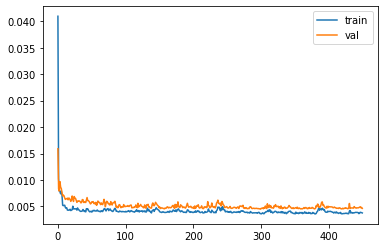

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batch_normalization_input (Inpu [(None, 12)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12)           48          batch_normalization_input[0][0]  
__________________________________________________________________________________________________
dense (Dense)                   (None, 35)           455         batch_normalization[0][0]        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 35)           0           dense[0][0]                      
______________________________________________________________________________________________

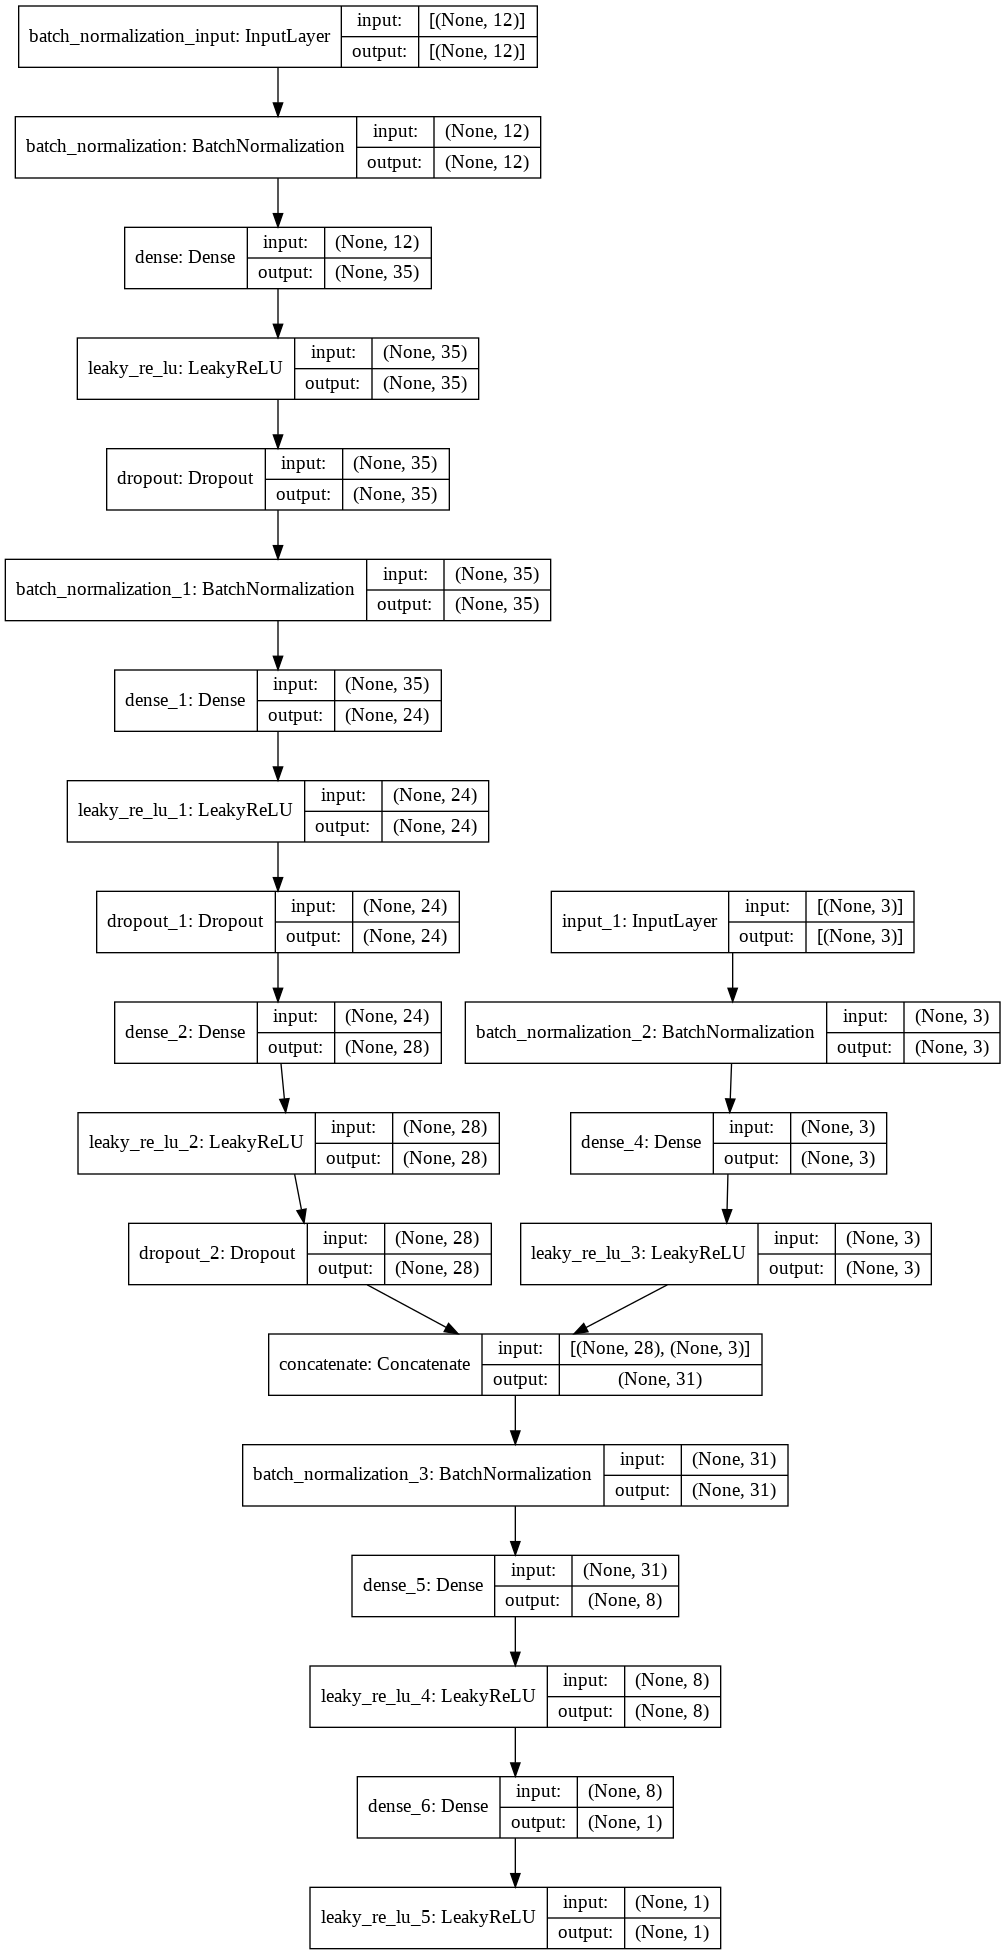

In [ ]:
model_fixed = load_model(precovid_model)
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

for i in range(0,len(model_fixed.layers)):
  model_fixed.layers[i].trainable = False

l1 = Input(shape=(3,))
l1_2 = BatchNormalization()(l1)
l2 = Dense(best_params2['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
l2_2 = LeakyReLU(alpha=best_params2['alpha'])(l2)
if best_params2['two_layer'] ==1 :
      l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_3])
else :
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_2])
merged2 = BatchNormalization()(merged)

if best_params2['last_layer'] ==0:
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)

if best_params2['last_layer'] ==1:
    l5 = Dense(best_params2['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
    l5_1 = LeakyReLU(alpha=best_params2['alpha'])(l5)
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)          

model = Model(inputs=[model_fixed.input,l1], outputs=l5_3)

opt = keras.optimizers.Adam(learning_rate=best_params2['learning_rate'])
model.compile(loss='mse',optimizer=opt)
fn_f = "gdrive/My Drive/Colab Notebooks/Stations/Training_CO_aftercovid.ckpt" 
fnn_f = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer

callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn_f, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=int(best_params2['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

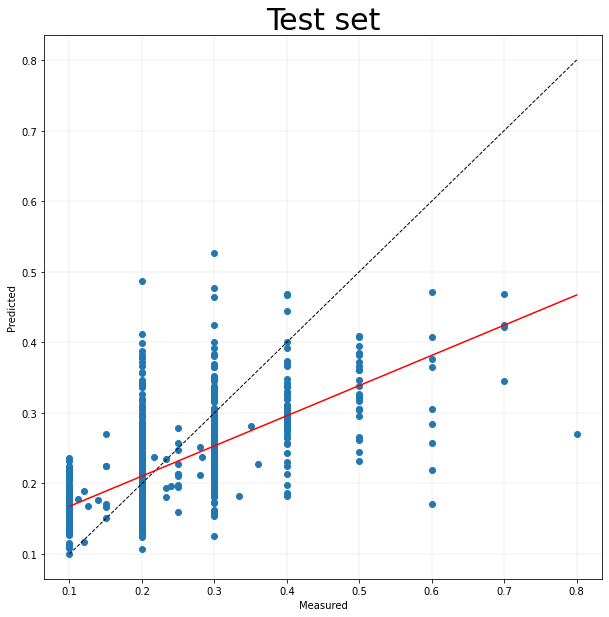

[0.42761824 0.12493499]
RMSE
[0.06297126]
R2
0.42194653306663965


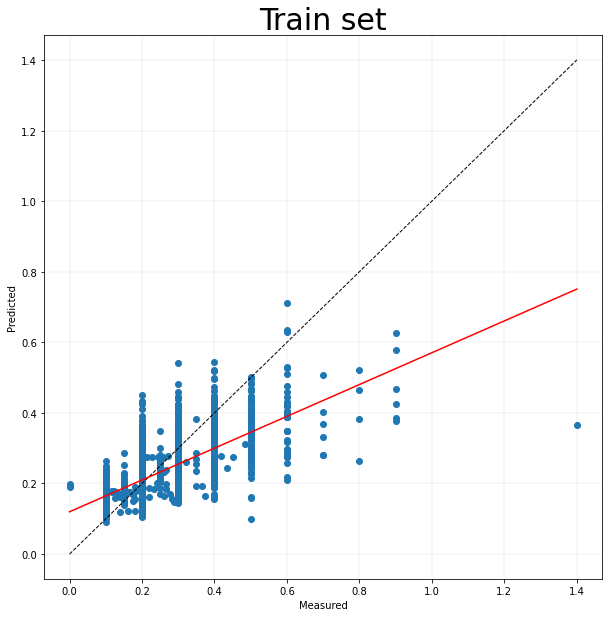

[0.45061179 0.11989867]
RMSE
[0.06110412]
R2
0.47311888956403503


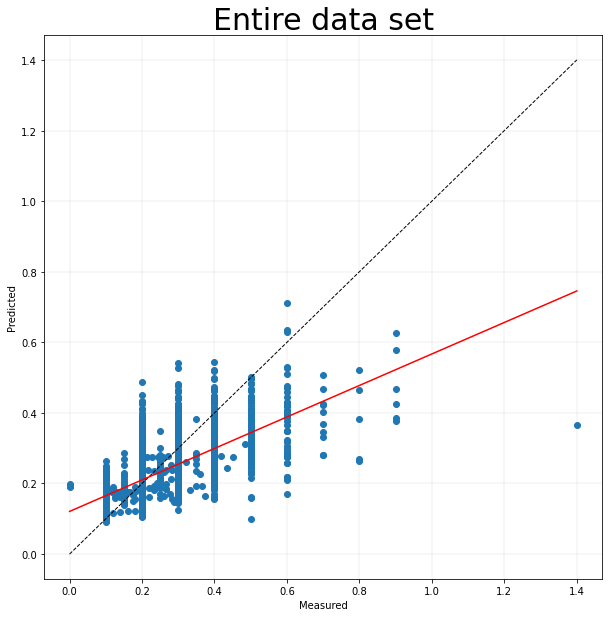

[0.4461315  0.12088052]
RMSE
[0.06148209]
R2
0.4631478722431982


In [ ]:
model.load_weights(fn_f )
model.save('gdrive/My Drive/Colab Notebooks/Model_Edmonton_east_after_Covid.h5')
preds = model.predict([X_test_a,X_test_b]) 
y_real = y_test_a.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

model.load_weights(fn_f)
preds = model.predict([X_train_a,X_train_b]) 
y_real_t = y_train_a.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
model.load_weights(fn_f)
preds = model.predict([X_a,X_b]) 
y_real_to = Y_a.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

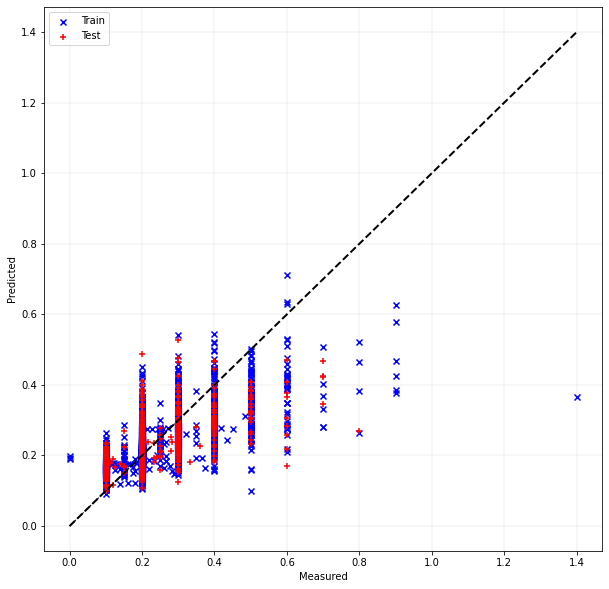

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.3], [0,0.3], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()


In [ ]:
df2_w_c

CO(ppm)  T( C)  RH(%)  ...  driving  transit  walking
Date                                        ...                           
2020-01-13 00:00:00      0.1  -25.4   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 01:00:00      0.1  -25.7   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 02:00:00      0.1  -25.8   66.0  ...   1.0000   1.0000   1.0000
2020-01-13 03:00:00      0.1  -25.8   65.0  ...   1.0000   1.0000   1.0000
2020-01-13 04:00:00      0.1  -26.0   65.0  ...   1.0000   1.0000   1.0000
...                      ...    ...    ...  ...      ...      ...      ...
2021-01-31 19:00:00      0.4  -15.5   76.0  ...   0.7143   0.4266   0.8011
2021-01-31 20:00:00      0.4  -15.4   78.0  ...   0.7143   0.4266   0.8011
2021-01-31 21:00:00      0.2  -15.5   79.0  ...   0.7143   0.4266   0.8011
2021-01-31 22:00:00      0.2  -16.3   80.0  ...   0.7143   0.4266   0.8011
2021-01-31 23:00:00      0.2  -16.7   81.0  ...   0.7143   0.4266   0.8011

[9075 rows x 16 columns]

In [ ]:
# df3= df3.copy()
df4 = df2_w_c.copy()
df4['pred'] = model.predict([X_a,X_b])
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

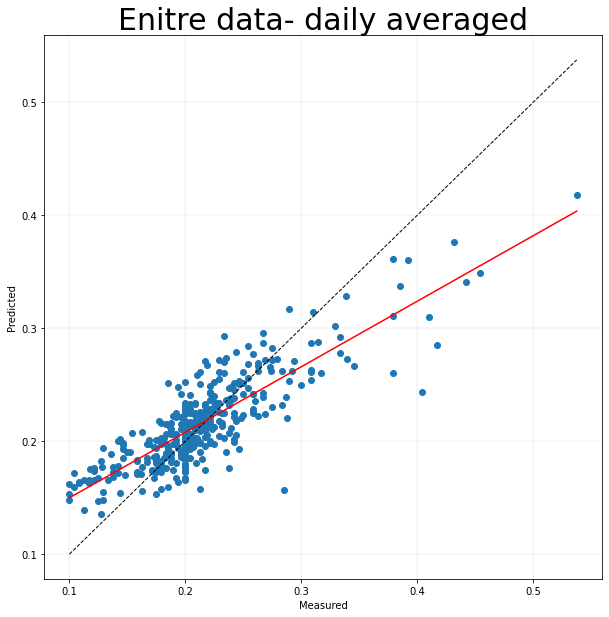

[0.57997188 0.09186987]
RMSE
[0.03240749]
R2
0.6798581783938966


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10['CO(ppm)']).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


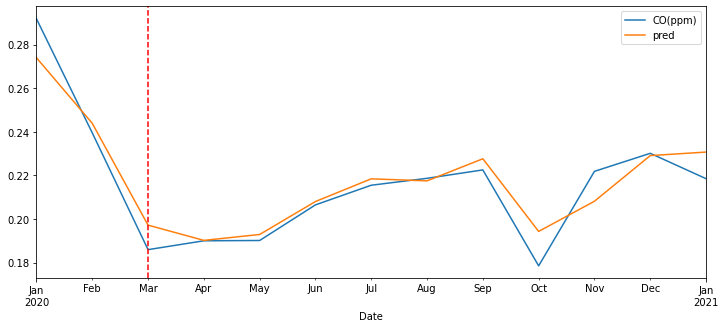

In [ ]:
df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df3_w_c = df2_w_c.copy()
df3_w_c['driving'] = 1.124019
df3_w_c['transit']  = 1.025378
df3_w_c['walking'] = 1.331329

In [ ]:
Y_a = df3_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df3_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df3_w_c[ ['driving', 'transit', 'walking']])




X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
# df3= df3.copy()
df44 = df3_w_c.copy()
df44['No lockdown'] = model.predict([X_a,X_b])
df104 = df44.resample('D').mean()
df104.dropna(inplace= True)

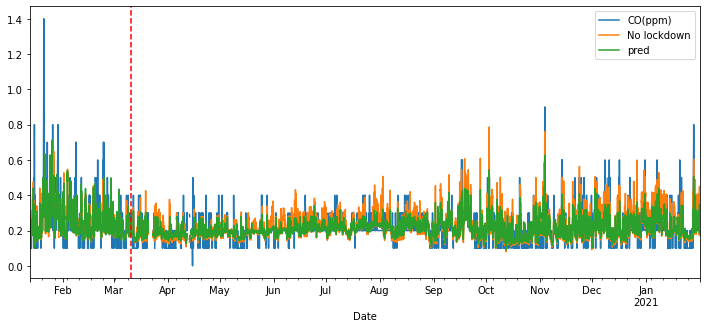

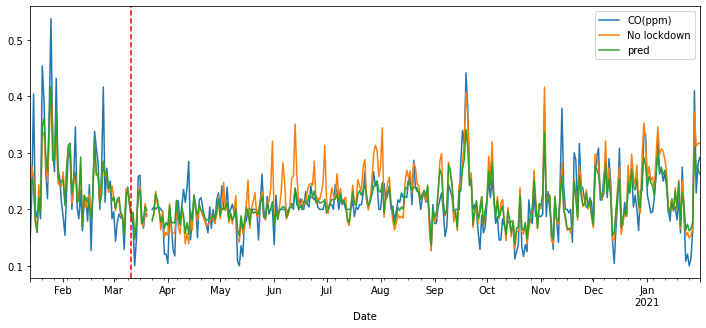

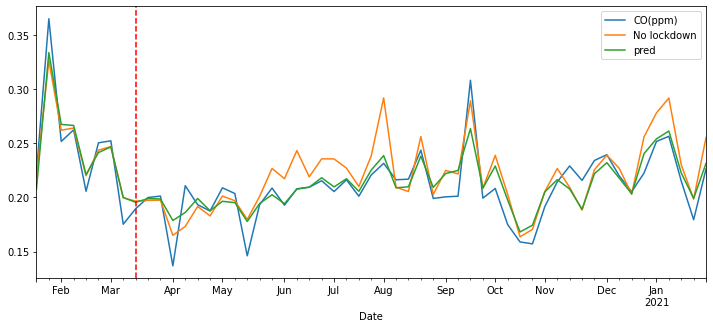

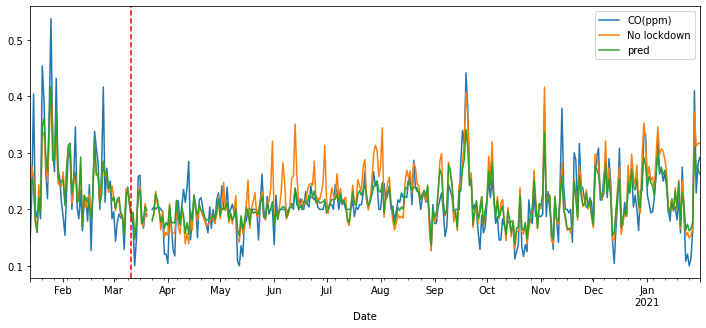

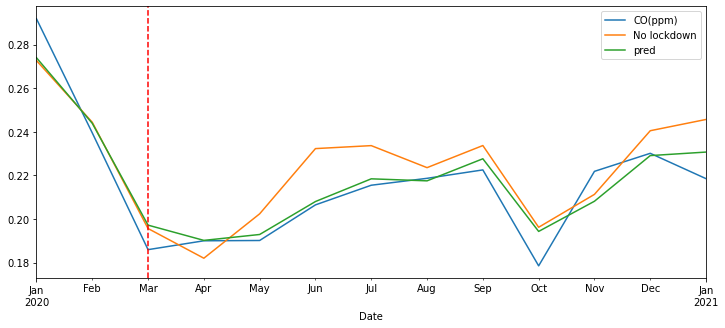

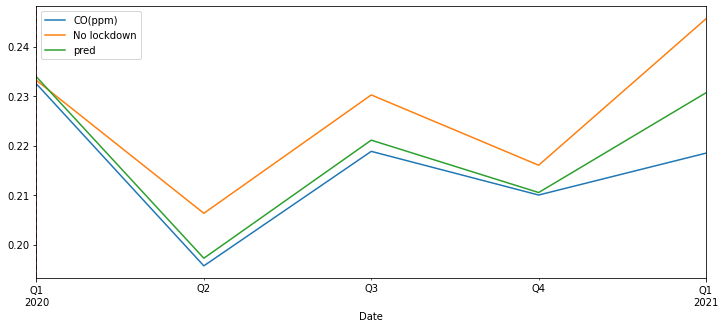

In [ ]:


df4['CO(ppm)'].resample('H').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('H').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('W').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('W').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()
df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('M').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('Q').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4['No lockdown']=df44['No lockdown'].copy()
print('No lockdown:',df4['No lockdown'].mean())
print('pred:',df4['pred'].mean())
print('CO(ppm):',df4['CO(ppm)'].mean())

No lockdown: 0.22312191128730774
pred: 0.2163834571838379
CO(ppm): 0.21406886884590973


In [ ]:
df4.head()

CO(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                        ...                                
2020-01-13 00:00:00      0.1  -25.4   68.0  ...      1.0  0.144256     0.140617
2020-01-13 01:00:00      0.1  -25.7   68.0  ...      1.0  0.154986     0.151347
2020-01-13 02:00:00      0.1  -25.8   66.0  ...      1.0  0.158600     0.154960
2020-01-13 03:00:00      0.1  -25.8   65.0  ...      1.0  0.166749     0.168830
2020-01-13 04:00:00      0.1  -26.0   65.0  ...      1.0  0.185634     0.212358

[5 rows x 18 columns]

In [ ]:
df4.to_csv('gdrive/My Drive/Colab Notebooks/Edmonton East/NOX_mobility_aftercov_Edmonton_east-COVID_hourly_pred.csv')

In [ ]:
df4

NOX(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                         ...                                
2020-01-13 00:00:00    0.0084  -25.4   68.0  ...   1.0000  0.012064     0.011699
2020-01-13 01:00:00    0.0078  -25.7   68.0  ...   1.0000  0.015269     0.014904
2020-01-13 02:00:00    0.0053  -25.8   66.0  ...   1.0000  0.015456     0.015090
2020-01-13 03:00:00    0.0050  -25.8   65.0  ...   1.0000  0.018650     0.018285
2020-01-13 04:00:00    0.0069  -26.0   65.0  ...   1.0000  0.023630     0.023264
...                       ...    ...    ...  ...      ...       ...          ...
2021-01-31 19:00:00    0.1137  -15.5   76.0  ...   0.8011  0.037565     0.041811
2021-01-31 20:00:00    0.1007  -15.4   78.0  ...   0.8011  0.024746     0.028993
2021-01-31 21:00:00    0.0515  -15.5   79.0  ...   0.8011  0.019648     0.023895
2021-01-31 22:00:00    0.0502  -16.3   80.0  ...   0.8011  0.030382     0.034629
2021-01-31 23:00:00    0.0408  -16.7   81.0  ...   0.8011  0.025745     0.029992

[9075 rows x 18 columns]